# Description

* This file implement(s) the pipeline for the Advanced Lane Detection Project

# Writeup

* The project writeup is located 'here'.
* Extra point(s) - using Deep Learning to detect lane line(s), by generating a lot of synthetic data, and then training a model to recognize the image(s)

# Common Imports

In [98]:
# Imports

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
import pickle
from scipy import signal
import collections
import math

# Packages below needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# Shared Constants

const_separator_line = "--------------------------------"
const_horizontal_offset = 40

const_pixel_intensity_threshold_min = 30
const_pixel_intensity_threshold_max = 100

const_plot_fontsize = 10

const_kernelsize = 9

const_src = np.float32([[120, 720], [550, 470], [700, 470], [1160, 720]])
const_dest = np.float32([[200,720], [200,0], [1080,0], [1080,720]])

const_test_straight1 = './project/test_images/straight_lines1.jpg'
const_test_straight2 = './project/test_images/straight_lines2.jpg'

const_test_image_1 = './project/test_images/test1.jpg'
const_test_image_2 = './project/test_images/test2.jpg'
const_test_image_3 = './project/test_images/test3.jpg'
const_test_image_4 = './project/test_images/test4.jpg'
const_test_image_5 = './project/test_images/test5.jpg'
const_test_image_6 = './project/test_images/test6.jpg'

const_challenge_image_paths = glob.glob('./project/challenge_images/chal*.jpg')



In [3]:

# Useful functions to selectively turn on / off logging at different levels

const_info_log_enabled = False
def infoLog(logMessage, param_separator=None):
    if const_info_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)

const_debug_log_enabled = True
def debugLog(logMessage, param_separator=None):
    if const_debug_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)
        
const_warning_log_enabled = True
def warningLog(logMessage, param_separator=None):
    if const_warning_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)
        
const_error_log_enabled = True
def errorLog(logMessage, param_separator=None):
    if const_error_log_enabled == True:
        print("")
        if param_separator:
            print(param_separator) 
        print(logMessage)


# Camera Matrix and Distortion Correction

* Determine Object points and image points for a single image

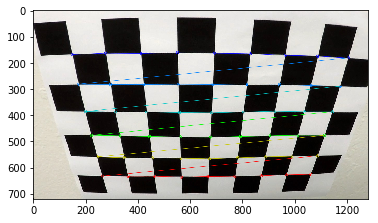

In [28]:
# For the above loaded Random image, Detect and DrawChessboard Corners
nx = 9
ny = 6 

image_path = './project/camera_cal/calibration2.jpg'
image = mpimg.imread(image_path)

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(image_gray, (nx, ny), None)

infoLog(ret)
infoLog(corners)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.imshow(image)

* Determine Object points and image points for all images within the Calibration Folder

In [5]:
# Detect Chess corners for all the images within the camera_cal folder
# This process gives us Object points and Image points, which can then be used for Camera Calibration

imagePaths = glob.glob('./project/camera_cal/calibration*.jpg')
outputPath = './project/camera_cal/output/'
infoLog(imagePaths)

nx = 9 
ny = 6 

num_channels = 3

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,num_channels), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # -1 implies shape is to be inferred
infoLog(objp)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

for index, imagePath in enumerate(imagePaths):
    img = mpimg.imread(imagePath) # Reads image as an RGB image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        infoLog("Chessboard Corners found for - " + imagePath )
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = outputPath + 'corners_found'+str(index)+'.jpg'
        cv2.imwrite(write_name, img)

    else:
        debugLog("Chessboard Corners not found for - " + imagePath )
        

infoLog("Object Points")
infoLog(objpoints)

infoLog("Image Points")
infoLog(imgpoints)



Chessboard Corners not found for - ./project/camera_cal/calibration1.jpg

Chessboard Corners not found for - ./project/camera_cal/calibration4.jpg

Chessboard Corners not found for - ./project/camera_cal/calibration5.jpg

Chessboard Corners not found for - ./project/camera_cal/calibration_test.jpg


# Camera calibration and Example of Distortion Correction image


Image Shape : (720, 1280, 3)

Image Size ( Note that this is Height first then Width ) : (1280, 720)

Successfully written to ./project/camera_cal/output/calibration_test_undistorted.jpg ? :-> True


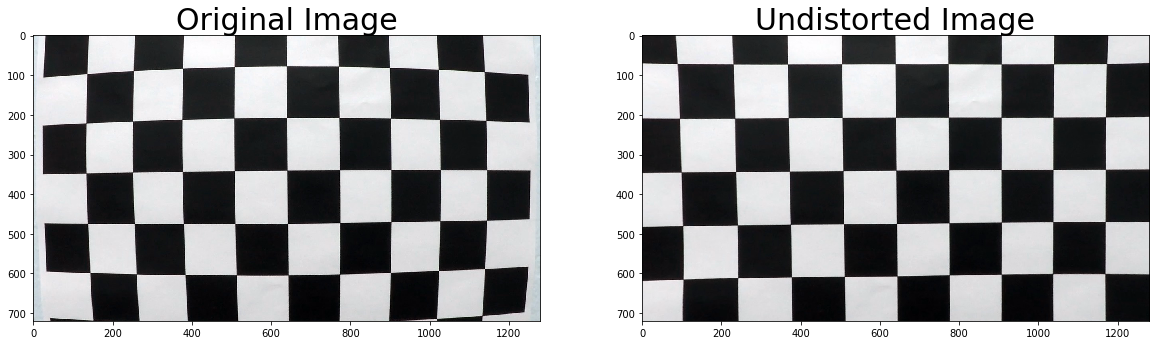

In [6]:

# Test undistortion on an image
test_image_path = './project/camera_cal/calibration_test.jpg'
undistorted_test_image_output_path = './project/camera_cal/output/calibration_test_undistorted.jpg'
wide_dist_pickle_path = './project/camera_cal/output/wide_dist_pickle.p'

img = cv2.imread(test_image_path)
debugLog("Image Shape : " + str(img.shape))
img_size = (img.shape[1], img.shape[0])
debugLog("Image Size ( Note that this is Height first then Width ) : " + str(img_size))

# Camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save Calibration results to a Pickle file
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
dist_pickle["objpoints"] = objpoints
dist_pickle["imgpoints"] = imgpoints
pickle.dump( dist_pickle, open(wide_dist_pickle_path, "wb" ) )

# Perform Undistortion 
dst = cv2.undistort(img, mtx, dist, None, mtx)
result = cv2.imwrite(undistorted_test_image_output_path, dst)
debugLog("Successfully written to " + undistorted_test_image_output_path + " ? :-> "+ str(result) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)


In [7]:

# Read in the saved objpoints and imgpoints

dist_pickle = pickle.load( open(wide_dist_pickle_path, "rb" ) )
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

if objpoints is not None:
    debugLog("object Points saved in pickle data file restored successfully.")

# Convenience function to undistort an image, given the object points and image points
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Convenience function to undistort an image, given the undistortion matrix
def cal_undistort_mtx(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



object Points saved in pickle data file restored successfully.


# Example of Thresholded binary image

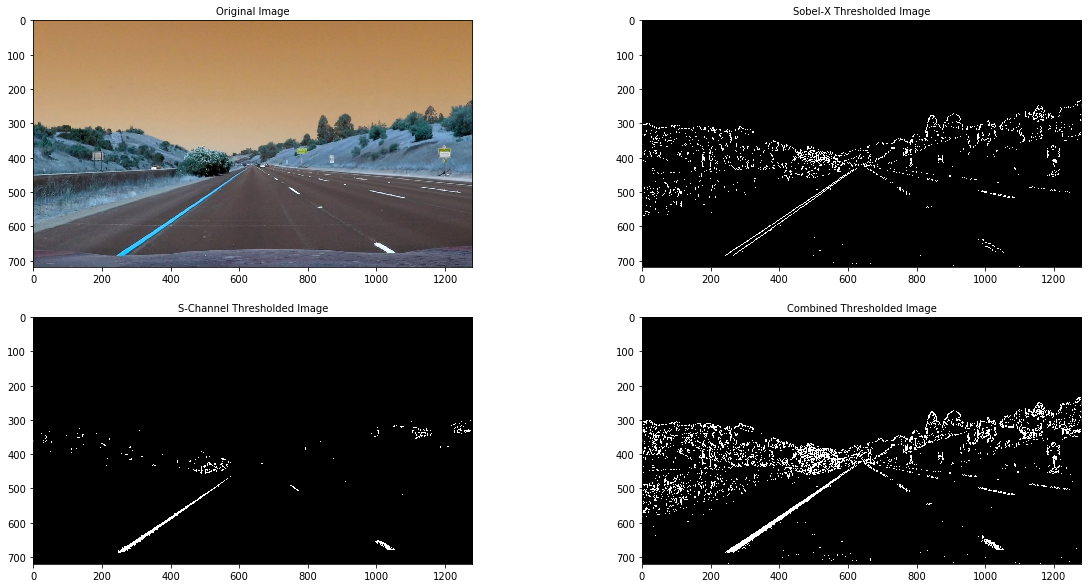

In [8]:
# Convenience function to return a Sobel thresholded Binary Image from a given image

def abs_sobel_thresh(rgb_img, orient='x', sobel_kernel = 3, grad_thresh=(0,255)):
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY) # This assumes input image is in RGB format ( i.e. as returned by MPImg)
    sobel = None
    if orient == 'x':
        sobel =  cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    else:
        sobel =  cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    abs_sobelx = np.absolute(sobel)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    binary_output = np.zeros_like(scaled_sobelx)
    binary_output[(scaled_sobelx >= grad_thresh[0]) & (scaled_sobelx <= grad_thresh[1])] = 1

    return binary_output

# Convenience function to apply S Channel Thresholding on an image
def apply_s_channel_thresholding(rgb_img, thresh=(0,255)):
    # Convert to HLS
#     img_hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS).astype(np.float)
    img_hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    # Apply threshold to S channel
    S = img_hls[:,:,2]
    binary_s = np.zeros_like(S)
    binary_s[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary_s

def thresholding(img, binary_threshold=(20, 100), s_channel_threshold=(170,255), sobel_kernel_size=const_kernelsize):
    binary_thresholded_img_x = abs_sobel_thresh(img, 'x', sobel_kernel_size, binary_threshold)
    s_channel_thresholded_image = apply_s_channel_thresholding(img, s_channel_threshold)
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(binary_thresholded_img_x)
    combined_binary[(binary_thresholded_img_x == 1) | (s_channel_thresholded_image == 1)] = 1
    return combined_binary

# Define Thresholding parameters 
local_sobel_kernel = 1
local_sobel_threshold = (30,100)
local_s_channel_threshold = (170,255)

# Perform Thresholding
img = mpimg.imread(const_test_straight1) # Reads image as an RGB image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Force to RGB format
infoLog(img.shape)
sobel_x_thresholded_image = abs_sobel_thresh(img, 'x', local_sobel_kernel, local_sobel_threshold)
s_channel_thresholded_image = apply_s_channel_thresholding(img, local_s_channel_threshold)
combined_image = thresholding(img)

# Visualize Thresholding
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(sobel_x_thresholded_image, cmap='gray')
ax2.set_title('Sobel-X Thresholded Image', fontsize=10)
ax3.imshow(s_channel_thresholded_image, cmap='gray')
ax3.set_title('S-Channel Thresholded Image', fontsize=10)
ax4.imshow(combined_image, cmap='gray')
ax4.set_title('Combined Thresholded Image', fontsize=10)



# Region of Interest Selection

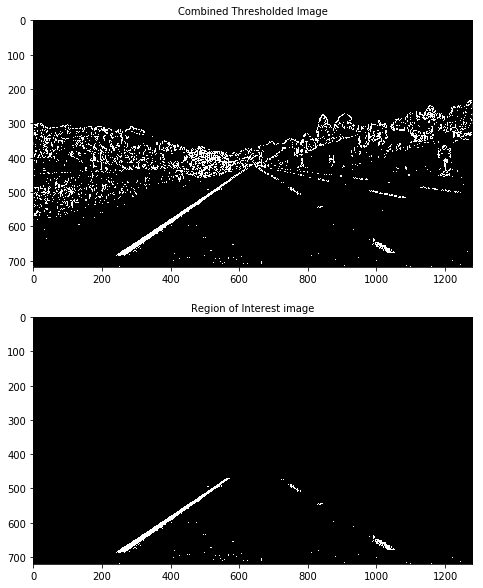

In [9]:

# Convenience function for region of interest selection

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    region_of_interest_image = cv2.bitwise_and(img, mask)
    return region_of_interest_image


image_shape = combined_image.shape
vertices = np.array([[(0,image_shape[0]),(550, 470), (750, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)

# Perform RoI Selection
region_of_interest_image = region_of_interest(combined_image, vertices)

# Visualize RoI Selection
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
ax1.imshow(combined_image, cmap='gray')
ax1.set_title('Combined Thresholded Image', fontsize=10)
ax2.imshow(region_of_interest_image, cmap='gray')
ax2.set_title('Region of Interest image', fontsize=10)



# Example of Perspective Transform

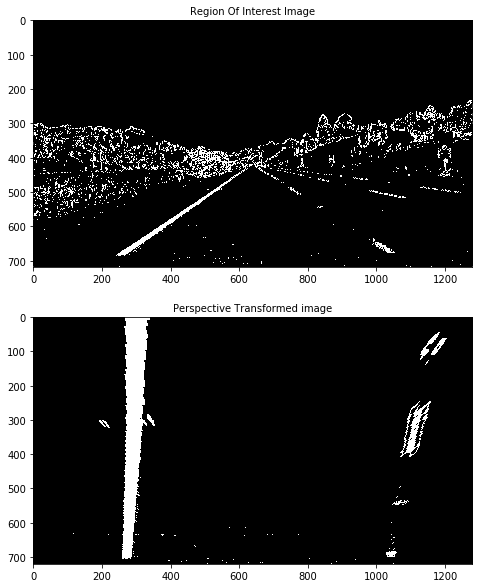

In [10]:

# Convenience function to apply a perspective transform to an image, given certain Source and Destination parameters
def warp_src_dest(img, src, dest):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

warped_image, M, Minv = warp_src_dest(region_of_interest_image, const_src, const_dest)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))
ax1.imshow(combined_image, cmap='gray')
ax1.set_title('Region Of Interest Image', fontsize=10)
ax2.imshow(warped_image, cmap='gray')
ax2.set_title('Perspective Transformed image', fontsize=10)



# Lane Line Pixel determination, and curve fitting

* Determine left lane and right lane with Histogram analysis


[217 218 219 ..., 332 332 332]

[ 633.  633.  634. ...,   95.   96.   97.]

[1042 1043 1044 ..., 1157 1157 1157]

[ 599.  598.  598. ...,  247.  248.  249.]


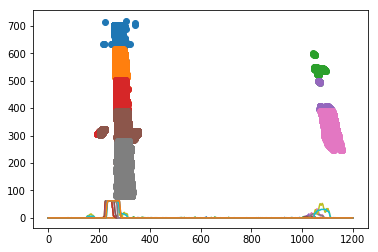

In [11]:

def collapse_into_flat_arrays(leftx, lefty, rightx, righty):
    leftx = [x
             for array in leftx
             for x in array]
    lefty = [x
             for array in lefty
             for x in array]
    rightx = [x
              for array in rightx
              for x in array]
    righty = [x
              for array in righty
              for x in array]

    leftx = np.array(leftx)
    lefty = np.array(lefty)
    rightx = np.array(rightx)
    righty = np.array(righty)

    return leftx, lefty, rightx, righty

def get_pixel_in_window(img, x_center, y_center, size):
    """
    returns selected pixels inside a window.
    :param img: binary image
    :param x_center: x coordinate of the window center
    :param y_center: y coordinate of the window center
    :param size: size of the window in pixel
    :return: x, y of detected pixels
    """
    half_size = size // 2
    window = img[int(y_center - half_size):int(y_center + half_size), int(x_center - half_size):int(x_center + half_size)]

    x, y = (window.T == 1).nonzero()

    x = x + x_center - half_size
    y = y + y_center - half_size

    return x, y

def histogram_pixels(warped_thresholded_image, offset=50, steps=6,
                     window_radius=200, medianfilt_kernel_size=51,
                     horizontal_offset=50, enable_visualization = False):
        
    # Initialise arrays
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    # Parameters
    height = warped_thresholded_image.shape[0]
    offset_height = height - offset
    width = warped_thresholded_image.shape[1]
    half_frame = warped_thresholded_image.shape[1] // 2
    pixels_per_step = offset_height / steps

    for step in range(steps):
        left_x_window_centres = []
        right_x_window_centres = []
        y_window_centres = []

        # Define the window (horizontal slice)
        window_start_y = height - (step * pixels_per_step) + offset
        window_end_y = window_start_y - pixels_per_step + offset

        # Take a count of all the pixels at each x-value in the horizontal slice
        histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y), int(horizontal_offset):int(width - horizontal_offset)], axis=0)
        
        if(enable_visualization == True):
            plt.plot(histogram)

        # Smoothen the histogram
        histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

        if(enable_visualization == True):
            plt.plot(histogram_smooth)

        # Identify the left and right peaks
        left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
        right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
        if len(left_peaks) > 0:
            left_peak = max(left_peaks)
            left_x_window_centres.append(left_peak)

        if len(right_peaks) > 0:
            right_peak = max(right_peaks) + half_frame
            right_x_window_centres.append(right_peak)

        # Add coordinates to window centres

        if len(left_peaks) > 0 or len(right_peaks) > 0:
            y_window_centres.append((window_start_y + window_end_y) // 2)

        # Get pixels in the left window
        for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
            left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre,
            
                                                                       y_centre, window_radius)
            if(enable_visualization == True):
                plt.scatter(left_x_additional, left_y_additional)
            # Add pixels to list
            left_x.append(left_x_additional)
            left_y.append(left_y_additional)

        # Get pixels in the right window
        for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
            right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre,
                                                                         y_centre, window_radius)
            if(enable_visualization == True):
                plt.scatter(right_x_additional, right_y_additional)
            # Add pixels to list
            right_x.append(right_x_additional)
            right_y.append(right_y_additional)
                
    if len(right_x) == 0 or len(left_x) == 0:
        print("X co ordinate for left or right peak not found")

        horizontal_offset = 0

        left_x = []
        left_y = []
        right_x = []
        right_y = []

        for step in range(steps):
            left_x_window_centres = []
            right_x_window_centres = []
            y_window_centres = []

            # Define the window (horizontal slice)
            window_start_y = height - (step * pixels_per_step) + offset
            window_end_y = window_start_y - pixels_per_step + offset

            # Take a count of all the pixels at each x-value in the horizontal slice
            histogram = np.sum(warped_thresholded_image[int(window_end_y):int(window_start_y),
                               int(horizontal_offset):int(width - horizontal_offset)], axis=0)
            
            if(enable_visualization == True):
                plt.plot(histogram)

            # Smoothen the histogram
            histogram_smooth = signal.medfilt(histogram, medianfilt_kernel_size)

            if(enable_visualization == True):
                plt.plot(histogram_smooth)

            # Identify the left and right peaks
            left_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[:half_frame], np.arange(1, 10)))
            right_peaks = np.array(signal.find_peaks_cwt(histogram_smooth[half_frame:], np.arange(1, 10)))
            if len(left_peaks) > 0:
                left_peak = max(left_peaks)
                left_x_window_centres.append(left_peak)

            if len(right_peaks) > 0:
                right_peak = max(right_peaks) + half_frame
                right_x_window_centres.append(right_peak)

            # Add coordinates to window centres

            if len(left_peaks) > 0 or len(right_peaks) > 0:
                y_window_centres.append((window_start_y + window_end_y) // 2)

            # Get pixels in the left window
            for left_x_centre, y_centre in zip(left_x_window_centres, y_window_centres):
                left_x_additional, left_y_additional = get_pixel_in_window(warped_thresholded_image, left_x_centre,
                                                                           y_centre, window_radius)
                if(enable_visualization == True):
                    plt.scatter(left_x_additional, left_y_additional)
                # Add pixels to list
                left_x.append(left_x_additional)
                left_y.append(left_y_additional)

            # Get pixels in the right window
            for right_x_centre, y_centre in zip(right_x_window_centres, y_window_centres):
                right_x_additional, right_y_additional = get_pixel_in_window(warped_thresholded_image, right_x_centre,
                                                                             y_centre, window_radius)
                if(enable_visualization == True):
                    plt.scatter(right_x_additional, right_y_additional)
                # Add pixels to list
                right_x.append(right_x_additional)
                right_y.append(right_y_additional)
                        
    return collapse_into_flat_arrays(left_x, left_y, right_x, right_y)


leftx, lefty, rightx, righty = histogram_pixels(warped_image, horizontal_offset=const_horizontal_offset, enable_visualization = True)

debugLog(leftx)
debugLog(lefty)
debugLog(rightx)
debugLog(righty)




* Fit a polynomial to the above points 


Fit and coefficients: 

(43588,)

(3,)

(7487,)

(3,)

X, Y co ordinates for left and right lane(s): 

[ 633.  633.  634. ...,   95.   96.   97.]

[217 218 219 ..., 332 332 332]

[ 599.  598.  598. ...,  247.  248.  249.]

[1042 1043 1044 ..., 1157 1157 1157]


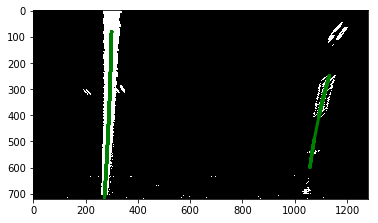

In [12]:

def fit_second_order_poly(indep, dep, return_coeffs=False):
    fit = np.polyfit(indep, dep, 2)
    fitdep = fit[0]*indep**2 + fit[1]*indep + fit[2]
    if return_coeffs == True:
        return fitdep, fit
    else:
        return fitdep, None

def get_fit_equations(lefty,leftx, righty, rightx, return_coeffs=False):
    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=return_coeffs)
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=return_coeffs)
    return left_fit, left_coeffs, right_fit, right_coeffs

left_fit, left_coeffs, right_fit, right_coeffs = get_fit_equations(lefty,leftx, righty, rightx, True)

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped_image, cmap="gray")
lanes = plt.gcf()

debugLog("Fit and coefficients: ")
debugLog(left_fit.shape)
debugLog(left_coeffs.shape)
debugLog(right_fit.shape)
debugLog(right_coeffs.shape)

debugLog("X, Y co ordinates for left and right lane(s): ")
debugLog(lefty)
debugLog(leftx)
debugLog(righty)
debugLog(rightx)




* Generate a solid line which represents the lane line(s), based on the fit above

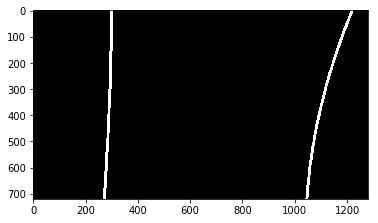

In [13]:

def lane_poly(yval, poly_coeffs):
    """Returns x value for poly given a y-value.
    Note here x = Ay^2 + By + C."""
    return poly_coeffs[0]*yval**2 + poly_coeffs[1]*yval + poly_coeffs[2]

def draw_poly(img, poly, poly_coeffs, steps, color=[255, 0, 0], thickness=10, dashed=False):
    img_height = img.shape[0]
    pixels_per_step = img_height // steps

    for i in range(steps):
        start = i * pixels_per_step
        end = start + pixels_per_step

        start_point = (int(poly(start, poly_coeffs=poly_coeffs)), start)
        end_point = (int(poly(end, poly_coeffs=poly_coeffs)), end)

        if dashed == False or i % 2 == 1:
            img = cv2.line(img, end_point, start_point, color, thickness)

    return img

def get_generated_lane_lines(param_left_coeffs, param_right_coeffs):
    blank_canvas = np.zeros((720, 1280))
    polyfit_left = draw_poly(blank_canvas, lane_poly, param_left_coeffs, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, param_right_coeffs, 30)
    return polyfit_drawn
    
polyfit_drawn = get_generated_lane_lines(left_coeffs, right_coeffs)

plt.imshow(polyfit_drawn, cmap="gray")

* Create a 'filled' area which can be projected back to the original image

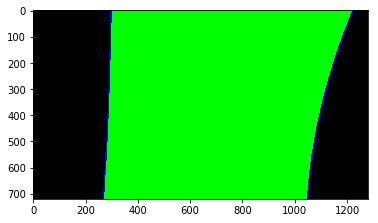

In [14]:

def evaluate_poly(indep, poly_coeffs):
    return poly_coeffs[0]*indep**2 + poly_coeffs[1]*indep + poly_coeffs[2]

def highlight_lane_line_area(mask_template, left_poly, right_poly, start_y = 0, end_y = 720):
    area_mask = mask_template
    for y in range(start_y, end_y):
        left = evaluate_poly(y, left_poly)
        right = evaluate_poly(y, right_poly)
        area_mask[y][int(left):int(right)] = 1

    return area_mask

def get_filled_lanes(param_polyfit_drawn, param_left_coeffs, param_right_coeffs):
    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    filled_lanes = colour_canvas
    filled_lanes[param_polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(blank_canvas, param_left_coeffs, param_right_coeffs)
    filled_lanes[area == 1] = [0,255,0]
    return filled_lanes

filled_lanes = get_filled_lanes(polyfit_drawn, left_coeffs, right_coeffs)

plt.imshow(filled_lanes)



* Project the highlighted area back to the original image

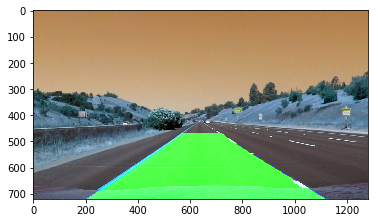

In [15]:

def project_lanes_on_original(param_img, param_filled_lanes, param_inverse_perspective_transform_matrix):
    image_shape = param_img.shape
    lane_lines = cv2.warpPerspective(param_filled_lanes, param_inverse_perspective_transform_matrix, (image_shape[1], image_shape[0]), flags=cv2.INTER_LINEAR)
    combined_img = cv2.add(lane_lines, param_img)
    return combined_img

lane_lines_detected_image = project_lanes_on_original(img, filled_lanes, Minv)

plt.imshow(lane_lines_detected_image)




# Radius of Curvature, and Vehicle Position Calculation

* Do the RoC Calculation

In [16]:

def center(y, left_poly, right_poly):
    center = (1.5 * evaluate_poly(y, left_poly)
              - evaluate_poly(y, right_poly)) / 2
    return center


def perform_calculations(param_left_coeffs, param_right_coeffs):
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * param_left_coeffs[0] * y_eval + param_left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * param_right_coeffs[0] * y_eval + param_right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
    infoLog("Left lane curve radius: " + str(left_curverad) + "pixels")
    infoLog("Right lane curve radius: "+ str(right_curverad) + "pixels")
    curvature = (left_curverad + right_curverad) / 2
    centre = center(719, left_coeffs, right_coeffs)
    min_curvature = min(left_curverad, right_curverad)
    return curvature, centre, min_curvature
    
curvature, centre, min_curvature = perform_calculations(left_coeffs, right_coeffs)
    

# Final image, projected back to the original image

* Add the RoC Calculation to the image

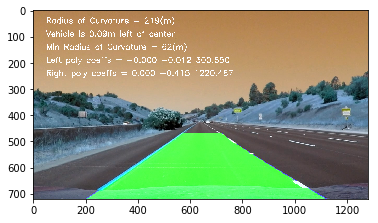

In [17]:
def add_calculations_to_image(img, curvature, vehicle_position, min_curvature, left_coeffs=(0,0,0), right_coeffs=(0,0,0)):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    return_img = img.copy()
    
    # Convert from pixels to meters
    vehicle_position = vehicle_position / 12800 * 3.7
    curvature = curvature / 128 * 3.7
    min_curvature = min_curvature / 128 * 3.7

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(return_img, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(return_img, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)
    cv2.putText(return_img, 'Min Radius of Curvature = %d(m)' % min_curvature, (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(return_img, 'Left poly coeffs = %.3f %.3f %.3f' % (left_coeffs[0], left_coeffs[1], left_coeffs[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(return_img, 'Right poly coeffs = %.3f %.3f %.3f' % (right_coeffs[0], right_coeffs[1], right_coeffs[2]), (50, 250), font, 1, (255, 255, 255), 2)
    return return_img

return_img = add_calculations_to_image(lane_lines_detected_image, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)

plt.imshow(return_img)

# Pipeline Code


deque([], maxlen=5)

deque([], maxlen=5)

Current point : 271.719475963

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.

Current point : 1022.8716027

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.


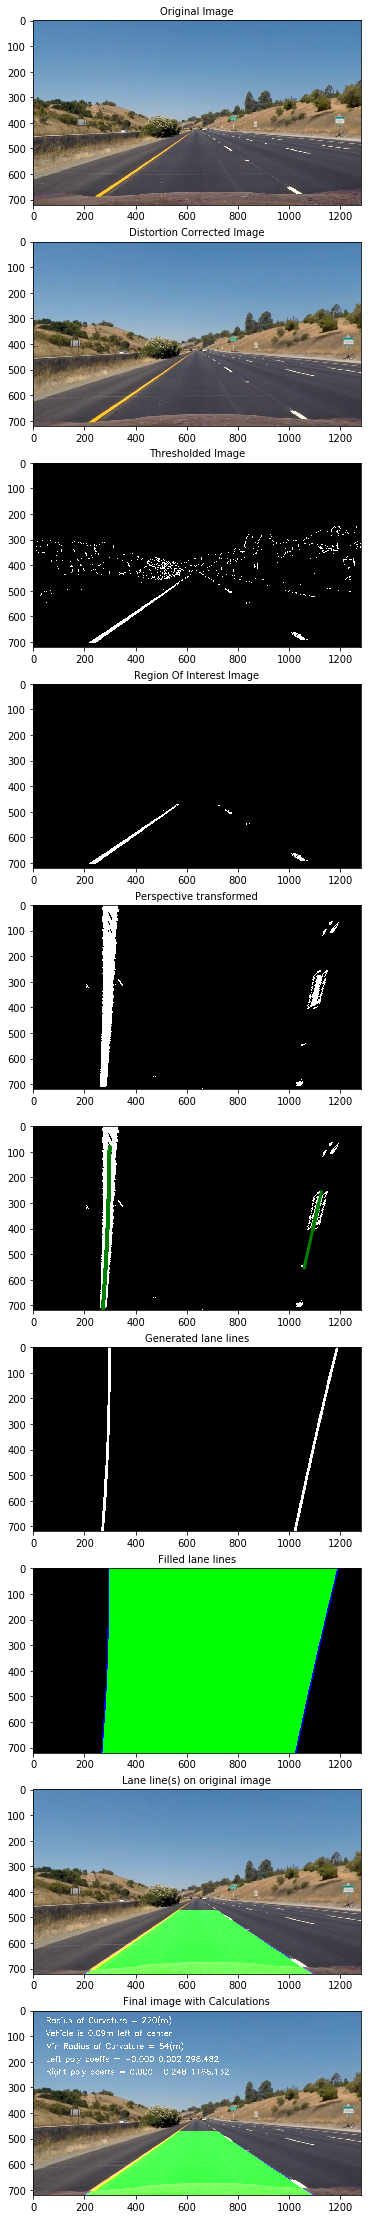

In [114]:

# The number of valid history objects to store for validation, and interpolation
const_history_size = 5

# The maximum allowed difference between the X co ordinate of the previously stored lane bottom intersection points ( left, and right ) 
# as compared to the current estimated bottom intersection point
const_max_lane_bottom_intersection_x_valid_threshold = 200

global_left_coeffs_history = collections.deque(maxlen=const_history_size)
global_right_coeffs_history = collections.deque(maxlen=const_history_size)

global_left_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)
global_right_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)

def reset_history():
    global global_left_coeffs_history
    global global_right_coeffs_history
    global global_left_lane_bottom_intersection_x
    global global_right_lane_bottom_intersection_x
    global_left_coeffs_history = collections.deque(maxlen=const_history_size)
    global_right_coeffs_history = collections.deque(maxlen=const_history_size)
    global_left_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)
    global_right_lane_bottom_intersection_x = collections.deque(maxlen=const_history_size)

def update_history_coeffs(left_coeff, right_coeff):
    global global_left_coeffs_history
    global global_right_coeffs_history
    
    # Add the items to History
    if(left_coeff != None):
        global_left_coeffs_history.appendleft(left_coeff)
        
    if(right_coeff != None):
        global_right_coeffs_history.appendleft(right_coeff)
    
    infoLog(global_left_coeffs_history)
    infoLog(global_right_coeffs_history)
    
def get_coeffs_from_history():
    global global_left_coeffs_history
    global global_right_coeffs_history
    
    # Add the items to History
    left_coeffs_list = list(global_left_coeffs_history)
    right_coeffs_list = list(global_right_coeffs_history)
    
    infoLog(global_left_coeffs_history)
    infoLog(global_right_coeffs_history)
    
    left_coeff_history = np.mean(left_coeffs_list, axis=0)
    right_coeff_history = np.mean(right_coeffs_list, axis=0)
    
    infoLog(left_coeff_history)
    infoLog(right_coeff_history)
    
    return left_coeff_history, right_coeff_history


def update_history_bottom_intersection_x(left_bottom_intersection_x, right_bottom_intersection_x):
    global global_left_lane_bottom_intersection_x
    global global_right_lane_bottom_intersection_x
    
    # Add the items to History
    if(left_bottom_intersection_x != None):
        global_left_lane_bottom_intersection_x.appendleft(left_bottom_intersection_x)
    
    if(right_bottom_intersection_x != None):
        global_right_lane_bottom_intersection_x.appendleft(right_bottom_intersection_x)
    
    infoLog(global_left_lane_bottom_intersection_x)
    infoLog(global_right_lane_bottom_intersection_x)

def get_bottom_intersection_points_x_from_history():
    global global_left_lane_bottom_intersection_x
    global global_right_lane_bottom_intersection_x
    
    left_bottom_intersection_point_x_history = np.mean(global_left_lane_bottom_intersection_x)
    right_bottom_intersection_point_x_history = np.mean(global_right_lane_bottom_intersection_x)
    
    debugLog(global_left_lane_bottom_intersection_x)
    debugLog(global_right_lane_bottom_intersection_x)
    
    return left_bottom_intersection_point_x_history, right_bottom_intersection_point_x_history

    
def is_lane_bottom_x_intersection_valid(current_intersection_point_x, history_intersection_point_x):
    debugLog("Current point : " + str(current_intersection_point_x))
    debugLog("Historical point ( mean ) : " + str(history_intersection_point_x))
    if(math.isnan(history_intersection_point_x) == False):
        difference = abs(current_intersection_point_x-history_intersection_point_x)
        if (difference <= const_max_lane_bottom_intersection_x_valid_threshold):
            debugLog("Current point is valid.")
            return True
        else:
            debugLog("Current point is invalid.")
            return False
    else:
        debugLog("Returning valid, because currently we do not have any history.")
        return True

def pipeline(imageOrPath, isImagePath = False, enable_visualization = False):
    # Reference a few necessary global variables
    global global_left_coeffs
    global global_right_coeffs

    # If the image is a path, then read the image from Path
    image = None
    if(isImagePath == True):
        image = mpimg.imread(imageOrPath) # Reads image as an RGB image
    else:
        image = imageOrPath

    # Clear out matplotlib plot frame for each run
    plt.clf()

    # Distortion correction
    dc_image = cal_undistort_mtx(image, mtx, dist)
    
    # Thresholding
    thresholded_image = thresholding(dc_image,(40, 100),(180,255))

    # RoI selection
    image_shape = image.shape
    vertices = np.array([[(0,image_shape[0]),(550, 470), (750, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)
    region_of_interest_image = region_of_interest(thresholded_image, vertices)

    # Perspective transform
    warped_image, M, Minv = warp_src_dest(region_of_interest_image, const_src, const_dest)
    
    # Lane detection using transform
    leftx, lefty, rightx, righty = histogram_pixels(warped_image, horizontal_offset=const_horizontal_offset)

    # Fit a polynomial to the detected lanes
    try:
        
        # Attempt a fit ( may lead to exception if the fit fails )
        left_fit, left_coeffs, right_fit, right_coeffs = get_fit_equations(lefty, leftx, righty, rightx, True)
        
        # If we get a fit then we need to validate the fit relative to recent history
        left_bottom_intersection_point_x_history, right_bottom_intersection_point_x_history = get_bottom_intersection_points_x_from_history()
        
        # Validate left lane fit
        left_lane_lowest_point = lane_poly(720, left_coeffs)
        if(is_lane_bottom_x_intersection_valid(left_lane_lowest_point, left_bottom_intersection_point_x_history)):
            update_history_bottom_intersection_x(left_lane_lowest_point, None)
            update_history_coeffs(left_coeffs, None)

        # Validate right lane fit
        right_lane_lowest_point = lane_poly(720, right_coeffs)
        if(is_lane_bottom_x_intersection_valid(right_lane_lowest_point, right_bottom_intersection_point_x_history)):
            update_history_bottom_intersection_x(None, right_lane_lowest_point)
            update_history_coeffs(None, right_coeffs)
        
        left_coeffs, right_coeffs = get_coeffs_from_history()
    
    except TypeError:
        
        errorLog("TypeError occured, unable to fit a line so using coefficients from history.")
        left_coeffs, right_coeffs = get_coeffs_from_history() 
    
    # Lane generation
    polyfit_drawn = get_generated_lane_lines(left_coeffs, right_coeffs)
    
    # Fill lane area
    filled_lanes = get_filled_lanes(polyfit_drawn, left_coeffs, right_coeffs)
    
    # Project area back to original image
    lane_lines_detected_image = project_lanes_on_original(dc_image, filled_lanes, Minv)

    # Perform Radius of curvature calculations
    curvature, centre, min_curvature = perform_calculations(left_coeffs, right_coeffs)

    # Add these calculation(s) to the original image
    return_img = add_calculations_to_image(lane_lines_detected_image, curvature=curvature, 
                     vehicle_position=centre, 
                     min_curvature=min_curvature,
                     left_coeffs=left_coeffs,
                     right_coeffs=right_coeffs)
       
    # Visualize the pipeline, if needed
    if(enable_visualization == True):
        
        f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, 1, figsize=(60,40))
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=10)
        ax2.imshow(dc_image)
        ax2.set_title('Distortion Corrected Image', fontsize=10)
        ax3.imshow(thresholded_image, cmap='gray')
        ax3.set_title('Thresholded Image', fontsize=10)
        ax4.imshow(region_of_interest_image, cmap='gray')
        ax4.set_title('Region Of Interest Image', fontsize=10)
        ax5.imshow(warped_image, cmap='gray')
        ax5.set_title('Perspective transformed', fontsize=10)
        ax6.plot(left_fit, lefty, color='green', linewidth=3)
        ax6.plot(right_fit, righty, color='green', linewidth=3)
        ax6.imshow(warped_image, cmap="gray")
        ax7.imshow(polyfit_drawn, cmap='gray')
        ax7.set_title('Generated lane lines', fontsize=10)
        ax8.imshow(filled_lanes, cmap='gray')
        ax8.set_title('Filled lane lines', fontsize=10)
        ax9.imshow(lane_lines_detected_image, cmap='gray')
        ax9.set_title('Lane line(s) on original image', fontsize=10)
        ax10.imshow(return_img, cmap='gray')
        ax10.set_title('Final image with Calculations', fontsize=10)
    
    # Return the image
    return return_img

reset_history()
combined_img = pipeline(const_test_straight1, True, True)


# Pipeline as executed on test Images

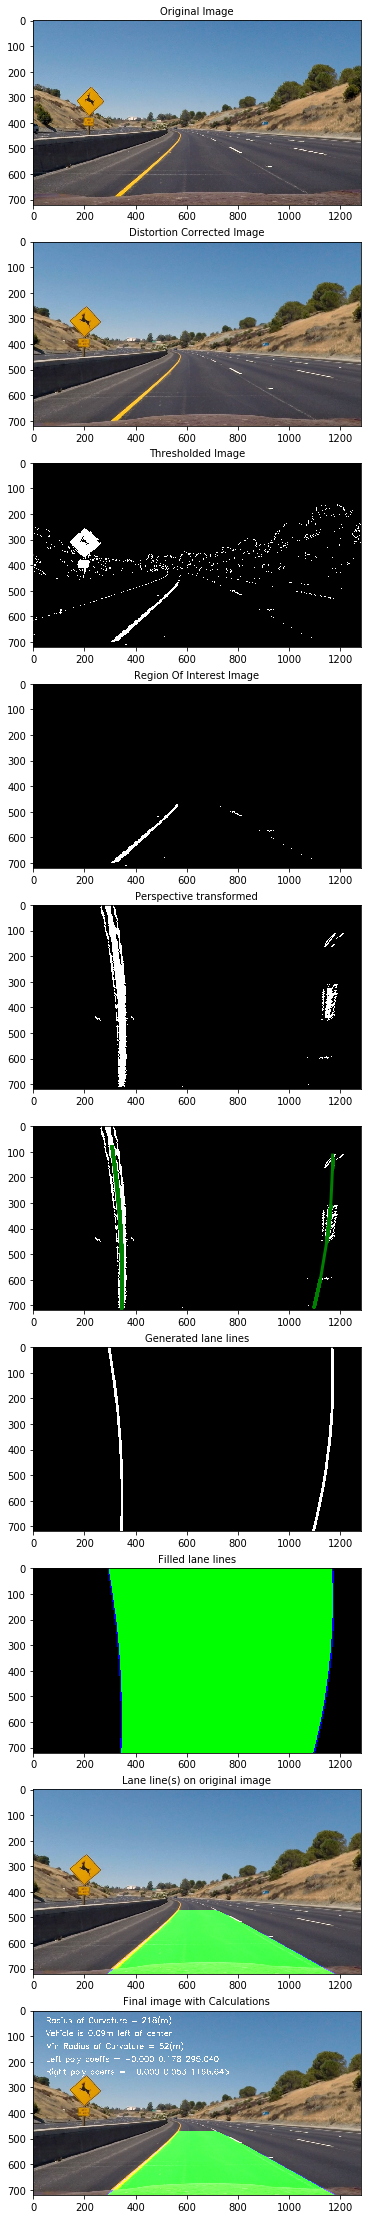

In [19]:

reset_history()
combined_img = pipeline(const_test_image_2, True, True)


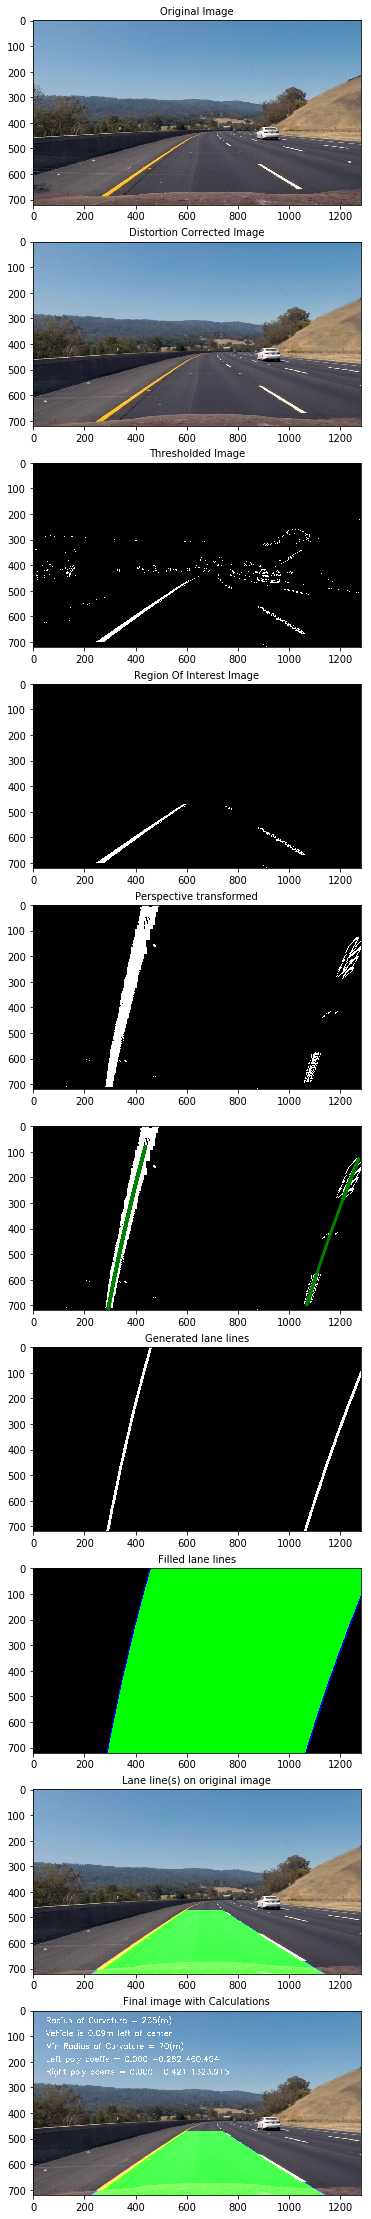

In [20]:

reset_history()
combined_img = pipeline(const_test_image_3, True, True)


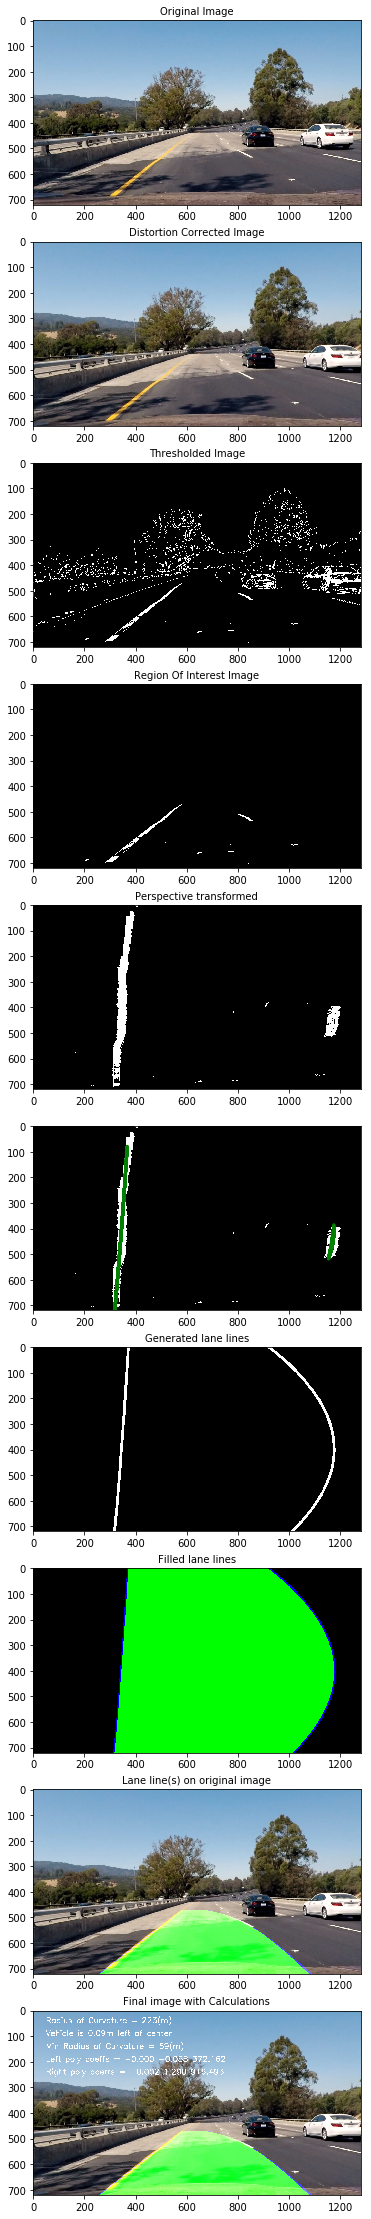

In [21]:

reset_history()
combined_img = pipeline(const_test_image_4, True, True)



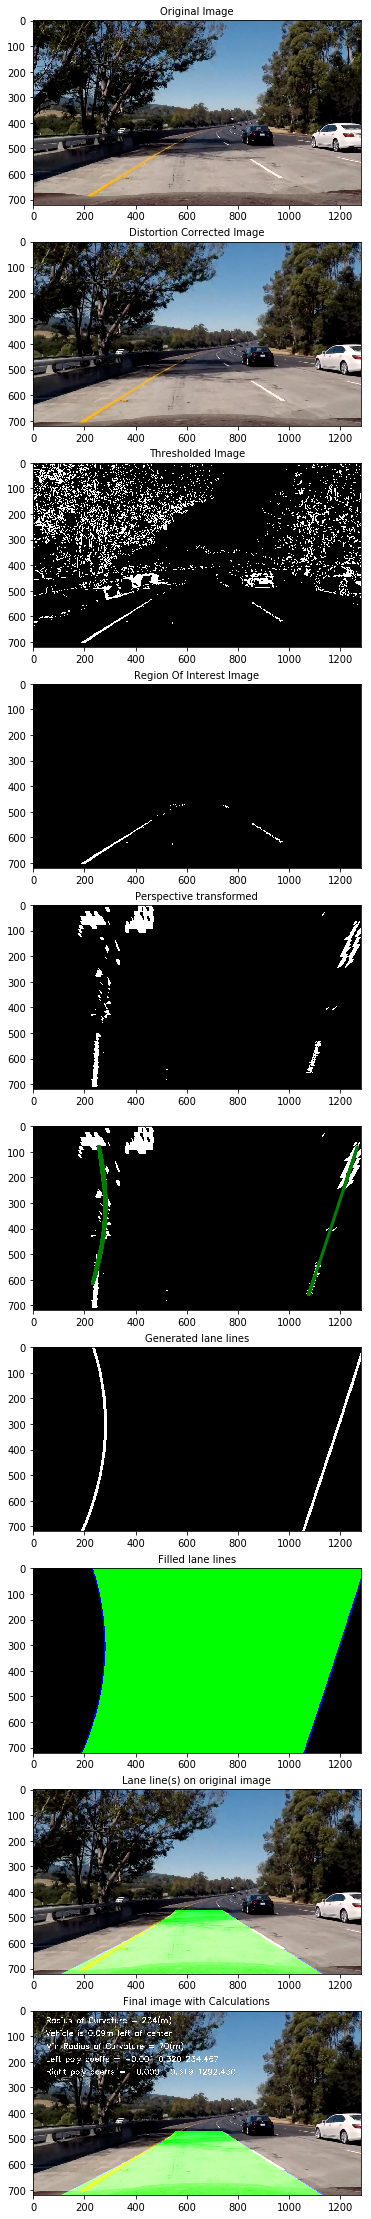

In [22]:

reset_history()
combined_img = pipeline(const_test_image_5, True, True)



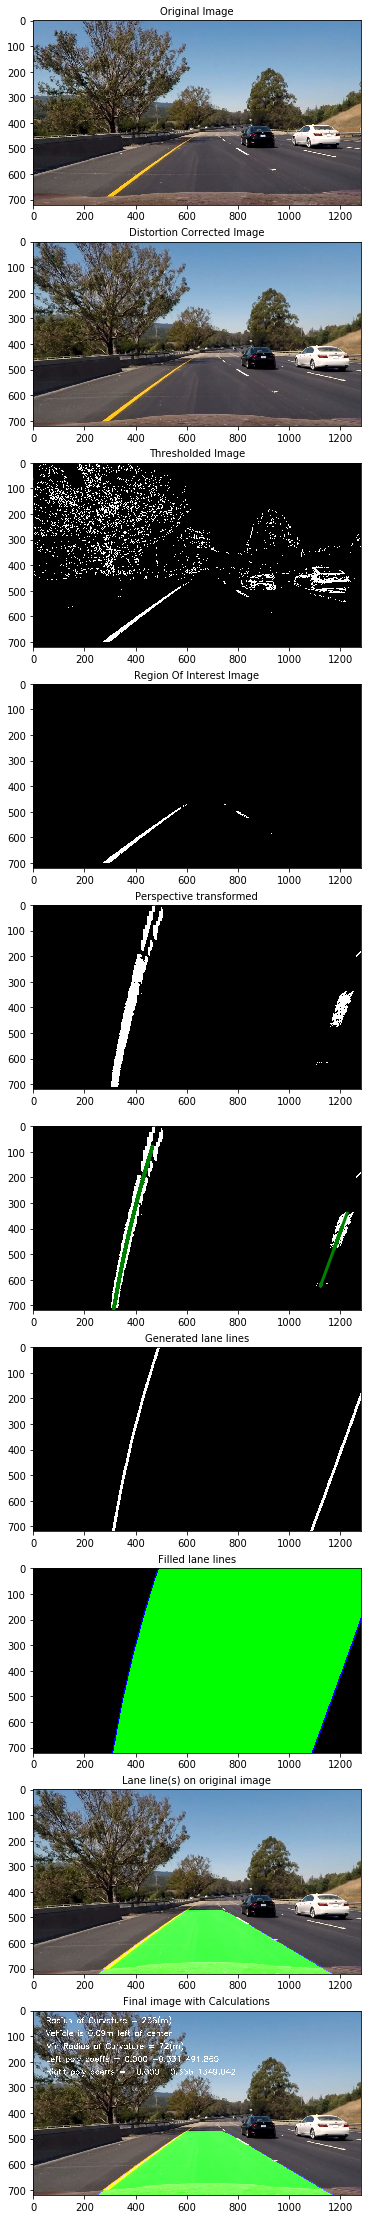

In [23]:

reset_history()
combined_img = pipeline(const_test_image_6, True, True)



# Pipeline as executed on the Project Video

In [ ]:

reset_history()

clip1 = VideoFileClip("./project/project_video.mp4")
output_clip1 = clip1.fl_image(pipeline)
output1 = './project/project_video_output3.mp4'
%time output_clip1.write_videofile(output1, audio=False)



deque([], maxlen=5)

deque([], maxlen=5)

Current point : 336.911186693

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.

Current point : 1115.97019016

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.
[MoviePy] >>>> Building video ./project/project_video_output3.mp4
[MoviePy] Writing video ./project/project_video_output3.mp4


  0%|          | 1/1261 [00:00<06:45,  3.11it/s]


deque([336.91118669345985], maxlen=5)

deque([1115.9701901611597], maxlen=5)

Current point : 336.911186693

Historical point ( mean ) : 336.911186693

Current point is valid.

Current point : 1115.97019016

Historical point ( mean ) : 1115.97019016

Current point is valid.


  0%|          | 2/1261 [00:00<07:10,  2.92it/s]


deque([336.91118669345985, 336.91118669345985], maxlen=5)

deque([1115.9701901611597, 1115.9701901611597], maxlen=5)

Current point : 338.485987162

Historical point ( mean ) : 336.911186693

Current point is valid.

Current point : 1120.30761478

Historical point ( mean ) : 1115.97019016

Current point is valid.


  0%|          | 3/1261 [00:01<07:09,  2.93it/s]


deque([338.48598716157437, 336.91118669345985, 336.91118669345985], maxlen=5)

deque([1120.3076147826534, 1115.9701901611597, 1115.9701901611597], maxlen=5)

Current point : 337.768808266

Historical point ( mean ) : 337.436120183

Current point is valid.

Current point : 1118.2231631

Historical point ( mean ) : 1117.41599837

Current point is valid.


  0%|          | 4/1261 [00:01<07:03,  2.96it/s]


deque([337.76880826625018, 338.48598716157437, 336.91118669345985, 336.91118669345985], maxlen=5)

deque([1118.2231630989709, 1120.3076147826534, 1115.9701901611597, 1115.9701901611597], maxlen=5)

Current point : 336.81206917

Historical point ( mean ) : 337.519292204

Current point is valid.

Current point : 1121.58341641

Historical point ( mean ) : 1117.61778955

Current point is valid.


  0%|          | 5/1261 [00:01<07:00,  2.99it/s]


deque([336.81206917045915, 337.76880826625018, 338.48598716157437, 336.91118669345985, 336.91118669345985], maxlen=5)

deque([1121.5834164061368, 1118.2231630989709, 1120.3076147826534, 1115.9701901611597, 1115.9701901611597], maxlen=5)

Current point : 341.655357463

Historical point ( mean ) : 337.377847597

Current point is valid.

Current point : 1117.58926587

Historical point ( mean ) : 1118.41091492

Current point is valid.


  0%|          | 6/1261 [00:02<06:59,  2.99it/s]


deque([341.65535746293165, 336.81206917045915, 337.76880826625018, 338.48598716157437, 336.91118669345985], maxlen=5)

deque([1117.5892658693247, 1121.5834164061368, 1118.2231630989709, 1120.3076147826534, 1115.9701901611597], maxlen=5)

Current point : 344.959876814

Historical point ( mean ) : 338.326681751

Current point is valid.

Current point : 1118.2776795

Historical point ( mean ) : 1118.73473006

Current point is valid.


  1%|          | 7/1261 [00:02<06:59,  2.99it/s]


deque([344.95987681379938, 341.65535746293165, 336.81206917045915, 337.76880826625018, 338.48598716157437], maxlen=5)

deque([1118.2776795009843, 1117.5892658693247, 1121.5834164061368, 1118.2231630989709, 1120.3076147826534], maxlen=5)

Current point : 345.855941718

Historical point ( mean ) : 339.936419775

Current point is valid.

Current point : 1160.72302221

Historical point ( mean ) : 1119.19622793

Current point is valid.


  1%|          | 8/1261 [00:02<07:02,  2.97it/s]


deque([345.85594171831565, 344.95987681379938, 341.65535746293165, 336.81206917045915, 337.76880826625018], maxlen=5)

deque([1160.7230222050557, 1118.2776795009843, 1117.5892658693247, 1121.5834164061368, 1118.2231630989709], maxlen=5)

Current point : 348.408707132

Historical point ( mean ) : 341.410410686

Current point is valid.

Current point : 1289.68116986

Historical point ( mean ) : 1127.27930942

Current point is invalid.


  1%|          | 9/1261 [00:03<06:56,  3.00it/s]


deque([348.40870713239855, 345.85594171831565, 344.95987681379938, 341.65535746293165, 336.81206917045915], maxlen=5)

deque([1160.7230222050557, 1118.2776795009843, 1117.5892658693247, 1121.5834164061368, 1118.2231630989709], maxlen=5)

Current point : 349.053859631

Historical point ( mean ) : 343.53839046

Current point is valid.

Current point : 1075.23095753

Historical point ( mean ) : 1127.27930942

Current point is valid.


  1%|          | 10/1261 [00:03<06:53,  3.03it/s]


deque([349.0538596310742, 348.40870713239855, 345.85594171831565, 344.95987681379938, 341.65535746293165], maxlen=5)

deque([1075.2309575331731, 1160.7230222050557, 1118.2776795009843, 1117.5892658693247, 1121.5834164061368], maxlen=5)

Current point : 347.710000443

Historical point ( mean ) : 345.986748552

Current point is valid.

Current point : 1112.9109704

Historical point ( mean ) : 1118.6808683

Current point is valid.


  1%|          | 11/1261 [00:03<06:54,  3.01it/s]


deque([347.71000044255351, 349.0538596310742, 348.40870713239855, 345.85594171831565, 344.95987681379938], maxlen=5)

deque([1112.9109704035614, 1075.2309575331731, 1160.7230222050557, 1118.2776795009843, 1117.5892658693247], maxlen=5)

Current point : 346.749186833

Historical point ( mean ) : 347.197677148

Current point is valid.

Current point : 1119.52192883

Historical point ( mean ) : 1116.9463791

Current point is valid.


  1%|          | 12/1261 [00:04<06:48,  3.06it/s]


deque([346.74918683286603, 347.71000044255351, 349.0538596310742, 348.40870713239855, 345.85594171831565], maxlen=5)

deque([1119.5219288329154, 1112.9109704035614, 1075.2309575331731, 1160.7230222050557, 1118.2776795009843], maxlen=5)

Current point : 344.065247997

Historical point ( mean ) : 347.555539151

Current point is valid.

Current point : 1103.91373913

Historical point ( mean ) : 1117.3329117

Current point is valid.


  1%|          | 13/1261 [00:04<06:44,  3.08it/s]


deque([344.06524799651675, 346.74918683286603, 347.71000044255351, 349.0538596310742, 348.40870713239855], maxlen=5)

deque([1103.9137391338272, 1119.5219288329154, 1112.9109704035614, 1075.2309575331731, 1160.7230222050557], maxlen=5)

Current point : 344.667815301

Historical point ( mean ) : 347.197400407

Current point is valid.

Current point : 1107.37764757

Historical point ( mean ) : 1114.46012362

Current point is valid.


  1%|          | 14/1261 [00:04<06:46,  3.06it/s]


deque([344.66781530059495, 344.06524799651675, 346.74918683286603, 347.71000044255351, 349.0538596310742], maxlen=5)

deque([1107.3776475663817, 1103.9137391338272, 1119.5219288329154, 1112.9109704035614, 1075.2309575331731], maxlen=5)

Current point : 343.491238444

Historical point ( mean ) : 346.449222041

Current point is valid.

Current point : 1122.05073624

Historical point ( mean ) : 1103.79104869

Current point is valid.


  1%|          | 15/1261 [00:04<06:44,  3.08it/s]


deque([343.49123844421342, 344.66781530059495, 344.06524799651675, 346.74918683286603, 347.71000044255351], maxlen=5)

deque([1122.0507362393157, 1107.3776475663817, 1103.9137391338272, 1119.5219288329154, 1112.9109704035614], maxlen=5)

Current point : 344.966025159

Historical point ( mean ) : 345.336697803

Current point is valid.

Current point : 1123.64378108

Historical point ( mean ) : 1113.15500444

Current point is valid.


  1%|▏         | 16/1261 [00:05<06:45,  3.07it/s]


deque([344.96602515949792, 343.49123844421342, 344.66781530059495, 344.06524799651675, 346.74918683286603], maxlen=5)

deque([1123.6437810757243, 1122.0507362393157, 1107.3776475663817, 1103.9137391338272, 1119.5219288329154], maxlen=5)

Current point : 346.318978421

Historical point ( mean ) : 344.787902747

Current point is valid.

Current point : 1119.50880775

Historical point ( mean ) : 1115.30156657

Current point is valid.


  1%|▏         | 17/1261 [00:05<06:49,  3.04it/s]


deque([346.31897842128512, 344.96602515949792, 343.49123844421342, 344.66781530059495, 344.06524799651675], maxlen=5)

deque([1119.5088077545915, 1123.6437810757243, 1122.0507362393157, 1107.3776475663817, 1103.9137391338272], maxlen=5)

Current point : 347.751229532

Historical point ( mean ) : 344.701861064

Current point is valid.

Current point : 1114.79984807

Historical point ( mean ) : 1115.29894235

Current point is valid.


  1%|▏         | 18/1261 [00:05<06:45,  3.06it/s]


deque([347.7512295316273, 346.31897842128512, 344.96602515949792, 343.49123844421342, 344.66781530059495], maxlen=5)

deque([1114.7998480741253, 1119.5088077545915, 1123.6437810757243, 1122.0507362393157, 1107.3776475663817], maxlen=5)

Current point : 349.289153318

Historical point ( mean ) : 345.439057371

Current point is valid.

Current point : 1111.43676952

Historical point ( mean ) : 1117.47616414

Current point is valid.


  2%|▏         | 19/1261 [00:06<06:43,  3.08it/s]


deque([349.28915331830603, 347.7512295316273, 346.31897842128512, 344.96602515949792, 343.49123844421342], maxlen=5)

deque([1111.4367695227288, 1114.7998480741253, 1119.5088077545915, 1123.6437810757243, 1122.0507362393157], maxlen=5)

Current point : 349.098592088

Historical point ( mean ) : 346.363324975

Current point is valid.

Current point : 1119.27642576

Historical point ( mean ) : 1118.28798853

Current point is valid.


  2%|▏         | 20/1261 [00:06<06:43,  3.07it/s]


deque([349.09859208826157, 349.28915331830603, 347.7512295316273, 346.31897842128512, 344.96602515949792], maxlen=5)

deque([1119.2764257625936, 1111.4367695227288, 1114.7998480741253, 1119.5088077545915, 1123.6437810757243], maxlen=5)

Current point : 346.97880486

Historical point ( mean ) : 347.484795704

Current point is valid.

Current point : 1124.43932939

Historical point ( mean ) : 1117.73312644

Current point is valid.


  2%|▏         | 21/1261 [00:06<06:40,  3.10it/s]


deque([346.97880485971831, 349.09859208826157, 349.28915331830603, 347.7512295316273, 346.31897842128512], maxlen=5)

deque([1124.4393293874114, 1119.2764257625936, 1111.4367695227288, 1114.7998480741253, 1119.5088077545915], maxlen=5)

Current point : 346.755145356

Historical point ( mean ) : 347.887351644

Current point is valid.

Current point : 1116.11940292

Historical point ( mean ) : 1117.8922361

Current point is valid.


  2%|▏         | 22/1261 [00:07<06:34,  3.14it/s]


deque([346.75514535646511, 346.97880485971831, 349.09859208826157, 349.28915331830603, 347.7512295316273], maxlen=5)

deque([1116.1194029223029, 1124.4393293874114, 1119.2764257625936, 1111.4367695227288, 1114.7998480741253], maxlen=5)

Current point : 345.084109676

Historical point ( mean ) : 347.974585031

Current point is valid.

Current point : 1098.1541576

Historical point ( mean ) : 1117.21435513

Current point is valid.


  2%|▏         | 23/1261 [00:07<06:35,  3.13it/s]


deque([345.08410967612838, 346.75514535646511, 346.97880485971831, 349.09859208826157, 349.28915331830603], maxlen=5)

deque([1098.1541576047775, 1116.1194029223029, 1124.4393293874114, 1119.2764257625936, 1111.4367695227288], maxlen=5)

Current point : 341.982099667

Historical point ( mean ) : 347.44116106

Current point is valid.

Current point : 1104.06757577

Historical point ( mean ) : 1113.88521704

Current point is valid.


  2%|▏         | 24/1261 [00:07<06:41,  3.08it/s]


deque([341.98209966744162, 345.08410967612838, 346.75514535646511, 346.97880485971831, 349.09859208826157], maxlen=5)

deque([1104.0675757672591, 1098.1541576047775, 1116.1194029223029, 1124.4393293874114, 1119.2764257625936], maxlen=5)

Current point : 340.307654998

Historical point ( mean ) : 345.97975033

Current point is valid.

Current point : 1100.12026859

Historical point ( mean ) : 1112.41137829

Current point is valid.


  2%|▏         | 25/1261 [00:08<06:44,  3.06it/s]


deque([340.30765499809434, 341.98209966744162, 345.08410967612838, 346.75514535646511, 346.97880485971831], maxlen=5)

deque([1100.1202685893627, 1104.0675757672591, 1098.1541576047775, 1116.1194029223029, 1124.4393293874114], maxlen=5)

Current point : 336.818363122

Historical point ( mean ) : 344.221562912

Current point is valid.

Current point : 1100.10827491

Historical point ( mean ) : 1108.58014685

Current point is valid.


  2%|▏         | 26/1261 [00:08<06:43,  3.06it/s]


deque([336.8183631215195, 340.30765499809434, 341.98209966744162, 345.08410967612838, 346.75514535646511], maxlen=5)

deque([1100.1082749070119, 1100.1202685893627, 1104.0675757672591, 1098.1541576047775, 1116.1194029223029], maxlen=5)

Current point : 331.740412871

Historical point ( mean ) : 342.189474564

Current point is valid.

Current point : 1102.5041103

Historical point ( mean ) : 1103.71393596

Current point is valid.


  2%|▏         | 27/1261 [00:08<06:39,  3.09it/s]


deque([331.74041287083304, 336.8183631215195, 340.30765499809434, 341.98209966744162, 345.08410967612838], maxlen=5)

deque([1102.5041102977966, 1100.1082749070119, 1100.1202685893627, 1104.0675757672591, 1098.1541576047775], maxlen=5)

Current point : 330.699853632

Historical point ( mean ) : 339.186528067

Current point is valid.

Current point : 1113.28127

Historical point ( mean ) : 1100.99087743

Current point is valid.


  2%|▏         | 28/1261 [00:09<06:40,  3.08it/s]


deque([330.69985363155001, 331.74041287083304, 336.8183631215195, 340.30765499809434, 341.98209966744162], maxlen=5)

deque([1113.281270000811, 1102.5041102977966, 1100.1082749070119, 1100.1202685893627, 1104.0675757672591], maxlen=5)

Current point : 326.133096879

Historical point ( mean ) : 336.309676858

Current point is valid.

Current point : 1110.24523503

Historical point ( mean ) : 1104.01629991

Current point is valid.


  2%|▏         | 29/1261 [00:09<06:41,  3.07it/s]


deque([326.13309687882145, 330.69985363155001, 331.74041287083304, 336.8183631215195, 340.30765499809434], maxlen=5)

deque([1110.2452350308406, 1113.281270000811, 1102.5041102977966, 1100.1082749070119, 1100.1202685893627], maxlen=5)

Current point : 325.516639092

Historical point ( mean ) : 333.1398763

Current point is valid.

Current point : 1108.26407476

Historical point ( mean ) : 1105.25183177

Current point is valid.


  2%|▏         | 30/1261 [00:09<06:49,  3.01it/s]


deque([325.51663909191063, 326.13309687882145, 330.69985363155001, 331.74041287083304, 336.8183631215195], maxlen=5)

deque([1108.2640747563676, 1110.2452350308406, 1113.281270000811, 1102.5041102977966, 1100.1082749070119], maxlen=5)

Current point : 324.832760851

Historical point ( mean ) : 330.181673119

Current point is valid.

Current point : 1106.37972099

Historical point ( mean ) : 1106.880593

Current point is valid.


  2%|▏         | 31/1261 [00:10<06:49,  3.00it/s]


deque([324.83276085130848, 325.51663909191063, 326.13309687882145, 330.69985363155001, 331.74041287083304], maxlen=5)

deque([1106.379720988893, 1108.2640747563676, 1110.2452350308406, 1113.281270000811, 1102.5041102977966], maxlen=5)

Current point : 325.435991433

Historical point ( mean ) : 327.784552665

Current point is valid.

Current point : 1107.7906088

Historical point ( mean ) : 1108.13488221

Current point is valid.


  3%|▎         | 32/1261 [00:10<06:51,  2.99it/s]


deque([325.43599143252345, 324.83276085130848, 325.51663909191063, 326.13309687882145, 330.69985363155001], maxlen=5)

deque([1107.790608800676, 1106.379720988893, 1108.2640747563676, 1110.2452350308406, 1113.281270000811], maxlen=5)

Current point : 325.805839924

Historical point ( mean ) : 326.523668377

Current point is valid.

Current point : 1134.83710609

Historical point ( mean ) : 1109.19218192

Current point is valid.


  3%|▎         | 33/1261 [00:10<06:43,  3.04it/s]


deque([325.80583992414125, 325.43599143252345, 324.83276085130848, 325.51663909191063, 326.13309687882145], maxlen=5)

deque([1134.8371060878646, 1107.790608800676, 1106.379720988893, 1108.2640747563676, 1110.2452350308406], maxlen=5)

Current point : 326.247970047

Historical point ( mean ) : 325.544865636

Current point is valid.

Current point : 1193.85593927

Historical point ( mean ) : 1113.50334913

Current point is valid.


  3%|▎         | 34/1261 [00:11<06:45,  3.03it/s]


deque([326.24797004712718, 325.80583992414125, 325.43599143252345, 324.83276085130848, 325.51663909191063], maxlen=5)

deque([1193.8559392669633, 1134.8371060878646, 1107.790608800676, 1106.379720988893, 1108.2640747563676], maxlen=5)

Current point : 326.16259495

Historical point ( mean ) : 325.567840269

Current point is valid.

Current point : 1115.20263692

Historical point ( mean ) : 1130.22548998

Current point is valid.


  3%|▎         | 35/1261 [00:11<06:46,  3.02it/s]


deque([326.16259495013071, 326.24797004712718, 325.80583992414125, 325.43599143252345, 324.83276085130848], maxlen=5)

deque([1115.2026369214598, 1193.8559392669633, 1134.8371060878646, 1107.790608800676, 1106.379720988893], maxlen=5)

Current point : 326.514146317

Historical point ( mean ) : 325.697031441

Current point is valid.

Current point : 1107.90522468

Historical point ( mean ) : 1131.61320241

Current point is valid.


  3%|▎         | 36/1261 [00:11<06:48,  3.00it/s]


deque([326.51414631658082, 326.16259495013071, 326.24797004712718, 325.80583992414125, 325.43599143252345], maxlen=5)

deque([1107.905224675337, 1115.2026369214598, 1193.8559392669633, 1134.8371060878646, 1107.790608800676], maxlen=5)

Current point : 329.373346121

Historical point ( mean ) : 326.033308534

Current point is valid.

Current point : 1102.20296133

Historical point ( mean ) : 1131.91830315

Current point is valid.


  3%|▎         | 37/1261 [00:12<06:47,  3.01it/s]


deque([329.37334612057333, 326.51414631658082, 326.16259495013071, 326.24797004712718, 325.80583992414125], maxlen=5)

deque([1102.2029613279153, 1107.905224675337, 1115.2026369214598, 1193.8559392669633, 1134.8371060878646], maxlen=5)

Current point : 329.037759021

Historical point ( mean ) : 326.820779472

Current point is valid.

Current point : 1098.99636556

Historical point ( mean ) : 1130.80077366

Current point is valid.


  3%|▎         | 38/1261 [00:12<06:46,  3.01it/s]


deque([329.03775902081111, 329.37334612057333, 326.51414631658082, 326.16259495013071, 326.24797004712718], maxlen=5)

deque([1098.9963655645704, 1102.2029613279153, 1107.905224675337, 1115.2026369214598, 1193.8559392669633], maxlen=5)

Current point : 330.418138349

Historical point ( mean ) : 327.467163291

Current point is valid.

Current point : 1095.58528949

Historical point ( mean ) : 1123.63262555

Current point is valid.


  3%|▎         | 39/1261 [00:12<06:49,  2.99it/s]


deque([330.41813834939757, 329.03775902081111, 329.37334612057333, 326.51414631658082, 326.16259495013071], maxlen=5)

deque([1095.5852894880866, 1098.9963655645704, 1102.2029613279153, 1107.905224675337, 1115.2026369214598], maxlen=5)

Current point : 332.011238774

Historical point ( mean ) : 328.301196951

Current point is valid.

Current point : 1106.17268558

Historical point ( mean ) : 1103.9784956

Current point is valid.


  3%|▎         | 40/1261 [00:13<06:50,  2.97it/s]


deque([332.01123877423561, 330.41813834939757, 329.03775902081111, 329.37334612057333, 326.51414631658082], maxlen=5)

deque([1106.172685581543, 1095.5852894880866, 1098.9963655645704, 1102.2029613279153, 1107.905224675337], maxlen=5)

Current point : 330.134197939

Historical point ( mean ) : 329.470925716

Current point is valid.

Current point : 1106.80244951

Historical point ( mean ) : 1102.17250533

Current point is valid.


  3%|▎         | 41/1261 [00:13<06:49,  2.98it/s]


deque([330.1341979386446, 332.01123877423561, 330.41813834939757, 329.03775902081111, 329.37334612057333], maxlen=5)

deque([1106.8024495070688, 1106.172685581543, 1095.5852894880866, 1098.9963655645704, 1102.2029613279153], maxlen=5)

Current point : 330.916024208

Historical point ( mean ) : 330.194936041

Current point is valid.

Current point : 1109.9848388

Historical point ( mean ) : 1101.95195029

Current point is valid.


  3%|▎         | 42/1261 [00:13<06:52,  2.96it/s]


deque([330.91602420847926, 330.1341979386446, 332.01123877423561, 330.41813834939757, 329.03775902081111], maxlen=5)

deque([1109.9848387969714, 1106.8024495070688, 1106.172685581543, 1095.5852894880866, 1098.9963655645704], maxlen=5)

Current point : 332.194983318

Historical point ( mean ) : 330.503471658

Current point is valid.

Current point : 1105.91397592

Historical point ( mean ) : 1103.50832579

Current point is valid.


  3%|▎         | 43/1261 [00:14<08:34,  2.37it/s]


deque([332.19498331846182, 330.91602420847926, 330.1341979386446, 332.01123877423561, 330.41813834939757], maxlen=5)

deque([1105.9139759181603, 1109.9848387969714, 1106.8024495070688, 1106.172685581543, 1095.5852894880866], maxlen=5)

Current point : 335.924273733

Historical point ( mean ) : 331.134916518

Current point is valid.

Current point : 1108.01745153

Historical point ( mean ) : 1104.89184786

Current point is valid.


  3%|▎         | 44/1261 [00:14<08:22,  2.42it/s]


deque([335.92427373262507, 332.19498331846182, 330.91602420847926, 330.1341979386446, 332.01123877423561], maxlen=5)

deque([1108.0174515298886, 1105.9139759181603, 1109.9848387969714, 1106.8024495070688, 1106.172685581543], maxlen=5)

Current point : 335.393334698

Historical point ( mean ) : 332.236143594

Current point is valid.

Current point : 1108.06988797

Historical point ( mean ) : 1107.37828027

Current point is valid.


  4%|▎         | 45/1261 [00:15<08:13,  2.46it/s]


deque([335.39333469815529, 335.92427373262507, 332.19498331846182, 330.91602420847926, 330.1341979386446], maxlen=5)

deque([1108.0698879671286, 1108.0174515298886, 1105.9139759181603, 1109.9848387969714, 1106.8024495070688], maxlen=5)

Current point : 335.598390119

Historical point ( mean ) : 332.912562779

Current point is valid.

Current point : 1136.52325173

Historical point ( mean ) : 1107.75772074

Current point is valid.


  4%|▎         | 46/1261 [00:15<08:25,  2.40it/s]


deque([335.59839011944604, 335.39333469815529, 335.92427373262507, 332.19498331846182, 330.91602420847926], maxlen=5)

deque([1136.5232517332254, 1108.0698879671286, 1108.0174515298886, 1105.9139759181603, 1109.9848387969714], maxlen=5)

Current point : 335.602128442

Historical point ( mean ) : 334.005401215

Current point is valid.

Current point : 1181.32736063

Historical point ( mean ) : 1113.70188119

Current point is valid.


  4%|▎         | 47/1261 [00:16<08:15,  2.45it/s]


deque([335.60212844167182, 335.59839011944604, 335.39333469815529, 335.92427373262507, 332.19498331846182], maxlen=5)

deque([1181.3273606281407, 1136.5232517332254, 1108.0698879671286, 1108.0174515298886, 1105.9139759181603], maxlen=5)

Current point : 334.995714435

Historical point ( mean ) : 334.942622062

Current point is valid.

Current point : 1098.88397538

Historical point ( mean ) : 1127.97038556

Current point is valid.


  4%|▍         | 48/1261 [00:16<08:31,  2.37it/s]


deque([334.99571443472735, 335.60212844167182, 335.59839011944604, 335.39333469815529, 335.92427373262507], maxlen=5)

deque([1098.8839753835784, 1181.3273606281407, 1136.5232517332254, 1108.0698879671286, 1108.0174515298886], maxlen=5)

Current point : 335.975416876

Historical point ( mean ) : 335.502768285

Current point is valid.

Current point : 1101.7775407

Historical point ( mean ) : 1126.56438545

Current point is valid.


  4%|▍         | 49/1261 [00:16<08:25,  2.40it/s]


deque([335.97541687562779, 334.99571443472735, 335.60212844167182, 335.59839011944604, 335.39333469815529], maxlen=5)

deque([1101.7775407018582, 1098.8839753835784, 1181.3273606281407, 1136.5232517332254, 1108.0698879671286], maxlen=5)

Current point : 335.375602785

Historical point ( mean ) : 335.512996914

Current point is valid.

Current point : 1106.65730666

Historical point ( mean ) : 1125.31640328

Current point is valid.


  4%|▍         | 50/1261 [00:17<08:08,  2.48it/s]


deque([335.37560278509994, 335.97541687562779, 334.99571443472735, 335.60212844167182, 335.59839011944604], maxlen=5)

deque([1106.6573066578537, 1101.7775407018582, 1098.8839753835784, 1181.3273606281407, 1136.5232517332254], maxlen=5)

Current point : 335.522332622

Historical point ( mean ) : 335.509450531

Current point is valid.

Current point : 1100.49416782

Historical point ( mean ) : 1125.03388702

Current point is valid.


  4%|▍         | 51/1261 [00:17<08:02,  2.51it/s]


deque([335.52233262166368, 335.37560278509994, 335.97541687562779, 334.99571443472735, 335.60212844167182], maxlen=5)

deque([1100.494167821349, 1106.6573066578537, 1101.7775407018582, 1098.8839753835784, 1181.3273606281407], maxlen=5)

Current point : 335.686220514

Historical point ( mean ) : 335.494239032

Current point is valid.

Current point : 1108.75774812

Historical point ( mean ) : 1117.82807024

Current point is valid.


  4%|▍         | 52/1261 [00:18<08:24,  2.39it/s]


deque([335.6862205142213, 335.52233262166368, 335.37560278509994, 335.97541687562779, 334.99571443472735], maxlen=5)

deque([1108.7577481188739, 1100.494167821349, 1106.6573066578537, 1101.7775407018582, 1098.8839753835784], maxlen=5)

Current point : 337.600952375

Historical point ( mean ) : 335.511057446

Current point is valid.

Current point : 1109.66625119

Historical point ( mean ) : 1103.31414774

Current point is valid.


  4%|▍         | 53/1261 [00:18<08:21,  2.41it/s]


deque([337.60095237456119, 335.6862205142213, 335.52233262166368, 335.37560278509994, 335.97541687562779], maxlen=5)

deque([1109.6662511885233, 1108.7577481188739, 1100.494167821349, 1106.6573066578537, 1101.7775407018582], maxlen=5)

Current point : 337.090827751

Historical point ( mean ) : 336.032105034

Current point is valid.

Current point : 1109.29511699

Historical point ( mean ) : 1105.4706029

Current point is valid.


  4%|▍         | 54/1261 [00:19<08:22,  2.40it/s]


deque([337.09082775069595, 337.60095237456119, 335.6862205142213, 335.52233262166368, 335.37560278509994], maxlen=5)

deque([1109.2951169937203, 1109.6662511885233, 1108.7577481188739, 1100.494167821349, 1106.6573066578537], maxlen=5)

Current point : 337.466912215

Historical point ( mean ) : 336.255187209

Current point is valid.

Current point : 1106.86370258

Historical point ( mean ) : 1106.97411816

Current point is valid.


  4%|▍         | 55/1261 [00:19<08:23,  2.40it/s]


deque([337.46691221529352, 337.09082775069595, 337.60095237456119, 335.6862205142213, 335.52233262166368], maxlen=5)

deque([1106.8637025785285, 1109.2951169937203, 1109.6662511885233, 1108.7577481188739, 1100.494167821349], maxlen=5)

Current point : 339.983572604

Historical point ( mean ) : 336.673449095

Current point is valid.

Current point : 1105.4313868

Historical point ( mean ) : 1107.01539734

Current point is valid.


  4%|▍         | 56/1261 [00:19<08:38,  2.32it/s]


deque([339.98357260407863, 337.46691221529352, 337.09082775069595, 337.60095237456119, 335.6862205142213], maxlen=5)

deque([1105.4313867975688, 1106.8637025785285, 1109.2951169937203, 1109.6662511885233, 1108.7577481188739], maxlen=5)

Current point : 340.492242956

Historical point ( mean ) : 337.565697092

Current point is valid.

Current point : 1104.76996253

Historical point ( mean ) : 1108.00284114

Current point is valid.


  5%|▍         | 57/1261 [00:20<08:30,  2.36it/s]


deque([340.49224295602664, 339.98357260407863, 337.46691221529352, 337.09082775069595, 337.60095237456119], maxlen=5)

deque([1104.7699625254836, 1105.4313867975688, 1106.8637025785285, 1109.2951169937203, 1109.6662511885233], maxlen=5)

Current point : 342.050807785

Historical point ( mean ) : 338.52690158

Current point is valid.

Current point : 1122.54598496

Historical point ( mean ) : 1107.20528402

Current point is valid.


  5%|▍         | 58/1261 [00:20<08:11,  2.45it/s]


deque([342.05080778454027, 340.49224295602664, 339.98357260407863, 337.46691221529352, 337.09082775069595], maxlen=5)

deque([1122.5459849593524, 1104.7699625254836, 1105.4313867975688, 1106.8637025785285, 1109.2951169937203], maxlen=5)

Current point : 340.455907877

Historical point ( mean ) : 339.416872662

Current point is valid.

Current point : 1187.89236552

Historical point ( mean ) : 1109.78123077

Current point is valid.


  5%|▍         | 59/1261 [00:21<08:00,  2.50it/s]


deque([340.45590787715281, 342.05080778454027, 340.49224295602664, 339.98357260407863, 337.46691221529352], maxlen=5)

deque([1187.8923655233348, 1122.5459849593524, 1104.7699625254836, 1105.4313867975688, 1106.8637025785285], maxlen=5)

Current point : 341.620941518

Historical point ( mean ) : 340.089888687

Current point is valid.

Current point : 1087.42270584

Historical point ( mean ) : 1125.50068048

Current point is valid.


  5%|▍         | 60/1261 [00:21<08:21,  2.40it/s]


deque([341.62094151831297, 340.45590787715281, 342.05080778454027, 340.49224295602664, 339.98357260407863], maxlen=5)

deque([1087.4227058417034, 1187.8923655233348, 1122.5459849593524, 1104.7699625254836, 1105.4313867975688], maxlen=5)

Current point : 341.134225292

Historical point ( mean ) : 340.920694548

Current point is valid.

Current point : 1095.64803603

Historical point ( mean ) : 1121.61248113

Current point is valid.


  5%|▍         | 61/1261 [00:21<08:19,  2.40it/s]


deque([341.13422529229524, 341.62094151831297, 340.45590787715281, 342.05080778454027, 340.49224295602664], maxlen=5)

deque([1095.6480360254047, 1087.4227058417034, 1187.8923655233348, 1122.5459849593524, 1104.7699625254836], maxlen=5)

Current point : 339.224822921

Historical point ( mean ) : 341.150825086

Current point is valid.

Current point : 1094.6424317

Historical point ( mean ) : 1119.65581098

Current point is valid.


  5%|▍         | 62/1261 [00:22<08:15,  2.42it/s]


deque([339.22482292087028, 341.13422529229524, 341.62094151831297, 340.45590787715281, 342.05080778454027], maxlen=5)

deque([1094.6424316974333, 1095.6480360254047, 1087.4227058417034, 1187.8923655233348, 1122.5459849593524], maxlen=5)

Current point : 337.055975836

Historical point ( mean ) : 340.897341079

Current point is valid.

Current point : 1098.18492613

Historical point ( mean ) : 1117.63030481

Current point is valid.


  5%|▍         | 63/1261 [00:22<08:17,  2.41it/s]


deque([337.05597583623978, 339.22482292087028, 341.13422529229524, 341.62094151831297, 340.45590787715281], maxlen=5)

deque([1098.1849261295456, 1094.6424316974333, 1095.6480360254047, 1087.4227058417034, 1187.8923655233348], maxlen=5)

Current point : 334.811186076

Historical point ( mean ) : 339.898374689

Current point is valid.

Current point : 1098.07901391

Historical point ( mean ) : 1112.75809304

Current point is valid.


  5%|▌         | 64/1261 [00:23<08:29,  2.35it/s]


deque([334.8111860761249, 337.05597583623978, 339.22482292087028, 341.13422529229524, 341.62094151831297], maxlen=5)

deque([1098.0790139127489, 1098.1849261295456, 1094.6424316974333, 1095.6480360254047, 1087.4227058417034], maxlen=5)

Current point : 331.296883783

Historical point ( mean ) : 338.769430329

Current point is valid.

Current point : 1104.94132394

Historical point ( mean ) : 1094.79542272

Current point is valid.


  5%|▌         | 65/1261 [00:23<08:27,  2.36it/s]


deque([331.29688378253115, 334.8111860761249, 337.05597583623978, 339.22482292087028, 341.13422529229524], maxlen=5)

deque([1104.9413239380233, 1098.0790139127489, 1098.1849261295456, 1094.6424316974333, 1095.6480360254047], maxlen=5)

Current point : 327.407048153

Historical point ( mean ) : 336.704618782

Current point is valid.

Current point : 1102.62424459

Historical point ( mean ) : 1098.29914634

Current point is valid.


  5%|▌         | 66/1261 [00:24<08:14,  2.42it/s]


deque([327.40704815283635, 331.29688378253115, 334.8111860761249, 337.05597583623978, 339.22482292087028], maxlen=5)

deque([1102.6242445892785, 1104.9413239380233, 1098.0790139127489, 1098.1849261295456, 1094.6424316974333], maxlen=5)

Current point : 324.477480533

Historical point ( mean ) : 333.959183354

Current point is valid.

Current point : 1100.32272885

Historical point ( mean ) : 1099.69438805

Current point is valid.


  5%|▌         | 67/1261 [00:24<08:01,  2.48it/s]


deque([324.47748053285545, 327.40704815283635, 331.29688378253115, 334.8111860761249, 337.05597583623978], maxlen=5)

deque([1100.3227288468449, 1102.6242445892785, 1104.9413239380233, 1098.0790139127489, 1098.1849261295456], maxlen=5)

Current point : 322.737169684

Historical point ( mean ) : 331.009714876

Current point is valid.

Current point : 1093.52621623

Historical point ( mean ) : 1100.83044748

Current point is valid.


  5%|▌         | 68/1261 [00:24<08:14,  2.41it/s]


deque([322.73716968430335, 324.47748053285545, 327.40704815283635, 331.29688378253115, 334.8111860761249], maxlen=5)

deque([1093.526216231061, 1100.3227288468449, 1102.6242445892785, 1104.9413239380233, 1098.0790139127489], maxlen=5)

Current point : 320.454108745

Historical point ( mean ) : 328.145953646

Current point is valid.

Current point : 1091.56010551

Historical point ( mean ) : 1099.8987055

Current point is valid.


  5%|▌         | 69/1261 [00:25<08:05,  2.45it/s]


deque([320.45410874548344, 322.73716968430335, 324.47748053285545, 327.40704815283635, 331.29688378253115], maxlen=5)

deque([1091.5601055076884, 1093.526216231061, 1100.3227288468449, 1102.6242445892785, 1104.9413239380233], maxlen=5)

Current point : 319.442335007

Historical point ( mean ) : 325.27453818

Current point is valid.

Current point : 1146.70368069

Historical point ( mean ) : 1098.59492382

Current point is valid.


  6%|▌         | 70/1261 [00:25<07:55,  2.51it/s]


deque([319.44233500723607, 320.45410874548344, 322.73716968430335, 324.47748053285545, 327.40704815283635], maxlen=5)

deque([1146.7036806878584, 1091.5601055076884, 1093.526216231061, 1100.3227288468449, 1102.6242445892785], maxlen=5)

Current point : 316.95320932

Historical point ( mean ) : 322.903628425

Current point is valid.

Current point : 1114.77795962

Historical point ( mean ) : 1106.94739517

Current point is valid.


  6%|▌         | 71/1261 [00:26<07:47,  2.54it/s]


deque([316.95320931978733, 319.44233500723607, 320.45410874548344, 322.73716968430335, 324.47748053285545], maxlen=5)

deque([1114.7779596242781, 1146.7036806878584, 1091.5601055076884, 1093.526216231061, 1100.3227288468449], maxlen=5)

Current point : 316.939300192

Historical point ( mean ) : 320.812860658

Current point is valid.

Current point : 1074.54725365

Historical point ( mean ) : 1109.37813818

Current point is valid.


  6%|▌         | 72/1261 [00:26<08:04,  2.46it/s]


deque([316.93930019249854, 316.95320931978733, 319.44233500723607, 320.45410874548344, 322.73716968430335], maxlen=5)

deque([1074.5472536465736, 1114.7779596242781, 1146.7036806878584, 1091.5601055076884, 1093.526216231061], maxlen=5)

Current point : 316.384851102

Historical point ( mean ) : 319.30522459

Current point is valid.

Current point : 1080.94060218

Historical point ( mean ) : 1104.22304314

Current point is valid.


  6%|▌         | 73/1261 [00:26<07:57,  2.49it/s]


deque([316.38485110165232, 316.93930019249854, 316.95320931978733, 319.44233500723607, 320.45410874548344], maxlen=5)

deque([1080.940602175755, 1074.5472536465736, 1114.7779596242781, 1146.7036806878584, 1091.5601055076884], maxlen=5)

Current point : 316.126284591

Historical point ( mean ) : 318.034760873

Current point is valid.

Current point : 1083.91303708

Historical point ( mean ) : 1101.70592033

Current point is valid.


  6%|▌         | 74/1261 [00:27<07:45,  2.55it/s]


deque([316.12628459062455, 316.38485110165232, 316.93930019249854, 316.95320931978733, 319.44233500723607], maxlen=5)

deque([1083.9130370806008, 1080.940602175755, 1074.5472536465736, 1114.7779596242781, 1146.7036806878584], maxlen=5)

Current point : 317.259386708

Historical point ( mean ) : 317.169196042

Current point is valid.

Current point : 1082.65599816

Historical point ( mean ) : 1100.17650664

Current point is valid.


  6%|▌         | 75/1261 [00:27<07:41,  2.57it/s]


deque([317.25938670816117, 316.12628459062455, 316.38485110165232, 316.93930019249854, 316.95320931978733], maxlen=5)

deque([1082.6559981619562, 1083.9130370806008, 1080.940602175755, 1074.5472536465736, 1114.7779596242781], maxlen=5)

Current point : 316.778399775

Historical point ( mean ) : 316.732606383

Current point is valid.

Current point : 1075.27315303

Historical point ( mean ) : 1087.36697014

Current point is valid.


  6%|▌         | 76/1261 [00:28<07:55,  2.49it/s]


deque([316.77839977545477, 317.25938670816117, 316.12628459062455, 316.38485110165232, 316.93930019249854], maxlen=5)

deque([1075.2731530272067, 1082.6559981619562, 1083.9130370806008, 1080.940602175755, 1074.5472536465736], maxlen=5)

Current point : 318.795246071

Historical point ( mean ) : 316.697644474

Current point is valid.

Current point : 1067.50467136

Historical point ( mean ) : 1079.46600882

Current point is valid.


  6%|▌         | 77/1261 [00:28<07:50,  2.51it/s]


deque([318.79524607073739, 316.77839977545477, 317.25938670816117, 316.12628459062455, 316.38485110165232], maxlen=5)

deque([1067.5046713615232, 1075.2731530272067, 1082.6559981619562, 1083.9130370806008, 1080.940602175755], maxlen=5)

Current point : 316.937896228

Historical point ( mean ) : 317.068833649

Current point is valid.

Current point : 1081.31687636

Historical point ( mean ) : 1078.05749236

Current point is valid.


  6%|▌         | 78/1261 [00:28<07:40,  2.57it/s]


deque([316.93789622759255, 318.79524607073739, 316.77839977545477, 317.25938670816117, 316.12628459062455], maxlen=5)

deque([1081.3168763566916, 1067.5046713615232, 1075.2731530272067, 1082.6559981619562, 1083.9130370806008], maxlen=5)

Current point : 317.051309814

Historical point ( mean ) : 317.179442675

Current point is valid.

Current point : 1077.31541386

Historical point ( mean ) : 1078.1327472

Current point is valid.


  6%|▋         | 79/1261 [00:29<07:40,  2.57it/s]


deque([317.05130981411395, 316.93789622759255, 318.79524607073739, 316.77839977545477, 317.25938670816117], maxlen=5)

deque([1077.3154138644227, 1081.3168763566916, 1067.5046713615232, 1075.2731530272067, 1082.6559981619562], maxlen=5)

Current point : 314.799649604

Historical point ( mean ) : 317.364447719

Current point is valid.

Current point : 1080.73017422

Historical point ( mean ) : 1076.81322255

Current point is valid.


  6%|▋         | 80/1261 [00:29<07:54,  2.49it/s]


deque([314.79964960435939, 317.05130981411395, 316.93789622759255, 318.79524607073739, 316.77839977545477], maxlen=5)

deque([1080.7301742192824, 1077.3154138644227, 1081.3168763566916, 1067.5046713615232, 1075.2731530272067], maxlen=5)

Current point : 311.95762573

Historical point ( mean ) : 316.872500298

Current point is valid.

Current point : 1080.82229503

Historical point ( mean ) : 1076.42805777

Current point is valid.


  6%|▋         | 81/1261 [00:29<07:50,  2.51it/s]


deque([311.95762572972808, 314.79964960435939, 317.05130981411395, 316.93789622759255, 318.79524607073739], maxlen=5)

deque([1080.8222950304792, 1080.7301742192824, 1077.3154138644227, 1081.3168763566916, 1067.5046713615232], maxlen=5)

Current point : 313.489977809

Historical point ( mean ) : 315.908345489

Current point is valid.

Current point : 1075.49163651

Historical point ( mean ) : 1077.53788617

Current point is valid.


  7%|▋         | 82/1261 [00:30<07:43,  2.55it/s]


deque([313.48997780928187, 311.95762572972808, 314.79964960435939, 317.05130981411395, 316.93789622759255], maxlen=5)

deque([1075.4916365123945, 1080.8222950304792, 1080.7301742192824, 1077.3154138644227, 1081.3168763566916], maxlen=5)

Current point : 310.914805055

Historical point ( mean ) : 314.847291837

Current point is valid.

Current point : 1124.15305848

Historical point ( mean ) : 1079.1352792

Current point is valid.


  7%|▋         | 83/1261 [00:30<07:34,  2.59it/s]


deque([310.91480505548304, 313.48997780928187, 311.95762572972808, 314.79964960435939, 317.05130981411395], maxlen=5)

deque([1124.1530584754823, 1075.4916365123945, 1080.8222950304792, 1080.7301742192824, 1077.3154138644227], maxlen=5)

Current point : 307.91363733

Historical point ( mean ) : 313.642673603

Current point is valid.

Current point : 980.658540146

Historical point ( mean ) : 1087.70251562

Current point is invalid.


  7%|▋         | 84/1261 [00:31<07:49,  2.51it/s]


deque([307.91363733017511, 310.91480505548304, 313.48997780928187, 311.95762572972808, 314.79964960435939], maxlen=5)

deque([1124.1530584754823, 1075.4916365123945, 1080.8222950304792, 1080.7301742192824, 1077.3154138644227], maxlen=5)

Current point : 304.250273645

Historical point ( mean ) : 311.815139106

Current point is valid.

Current point : 1104.64440083

Historical point ( mean ) : 1087.70251562

Current point is valid.


  7%|▋         | 85/1261 [00:31<07:49,  2.50it/s]


deque([304.25027364535413, 307.91363733017511, 310.91480505548304, 313.48997780928187, 311.95762572972808], maxlen=5)

deque([1104.644400827437, 1124.1530584754823, 1075.4916365123945, 1080.8222950304792, 1080.7301742192824], maxlen=5)

Current point : 302.185419971

Historical point ( mean ) : 309.705263914

Current point is valid.

Current point : 1076.85215979

Historical point ( mean ) : 1093.16831301

Current point is valid.


  7%|▋         | 86/1261 [00:31<07:45,  2.52it/s]


deque([302.18541997139272, 304.25027364535413, 307.91363733017511, 310.91480505548304, 313.48997780928187], maxlen=5)

deque([1076.8521597879078, 1104.644400827437, 1124.1530584754823, 1075.4916365123945, 1080.8222950304792], maxlen=5)

Current point : 299.917971373

Historical point ( mean ) : 307.750822762

Current point is valid.

Current point : 1075.52959346

Historical point ( mean ) : 1092.39271013

Current point is valid.


  7%|▋         | 87/1261 [00:32<07:39,  2.55it/s]


deque([299.91797137341206, 302.18541997139272, 304.25027364535413, 307.91363733017511, 310.91480505548304], maxlen=5)

deque([1075.5295934579374, 1076.8521597879078, 1104.644400827437, 1124.1530584754823, 1075.4916365123945], maxlen=5)

Current point : 299.665605742

Historical point ( mean ) : 305.036421475

Current point is valid.

Current point : 1072.46274453

Historical point ( mean ) : 1091.33416981

Current point is valid.


  7%|▋         | 88/1261 [00:32<07:56,  2.46it/s]


deque([299.66560574243783, 299.91797137341206, 302.18541997139272, 304.25027364535413, 307.91363733017511], maxlen=5)

deque([1072.4627445272213, 1075.5295934579374, 1076.8521597879078, 1104.644400827437, 1124.1530584754823], maxlen=5)

Current point : 298.629786889

Historical point ( mean ) : 302.786581613

Current point is valid.

Current point : 1074.30895086

Historical point ( mean ) : 1090.72839142

Current point is valid.


  7%|▋         | 89/1261 [00:33<07:57,  2.46it/s]


deque([298.62978688863899, 299.66560574243783, 299.91797137341206, 302.18541997139272, 304.25027364535413], maxlen=5)

deque([1074.3089508577757, 1072.4627445272213, 1075.5295934579374, 1076.8521597879078, 1104.644400827437], maxlen=5)

Current point : 297.859928061

Historical point ( mean ) : 300.929811524

Current point is valid.

Current point : 1075.18894208

Historical point ( mean ) : 1080.75956989

Current point is valid.


  7%|▋         | 90/1261 [00:33<07:47,  2.51it/s]


deque([297.85992806127103, 298.62978688863899, 299.66560574243783, 299.91797137341206, 302.18541997139272], maxlen=5)

deque([1075.1889420760306, 1074.3089508577757, 1072.4627445272213, 1075.5295934579374, 1076.8521597879078], maxlen=5)

Current point : 301.246128045

Historical point ( mean ) : 299.651742407

Current point is valid.

Current point : 1088.29435615

Historical point ( mean ) : 1074.86847814

Current point is valid.


  7%|▋         | 91/1261 [00:33<07:41,  2.53it/s]


deque([301.24612804467762, 297.85992806127103, 298.62978688863899, 299.66560574243783, 299.91797137341206], maxlen=5)

deque([1088.2943561514701, 1075.1889420760306, 1074.3089508577757, 1072.4627445272213, 1075.5295934579374], maxlen=5)

Current point : 298.860362651

Historical point ( mean ) : 299.463884022

Current point is valid.

Current point : 1088.30021678

Historical point ( mean ) : 1077.15691741

Current point is valid.


  7%|▋         | 92/1261 [00:34<07:55,  2.46it/s]


deque([298.86036265089467, 301.24612804467762, 297.85992806127103, 298.62978688863899, 299.66560574243783], maxlen=5)

deque([1088.3002167766931, 1088.2943561514701, 1075.1889420760306, 1074.3089508577757, 1072.4627445272213], maxlen=5)

Current point : 299.8119012

Historical point ( mean ) : 299.252362278

Current point is valid.

Current point : 1081.68733245

Historical point ( mean ) : 1079.71104208

Current point is valid.


  7%|▋         | 93/1261 [00:34<07:45,  2.51it/s]


deque([299.81190120014082, 298.86036265089467, 301.24612804467762, 297.85992806127103, 298.62978688863899], maxlen=5)

deque([1081.6873324492924, 1088.3002167766931, 1088.2943561514701, 1075.1889420760306, 1074.3089508577757], maxlen=5)

Current point : 301.578401096

Historical point ( mean ) : 299.281621369

Current point is valid.

Current point : 1081.22380437

Historical point ( mean ) : 1081.55595966

Current point is valid.


  7%|▋         | 94/1261 [00:35<07:35,  2.56it/s]


deque([301.57840109624999, 299.81190120014082, 298.86036265089467, 301.24612804467762, 297.85992806127103], maxlen=5)

deque([1081.2238043738651, 1081.6873324492924, 1088.3002167766931, 1088.2943561514701, 1075.1889420760306], maxlen=5)

Current point : 302.211336527

Historical point ( mean ) : 299.871344211

Current point is valid.

Current point : 1076.35566378

Historical point ( mean ) : 1082.93893037

Current point is valid.


  8%|▊         | 95/1261 [00:35<07:27,  2.60it/s]


deque([302.21133652662763, 301.57840109624999, 299.81190120014082, 298.86036265089467, 301.24612804467762], maxlen=5)

deque([1076.3556637819925, 1081.2238043738651, 1081.6873324492924, 1088.3002167766931, 1088.2943561514701], maxlen=5)

Current point : 301.862939619

Historical point ( mean ) : 300.741625904

Current point is valid.

Current point : 1124.96351578

Historical point ( mean ) : 1083.17227471

Current point is valid.


  8%|▊         | 96/1261 [00:35<07:47,  2.49it/s]


deque([301.862939619158, 302.21133652662763, 301.57840109624999, 299.81190120014082, 298.86036265089467], maxlen=5)

deque([1124.9635157757184, 1076.3556637819925, 1081.2238043738651, 1081.6873324492924, 1088.3002167766931], maxlen=5)

Current point : 302.213616451

Historical point ( mean ) : 300.864988219

Current point is valid.

Current point : 1153.77407896

Historical point ( mean ) : 1090.50610663

Current point is valid.


  8%|▊         | 97/1261 [00:36<07:42,  2.51it/s]


deque([302.21361645105577, 301.862939619158, 302.21133652662763, 301.57840109624999, 299.81190120014082], maxlen=5)

deque([1153.7740789640736, 1124.9635157757184, 1076.3556637819925, 1081.2238043738651, 1081.6873324492924], maxlen=5)

Current point : 303.965894121

Historical point ( mean ) : 301.535638979

Current point is valid.

Current point : 1067.93572722

Historical point ( mean ) : 1103.60087907

Current point is valid.


  8%|▊         | 98/1261 [00:36<07:32,  2.57it/s]


deque([303.96589412130908, 302.21361645105577, 301.862939619158, 302.21133652662763, 301.57840109624999], maxlen=5)

deque([1067.9357272184097, 1153.7740789640736, 1124.9635157757184, 1076.3556637819925, 1081.2238043738651], maxlen=5)

Current point : 304.287831711

Historical point ( mean ) : 302.366437563

Current point is valid.

Current point : 1062.89344222

Historical point ( mean ) : 1100.85055802

Current point is valid.


  8%|▊         | 99/1261 [00:37<07:25,  2.61it/s]


deque([304.28783171099803, 303.96589412130908, 302.21361645105577, 301.862939619158, 302.21133652662763], maxlen=5)

deque([1062.8934422158191, 1067.9357272184097, 1153.7740789640736, 1124.9635157757184, 1076.3556637819925], maxlen=5)

Current point : 306.51905303

Historical point ( mean ) : 302.908323686

Current point is valid.

Current point : 1079.08882463

Historical point ( mean ) : 1097.18448559

Current point is valid.


  8%|▊         | 100/1261 [00:37<07:41,  2.52it/s]


deque([306.51905302953247, 304.28783171099803, 303.96589412130908, 302.21361645105577, 301.862939619158], maxlen=5)

deque([1079.0888246337379, 1062.8934422158191, 1067.9357272184097, 1153.7740789640736, 1124.9635157757184], maxlen=5)

Current point : 307.374186071

Historical point ( mean ) : 303.769866986

Current point is valid.

Current point : 1059.16970459

Historical point ( mean ) : 1097.73111776

Current point is valid.


  8%|▊         | 101/1261 [00:37<07:34,  2.55it/s]


deque([307.37418607070146, 306.51905302953247, 304.28783171099803, 303.96589412130908, 302.21361645105577], maxlen=5)

deque([1059.1697045932337, 1079.0888246337379, 1062.8934422158191, 1067.9357272184097, 1153.7740789640736], maxlen=5)

Current point : 308.973573355

Historical point ( mean ) : 304.872116277

Current point is valid.

Current point : 1052.92795968

Historical point ( mean ) : 1084.57235553

Current point is valid.


  8%|▊         | 102/1261 [00:38<07:30,  2.57it/s]


deque([308.97357335524788, 307.37418607070146, 306.51905302953247, 304.28783171099803, 303.96589412130908], maxlen=5)

deque([1052.9279596805941, 1059.1697045932337, 1079.0888246337379, 1062.8934422158191, 1067.9357272184097], maxlen=5)

Current point : 310.771724993

Historical point ( mean ) : 306.224107658

Current point is valid.

Current point : 1061.76035516

Historical point ( mean ) : 1064.40313167

Current point is valid.


  8%|▊         | 103/1261 [00:38<07:23,  2.61it/s]


deque([310.77172499311774, 308.97357335524788, 307.37418607070146, 306.51905302953247, 304.28783171099803], maxlen=5)

deque([1061.7603551595978, 1052.9279596805941, 1059.1697045932337, 1079.0888246337379, 1062.8934422158191], maxlen=5)

Current point : 312.507343511

Historical point ( mean ) : 307.585273832

Current point is valid.

Current point : 1068.1133494

Historical point ( mean ) : 1063.16805726

Current point is valid.


  8%|▊         | 104/1261 [00:39<07:42,  2.50it/s]


deque([312.50734351061578, 310.77172499311774, 308.97357335524788, 307.37418607070146, 306.51905302953247], maxlen=5)

deque([1068.1133494040544, 1061.7603551595978, 1052.9279596805941, 1059.1697045932337, 1079.0888246337379], maxlen=5)

Current point : 312.866397085

Historical point ( mean ) : 309.229176192

Current point is valid.

Current point : 1069.93511168

Historical point ( mean ) : 1064.21203869

Current point is valid.


  8%|▊         | 105/1261 [00:39<07:36,  2.53it/s]


deque([312.86639708451952, 312.50734351061578, 310.77172499311774, 308.97357335524788, 307.37418607070146], maxlen=5)

deque([1069.9351116776656, 1068.1133494040544, 1061.7603551595978, 1052.9279596805941, 1059.1697045932337], maxlen=5)

Current point : 312.174001876

Historical point ( mean ) : 310.498645003

Current point is valid.

Current point : 1074.09288593

Historical point ( mean ) : 1062.3812961

Current point is valid.


  8%|▊         | 106/1261 [00:39<07:30,  2.57it/s]


deque([312.17400187561464, 312.86639708451952, 312.50734351061578, 310.77172499311774, 308.97357335524788], maxlen=5)

deque([1074.092885928269, 1069.9351116776656, 1068.1133494040544, 1061.7603551595978, 1052.9279596805941], maxlen=5)

Current point : 313.967483796

Historical point ( mean ) : 311.458608164

Current point is valid.

Current point : 1075.86877946

Historical point ( mean ) : 1065.36593237

Current point is valid.


  8%|▊         | 107/1261 [00:40<07:23,  2.60it/s]


deque([313.96748379551991, 312.17400187561464, 312.86639708451952, 312.50734351061578, 310.77172499311774], maxlen=5)

deque([1075.868779456662, 1074.092885928269, 1069.9351116776656, 1068.1133494040544, 1061.7603551595978], maxlen=5)

Current point : 313.763341065

Historical point ( mean ) : 312.457390252

Current point is valid.

Current point : 1114.89798882

Historical point ( mean ) : 1069.95409633

Current point is valid.


  9%|▊         | 108/1261 [00:40<07:38,  2.51it/s]


deque([313.76334106531885, 313.96748379551991, 312.17400187561464, 312.86639708451952, 312.50734351061578], maxlen=5)

deque([1114.8979888204242, 1075.868779456662, 1074.092885928269, 1069.9351116776656, 1068.1133494040544], maxlen=5)

Current point : 315.786543208

Historical point ( mean ) : 313.055713466

Current point is valid.

Current point : 1092.79384839

Historical point ( mean ) : 1080.58162306

Current point is valid.


  9%|▊         | 109/1261 [00:41<07:35,  2.53it/s]


deque([315.78654320754038, 313.76334106531885, 313.96748379551991, 312.17400187561464, 312.86639708451952], maxlen=5)

deque([1092.7938483880744, 1114.8979888204242, 1075.868779456662, 1074.092885928269, 1069.9351116776656], maxlen=5)

Current point : 315.846676263

Historical point ( mean ) : 313.711553406

Current point is valid.

Current point : 1184.64464931

Historical point ( mean ) : 1085.51772285

Current point is valid.


  9%|▊         | 110/1261 [00:41<07:26,  2.58it/s]


deque([315.84667626344702, 315.78654320754038, 313.76334106531885, 313.96748379551991, 312.17400187561464], maxlen=5)

deque([1184.6446493065805, 1092.7938483880744, 1114.8979888204242, 1075.868779456662, 1074.092885928269], maxlen=5)

Current point : 316.095591885

Historical point ( mean ) : 314.307609241

Current point is valid.

Current point : 1083.88306185

Historical point ( mean ) : 1108.45963038

Current point is valid.


  9%|▉         | 111/1261 [00:41<07:19,  2.62it/s]


deque([316.095591885359, 315.84667626344702, 315.78654320754038, 313.76334106531885, 313.96748379551991], maxlen=5)

deque([1083.8830618501431, 1184.6446493065805, 1092.7938483880744, 1114.8979888204242, 1075.868779456662], maxlen=5)

Current point : 317.231371279

Historical point ( mean ) : 315.091927243

Current point is valid.

Current point : 1086.33204625

Historical point ( mean ) : 1110.41766556

Current point is valid.


  9%|▉         | 112/1261 [00:42<07:39,  2.50it/s]


deque([317.23137127852601, 316.095591885359, 315.84667626344702, 315.78654320754038, 313.76334106531885], maxlen=5)

deque([1086.3320462493789, 1083.8830618501431, 1184.6446493065805, 1092.7938483880744, 1114.8979888204242], maxlen=5)

Current point : 315.662856915

Historical point ( mean ) : 315.74470474

Current point is valid.

Current point : 1096.14569953

Historical point ( mean ) : 1112.51031892

Current point is valid.


  9%|▉         | 113/1261 [00:42<07:35,  2.52it/s]


deque([315.66285691453805, 317.23137127852601, 316.095591885359, 315.84667626344702, 315.78654320754038], maxlen=5)

deque([1096.1456995288499, 1086.3320462493789, 1083.8830618501431, 1184.6446493065805, 1092.7938483880744], maxlen=5)

Current point : 316.235832941

Historical point ( mean ) : 316.12460791

Current point is valid.

Current point : 1094.46725686

Historical point ( mean ) : 1108.75986106

Current point is valid.


  9%|▉         | 114/1261 [00:42<07:29,  2.55it/s]


deque([316.2358329405015, 315.66285691453805, 317.23137127852601, 316.095591885359, 315.84667626344702], maxlen=5)

deque([1094.4672568574133, 1096.1456995288499, 1086.3320462493789, 1083.8830618501431, 1184.6446493065805], maxlen=5)

Current point : 317.298396575

Historical point ( mean ) : 316.214465856

Current point is valid.

Current point : 1098.02479374

Historical point ( mean ) : 1109.09454276

Current point is valid.


  9%|▉         | 115/1261 [00:43<07:24,  2.58it/s]


deque([317.29839657516482, 316.2358329405015, 315.66285691453805, 317.23137127852601, 316.095591885359], maxlen=5)

deque([1098.024793744471, 1094.4672568574133, 1096.1456995288499, 1086.3320462493789, 1083.8830618501431], maxlen=5)

Current point : 319.989407638

Historical point ( mean ) : 316.504809919

Current point is valid.

Current point : 1094.95362982

Historical point ( mean ) : 1091.77057165

Current point is valid.


  9%|▉         | 116/1261 [00:43<07:45,  2.46it/s]


deque([319.98940763836697, 317.29839657516482, 316.2358329405015, 315.66285691453805, 317.23137127852601], maxlen=5)

deque([1094.9536298227547, 1098.024793744471, 1094.4672568574133, 1096.1456995288499, 1086.3320462493789], maxlen=5)

Current point : 319.75467645

Historical point ( mean ) : 317.283573069

Current point is valid.

Current point : 1089.86105639

Historical point ( mean ) : 1093.98468524

Current point is valid.


  9%|▉         | 117/1261 [00:44<07:39,  2.49it/s]


deque([319.75467645026254, 319.98940763836697, 317.29839657516482, 316.2358329405015, 315.66285691453805], maxlen=5)

deque([1089.861056386738, 1094.9536298227547, 1098.024793744471, 1094.4672568574133, 1096.1456995288499], maxlen=5)

Current point : 320.246121447

Historical point ( mean ) : 317.788234104

Current point is valid.

Current point : 1089.06040692

Historical point ( mean ) : 1094.69048727

Current point is valid.


  9%|▉         | 118/1261 [00:44<07:31,  2.53it/s]


deque([320.24612144671374, 319.75467645026254, 319.98940763836697, 317.29839657516482, 316.2358329405015], maxlen=5)

deque([1089.0604069185702, 1089.861056386738, 1094.9536298227547, 1098.024793744471, 1094.4672568574133], maxlen=5)

Current point : 323.067353066

Historical point ( mean ) : 318.70488701

Current point is valid.

Current point : 1089.61998725

Historical point ( mean ) : 1093.27342875

Current point is valid.


  9%|▉         | 119/1261 [00:44<07:22,  2.58it/s]


deque([323.06735306563849, 320.24612144671374, 319.75467645026254, 319.98940763836697, 317.29839657516482], maxlen=5)

deque([1089.6199872474222, 1089.0604069185702, 1089.861056386738, 1094.9536298227547, 1098.024793744471], maxlen=5)

Current point : 324.618477401

Historical point ( mean ) : 320.071191035

Current point is valid.

Current point : 1088.61937014

Historical point ( mean ) : 1092.30397482

Current point is valid.


 10%|▉         | 120/1261 [00:45<07:36,  2.50it/s]


deque([324.61847740070209, 323.06735306563849, 320.24612144671374, 319.75467645026254, 319.98940763836697], maxlen=5)

deque([1088.6193701365664, 1089.6199872474222, 1089.0604069185702, 1089.861056386738, 1094.9536298227547], maxlen=5)

Current point : 327.142199128

Historical point ( mean ) : 321.5352072

Current point is valid.

Current point : 1111.26762299

Historical point ( mean ) : 1090.4228901

Current point is valid.


 10%|▉         | 121/1261 [00:45<07:39,  2.48it/s]


deque([327.14219912847824, 324.61847740070209, 323.06735306563849, 320.24612144671374, 319.75467645026254], maxlen=5)

deque([1111.2676229896547, 1088.6193701365664, 1089.6199872474222, 1089.0604069185702, 1089.861056386738], maxlen=5)

Current point : 327.813162002

Historical point ( mean ) : 322.965765498

Current point is valid.

Current point : 1214.06238789

Historical point ( mean ) : 1093.68568874

Current point is invalid.


 10%|▉         | 122/1261 [00:46<07:28,  2.54it/s]


deque([327.81316200160757, 327.14219912847824, 324.61847740070209, 323.06735306563849, 320.24612144671374], maxlen=5)

deque([1111.2676229896547, 1088.6193701365664, 1089.6199872474222, 1089.0604069185702, 1089.861056386738], maxlen=5)

Current point : 328.986044443

Historical point ( mean ) : 324.577462609

Current point is valid.

Current point : 1051.1501665

Historical point ( mean ) : 1093.68568874

Current point is valid.


 10%|▉         | 123/1261 [00:46<07:22,  2.57it/s]


deque([328.98604444345585, 327.81316200160757, 327.14219912847824, 324.61847740070209, 323.06735306563849], maxlen=5)

deque([1051.1501665008373, 1111.2676229896547, 1088.6193701365664, 1089.6199872474222, 1089.0604069185702], maxlen=5)

Current point : 330.946793664

Historical point ( mean ) : 326.325447208

Current point is valid.

Current point : 1083.04945426

Historical point ( mean ) : 1085.94351076

Current point is valid.


 10%|▉         | 124/1261 [00:46<07:36,  2.49it/s]


deque([330.94679366371417, 328.98604444345585, 327.81316200160757, 327.14219912847824, 324.61847740070209], maxlen=5)

deque([1083.0494542638839, 1051.1501665008373, 1111.2676229896547, 1088.6193701365664, 1089.6199872474222], maxlen=5)

Current point : 331.79241946

Historical point ( mean ) : 327.901335328

Current point is valid.

Current point : 1090.60543316

Historical point ( mean ) : 1084.74132023

Current point is valid.


 10%|▉         | 125/1261 [00:47<07:32,  2.51it/s]


deque([331.79241945962599, 330.94679366371417, 328.98604444345585, 327.81316200160757, 327.14219912847824], maxlen=5)

deque([1090.605433161177, 1083.0494542638839, 1051.1501665008373, 1111.2676229896547, 1088.6193701365664], maxlen=5)

Current point : 332.421003579

Historical point ( mean ) : 329.336123739

Current point is valid.

Current point : 1076.26890227

Historical point ( mean ) : 1084.93840941

Current point is valid.


 10%|▉         | 126/1261 [00:47<07:25,  2.55it/s]


deque([332.4210035787853, 331.79241945962599, 330.94679366371417, 328.98604444345585, 327.81316200160757], maxlen=5)

deque([1076.2689022729539, 1090.605433161177, 1083.0494542638839, 1051.1501665008373, 1111.2676229896547], maxlen=5)

Current point : 332.985233816

Historical point ( mean ) : 330.391884629

Current point is valid.

Current point : 1086.43254663

Historical point ( mean ) : 1082.46831584

Current point is valid.


 10%|█         | 127/1261 [00:48<07:16,  2.60it/s]


deque([332.985233815828, 332.4210035787853, 331.79241945962599, 330.94679366371417, 328.98604444345585], maxlen=5)

deque([1086.4325466348025, 1076.2689022729539, 1090.605433161177, 1083.0494542638839, 1051.1501665008373], maxlen=5)

Current point : 334.087681653

Historical point ( mean ) : 331.426298992

Current point is valid.

Current point : 1095.55565256

Historical point ( mean ) : 1077.50130057

Current point is valid.


 10%|█         | 128/1261 [00:48<07:25,  2.54it/s]


deque([334.08768165349119, 332.985233815828, 332.4210035787853, 331.79241945962599, 330.94679366371417], maxlen=5)

deque([1095.5556525649174, 1086.4325466348025, 1076.2689022729539, 1090.605433161177, 1083.0494542638839], maxlen=5)

Current point : 334.280637006

Historical point ( mean ) : 332.446626434

Current point is valid.

Current point : 1100.85950928

Historical point ( mean ) : 1086.38239778

Current point is valid.


 10%|█         | 129/1261 [00:48<07:24,  2.55it/s]


deque([334.28063700616246, 334.08768165349119, 332.985233815828, 332.4210035787853, 331.79241945962599], maxlen=5)

deque([1100.8595092817293, 1095.5556525649174, 1086.4325466348025, 1076.2689022729539, 1090.605433161177], maxlen=5)

Current point : 336.770445188

Historical point ( mean ) : 333.113395103

Current point is valid.

Current point : 1103.01283707

Historical point ( mean ) : 1089.94440878

Current point is valid.


 10%|█         | 130/1261 [00:49<07:19,  2.57it/s]


deque([336.77044518787301, 334.28063700616246, 334.08768165349119, 332.985233815828, 332.4210035787853], maxlen=5)

deque([1103.0128370738423, 1100.8595092817293, 1095.5556525649174, 1086.4325466348025, 1076.2689022729539], maxlen=5)

Current point : 336.182325126

Historical point ( mean ) : 334.109000248

Current point is valid.

Current point : 1096.36692138

Historical point ( mean ) : 1092.42588957

Current point is valid.


 10%|█         | 131/1261 [00:49<07:17,  2.58it/s]


deque([336.18232512571899, 336.77044518787301, 334.28063700616246, 334.08768165349119, 332.985233815828], maxlen=5)

deque([1096.3669213798155, 1103.0128370738423, 1100.8595092817293, 1095.5556525649174, 1086.4325466348025], maxlen=5)

Current point : 339.358760311

Historical point ( mean ) : 334.861264558

Current point is valid.

Current point : 1097.22793218

Historical point ( mean ) : 1096.44549339

Current point is valid.


 10%|█         | 132/1261 [00:50<07:27,  2.52it/s]


deque([339.35876031108103, 336.18232512571899, 336.77044518787301, 334.28063700616246, 334.08768165349119], maxlen=5)

deque([1097.2279321771891, 1096.3669213798155, 1103.0128370738423, 1100.8595092817293, 1095.5556525649174], maxlen=5)

Current point : 341.748077225

Historical point ( mean ) : 336.135969857

Current point is valid.

Current point : 1096.75353582

Historical point ( mean ) : 1098.6045705

Current point is valid.


 11%|█         | 133/1261 [00:50<07:21,  2.56it/s]


deque([341.74807722467949, 339.35876031108103, 336.18232512571899, 336.77044518787301, 334.28063700616246], maxlen=5)

deque([1096.7535358160894, 1097.2279321771891, 1096.3669213798155, 1103.0128370738423, 1100.8595092817293], maxlen=5)

Current point : 342.935225745

Historical point ( mean ) : 337.668048971

Current point is valid.

Current point : 1101.00696027

Historical point ( mean ) : 1098.84414715

Current point is valid.


 11%|█         | 134/1261 [00:50<07:13,  2.60it/s]


deque([342.93522574547086, 341.74807722467949, 339.35876031108103, 336.18232512571899, 336.77044518787301], maxlen=5)

deque([1101.006960270407, 1096.7535358160894, 1097.2279321771891, 1096.3669213798155, 1103.0128370738423], maxlen=5)

Current point : 345.246963021

Historical point ( mean ) : 339.398966719

Current point is valid.

Current point : 1110.414907

Historical point ( mean ) : 1098.87363734

Current point is valid.


 11%|█         | 135/1261 [00:51<07:04,  2.65it/s]


deque([345.24696302082782, 342.93522574547086, 341.74807722467949, 339.35876031108103, 336.18232512571899], maxlen=5)

deque([1110.414907004762, 1101.006960270407, 1096.7535358160894, 1097.2279321771891, 1096.3669213798155], maxlen=5)

Current point : 346.717526813

Historical point ( mean ) : 341.094270286

Current point is valid.

Current point : 1094.65358999

Historical point ( mean ) : 1100.35405133

Current point is valid.


 11%|█         | 136/1261 [00:51<07:18,  2.56it/s]


deque([346.71752681295203, 345.24696302082782, 342.93522574547086, 341.74807722467949, 339.35876031108103], maxlen=5)

deque([1094.6535899936614, 1110.414907004762, 1101.006960270407, 1096.7535358160894, 1097.2279321771891], maxlen=5)

Current point : 346.818995701

Historical point ( mean ) : 343.201310623

Current point is valid.

Current point : 1092.53546932

Historical point ( mean ) : 1100.01138505

Current point is valid.


 11%|█         | 137/1261 [00:51<07:15,  2.58it/s]


deque([346.8189957007769, 346.71752681295203, 345.24696302082782, 342.93522574547086, 341.74807722467949], maxlen=5)

deque([1092.5354693231277, 1094.6535899936614, 1110.414907004762, 1101.006960270407, 1096.7535358160894], maxlen=5)

Current point : 346.383152212

Historical point ( mean ) : 344.693357701

Current point is valid.

Current point : 1128.29034868

Historical point ( mean ) : 1099.07289248

Current point is valid.


 11%|█         | 138/1261 [00:52<07:08,  2.62it/s]


deque([346.3831522116742, 346.8189957007769, 346.71752681295203, 345.24696302082782, 342.93522574547086], maxlen=5)

deque([1128.290348680782, 1092.5354693231277, 1094.6535899936614, 1110.414907004762, 1101.006960270407], maxlen=5)

Current point : 344.140199603

Historical point ( mean ) : 345.620372698

Current point is valid.

Current point : 1115.25391464

Historical point ( mean ) : 1105.38025505

Current point is valid.


 11%|█         | 139/1261 [00:52<07:01,  2.66it/s]


deque([344.14019960273089, 346.3831522116742, 346.8189957007769, 346.71752681295203, 345.24696302082782], maxlen=5)

deque([1115.2539146356653, 1128.290348680782, 1092.5354693231277, 1094.6535899936614, 1110.414907004762], maxlen=5)

Current point : 342.342415186

Historical point ( mean ) : 345.86136747

Current point is valid.

Current point : 1407.3064842

Historical point ( mean ) : 1108.22964593

Current point is invalid.


 11%|█         | 140/1261 [00:53<07:16,  2.57it/s]


deque([342.34241518636355, 344.14019960273089, 346.3831522116742, 346.8189957007769, 346.71752681295203], maxlen=5)

deque([1115.2539146356653, 1128.290348680782, 1092.5354693231277, 1094.6535899936614, 1110.414907004762], maxlen=5)

Current point : 341.728057838

Historical point ( mean ) : 345.280457903

Current point is valid.

Current point : 1119.87491779

Historical point ( mean ) : 1108.22964593

Current point is valid.


 11%|█         | 141/1261 [00:53<07:19,  2.55it/s]


deque([341.7280578383714, 342.34241518636355, 344.14019960273089, 346.3831522116742, 346.8189957007769], maxlen=5)

deque([1119.8749177870357, 1115.2539146356653, 1128.290348680782, 1092.5354693231277, 1094.6535899936614], maxlen=5)

Current point : 339.64239668

Historical point ( mean ) : 344.282564108

Current point is valid.

Current point : 1112.39925214

Historical point ( mean ) : 1110.12164808

Current point is valid.


 11%|█▏        | 142/1261 [00:53<07:07,  2.62it/s]


deque([339.64239668022958, 341.7280578383714, 342.34241518636355, 344.14019960273089, 346.3831522116742], maxlen=5)

deque([1112.399252141545, 1119.8749177870357, 1115.2539146356653, 1128.290348680782, 1092.5354693231277], maxlen=5)

Current point : 339.037661711

Historical point ( mean ) : 342.847244304

Current point is valid.

Current point : 1112.52621779

Historical point ( mean ) : 1113.67078051

Current point is valid.


 11%|█▏        | 143/1261 [00:54<07:06,  2.62it/s]


deque([339.0376617113119, 339.64239668022958, 341.7280578383714, 342.34241518636355, 344.14019960273089], maxlen=5)

deque([1112.5262177910035, 1112.399252141545, 1119.8749177870357, 1115.2539146356653, 1128.290348680782], maxlen=5)

Current point : 339.820236648

Historical point ( mean ) : 341.378146204

Current point is valid.

Current point : 1107.45991744

Historical point ( mean ) : 1117.66893021

Current point is valid.


 11%|█▏        | 144/1261 [00:54<07:29,  2.49it/s]


deque([339.82023664770077, 339.0376617113119, 339.64239668022958, 341.7280578383714, 342.34241518636355], maxlen=5)

deque([1107.4599174392665, 1112.5262177910035, 1112.399252141545, 1119.8749177870357, 1115.2539146356653], maxlen=5)

Current point : 338.283025974

Historical point ( mean ) : 340.514153613

Current point is valid.

Current point : 1105.52535703

Historical point ( mean ) : 1113.50284396

Current point is valid.


 11%|█▏        | 145/1261 [00:55<07:24,  2.51it/s]


deque([338.28302597410925, 339.82023664770077, 339.0376617113119, 339.64239668022958, 341.7280578383714], maxlen=5)

deque([1105.5253570261552, 1107.4599174392665, 1112.5262177910035, 1112.399252141545, 1119.8749177870357], maxlen=5)

Current point : 337.344875387

Historical point ( mean ) : 339.70227577

Current point is valid.

Current point : 1146.6414371

Historical point ( mean ) : 1111.55713244

Current point is valid.


 12%|█▏        | 146/1261 [00:55<07:14,  2.56it/s]


deque([337.34487538665485, 338.28302597410925, 339.82023664770077, 339.0376617113119, 339.64239668022958], maxlen=5)

deque([1146.641437098468, 1105.5253570261552, 1107.4599174392665, 1112.5262177910035, 1112.399252141545], maxlen=5)

Current point : 336.465112034

Historical point ( mean ) : 338.82563928

Current point is valid.

Current point : 1222.39209171

Historical point ( mean ) : 1116.9104363

Current point is invalid.


 12%|█▏        | 147/1261 [00:55<07:04,  2.62it/s]


deque([336.46511203357954, 337.34487538665485, 338.28302597410925, 339.82023664770077, 339.0376617113119], maxlen=5)

deque([1146.641437098468, 1105.5253570261552, 1107.4599174392665, 1112.5262177910035, 1112.399252141545], maxlen=5)

Current point : 336.153637721

Historical point ( mean ) : 338.190182351

Current point is valid.

Current point : 1109.18189981

Historical point ( mean ) : 1116.9104363

Current point is valid.


 12%|█▏        | 148/1261 [00:56<07:20,  2.53it/s]


deque([336.15363772123311, 336.46511203357954, 337.34487538665485, 338.28302597410925, 339.82023664770077], maxlen=5)

deque([1109.1818998065057, 1146.641437098468, 1105.5253570261552, 1107.4599174392665, 1112.5262177910035], maxlen=5)

Current point : 340.061230144

Historical point ( mean ) : 337.613377553

Current point is valid.

Current point : 1102.65352871

Historical point ( mean ) : 1116.26696583

Current point is valid.


 12%|█▏        | 149/1261 [00:56<07:18,  2.53it/s]


deque([340.06123014437395, 336.15363772123311, 336.46511203357954, 337.34487538665485, 338.28302597410925], maxlen=5)

deque([1102.6535287116064, 1109.1818998065057, 1146.641437098468, 1105.5253570261552, 1107.4599174392665], maxlen=5)

Current point : 340.333103082

Historical point ( mean ) : 337.661576252

Current point is valid.

Current point : 1098.52001496

Historical point ( mean ) : 1114.29242802

Current point is valid.


 12%|█▏        | 150/1261 [00:57<07:13,  2.56it/s]


deque([340.33310308152539, 340.06123014437395, 336.15363772123311, 336.46511203357954, 337.34487538665485], maxlen=5)

deque([1098.5200149628201, 1102.6535287116064, 1109.1818998065057, 1146.641437098468, 1105.5253570261552], maxlen=5)

Current point : 340.692792994

Historical point ( mean ) : 338.071591673

Current point is valid.

Current point : 1115.12887986

Historical point ( mean ) : 1112.50444752

Current point is valid.


 12%|█▏        | 151/1261 [00:57<07:09,  2.59it/s]


deque([340.69279299379855, 340.33310308152539, 340.06123014437395, 336.15363772123311, 336.46511203357954], maxlen=5)

deque([1115.1288798612129, 1098.5200149628201, 1102.6535287116064, 1109.1818998065057, 1146.641437098468], maxlen=5)

Current point : 340.054195137

Historical point ( mean ) : 338.741175195

Current point is valid.

Current point : 1104.06728319

Historical point ( mean ) : 1114.42515209

Current point is valid.


 12%|█▏        | 152/1261 [00:57<07:20,  2.52it/s]


deque([340.05419513690106, 340.69279299379855, 340.33310308152539, 340.06123014437395, 336.15363772123311], maxlen=5)

deque([1104.0672831902891, 1115.1288798612129, 1098.5200149628201, 1102.6535287116064, 1109.1818998065057], maxlen=5)

Current point : 339.090309898

Historical point ( mean ) : 339.458991816

Current point is valid.

Current point : 1108.29355997

Historical point ( mean ) : 1105.91032131

Current point is valid.


 12%|█▏        | 153/1261 [00:58<07:13,  2.55it/s]


deque([339.09030989760208, 340.05419513690106, 340.69279299379855, 340.33310308152539, 340.06123014437395], maxlen=5)

deque([1108.2935599713396, 1104.0672831902891, 1115.1288798612129, 1098.5200149628201, 1102.6535287116064], maxlen=5)

Current point : 338.728611743

Historical point ( mean ) : 340.046326251

Current point is valid.

Current point : 1105.23031451

Historical point ( mean ) : 1105.73265334

Current point is valid.


 12%|█▏        | 154/1261 [00:58<07:03,  2.62it/s]


deque([338.72861174349504, 339.09030989760208, 340.05419513690106, 340.69279299379855, 340.33310308152539], maxlen=5)

deque([1105.2303145146877, 1108.2935599713396, 1104.0672831902891, 1115.1288798612129, 1098.5200149628201], maxlen=5)

Current point : 337.086434536

Historical point ( mean ) : 339.779802571

Current point is valid.

Current point : 1104.9916217

Historical point ( mean ) : 1106.2480105

Current point is valid.


 12%|█▏        | 155/1261 [00:58<06:58,  2.64it/s]


deque([337.08643453604537, 338.72861174349504, 339.09030989760208, 340.05419513690106, 340.69279299379855], maxlen=5)

deque([1104.9916216963761, 1105.2303145146877, 1108.2935599713396, 1104.0672831902891, 1115.1288798612129], maxlen=5)

Current point : 337.977683392

Historical point ( mean ) : 339.130468862

Current point is valid.

Current point : 1104.46348103

Historical point ( mean ) : 1107.54233185

Current point is valid.


 12%|█▏        | 156/1261 [00:59<07:15,  2.54it/s]


deque([337.97768339194818, 337.08643453604537, 338.72861174349504, 339.09030989760208, 340.05419513690106], maxlen=5)

deque([1104.4634810313596, 1104.9916216963761, 1105.2303145146877, 1108.2935599713396, 1104.0672831902891], maxlen=5)

Current point : 336.176162415

Historical point ( mean ) : 338.587446941

Current point is valid.

Current point : 1099.7132621

Historical point ( mean ) : 1105.40925208

Current point is valid.


 12%|█▏        | 157/1261 [00:59<07:13,  2.55it/s]


deque([336.17616241497404, 337.97768339194818, 337.08643453604537, 338.72861174349504, 339.09030989760208], maxlen=5)

deque([1099.7132621024844, 1104.4634810313596, 1104.9916216963761, 1105.2303145146877, 1108.2935599713396], maxlen=5)

Current point : 334.870916813

Historical point ( mean ) : 337.811840397

Current point is valid.

Current point : 1097.19062152

Historical point ( mean ) : 1104.53844786

Current point is valid.


 13%|█▎        | 158/1261 [01:00<07:05,  2.59it/s]


deque([334.87091681344361, 336.17616241497404, 337.97768339194818, 337.08643453604537, 338.72861174349504], maxlen=5)

deque([1097.1906215162937, 1099.7132621024844, 1104.4634810313596, 1104.9916216963761, 1105.2303145146877], maxlen=5)

Current point : 333.558262328

Historical point ( mean ) : 336.96796178

Current point is valid.

Current point : 1092.07249969

Historical point ( mean ) : 1102.31786017

Current point is valid.


 13%|█▎        | 159/1261 [01:00<06:56,  2.64it/s]


deque([333.55826232805441, 334.87091681344361, 336.17616241497404, 337.97768339194818, 337.08643453604537], maxlen=5)

deque([1092.0724996907331, 1097.1906215162937, 1099.7132621024844, 1104.4634810313596, 1104.9916216963761], maxlen=5)

Current point : 330.077331657

Historical point ( mean ) : 335.933891897

Current point is valid.

Current point : 1086.96694835

Historical point ( mean ) : 1099.68629721

Current point is valid.


 13%|█▎        | 160/1261 [01:00<07:13,  2.54it/s]


deque([330.07733165672585, 333.55826232805441, 334.87091681344361, 336.17616241497404, 337.97768339194818], maxlen=5)

deque([1086.9669483503806, 1092.0724996907331, 1097.1906215162937, 1099.7132621024844, 1104.4634810313596], maxlen=5)

Current point : 328.01767944

Historical point ( mean ) : 334.532071321

Current point is valid.

Current point : 1083.81041328

Historical point ( mean ) : 1096.08136254

Current point is valid.


 13%|█▎        | 161/1261 [01:01<07:15,  2.53it/s]


deque([328.0176794402289, 330.07733165672585, 333.55826232805441, 334.87091681344361, 336.17616241497404], maxlen=5)

deque([1083.8104132783385, 1086.9669483503806, 1092.0724996907331, 1097.1906215162937, 1099.7132621024844], maxlen=5)

Current point : 325.695261119

Historical point ( mean ) : 332.540070531

Current point is valid.

Current point : 1092.10071934

Historical point ( mean ) : 1091.95074899

Current point is valid.


 13%|█▎        | 162/1261 [01:01<07:09,  2.56it/s]


deque([325.69526111882465, 328.0176794402289, 330.07733165672585, 333.55826232805441, 334.87091681344361], maxlen=5)

deque([1092.1007193384271, 1083.8104132783385, 1086.9669483503806, 1092.0724996907331, 1097.1906215162937], maxlen=5)

Current point : 324.033999072

Historical point ( mean ) : 330.443890271

Current point is valid.

Current point : 1107.3022067

Historical point ( mean ) : 1090.42824043

Current point is valid.


 13%|█▎        | 163/1261 [01:02<06:59,  2.62it/s]


deque([324.03399907221012, 325.69526111882465, 328.0176794402289, 330.07733165672585, 333.55826232805441], maxlen=5)

deque([1107.3022066997912, 1092.1007193384271, 1083.8104132783385, 1086.9669483503806, 1092.0724996907331], maxlen=5)

Current point : 321.880029401

Historical point ( mean ) : 328.276506723

Current point is valid.

Current point : 1100.95175922

Historical point ( mean ) : 1092.45055747

Current point is valid.


 13%|█▎        | 164/1261 [01:02<07:14,  2.52it/s]


deque([321.88002940094913, 324.03399907221012, 325.69526111882465, 328.0176794402289, 330.07733165672585], maxlen=5)

deque([1100.9517592197715, 1107.3022066997912, 1092.1007193384271, 1083.8104132783385, 1086.9669483503806], maxlen=5)

Current point : 321.682164297

Historical point ( mean ) : 325.940860138

Current point is valid.

Current point : 1109.12615065

Historical point ( mean ) : 1094.22640938

Current point is valid.


 13%|█▎        | 165/1261 [01:02<07:18,  2.50it/s]


deque([321.68216429692848, 321.88002940094913, 324.03399907221012, 325.69526111882465, 328.0176794402289], maxlen=5)

deque([1109.1261506463959, 1100.9517592197715, 1107.3022066997912, 1092.1007193384271, 1083.8104132783385], maxlen=5)

Current point : 321.964791024

Historical point ( mean ) : 324.261826666

Current point is valid.

Current point : 1113.90007957

Historical point ( mean ) : 1098.65824984

Current point is valid.


 13%|█▎        | 166/1261 [01:03<07:04,  2.58it/s]


deque([321.9647910241319, 321.68216429692848, 321.88002940094913, 324.03399907221012, 325.69526111882465], maxlen=5)

deque([1113.9000795703571, 1109.1261506463959, 1100.9517592197715, 1107.3022066997912, 1092.1007193384271], maxlen=5)

Current point : 321.487060093

Historical point ( mean ) : 323.051248983

Current point is valid.

Current point : 1111.19275996

Historical point ( mean ) : 1104.67618309

Current point is valid.


 13%|█▎        | 167/1261 [01:03<07:02,  2.59it/s]


deque([321.48706009347796, 321.9647910241319, 321.68216429692848, 321.88002940094913, 324.03399907221012], maxlen=5)

deque([1111.1927599645448, 1113.9000795703571, 1109.1261506463959, 1100.9517592197715, 1107.3022066997912], maxlen=5)

Current point : 321.624116243

Historical point ( mean ) : 322.209608778

Current point is valid.

Current point : 1106.54684165

Historical point ( mean ) : 1108.49459122

Current point is valid.


 13%|█▎        | 168/1261 [01:04<07:14,  2.52it/s]


deque([321.62411624267151, 321.48706009347796, 321.9647910241319, 321.68216429692848, 321.88002940094913], maxlen=5)

deque([1106.5468416480549, 1111.1927599645448, 1113.9000795703571, 1109.1261506463959, 1100.9517592197715], maxlen=5)

Current point : 323.154596693

Historical point ( mean ) : 321.727632212

Current point is valid.

Current point : 1102.1246723

Historical point ( mean ) : 1108.34351821

Current point is valid.


 13%|█▎        | 169/1261 [01:04<07:16,  2.50it/s]


deque([323.15459669335161, 321.62411624267151, 321.48706009347796, 321.9647910241319, 321.68216429692848], maxlen=5)

deque([1102.1246723046011, 1106.5468416480549, 1111.1927599645448, 1113.9000795703571, 1109.1261506463959], maxlen=5)

Current point : 322.196893735

Historical point ( mean ) : 321.98254567

Current point is valid.

Current point : 1101.16156397

Historical point ( mean ) : 1108.57810083

Current point is valid.


 13%|█▎        | 170/1261 [01:04<07:06,  2.56it/s]


deque([322.19689373499074, 323.15459669335161, 321.62411624267151, 321.48706009347796, 321.9647910241319], maxlen=5)

deque([1101.1615639711913, 1102.1246723046011, 1106.5468416480549, 1111.1927599645448, 1113.9000795703571], maxlen=5)

Current point : 319.484314634

Historical point ( mean ) : 322.085491558

Current point is valid.

Current point : 1261.2284986

Historical point ( mean ) : 1106.98518349

Current point is invalid.


 14%|█▎        | 171/1261 [01:05<06:59,  2.60it/s]


deque([319.48431463387169, 322.19689373499074, 323.15459669335161, 321.62411624267151, 321.48706009347796], maxlen=5)

deque([1101.1615639711913, 1102.1246723046011, 1106.5468416480549, 1111.1927599645448, 1113.9000795703571], maxlen=5)

Current point : 318.398051224

Historical point ( mean ) : 321.58939628

Current point is valid.

Current point : 1197.83156607

Historical point ( mean ) : 1106.98518349

Current point is valid.


 14%|█▎        | 172/1261 [01:05<07:10,  2.53it/s]


deque([318.39805122366818, 319.48431463387169, 322.19689373499074, 323.15459669335161, 321.62411624267151], maxlen=5)

deque([1197.8315660714541, 1101.1615639711913, 1102.1246723046011, 1106.5468416480549, 1111.1927599645448], maxlen=5)

Current point : 317.479446554

Historical point ( mean ) : 320.971594506

Current point is valid.

Current point : 1080.39070799

Historical point ( mean ) : 1123.77148079

Current point is valid.


 14%|█▎        | 173/1261 [01:06<07:11,  2.52it/s]


deque([317.47944655367399, 318.39805122366818, 319.48431463387169, 322.19689373499074, 323.15459669335161], maxlen=5)

deque([1080.3907079924436, 1197.8315660714541, 1101.1615639711913, 1102.1246723046011, 1106.5468416480549], maxlen=5)

Current point : 316.750040953

Historical point ( mean ) : 320.142660568

Current point is valid.

Current point : 1082.02229387

Historical point ( mean ) : 1117.6110704

Current point is valid.


 14%|█▍        | 174/1261 [01:06<06:59,  2.59it/s]


deque([316.75004095281156, 317.47944655367399, 318.39805122366818, 319.48431463387169, 322.19689373499074], maxlen=5)

deque([1082.0222938718082, 1080.3907079924436, 1197.8315660714541, 1101.1615639711913, 1102.1246723046011], maxlen=5)

Current point : 317.560584715

Historical point ( mean ) : 318.86174942

Current point is valid.

Current point : 1132.30589852

Historical point ( mean ) : 1112.70616084

Current point is valid.


 14%|█▍        | 175/1261 [01:06<06:53,  2.63it/s]


deque([317.56058471484874, 316.75004095281156, 317.47944655367399, 318.39805122366818, 319.48431463387169], maxlen=5)

deque([1132.3058985239334, 1082.0222938718082, 1080.3907079924436, 1197.8315660714541, 1101.1615639711913], maxlen=5)

Current point : 317.973768328

Historical point ( mean ) : 317.934487616

Current point is valid.

Current point : 1082.43406953

Historical point ( mean ) : 1118.74240609

Current point is valid.


 14%|█▍        | 176/1261 [01:07<07:09,  2.53it/s]


deque([317.97376832797102, 317.56058471484874, 316.75004095281156, 317.47944655367399, 318.39805122366818], maxlen=5)

deque([1082.4340695288556, 1132.3058985239334, 1082.0222938718082, 1080.3907079924436, 1197.8315660714541], maxlen=5)

Current point : 317.769462189

Historical point ( mean ) : 317.632378355

Current point is valid.

Current point : 1071.65785775

Historical point ( mean ) : 1114.9969072

Current point is valid.


 14%|█▍        | 177/1261 [01:07<07:13,  2.50it/s]


deque([317.76946218931153, 317.97376832797102, 317.56058471484874, 316.75004095281156, 317.47944655367399], maxlen=5)

deque([1071.6578577477867, 1082.4340695288556, 1132.3058985239334, 1082.0222938718082, 1080.3907079924436], maxlen=5)

Current point : 317.054458616

Historical point ( mean ) : 317.506660548

Current point is valid.

Current point : 1080.89785803

Historical point ( mean ) : 1089.76216553

Current point is valid.


 14%|█▍        | 178/1261 [01:07<07:03,  2.56it/s]


deque([317.05445861595467, 317.76946218931153, 317.97376832797102, 317.56058471484874, 316.75004095281156], maxlen=5)

deque([1080.8978580297232, 1071.6578577477867, 1082.4340695288556, 1132.3058985239334, 1082.0222938718082], maxlen=5)

Current point : 316.241588985

Historical point ( mean ) : 317.42166296

Current point is valid.

Current point : 1084.56775021

Historical point ( mean ) : 1089.86359554

Current point is valid.


 14%|█▍        | 179/1261 [01:08<06:56,  2.60it/s]


deque([316.24158898470699, 317.05445861595467, 317.76946218931153, 317.97376832797102, 317.56058471484874], maxlen=5)

deque([1084.5677502077783, 1080.8978580297232, 1071.6578577477867, 1082.4340695288556, 1132.3058985239334], maxlen=5)

Current point : 316.264150917

Historical point ( mean ) : 317.319972567

Current point is valid.

Current point : 1087.95777885

Historical point ( mean ) : 1090.37268681

Current point is valid.


 14%|█▍        | 180/1261 [01:08<07:07,  2.53it/s]


deque([316.26415091664433, 316.24158898470699, 317.05445861595467, 317.76946218931153, 317.97376832797102], maxlen=5)

deque([1087.9577788462518, 1084.5677502077783, 1080.8978580297232, 1071.6578577477867, 1082.4340695288556], maxlen=5)

Current point : 316.24618871

Historical point ( mean ) : 317.060685807

Current point is valid.

Current point : 1089.57881826

Historical point ( mean ) : 1081.50306287

Current point is valid.


 14%|█▍        | 181/1261 [01:09<07:01,  2.56it/s]


deque([316.24618871005521, 316.26415091664433, 316.24158898470699, 317.05445861595467, 317.76946218931153], maxlen=5)

deque([1089.5788182608092, 1087.9577788462518, 1084.5677502077783, 1080.8978580297232, 1071.6578577477867], maxlen=5)

Current point : 314.267979251

Historical point ( mean ) : 316.715169883

Current point is valid.

Current point : 1089.11558607

Historical point ( mean ) : 1082.93201262

Current point is valid.


 14%|█▍        | 182/1261 [01:09<06:49,  2.63it/s]


deque([314.26797925137373, 316.24618871005521, 316.26415091664433, 316.24158898470699, 317.05445861595467], maxlen=5)

deque([1089.1155860682875, 1089.5788182608092, 1087.9577788462518, 1084.5677502077783, 1080.8978580297232], maxlen=5)

Current point : 311.442765249

Historical point ( mean ) : 316.014873296

Current point is valid.

Current point : 1110.07324001

Historical point ( mean ) : 1086.42355828

Current point is valid.


 15%|█▍        | 183/1261 [01:09<06:44,  2.66it/s]


deque([311.44276524859879, 314.26797925137373, 316.24618871005521, 316.26415091664433, 316.24158898470699], maxlen=5)

deque([1110.0732400093243, 1089.1155860682875, 1089.5788182608092, 1087.9577788462518, 1084.5677502077783], maxlen=5)

Current point : 308.983559184

Historical point ( mean ) : 314.892534622

Current point is valid.

Current point : 1097.78113517

Historical point ( mean ) : 1092.25863468

Current point is valid.


 15%|█▍        | 184/1261 [01:10<07:01,  2.55it/s]


deque([308.98355918426194, 311.44276524859879, 314.26797925137373, 316.24618871005521, 316.26415091664433], maxlen=5)

deque([1097.7811351740227, 1110.0732400093243, 1089.1155860682875, 1089.5788182608092, 1087.9577788462518], maxlen=5)

Current point : 307.568251013

Historical point ( mean ) : 313.440928662

Current point is valid.

Current point : 1084.32589309

Historical point ( mean ) : 1094.90131167

Current point is valid.


 15%|█▍        | 185/1261 [01:10<07:07,  2.52it/s]


deque([307.56825101333493, 308.98355918426194, 311.44276524859879, 314.26797925137373, 316.24618871005521], maxlen=5)

deque([1084.3258930886993, 1097.7811351740227, 1110.0732400093243, 1089.1155860682875, 1089.5788182608092], maxlen=5)

Current point : 305.712459213

Historical point ( mean ) : 311.701748682

Current point is valid.

Current point : 1082.58059388

Historical point ( mean ) : 1094.17493452

Current point is valid.


 15%|█▍        | 186/1261 [01:11<07:01,  2.55it/s]


deque([305.71245921265267, 307.56825101333493, 308.98355918426194, 311.44276524859879, 314.26797925137373], maxlen=5)

deque([1082.580593880914, 1084.3258930886993, 1097.7811351740227, 1110.0732400093243, 1089.1155860682875], maxlen=5)

Current point : 306.117294691

Historical point ( mean ) : 309.595002782

Current point is valid.

Current point : 1092.06340705

Historical point ( mean ) : 1092.77528964

Current point is valid.


 15%|█▍        | 187/1261 [01:11<06:57,  2.57it/s]


deque([306.11729469134963, 305.71245921265267, 307.56825101333493, 308.98355918426194, 311.44276524859879], maxlen=5)

deque([1092.063407052274, 1082.580593880914, 1084.3258930886993, 1097.7811351740227, 1110.0732400093243], maxlen=5)

Current point : 305.74235952

Historical point ( mean ) : 307.96486587

Current point is valid.

Current point : 1097.0075169

Historical point ( mean ) : 1093.36485384

Current point is valid.


 15%|█▍        | 188/1261 [01:11<07:16,  2.46it/s]


deque([305.74235952015687, 306.11729469134963, 305.71245921265267, 307.56825101333493, 308.98355918426194], maxlen=5)

deque([1097.0075168975479, 1092.063407052274, 1082.580593880914, 1084.3258930886993, 1097.7811351740227], maxlen=5)

Current point : 307.338611717

Historical point ( mean ) : 306.824784724

Current point is valid.

Current point : 1107.17397359

Historical point ( mean ) : 1090.75170922

Current point is valid.


 15%|█▍        | 189/1261 [01:12<07:13,  2.47it/s]


deque([307.33861171695082, 305.74235952015687, 306.11729469134963, 305.71245921265267, 307.56825101333493], maxlen=5)

deque([1107.1739735887697, 1097.0075168975479, 1092.063407052274, 1082.580593880914, 1084.3258930886993], maxlen=5)

Current point : 310.574650653

Historical point ( mean ) : 306.495795231

Current point is valid.

Current point : 1111.08689212

Historical point ( mean ) : 1092.6302769

Current point is valid.


 15%|█▌        | 190/1261 [01:12<07:02,  2.54it/s]


deque([310.57465065271435, 307.33861171695082, 305.74235952015687, 306.11729469134963, 305.71245921265267], maxlen=5)

deque([1111.0868921191834, 1107.1739735887697, 1097.0075168975479, 1092.063407052274, 1082.580593880914], maxlen=5)

Current point : 312.536057728

Historical point ( mean ) : 307.097075159

Current point is valid.

Current point : 1107.02110623

Historical point ( mean ) : 1097.98247671

Current point is valid.


 15%|█▌        | 191/1261 [01:13<07:07,  2.51it/s]


deque([312.53605772766684, 310.57465065271435, 307.33861171695082, 305.74235952015687, 306.11729469134963], maxlen=5)

deque([1107.0211062338558, 1111.0868921191834, 1107.1739735887697, 1097.0075168975479, 1092.063407052274], maxlen=5)

Current point : 317.022240325

Historical point ( mean ) : 308.461794862

Current point is valid.

Current point : 1098.9609377

Historical point ( mean ) : 1102.87057918

Current point is valid.


 15%|█▌        | 192/1261 [01:13<07:26,  2.40it/s]


deque([317.02224032478995, 312.53605772766684, 310.57465065271435, 307.33861171695082, 305.74235952015687], maxlen=5)

deque([1098.9609376954818, 1107.0211062338558, 1111.0868921191834, 1107.1739735887697, 1097.0075168975479], maxlen=5)

Current point : 322.240696248

Historical point ( mean ) : 310.642783988

Current point is valid.

Current point : 1099.28521092

Historical point ( mean ) : 1104.25008531

Current point is valid.


 15%|█▌        | 193/1261 [01:14<07:29,  2.37it/s]


deque([322.24069624805594, 317.02224032478995, 312.53605772766684, 310.57465065271435, 307.33861171695082], maxlen=5)

deque([1099.2852109227586, 1098.9609376954818, 1107.0211062338558, 1111.0868921191834, 1107.1739735887697], maxlen=5)

Current point : 326.652556936

Historical point ( mean ) : 313.942451334

Current point is valid.

Current point : 1099.39682844

Historical point ( mean ) : 1104.70562411

Current point is valid.


 15%|█▌        | 194/1261 [01:14<07:12,  2.46it/s]


deque([326.65255693624152, 322.24069624805594, 317.02224032478995, 312.53605772766684, 310.57465065271435], maxlen=5)

deque([1099.3968284373848, 1099.2852109227586, 1098.9609376954818, 1107.0211062338558, 1111.0868921191834], maxlen=5)

Current point : 329.627798494

Historical point ( mean ) : 317.805240378

Current point is valid.

Current point : 1111.75800627

Historical point ( mean ) : 1103.15019508

Current point is valid.


 15%|█▌        | 195/1261 [01:14<07:04,  2.51it/s]


deque([329.62779849438846, 326.65255693624152, 322.24069624805594, 317.02224032478995, 312.53605772766684], maxlen=5)

deque([1111.7580062709039, 1099.3968284373848, 1099.2852109227586, 1098.9609376954818, 1107.0211062338558], maxlen=5)

Current point : 330.037729047

Historical point ( mean ) : 321.615869946

Current point is valid.

Current point : 1103.78798811

Historical point ( mean ) : 1103.28441791

Current point is valid.


 16%|█▌        | 196/1261 [01:15<07:14,  2.45it/s]


deque([330.03772904686832, 329.62779849438846, 326.65255693624152, 322.24069624805594, 317.02224032478995], maxlen=5)

deque([1103.7879881117842, 1111.7580062709039, 1099.3968284373848, 1099.2852109227586, 1098.9609376954818], maxlen=5)

Current point : 328.445880684

Historical point ( mean ) : 325.11620421

Current point is valid.

Current point : 1105.03659614

Historical point ( mean ) : 1102.63779429

Current point is valid.


 16%|█▌        | 197/1261 [01:15<07:04,  2.51it/s]


deque([328.44588068422468, 330.03772904686832, 329.62779849438846, 326.65255693624152, 322.24069624805594], maxlen=5)

deque([1105.0365961362577, 1103.7879881117842, 1111.7580062709039, 1099.3968284373848, 1099.2852109227586], maxlen=5)

Current point : 325.299184467

Historical point ( mean ) : 327.400932282

Current point is valid.

Current point : 1101.34902033

Historical point ( mean ) : 1103.85292598

Current point is valid.


 16%|█▌        | 198/1261 [01:15<06:52,  2.58it/s]


deque([325.29918446704835, 328.44588068422468, 330.03772904686832, 329.62779849438846, 326.65255693624152], maxlen=5)

deque([1101.3490203286581, 1105.0365961362577, 1103.7879881117842, 1111.7580062709039, 1099.3968284373848], maxlen=5)

Current point : 321.554325997

Historical point ( mean ) : 328.012629926

Current point is valid.

Current point : 1104.37476272

Historical point ( mean ) : 1104.26568786

Current point is valid.


 16%|█▌        | 199/1261 [01:16<06:39,  2.66it/s]


deque([321.55432599713185, 325.29918446704835, 328.44588068422468, 330.03772904686832, 329.62779849438846], maxlen=5)

deque([1104.3747627230009, 1101.3490203286581, 1105.0365961362577, 1103.7879881117842, 1111.7580062709039], maxlen=5)

Current point : 318.252856632

Historical point ( mean ) : 326.992983738

Current point is valid.

Current point : 1111.35359984

Historical point ( mean ) : 1105.26127471

Current point is valid.


 16%|█▌        | 200/1261 [01:16<06:53,  2.57it/s]


deque([318.25285663242971, 321.55432599713185, 325.29918446704835, 328.44588068422468, 330.03772904686832], maxlen=5)

deque([1111.3535998359284, 1104.3747627230009, 1101.3490203286581, 1105.0365961362577, 1103.7879881117842], maxlen=5)

Current point : 317.01047304

Historical point ( mean ) : 324.717995366

Current point is valid.

Current point : 1131.8216812

Historical point ( mean ) : 1105.18039343

Current point is valid.


 16%|█▌        | 201/1261 [01:17<06:46,  2.61it/s]


deque([317.01047303954948, 318.25285663242971, 321.55432599713185, 325.29918446704835, 328.44588068422468], maxlen=5)

deque([1131.8216812028118, 1111.3535998359284, 1104.3747627230009, 1101.3490203286581, 1105.0365961362577], maxlen=5)

Current point : 314.458760909

Historical point ( mean ) : 322.112544164

Current point is valid.

Current point : 1106.58857632

Historical point ( mean ) : 1110.78713205

Current point is valid.


 16%|█▌        | 202/1261 [01:17<06:41,  2.63it/s]


deque([314.45876090862669, 317.01047303954948, 318.25285663242971, 321.55432599713185, 325.29918446704835], maxlen=5)

deque([1106.5885763193528, 1131.8216812028118, 1111.3535998359284, 1104.3747627230009, 1101.3490203286581], maxlen=5)

Current point : 313.102842347

Historical point ( mean ) : 319.315120209

Current point is valid.

Current point : 1104.91736167

Historical point ( mean ) : 1111.09752808

Current point is valid.


 16%|█▌        | 203/1261 [01:17<06:38,  2.65it/s]


deque([313.10284234694643, 314.45876090862669, 317.01047303954948, 318.25285663242971, 321.55432599713185], maxlen=5)

deque([1104.9173616743672, 1106.5885763193528, 1131.8216812028118, 1111.3535998359284, 1104.3747627230009], maxlen=5)

Current point : 311.823925139

Historical point ( mean ) : 316.875851785

Current point is valid.

Current point : 1101.91765843

Historical point ( mean ) : 1111.81119635

Current point is valid.


 16%|█▌        | 204/1261 [01:18<06:51,  2.57it/s]


deque([311.82392513875004, 313.10284234694643, 314.45876090862669, 317.01047303954948, 318.25285663242971], maxlen=5)

deque([1101.9176584306144, 1104.9173616743672, 1106.5885763193528, 1131.8216812028118, 1111.3535998359284], maxlen=5)

Current point : 311.121686865

Historical point ( mean ) : 314.929771613

Current point is valid.

Current point : 1101.25729173

Historical point ( mean ) : 1111.31977549

Current point is valid.


 16%|█▋        | 205/1261 [01:18<06:48,  2.59it/s]


deque([311.12168686475911, 311.82392513875004, 313.10284234694643, 314.45876090862669, 317.01047303954948], maxlen=5)

deque([1101.2572917304251, 1101.9176584306144, 1104.9173616743672, 1106.5885763193528, 1131.8216812028118], maxlen=5)

Current point : 315.109203692

Historical point ( mean ) : 313.50353766

Current point is valid.

Current point : 1098.83422395

Historical point ( mean ) : 1109.30051387

Current point is valid.


 16%|█▋        | 206/1261 [01:18<06:39,  2.64it/s]


deque([315.10920369192354, 311.12168686475911, 311.82392513875004, 313.10284234694643, 314.45876090862669], maxlen=5)

deque([1098.83422395399, 1101.2572917304251, 1101.9176584306144, 1104.9173616743672, 1106.5885763193528], maxlen=5)

Current point : 316.282943257

Historical point ( mean ) : 313.12328379

Current point is valid.

Current point : 1096.86359023

Historical point ( mean ) : 1102.70302242

Current point is valid.


 16%|█▋        | 207/1261 [01:19<06:33,  2.68it/s]


deque([316.28294325674045, 315.10920369192354, 311.12168686475911, 311.82392513875004, 313.10284234694643], maxlen=5)

deque([1096.8635902289632, 1098.83422395399, 1101.2572917304251, 1101.9176584306144, 1104.9173616743672], maxlen=5)

Current point : 318.869999975

Historical point ( mean ) : 313.48812026

Current point is valid.

Current point : 1101.82741443

Historical point ( mean ) : 1100.7580252

Current point is valid.


 16%|█▋        | 208/1261 [01:19<06:47,  2.58it/s]


deque([318.8699999749569, 316.28294325674045, 315.10920369192354, 311.12168686475911, 311.82392513875004], maxlen=5)

deque([1101.8274144288966, 1096.8635902289632, 1098.83422395399, 1101.2572917304251, 1101.9176584306144], maxlen=5)

Current point : 319.464276245

Historical point ( mean ) : 314.641551785

Current point is valid.

Current point : 1150.24323257

Historical point ( mean ) : 1100.14003575

Current point is valid.


 17%|█▋        | 209/1261 [01:20<06:41,  2.62it/s]


deque([319.46427624481498, 318.8699999749569, 316.28294325674045, 315.10920369192354, 311.12168686475911], maxlen=5)

deque([1150.2432325671887, 1101.8274144288966, 1096.8635902289632, 1098.83422395399, 1101.2572917304251], maxlen=5)

Current point : 319.474193178

Historical point ( mean ) : 316.169622007

Current point is valid.

Current point : 1104.19479144

Historical point ( mean ) : 1109.80515058

Current point is valid.


 17%|█▋        | 210/1261 [01:20<06:34,  2.66it/s]


deque([319.47419317758045, 319.46427624481498, 318.8699999749569, 316.28294325674045, 315.10920369192354], maxlen=5)

deque([1104.1947914378484, 1150.2432325671887, 1101.8274144288966, 1096.8635902289632, 1098.83422395399], maxlen=5)

Current point : 317.995001354

Historical point ( mean ) : 317.840123269

Current point is valid.

Current point : 1098.39234115

Historical point ( mean ) : 1110.39265052

Current point is valid.


 17%|█▋        | 211/1261 [01:20<06:32,  2.68it/s]


deque([317.99500135434192, 319.47419317758045, 319.46427624481498, 318.8699999749569, 316.28294325674045], maxlen=5)

deque([1098.3923411545513, 1104.1947914378484, 1150.2432325671887, 1101.8274144288966, 1096.8635902289632], maxlen=5)

Current point : 315.673541466

Historical point ( mean ) : 318.417282802

Current point is valid.

Current point : 1111.86290881

Historical point ( mean ) : 1110.30427396

Current point is valid.


 17%|█▋        | 212/1261 [01:21<06:46,  2.58it/s]


deque([315.67354146577907, 317.99500135434192, 319.47419317758045, 319.46427624481498, 318.8699999749569], maxlen=5)

deque([1111.862908812514, 1098.3923411545513, 1104.1947914378484, 1150.2432325671887, 1101.8274144288966], maxlen=5)

Current point : 314.734387539

Historical point ( mean ) : 318.295402443

Current point is valid.

Current point : 1125.51172815

Historical point ( mean ) : 1113.30413768

Current point is valid.


 17%|█▋        | 213/1261 [01:21<06:47,  2.57it/s]


deque([314.73438753926547, 315.67354146577907, 317.99500135434192, 319.47419317758045, 319.46427624481498], maxlen=5)

deque([1125.5117281531716, 1111.862908812514, 1098.3923411545513, 1104.1947914378484, 1150.2432325671887], maxlen=5)

Current point : 312.989706332

Historical point ( mean ) : 317.468279956

Current point is valid.

Current point : 1100.7355756

Historical point ( mean ) : 1118.04100043

Current point is valid.


 17%|█▋        | 214/1261 [01:22<06:40,  2.61it/s]


deque([312.98970633216652, 314.73438753926547, 315.67354146577907, 317.99500135434192, 319.47419317758045], maxlen=5)

deque([1100.7355755971707, 1125.5117281531716, 1111.862908812514, 1098.3923411545513, 1104.1947914378484], maxlen=5)

Current point : 312.093851973

Historical point ( mean ) : 316.173365974

Current point is valid.

Current point : 1104.55704122

Historical point ( mean ) : 1108.13946903

Current point is valid.


 17%|█▋        | 215/1261 [01:22<06:42,  2.60it/s]


deque([312.09385197303396, 312.98970633216652, 314.73438753926547, 315.67354146577907, 317.99500135434192], maxlen=5)

deque([1104.5570412221834, 1100.7355755971707, 1125.5117281531716, 1111.862908812514, 1098.3923411545513], maxlen=5)

Current point : 309.747010563

Historical point ( mean ) : 314.697297733

Current point is valid.

Current point : 1098.11109535

Historical point ( mean ) : 1108.21191899

Current point is valid.


 17%|█▋        | 216/1261 [01:22<07:02,  2.47it/s]


deque([309.74701056257084, 312.09385197303396, 312.98970633216652, 314.73438753926547, 315.67354146577907], maxlen=5)

deque([1098.1110953511643, 1104.5570412221834, 1100.7355755971707, 1125.5117281531716, 1111.862908812514], maxlen=5)

Current point : 307.55500637

Historical point ( mean ) : 313.047699575

Current point is valid.

Current point : 1096.90330044

Historical point ( mean ) : 1108.15566983

Current point is valid.


 17%|█▋        | 217/1261 [01:23<07:10,  2.43it/s]


deque([307.55500636971487, 309.74701056257084, 312.09385197303396, 312.98970633216652, 314.73438753926547], maxlen=5)

deque([1096.9033004384173, 1098.1110953511643, 1104.5570412221834, 1100.7355755971707, 1125.5117281531716], maxlen=5)

Current point : 309.638141626

Historical point ( mean ) : 311.423992555

Current point is valid.

Current point : 1088.85615902

Historical point ( mean ) : 1105.16374815

Current point is valid.


 17%|█▋        | 218/1261 [01:23<07:03,  2.46it/s]


deque([309.63814162599238, 307.55500636971487, 309.74701056257084, 312.09385197303396, 312.98970633216652], maxlen=5)

deque([1088.8561590160455, 1096.9033004384173, 1098.1110953511643, 1104.5570412221834, 1100.7355755971707], maxlen=5)

Current point : 308.7369897

Historical point ( mean ) : 310.404743373

Current point is valid.

Current point : 1087.58113464

Historical point ( mean ) : 1097.83263432

Current point is valid.


 17%|█▋        | 219/1261 [01:24<06:51,  2.53it/s]


deque([308.736989699704, 309.63814162599238, 307.55500636971487, 309.74701056257084, 312.09385197303396], maxlen=5)

deque([1087.5811346414737, 1088.8561590160455, 1096.9033004384173, 1098.1110953511643, 1104.5570412221834], maxlen=5)

Current point : 310.208457178

Historical point ( mean ) : 309.554200046

Current point is valid.

Current point : 1096.14554538

Historical point ( mean ) : 1095.20174613

Current point is valid.


 17%|█▋        | 220/1261 [01:24<06:58,  2.49it/s]


deque([310.20845717823056, 308.736989699704, 309.63814162599238, 307.55500636971487, 309.74701056257084], maxlen=5)

deque([1096.14554538374, 1087.5811346414737, 1088.8561590160455, 1096.9033004384173, 1098.1110953511643], maxlen=5)

Current point : 310.437831518

Historical point ( mean ) : 309.177121087

Current point is valid.

Current point : 1166.55799513

Historical point ( mean ) : 1093.51944697

Current point is valid.


 18%|█▊        | 221/1261 [01:24<06:51,  2.53it/s]


deque([310.43783151807162, 310.20845717823056, 308.736989699704, 309.63814162599238, 307.55500636971487], maxlen=5)

deque([1166.5579951310065, 1096.14554538374, 1087.5811346414737, 1088.8561590160455, 1096.9033004384173], maxlen=5)

Current point : 311.517302656

Historical point ( mean ) : 309.315285278

Current point is valid.

Current point : 1108.70194905

Historical point ( mean ) : 1107.20882692

Current point is valid.


 18%|█▊        | 222/1261 [01:25<06:36,  2.62it/s]


deque([311.51730265564061, 310.43783151807162, 310.20845717823056, 308.736989699704, 309.63814162599238], maxlen=5)

deque([1108.701949053713, 1166.5579951310065, 1096.14554538374, 1087.5811346414737, 1088.8561590160455], maxlen=5)

Current point : 312.319936394

Historical point ( mean ) : 310.107744536

Current point is valid.

Current point : 1088.99704995

Historical point ( mean ) : 1109.56855665

Current point is valid.


 18%|█▊        | 223/1261 [01:25<06:28,  2.67it/s]


deque([312.31993639359058, 311.51730265564061, 310.43783151807162, 310.20845717823056, 308.736989699704], maxlen=5)

deque([1088.9970499454632, 1108.701949053713, 1166.5579951310065, 1096.14554538374, 1087.5811346414737], maxlen=5)

Current point : 311.712666672

Historical point ( mean ) : 310.644103489

Current point is valid.

Current point : 1086.94096304

Historical point ( mean ) : 1109.59673483

Current point is valid.


 18%|█▊        | 224/1261 [01:25<06:41,  2.59it/s]


deque([311.71266667212575, 312.31993639359058, 311.51730265564061, 310.43783151807162, 310.20845717823056], maxlen=5)

deque([1086.9409630362713, 1088.9970499454632, 1108.701949053713, 1166.5579951310065, 1096.14554538374], maxlen=5)

Current point : 312.533311977

Historical point ( mean ) : 311.239238884

Current point is valid.

Current point : 1105.16708168

Historical point ( mean ) : 1109.46870051

Current point is valid.


 18%|█▊        | 225/1261 [01:26<06:38,  2.60it/s]


deque([312.53331197690216, 311.71266667212575, 312.31993639359058, 311.51730265564061, 310.43783151807162], maxlen=5)

deque([1105.1670816806168, 1086.9409630362713, 1088.9970499454632, 1108.701949053713, 1166.5579951310065], maxlen=5)

Current point : 311.292846545

Historical point ( mean ) : 311.704209843

Current point is valid.

Current point : 1095.66178257

Historical point ( mean ) : 1111.27300777

Current point is valid.


 18%|█▊        | 226/1261 [01:26<06:42,  2.57it/s]


deque([311.29284654480313, 312.53331197690216, 311.71266667212575, 312.31993639359058, 311.51730265564061], maxlen=5)

deque([1095.6617825723047, 1105.1670816806168, 1086.9409630362713, 1088.9970499454632, 1108.701949053713], maxlen=5)

Current point : 310.805617372

Historical point ( mean ) : 311.875212849

Current point is valid.

Current point : 1093.72982903

Historical point ( mean ) : 1097.09376526

Current point is valid.


 18%|█▊        | 227/1261 [01:27<07:14,  2.38it/s]


deque([310.80561737167579, 311.29284654480313, 312.53331197690216, 311.71266667212575, 312.31993639359058], maxlen=5)

deque([1093.7298290264021, 1095.6617825723047, 1105.1670816806168, 1086.9409630362713, 1088.9970499454632], maxlen=5)

Current point : 309.097657337

Historical point ( mean ) : 311.732875792

Current point is valid.

Current point : 1085.81683012

Historical point ( mean ) : 1094.09934125

Current point is valid.


 18%|█▊        | 228/1261 [01:27<07:28,  2.30it/s]


deque([309.09765733674266, 310.80561737167579, 311.29284654480313, 312.53331197690216, 311.71266667212575], maxlen=5)

deque([1085.8168301181909, 1093.7298290264021, 1095.6617825723047, 1105.1670816806168, 1086.9409630362713], maxlen=5)

Current point : 307.716380334

Historical point ( mean ) : 311.08841998

Current point is valid.

Current point : 1083.12285297

Historical point ( mean ) : 1093.46329729

Current point is valid.


 18%|█▊        | 229/1261 [01:28<07:30,  2.29it/s]


deque([307.716380334353, 309.09765733674266, 310.80561737167579, 311.29284654480313, 312.53331197690216], maxlen=5)

deque([1083.1228529740968, 1085.8168301181909, 1093.7298290264021, 1095.6617825723047, 1105.1670816806168], maxlen=5)

Current point : 308.129592177

Historical point ( mean ) : 310.289162713

Current point is valid.

Current point : 1077.37331401

Historical point ( mean ) : 1092.69967527

Current point is valid.


 18%|█▊        | 230/1261 [01:28<09:03,  1.90it/s]


deque([308.12959217651843, 307.716380334353, 309.09765733674266, 310.80561737167579, 311.29284654480313], maxlen=5)

deque([1077.373314005408, 1083.1228529740968, 1085.8168301181909, 1093.7298290264021, 1095.6617825723047], maxlen=5)

Current point : 306.686707141

Historical point ( mean ) : 309.408418753

Current point is valid.

Current point : 1074.23925361

Historical point ( mean ) : 1087.14092174

Current point is valid.


 18%|█▊        | 231/1261 [01:29<09:52,  1.74it/s]


deque([306.68670714062699, 308.12959217651843, 307.716380334353, 309.09765733674266, 310.80561737167579], maxlen=5)

deque([1074.2392536109155, 1077.373314005408, 1083.1228529740968, 1085.8168301181909, 1093.7298290264021], maxlen=5)

Current point : 305.611220144

Historical point ( mean ) : 308.487190872

Current point is valid.

Current point : 1080.91053168

Historical point ( mean ) : 1082.85641595

Current point is valid.


 18%|█▊        | 232/1261 [01:30<10:55,  1.57it/s]


deque([305.61122014404111, 306.68670714062699, 308.12959217651843, 307.716380334353, 309.09765733674266], maxlen=5)

deque([1080.9105316798409, 1074.2392536109155, 1077.373314005408, 1083.1228529740968, 1085.8168301181909], maxlen=5)

Current point : 303.392404474

Historical point ( mean ) : 307.448311426

Current point is valid.

Current point : 1095.02641255

Historical point ( mean ) : 1080.29255648

Current point is valid.


 18%|█▊        | 233/1261 [01:31<11:01,  1.55it/s]


deque([303.39240447398748, 305.61122014404111, 306.68670714062699, 308.12959217651843, 307.716380334353], maxlen=5)

deque([1095.0264125476915, 1080.9105316798409, 1074.2392536109155, 1077.373314005408, 1083.1228529740968], maxlen=5)

Current point : 301.676269425

Historical point ( mean ) : 306.307260854

Current point is valid.

Current point : 1058.9677427

Historical point ( mean ) : 1082.13447296

Current point is valid.


 19%|█▊        | 234/1261 [01:31<09:45,  1.75it/s]


deque([301.6762694249656, 303.39240447398748, 305.61122014404111, 306.68670714062699, 308.12959217651843], maxlen=5)

deque([1058.9677426993137, 1095.0264125476915, 1080.9105316798409, 1074.2392536109155, 1077.373314005408], maxlen=5)

Current point : 300.19377062

Historical point ( mean ) : 305.099238672

Current point is valid.

Current point : 1063.58327175

Historical point ( mean ) : 1077.30345091

Current point is valid.


 19%|█▊        | 235/1261 [01:31<09:36,  1.78it/s]


deque([300.19377061967805, 301.6762694249656, 303.39240447398748, 305.61122014404111, 306.68670714062699], maxlen=5)

deque([1063.5832717461867, 1058.9677426993137, 1095.0264125476915, 1080.9105316798409, 1074.2392536109155], maxlen=5)

Current point : 297.242182015

Historical point ( mean ) : 303.512074361

Current point is valid.

Current point : 1062.60285708

Historical point ( mean ) : 1074.54544246

Current point is valid.


 19%|█▊        | 236/1261 [01:32<10:30,  1.63it/s]


deque([297.24218201538758, 300.19377061967805, 301.6762694249656, 303.39240447398748, 305.61122014404111], maxlen=5)

deque([1062.6028570832295, 1063.5832717461867, 1058.9677426993137, 1095.0264125476915, 1080.9105316798409], maxlen=5)

Current point : 296.736062847

Historical point ( mean ) : 301.623169336

Current point is valid.

Current point : 1069.61366504

Historical point ( mean ) : 1072.21816315

Current point is valid.


 19%|█▉        | 237/1261 [01:33<10:49,  1.58it/s]


deque([296.73606284664532, 297.24218201538758, 300.19377061967805, 301.6762694249656, 303.39240447398748], maxlen=5)

deque([1069.6136650433032, 1062.6028570832295, 1063.5832717461867, 1058.9677426993137, 1095.0264125476915], maxlen=5)

Current point : 294.43626367

Historical point ( mean ) : 299.848137876

Current point is valid.

Current point : 1058.49703103

Historical point ( mean ) : 1069.95878982

Current point is valid.


 19%|█▉        | 238/1261 [01:33<10:20,  1.65it/s]


deque([294.43626367037552, 296.73606284664532, 297.24218201538758, 300.19377061967805, 301.6762694249656], maxlen=5)

deque([1058.4970310284587, 1069.6136650433032, 1062.6028570832295, 1063.5832717461867, 1058.9677426993137], maxlen=5)

Current point : 294.132552267

Historical point ( mean ) : 298.056909715

Current point is valid.

Current point : 1058.87590354

Historical point ( mean ) : 1062.65291352

Current point is valid.


 19%|█▉        | 239/1261 [01:34<09:04,  1.88it/s]


deque([294.13255226725255, 294.43626367037552, 296.73606284664532, 297.24218201538758, 300.19377061967805], maxlen=5)

deque([1058.8759035430501, 1058.4970310284587, 1069.6136650433032, 1062.6028570832295, 1063.5832717461867], maxlen=5)

Current point : 292.565796

Historical point ( mean ) : 296.548166284

Current point is valid.

Current point : 1066.27259753

Historical point ( mean ) : 1062.63454569

Current point is valid.


 19%|█▉        | 240/1261 [01:34<08:38,  1.97it/s]


deque([292.56579599959321, 294.13255226725255, 294.43626367037552, 296.73606284664532, 297.24218201538758], maxlen=5)

deque([1066.2725975271846, 1058.8759035430501, 1058.4970310284587, 1069.6136650433032, 1062.6028570832295], maxlen=5)

Current point : 290.856319307

Historical point ( mean ) : 295.02257136

Current point is valid.

Current point : 1059.83936042

Historical point ( mean ) : 1063.17241085

Current point is valid.


 19%|█▉        | 241/1261 [01:35<08:05,  2.10it/s]


deque([290.85631930736236, 292.56579599959321, 294.13255226725255, 294.43626367037552, 296.73606284664532], maxlen=5)

deque([1059.8393604235494, 1066.2725975271846, 1058.8759035430501, 1058.4970310284587, 1069.6136650433032], maxlen=5)

Current point : 290.869914895

Historical point ( mean ) : 293.745398818

Current point is valid.

Current point : 1058.3409857

Historical point ( mean ) : 1062.61971151

Current point is valid.


 19%|█▉        | 242/1261 [01:35<07:35,  2.24it/s]


deque([290.86991489513173, 290.85631930736236, 292.56579599959321, 294.13255226725255, 294.43626367037552], maxlen=5)

deque([1058.3409856973246, 1059.8393604235494, 1066.2725975271846, 1058.8759035430501, 1058.4970310284587], maxlen=5)

Current point : 288.052914819

Historical point ( mean ) : 292.572169228

Current point is valid.

Current point : 1060.9330916

Historical point ( mean ) : 1060.36517564

Current point is valid.


 19%|█▉        | 243/1261 [01:35<07:11,  2.36it/s]


deque([288.05291481878135, 290.86991489513173, 290.85631930736236, 292.56579599959321, 294.13255226725255], maxlen=5)

deque([1060.9330915957717, 1058.3409856973246, 1059.8393604235494, 1066.2725975271846, 1058.8759035430501], maxlen=5)

Current point : 287.798871012

Historical point ( mean ) : 291.295499458

Current point is valid.

Current point : 1058.13298807

Historical point ( mean ) : 1060.85238776

Current point is valid.


 19%|█▉        | 244/1261 [01:36<07:14,  2.34it/s]


deque([287.79887101172346, 288.05291481878135, 290.86991489513173, 290.85631930736236, 292.56579599959321], maxlen=5)

deque([1058.1329880686519, 1060.9330915957717, 1058.3409856973246, 1059.8393604235494, 1066.2725975271846], maxlen=5)

Current point : 285.887938443

Historical point ( mean ) : 290.028763207

Current point is valid.

Current point : 1081.50075204

Historical point ( mean ) : 1060.70380466

Current point is valid.


 19%|█▉        | 245/1261 [01:36<06:58,  2.43it/s]


deque([285.88793844267843, 287.79887101172346, 288.05291481878135, 290.86991489513173, 290.85631930736236], maxlen=5)

deque([1081.5007520439749, 1058.1329880686519, 1060.9330915957717, 1058.3409856973246, 1059.8393604235494], maxlen=5)

Current point : 284.847016268

Historical point ( mean ) : 288.693191695

Current point is valid.

Current point : 1044.27087993

Historical point ( mean ) : 1063.74943557

Current point is valid.


 20%|█▉        | 246/1261 [01:37<06:42,  2.52it/s]


deque([284.84701626824915, 285.88793844267843, 287.79887101172346, 288.05291481878135, 290.86991489513173], maxlen=5)

deque([1044.2708799318596, 1081.5007520439749, 1058.1329880686519, 1060.9330915957717, 1058.3409856973246], maxlen=5)

Current point : 283.824259051

Historical point ( mean ) : 287.491331087

Current point is valid.

Current point : 1052.53947548

Historical point ( mean ) : 1060.63573947

Current point is valid.


 20%|█▉        | 247/1261 [01:37<06:27,  2.62it/s]


deque([283.82425905070914, 284.84701626824915, 285.88793844267843, 287.79887101172346, 288.05291481878135], maxlen=5)

deque([1052.5394754825943, 1044.2708799318596, 1081.5007520439749, 1058.1329880686519, 1060.9330915957717], maxlen=5)

Current point : 282.276207863

Historical point ( mean ) : 286.082199918

Current point is valid.

Current point : 1052.03315032

Historical point ( mean ) : 1059.47543742

Current point is valid.


 20%|█▉        | 248/1261 [01:37<06:48,  2.48it/s]


deque([282.27620786253954, 283.82425905070914, 284.84701626824915, 285.88793844267843, 287.79887101172346], maxlen=5)

deque([1052.0331503170355, 1052.5394754825943, 1044.2708799318596, 1081.5007520439749, 1058.1329880686519], maxlen=5)

Current point : 284.246230706

Historical point ( mean ) : 284.926858527

Current point is valid.

Current point : 1064.14254487

Historical point ( mean ) : 1057.69544917

Current point is valid.


 20%|█▉        | 249/1261 [01:38<06:52,  2.45it/s]


deque([284.24623070630474, 282.27620786253954, 283.82425905070914, 284.84701626824915, 285.88793844267843], maxlen=5)

deque([1064.1425448749931, 1052.0331503170355, 1052.5394754825943, 1044.2708799318596, 1081.5007520439749], maxlen=5)

Current point : 282.130638513

Historical point ( mean ) : 284.216330466

Current point is valid.

Current point : 1051.67233637

Historical point ( mean ) : 1058.89736053

Current point is valid.


 20%|█▉        | 250/1261 [01:38<06:55,  2.43it/s]


deque([282.13063851336528, 284.24623070630474, 282.27620786253954, 283.82425905070914, 284.84701626824915], maxlen=5)

deque([1051.6723363702843, 1064.1425448749931, 1052.0331503170355, 1052.5394754825943, 1044.2708799318596], maxlen=5)

Current point : 282.398161673

Historical point ( mean ) : 283.46487048

Current point is valid.

Current point : 1055.84159116

Historical point ( mean ) : 1052.9316774

Current point is valid.


 20%|█▉        | 251/1261 [01:39<06:52,  2.45it/s]


deque([282.39816167298216, 282.13063851336528, 284.24623070630474, 282.27620786253954, 283.82425905070914], maxlen=5)

deque([1055.8415911613927, 1051.6723363702843, 1064.1425448749931, 1052.0331503170355, 1052.5394754825943], maxlen=5)

Current point : 280.992772038

Historical point ( mean ) : 282.975099561

Current point is valid.

Current point : 1062.70593712

Historical point ( mean ) : 1055.24581964

Current point is valid.


 20%|█▉        | 252/1261 [01:39<07:07,  2.36it/s]


deque([280.99277203838989, 282.39816167298216, 282.13063851336528, 284.24623070630474, 282.27620786253954], maxlen=5)

deque([1062.7059371236132, 1055.8415911613927, 1051.6723363702843, 1064.1425448749931, 1052.0331503170355], maxlen=5)

Current point : 281.156967321

Historical point ( mean ) : 282.408802159

Current point is valid.

Current point : 1058.0996428

Historical point ( mean ) : 1057.27911197

Current point is valid.


 20%|██        | 253/1261 [01:39<07:03,  2.38it/s]


deque([281.1569673214284, 280.99277203838989, 282.39816167298216, 282.13063851336528, 284.24623070630474], maxlen=5)

deque([1058.0996428023252, 1062.7059371236132, 1055.8415911613927, 1051.6723363702843, 1064.1425448749931], maxlen=5)

Current point : 281.391471652

Historical point ( mean ) : 282.18495405

Current point is valid.

Current point : 1055.46508266

Historical point ( mean ) : 1058.49241047

Current point is valid.


 20%|██        | 254/1261 [01:40<06:53,  2.44it/s]


deque([281.39147165182413, 281.1569673214284, 280.99277203838989, 282.39816167298216, 282.13063851336528], maxlen=5)

deque([1055.4650826555423, 1058.0996428023252, 1062.7059371236132, 1055.8415911613927, 1051.6723363702843], maxlen=5)

Current point : 280.985481371

Historical point ( mean ) : 281.61400224

Current point is valid.

Current point : 1058.18783674

Historical point ( mean ) : 1056.75691802

Current point is valid.


 20%|██        | 255/1261 [01:40<06:43,  2.49it/s]


deque([280.98548137124249, 281.39147165182413, 281.1569673214284, 280.99277203838989, 282.39816167298216], maxlen=5)

deque([1058.1878367370705, 1055.4650826555423, 1058.0996428023252, 1062.7059371236132, 1055.8415911613927], maxlen=5)

Current point : 281.892580437

Historical point ( mean ) : 281.384970811

Current point is valid.

Current point : 1055.96729136

Historical point ( mean ) : 1058.0600181

Current point is valid.


 20%|██        | 256/1261 [01:41<06:58,  2.40it/s]


deque([281.89258043674715, 280.98548137124249, 281.39147165182413, 281.1569673214284, 280.99277203838989], maxlen=5)

deque([1055.9672913645072, 1058.1878367370705, 1055.4650826555423, 1058.0996428023252, 1062.7059371236132], maxlen=5)

Current point : 281.183065172

Historical point ( mean ) : 281.283854564

Current point is valid.

Current point : 1068.17779251

Historical point ( mean ) : 1058.08515814

Current point is valid.


 20%|██        | 257/1261 [01:41<06:53,  2.43it/s]


deque([281.1830651723435, 281.89258043674715, 280.98548137124249, 281.39147165182413, 281.1569673214284], maxlen=5)

deque([1068.1777925104368, 1055.9672913645072, 1058.1878367370705, 1055.4650826555423, 1058.0996428023252], maxlen=5)

Current point : 282.040380668

Historical point ( mean ) : 281.321913191

Current point is valid.

Current point : 1049.64279423

Historical point ( mean ) : 1059.17952921

Current point is valid.


 20%|██        | 258/1261 [01:41<06:48,  2.45it/s]


deque([282.04038066817071, 281.1830651723435, 281.89258043674715, 280.98548137124249, 281.39147165182413], maxlen=5)

deque([1049.64279423025, 1068.1777925104368, 1055.9672913645072, 1058.1878367370705, 1055.4650826555423], maxlen=5)

Current point : 282.837824561

Historical point ( mean ) : 281.49859586

Current point is valid.

Current point : 1041.71489947

Historical point ( mean ) : 1057.4881595

Current point is valid.


 21%|██        | 259/1261 [01:42<06:42,  2.49it/s]


deque([282.83782456087505, 282.04038066817071, 281.1830651723435, 281.89258043674715, 280.98548137124249], maxlen=5)

deque([1041.7148994675147, 1049.64279423025, 1068.1777925104368, 1055.9672913645072, 1058.1878367370705], maxlen=5)

Current point : 282.911360643

Historical point ( mean ) : 281.787866442

Current point is valid.

Current point : 1048.31155235

Historical point ( mean ) : 1054.73812286

Current point is valid.


 21%|██        | 260/1261 [01:42<06:57,  2.40it/s]


deque([282.91136064346415, 282.83782456087505, 282.04038066817071, 281.1830651723435, 281.89258043674715], maxlen=5)

deque([1048.3115523499862, 1041.7148994675147, 1049.64279423025, 1068.1777925104368, 1055.9672913645072], maxlen=5)

Current point : 284.944648934

Historical point ( mean ) : 282.173042296

Current point is valid.

Current point : 1055.91483401

Historical point ( mean ) : 1052.76286598

Current point is valid.


 21%|██        | 261/1261 [01:43<06:46,  2.46it/s]


deque([284.94464893399146, 282.91136064346415, 282.83782456087505, 282.04038066817071, 281.1830651723435], maxlen=5)

deque([1055.9148340125412, 1048.3115523499862, 1041.7148994675147, 1049.64279423025, 1068.1777925104368], maxlen=5)

Current point : 285.107322059

Historical point ( mean ) : 282.783455996

Current point is valid.

Current point : 1056.64639707

Historical point ( mean ) : 1052.75237451

Current point is valid.


 21%|██        | 262/1261 [01:43<06:37,  2.51it/s]


deque([285.10732205917702, 284.94464893399146, 282.91136064346415, 282.83782456087505, 282.04038066817071], maxlen=5)

deque([1056.6463970720024, 1055.9148340125412, 1048.3115523499862, 1041.7148994675147, 1049.64279423025], maxlen=5)

Current point : 286.179431582

Historical point ( mean ) : 283.568307373

Current point is valid.

Current point : 1058.60417962

Historical point ( mean ) : 1050.44609543

Current point is valid.


 21%|██        | 263/1261 [01:43<06:37,  2.51it/s]


deque([286.17943158220294, 285.10732205917702, 284.94464893399146, 282.91136064346415, 282.83782456087505], maxlen=5)

deque([1058.6041796183858, 1056.6463970720024, 1055.9148340125412, 1048.3115523499862, 1041.7148994675147], maxlen=5)

Current point : 286.742493155

Historical point ( mean ) : 284.396117556

Current point is valid.

Current point : 1059.7806138

Historical point ( mean ) : 1052.2383725

Current point is valid.


 21%|██        | 264/1261 [01:44<07:00,  2.37it/s]


deque([286.74249315474816, 286.17943158220294, 285.10732205917702, 284.94464893399146, 282.91136064346415], maxlen=5)

deque([1059.7806138024205, 1058.6041796183858, 1056.6463970720024, 1055.9148340125412, 1048.3115523499862], maxlen=5)

Current point : 285.211056558

Historical point ( mean ) : 285.177051275

Current point is valid.

Current point : 1062.71039575

Historical point ( mean ) : 1055.85151537

Current point is valid.


 21%|██        | 265/1261 [01:44<06:54,  2.40it/s]


deque([285.21105655770759, 286.74249315474816, 286.17943158220294, 285.10732205917702, 284.94464893399146], maxlen=5)

deque([1062.7103957474774, 1059.7806138024205, 1058.6041796183858, 1056.6463970720024, 1055.9148340125412], maxlen=5)

Current point : 285.650726174

Historical point ( mean ) : 285.636990458

Current point is valid.

Current point : 1061.29155949

Historical point ( mean ) : 1058.73128405

Current point is valid.


 21%|██        | 266/1261 [01:45<06:46,  2.45it/s]


deque([285.65072617378229, 285.21105655770759, 286.74249315474816, 286.17943158220294, 285.10732205917702], maxlen=5)

deque([1061.2915594928368, 1062.7103957474774, 1059.7806138024205, 1058.6041796183858, 1056.6463970720024], maxlen=5)

Current point : 283.538256036

Historical point ( mean ) : 285.778205906

Current point is valid.

Current point : 1061.5029578

Historical point ( mean ) : 1059.80662915

Current point is valid.


 21%|██        | 267/1261 [01:45<06:43,  2.46it/s]


deque([283.53825603628826, 285.65072617378229, 285.21105655770759, 286.74249315474816, 286.17943158220294], maxlen=5)

deque([1061.5029578015437, 1061.2915594928368, 1062.7103957474774, 1059.7806138024205, 1058.6041796183858], maxlen=5)

Current point : 283.915128722

Historical point ( mean ) : 285.464392701

Current point is valid.

Current point : 1061.85109129

Historical point ( mean ) : 1060.77794129

Current point is valid.


 21%|██▏       | 268/1261 [01:46<06:56,  2.39it/s]


deque([283.91512872222779, 283.53825603628826, 285.65072617378229, 285.21105655770759, 286.74249315474816], maxlen=5)

deque([1061.8510912933643, 1061.5029578015437, 1061.2915594928368, 1062.7103957474774, 1059.7806138024205], maxlen=5)

Current point : 282.922739667

Historical point ( mean ) : 285.011532129

Current point is valid.

Current point : 1050.74472456

Historical point ( mean ) : 1061.42732363

Current point is valid.


 21%|██▏       | 269/1261 [01:46<06:41,  2.47it/s]


deque([282.92273966671246, 283.91512872222779, 283.53825603628826, 285.65072617378229, 285.21105655770759], maxlen=5)

deque([1050.7447245612461, 1061.8510912933643, 1061.5029578015437, 1061.2915594928368, 1062.7103957474774], maxlen=5)

Current point : 281.507097533

Historical point ( mean ) : 284.247581431

Current point is valid.

Current point : 1116.5025805

Historical point ( mean ) : 1059.62014578

Current point is valid.


 21%|██▏       | 270/1261 [01:46<06:39,  2.48it/s]


deque([281.50709753266767, 282.92273966671246, 283.91512872222779, 283.53825603628826, 285.65072617378229], maxlen=5)

deque([1116.5025804968766, 1050.7447245612461, 1061.8510912933643, 1061.5029578015437, 1061.2915594928368], maxlen=5)

Current point : 281.435457929

Historical point ( mean ) : 283.506789626

Current point is valid.

Current point : 1056.43504342

Historical point ( mean ) : 1070.37858273

Current point is valid.


 21%|██▏       | 271/1261 [01:47<06:32,  2.52it/s]


deque([281.43545792878911, 281.50709753266767, 282.92273966671246, 283.91512872222779, 283.53825603628826], maxlen=5)

deque([1056.4350434187679, 1116.5025804968766, 1050.7447245612461, 1061.8510912933643, 1061.5029578015437], maxlen=5)

Current point : 281.970887628

Historical point ( mean ) : 282.663735977

Current point is valid.

Current point : 1063.49133786

Historical point ( mean ) : 1069.40727951

Current point is valid.


 22%|██▏       | 272/1261 [01:47<06:44,  2.44it/s]


deque([281.97088762751076, 281.43545792878911, 281.50709753266767, 282.92273966671246, 283.91512872222779], maxlen=5)

deque([1063.4913378557405, 1056.4350434187679, 1116.5025804968766, 1050.7447245612461, 1061.8510912933643], maxlen=5)

Current point : 284.325882801

Historical point ( mean ) : 282.350262296

Current point is valid.

Current point : 1066.12398076

Historical point ( mean ) : 1069.80495553

Current point is valid.


 22%|██▏       | 273/1261 [01:48<06:41,  2.46it/s]


deque([284.32588280091466, 281.97088762751076, 281.43545792878911, 281.50709753266767, 282.92273966671246], maxlen=5)

deque([1066.1239807630764, 1063.4913378557405, 1056.4350434187679, 1116.5025804968766, 1050.7447245612461], maxlen=5)

Current point : 285.617007398

Historical point ( mean ) : 282.432413111

Current point is valid.

Current point : 1068.2672923

Historical point ( mean ) : 1070.65953342

Current point is valid.


 22%|██▏       | 274/1261 [01:48<06:36,  2.49it/s]


deque([285.6170073983547, 284.32588280091466, 281.97088762751076, 281.43545792878911, 281.50709753266767], maxlen=5)

deque([1068.2672923020289, 1066.1239807630764, 1063.4913378557405, 1056.4350434187679, 1116.5025804968766], maxlen=5)

Current point : 288.054105159

Historical point ( mean ) : 282.971266658

Current point is valid.

Current point : 1079.63972125

Historical point ( mean ) : 1074.16404697

Current point is valid.


 22%|██▏       | 275/1261 [01:48<06:32,  2.51it/s]


deque([288.05410515937456, 285.6170073983547, 284.32588280091466, 281.97088762751076, 281.43545792878911], maxlen=5)

deque([1079.6397212451454, 1068.2672923020289, 1066.1239807630764, 1063.4913378557405, 1056.4350434187679], maxlen=5)

Current point : 288.613486873

Historical point ( mean ) : 284.280668183

Current point is valid.

Current point : 1081.71700048

Historical point ( mean ) : 1066.79147512

Current point is valid.


 22%|██▏       | 276/1261 [01:49<06:56,  2.37it/s]


deque([288.6134868728895, 288.05410515937456, 285.6170073983547, 284.32588280091466, 281.97088762751076], maxlen=5)

deque([1081.717000479314, 1079.6397212451454, 1068.2672923020289, 1066.1239807630764, 1063.4913378557405], maxlen=5)

Current point : 289.084096901

Historical point ( mean ) : 285.716273972

Current point is valid.

Current point : 1076.64616633

Historical point ( mean ) : 1071.84786653

Current point is valid.


 22%|██▏       | 277/1261 [01:49<07:04,  2.32it/s]


deque([289.08409690144913, 288.6134868728895, 288.05410515937456, 285.6170073983547, 284.32588280091466], maxlen=5)

deque([1076.6461663320681, 1081.717000479314, 1079.6397212451454, 1068.2672923020289, 1066.1239807630764], maxlen=5)

Current point : 291.720193737

Historical point ( mean ) : 287.138915827

Current point is valid.

Current point : 1074.37439655

Historical point ( mean ) : 1074.47883222

Current point is valid.


 22%|██▏       | 278/1261 [01:50<06:52,  2.38it/s]


deque([291.72019373721048, 289.08409690144913, 288.6134868728895, 288.05410515937456, 285.6170073983547], maxlen=5)

deque([1074.3743965482097, 1076.6461663320681, 1081.717000479314, 1079.6397212451454, 1068.2672923020289], maxlen=5)

Current point : 291.497072973

Historical point ( mean ) : 288.617778014

Current point is valid.

Current point : 1073.67535606

Historical point ( mean ) : 1076.12891538

Current point is valid.


 22%|██▏       | 279/1261 [01:50<06:42,  2.44it/s]


deque([291.49707297267753, 291.72019373721048, 289.08409690144913, 288.6134868728895, 288.05410515937456], maxlen=5)

deque([1073.6753560636989, 1074.3743965482097, 1076.6461663320681, 1081.717000479314, 1079.6397212451454], maxlen=5)

Current point : 293.07613754

Historical point ( mean ) : 289.793791129

Current point is valid.

Current point : 1070.75844952

Historical point ( mean ) : 1077.21052813

Current point is valid.


 22%|██▏       | 280/1261 [01:51<07:02,  2.32it/s]


deque([293.07613754034577, 291.49707297267753, 291.72019373721048, 289.08409690144913, 288.6134868728895], maxlen=5)

deque([1070.7584495203193, 1073.6753560636989, 1074.3743965482097, 1076.6461663320681, 1081.717000479314], maxlen=5)

Current point : 294.205101274

Historical point ( mean ) : 290.798197605

Current point is valid.

Current point : 1069.24655774

Historical point ( mean ) : 1075.43427379

Current point is valid.


 22%|██▏       | 281/1261 [01:51<06:59,  2.34it/s]


deque([294.20510127392231, 293.07613754034577, 291.49707297267753, 291.72019373721048, 289.08409690144913], maxlen=5)

deque([1069.2465577365722, 1070.7584495203193, 1073.6753560636989, 1074.3743965482097, 1076.6461663320681], maxlen=5)

Current point : 295.293805735

Historical point ( mean ) : 291.916520485

Current point is valid.

Current point : 1075.18573357

Historical point ( mean ) : 1072.94018524

Current point is valid.


 22%|██▏       | 282/1261 [01:51<06:41,  2.44it/s]


deque([295.29380573460696, 294.20510127392231, 293.07613754034577, 291.49707297267753, 291.72019373721048], maxlen=5)

deque([1075.1857335682635, 1069.2465577365722, 1070.7584495203193, 1073.6753560636989, 1074.3743965482097], maxlen=5)

Current point : 296.802009053

Historical point ( mean ) : 293.158462252

Current point is valid.

Current point : 1057.65116869

Historical point ( mean ) : 1072.64809869

Current point is valid.


 22%|██▏       | 283/1261 [01:52<06:23,  2.55it/s]


deque([296.80200905321038, 295.29380573460696, 294.20510127392231, 293.07613754034577, 291.49707297267753], maxlen=5)

deque([1057.6511686917231, 1075.1857335682635, 1069.2465577365722, 1070.7584495203193, 1073.6753560636989], maxlen=5)

Current point : 297.367854894

Historical point ( mean ) : 294.174825315

Current point is valid.

Current point : 1062.89521384

Historical point ( mean ) : 1069.30345312

Current point is valid.


 23%|██▎       | 284/1261 [01:52<06:34,  2.48it/s]


deque([297.36785489440609, 296.80200905321038, 295.29380573460696, 294.20510127392231, 293.07613754034577], maxlen=5)

deque([1062.8952138382963, 1057.6511686917231, 1075.1857335682635, 1069.2465577365722, 1070.7584495203193], maxlen=5)

Current point : 299.416736426

Historical point ( mean ) : 295.348981699

Current point is valid.

Current point : 1073.5829214

Historical point ( mean ) : 1067.14742467

Current point is valid.


 23%|██▎       | 285/1261 [01:53<06:38,  2.45it/s]


deque([299.41673642622487, 297.36785489440609, 296.80200905321038, 295.29380573460696, 294.20510127392231], maxlen=5)

deque([1073.5829213985016, 1062.8952138382963, 1057.6511686917231, 1075.1857335682635, 1069.2465577365722], maxlen=5)

Current point : 300.059403587

Historical point ( mean ) : 296.617101476

Current point is valid.

Current point : 1081.52359993

Historical point ( mean ) : 1067.71231905

Current point is valid.


 23%|██▎       | 286/1261 [01:53<06:38,  2.45it/s]


deque([300.05940358715088, 299.41673642622487, 297.36785489440609, 296.80200905321038, 295.29380573460696], maxlen=5)

deque([1081.523599928779, 1073.5829213985016, 1062.8952138382963, 1057.6511686917231, 1075.1857335682635], maxlen=5)

Current point : 300.274235966

Historical point ( mean ) : 297.787961939

Current point is valid.

Current point : 1080.62593978

Historical point ( mean ) : 1070.16772749

Current point is valid.


 23%|██▎       | 287/1261 [01:53<06:32,  2.48it/s]


deque([300.27423596575136, 300.05940358715088, 299.41673642622487, 297.36785489440609, 296.80200905321038], maxlen=5)

deque([1080.6259397775655, 1081.523599928779, 1073.5829213985016, 1062.8952138382963, 1057.6511686917231], maxlen=5)

Current point : 300.458788444

Historical point ( mean ) : 298.784047985

Current point is valid.

Current point : 1089.31850425

Historical point ( mean ) : 1071.25576873

Current point is valid.


 23%|██▎       | 288/1261 [01:54<06:51,  2.36it/s]


deque([300.45878844420088, 300.27423596575136, 300.05940358715088, 299.41673642622487, 297.36785489440609], maxlen=5)

deque([1089.318504252703, 1080.6259397775655, 1081.523599928779, 1073.5829213985016, 1062.8952138382963], maxlen=5)

Current point : 300.184152374

Historical point ( mean ) : 299.515403864

Current point is valid.

Current point : 1092.57312299

Historical point ( mean ) : 1077.58923584

Current point is valid.


 23%|██▎       | 289/1261 [01:54<06:50,  2.37it/s]


deque([300.18415237439518, 300.45878844420088, 300.27423596575136, 300.05940358715088, 299.41673642622487], maxlen=5)

deque([1092.5731229887524, 1089.318504252703, 1080.6259397775655, 1081.523599928779, 1073.5829213985016], maxlen=5)

Current point : 304.738443468

Historical point ( mean ) : 300.07866336

Current point is valid.

Current point : 1086.8105052

Historical point ( mean ) : 1083.52481767

Current point is valid.


 23%|██▎       | 290/1261 [01:55<06:43,  2.40it/s]


deque([304.7384434683247, 300.18415237439518, 300.45878844420088, 300.27423596575136, 300.05940358715088], maxlen=5)

deque([1086.8105052000417, 1092.5731229887524, 1089.318504252703, 1080.6259397775655, 1081.523599928779], maxlen=5)

Current point : 304.602899534

Historical point ( mean ) : 301.143004768

Current point is valid.

Current point : 1086.35958762

Historical point ( mean ) : 1086.17033443

Current point is valid.


 23%|██▎       | 291/1261 [01:55<06:41,  2.42it/s]


deque([304.60289953435785, 304.7384434683247, 300.18415237439518, 300.45878844420088, 300.27423596575136], maxlen=5)

deque([1086.359587619188, 1086.8105052000417, 1092.5731229887524, 1089.318504252703, 1080.6259397775655], maxlen=5)

Current point : 307.262251514

Historical point ( mean ) : 302.051703957

Current point is valid.

Current point : 1084.42646944

Historical point ( mean ) : 1087.13753197

Current point is valid.


 23%|██▎       | 292/1261 [01:55<06:34,  2.46it/s]


deque([307.26225151374132, 304.60289953435785, 304.7384434683247, 300.18415237439518, 300.45878844420088], maxlen=5)

deque([1084.4264694423468, 1086.359587619188, 1086.8105052000417, 1092.5731229887524, 1089.318504252703], maxlen=5)

Current point : 309.328505011

Historical point ( mean ) : 303.449307067

Current point is valid.

Current point : 1079.91664261

Historical point ( mean ) : 1087.8976379

Current point is valid.


 23%|██▎       | 293/1261 [01:56<07:03,  2.28it/s]


deque([309.32850501140473, 307.26225151374132, 304.60289953435785, 304.7384434683247, 300.18415237439518], maxlen=5)

deque([1079.9166426051368, 1084.4264694423468, 1086.359587619188, 1086.8105052000417, 1092.5731229887524], maxlen=5)

Current point : 310.472357287

Historical point ( mean ) : 305.22325038

Current point is valid.

Current point : 1076.35837877

Historical point ( mean ) : 1086.01726557

Current point is valid.


 23%|██▎       | 294/1261 [01:56<06:55,  2.33it/s]


deque([310.47235728709666, 309.32850501140473, 307.26225151374132, 304.60289953435785, 304.7384434683247], maxlen=5)

deque([1076.3583787708478, 1079.9166426051368, 1084.4264694423468, 1086.359587619188, 1086.8105052000417], maxlen=5)

Current point : 311.934116132

Historical point ( mean ) : 307.280891363

Current point is valid.

Current point : 1077.65905622

Historical point ( mean ) : 1082.77431673

Current point is valid.


 23%|██▎       | 295/1261 [01:57<06:46,  2.38it/s]


deque([311.93411613169599, 310.47235728709666, 309.32850501140473, 307.26225151374132, 304.60289953435785], maxlen=5)

deque([1077.6590562160202, 1076.3583787708478, 1079.9166426051368, 1084.4264694423468, 1086.359587619188], maxlen=5)

Current point : 312.352039156

Historical point ( mean ) : 308.720025896

Current point is valid.

Current point : 1082.98703896

Historical point ( mean ) : 1080.94402693

Current point is valid.


 23%|██▎       | 296/1261 [01:57<06:36,  2.43it/s]


deque([312.35203915619235, 311.93411613169599, 310.47235728709666, 309.32850501140473, 307.26225151374132], maxlen=5)

deque([1082.9870389595735, 1077.6590562160202, 1076.3583787708478, 1079.9166426051368, 1084.4264694423468], maxlen=5)

Current point : 313.486385734

Historical point ( mean ) : 310.26985382

Current point is valid.

Current point : 1085.93888057

Historical point ( mean ) : 1080.2695172

Current point is valid.


 24%|██▎       | 297/1261 [01:58<06:27,  2.49it/s]


deque([313.48638573366424, 312.35203915619235, 311.93411613169599, 310.47235728709666, 309.32850501140473], maxlen=5)

deque([1085.9388805726639, 1082.9870389595735, 1077.6590562160202, 1076.3583787708478, 1079.9166426051368], maxlen=5)

Current point : 312.03128077

Historical point ( mean ) : 311.514680664

Current point is valid.

Current point : 1089.64645042

Historical point ( mean ) : 1080.57199942

Current point is valid.


 24%|██▎       | 298/1261 [01:58<06:40,  2.40it/s]


deque([312.03128077049746, 313.48638573366424, 312.35203915619235, 311.93411613169599, 310.47235728709666], maxlen=5)

deque([1089.6464504177686, 1085.9388805726639, 1082.9870389595735, 1077.6590562160202, 1076.3583787708478], maxlen=5)

Current point : 312.26179956

Historical point ( mean ) : 312.055235816

Current point is valid.

Current point : 1086.56665507

Historical point ( mean ) : 1082.51796099

Current point is valid.


 24%|██▎       | 299/1261 [01:58<06:38,  2.41it/s]


deque([312.26179956012447, 312.03128077049746, 313.48638573366424, 312.35203915619235, 311.93411613169599], maxlen=5)

deque([1086.5666550735418, 1089.6464504177686, 1085.9388805726639, 1082.9870389595735, 1077.6590562160202], maxlen=5)

Current point : 311.042313734

Historical point ( mean ) : 312.41312427

Current point is valid.

Current point : 1096.7593007

Historical point ( mean ) : 1084.55961625

Current point is valid.


 24%|██▍       | 300/1261 [01:59<06:22,  2.51it/s]


deque([311.04231373358891, 312.26179956012447, 312.03128077049746, 313.48638573366424, 312.35203915619235], maxlen=5)

deque([1096.759300700566, 1086.5666550735418, 1089.6464504177686, 1085.9388805726639, 1082.9870389595735], maxlen=5)

Current point : 310.195966026

Historical point ( mean ) : 312.234763791

Current point is valid.

Current point : 1092.66565903

Historical point ( mean ) : 1088.37966514

Current point is valid.


 24%|██▍       | 301/1261 [01:59<06:14,  2.57it/s]


deque([310.19596602591611, 311.04231373358891, 312.26179956012447, 312.03128077049746, 313.48638573366424], maxlen=5)

deque([1092.6656590288978, 1096.759300700566, 1086.5666550735418, 1089.6464504177686, 1085.9388805726639], maxlen=5)

Current point : 310.054745843

Historical point ( mean ) : 311.803549165

Current point is valid.

Current point : 1091.31428243

Historical point ( mean ) : 1090.31538916

Current point is valid.


 24%|██▍       | 302/1261 [02:00<06:26,  2.48it/s]


deque([310.05474584275959, 310.19596602591611, 311.04231373358891, 312.26179956012447, 312.03128077049746], maxlen=5)

deque([1091.3142824280051, 1092.6656590288978, 1096.759300700566, 1086.5666550735418, 1089.6464504177686], maxlen=5)

Current point : 309.986638081

Historical point ( mean ) : 311.117221187

Current point is valid.

Current point : 1089.08203804

Historical point ( mean ) : 1091.39046953

Current point is valid.


 24%|██▍       | 303/1261 [02:00<06:32,  2.44it/s]


deque([309.98663808149007, 310.05474584275959, 310.19596602591611, 311.04231373358891, 312.26179956012447], maxlen=5)

deque([1089.0820380352995, 1091.3142824280051, 1092.6656590288978, 1096.759300700566, 1086.5666550735418], maxlen=5)

Current point : 308.928057219

Historical point ( mean ) : 310.708292649

Current point is valid.

Current point : 1089.83107791

Historical point ( mean ) : 1091.27758705

Current point is valid.


 24%|██▍       | 304/1261 [02:00<06:29,  2.46it/s]


deque([308.92805721855717, 309.98663808149007, 310.05474584275959, 310.19596602591611, 311.04231373358891], maxlen=5)

deque([1089.8310779132944, 1089.0820380352995, 1091.3142824280051, 1092.6656590288978, 1096.759300700566], maxlen=5)

Current point : 308.443052466

Historical point ( mean ) : 310.04154418

Current point is valid.

Current point : 1095.6126194

Historical point ( mean ) : 1091.93047162

Current point is valid.


 24%|██▍       | 305/1261 [02:01<06:26,  2.47it/s]


deque([308.44305246608968, 308.92805721855717, 309.98663808149007, 310.05474584275959, 310.19596602591611], maxlen=5)

deque([1095.612619404922, 1089.8310779132944, 1089.0820380352995, 1091.3142824280051, 1092.6656590288978], maxlen=5)

Current point : 307.420350468

Historical point ( mean ) : 309.521691927

Current point is valid.

Current point : 1225.80249507

Historical point ( mean ) : 1091.70113536

Current point is invalid.


 24%|██▍       | 306/1261 [02:01<06:42,  2.37it/s]


deque([307.42035046820632, 308.44305246608968, 308.92805721855717, 309.98663808149007, 310.05474584275959], maxlen=5)

deque([1095.612619404922, 1089.8310779132944, 1089.0820380352995, 1091.3142824280051, 1092.6656590288978], maxlen=5)

Current point : 309.549109447

Historical point ( mean ) : 308.966568815

Current point is valid.

Current point : 1099.1372125

Historical point ( mean ) : 1091.70113536

Current point is valid.


 24%|██▍       | 307/1261 [02:02<06:36,  2.41it/s]


deque([309.54910944693194, 307.42035046820632, 308.44305246608968, 308.92805721855717, 309.98663808149007], maxlen=5)

deque([1099.1372124967163, 1095.612619404922, 1089.8310779132944, 1089.0820380352995, 1091.3142824280051], maxlen=5)

Current point : 309.323977821

Historical point ( mean ) : 308.865441536

Current point is valid.

Current point : 1104.6022166

Historical point ( mean ) : 1092.99544606

Current point is valid.


 24%|██▍       | 308/1261 [02:02<06:23,  2.49it/s]


deque([309.32397782118449, 309.54910944693194, 307.42035046820632, 308.44305246608968, 308.92805721855717], maxlen=5)

deque([1104.6022165950881, 1099.1372124967163, 1095.612619404922, 1089.8310779132944, 1089.0820380352995], maxlen=5)

Current point : 311.701917407

Historical point ( mean ) : 308.732909484

Current point is valid.

Current point : 1093.02318738

Historical point ( mean ) : 1095.65303289

Current point is valid.


 25%|██▍       | 309/1261 [02:02<06:12,  2.55it/s]


deque([311.70191740692252, 309.32397782118449, 309.54910944693194, 307.42035046820632, 308.44305246608968], maxlen=5)

deque([1093.0231873827079, 1104.6022165950881, 1099.1372124967163, 1095.612619404922, 1089.8310779132944], maxlen=5)

Current point : 312.588435905

Historical point ( mean ) : 309.287681522

Current point is valid.

Current point : 1094.65782254

Historical point ( mean ) : 1096.44126276

Current point is valid.


 25%|██▍       | 310/1261 [02:03<06:23,  2.48it/s]


deque([312.58843590477261, 311.70191740692252, 309.32397782118449, 309.54910944693194, 307.42035046820632], maxlen=5)

deque([1094.6578225364749, 1093.0231873827079, 1104.6022165950881, 1099.1372124967163, 1095.612619404922], maxlen=5)

Current point : 314.523537484

Historical point ( mean ) : 310.11675821

Current point is valid.

Current point : 1100.74194177

Historical point ( mean ) : 1097.40661168

Current point is valid.


 25%|██▍       | 311/1261 [02:03<06:25,  2.47it/s]


deque([314.52353748371308, 312.58843590477261, 311.70191740692252, 309.32397782118449, 309.54910944693194], maxlen=5)

deque([1100.7419417675483, 1094.6578225364749, 1093.0231873827079, 1104.6022165950881, 1099.1372124967163], maxlen=5)

Current point : 315.443345952

Historical point ( mean ) : 311.537395613

Current point is valid.

Current point : 1107.06704087

Historical point ( mean ) : 1098.43247616

Current point is valid.


 25%|██▍       | 312/1261 [02:04<06:18,  2.51it/s]


deque([315.4433459515825, 314.52353748371308, 312.58843590477261, 311.70191740692252, 309.32397782118449], maxlen=5)

deque([1107.0670408699743, 1100.7419417675483, 1094.6578225364749, 1093.0231873827079, 1104.6022165950881], maxlen=5)

Current point : 314.756139164

Historical point ( mean ) : 312.716242914

Current point is valid.

Current point : 1098.90343998

Historical point ( mean ) : 1100.01844183

Current point is valid.


 25%|██▍       | 313/1261 [02:04<06:20,  2.49it/s]


deque([314.75613916421298, 315.4433459515825, 314.52353748371308, 312.58843590477261, 311.70191740692252], maxlen=5)

deque([1098.9034399796103, 1107.0670408699743, 1100.7419417675483, 1094.6578225364749, 1093.0231873827079], maxlen=5)

Current point : 318.10638542

Historical point ( mean ) : 313.802675182

Current point is valid.

Current point : 1093.3228886

Historical point ( mean ) : 1098.87868651

Current point is valid.


 25%|██▍       | 314/1261 [02:04<06:36,  2.39it/s]


deque([318.10638542018893, 314.75613916421298, 315.4433459515825, 314.52353748371308, 312.58843590477261], maxlen=5)

deque([1093.3228886027646, 1098.9034399796103, 1107.0670408699743, 1100.7419417675483, 1094.6578225364749], maxlen=5)

Current point : 319.25299866

Historical point ( mean ) : 315.083568785

Current point is valid.

Current point : 1092.41474124

Historical point ( mean ) : 1098.93862675

Current point is valid.


 25%|██▍       | 315/1261 [02:05<06:33,  2.40it/s]


deque([319.25299865988268, 318.10638542018893, 314.75613916421298, 315.4433459515825, 314.52353748371308], maxlen=5)

deque([1092.4147412424297, 1093.3228886027646, 1098.9034399796103, 1107.0670408699743, 1100.7419417675483], maxlen=5)

Current point : 319.694407975

Historical point ( mean ) : 316.416481336

Current point is valid.

Current point : 1089.49289008

Historical point ( mean ) : 1098.49001049

Current point is valid.


 25%|██▌       | 316/1261 [02:05<06:31,  2.41it/s]


deque([319.69440797500187, 319.25299865988268, 318.10638542018893, 314.75613916421298, 315.4433459515825], maxlen=5)

deque([1089.4928900758684, 1092.4147412424297, 1093.3228886027646, 1098.9034399796103, 1107.0670408699743], maxlen=5)

Current point : 319.252854223

Historical point ( mean ) : 317.450655434

Current point is valid.

Current point : 1101.21553675

Historical point ( mean ) : 1096.24020015

Current point is valid.


 25%|██▌       | 317/1261 [02:06<06:18,  2.49it/s]


deque([319.25285422335162, 319.69440797500187, 319.25299865988268, 318.10638542018893, 314.75613916421298], maxlen=5)

deque([1101.2155367493642, 1089.4928900758684, 1092.4147412424297, 1093.3228886027646, 1098.9034399796103], maxlen=5)

Current point : 319.135445062

Historical point ( mean ) : 318.212557089

Current point is valid.

Current point : 1138.56227761

Historical point ( mean ) : 1095.06989933

Current point is valid.


 25%|██▌       | 318/1261 [02:06<06:22,  2.47it/s]


deque([319.13544506249735, 319.25285422335162, 319.69440797500187, 319.25299865988268, 318.10638542018893], maxlen=5)

deque([1138.562277613948, 1101.2155367493642, 1089.4928900758684, 1092.4147412424297, 1093.3228886027646], maxlen=5)

Current point : 320.90536424

Historical point ( mean ) : 319.088418268

Current point is valid.

Current point : 1083.05664676

Historical point ( mean ) : 1103.00166686

Current point is valid.


 25%|██▌       | 319/1261 [02:07<06:30,  2.41it/s]


deque([320.90536423986504, 319.13544506249735, 319.25285422335162, 319.69440797500187, 319.25299865988268], maxlen=5)

deque([1083.0566467598755, 1138.562277613948, 1101.2155367493642, 1089.4928900758684, 1092.4147412424297], maxlen=5)

Current point : 320.741306301

Historical point ( mean ) : 319.648214032

Current point is valid.

Current point : 1067.46228072

Historical point ( mean ) : 1100.94841849

Current point is valid.


 25%|██▌       | 320/1261 [02:07<06:22,  2.46it/s]


deque([320.74130630075592, 320.90536423986504, 319.13544506249735, 319.25285422335162, 319.69440797500187], maxlen=5)

deque([1067.4622807156384, 1083.0566467598755, 1138.562277613948, 1101.2155367493642, 1089.4928900758684], maxlen=5)

Current point : 321.976323233

Historical point ( mean ) : 319.94587556

Current point is valid.

Current point : 1086.10659029

Historical point ( mean ) : 1095.95792638

Current point is valid.


 25%|██▌       | 321/1261 [02:07<06:17,  2.49it/s]


deque([321.97632323310881, 320.74130630075592, 320.90536423986504, 319.13544506249735, 319.25285422335162], maxlen=5)

deque([1086.1065902878545, 1067.4622807156384, 1083.0566467598755, 1138.562277613948, 1101.2155367493642], maxlen=5)

Current point : 322.913459957

Historical point ( mean ) : 320.402258612

Current point is valid.

Current point : 1075.37774587

Historical point ( mean ) : 1095.28066643

Current point is valid.


 26%|██▌       | 322/1261 [02:08<06:28,  2.42it/s]


deque([322.91345995746559, 321.97632323310881, 320.74130630075592, 320.90536423986504, 319.13544506249735], maxlen=5)

deque([1075.3777458732404, 1086.1065902878545, 1067.4622807156384, 1083.0566467598755, 1138.562277613948], maxlen=5)

Current point : 323.954121282

Historical point ( mean ) : 321.134379759

Current point is valid.

Current point : 1080.7754544

Historical point ( mean ) : 1090.11310825

Current point is valid.


 26%|██▌       | 323/1261 [02:08<06:26,  2.43it/s]


deque([323.95412128211848, 322.91345995746559, 321.97632323310881, 320.74130630075592, 320.90536423986504], maxlen=5)

deque([1080.7754543992964, 1075.3777458732404, 1086.1065902878545, 1067.4622807156384, 1083.0566467598755], maxlen=5)

Current point : 324.526584539

Historical point ( mean ) : 322.098115003

Current point is valid.

Current point : 1089.33892056

Historical point ( mean ) : 1078.55574361

Current point is valid.


 26%|██▌       | 324/1261 [02:09<06:20,  2.46it/s]


deque([324.52658453891058, 323.95412128211848, 322.91345995746559, 321.97632323310881, 320.74130630075592], maxlen=5)

deque([1089.3389205594062, 1080.7754543992964, 1075.3777458732404, 1086.1065902878545, 1067.4622807156384], maxlen=5)

Current point : 323.044708146

Historical point ( mean ) : 322.822359062

Current point is valid.

Current point : 1083.68377833

Historical point ( mean ) : 1079.81219837

Current point is valid.


 26%|██▌       | 325/1261 [02:09<06:18,  2.48it/s]


deque([323.04470814647766, 324.52658453891058, 323.95412128211848, 322.91345995746559, 321.97632323310881], maxlen=5)

deque([1083.6837783298806, 1089.3389205594062, 1080.7754543992964, 1075.3777458732404, 1086.1065902878545], maxlen=5)

Current point : 323.738998191

Historical point ( mean ) : 323.283039432

Current point is valid.

Current point : 1084.4649969

Historical point ( mean ) : 1083.05649789

Current point is valid.


 26%|██▌       | 326/1261 [02:09<06:24,  2.43it/s]


deque([323.73899819056032, 323.04470814647766, 324.52658453891058, 323.95412128211848, 322.91345995746559], maxlen=5)

deque([1084.4649968999017, 1083.6837783298806, 1089.3389205594062, 1080.7754543992964, 1075.3777458732404], maxlen=5)

Current point : 324.511915073

Historical point ( mean ) : 323.635574423

Current point is valid.

Current point : 1086.17143467

Historical point ( mean ) : 1082.72817921

Current point is valid.


 26%|██▌       | 327/1261 [02:10<06:21,  2.45it/s]


deque([324.51191507311506, 323.73899819056032, 323.04470814647766, 324.52658453891058, 323.95412128211848], maxlen=5)

deque([1086.17143467197, 1084.4649968999017, 1083.6837783298806, 1089.3389205594062, 1080.7754543992964], maxlen=5)

Current point : 322.729250442

Historical point ( mean ) : 323.955265446

Current point is valid.

Current point : 1084.69677126

Historical point ( mean ) : 1084.88691697

Current point is valid.


 26%|██▌       | 328/1261 [02:10<06:15,  2.48it/s]


deque([322.72925044153828, 324.51191507311506, 323.73899819056032, 323.04470814647766, 324.52658453891058], maxlen=5)

deque([1084.6967712567014, 1086.17143467197, 1084.4649968999017, 1083.6837783298806, 1089.3389205594062], maxlen=5)

Current point : 321.338818409

Historical point ( mean ) : 323.710291278

Current point is valid.

Current point : 1073.17563282

Historical point ( mean ) : 1085.67118034

Current point is valid.


 26%|██▌       | 329/1261 [02:11<06:10,  2.51it/s]


deque([321.33881840941996, 322.72925044153828, 324.51191507311506, 323.73899819056032, 323.04470814647766], maxlen=5)

deque([1073.175632817753, 1084.6967712567014, 1086.17143467197, 1084.4649968999017, 1083.6837783298806], maxlen=5)

Current point : 318.849369525

Historical point ( mean ) : 323.072738052

Current point is valid.

Current point : 1261.23123831

Historical point ( mean ) : 1082.4385228

Current point is invalid.


 26%|██▌       | 330/1261 [02:11<06:25,  2.41it/s]


deque([318.84936952488891, 321.33881840941996, 322.72925044153828, 324.51191507311506, 323.73899819056032], maxlen=5)

deque([1073.175632817753, 1084.6967712567014, 1086.17143467197, 1084.4649968999017, 1083.6837783298806], maxlen=5)

Current point : 319.600850312

Historical point ( mean ) : 322.233670328

Current point is valid.

Current point : 1099.04608987

Historical point ( mean ) : 1082.4385228

Current point is valid.


 26%|██▌       | 331/1261 [02:11<06:22,  2.43it/s]


deque([319.60085031244535, 318.84936952488891, 321.33881840941996, 322.72925044153828, 324.51191507311506], maxlen=5)

deque([1099.0460898707627, 1073.175632817753, 1084.6967712567014, 1086.17143467197, 1084.4649968999017], maxlen=5)

Current point : 319.305121943

Historical point ( mean ) : 321.406040752

Current point is valid.

Current point : 1088.80948831

Historical point ( mean ) : 1085.5109851

Current point is valid.


 26%|██▋       | 332/1261 [02:12<06:09,  2.51it/s]


deque([319.3051219429293, 319.60085031244535, 318.84936952488891, 321.33881840941996, 322.72925044153828], maxlen=5)

deque([1088.8094883133283, 1099.0460898707627, 1073.175632817753, 1084.6967712567014, 1086.17143467197], maxlen=5)

Current point : 320.222460875

Historical point ( mean ) : 320.364682126

Current point is valid.

Current point : 1095.913614

Historical point ( mean ) : 1086.37988339

Current point is valid.


 26%|██▋       | 333/1261 [02:12<06:04,  2.55it/s]


deque([320.22246087459723, 319.3051219429293, 319.60085031244535, 318.84936952488891, 321.33881840941996], maxlen=5)

deque([1095.9136139977797, 1088.8094883133283, 1099.0460898707627, 1073.175632817753, 1084.6967712567014], maxlen=5)

Current point : 319.581482698

Historical point ( mean ) : 319.863324213

Current point is valid.

Current point : 1078.33505269

Historical point ( mean ) : 1088.32831925

Current point is valid.


 26%|██▋       | 334/1261 [02:13<06:19,  2.44it/s]


deque([319.58148269803644, 320.22246087459723, 319.3051219429293, 319.60085031244535, 318.84936952488891], maxlen=5)

deque([1078.3350526895947, 1095.9136139977797, 1088.8094883133283, 1099.0460898707627, 1073.175632817753], maxlen=5)

Current point : 319.786651052

Historical point ( mean ) : 319.511857071

Current point is valid.

Current point : 1102.12073933

Historical point ( mean ) : 1087.05597554

Current point is valid.


 27%|██▋       | 335/1261 [02:13<06:19,  2.44it/s]


deque([319.78665105181415, 319.58148269803644, 320.22246087459723, 319.3051219429293, 319.60085031244535], maxlen=5)

deque([1102.1207393309894, 1078.3350526895947, 1095.9136139977797, 1088.8094883133283, 1099.0460898707627], maxlen=5)

Current point : 320.317915839

Historical point ( mean ) : 319.699313376

Current point is valid.

Current point : 1095.657186

Historical point ( mean ) : 1092.84499684

Current point is valid.


 27%|██▋       | 336/1261 [02:13<06:08,  2.51it/s]


deque([320.31791583920614, 319.78665105181415, 319.58148269803644, 320.22246087459723, 319.3051219429293], maxlen=5)

deque([1095.6571860042634, 1102.1207393309894, 1078.3350526895947, 1095.9136139977797, 1088.8094883133283], maxlen=5)

Current point : 318.204169975

Historical point ( mean ) : 319.842726481

Current point is valid.

Current point : 1095.12530924

Historical point ( mean ) : 1092.16721607

Current point is valid.


 27%|██▋       | 337/1261 [02:14<05:57,  2.59it/s]


deque([318.20416997505208, 320.31791583920614, 319.78665105181415, 319.58148269803644, 320.22246087459723], maxlen=5)

deque([1095.1253092444451, 1095.6571860042634, 1102.1207393309894, 1078.3350526895947, 1095.9136139977797], maxlen=5)

Current point : 316.665412951

Historical point ( mean ) : 319.622536088

Current point is valid.

Current point : 1094.50862835

Historical point ( mean ) : 1093.43038025

Current point is valid.


 27%|██▋       | 338/1261 [02:14<06:03,  2.54it/s]


deque([316.66541295133027, 318.20416997505208, 320.31791583920614, 319.78665105181415, 319.58148269803644], maxlen=5)

deque([1094.5086283508363, 1095.1253092444451, 1095.6571860042634, 1102.1207393309894, 1078.3350526895947], maxlen=5)

Current point : 319.788755573

Historical point ( mean ) : 318.911126503

Current point is valid.

Current point : 1094.10893459

Historical point ( mean ) : 1093.14938312

Current point is valid.


 27%|██▋       | 339/1261 [02:15<06:12,  2.47it/s]


deque([319.78875557260392, 316.66541295133027, 318.20416997505208, 320.31791583920614, 319.78665105181415], maxlen=5)

deque([1094.1089345892196, 1094.5086283508363, 1095.1253092444451, 1095.6571860042634, 1102.1207393309894], maxlen=5)

Current point : 318.245950779

Historical point ( mean ) : 318.952581078

Current point is valid.

Current point : 1092.13995127

Historical point ( mean ) : 1096.3041595

Current point is valid.


 27%|██▋       | 340/1261 [02:15<06:08,  2.50it/s]


deque([318.24595077870816, 319.78875557260392, 316.66541295133027, 318.20416997505208, 320.31791583920614], maxlen=5)

deque([1092.1399512708999, 1094.1089345892196, 1094.5086283508363, 1095.1253092444451, 1095.6571860042634], maxlen=5)

Current point : 319.45931039

Historical point ( mean ) : 318.644441023

Current point is valid.

Current point : 1103.07529836

Historical point ( mean ) : 1094.30800189

Current point is valid.


 27%|██▋       | 341/1261 [02:15<05:59,  2.56it/s]


deque([319.45931038959867, 318.24595077870816, 319.78875557260392, 316.66541295133027, 318.20416997505208], maxlen=5)

deque([1103.0752983611126, 1092.1399512708999, 1094.1089345892196, 1094.5086283508363, 1095.1253092444451], maxlen=5)

Current point : 319.222931555

Historical point ( mean ) : 318.472719933

Current point is valid.

Current point : 1158.22479356

Historical point ( mean ) : 1095.79162436

Current point is valid.


 27%|██▋       | 342/1261 [02:16<06:15,  2.45it/s]


deque([319.22293155473835, 319.45931038959867, 318.24595077870816, 319.78875557260392, 316.66541295133027], maxlen=5)

deque([1158.224793563219, 1103.0752983611126, 1092.1399512708999, 1094.1089345892196, 1094.5086283508363], maxlen=5)

Current point : 321.82721218

Historical point ( mean ) : 318.676472249

Current point is valid.

Current point : 1089.48153336

Historical point ( mean ) : 1108.41152123

Current point is valid.


 27%|██▋       | 343/1261 [02:16<06:12,  2.46it/s]


deque([321.82721218039387, 319.22293155473835, 319.45931038959867, 318.24595077870816, 319.78875557260392], maxlen=5)

deque([1089.4815333573665, 1158.224793563219, 1103.0752983611126, 1092.1399512708999, 1094.1089345892196], maxlen=5)

Current point : 321.610294997

Historical point ( mean ) : 319.708832095

Current point is valid.

Current point : 1090.31767094

Historical point ( mean ) : 1107.40610223

Current point is valid.


 27%|██▋       | 344/1261 [02:17<06:04,  2.52it/s]


deque([321.61029499672105, 321.82721218039387, 319.22293155473835, 319.45931038959867, 318.24595077870816], maxlen=5)

deque([1090.3176709399665, 1089.4815333573665, 1158.224793563219, 1103.0752983611126, 1092.1399512708999], maxlen=5)

Current point : 322.221712035

Historical point ( mean ) : 320.07313998

Current point is valid.

Current point : 1113.78902859

Historical point ( mean ) : 1106.6478495

Current point is valid.


 27%|██▋       | 345/1261 [02:17<05:59,  2.54it/s]


deque([322.2217120346503, 321.61029499672105, 321.82721218039387, 319.22293155473835, 319.45931038959867], maxlen=5)

deque([1113.789028587807, 1090.3176709399665, 1089.4815333573665, 1158.224793563219, 1103.0752983611126], maxlen=5)

Current point : 323.329567104

Historical point ( mean ) : 320.868292231

Current point is valid.

Current point : 1095.15626111

Historical point ( mean ) : 1110.97766496

Current point is valid.


 27%|██▋       | 346/1261 [02:17<06:18,  2.42it/s]


deque([323.32956710374816, 322.2217120346503, 321.61029499672105, 321.82721218039387, 319.22293155473835], maxlen=5)

deque([1095.1562611105792, 1113.789028587807, 1090.3176709399665, 1089.4815333573665, 1158.224793563219], maxlen=5)

Current point : 323.331580516

Historical point ( mean ) : 321.642343574

Current point is valid.

Current point : 1084.94217927

Historical point ( mean ) : 1109.39385751

Current point is valid.


 28%|██▊       | 347/1261 [02:18<06:16,  2.43it/s]


deque([323.33158051590397, 323.32956710374816, 322.2217120346503, 321.61029499672105, 321.82721218039387], maxlen=5)

deque([1084.9421792650501, 1095.1562611105792, 1113.789028587807, 1090.3176709399665, 1089.4815333573665], maxlen=5)

Current point : 325.142919449

Historical point ( mean ) : 322.464073366

Current point is valid.

Current point : 1099.20937492

Historical point ( mean ) : 1094.73733465

Current point is valid.


 28%|██▊       | 348/1261 [02:18<06:07,  2.48it/s]


deque([325.14291944949508, 323.33158051590397, 323.32956710374816, 322.2217120346503, 321.61029499672105], maxlen=5)

deque([1099.2093749181752, 1084.9421792650501, 1095.1562611105792, 1113.789028587807, 1090.3176709399665], maxlen=5)

Current point : 324.621064436

Historical point ( mean ) : 323.12721482

Current point is valid.

Current point : 1097.07091577

Historical point ( mean ) : 1096.68290296

Current point is valid.


 28%|██▊       | 349/1261 [02:19<06:03,  2.51it/s]


deque([324.621064435552, 325.14291944949508, 323.33158051590397, 323.32956710374816, 322.2217120346503], maxlen=5)

deque([1097.0709157714286, 1099.2093749181752, 1084.9421792650501, 1095.1562611105792, 1113.789028587807], maxlen=5)

Current point : 324.480081636

Historical point ( mean ) : 323.729368708

Current point is valid.

Current point : 1096.65199914

Historical point ( mean ) : 1098.03355193

Current point is valid.


 28%|██▊       | 350/1261 [02:19<06:17,  2.41it/s]


deque([324.4800816355571, 324.621064435552, 325.14291944949508, 323.33158051590397, 323.32956710374816], maxlen=5)

deque([1096.6519991357636, 1097.0709157714286, 1099.2093749181752, 1084.9421792650501, 1095.1562611105792], maxlen=5)

Current point : 326.810965815

Historical point ( mean ) : 324.181042628

Current point is valid.

Current point : 1094.02884015

Historical point ( mean ) : 1094.60614604

Current point is valid.


 28%|██▊       | 351/1261 [02:19<06:12,  2.44it/s]


deque([326.81096581456592, 324.4800816355571, 324.621064435552, 325.14291944949508, 323.33158051590397], maxlen=5)

deque([1094.0288401515697, 1096.6519991357636, 1097.0709157714286, 1099.2093749181752, 1084.9421792650501], maxlen=5)

Current point : 325.235874632

Historical point ( mean ) : 324.87732237

Current point is valid.

Current point : 1093.16796566

Historical point ( mean ) : 1094.38066185

Current point is valid.


 28%|██▊       | 352/1261 [02:20<06:04,  2.49it/s]


deque([325.23587463241449, 326.81096581456592, 324.4800816355571, 324.621064435552, 325.14291944949508], maxlen=5)

deque([1093.1679656582687, 1094.0288401515697, 1096.6519991357636, 1097.0709157714286, 1099.2093749181752], maxlen=5)

Current point : 324.254233934

Historical point ( mean ) : 325.258181194

Current point is valid.

Current point : 1135.8807442

Historical point ( mean ) : 1096.02581913

Current point is valid.


 28%|██▊       | 353/1261 [02:20<05:53,  2.57it/s]


deque([324.25423393442264, 325.23587463241449, 326.81096581456592, 324.4800816355571, 324.621064435552], maxlen=5)

deque([1135.8807442005418, 1093.1679656582687, 1094.0288401515697, 1096.6519991357636, 1097.0709157714286], maxlen=5)

Current point : 321.586880488

Historical point ( mean ) : 325.080444091

Current point is valid.

Current point : 1145.50523976

Historical point ( mean ) : 1103.36009298

Current point is valid.


 28%|██▊       | 354/1261 [02:21<06:06,  2.48it/s]


deque([321.58688048777481, 324.25423393442264, 325.23587463241449, 326.81096581456592, 324.4800816355571], maxlen=5)

deque([1145.5052397591787, 1135.8807442005418, 1093.1679656582687, 1094.0288401515697, 1096.6519991357636], maxlen=5)

Current point : 320.541466768

Historical point ( mean ) : 324.473607301

Current point is valid.

Current point : 1053.9744844

Historical point ( mean ) : 1113.04695778

Current point is valid.


 28%|██▊       | 355/1261 [02:21<06:10,  2.45it/s]


deque([320.5414667683807, 321.58688048777481, 324.25423393442264, 325.23587463241449, 326.81096581456592], maxlen=5)

deque([1053.9744843998644, 1145.5052397591787, 1135.8807442005418, 1093.1679656582687, 1094.0288401515697], maxlen=5)

Current point : 317.330523448

Historical point ( mean ) : 323.685884328

Current point is valid.

Current point : 1093.33757093

Historical point ( mean ) : 1104.51145483

Current point is valid.


 28%|██▊       | 356/1261 [02:21<06:04,  2.48it/s]


deque([317.33052344825302, 320.5414667683807, 321.58688048777481, 324.25423393442264, 325.23587463241449], maxlen=5)

deque([1093.3375709344964, 1053.9744843998644, 1145.5052397591787, 1135.8807442005418, 1093.1679656582687], maxlen=5)

Current point : 315.830720113

Historical point ( mean ) : 321.789795854

Current point is valid.

Current point : 1075.33872516

Historical point ( mean ) : 1104.37320099

Current point is valid.


 28%|██▊       | 357/1261 [02:22<06:00,  2.51it/s]


deque([315.8307201125952, 317.33052344825302, 320.5414667683807, 321.58688048777481, 324.25423393442264], maxlen=5)

deque([1075.3387251570543, 1093.3375709344964, 1053.9744843998644, 1145.5052397591787, 1135.8807442005418], maxlen=5)

Current point : 315.97812073

Historical point ( mean ) : 319.90876495

Current point is valid.

Current point : 1079.75022876

Historical point ( mean ) : 1100.80735289

Current point is valid.


 28%|██▊       | 358/1261 [02:22<06:14,  2.41it/s]


deque([315.9781207298451, 315.8307201125952, 317.33052344825302, 320.5414667683807, 321.58688048777481], maxlen=5)

deque([1079.7502287587922, 1075.3387251570543, 1093.3375709344964, 1053.9744843998644, 1145.5052397591787], maxlen=5)

Current point : 314.917096943

Historical point ( mean ) : 318.253542309

Current point is valid.

Current point : 1085.85709218

Historical point ( mean ) : 1089.5812498

Current point is valid.


 28%|██▊       | 359/1261 [02:23<06:12,  2.42it/s]


deque([314.91709694330564, 315.9781207298451, 315.8307201125952, 317.33052344825302, 320.5414667683807], maxlen=5)

deque([1085.8570921842854, 1079.7502287587922, 1075.3387251570543, 1093.3375709344964, 1053.9744843998644], maxlen=5)

Current point : 316.669170462

Historical point ( mean ) : 316.9195856

Current point is valid.

Current point : 1089.88298952

Historical point ( mean ) : 1077.65162029

Current point is valid.


 29%|██▊       | 360/1261 [02:23<06:00,  2.50it/s]


deque([316.66917046174154, 314.91709694330564, 315.9781207298451, 315.8307201125952, 317.33052344825302], maxlen=5)

deque([1089.8829895213728, 1085.8570921842854, 1079.7502287587922, 1075.3387251570543, 1093.3375709344964], maxlen=5)

Current point : 316.899029183

Historical point ( mean ) : 316.145126339

Current point is valid.

Current point : 1094.74962245

Historical point ( mean ) : 1084.83332131

Current point is valid.


 29%|██▊       | 361/1261 [02:23<06:05,  2.46it/s]


deque([316.89902918270246, 316.66917046174154, 314.91709694330564, 315.9781207298451, 315.8307201125952], maxlen=5)

deque([1094.749622453352, 1089.8829895213728, 1085.8570921842854, 1079.7502287587922, 1075.3387251570543], maxlen=5)

Current point : 317.892695573

Historical point ( mean ) : 316.058827486

Current point is valid.

Current point : 1091.17569765

Historical point ( mean ) : 1085.11573161

Current point is valid.


 29%|██▊       | 362/1261 [02:24<06:24,  2.34it/s]


deque([317.89269557301157, 316.89902918270246, 316.66917046174154, 314.91709694330564, 315.9781207298451], maxlen=5)

deque([1091.1756976491258, 1094.749622453352, 1089.8829895213728, 1085.8570921842854, 1079.7502287587922], maxlen=5)

Current point : 322.399259561

Historical point ( mean ) : 316.471222578

Current point is valid.

Current point : 1089.41498168

Historical point ( mean ) : 1088.28312611

Current point is valid.


 29%|██▉       | 363/1261 [02:24<06:23,  2.34it/s]


deque([322.39925956086324, 317.89269557301157, 316.89902918270246, 316.66917046174154, 314.91709694330564], maxlen=5)

deque([1089.4149816815279, 1091.1756976491258, 1094.749622453352, 1089.8829895213728, 1085.8570921842854], maxlen=5)

Current point : 325.036567501

Historical point ( mean ) : 317.755450344

Current point is valid.

Current point : 1088.90349361

Historical point ( mean ) : 1090.2160767

Current point is valid.


 29%|██▉       | 364/1261 [02:25<06:15,  2.39it/s]


deque([325.03656750126032, 322.39925956086324, 317.89269557301157, 316.89902918270246, 316.66917046174154], maxlen=5)

deque([1088.9034936133655, 1089.4149816815279, 1091.1756976491258, 1094.749622453352, 1089.8829895213728], maxlen=5)

Current point : 329.396763168

Historical point ( mean ) : 319.779344456

Current point is valid.

Current point : 1081.38296912

Historical point ( mean ) : 1090.82535698

Current point is valid.


 29%|██▉       | 365/1261 [02:25<06:09,  2.43it/s]


deque([329.39676316808811, 325.03656750126032, 322.39925956086324, 317.89269557301157, 316.89902918270246], maxlen=5)

deque([1081.3829691203073, 1088.9034936133655, 1089.4149816815279, 1091.1756976491258, 1094.749622453352], maxlen=5)

Current point : 331.172925469

Historical point ( mean ) : 322.324862997

Current point is valid.

Current point : 1077.16911668

Historical point ( mean ) : 1089.1253529

Current point is valid.


 29%|██▉       | 366/1261 [02:26<06:17,  2.37it/s]


deque([331.17292546851593, 329.39676316808811, 325.03656750126032, 322.39925956086324, 317.89269557301157], maxlen=5)

deque([1077.1691166779915, 1081.3829691203073, 1088.9034936133655, 1089.4149816815279, 1091.1756976491258], maxlen=5)

Current point : 333.0770156

Historical point ( mean ) : 325.179642254

Current point is valid.

Current point : 1085.27873524

Historical point ( mean ) : 1085.60925175

Current point is valid.


 29%|██▉       | 367/1261 [02:26<06:10,  2.42it/s]


deque([333.07701560007166, 331.17292546851593, 329.39676316808811, 325.03656750126032, 322.39925956086324], maxlen=5)

deque([1085.2787352431671, 1077.1691166779915, 1081.3829691203073, 1088.9034936133655, 1089.4149816815279], maxlen=5)

Current point : 333.950408898

Historical point ( mean ) : 328.21650626

Current point is valid.

Current point : 1077.25541221

Historical point ( mean ) : 1084.42985927

Current point is valid.


 29%|██▉       | 368/1261 [02:26<05:52,  2.53it/s]


deque([333.95040889796257, 333.07701560007166, 331.17292546851593, 329.39676316808811, 325.03656750126032], maxlen=5)

deque([1077.2554122142483, 1085.2787352431671, 1077.1691166779915, 1081.3829691203073, 1088.9034936133655], maxlen=5)

Current point : 333.474046204

Historical point ( mean ) : 330.526736127

Current point is valid.

Current point : 1069.85618397

Historical point ( mean ) : 1081.99794537

Current point is valid.


 29%|██▉       | 369/1261 [02:27<05:43,  2.60it/s]


deque([333.47404620403012, 333.95040889796257, 333.07701560007166, 331.17292546851593, 329.39676316808811], maxlen=5)

deque([1069.8561839699428, 1077.2554122142483, 1085.2787352431671, 1077.1691166779915, 1081.3829691203073], maxlen=5)

Current point : 334.906925127

Historical point ( mean ) : 332.214231868

Current point is valid.

Current point : 1085.34176986

Historical point ( mean ) : 1078.18848345

Current point is valid.


 29%|██▉       | 370/1261 [02:27<05:59,  2.48it/s]


deque([334.9069251270563, 333.47404620403012, 333.95040889796257, 333.07701560007166, 331.17292546851593], maxlen=5)

deque([1085.3417698588855, 1069.8561839699428, 1077.2554122142483, 1085.2787352431671, 1077.1691166779915], maxlen=5)

Current point : 332.779154117

Historical point ( mean ) : 333.31626426

Current point is valid.

Current point : 1089.47584252

Historical point ( mean ) : 1078.98024359

Current point is valid.


 29%|██▉       | 371/1261 [02:28<05:55,  2.50it/s]


deque([332.77915411736819, 334.9069251270563, 333.47404620403012, 333.95040889796257, 333.07701560007166], maxlen=5)

deque([1089.4758425228433, 1085.3417698588855, 1069.8561839699428, 1077.2554122142483, 1085.2787352431671], maxlen=5)

Current point : 331.897905266

Historical point ( mean ) : 333.637509989

Current point is valid.

Current point : 1097.80474389

Historical point ( mean ) : 1081.44158876

Current point is valid.


 30%|██▉       | 372/1261 [02:28<05:55,  2.50it/s]


deque([331.89790526560478, 332.77915411736819, 334.9069251270563, 333.47404620403012, 333.95040889796257], maxlen=5)

deque([1097.804743889247, 1089.4758425228433, 1085.3417698588855, 1069.8561839699428, 1077.2554122142483], maxlen=5)

Current point : 328.658825623

Historical point ( mean ) : 333.401687922

Current point is valid.

Current point : 1095.16433633

Historical point ( mean ) : 1083.94679049

Current point is valid.


 30%|██▉       | 373/1261 [02:28<05:52,  2.52it/s]


deque([328.6588256228552, 331.89790526560478, 332.77915411736819, 334.9069251270563, 333.47404620403012], maxlen=5)

deque([1095.1643363312473, 1097.804743889247, 1089.4758425228433, 1085.3417698588855, 1069.8561839699428], maxlen=5)

Current point : 325.376938333

Historical point ( mean ) : 332.343371267

Current point is valid.

Current point : 1093.68906363

Historical point ( mean ) : 1087.52857531

Current point is valid.


 30%|██▉       | 374/1261 [02:29<05:58,  2.47it/s]


deque([325.3769383330656, 328.6588256228552, 331.89790526560478, 332.77915411736819, 334.9069251270563], maxlen=5)

deque([1093.6890636260093, 1095.1643363312473, 1097.804743889247, 1089.4758425228433, 1085.3417698588855], maxlen=5)

Current point : 323.744908759

Historical point ( mean ) : 330.723949693

Current point is valid.

Current point : 1090.09655785

Historical point ( mean ) : 1092.29515125

Current point is valid.


 30%|██▉       | 375/1261 [02:29<05:57,  2.48it/s]


deque([323.74490875906844, 325.3769383330656, 328.6588256228552, 331.89790526560478, 332.77915411736819], maxlen=5)

deque([1090.0965578505584, 1093.6890636260093, 1095.1643363312473, 1097.804743889247, 1089.4758425228433], maxlen=5)

Current point : 320.405574299

Historical point ( mean ) : 328.49154642

Current point is valid.

Current point : 1089.45013018

Historical point ( mean ) : 1093.24610884

Current point is valid.


 30%|██▉       | 376/1261 [02:30<05:43,  2.58it/s]


deque([320.40557429928094, 323.74490875906844, 325.3769383330656, 328.6588256228552, 331.89790526560478], maxlen=5)

deque([1089.4501301807757, 1090.0965578505584, 1093.6890636260093, 1095.1643363312473, 1097.804743889247], maxlen=5)

Current point : 318.204906074

Historical point ( mean ) : 326.016830456

Current point is valid.

Current point : 1086.96651539

Historical point ( mean ) : 1093.24096638

Current point is valid.


 30%|██▉       | 377/1261 [02:30<05:34,  2.64it/s]


deque([318.2049060743787, 320.40557429928094, 323.74490875906844, 325.3769383330656, 328.6588256228552], maxlen=5)

deque([1086.96651538999, 1089.4501301807757, 1090.0965578505584, 1093.6890636260093, 1095.1643363312473], maxlen=5)

Current point : 315.82348305

Historical point ( mean ) : 323.278230618

Current point is valid.

Current point : 1079.03567527

Historical point ( mean ) : 1091.07332068

Current point is valid.


 30%|██▉       | 378/1261 [02:30<05:45,  2.56it/s]


deque([315.82348304956793, 318.2049060743787, 320.40557429928094, 323.74490875906844, 325.3769383330656], maxlen=5)

deque([1079.0356752672301, 1086.96651538999, 1089.4501301807757, 1090.0965578505584, 1093.6890636260093], maxlen=5)

Current point : 314.102912222

Historical point ( mean ) : 320.711162103

Current point is valid.

Current point : 1082.78952814

Historical point ( mean ) : 1087.84758846

Current point is valid.


 30%|███       | 379/1261 [02:31<05:52,  2.50it/s]


deque([314.10291222219018, 315.82348304956793, 318.2049060743787, 320.40557429928094, 323.74490875906844], maxlen=5)

deque([1082.7895281377985, 1079.0356752672301, 1086.96651538999, 1089.4501301807757, 1090.0965578505584], maxlen=5)

Current point : 312.20902376

Historical point ( mean ) : 318.456356881

Current point is valid.

Current point : 1083.63637472

Historical point ( mean ) : 1085.66768137

Current point is valid.


 30%|███       | 380/1261 [02:31<05:49,  2.52it/s]


deque([312.20902376018591, 314.10291222219018, 315.82348304956793, 318.2049060743787, 320.40557429928094], maxlen=5)

deque([1083.636374723249, 1082.7895281377985, 1079.0356752672301, 1086.96651538999, 1089.4501301807757], maxlen=5)

Current point : 310.95244454

Historical point ( mean ) : 316.149179881

Current point is valid.

Current point : 1095.66675431

Historical point ( mean ) : 1084.37564474

Current point is valid.


 30%|███       | 381/1261 [02:31<05:36,  2.61it/s]


deque([310.95244454002716, 312.20902376018591, 314.10291222219018, 315.82348304956793, 318.2049060743787], maxlen=5)

deque([1095.6667543075778, 1083.636374723249, 1082.7895281377985, 1079.0356752672301, 1086.96651538999], maxlen=5)

Current point : 309.986196112

Historical point ( mean ) : 314.258553929

Current point is valid.

Current point : 1085.03464344

Historical point ( mean ) : 1085.61896957

Current point is valid.


 30%|███       | 382/1261 [02:32<05:48,  2.52it/s]


deque([309.98619611154726, 310.95244454002716, 312.20902376018591, 314.10291222219018, 315.82348304956793], maxlen=5)

deque([1085.0346434449659, 1095.6667543075778, 1083.636374723249, 1082.7895281377985, 1079.0356752672301], maxlen=5)

Current point : 308.977167712

Historical point ( mean ) : 312.614811937

Current point is valid.

Current point : 1082.07348251

Historical point ( mean ) : 1085.23259518

Current point is valid.


 30%|███       | 383/1261 [02:32<05:49,  2.51it/s]


deque([308.97716771184457, 309.98619611154726, 310.95244454002716, 312.20902376018591, 314.10291222219018], maxlen=5)

deque([1082.0734825145439, 1085.0346434449659, 1095.6667543075778, 1083.636374723249, 1082.7895281377985], maxlen=5)

Current point : 309.025865196

Historical point ( mean ) : 311.245548869

Current point is valid.

Current point : 1091.18022911

Historical point ( mean ) : 1085.84015663

Current point is valid.


 30%|███       | 384/1261 [02:33<05:44,  2.55it/s]


deque([309.02586519590477, 308.97716771184457, 309.98619611154726, 310.95244454002716, 312.20902376018591], maxlen=5)

deque([1091.1802291124447, 1082.0734825145439, 1085.0346434449659, 1095.6667543075778, 1083.636374723249], maxlen=5)

Current point : 309.225761693

Historical point ( mean ) : 310.230139464

Current point is valid.

Current point : 1091.10737323

Historical point ( mean ) : 1087.51829682

Current point is valid.


 31%|███       | 385/1261 [02:33<05:43,  2.55it/s]


deque([309.2257616934578, 309.02586519590477, 308.97716771184457, 309.98619611154726, 310.95244454002716], maxlen=5)

deque([1091.1073732297073, 1091.1802291124447, 1082.0734825145439, 1085.0346434449659, 1095.6667543075778], maxlen=5)

Current point : 310.305601644

Historical point ( mean ) : 309.633487051

Current point is valid.

Current point : 1090.41482848

Historical point ( mean ) : 1089.01249652

Current point is valid.


 31%|███       | 386/1261 [02:34<05:57,  2.44it/s]


deque([310.30560164412094, 309.2257616934578, 309.02586519590477, 308.97716771184457, 309.98619611154726], maxlen=5)

deque([1090.4148284771281, 1091.1073732297073, 1091.1802291124447, 1082.0734825145439, 1085.0346434449659], maxlen=5)

Current point : 310.597130879

Historical point ( mean ) : 309.504118471

Current point is valid.

Current point : 1090.70748701

Historical point ( mean ) : 1087.96211136

Current point is valid.


 31%|███       | 387/1261 [02:34<05:55,  2.46it/s]


deque([310.59713087877668, 310.30560164412094, 309.2257616934578, 309.02586519590477, 308.97716771184457], maxlen=5)

deque([1090.7074870088124, 1090.4148284771281, 1091.1073732297073, 1091.1802291124447, 1082.0734825145439], maxlen=5)

Current point : 311.575968148

Historical point ( mean ) : 309.626305425

Current point is valid.

Current point : 1089.95659615

Historical point ( mean ) : 1089.09668007

Current point is valid.


 31%|███       | 388/1261 [02:34<05:42,  2.55it/s]


deque([311.57596814827627, 310.59713087877668, 310.30560164412094, 309.2257616934578, 309.02586519590477], maxlen=5)

deque([1089.9565961494468, 1090.7074870088124, 1090.4148284771281, 1091.1073732297073, 1091.1802291124447], maxlen=5)

Current point : 312.943912797

Historical point ( mean ) : 310.146065512

Current point is valid.

Current point : 1097.12824165

Historical point ( mean ) : 1090.6733028

Current point is valid.


 31%|███       | 389/1261 [02:35<05:41,  2.56it/s]


deque([312.94391279676972, 311.57596814827627, 310.59713087877668, 310.30560164412094, 309.2257616934578], maxlen=5)

deque([1097.1282416526508, 1089.9565961494468, 1090.7074870088124, 1090.4148284771281, 1091.1073732297073], maxlen=5)

Current point : 314.236698252

Historical point ( mean ) : 310.929675032

Current point is valid.

Current point : 1244.97293484

Historical point ( mean ) : 1091.8629053

Current point is invalid.


 31%|███       | 390/1261 [02:35<06:01,  2.41it/s]


deque([314.23669825245685, 312.94391279676972, 311.57596814827627, 310.59713087877668, 310.30560164412094], maxlen=5)

deque([1097.1282416526508, 1089.9565961494468, 1090.7074870088124, 1090.4148284771281, 1091.1073732297073], maxlen=5)

Current point : 315.007206259

Historical point ( mean ) : 311.931862344

Current point is valid.

Current point : 1086.10433202

Historical point ( mean ) : 1091.8629053

Current point is valid.


 31%|███       | 391/1261 [02:36<06:02,  2.40it/s]


deque([315.00720625937777, 314.23669825245685, 312.94391279676972, 311.57596814827627, 310.59713087877668], maxlen=5)

deque([1086.104332019836, 1097.1282416526508, 1089.9565961494468, 1090.7074870088124, 1090.4148284771281], maxlen=5)

Current point : 315.533112286

Historical point ( mean ) : 312.872183267

Current point is valid.

Current point : 1083.77067104

Historical point ( mean ) : 1090.86229706

Current point is valid.


 31%|███       | 392/1261 [02:36<06:00,  2.41it/s]


deque([315.5331122859385, 315.00720625937777, 314.23669825245685, 312.94391279676972, 311.57596814827627], maxlen=5)

deque([1083.7706710360787, 1086.104332019836, 1097.1282416526508, 1089.9565961494468, 1090.7074870088124], maxlen=5)

Current point : 316.074409322

Historical point ( mean ) : 313.859379549

Current point is valid.

Current point : 1081.35818782

Historical point ( mean ) : 1089.53346557

Current point is valid.


 31%|███       | 393/1261 [02:36<05:48,  2.49it/s]


deque([316.07440932186989, 315.5331122859385, 315.00720625937777, 314.23669825245685, 312.94391279676972], maxlen=5)

deque([1081.3581878241048, 1083.7706710360787, 1086.104332019836, 1097.1282416526508, 1089.9565961494468], maxlen=5)

Current point : 317.7962032

Historical point ( mean ) : 314.759067783

Current point is valid.

Current point : 1080.63869937

Historical point ( mean ) : 1087.66360574

Current point is valid.


 31%|███       | 394/1261 [02:37<05:57,  2.42it/s]


deque([317.79620320044194, 316.07440932186989, 315.5331122859385, 315.00720625937777, 314.23669825245685], maxlen=5)

deque([1080.6386993682816, 1081.3581878241048, 1083.7706710360787, 1086.104332019836, 1097.1282416526508], maxlen=5)

Current point : 317.03133542

Historical point ( mean ) : 315.729525864

Current point is valid.

Current point : 1071.72359879

Historical point ( mean ) : 1085.80002638

Current point is valid.


 31%|███▏      | 395/1261 [02:37<05:54,  2.45it/s]


deque([317.03133541964428, 317.79620320044194, 316.07440932186989, 315.5331122859385, 315.00720625937777], maxlen=5)

deque([1071.7235987858201, 1080.6386993682816, 1081.3581878241048, 1083.7706710360787, 1086.104332019836], maxlen=5)

Current point : 317.269409393

Historical point ( mean ) : 316.288453297

Current point is valid.

Current point : 1085.36917068

Historical point ( mean ) : 1080.71909781

Current point is valid.


 31%|███▏      | 396/1261 [02:38<05:44,  2.51it/s]


deque([317.26940939290034, 317.03133541964428, 317.79620320044194, 316.07440932186989, 315.5331122859385], maxlen=5)

deque([1085.3691706767777, 1071.7235987858201, 1080.6386993682816, 1081.3581878241048, 1083.7706710360787], maxlen=5)

Current point : 315.010554607

Historical point ( mean ) : 316.740893924

Current point is valid.

Current point : 1088.15149542

Historical point ( mean ) : 1080.57206554

Current point is valid.


 31%|███▏      | 397/1261 [02:38<05:41,  2.53it/s]


deque([315.01055460652839, 317.26940939290034, 317.03133541964428, 317.79620320044194, 316.07440932186989], maxlen=5)

deque([1088.151495422981, 1085.3691706767777, 1071.7235987858201, 1080.6386993682816, 1081.3581878241048], maxlen=5)

Current point : 313.898919124

Historical point ( mean ) : 316.636382388

Current point is valid.

Current point : 1088.56734821

Historical point ( mean ) : 1081.44823042

Current point is valid.


 32%|███▏      | 398/1261 [02:38<05:49,  2.47it/s]


deque([313.89891912428118, 315.01055460652839, 317.26940939290034, 317.03133541964428, 317.79620320044194], maxlen=5)

deque([1088.5673482111372, 1088.151495422981, 1085.3691706767777, 1071.7235987858201, 1080.6386993682816], maxlen=5)

Current point : 313.561746517

Historical point ( mean ) : 316.201284349

Current point is valid.

Current point : 1084.01219158

Historical point ( mean ) : 1082.89006249

Current point is valid.


 32%|███▏      | 399/1261 [02:39<05:45,  2.50it/s]


deque([313.56174651700519, 313.89891912428118, 315.01055460652839, 317.26940939290034, 317.03133541964428], maxlen=5)

deque([1084.0121915763018, 1088.5673482111372, 1088.151495422981, 1085.3691706767777, 1071.7235987858201], maxlen=5)

Current point : 310.861552943

Historical point ( mean ) : 315.354393012

Current point is valid.

Current point : 1085.45837451

Historical point ( mean ) : 1083.56476093

Current point is valid.


 32%|███▏      | 400/1261 [02:39<05:37,  2.55it/s]


deque([310.86155294299067, 313.56174651700519, 313.89891912428118, 315.01055460652839, 317.26940939290034], maxlen=5)

deque([1085.4583745145808, 1084.0121915763018, 1088.5673482111372, 1088.151495422981, 1085.3691706767777], maxlen=5)

Current point : 308.924939533

Historical point ( mean ) : 314.120436517

Current point is valid.

Current point : 1107.14251678

Historical point ( mean ) : 1086.31171608

Current point is valid.


 32%|███▏      | 401/1261 [02:40<05:36,  2.56it/s]


deque([308.92493953345945, 310.86155294299067, 313.56174651700519, 313.89891912428118, 315.01055460652839], maxlen=5)

deque([1107.1425167758346, 1085.4583745145808, 1084.0121915763018, 1088.5673482111372, 1088.151495422981], maxlen=5)

Current point : 307.201716345

Historical point ( mean ) : 312.451542545

Current point is valid.

Current point : 1109.99554538

Historical point ( mean ) : 1090.6663853

Current point is valid.


 32%|███▏      | 402/1261 [02:40<05:50,  2.45it/s]


deque([307.20171634535956, 308.92493953345945, 310.86155294299067, 313.56174651700519, 313.89891912428118], maxlen=5)

deque([1109.9955453836919, 1107.1425167758346, 1085.4583745145808, 1084.0121915763018, 1088.5673482111372], maxlen=5)

Current point : 306.269223238

Historical point ( mean ) : 310.889774893

Current point is valid.

Current point : 1010.22694987

Historical point ( mean ) : 1095.03519529

Current point is valid.


 32%|███▏      | 403/1261 [02:40<05:49,  2.46it/s]


deque([306.26922323756088, 307.20171634535956, 308.92493953345945, 310.86155294299067, 313.56174651700519], maxlen=5)

deque([1010.2269498748992, 1109.9955453836919, 1107.1425167758346, 1085.4583745145808, 1084.0121915763018], maxlen=5)

Current point : 306.542579922

Historical point ( mean ) : 309.363835715

Current point is valid.

Current point : 1074.21914083

Historical point ( mean ) : 1079.36711563

Current point is valid.


 32%|███▏      | 404/1261 [02:41<05:43,  2.49it/s]


deque([306.54257992207073, 306.26922323756088, 307.20171634535956, 308.92493953345945, 310.86155294299067], maxlen=5)

deque([1074.2191408285071, 1010.2269498748992, 1109.9955453836919, 1107.1425167758346, 1085.4583745145808], maxlen=5)

Current point : 305.21556451

Historical point ( mean ) : 307.960002396

Current point is valid.

Current point : 1080.93147068

Historical point ( mean ) : 1077.40850548

Current point is valid.


 32%|███▏      | 405/1261 [02:41<05:43,  2.50it/s]


deque([305.21556451002419, 306.54257992207073, 306.26922323756088, 307.20171634535956, 308.92493953345945], maxlen=5)

deque([1080.9314706817277, 1074.2191408285071, 1010.2269498748992, 1109.9955453836919, 1107.1425167758346], maxlen=5)

Current point : 306.113290841

Historical point ( mean ) : 306.83080471

Current point is valid.

Current point : 1076.064138

Historical point ( mean ) : 1076.50312471

Current point is valid.


 32%|███▏      | 406/1261 [02:42<06:10,  2.31it/s]


deque([306.11329084136196, 305.21556451002419, 306.54257992207073, 306.26922323756088, 307.20171634535956], maxlen=5)

deque([1076.0641379973833, 1080.9314706817277, 1074.2191408285071, 1010.2269498748992, 1109.9955453836919], maxlen=5)

Current point : 305.514997287

Historical point ( mean ) : 306.268474971

Current point is valid.

Current point : 1073.21068809

Historical point ( mean ) : 1070.28744895

Current point is valid.


 32%|███▏      | 407/1261 [02:42<06:06,  2.33it/s]


deque([305.51499728696507, 306.11329084136196, 305.21556451002419, 306.54257992207073, 306.26922323756088], maxlen=5)

deque([1073.2106880894876, 1076.0641379973833, 1080.9314706817277, 1074.2191408285071, 1010.2269498748992], maxlen=5)

Current point : 305.482558941

Historical point ( mean ) : 305.93113116

Current point is valid.

Current point : 1085.35768784

Historical point ( mean ) : 1062.93047749

Current point is valid.


 32%|███▏      | 408/1261 [02:42<05:53,  2.41it/s]


deque([305.4825589408523, 305.51499728696507, 306.11329084136196, 305.21556451002419, 306.54257992207073], maxlen=5)

deque([1085.3576878395486, 1073.2106880894876, 1076.0641379973833, 1080.9314706817277, 1074.2191408285071], maxlen=5)

Current point : 305.992804601

Historical point ( mean ) : 305.7737983

Current point is valid.

Current point : 1078.32421974

Historical point ( mean ) : 1077.95662509

Current point is valid.


 32%|███▏      | 409/1261 [02:43<05:57,  2.38it/s]


deque([305.99280460078853, 305.4825589408523, 305.51499728696507, 306.11329084136196, 305.21556451002419], maxlen=5)

deque([1078.3242197373622, 1085.3576878395486, 1073.2106880894876, 1076.0641379973833, 1080.9314706817277], maxlen=5)

Current point : 305.461155593

Historical point ( mean ) : 305.663843236

Current point is valid.

Current point : 1077.76862768

Historical point ( mean ) : 1078.77764087

Current point is valid.


 33%|███▎      | 410/1261 [02:43<05:59,  2.37it/s]


deque([305.46115559310567, 305.99280460078853, 305.4825589408523, 305.51499728696507, 306.11329084136196], maxlen=5)

deque([1077.7686276808136, 1078.3242197373622, 1085.3576878395486, 1073.2106880894876, 1076.0641379973833], maxlen=5)

Current point : 307.794198716

Historical point ( mean ) : 305.712961453

Current point is valid.

Current point : 1075.41486247

Historical point ( mean ) : 1078.14507227

Current point is valid.


 33%|███▎      | 411/1261 [02:44<05:53,  2.40it/s]


deque([307.79419871616307, 305.46115559310567, 305.99280460078853, 305.4825589408523, 305.51499728696507], maxlen=5)

deque([1075.4148624702871, 1077.7686276808136, 1078.3242197373622, 1085.3576878395486, 1073.2106880894876], maxlen=5)

Current point : 306.822136761

Historical point ( mean ) : 306.049143028

Current point is valid.

Current point : 1074.6318435

Historical point ( mean ) : 1078.01521716

Current point is valid.


 33%|███▎      | 412/1261 [02:44<05:41,  2.49it/s]


deque([306.82213676122569, 307.79419871616307, 305.46115559310567, 305.99280460078853, 305.4825589408523], maxlen=5)

deque([1074.6318434979191, 1075.4148624702871, 1077.7686276808136, 1078.3242197373622, 1085.3576878395486], maxlen=5)

Current point : 305.13633179

Historical point ( mean ) : 306.310570922

Current point is valid.

Current point : 1070.69689324

Historical point ( mean ) : 1078.29944825

Current point is valid.


 33%|███▎      | 413/1261 [02:45<05:58,  2.36it/s]


deque([305.13633179006706, 306.82213676122569, 307.79419871616307, 305.46115559310567, 305.99280460078853], maxlen=5)

deque([1070.6968932362527, 1074.6318434979191, 1075.4148624702871, 1077.7686276808136, 1078.3242197373622], maxlen=5)

Current point : 303.452623732

Historical point ( mean ) : 306.241325492

Current point is valid.

Current point : 1101.95787974

Historical point ( mean ) : 1075.36728932

Current point is valid.


 33%|███▎      | 414/1261 [02:45<06:06,  2.31it/s]


deque([303.45262373249153, 305.13633179006706, 306.82213676122569, 307.79419871616307, 305.46115559310567], maxlen=5)

deque([1101.9578797421279, 1070.6968932362527, 1074.6318434979191, 1075.4148624702871, 1077.7686276808136], maxlen=5)

Current point : 302.295431551

Historical point ( mean ) : 305.733289319

Current point is valid.

Current point : 1115.84355932

Historical point ( mean ) : 1080.09402133

Current point is valid.


 33%|███▎      | 415/1261 [02:45<06:03,  2.33it/s]


deque([302.29543155144273, 303.45262373249153, 305.13633179006706, 306.82213676122569, 307.79419871616307], maxlen=5)

deque([1115.8435593168072, 1101.9578797421279, 1070.6968932362527, 1074.6318434979191, 1075.4148624702871], maxlen=5)

Current point : 300.700115207

Historical point ( mean ) : 305.10014451

Current point is valid.

Current point : 1059.86303135

Historical point ( mean ) : 1087.70900765

Current point is valid.


 33%|███▎      | 416/1261 [02:46<05:57,  2.36it/s]


deque([300.70011520741991, 302.29543155144273, 303.45262373249153, 305.13633179006706, 306.82213676122569], maxlen=5)

deque([1059.863031346667, 1115.8435593168072, 1101.9578797421279, 1070.6968932362527, 1074.6318434979191], maxlen=5)

Current point : 297.855298696

Historical point ( mean ) : 303.681327809

Current point is valid.

Current point : 1067.03245981

Historical point ( mean ) : 1084.59864143

Current point is valid.


 33%|███▎      | 417/1261 [02:46<05:43,  2.45it/s]


deque([297.85529869586446, 300.70011520741991, 302.29543155144273, 303.45262373249153, 305.13633179006706], maxlen=5)

deque([1067.0324598083946, 1059.863031346667, 1115.8435593168072, 1101.9578797421279, 1070.6968932362527], maxlen=5)

Current point : 295.392944299

Historical point ( mean ) : 301.887960195

Current point is valid.

Current point : 1063.90851904

Historical point ( mean ) : 1083.07876469

Current point is valid.


 33%|███▎      | 418/1261 [02:47<05:59,  2.34it/s]


deque([295.39294429886144, 297.85529869586446, 300.70011520741991, 302.29543155144273, 303.45262373249153], maxlen=5)

deque([1063.9085190394705, 1067.0324598083946, 1059.863031346667, 1115.8435593168072, 1101.9578797421279], maxlen=5)

Current point : 293.672755679

Historical point ( mean ) : 299.939282697

Current point is valid.

Current point : 1067.07469414

Historical point ( mean ) : 1081.72108985

Current point is valid.


 33%|███▎      | 419/1261 [02:47<05:53,  2.38it/s]


deque([293.67275567947792, 295.39294429886144, 297.85529869586446, 300.70011520741991, 302.29543155144273], maxlen=5)

deque([1067.0746941429848, 1063.9085190394705, 1067.0324598083946, 1059.863031346667, 1115.8435593168072], maxlen=5)

Current point : 293.189533243

Historical point ( mean ) : 297.983309087

Current point is valid.

Current point : 1071.01873357

Historical point ( mean ) : 1074.74445273

Current point is valid.


 33%|███▎      | 420/1261 [02:47<05:46,  2.42it/s]


deque([293.18953324251208, 293.67275567947792, 295.39294429886144, 297.85529869586446, 300.70011520741991], maxlen=5)

deque([1071.0187335688765, 1067.0746941429848, 1063.9085190394705, 1067.0324598083946, 1059.863031346667], maxlen=5)

Current point : 293.613310743

Historical point ( mean ) : 296.162129425

Current point is valid.

Current point : 1069.60417883

Historical point ( mean ) : 1065.77948758

Current point is valid.


 33%|███▎      | 421/1261 [02:48<05:50,  2.40it/s]


deque([293.61331074280241, 293.18953324251208, 293.67275567947792, 295.39294429886144, 297.85529869586446], maxlen=5)

deque([1069.604178833792, 1071.0187335688765, 1067.0746941429848, 1063.9085190394705, 1067.0324598083946], maxlen=5)

Current point : 292.893311845

Historical point ( mean ) : 294.744768532

Current point is valid.

Current point : 1070.97467148

Historical point ( mean ) : 1067.72771708

Current point is valid.


 33%|███▎      | 422/1261 [02:48<06:03,  2.31it/s]


deque([292.89331184471752, 293.61331074280241, 293.18953324251208, 293.67275567947792, 295.39294429886144], maxlen=5)

deque([1070.9746714834737, 1069.604178833792, 1071.0187335688765, 1067.0746941429848, 1063.9085190394705], maxlen=5)

Current point : 294.29479825

Historical point ( mean ) : 293.752371162

Current point is valid.

Current point : 1066.82725032

Historical point ( mean ) : 1068.51615941

Current point is valid.


 34%|███▎      | 423/1261 [02:49<05:55,  2.36it/s]


deque([294.29479825043683, 292.89331184471752, 293.61331074280241, 293.18953324251208, 293.67275567947792], maxlen=5)

deque([1066.827250317396, 1070.9746714834737, 1069.604178833792, 1071.0187335688765, 1067.0746941429848], maxlen=5)

Current point : 292.700315213

Historical point ( mean ) : 293.532741952

Current point is valid.

Current point : 1065.47558989

Historical point ( mean ) : 1069.09990567

Current point is valid.


 34%|███▎      | 424/1261 [02:49<05:35,  2.49it/s]


deque([292.70031521297807, 294.29479825043683, 292.89331184471752, 293.61331074280241, 293.18953324251208], maxlen=5)

deque([1065.4755898931658, 1066.827250317396, 1070.9746714834737, 1069.604178833792, 1071.0187335688765], maxlen=5)

Current point : 291.821859458

Historical point ( mean ) : 293.338253859

Current point is valid.

Current point : 1078.1863186

Historical point ( mean ) : 1068.78008482

Current point is valid.


 34%|███▎      | 425/1261 [02:50<05:34,  2.50it/s]


deque([291.82185945784397, 292.70031521297807, 294.29479825043683, 292.89331184471752, 293.61331074280241], maxlen=5)

deque([1078.1863186025835, 1065.4755898931658, 1066.827250317396, 1070.9746714834737, 1069.604178833792], maxlen=5)

Current point : 291.508293106

Historical point ( mean ) : 293.064719102

Current point is valid.

Current point : 1075.24659568

Historical point ( mean ) : 1070.21360183

Current point is valid.


 34%|███▍      | 426/1261 [02:50<05:44,  2.42it/s]


deque([291.50829310637727, 291.82185945784397, 292.70031521297807, 294.29479825043683, 292.89331184471752], maxlen=5)

deque([1075.2465956812341, 1078.1863186025835, 1065.4755898931658, 1066.827250317396, 1070.9746714834737], maxlen=5)

Current point : 289.354233124

Historical point ( mean ) : 292.643715574

Current point is valid.

Current point : 1125.88359103

Historical point ( mean ) : 1071.3420852

Current point is valid.


 34%|███▍      | 427/1261 [02:50<05:46,  2.41it/s]


deque([289.35423312369585, 291.50829310637727, 291.82185945784397, 292.70031521297807, 294.29479825043683], maxlen=5)

deque([1125.8835910284083, 1075.2465956812341, 1078.1863186025835, 1065.4755898931658, 1066.827250317396], maxlen=5)

Current point : 289.80751097

Historical point ( mean ) : 291.93589983

Current point is valid.

Current point : 1052.32874923

Historical point ( mean ) : 1082.3238691

Current point is valid.


 34%|███▍      | 428/1261 [02:51<05:39,  2.46it/s]


deque([289.80751096951798, 289.35423312369585, 291.50829310637727, 291.82185945784397, 292.70031521297807], maxlen=5)

deque([1052.3287492278562, 1125.8835910284083, 1075.2465956812341, 1078.1863186025835, 1065.4755898931658], maxlen=5)

Current point : 289.349471646

Historical point ( mean ) : 291.038442374

Current point is valid.

Current point : 1054.29679094

Historical point ( mean ) : 1079.42416889

Current point is valid.


 34%|███▍      | 429/1261 [02:51<05:31,  2.51it/s]


deque([289.34947164642489, 289.80751096951798, 289.35423312369585, 291.50829310637727, 291.82185945784397], maxlen=5)

deque([1054.2967909391293, 1052.3287492278562, 1125.8835910284083, 1075.2465956812341, 1078.1863186025835], maxlen=5)

Current point : 288.592326868

Historical point ( mean ) : 290.368273661

Current point is valid.

Current point : 1056.46155498

Historical point ( mean ) : 1077.1884091

Current point is valid.


 34%|███▍      | 430/1261 [02:52<05:47,  2.39it/s]


deque([288.59232686821144, 289.34947164642489, 289.80751096951798, 289.35423312369585, 291.50829310637727], maxlen=5)

deque([1056.4615549763305, 1054.2967909391293, 1052.3287492278562, 1125.8835910284083, 1075.2465956812341], maxlen=5)

Current point : 288.399321416

Historical point ( mean ) : 289.722367143

Current point is valid.

Current point : 1053.7425201

Historical point ( mean ) : 1072.84345637

Current point is valid.


 34%|███▍      | 431/1261 [02:52<05:42,  2.43it/s]


deque([288.39932141573843, 288.59232686821144, 289.34947164642489, 289.80751096951798, 289.35423312369585], maxlen=5)

deque([1053.7425200978091, 1056.4615549763305, 1054.2967909391293, 1052.3287492278562, 1125.8835910284083], maxlen=5)

Current point : 286.678262124

Historical point ( mean ) : 289.100572805

Current point is valid.

Current point : 1060.33265872

Historical point ( mean ) : 1068.54264125

Current point is valid.


 34%|███▍      | 432/1261 [02:52<05:38,  2.45it/s]


deque([286.67826212427195, 288.39932141573843, 288.59232686821144, 289.34947164642489, 289.80751096951798], maxlen=5)

deque([1060.332658722896, 1053.7425200978091, 1056.4615549763305, 1054.2967909391293, 1052.3287492278562], maxlen=5)

Current point : 285.881273421

Historical point ( mean ) : 288.565378605

Current point is valid.

Current point : 1057.96269835

Historical point ( mean ) : 1055.43245479

Current point is valid.


 34%|███▍      | 433/1261 [02:53<05:35,  2.47it/s]


deque([285.8812734209227, 286.67826212427195, 288.39932141573843, 288.59232686821144, 289.34947164642489], maxlen=5)

deque([1057.9626983496173, 1060.332658722896, 1053.7425200978091, 1056.4615549763305, 1054.2967909391293], maxlen=5)

Current point : 284.109721284

Historical point ( mean ) : 287.780131095

Current point is valid.

Current point : 1059.00188084

Historical point ( mean ) : 1056.55924462

Current point is valid.


 34%|███▍      | 434/1261 [02:53<05:46,  2.39it/s]


deque([284.10972128418348, 285.8812734209227, 286.67826212427195, 288.39932141573843, 288.59232686821144], maxlen=5)

deque([1059.001880835943, 1057.9626983496173, 1060.332658722896, 1053.7425200978091, 1056.4615549763305], maxlen=5)

Current point : 285.25761785

Historical point ( mean ) : 286.732181023

Current point is valid.

Current point : 1057.96565702

Historical point ( mean ) : 1057.5002626

Current point is valid.


 34%|███▍      | 435/1261 [02:54<05:43,  2.40it/s]


deque([285.25761785003283, 284.10972128418348, 285.8812734209227, 286.67826212427195, 288.39932141573843], maxlen=5)

deque([1057.9656570204713, 1059.001880835943, 1057.9626983496173, 1060.332658722896, 1053.7425200978091], maxlen=5)

Current point : 284.513656679

Historical point ( mean ) : 286.065239219

Current point is valid.

Current point : 1055.9609857

Historical point ( mean ) : 1057.80108301

Current point is valid.


 35%|███▍      | 436/1261 [02:54<05:44,  2.40it/s]


deque([284.51365667898057, 285.25761785003283, 284.10972128418348, 285.8812734209227, 286.67826212427195], maxlen=5)

deque([1055.9609857045461, 1057.9656570204713, 1059.001880835943, 1057.9626983496173, 1060.332658722896], maxlen=5)

Current point : 284.23872198

Historical point ( mean ) : 285.288106272

Current point is valid.

Current point : 1063.82981954

Historical point ( mean ) : 1058.24477613

Current point is valid.


 35%|███▍      | 437/1261 [02:54<05:37,  2.44it/s]


deque([284.23872197991648, 284.51365667898057, 285.25761785003283, 284.10972128418348, 285.8812734209227], maxlen=5)

deque([1063.8298195445182, 1055.9609857045461, 1057.9656570204713, 1059.001880835943, 1057.9626983496173], maxlen=5)

Current point : 284.904137797

Historical point ( mean ) : 284.800198243

Current point is valid.

Current point : 1140.05023293

Historical point ( mean ) : 1058.94420829

Current point is valid.


 35%|███▍      | 438/1261 [02:55<05:46,  2.37it/s]


deque([284.90413779726919, 284.23872197991648, 284.51365667898057, 285.25761785003283, 284.10972128418348], maxlen=5)

deque([1140.0502329276928, 1063.8298195445182, 1055.9609857045461, 1057.9656570204713, 1059.001880835943], maxlen=5)

Current point : 282.632553629

Historical point ( mean ) : 284.604771118

Current point is valid.

Current point : 1157.5004806

Historical point ( mean ) : 1075.36171521

Current point is valid.


 35%|███▍      | 439/1261 [02:55<05:53,  2.33it/s]


deque([282.63255362864413, 284.90413779726919, 284.23872197991648, 284.51365667898057, 285.25761785003283], maxlen=5)

deque([1157.5004806003858, 1140.0502329276928, 1063.8298195445182, 1055.9609857045461, 1057.9656570204713], maxlen=5)

Current point : 284.100439676

Historical point ( mean ) : 284.309337587

Current point is valid.

Current point : 1049.84304346

Historical point ( mean ) : 1095.06143516

Current point is valid.


 35%|███▍      | 440/1261 [02:56<05:40,  2.41it/s]


deque([284.10043967574956, 282.63255362864413, 284.90413779726919, 284.23872197991648, 284.51365667898057], maxlen=5)

deque([1049.843043458477, 1157.5004806003858, 1140.0502329276928, 1063.8298195445182, 1055.9609857045461], maxlen=5)

Current point : 284.452501684

Historical point ( mean ) : 284.077901952

Current point is valid.

Current point : 1059.80278947

Historical point ( mean ) : 1093.43691245

Current point is valid.


 35%|███▍      | 441/1261 [02:56<05:36,  2.44it/s]


deque([284.45250168370956, 284.10043967574956, 282.63255362864413, 284.90413779726919, 284.23872197991648], maxlen=5)

deque([1059.8027894725583, 1049.843043458477, 1157.5004806003858, 1140.0502329276928, 1063.8298195445182], maxlen=5)

Current point : 284.427837335

Historical point ( mean ) : 284.065670953

Current point is valid.

Current point : 1054.6803209

Historical point ( mean ) : 1094.2052732

Current point is valid.


 35%|███▌      | 442/1261 [02:57<05:44,  2.38it/s]


deque([284.42783733494815, 284.45250168370956, 284.10043967574956, 282.63255362864413, 284.90413779726919], maxlen=5)

deque([1054.6803208990739, 1059.8027894725583, 1049.843043458477, 1157.5004806003858, 1140.0502329276928], maxlen=5)

Current point : 284.319689328

Historical point ( mean ) : 284.103494024

Current point is valid.

Current point : 1044.17374793

Historical point ( mean ) : 1092.37537347

Current point is valid.


 35%|███▌      | 443/1261 [02:57<05:43,  2.38it/s]


deque([284.31968932832638, 284.42783733494815, 284.45250168370956, 284.10043967574956, 282.63255362864413], maxlen=5)

deque([1044.1737479337739, 1054.6803208990739, 1059.8027894725583, 1049.843043458477, 1157.5004806003858], maxlen=5)

Current point : 280.51054061

Historical point ( mean ) : 283.98660433

Current point is valid.

Current point : 1055.01772732

Historical point ( mean ) : 1073.20007647

Current point is valid.


 35%|███▌      | 444/1261 [02:57<05:30,  2.47it/s]


deque([280.51054060973917, 284.31968932832638, 284.42783733494815, 284.45250168370956, 284.10043967574956], maxlen=5)

deque([1055.0177273213646, 1044.1737479337739, 1054.6803208990739, 1059.8027894725583, 1049.843043458477], maxlen=5)

Current point : 279.302062629

Historical point ( mean ) : 283.562201726

Current point is valid.

Current point : 1051.12618946

Historical point ( mean ) : 1052.70352582

Current point is valid.


 35%|███▌      | 445/1261 [02:58<05:23,  2.52it/s]


deque([279.30206262874896, 280.51054060973917, 284.31968932832638, 284.42783733494815, 284.45250168370956], maxlen=5)

deque([1051.1261894593317, 1055.0177273213646, 1044.1737479337739, 1054.6803208990739, 1059.8027894725583], maxlen=5)

Current point : 276.313588715

Historical point ( mean ) : 282.602526317

Current point is valid.

Current point : 1055.68036398

Historical point ( mean ) : 1052.96015502

Current point is valid.


 35%|███▌      | 446/1261 [02:58<05:33,  2.44it/s]


deque([276.31358871470326, 279.30206262874896, 280.51054060973917, 284.31968932832638, 284.42783733494815], maxlen=5)

deque([1055.6803639813641, 1051.1261894593317, 1055.0177273213646, 1044.1737479337739, 1054.6803208990739], maxlen=5)

Current point : 276.952418111

Historical point ( mean ) : 280.974743723

Current point is valid.

Current point : 1053.93568934

Historical point ( mean ) : 1052.13566992

Current point is valid.


 35%|███▌      | 447/1261 [02:59<05:31,  2.46it/s]


deque([276.95241811135719, 276.31358871470326, 279.30206262874896, 280.51054060973917, 284.31968932832638], maxlen=5)

deque([1053.93568934219, 1055.6803639813641, 1051.1261894593317, 1055.0177273213646, 1044.1737479337739], maxlen=5)

Current point : 276.872326788

Historical point ( mean ) : 279.479659879

Current point is valid.

Current point : 1051.68403169

Historical point ( mean ) : 1051.98674361

Current point is valid.


 36%|███▌      | 448/1261 [02:59<05:24,  2.51it/s]


deque([276.87232678809772, 276.95241811135719, 276.31358871470326, 279.30206262874896, 280.51054060973917], maxlen=5)

deque([1051.6840316853422, 1053.93568934219, 1055.6803639813641, 1051.1261894593317, 1055.0177273213646], maxlen=5)

Current point : 274.821260576

Historical point ( mean ) : 277.990187371

Current point is valid.

Current point : 1065.85228812

Historical point ( mean ) : 1053.48880036

Current point is valid.


 36%|███▌      | 449/1261 [02:59<05:19,  2.54it/s]


deque([274.82126057609321, 276.87232678809772, 276.95241811135719, 276.31358871470326, 279.30206262874896], maxlen=5)

deque([1065.8522881171109, 1051.6840316853422, 1053.93568934219, 1055.6803639813641, 1051.1261894593317], maxlen=5)

Current point : 273.643332304

Historical point ( mean ) : 276.852331364

Current point is valid.

Current point : 1061.6718798

Historical point ( mean ) : 1055.65571252

Current point is valid.


 36%|███▌      | 450/1261 [03:00<05:32,  2.44it/s]


deque([273.64333230420812, 274.82126057609321, 276.87232678809772, 276.95241811135719, 276.31358871470326], maxlen=5)

deque([1061.6718797963661, 1065.8522881171109, 1051.6840316853422, 1053.93568934219, 1055.6803639813641], maxlen=5)

Current point : 272.122430783

Historical point ( mean ) : 275.720585299

Current point is valid.

Current point : 1044.4876644

Historical point ( mean ) : 1057.76485058

Current point is valid.


 36%|███▌      | 451/1261 [03:00<05:27,  2.47it/s]


deque([272.12243078257467, 273.64333230420812, 274.82126057609321, 276.87232678809772, 276.95241811135719], maxlen=5)

deque([1044.4876643955772, 1061.6718797963661, 1065.8522881171109, 1051.6840316853422, 1053.93568934219], maxlen=5)

Current point : 270.10885209

Historical point ( mean ) : 274.882353712

Current point is valid.

Current point : 1039.11447515

Historical point ( mean ) : 1055.52631067

Current point is valid.


 36%|███▌      | 452/1261 [03:01<05:18,  2.54it/s]


deque([270.10885209003635, 272.12243078257467, 273.64333230420812, 274.82126057609321, 276.87232678809772], maxlen=5)

deque([1039.1144751488114, 1044.4876643955772, 1061.6718797963661, 1065.8522881171109, 1051.6840316853422], maxlen=5)

Current point : 268.968122889

Historical point ( mean ) : 273.513640508

Current point is valid.

Current point : 1075.63582722

Historical point ( mean ) : 1052.56206783

Current point is valid.


 36%|███▌      | 453/1261 [03:01<05:09,  2.61it/s]


deque([268.96812288949752, 270.10885209003635, 272.12243078257467, 273.64333230420812, 274.82126057609321], maxlen=5)

deque([1075.635827223899, 1039.1144751488114, 1044.4876643955772, 1061.6718797963661, 1065.8522881171109], maxlen=5)

Current point : 267.077316228

Historical point ( mean ) : 271.932799728

Current point is valid.

Current point : 1048.44948365

Historical point ( mean ) : 1057.35242694

Current point is valid.


 36%|███▌      | 454/1261 [03:01<05:21,  2.51it/s]


deque([267.0773162283304, 268.96812288949752, 270.10885209003635, 272.12243078257467, 273.64333230420812], maxlen=5)

deque([1048.4494836456254, 1075.635827223899, 1039.1144751488114, 1044.4876643955772, 1061.6718797963661], maxlen=5)

Current point : 269.577920286

Historical point ( mean ) : 270.384010859

Current point is valid.

Current point : 1050.64002813

Historical point ( mean ) : 1053.87186604

Current point is valid.


 36%|███▌      | 455/1261 [03:02<05:16,  2.55it/s]


deque([269.57792028620099, 267.0773162283304, 268.96812288949752, 270.10885209003635, 272.12243078257467], maxlen=5)

deque([1050.6400281258752, 1048.4494836456254, 1075.635827223899, 1039.1144751488114, 1044.4876643955772], maxlen=5)

Current point : 268.988726925

Historical point ( mean ) : 269.570928455

Current point is valid.

Current point : 1053.43548573

Historical point ( mean ) : 1051.66549571

Current point is valid.


 36%|███▌      | 456/1261 [03:02<05:08,  2.61it/s]


deque([268.9887269254242, 269.57792028620099, 267.0773162283304, 268.96812288949752, 270.10885209003635], maxlen=5)

deque([1053.4354857311157, 1050.6400281258752, 1048.4494836456254, 1075.635827223899, 1039.1144751488114], maxlen=5)

Current point : 269.811038262

Historical point ( mean ) : 268.944187684

Current point is valid.

Current point : 1056.21434756

Historical point ( mean ) : 1053.45505998

Current point is valid.


 36%|███▌      | 457/1261 [03:03<05:04,  2.64it/s]


deque([269.81103826205526, 268.9887269254242, 269.57792028620099, 267.0773162283304, 268.96812288949752], maxlen=5)

deque([1056.2143475622734, 1053.4354857311157, 1050.6400281258752, 1048.4494836456254, 1075.635827223899], maxlen=5)

Current point : 272.260968205

Historical point ( mean ) : 268.884624918

Current point is valid.

Current point : 1055.23467003

Historical point ( mean ) : 1056.87503446

Current point is valid.


 36%|███▋      | 458/1261 [03:03<05:14,  2.56it/s]


deque([272.26096820453893, 269.81103826205526, 268.9887269254242, 269.57792028620099, 267.0773162283304], maxlen=5)

deque([1055.2346700349112, 1056.2143475622734, 1053.4354857311157, 1050.6400281258752, 1048.4494836456254], maxlen=5)

Current point : 273.139007939

Historical point ( mean ) : 269.543193981

Current point is valid.

Current point : 1054.18941995

Historical point ( mean ) : 1052.79480302

Current point is valid.


 36%|███▋      | 459/1261 [03:03<05:11,  2.58it/s]


deque([273.13900793894385, 272.26096820453893, 269.81103826205526, 268.9887269254242, 269.57792028620099], maxlen=5)

deque([1054.1894199518315, 1055.2346700349112, 1056.2143475622734, 1053.4354857311157, 1050.6400281258752], maxlen=5)

Current point : 275.044624633

Historical point ( mean ) : 270.755532323

Current point is valid.

Current point : 1053.00781094

Historical point ( mean ) : 1053.94279028

Current point is valid.


 36%|███▋      | 460/1261 [03:04<05:06,  2.62it/s]


deque([275.04462463282789, 273.13900793894385, 272.26096820453893, 269.81103826205526, 268.9887269254242], maxlen=5)

deque([1053.0078109375052, 1054.1894199518315, 1055.2346700349112, 1056.2143475622734, 1053.4354857311157], maxlen=5)

Current point : 274.220604596

Historical point ( mean ) : 271.848873193

Current point is valid.

Current point : 1059.72778193

Historical point ( mean ) : 1054.41634684

Current point is valid.


 37%|███▋      | 461/1261 [03:04<05:00,  2.66it/s]


deque([274.22060459626664, 275.04462463282789, 273.13900793894385, 272.26096820453893, 269.81103826205526], maxlen=5)

deque([1059.7277819343828, 1053.0078109375052, 1054.1894199518315, 1055.2346700349112, 1056.2143475622734], maxlen=5)

Current point : 275.207200532

Historical point ( mean ) : 272.895248727

Current point is valid.

Current point : 1119.33425201

Historical point ( mean ) : 1055.67480608

Current point is valid.


 37%|███▋      | 462/1261 [03:04<05:13,  2.55it/s]


deque([275.20720053170862, 274.22060459626664, 275.04462463282789, 273.13900793894385, 272.26096820453893], maxlen=5)

deque([1119.3342520114113, 1059.7277819343828, 1053.0078109375052, 1054.1894199518315, 1055.2346700349112], maxlen=5)

Current point : 274.140917517

Historical point ( mean ) : 273.974481181

Current point is valid.

Current point : 1039.86771213

Historical point ( mean ) : 1068.29878697

Current point is valid.


 37%|███▋      | 463/1261 [03:05<05:12,  2.56it/s]


deque([274.14091751711317, 275.20720053170862, 274.22060459626664, 275.04462463282789, 273.13900793894385], maxlen=5)

deque([1039.8677121289118, 1119.3342520114113, 1059.7277819343828, 1053.0078109375052, 1054.1894199518315], maxlen=5)

Current point : 273.06924227

Historical point ( mean ) : 274.350471043

Current point is valid.

Current point : 1045.38256581

Historical point ( mean ) : 1065.22539539

Current point is valid.


 37%|███▋      | 464/1261 [03:05<05:06,  2.60it/s]


deque([273.06924226972149, 274.14091751711317, 275.20720053170862, 274.22060459626664, 275.04462463282789], maxlen=5)

deque([1045.3825658141836, 1039.8677121289118, 1119.3342520114113, 1059.7277819343828, 1053.0078109375052], maxlen=5)

Current point : 273.127629025

Historical point ( mean ) : 274.33651791

Current point is valid.

Current point : 1042.98293514

Historical point ( mean ) : 1063.46402457

Current point is valid.


 37%|███▋      | 465/1261 [03:06<05:00,  2.65it/s]


deque([273.12762902528374, 273.06924226972149, 274.14091751711317, 275.20720053170862, 274.22060459626664], maxlen=5)

deque([1042.9829351369003, 1045.3825658141836, 1039.8677121289118, 1119.3342520114113, 1059.7277819343828], maxlen=5)

Current point : 273.732354571

Historical point ( mean ) : 273.953118788

Current point is valid.

Current point : 1050.54235907

Historical point ( mean ) : 1061.45904941

Current point is valid.


 37%|███▋      | 466/1261 [03:06<05:07,  2.58it/s]


deque([273.73235457106705, 273.12762902528374, 273.06924226972149, 274.14091751711317, 275.20720053170862], maxlen=5)

deque([1050.5423590675978, 1042.9829351369003, 1045.3825658141836, 1039.8677121289118, 1119.3342520114113], maxlen=5)

Current point : 274.834855479

Historical point ( mean ) : 273.855468783

Current point is valid.

Current point : 1058.6018042

Historical point ( mean ) : 1059.62196483

Current point is valid.


 37%|███▋      | 467/1261 [03:06<05:08,  2.57it/s]


deque([274.83485547940541, 273.73235457106705, 273.12762902528374, 273.06924226972149, 274.14091751711317], maxlen=5)

deque([1058.6018041963548, 1050.5423590675978, 1042.9829351369003, 1045.3825658141836, 1039.8677121289118], maxlen=5)

Current point : 274.530261259

Historical point ( mean ) : 273.780999773

Current point is valid.

Current point : 1059.04942076

Historical point ( mean ) : 1047.47547527

Current point is valid.


 37%|███▋      | 468/1261 [03:07<05:00,  2.64it/s]


deque([274.53026125863352, 274.83485547940541, 273.73235457106705, 273.12762902528374, 273.06924226972149], maxlen=5)

deque([1059.0494207631334, 1058.6018041963548, 1050.5423590675978, 1042.9829351369003, 1045.3825658141836], maxlen=5)

Current point : 275.378823723

Historical point ( mean ) : 273.858868521

Current point is valid.

Current point : 1059.55128339

Historical point ( mean ) : 1051.311817

Current point is valid.


 37%|███▋      | 469/1261 [03:07<04:54,  2.69it/s]


deque([275.37882372270667, 274.53026125863352, 274.83485547940541, 273.73235457106705, 273.12762902528374], maxlen=5)

deque([1059.55128338894, 1059.0494207631334, 1058.6018041963548, 1050.5423590675978, 1042.9829351369003], maxlen=5)

Current point : 276.984147439

Historical point ( mean ) : 274.320784811

Current point is valid.

Current point : 1057.37627709

Historical point ( mean ) : 1054.14556051

Current point is valid.


 37%|███▋      | 470/1261 [03:08<05:05,  2.59it/s]


deque([276.98414743891186, 275.37882372270667, 274.53026125863352, 274.83485547940541, 273.73235457106705], maxlen=5)

deque([1057.3762770923713, 1059.55128338894, 1059.0494207631334, 1058.6018041963548, 1050.5423590675978], maxlen=5)

Current point : 277.010481989

Historical point ( mean ) : 275.092088494

Current point is valid.

Current point : 1055.4642962

Historical point ( mean ) : 1057.0242289

Current point is valid.


 37%|███▋      | 471/1261 [03:08<05:03,  2.60it/s]


deque([277.01048198867011, 276.98414743891186, 275.37882372270667, 274.53026125863352, 274.83485547940541], maxlen=5)

deque([1055.4642961993659, 1057.3762770923713, 1059.55128338894, 1059.0494207631334, 1058.6018041963548], maxlen=5)

Current point : 278.142439393

Historical point ( mean ) : 275.747713978

Current point is valid.

Current point : 1054.372617

Historical point ( mean ) : 1058.00861633

Current point is valid.


 37%|███▋      | 472/1261 [03:08<04:58,  2.64it/s]


deque([278.1424393933637, 277.01048198867011, 276.98414743891186, 275.37882372270667, 274.53026125863352], maxlen=5)

deque([1054.3726169952631, 1055.4642961993659, 1057.3762770923713, 1059.55128338894, 1059.0494207631334], maxlen=5)

Current point : 278.241967068

Historical point ( mean ) : 276.40923076

Current point is valid.

Current point : 1056.50714591

Historical point ( mean ) : 1057.16277889

Current point is valid.


 38%|███▊      | 473/1261 [03:09<04:52,  2.69it/s]


deque([278.24196706789422, 278.1424393933637, 277.01048198867011, 276.98414743891186, 275.37882372270667], maxlen=5)

deque([1056.5071459099806, 1054.3726169952631, 1055.4642961993659, 1057.3762770923713, 1059.55128338894], maxlen=5)

Current point : 280.046017748

Historical point ( mean ) : 277.151571922

Current point is valid.

Current point : 1128.2663389

Historical point ( mean ) : 1056.65432392

Current point is valid.


 38%|███▊      | 474/1261 [03:09<05:06,  2.57it/s]


deque([280.04601774750336, 278.24196706789422, 278.1424393933637, 277.01048198867011, 276.98414743891186], maxlen=5)

deque([1128.2663389013685, 1056.5071459099806, 1054.3726169952631, 1055.4642961993659, 1057.3762770923713], maxlen=5)

Current point : 282.028630252

Historical point ( mean ) : 278.085010727

Current point is valid.

Current point : 1041.44940807

Historical point ( mean ) : 1070.39733502

Current point is valid.


 38%|███▊      | 475/1261 [03:09<05:12,  2.52it/s]


deque([282.02863025161895, 280.04601774750336, 278.24196706789422, 278.1424393933637, 277.01048198867011], maxlen=5)

deque([1041.4494080675349, 1128.2663389013685, 1056.5071459099806, 1054.3726169952631, 1055.4642961993659], maxlen=5)

Current point : 281.123877364

Historical point ( mean ) : 279.09390729

Current point is valid.

Current point : 1050.09981673

Historical point ( mean ) : 1067.21196121

Current point is valid.


 38%|███▊      | 476/1261 [03:10<05:12,  2.51it/s]


deque([281.1238773643064, 282.02863025161895, 280.04601774750336, 278.24196706789422, 278.1424393933637], maxlen=5)

deque([1050.099816731612, 1041.4494080675349, 1128.2663389013685, 1056.5071459099806, 1054.3726169952631], maxlen=5)

Current point : 282.892972691

Historical point ( mean ) : 279.916586365

Current point is valid.

Current point : 1086.61045621

Historical point ( mean ) : 1066.13906532

Current point is valid.


 38%|███▊      | 477/1261 [03:10<05:07,  2.55it/s]


deque([282.89297269146954, 281.1238773643064, 282.02863025161895, 280.04601774750336, 278.24196706789422], maxlen=5)

deque([1086.6104562091498, 1050.099816731612, 1041.4494080675349, 1128.2663389013685, 1056.5071459099806], maxlen=5)

Current point : 282.837292802

Historical point ( mean ) : 280.866693025

Current point is valid.

Current point : 1055.09642715

Historical point ( mean ) : 1072.58663316

Current point is valid.


 38%|███▊      | 478/1261 [03:11<05:21,  2.43it/s]


deque([282.83729280209599, 282.89297269146954, 281.1238773643064, 282.02863025161895, 280.04601774750336], maxlen=5)

deque([1055.0964271489179, 1086.6104562091498, 1050.099816731612, 1041.4494080675349, 1128.2663389013685], maxlen=5)

Current point : 284.453022295

Historical point ( mean ) : 281.785758171

Current point is valid.

Current point : 1049.65779416

Historical point ( mean ) : 1072.30448941

Current point is valid.


 38%|███▊      | 479/1261 [03:11<05:20,  2.44it/s]


deque([284.45302229517364, 282.83729280209599, 282.89297269146954, 281.1238773643064, 282.02863025161895], maxlen=5)

deque([1049.6577941556002, 1055.0964271489179, 1086.6104562091498, 1050.099816731612, 1041.4494080675349], maxlen=5)

Current point : 285.751126202

Historical point ( mean ) : 282.667159081

Current point is valid.

Current point : 1057.36731334

Historical point ( mean ) : 1056.58278046

Current point is valid.


 38%|███▊      | 480/1261 [03:11<05:13,  2.49it/s]


deque([285.75112620190407, 284.45302229517364, 282.83729280209599, 282.89297269146954, 281.1238773643064], maxlen=5)

deque([1057.3673133350221, 1049.6577941556002, 1055.0964271489179, 1086.6104562091498, 1050.099816731612], maxlen=5)

Current point : 284.972016281

Historical point ( mean ) : 283.411658271

Current point is valid.

Current point : 1054.01425516

Historical point ( mean ) : 1059.76636152

Current point is valid.


 38%|███▊      | 481/1261 [03:12<05:05,  2.56it/s]


deque([284.97201628103619, 285.75112620190407, 284.45302229517364, 282.83729280209599, 282.89297269146954], maxlen=5)

deque([1054.0142551576996, 1057.3673133350221, 1049.6577941556002, 1055.0964271489179, 1086.6104562091498], maxlen=5)

Current point : 286.17302061

Historical point ( mean ) : 284.181286054

Current point is valid.

Current point : 1054.40627991

Historical point ( mean ) : 1060.5492492

Current point is valid.


 38%|███▊      | 482/1261 [03:12<05:13,  2.48it/s]


deque([286.17302060958286, 284.97201628103619, 285.75112620190407, 284.45302229517364, 282.83729280209599], maxlen=5)

deque([1054.4062799125795, 1054.0142551576996, 1057.3673133350221, 1049.6577941556002, 1055.0964271489179], maxlen=5)

Current point : 285.437653057

Historical point ( mean ) : 284.837295638

Current point is valid.

Current point : 1055.31406144

Historical point ( mean ) : 1054.10841394

Current point is valid.


 38%|███▊      | 483/1261 [03:13<05:12,  2.49it/s]


deque([285.43765305718739, 286.17302060958286, 284.97201628103619, 285.75112620190407, 284.45302229517364], maxlen=5)

deque([1055.3140614432325, 1054.4062799125795, 1054.0142551576996, 1057.3673133350221, 1049.6577941556002], maxlen=5)

Current point : 283.92336387

Historical point ( mean ) : 285.357367689

Current point is valid.

Current point : 1056.10023476

Historical point ( mean ) : 1054.1519408

Current point is valid.


 38%|███▊      | 484/1261 [03:13<05:02,  2.57it/s]


deque([283.92336387042047, 285.43765305718739, 286.17302060958286, 284.97201628103619, 285.75112620190407], maxlen=5)

deque([1056.1002347558012, 1055.3140614432325, 1054.4062799125795, 1054.0142551576996, 1057.3673133350221], maxlen=5)

Current point : 283.098568911

Historical point ( mean ) : 285.251436004

Current point is valid.

Current point : 1052.79266047

Historical point ( mean ) : 1055.44042892

Current point is valid.


 38%|███▊      | 485/1261 [03:13<04:58,  2.60it/s]


deque([283.09856891099048, 283.92336387042047, 285.43765305718739, 286.17302060958286, 284.97201628103619], maxlen=5)

deque([1052.7926604673416, 1056.1002347558012, 1055.3140614432325, 1054.4062799125795, 1054.0142551576996], maxlen=5)

Current point : 281.943869622

Historical point ( mean ) : 284.720924546

Current point is valid.

Current point : 1066.42131235

Historical point ( mean ) : 1054.52549835

Current point is valid.


 39%|███▊      | 486/1261 [03:14<05:10,  2.50it/s]


deque([281.94386962210456, 283.09856891099048, 283.92336387042047, 285.43765305718739, 286.17302060958286], maxlen=5)

deque([1066.4213123498275, 1052.7926604673416, 1056.1002347558012, 1055.3140614432325, 1054.4062799125795], maxlen=5)

Current point : 281.772755215

Historical point ( mean ) : 284.115295214

Current point is valid.

Current point : 1046.49056964

Historical point ( mean ) : 1057.00690979

Current point is valid.


 39%|███▊      | 487/1261 [03:14<05:16,  2.44it/s]


deque([281.77275521519164, 281.94386962210456, 283.09856891099048, 283.92336387042047, 285.43765305718739], maxlen=5)

deque([1046.4905696350154, 1066.4213123498275, 1052.7926604673416, 1056.1002347558012, 1055.3140614432325], maxlen=5)

Current point : 281.518168178

Historical point ( mean ) : 283.235242135

Current point is valid.

Current point : 1052.04320328

Historical point ( mean ) : 1055.42376773

Current point is valid.


 39%|███▊      | 488/1261 [03:15<05:09,  2.50it/s]


deque([281.51816817760766, 281.77275521519164, 281.94386962210456, 283.09856891099048, 283.92336387042047], maxlen=5)

deque([1052.0432032784884, 1046.4905696350154, 1066.4213123498275, 1052.7926604673416, 1056.1002347558012], maxlen=5)

Current point : 281.842682153

Historical point ( mean ) : 282.451345159

Current point is valid.

Current point : 1063.78291273

Historical point ( mean ) : 1054.7695961

Current point is valid.


 39%|███▉      | 489/1261 [03:15<05:04,  2.54it/s]


deque([281.84268215255025, 281.51816817760766, 281.77275521519164, 281.94386962210456, 283.09856891099048], maxlen=5)

deque([1063.7829127345399, 1052.0432032784884, 1046.4905696350154, 1066.4213123498275, 1052.7926604673416], maxlen=5)

Current point : 282.796023962

Historical point ( mean ) : 282.035208816

Current point is valid.

Current point : 1058.93287194

Historical point ( mean ) : 1056.30613169

Current point is valid.


 39%|███▉      | 490/1261 [03:15<05:19,  2.42it/s]


deque([282.79602396181991, 281.84268215255025, 281.51816817760766, 281.77275521519164, 281.94386962210456], maxlen=5)

deque([1058.9328719355051, 1063.7829127345399, 1052.0432032784884, 1046.4905696350154, 1066.4213123498275], maxlen=5)

Current point : 282.150055621

Historical point ( mean ) : 281.974699826

Current point is valid.

Current point : 1056.72437676

Historical point ( mean ) : 1057.53417399

Current point is valid.


 39%|███▉      | 491/1261 [03:16<05:20,  2.40it/s]


deque([282.15005562125754, 282.79602396181991, 281.84268215255025, 281.51816817760766, 281.77275521519164], maxlen=5)

deque([1056.7243767595191, 1058.9328719355051, 1063.7829127345399, 1052.0432032784884, 1046.4905696350154], maxlen=5)

Current point : 283.907326445

Historical point ( mean ) : 282.015937026

Current point is valid.

Current point : 1064.51720386

Historical point ( mean ) : 1055.59478687

Current point is valid.


 39%|███▉      | 492/1261 [03:16<05:16,  2.43it/s]


deque([283.90732644512627, 282.15005562125754, 282.79602396181991, 281.84268215255025, 281.51816817760766], maxlen=5)

deque([1064.5172038616474, 1056.7243767595191, 1058.9328719355051, 1063.7829127345399, 1052.0432032784884], maxlen=5)

Current point : 283.079795702

Historical point ( mean ) : 282.442851272

Current point is valid.

Current point : 1063.19141964

Historical point ( mean ) : 1059.20011371

Current point is valid.


 39%|███▉      | 493/1261 [03:17<05:12,  2.45it/s]


deque([283.07979570248506, 283.90732644512627, 282.15005562125754, 282.79602396181991, 281.84268215255025], maxlen=5)

deque([1063.1914196440366, 1064.5172038616474, 1056.7243767595191, 1058.9328719355051, 1063.7829127345399], maxlen=5)

Current point : 283.156187452

Historical point ( mean ) : 282.755176777

Current point is valid.

Current point : 1060.95612358

Historical point ( mean ) : 1061.42975699

Current point is valid.


 39%|███▉      | 494/1261 [03:17<05:24,  2.36it/s]


deque([283.15618745201698, 283.07979570248506, 283.90732644512627, 282.15005562125754, 282.79602396181991], maxlen=5)

deque([1060.9561235824065, 1063.1914196440366, 1064.5172038616474, 1056.7243767595191, 1058.9328719355051], maxlen=5)

Current point : 283.554050497

Historical point ( mean ) : 283.017877837

Current point is valid.

Current point : 1059.79900102

Historical point ( mean ) : 1060.86439916

Current point is valid.


 39%|███▉      | 495/1261 [03:18<05:19,  2.40it/s]


deque([283.55405049703222, 283.15618745201698, 283.07979570248506, 283.90732644512627, 282.15005562125754], maxlen=5)

deque([1059.7990010205633, 1060.9561235824065, 1063.1914196440366, 1064.5172038616474, 1056.7243767595191], maxlen=5)

Current point : 283.238216153

Historical point ( mean ) : 283.169483144

Current point is valid.

Current point : 1061.24179605

Historical point ( mean ) : 1061.03762497

Current point is valid.


 39%|███▉      | 496/1261 [03:18<05:14,  2.43it/s]


deque([283.23821615330684, 283.55405049703222, 283.15618745201698, 283.07979570248506, 283.90732644512627], maxlen=5)

deque([1061.2417960479308, 1059.7990010205633, 1060.9561235824065, 1063.1914196440366, 1064.5172038616474], maxlen=5)

Current point : 283.128654413

Historical point ( mean ) : 283.38711525

Current point is valid.

Current point : 1048.37825178

Historical point ( mean ) : 1061.94110883

Current point is valid.


 39%|███▉      | 497/1261 [03:18<05:04,  2.51it/s]


deque([283.12865441319059, 283.23821615330684, 283.55405049703222, 283.15618745201698, 283.07979570248506], maxlen=5)

deque([1048.3782517784553, 1061.2417960479308, 1059.7990010205633, 1060.9561235824065, 1063.1914196440366], maxlen=5)

Current point : 282.529952746

Historical point ( mean ) : 283.231380844

Current point is valid.

Current point : 1112.30389593

Historical point ( mean ) : 1058.71331841

Current point is valid.


 39%|███▉      | 498/1261 [03:19<05:16,  2.41it/s]


deque([282.52995274550807, 283.12865441319059, 283.23821615330684, 283.55405049703222, 283.15618745201698], maxlen=5)

deque([1112.3038959274515, 1048.3782517784553, 1061.2417960479308, 1059.7990010205633, 1060.9561235824065], maxlen=5)

Current point : 283.608924427

Historical point ( mean ) : 283.121412252

Current point is valid.

Current point : 1055.28023921

Historical point ( mean ) : 1068.53581367

Current point is valid.


 40%|███▉      | 499/1261 [03:19<05:16,  2.40it/s]


deque([283.6089244268988, 282.52995274550807, 283.12865441319059, 283.23821615330684, 283.55405049703222], maxlen=5)

deque([1055.2802392090653, 1112.3038959274515, 1048.3782517784553, 1061.2417960479308, 1059.7990010205633], maxlen=5)

Current point : 281.896209958

Historical point ( mean ) : 283.211959647

Current point is valid.

Current point : 1068.77743156

Historical point ( mean ) : 1067.4006368

Current point is valid.


 40%|███▉      | 500/1261 [03:20<05:08,  2.47it/s]


deque([281.89620995816659, 283.6089244268988, 282.52995274550807, 283.12865441319059, 283.23821615330684], maxlen=5)

deque([1068.7774315586346, 1055.2802392090653, 1112.3038959274515, 1048.3782517784553, 1061.2417960479308], maxlen=5)

Current point : 280.258823234

Historical point ( mean ) : 282.880391539

Current point is valid.

Current point : 1059.59437546

Historical point ( mean ) : 1069.1963229

Current point is valid.


 40%|███▉      | 501/1261 [03:20<05:02,  2.51it/s]


deque([280.25882323405943, 281.89620995816659, 283.6089244268988, 282.52995274550807, 283.12865441319059], maxlen=5)

deque([1059.5943754567259, 1068.7774315586346, 1055.2802392090653, 1112.3038959274515, 1048.3782517784553], maxlen=5)

Current point : 280.186944925

Historical point ( mean ) : 282.284512956

Current point is valid.

Current point : 1075.15861313

Historical point ( mean ) : 1068.86683879

Current point is valid.


 40%|███▉      | 502/1261 [03:20<05:21,  2.36it/s]


deque([280.1869449253058, 280.25882323405943, 281.89620995816659, 283.6089244268988, 282.52995274550807], maxlen=5)

deque([1075.1586131298368, 1059.5943754567259, 1068.7774315586346, 1055.2802392090653, 1112.3038959274515], maxlen=5)

Current point : 279.544937437

Historical point ( mean ) : 281.696171058

Current point is valid.

Current point : 1075.01215809

Historical point ( mean ) : 1074.22291106

Current point is valid.


 40%|███▉      | 503/1261 [03:21<05:19,  2.37it/s]


deque([279.54493743677858, 280.1869449253058, 280.25882323405943, 281.89620995816659, 283.6089244268988], maxlen=5)

deque([1075.0121580896862, 1075.1586131298368, 1059.5943754567259, 1068.7774315586346, 1055.2802392090653], maxlen=5)

Current point : 281.936035267

Historical point ( mean ) : 281.099167996

Current point is valid.

Current point : 1072.80262502

Historical point ( mean ) : 1066.76456349

Current point is valid.


 40%|███▉      | 504/1261 [03:21<05:18,  2.38it/s]


deque([281.93603526708904, 279.54493743677858, 280.1869449253058, 280.25882323405943, 281.89620995816659], maxlen=5)

deque([1072.8026250210294, 1075.0121580896862, 1075.1586131298368, 1059.5943754567259, 1068.7774315586346], maxlen=5)

Current point : 281.112731062

Historical point ( mean ) : 280.764590164

Current point is valid.

Current point : 1068.85914477

Historical point ( mean ) : 1070.26904065

Current point is valid.


 40%|████      | 505/1261 [03:22<05:15,  2.39it/s]


deque([281.11273106162054, 281.93603526708904, 279.54493743677858, 280.1869449253058, 280.25882323405943], maxlen=5)

deque([1068.8591447741751, 1072.8026250210294, 1075.0121580896862, 1075.1586131298368, 1059.5943754567259], maxlen=5)

Current point : 281.02312275

Historical point ( mean ) : 280.607894385

Current point is valid.

Current point : 1070.84657986

Historical point ( mean ) : 1070.28538329

Current point is valid.


 40%|████      | 506/1261 [03:22<05:23,  2.34it/s]


deque([281.02312275041646, 281.11273106162054, 281.93603526708904, 279.54493743677858, 280.1869449253058], maxlen=5)

deque([1070.846579856699, 1068.8591447741751, 1072.8026250210294, 1075.0121580896862, 1075.1586131298368], maxlen=5)

Current point : 282.242855353

Historical point ( mean ) : 280.760754288

Current point is valid.

Current point : 1072.56241862

Historical point ( mean ) : 1072.53582417

Current point is valid.


 40%|████      | 507/1261 [03:23<05:16,  2.38it/s]


deque([282.24285535292239, 281.02312275041646, 281.11273106162054, 281.93603526708904, 279.54493743677858], maxlen=5)

deque([1072.562418620882, 1070.846579856699, 1068.8591447741751, 1072.8026250210294, 1075.0121580896862], maxlen=5)

Current point : 280.783479033

Historical point ( mean ) : 281.171936374

Current point is valid.

Current point : 1073.35319101

Historical point ( mean ) : 1072.01658527

Current point is valid.


 40%|████      | 508/1261 [03:23<05:06,  2.46it/s]


deque([280.78347903258867, 282.24285535292239, 281.02312275041646, 281.11273106162054, 281.93603526708904], maxlen=5)

deque([1073.3531910118568, 1072.562418620882, 1070.846579856699, 1068.8591447741751, 1072.8026250210294], maxlen=5)

Current point : 281.427007106

Historical point ( mean ) : 281.419644693

Current point is valid.

Current point : 1157.41166355

Historical point ( mean ) : 1071.68479186

Current point is valid.


 40%|████      | 509/1261 [03:23<05:07,  2.45it/s]


deque([281.42700710574036, 280.78347903258867, 282.24285535292239, 281.02312275041646, 281.11273106162054], maxlen=5)

deque([1157.4116635522612, 1073.3531910118568, 1072.562418620882, 1070.846579856699, 1068.8591447741751], maxlen=5)

Current point : 279.329658089

Historical point ( mean ) : 281.317839061

Current point is valid.

Current point : 1074.64110083

Historical point ( mean ) : 1088.60659956

Current point is valid.


 40%|████      | 510/1261 [03:24<05:15,  2.38it/s]


deque([279.32965808885848, 281.42700710574036, 280.78347903258867, 282.24285535292239, 281.02312275041646], maxlen=5)

deque([1074.6411008255559, 1157.4116635522612, 1073.3531910118568, 1072.562418620882, 1070.846579856699], maxlen=5)

Current point : 279.075865981

Historical point ( mean ) : 280.961224466

Current point is valid.

Current point : 1072.21758808

Historical point ( mean ) : 1089.76299077

Current point is valid.


 41%|████      | 511/1261 [03:24<05:09,  2.43it/s]


deque([279.07586598054991, 279.32965808885848, 281.42700710574036, 280.78347903258867, 282.24285535292239], maxlen=5)

deque([1072.2175880758969, 1074.6411008255559, 1157.4116635522612, 1073.3531910118568, 1072.562418620882], maxlen=5)

Current point : 278.233168276

Historical point ( mean ) : 280.571773112

Current point is valid.

Current point : 1071.23118968

Historical point ( mean ) : 1090.03719242

Current point is valid.


 41%|████      | 512/1261 [03:25<04:56,  2.53it/s]


deque([278.2331682759031, 279.07586598054991, 279.32965808885848, 281.42700710574036, 280.78347903258867], maxlen=5)

deque([1071.2311896822675, 1072.2175880758969, 1074.6411008255559, 1157.4116635522612, 1073.3531910118568], maxlen=5)

Current point : 278.9614354

Historical point ( mean ) : 279.769835697

Current point is valid.

Current point : 1073.57777867

Historical point ( mean ) : 1089.77094663

Current point is valid.


 41%|████      | 513/1261 [03:25<04:52,  2.56it/s]


deque([278.96143540015964, 278.2331682759031, 279.07586598054991, 279.32965808885848, 281.42700710574036], maxlen=5)

deque([1073.5777786699277, 1071.2311896822675, 1072.2175880758969, 1074.6411008255559, 1157.4116635522612], maxlen=5)

Current point : 280.224795267

Historical point ( mean ) : 279.40542697

Current point is valid.

Current point : 1067.78717023

Historical point ( mean ) : 1089.81586416

Current point is valid.


 41%|████      | 514/1261 [03:25<05:02,  2.47it/s]


deque([280.22479526678535, 278.96143540015964, 278.2331682759031, 279.07586598054991, 279.32965808885848], maxlen=5)

deque([1067.7871702309662, 1073.5777786699277, 1071.2311896822675, 1072.2175880758969, 1074.6411008255559], maxlen=5)

Current point : 280.384814297

Historical point ( mean ) : 279.164984602

Current point is valid.

Current point : 1065.48958265

Historical point ( mean ) : 1071.8909655

Current point is valid.


 41%|████      | 515/1261 [03:26<05:03,  2.46it/s]


deque([280.38481429710163, 280.22479526678535, 278.96143540015964, 278.2331682759031, 279.07586598054991], maxlen=5)

deque([1065.4895826544916, 1067.7871702309662, 1073.5777786699277, 1071.2311896822675, 1072.2175880758969], maxlen=5)

Current point : 282.365538017

Historical point ( mean ) : 279.376015844

Current point is valid.

Current point : 1064.89776993

Historical point ( mean ) : 1070.06066186

Current point is valid.


 41%|████      | 516/1261 [03:26<04:59,  2.49it/s]


deque([282.36553801742764, 280.38481429710163, 280.22479526678535, 278.96143540015964, 278.2331682759031], maxlen=5)

deque([1064.8977699346258, 1065.4895826544916, 1067.7871702309662, 1073.5777786699277, 1071.2311896822675], maxlen=5)

Current point : 281.832655018

Historical point ( mean ) : 280.033950251

Current point is valid.

Current point : 1059.31304739

Historical point ( mean ) : 1068.59669823

Current point is valid.


 41%|████      | 517/1261 [03:27<05:34,  2.22it/s]


deque([281.83265501818664, 282.36553801742764, 280.38481429710163, 280.22479526678535, 278.96143540015964], maxlen=5)

deque([1059.3130473905092, 1064.8977699346258, 1065.4895826544916, 1067.7871702309662, 1073.5777786699277], maxlen=5)

Current point : 282.710486757

Historical point ( mean ) : 280.7538476

Current point is valid.

Current point : 1063.9011691

Historical point ( mean ) : 1066.21306978

Current point is valid.


 41%|████      | 518/1261 [03:27<05:43,  2.16it/s]


deque([282.71048675717361, 281.83265501818664, 282.36553801742764, 280.38481429710163, 280.22479526678535], maxlen=5)

deque([1063.9011690985546, 1059.3130473905092, 1064.8977699346258, 1065.4895826544916, 1067.7871702309662], maxlen=5)

Current point : 283.602072916

Historical point ( mean ) : 281.503657871

Current point is valid.

Current point : 1061.777812

Historical point ( mean ) : 1064.27774786

Current point is valid.


 41%|████      | 519/1261 [03:28<06:00,  2.06it/s]


deque([283.60207291554423, 282.71048675717361, 281.83265501818664, 282.36553801742764, 280.38481429710163], maxlen=5)

deque([1061.7778120044291, 1063.9011690985546, 1059.3130473905092, 1064.8977699346258, 1065.4895826544916], maxlen=5)

Current point : 283.84873555

Historical point ( mean ) : 282.179113401

Current point is valid.

Current point : 1062.87619263

Historical point ( mean ) : 1063.07587622

Current point is valid.


 41%|████      | 520/1261 [03:28<06:40,  1.85it/s]


deque([283.84873555032266, 283.60207291554423, 282.71048675717361, 281.83265501818664, 282.36553801742764], maxlen=5)

deque([1062.8761926291802, 1061.7778120044291, 1063.9011690985546, 1059.3130473905092, 1064.8977699346258], maxlen=5)

Current point : 284.109943212

Historical point ( mean ) : 282.871897652

Current point is valid.

Current point : 1092.07685581

Historical point ( mean ) : 1062.55319821

Current point is valid.


 41%|████▏     | 521/1261 [03:29<07:15,  1.70it/s]


deque([284.10994321152799, 283.84873555032266, 283.60207291554423, 282.71048675717361, 281.83265501818664], maxlen=5)

deque([1092.0768558057462, 1062.8761926291802, 1061.7778120044291, 1063.9011690985546, 1059.3130473905092], maxlen=5)

Current point : 283.990606469

Historical point ( mean ) : 283.220778691

Current point is valid.

Current point : 1099.03563158

Historical point ( mean ) : 1067.98901539

Current point is valid.


 41%|████▏     | 522/1261 [03:30<07:59,  1.54it/s]


deque([283.9906064688908, 284.10994321152799, 283.84873555032266, 283.60207291554423, 282.71048675717361], maxlen=5)

deque([1099.0356315778445, 1092.0768558057462, 1062.8761926291802, 1061.7778120044291, 1063.9011690985546], maxlen=5)

Current point : 284.481165894

Historical point ( mean ) : 283.652368981

Current point is valid.

Current point : 1066.31627768

Historical point ( mean ) : 1075.93353222

Current point is valid.


 41%|████▏     | 523/1261 [03:31<08:12,  1.50it/s]


deque([284.481165894046, 283.9906064688908, 284.10994321152799, 283.84873555032266, 283.60207291554423], maxlen=5)

deque([1066.3162776774288, 1099.0356315778445, 1092.0768558057462, 1062.8761926291802, 1061.7778120044291], maxlen=5)

Current point : 285.17787738

Historical point ( mean ) : 284.006504808

Current point is valid.

Current point : 1069.14540748

Historical point ( mean ) : 1076.41655394

Current point is valid.


 42%|████▏     | 524/1261 [03:31<07:12,  1.70it/s]


deque([285.17787737967194, 284.481165894046, 283.9906064688908, 284.10994321152799, 283.84873555032266], maxlen=5)

deque([1069.1454074760916, 1066.3162776774288, 1099.0356315778445, 1092.0768558057462, 1062.8761926291802], maxlen=5)

Current point : 285.513782465

Historical point ( mean ) : 284.321665701

Current point is valid.

Current point : 1077.55614745

Historical point ( mean ) : 1077.89007303

Current point is valid.


 42%|████▏     | 525/1261 [03:32<07:06,  1.73it/s]


deque([285.51378246456363, 285.17787737967194, 284.481165894046, 283.9906064688908, 284.10994321152799], maxlen=5)

deque([1077.5561474534752, 1069.1454074760916, 1066.3162776774288, 1099.0356315778445, 1092.0768558057462], maxlen=5)

Current point : 284.492653064

Historical point ( mean ) : 284.654675084

Current point is valid.

Current point : 1068.56789402

Historical point ( mean ) : 1080.826064

Current point is valid.


 42%|████▏     | 526/1261 [03:32<07:47,  1.57it/s]


deque([284.49265306408012, 285.51378246456363, 285.17787737967194, 284.481165894046, 283.9906064688908], maxlen=5)

deque([1068.5678940153316, 1077.5561474534752, 1069.1454074760916, 1066.3162776774288, 1099.0356315778445], maxlen=5)

Current point : 281.836843214

Historical point ( mean ) : 284.731217054

Current point is valid.

Current point : 1070.62843286

Historical point ( mean ) : 1076.12427164

Current point is valid.


 42%|████▏     | 527/1261 [03:33<08:07,  1.51it/s]


deque([281.83684321391274, 284.49265306408012, 285.51378246456363, 285.17787737967194, 284.481165894046], maxlen=5)

deque([1070.6284328574343, 1068.5678940153316, 1077.5561474534752, 1069.1454074760916, 1066.3162776774288], maxlen=5)

Current point : 281.718191686

Historical point ( mean ) : 284.300464403

Current point is valid.

Current point : 1059.96145217

Historical point ( mean ) : 1070.4428319

Current point is valid.


 42%|████▏     | 528/1261 [03:34<08:08,  1.50it/s]


deque([281.71819168550098, 281.83684321391274, 284.49265306408012, 285.51378246456363, 285.17787737967194], maxlen=5)

deque([1059.9614521688904, 1070.6284328574343, 1068.5678940153316, 1077.5561474534752, 1069.1454074760916], maxlen=5)

Current point : 280.218379336

Historical point ( mean ) : 283.747869562

Current point is valid.

Current point : 1068.382852

Historical point ( mean ) : 1069.17186679

Current point is valid.


 42%|████▏     | 529/1261 [03:34<07:22,  1.66it/s]


deque([280.21837933556446, 281.71819168550098, 281.83684321391274, 284.49265306408012, 285.51378246456363], maxlen=5)

deque([1068.382852001127, 1059.9614521688904, 1070.6284328574343, 1068.5678940153316, 1077.5561474534752], maxlen=5)

Current point : 280.946840117

Historical point ( mean ) : 282.755969953

Current point is valid.

Current point : 1067.62110233

Historical point ( mean ) : 1069.0193557

Current point is valid.


 42%|████▏     | 530/1261 [03:35<06:49,  1.78it/s]


deque([280.94684011666237, 280.21837933556446, 281.71819168550098, 281.83684321391274, 284.49265306408012], maxlen=5)

deque([1067.6211023343858, 1068.382852001127, 1059.9614521688904, 1070.6284328574343, 1068.5678940153316], maxlen=5)

Current point : 284.286562457

Historical point ( mean ) : 281.842581483

Current point is valid.

Current point : 1063.55536071

Historical point ( mean ) : 1067.03234668

Current point is valid.


 42%|████▏     | 531/1261 [03:35<06:16,  1.94it/s]


deque([284.28656245672073, 280.94684011666237, 280.21837933556446, 281.71819168550098, 281.83684321391274], maxlen=5)

deque([1063.5553607140851, 1067.6211023343858, 1068.382852001127, 1059.9614521688904, 1070.6284328574343], maxlen=5)

Current point : 285.475334315

Historical point ( mean ) : 281.801363362

Current point is valid.

Current point : 1062.47617203

Historical point ( mean ) : 1066.02984002

Current point is valid.


 42%|████▏     | 532/1261 [03:35<05:46,  2.11it/s]


deque([285.47533431487466, 284.28656245672073, 280.94684011666237, 280.21837933556446, 281.71819168550098], maxlen=5)

deque([1062.4761720340932, 1063.5553607140851, 1067.6211023343858, 1068.382852001127, 1059.9614521688904], maxlen=5)

Current point : 288.346435871

Historical point ( mean ) : 282.529061582

Current point is valid.

Current point : 1076.3980805

Historical point ( mean ) : 1064.39938785

Current point is valid.


 42%|████▏     | 533/1261 [03:36<05:25,  2.24it/s]


deque([288.34643587085293, 285.47533431487466, 284.28656245672073, 280.94684011666237, 280.21837933556446], maxlen=5)

deque([1076.398080500612, 1062.4761720340932, 1063.5553607140851, 1067.6211023343858, 1068.382852001127], maxlen=5)

Current point : 287.79375741

Historical point ( mean ) : 283.854710419

Current point is valid.

Current point : 1076.95495345

Historical point ( mean ) : 1067.68671352

Current point is valid.


 42%|████▏     | 534/1261 [03:36<05:25,  2.23it/s]


deque([287.79375740960609, 288.34643587085293, 285.47533431487466, 284.28656245672073, 280.94684011666237], maxlen=5)

deque([1076.9549534466184, 1076.398080500612, 1062.4761720340932, 1063.5553607140851, 1067.6211023343858], maxlen=5)

Current point : 289.101566843

Historical point ( mean ) : 285.369786034

Current point is valid.

Current point : 1067.23045177

Historical point ( mean ) : 1069.40113381

Current point is valid.


 42%|████▏     | 535/1261 [03:37<05:18,  2.28it/s]


deque([289.10156684267508, 287.79375740960609, 288.34643587085293, 285.47533431487466, 284.28656245672073], maxlen=5)

deque([1067.2304517669395, 1076.9549534466184, 1076.398080500612, 1062.4761720340932, 1063.5553607140851], maxlen=5)

Current point : 289.21588451

Historical point ( mean ) : 287.000731379

Current point is valid.

Current point : 1037.7585833

Historical point ( mean ) : 1069.32300369

Current point is valid.


 43%|████▎     | 536/1261 [03:37<05:09,  2.34it/s]


deque([289.21588451045551, 289.10156684267508, 287.79375740960609, 288.34643587085293, 285.47533431487466], maxlen=5)

deque([1037.7585833000487, 1067.2304517669395, 1076.9549534466184, 1076.398080500612, 1062.4761720340932], maxlen=5)

Current point : 289.421687609

Historical point ( mean ) : 287.98659579

Current point is valid.

Current point : 1054.60586086

Historical point ( mean ) : 1064.16364821

Current point is valid.


 43%|████▎     | 537/1261 [03:37<04:59,  2.42it/s]


deque([289.42168760895521, 289.21588451045551, 289.10156684267508, 287.79375740960609, 288.34643587085293], maxlen=5)

deque([1054.605860863375, 1037.7585833000487, 1067.2304517669395, 1076.9549534466184, 1076.398080500612], maxlen=5)

Current point : 284.849413822

Historical point ( mean ) : 288.775866449

Current point is valid.

Current point : 1071.33616323

Historical point ( mean ) : 1062.58958598

Current point is valid.


 43%|████▎     | 538/1261 [03:38<05:08,  2.34it/s]


deque([284.84941382229437, 289.42168760895521, 289.21588451045551, 289.10156684267508, 287.79375740960609], maxlen=5)

deque([1071.3361632281099, 1054.605860863375, 1037.7585833000487, 1067.2304517669395, 1076.9549534466184], maxlen=5)

Current point : 286.373677688

Historical point ( mean ) : 288.076462039

Current point is valid.

Current point : 1071.20863894

Historical point ( mean ) : 1061.57720252

Current point is valid.


 43%|████▎     | 539/1261 [03:38<05:04,  2.37it/s]


deque([286.37367768782303, 284.84941382229437, 289.42168760895521, 289.21588451045551, 289.10156684267508], maxlen=5)

deque([1071.2086389359097, 1071.3361632281099, 1054.605860863375, 1037.7585833000487, 1067.2304517669395], maxlen=5)

Current point : 285.511180788

Historical point ( mean ) : 287.792446094

Current point is valid.

Current point : 1072.254024

Historical point ( mean ) : 1060.42793962

Current point is valid.


 43%|████▎     | 540/1261 [03:39<04:55,  2.44it/s]


deque([285.51118078826732, 286.37367768782303, 284.84941382229437, 289.42168760895521, 289.21588451045551], maxlen=5)

deque([1072.2540239998548, 1071.2086389359097, 1071.3361632281099, 1054.605860863375, 1037.7585833000487], maxlen=5)

Current point : 286.676636637

Historical point ( mean ) : 287.074368884

Current point is valid.

Current point : 1060.66107683

Historical point ( mean ) : 1061.43265407

Current point is valid.


 43%|████▎     | 541/1261 [03:39<04:48,  2.50it/s]


deque([286.67663663725267, 285.51118078826732, 286.37367768782303, 284.84941382229437, 289.42168760895521], maxlen=5)

deque([1060.6610768296157, 1072.2540239998548, 1071.2086389359097, 1071.3361632281099, 1054.605860863375], maxlen=5)

Current point : 287.369977091

Historical point ( mean ) : 286.566519309

Current point is valid.

Current point : 1052.94626928

Historical point ( mean ) : 1066.01315277

Current point is valid.


 43%|████▎     | 542/1261 [03:40<04:50,  2.48it/s]


deque([287.36997709110341, 286.67663663725267, 285.51118078826732, 286.37367768782303, 284.84941382229437], maxlen=5)

deque([1052.946269281696, 1060.6610768296157, 1072.2540239998548, 1071.2086389359097, 1071.3361632281099], maxlen=5)

Current point : 285.775818823

Historical point ( mean ) : 286.156177205

Current point is valid.

Current point : 1040.2951666

Historical point ( mean ) : 1065.68123446

Current point is valid.


 43%|████▎     | 543/1261 [03:40<05:06,  2.34it/s]


deque([285.77581882338433, 287.36997709110341, 286.67663663725267, 285.51118078826732, 286.37367768782303], maxlen=5)

deque([1040.2951666011816, 1052.946269281696, 1060.6610768296157, 1072.2540239998548, 1071.2086389359097], maxlen=5)

Current point : 284.982239928

Historical point ( mean ) : 286.341458206

Current point is valid.

Current point : 1052.98357948

Historical point ( mean ) : 1059.47303513

Current point is valid.


 43%|████▎     | 544/1261 [03:40<04:57,  2.41it/s]


deque([284.98223992826036, 285.77581882338433, 287.36997709110341, 286.67663663725267, 285.51118078826732], maxlen=5)

deque([1052.9835794785536, 1040.2951666011816, 1052.946269281696, 1060.6610768296157, 1072.2540239998548], maxlen=5)

Current point : 289.802158515

Historical point ( mean ) : 286.063170654

Current point is valid.

Current point : 1061.78788743

Historical point ( mean ) : 1055.82802324

Current point is valid.


 43%|████▎     | 545/1261 [03:41<04:52,  2.45it/s]


deque([289.80215851474037, 284.98223992826036, 285.77581882338433, 287.36997709110341, 286.67663663725267], maxlen=5)

deque([1061.7878874343962, 1052.9835794785536, 1040.2951666011816, 1052.946269281696, 1060.6610768296157], maxlen=5)

Current point : 291.189155344

Historical point ( mean ) : 286.921366199

Current point is valid.

Current point : 606.129897416

Historical point ( mean ) : 1053.73479593

Current point is invalid.


 43%|████▎     | 546/1261 [03:41<04:45,  2.50it/s]


deque([291.18915534358882, 289.80215851474037, 284.98223992826036, 285.77581882338433, 287.36997709110341], maxlen=5)

deque([1061.7878874343962, 1052.9835794785536, 1040.2951666011816, 1052.946269281696, 1060.6610768296157], maxlen=5)

Current point : 290.928027086

Historical point ( mean ) : 287.82386994

Current point is valid.

Current point : 828.054800773

Historical point ( mean ) : 1053.73479593

Current point is invalid.


 43%|████▎     | 547/1261 [03:42<04:42,  2.52it/s]


deque([290.92802708616512, 291.18915534358882, 289.80215851474037, 284.98223992826036, 285.77581882338433], maxlen=5)

deque([1061.7878874343962, 1052.9835794785536, 1040.2951666011816, 1052.946269281696, 1060.6610768296157], maxlen=5)

Current point : 291.260209016

Historical point ( mean ) : 288.535479939

Current point is valid.

Current point : 1130.11556914

Historical point ( mean ) : 1053.73479593

Current point is valid.


 43%|████▎     | 548/1261 [03:42<04:56,  2.41it/s]


deque([291.26020901648479, 290.92802708616512, 291.18915534358882, 289.80215851474037, 284.98223992826036], maxlen=5)

deque([1130.1155691390618, 1061.7878874343962, 1052.9835794785536, 1040.2951666011816, 1052.946269281696], maxlen=5)

Current point : 292.182264935

Historical point ( mean ) : 289.632357978

Current point is valid.

Current point : 1101.21661505

Historical point ( mean ) : 1067.62569439

Current point is valid.


 44%|████▎     | 549/1261 [03:42<05:01,  2.36it/s]


deque([292.18226493537975, 291.26020901648479, 290.92802708616512, 291.18915534358882, 289.80215851474037], maxlen=5)

deque([1101.2166150534674, 1130.1155691390618, 1061.7878874343962, 1052.9835794785536, 1040.2951666011816], maxlen=5)

Current point : 276.122085962

Historical point ( mean ) : 291.072362979

Current point is valid.

Current point : 1090.31578354

Historical point ( mean ) : 1077.27976354

Current point is valid.


 44%|████▎     | 550/1261 [03:43<04:53,  2.42it/s]


deque([276.1220859617373, 292.18226493537975, 291.26020901648479, 290.92802708616512, 291.18915534358882], maxlen=5)

deque([1090.3157835397292, 1101.2166150534674, 1130.1155691390618, 1061.7878874343962, 1052.9835794785536], maxlen=5)

Current point : 287.146922343

Historical point ( mean ) : 288.336348469

Current point is valid.

Current point : 1088.07198978

Historical point ( mean ) : 1087.28388693

Current point is valid.


 44%|████▎     | 551/1261 [03:43<04:46,  2.48it/s]


deque([287.14692234291306, 276.1220859617373, 292.18226493537975, 291.26020901648479, 290.92802708616512], maxlen=5)

deque([1088.0719897808592, 1090.3157835397292, 1101.2166150534674, 1130.1155691390618, 1061.7878874343962], maxlen=5)

Current point : 258.33480125

Historical point ( mean ) : 287.527901869

Current point is valid.

Current point : 1078.99232613

Historical point ( mean ) : 1094.30156899

Current point is valid.


 44%|████▍     | 552/1261 [03:44<05:01,  2.35it/s]


deque([258.3348012501603, 287.14692234291306, 276.1220859617373, 292.18226493537975, 291.26020901648479], maxlen=5)

deque([1078.9923261299186, 1088.0719897808592, 1090.3157835397292, 1101.2166150534674, 1130.1155691390618], maxlen=5)

Current point : 284.487239559

Historical point ( mean ) : 281.009256701

Current point is valid.

Current point : 1077.86741536

Historical point ( mean ) : 1097.74245673

Current point is valid.


 44%|████▍     | 553/1261 [03:44<05:04,  2.33it/s]


deque([284.48723955946519, 258.3348012501603, 287.14692234291306, 276.1220859617373, 292.18226493537975], maxlen=5)

deque([1077.8674153610882, 1078.9923261299186, 1088.0719897808592, 1090.3157835397292, 1101.2166150534674], maxlen=5)

Current point : 284.594153416

Historical point ( mean ) : 279.65466281

Current point is valid.

Current point : 1071.44988814

Historical point ( mean ) : 1087.29282597

Current point is valid.


 44%|████▍     | 554/1261 [03:45<04:57,  2.38it/s]


deque([284.59415341550454, 284.48723955946519, 258.3348012501603, 287.14692234291306, 276.1220859617373], maxlen=5)

deque([1071.4498881439486, 1077.8674153610882, 1078.9923261299186, 1088.0719897808592, 1090.3157835397292], maxlen=5)

Current point : 284.35781716

Historical point ( mean ) : 278.137040506

Current point is valid.

Current point : 1066.477392

Historical point ( mean ) : 1081.33948059

Current point is valid.


 44%|████▍     | 555/1261 [03:45<04:50,  2.43it/s]


deque([284.35781716028549, 284.59415341550454, 284.48723955946519, 258.3348012501603, 287.14692234291306], maxlen=5)

deque([1066.4773919964457, 1071.4498881439486, 1077.8674153610882, 1078.9923261299186, 1088.0719897808592], maxlen=5)

Current point : 287.08869183

Historical point ( mean ) : 279.784186746

Current point is valid.

Current point : 1053.04912728

Historical point ( mean ) : 1076.57180228

Current point is valid.


 44%|████▍     | 556/1261 [03:45<05:02,  2.33it/s]


deque([287.0886918297229, 284.35781716028549, 284.59415341550454, 284.48723955946519, 258.3348012501603], maxlen=5)

deque([1053.0491272761592, 1066.4773919964457, 1071.4498881439486, 1077.8674153610882, 1078.9923261299186], maxlen=5)

Current point : 290.869226075

Historical point ( mean ) : 279.772540643

Current point is valid.

Current point : 1019.55444164

Historical point ( mean ) : 1069.56722978

Current point is valid.


 44%|████▍     | 557/1261 [03:46<04:57,  2.36it/s]


deque([290.86922607465328, 287.0886918297229, 284.35781716028549, 284.59415341550454, 284.48723955946519], maxlen=5)

deque([1019.5544416406083, 1053.0491272761592, 1066.4773919964457, 1071.4498881439486, 1077.8674153610882], maxlen=5)

Current point : 289.54919521

Historical point ( mean ) : 286.279425608

Current point is valid.

Current point : 1016.94106123

Historical point ( mean ) : 1057.67965288

Current point is valid.


 44%|████▍     | 558/1261 [03:46<04:48,  2.43it/s]


deque([289.5491952103535, 290.86922607465328, 287.0886918297229, 284.35781716028549, 284.59415341550454], maxlen=5)

deque([1016.9410612305172, 1019.5544416406083, 1053.0491272761592, 1066.4773919964457, 1071.4498881439486], maxlen=5)

Current point : 289.058682027

Historical point ( mean ) : 287.291816738

Current point is valid.

Current point : 1077.42056454

Historical point ( mean ) : 1045.49438206

Current point is valid.


 44%|████▍     | 559/1261 [03:47<04:43,  2.47it/s]


deque([289.05868202653261, 289.5491952103535, 290.86922607465328, 287.0886918297229, 284.35781716028549], maxlen=5)

deque([1077.4205645420993, 1016.9410612305172, 1019.5544416406083, 1053.0491272761592, 1066.4773919964457], maxlen=5)

Current point : 283.684093773

Historical point ( mean ) : 288.18472246

Current point is valid.

Current point : 1076.60570396

Historical point ( mean ) : 1046.68851734

Current point is valid.


 44%|████▍     | 560/1261 [03:47<04:53,  2.39it/s]


deque([283.68409377327129, 289.05868202653261, 289.5491952103535, 290.86922607465328, 287.0886918297229], maxlen=5)

deque([1076.60570396105, 1077.4205645420993, 1016.9410612305172, 1019.5544416406083, 1053.0491272761592], maxlen=5)

Current point : 276.139553168

Historical point ( mean ) : 288.049977783

Current point is valid.

Current point : 1089.92953665

Historical point ( mean ) : 1048.71417973

Current point is valid.


 44%|████▍     | 561/1261 [03:47<04:53,  2.39it/s]


deque([276.13955316768534, 283.68409377327129, 289.05868202653261, 289.5491952103535, 290.86922607465328], maxlen=5)

deque([1089.9295366483957, 1076.60570396105, 1077.4205645420993, 1016.9410612305172, 1019.5544416406083], maxlen=5)

Current point : 269.445978722

Historical point ( mean ) : 285.86015005

Current point is valid.

Current point : 1092.4691296

Historical point ( mean ) : 1056.0902616

Current point is valid.


 45%|████▍     | 562/1261 [03:48<04:46,  2.44it/s]


deque([269.44597872203303, 276.13955316768534, 283.68409377327129, 289.05868202653261, 289.5491952103535], maxlen=5)

deque([1092.4691296048322, 1089.9295366483957, 1076.60570396105, 1077.4205645420993, 1016.9410612305172], maxlen=5)

Current point : 265.743706094

Historical point ( mean ) : 281.57550058

Current point is valid.

Current point : 1094.56536585

Historical point ( mean ) : 1070.6731992

Current point is valid.


 45%|████▍     | 563/1261 [03:48<04:37,  2.51it/s]


deque([265.74370609371908, 269.44597872203303, 276.13955316768534, 283.68409377327129, 289.05868202653261], maxlen=5)

deque([1094.5653658472154, 1092.4691296048322, 1089.9295366483957, 1076.60570396105, 1077.4205645420993], maxlen=5)

Current point : 265.263524645

Historical point ( mean ) : 276.814402757

Current point is valid.

Current point : 1092.64236637

Historical point ( mean ) : 1086.19806012

Current point is valid.


 45%|████▍     | 564/1261 [03:49<04:48,  2.42it/s]


deque([265.26352464472143, 265.74370609371908, 269.44597872203303, 276.13955316768534, 283.68409377327129], maxlen=5)

deque([1092.6423663741975, 1094.5653658472154, 1092.4691296048322, 1089.9295366483957, 1076.60570396105], maxlen=5)

Current point : 269.055309724

Historical point ( mean ) : 272.05537128

Current point is valid.

Current point : 1114.80161516

Historical point ( mean ) : 1089.24242049

Current point is valid.


 45%|████▍     | 565/1261 [03:49<04:53,  2.37it/s]


deque([269.05530972373396, 265.26352464472143, 265.74370609371908, 269.44597872203303, 276.13955316768534], maxlen=5)

deque([1114.8016151624149, 1092.6423663741975, 1094.5653658472154, 1092.4691296048322, 1089.9295366483957], maxlen=5)

Current point : 272.851620648

Historical point ( mean ) : 269.12961447

Current point is valid.

Current point : 1106.34747094

Historical point ( mean ) : 1096.88160273

Current point is valid.


 45%|████▍     | 566/1261 [03:49<04:42,  2.46it/s]


deque([272.85162064753172, 269.05530972373396, 265.26352464472143, 265.74370609371908, 269.44597872203303], maxlen=5)

deque([1106.3474709391294, 1114.8016151624149, 1092.6423663741975, 1094.5653658472154, 1092.4691296048322], maxlen=5)

Current point : 272.917559374

Historical point ( mean ) : 268.472027966

Current point is valid.

Current point : 1081.57696525

Historical point ( mean ) : 1100.16518959

Current point is valid.


 45%|████▍     | 567/1261 [03:50<04:32,  2.55it/s]


deque([272.91755937398034, 272.85162064753172, 269.05530972373396, 265.26352464472143, 265.74370609371908], maxlen=5)

deque([1081.5769652525664, 1106.3474709391294, 1114.8016151624149, 1092.6423663741975, 1094.5653658472154], maxlen=5)

Current point : 281.01297343

Historical point ( mean ) : 269.166344097

Current point is valid.

Current point : 1080.40846597

Historical point ( mean ) : 1097.98675672

Current point is valid.


 45%|████▌     | 568/1261 [03:50<04:42,  2.46it/s]


deque([281.01297342969104, 272.91755937398034, 272.85162064753172, 269.05530972373396, 265.26352464472143], maxlen=5)

deque([1080.4084659694463, 1081.5769652525664, 1106.3474709391294, 1114.8016151624149, 1092.6423663741975], maxlen=5)

Current point : 282.621536032

Historical point ( mean ) : 272.220197564

Current point is valid.

Current point : 1076.79096336

Historical point ( mean ) : 1095.15537674

Current point is valid.


 45%|████▌     | 569/1261 [03:51<04:42,  2.45it/s]


deque([282.62153603163148, 281.01297342969104, 272.91755937398034, 272.85162064753172, 269.05530972373396], maxlen=5)

deque([1076.790963360686, 1080.4084659694463, 1081.5769652525664, 1106.3474709391294, 1114.8016151624149], maxlen=5)

Current point : 290.922129279

Historical point ( mean ) : 275.691799841

Current point is valid.

Current point : 1135.49272322

Historical point ( mean ) : 1091.98509614

Current point is valid.


 45%|████▌     | 570/1261 [03:51<04:34,  2.52it/s]


deque([290.92212927872902, 282.62153603163148, 281.01297342969104, 272.91755937398034, 272.85162064753172], maxlen=5)

deque([1135.4927232246823, 1076.790963360686, 1080.4084659694463, 1081.5769652525664, 1106.3474709391294], maxlen=5)

Current point : 282.845605098

Historical point ( mean ) : 280.065163752

Current point is valid.

Current point : 1090.50591564

Historical point ( mean ) : 1096.12331775

Current point is valid.


 45%|████▌     | 571/1261 [03:51<04:32,  2.54it/s]


deque([282.84560509823302, 290.92212927872902, 282.62153603163148, 281.01297342969104, 272.91755937398034], maxlen=5)

deque([1090.5059156369593, 1135.4927232246823, 1076.790963360686, 1080.4084659694463, 1081.5769652525664], maxlen=5)

Current point : 282.919096004

Historical point ( mean ) : 282.063960642

Current point is valid.

Current point : 1069.70433827

Historical point ( mean ) : 1092.95500669

Current point is valid.


 45%|████▌     | 572/1261 [03:52<04:43,  2.43it/s]


deque([282.9190960036002, 282.84560509823302, 290.92212927872902, 282.62153603163148, 281.01297342969104], maxlen=5)

deque([1069.7043382733621, 1090.5059156369593, 1135.4927232246823, 1076.790963360686, 1080.4084659694463], maxlen=5)

Current point : 283.113595474

Historical point ( mean ) : 284.064267968

Current point is valid.

Current point : 1070.62497647

Historical point ( mean ) : 1090.58048129

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 574/1261 [03:53<04:59,  2.29it/s]


deque([283.11359547433239, 282.9190960036002, 282.84560509823302, 290.92212927872902, 282.62153603163148], maxlen=5)

deque([1070.6249764745544, 1069.7043382733621, 1090.5059156369593, 1135.4927232246823, 1076.790963360686], maxlen=5)

Current point : 283.194254477

Historical point ( mean ) : 284.484392377

Current point is valid.

Current point : 1077.79408611

Historical point ( mean ) : 1088.62378339

Current point is valid.


 46%|████▌     | 575/1261 [03:53<04:46,  2.40it/s]


deque([283.19425447685131, 283.11359547433239, 282.9190960036002, 282.84560509823302, 290.92212927872902], maxlen=5)

deque([1077.794086110817, 1070.6249764745544, 1069.7043382733621, 1090.5059156369593, 1135.4927232246823], maxlen=5)

Current point : 282.755382635

Historical point ( mean ) : 284.598936066

Current point is valid.

Current point : 1081.92315785

Historical point ( mean ) : 1088.82440794

Current point is valid.


 46%|████▌     | 576/1261 [03:54<04:54,  2.33it/s]


deque([282.7553826346699, 283.19425447685131, 283.11359547433239, 282.9190960036002, 282.84560509823302], maxlen=5)

deque([1081.9231578536815, 1077.794086110817, 1070.6249764745544, 1069.7043382733621, 1090.5059156369593], maxlen=5)

Current point : 284.211396159

Historical point ( mean ) : 282.965586738

Current point is valid.

Current point : 1421.83718195

Historical point ( mean ) : 1078.11049487

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 578/1261 [03:55<05:05,  2.23it/s]


deque([284.21139615909033, 282.7553826346699, 283.19425447685131, 283.11359547433239, 282.9190960036002], maxlen=5)

deque([1081.9231578536815, 1077.794086110817, 1070.6249764745544, 1069.7043382733621, 1090.5059156369593], maxlen=5)

Current point : 295.822118758

Historical point ( mean ) : 283.23874495

Current point is valid.

Current point : 1062.36980836

Historical point ( mean ) : 1078.11049487

Current point is valid.


 46%|████▌     | 579/1261 [03:55<04:45,  2.39it/s]


deque([295.82211875758605, 284.21139615909033, 282.7553826346699, 283.19425447685131, 283.11359547433239], maxlen=5)

deque([1062.3698083628155, 1081.9231578536815, 1077.794086110817, 1070.6249764745544, 1069.7043382733621], maxlen=5)

Current point : 285.692097879

Historical point ( mean ) : 285.819349501

Current point is valid.

Current point : 1192.41474458

Historical point ( mean ) : 1072.48327342

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 580/1261 [03:56<05:30,  2.06it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 581/1261 [03:56<05:47,  1.96it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 582/1261 [03:57<05:54,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 583/1261 [03:57<05:59,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▋     | 584/1261 [03:58<06:17,  1.79it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▋     | 585/1261 [03:59<06:21,  1.77it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▋     | 586/1261 [03:59<06:14,  1.80it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 588/1261 [04:00<05:42,  1.97it/s]


deque([285.6920978792827, 295.82211875758605, 284.21139615909033, 282.7553826346699, 283.19425447685131], maxlen=5)

deque([1062.3698083628155, 1081.9231578536815, 1077.794086110817, 1070.6249764745544, 1069.7043382733621], maxlen=5)

Current point : 287.801190087

Historical point ( mean ) : 286.335049981

Current point is valid.

Current point : 1335.88070508

Historical point ( mean ) : 1072.48327342

Current point is invalid.


 47%|████▋     | 589/1261 [04:00<05:15,  2.13it/s]


deque([287.80119008678616, 285.6920978792827, 295.82211875758605, 284.21139615909033, 282.7553826346699], maxlen=5)

deque([1062.3698083628155, 1081.9231578536815, 1077.794086110817, 1070.6249764745544, 1069.7043382733621], maxlen=5)

Current point : 290.854288103

Historical point ( mean ) : 287.256437103

Current point is valid.

Current point : 1225.84001903

Historical point ( mean ) : 1072.48327342

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 591/1261 [04:01<04:56,  2.26it/s]


deque([290.85428810260254, 287.80119008678616, 285.6920978792827, 295.82211875758605, 284.21139615909033], maxlen=5)

deque([1062.3698083628155, 1081.9231578536815, 1077.794086110817, 1070.6249764745544, 1069.7043382733621], maxlen=5)

Current point : 282.118808606

Historical point ( mean ) : 288.876218197

Current point is valid.

Current point : 1091.42807626

Historical point ( mean ) : 1072.48327342

Current point is valid.


 47%|████▋     | 592/1261 [04:02<04:49,  2.31it/s]


deque([282.11880860553504, 290.85428810260254, 287.80119008678616, 285.6920978792827, 295.82211875758605], maxlen=5)

deque([1091.4280762620763, 1062.3698083628155, 1081.9231578536815, 1077.794086110817, 1070.6249764745544], maxlen=5)

Current point : 280.245748054

Historical point ( mean ) : 288.457700686

Current point is valid.

Current point : 843.941926846

Historical point ( mean ) : 1076.82802101

Current point is invalid.


 47%|████▋     | 593/1261 [04:02<04:36,  2.42it/s]


deque([280.24574805359237, 282.11880860553504, 290.85428810260254, 287.80119008678616, 285.6920978792827], maxlen=5)

deque([1091.4280762620763, 1062.3698083628155, 1081.9231578536815, 1077.794086110817, 1070.6249764745544], maxlen=5)

Current point : 276.222819228

Historical point ( mean ) : 285.342426546

Current point is valid.

Current point : 1056.7170106

Historical point ( mean ) : 1076.82802101

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 594/1261 [04:03<04:54,  2.27it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 595/1261 [04:03<05:08,  2.16it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 596/1261 [04:04<05:35,  1.98it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 597/1261 [04:04<05:40,  1.95it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 599/1261 [04:05<05:07,  2.15it/s]


deque([276.22281922804024, 280.24574805359237, 282.11880860553504, 290.85428810260254, 287.80119008678616], maxlen=5)

deque([1056.7170106033609, 1091.4280762620763, 1062.3698083628155, 1081.9231578536815, 1077.794086110817], maxlen=5)

Current point : 270.875752034

Historical point ( mean ) : 283.448570815

Current point is valid.

Current point : 874.57961425

Historical point ( mean ) : 1074.04642784

Current point is invalid.


 48%|████▊     | 600/1261 [04:05<05:02,  2.19it/s]


deque([270.87575203429844, 276.22281922804024, 280.24574805359237, 282.11880860553504, 290.85428810260254], maxlen=5)

deque([1056.7170106033609, 1091.4280762620763, 1062.3698083628155, 1081.9231578536815, 1077.794086110817], maxlen=5)

Current point : 269.987561504

Historical point ( mean ) : 280.063483205

Current point is valid.

Current point : 1115.94991629

Historical point ( mean ) : 1074.04642784

Current point is valid.


 48%|████▊     | 601/1261 [04:06<04:48,  2.29it/s]


deque([269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237, 282.11880860553504], maxlen=5)

deque([1115.9499162861694, 1056.7170106033609, 1091.4280762620763, 1062.3698083628155, 1081.9231578536815], maxlen=5)

Current point : 264.80260247

Historical point ( mean ) : 275.890137885

Current point is valid.

Current point : 1114.450204

Historical point ( mean ) : 1081.67759387

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 602/1261 [04:06<05:02,  2.18it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 603/1261 [04:07<05:12,  2.11it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 604/1261 [04:07<05:33,  1.97it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 605/1261 [04:08<05:38,  1.94it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 607/1261 [04:09<05:06,  2.14it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1114.4502040010507, 1115.9499162861694, 1056.7170106033609, 1091.4280762620763, 1062.3698083628155], maxlen=5)

Current point : 2600.02097638

Historical point ( mean ) : 272.426896658

Current point is invalid.

Current point : 1059.46296844

Historical point ( mean ) : 1088.1830031

Current point is valid.


 48%|████▊     | 608/1261 [04:09<04:56,  2.20it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1059.4629684350439, 1114.4502040010507, 1115.9499162861694, 1056.7170106033609, 1091.4280762620763], maxlen=5)

Current point : -1126.40829279

Historical point ( mean ) : 272.426896658

Current point is invalid.

Current point : 1067.62066746

Historical point ( mean ) : 1087.60163512

Current point is valid.


 48%|████▊     | 609/1261 [04:10<04:45,  2.29it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1067.6206674637829, 1059.4629684350439, 1114.4502040010507, 1115.9499162861694, 1056.7170106033609], maxlen=5)

Current point : 150.999127844

Historical point ( mean ) : 272.426896658

Current point is invalid.

Current point : 1061.29849172

Historical point ( mean ) : 1082.84015336

Current point is valid.


 48%|████▊     | 610/1261 [04:10<04:29,  2.42it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1061.2984917233459, 1067.6206674637829, 1059.4629684350439, 1114.4502040010507, 1115.9499162861694], maxlen=5)

Current point : 847.816085146

Historical point ( mean ) : 272.426896658

Current point is invalid.

Current point : 7652.12238215

Historical point ( mean ) : 1083.75644958

Current point is invalid.


 48%|████▊     | 611/1261 [04:10<04:20,  2.49it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1061.2984917233459, 1067.6206674637829, 1059.4629684350439, 1114.4502040010507, 1115.9499162861694], maxlen=5)

Current point : 409.617698337

Historical point ( mean ) : 272.426896658

Current point is invalid.

Current point : 303.781451345

Historical point ( mean ) : 1083.75644958

Current point is invalid.


 49%|████▊     | 612/1261 [04:11<04:37,  2.34it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1061.2984917233459, 1067.6206674637829, 1059.4629684350439, 1114.4502040010507, 1115.9499162861694], maxlen=5)

Current point : 762.710432854

Historical point ( mean ) : 272.426896658

Current point is invalid.

Current point : 1129.87535463

Historical point ( mean ) : 1083.75644958

Current point is valid.


 49%|████▊     | 613/1261 [04:11<04:37,  2.33it/s]


deque([264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024, 280.24574805359237], maxlen=5)

deque([1129.8753546332441, 1061.2984917233459, 1067.6206674637829, 1059.4629684350439, 1114.4502040010507], maxlen=5)

Current point : 250.437029222

Historical point ( mean ) : 272.426896658

Current point is valid.

Current point : 1081.33072727

Historical point ( mean ) : 1086.54153725

Current point is valid.


 49%|████▊     | 614/1261 [04:12<04:29,  2.40it/s]


deque([250.43702922196556, 264.80260246951775, 269.98756150407104, 270.87575203429844, 276.22281922804024], maxlen=5)

deque([1081.3307272726347, 1129.8753546332441, 1061.2984917233459, 1067.6206674637829, 1059.4629684350439], maxlen=5)

Current point : 251.13512726

Historical point ( mean ) : 266.465152892

Current point is valid.

Current point : 956.618922024

Historical point ( mean ) : 1079.91764191

Current point is invalid.


 49%|████▉     | 615/1261 [04:12<04:24,  2.44it/s]


deque([251.13512725987704, 250.43702922196556, 264.80260246951775, 269.98756150407104, 270.87575203429844], maxlen=5)

deque([1081.3307272726347, 1129.8753546332441, 1061.2984917233459, 1067.6206674637829, 1059.4629684350439], maxlen=5)

Current point : 253.533632861

Historical point ( mean ) : 261.447614498

Current point is valid.

Current point : 1047.76559878

Historical point ( mean ) : 1079.91764191

Current point is valid.


 49%|████▉     | 616/1261 [04:13<04:37,  2.32it/s]


deque([253.53363286118037, 251.13512725987704, 250.43702922196556, 264.80260246951775, 269.98756150407104], maxlen=5)

deque([1047.7655987814539, 1081.3307272726347, 1129.8753546332441, 1061.2984917233459, 1067.6206674637829], maxlen=5)

Current point : 243.810627603

Historical point ( mean ) : 257.979190663

Current point is valid.

Current point : 1020.50485763

Historical point ( mean ) : 1077.57816797

Current point is valid.


 49%|████▉     | 617/1261 [04:13<04:31,  2.37it/s]


deque([243.81062760303615, 253.53363286118037, 251.13512725987704, 250.43702922196556, 264.80260246951775], maxlen=5)

deque([1020.5048576349078, 1047.7655987814539, 1081.3307272726347, 1129.8753546332441, 1061.2984917233459], maxlen=5)

Current point : 230.578349768

Historical point ( mean ) : 252.743803883

Current point is valid.

Current point : 877.296767567

Historical point ( mean ) : 1068.15500601

Current point is invalid.


 49%|████▉     | 618/1261 [04:13<04:26,  2.41it/s]


deque([230.57834976808851, 243.81062760303615, 253.53363286118037, 251.13512725987704, 250.43702922196556], maxlen=5)

deque([1020.5048576349078, 1047.7655987814539, 1081.3307272726347, 1129.8753546332441, 1061.2984917233459], maxlen=5)

Current point : 240.723072044

Historical point ( mean ) : 245.898953343

Current point is valid.

Current point : 1020.21188325

Historical point ( mean ) : 1068.15500601

Current point is valid.


 49%|████▉     | 619/1261 [04:14<04:17,  2.49it/s]


deque([240.72307204402773, 230.57834976808851, 243.81062760303615, 253.53363286118037, 251.13512725987704], maxlen=5)

deque([1020.2118832482803, 1020.5048576349078, 1047.7655987814539, 1081.3307272726347, 1129.8753546332441], maxlen=5)

Current point : 242.970983806

Historical point ( mean ) : 243.956161907

Current point is valid.

Current point : 995.78237125

Historical point ( mean ) : 1059.93768431

Current point is valid.


 49%|████▉     | 620/1261 [04:14<04:34,  2.34it/s]


deque([242.97098380649726, 240.72307204402773, 230.57834976808851, 243.81062760303615, 253.53363286118037], maxlen=5)

deque([995.7823712496745, 1020.2118832482803, 1020.5048576349078, 1047.7655987814539, 1081.3307272726347], maxlen=5)

Current point : 230.472037672

Historical point ( mean ) : 242.323333217

Current point is valid.

Current point : 1015.58644577

Historical point ( mean ) : 1033.11908764

Current point is valid.


 49%|████▉     | 621/1261 [04:15<04:32,  2.35it/s]


deque([230.47203767227228, 242.97098380649726, 240.72307204402773, 230.57834976808851, 243.81062760303615], maxlen=5)

deque([1015.586445769937, 995.7823712496745, 1020.2118832482803, 1020.5048576349078, 1047.7655987814539], maxlen=5)

Current point : 233.429100163

Historical point ( mean ) : 237.711014179

Current point is valid.

Current point : 997.881230032

Historical point ( mean ) : 1019.97023134

Current point is valid.


 49%|████▉     | 622/1261 [04:15<04:25,  2.41it/s]


deque([233.42910016254928, 230.47203767227228, 242.97098380649726, 240.72307204402773, 230.57834976808851], maxlen=5)

deque([997.88123003174928, 1015.586445769937, 995.7823712496745, 1020.2118832482803, 1020.5048576349078], maxlen=5)

Current point : 237.993693235

Historical point ( mean ) : 235.634708691

Current point is valid.

Current point : 1011.74120355

Historical point ( mean ) : 1009.99335759

Current point is valid.


 49%|████▉     | 623/1261 [04:15<04:17,  2.47it/s]


deque([237.99369323477987, 233.42910016254928, 230.47203767227228, 242.97098380649726, 240.72307204402773], maxlen=5)

deque([1011.7412035492156, 997.88123003174928, 1015.586445769937, 995.7823712496745, 1020.2118832482803], maxlen=5)

Current point : 244.047423325

Historical point ( mean ) : 237.117777384

Current point is valid.

Current point : 1026.09147971

Historical point ( mean ) : 1008.24062677

Current point is valid.


 49%|████▉     | 624/1261 [04:16<04:32,  2.34it/s]


deque([244.04742332473478, 237.99369323477987, 233.42910016254928, 230.47203767227228, 242.97098380649726], maxlen=5)

deque([1026.0914797134542, 1011.7412035492156, 997.88123003174928, 1015.586445769937, 995.7823712496745], maxlen=5)

Current point : 248.106004193

Historical point ( mean ) : 237.78264764

Current point is valid.

Current point : 1034.37217918

Historical point ( mean ) : 1009.41654606

Current point is valid.


 50%|████▉     | 625/1261 [04:16<04:30,  2.35it/s]


deque([248.10600419296418, 244.04742332473478, 237.99369323477987, 233.42910016254928, 230.47203767227228], maxlen=5)

deque([1034.3721791774103, 1026.0914797134542, 1011.7412035492156, 997.88123003174928, 1015.586445769937], maxlen=5)

Current point : 257.064316251

Historical point ( mean ) : 238.809651717

Current point is valid.

Current point : 1035.50736444

Historical point ( mean ) : 1017.13450765

Current point is valid.


 50%|████▉     | 626/1261 [04:17<04:21,  2.43it/s]


deque([257.06431625148463, 248.10600419296418, 244.04742332473478, 237.99369323477987, 233.42910016254928], maxlen=5)

deque([1035.5073644380104, 1034.3721791774103, 1026.0914797134542, 1011.7412035492156, 997.88123003174928], maxlen=5)

Current point : 262.567468897

Historical point ( mean ) : 244.128107433

Current point is valid.

Current point : 1035.84141729

Historical point ( mean ) : 1021.11869138

Current point is valid.


 50%|████▉     | 627/1261 [04:17<04:14,  2.49it/s]


deque([262.56746889655466, 257.06431625148463, 248.10600419296418, 244.04742332473478, 237.99369323477987], maxlen=5)

deque([1035.841417287827, 1035.5073644380104, 1034.3721791774103, 1026.0914797134542, 1011.7412035492156], maxlen=5)

Current point : 264.524956642

Historical point ( mean ) : 249.95578118

Current point is valid.

Current point : 1036.02443602

Historical point ( mean ) : 1028.71072883

Current point is valid.


 50%|████▉     | 628/1261 [04:18<04:27,  2.37it/s]


deque([264.52495664162785, 262.56746889655466, 257.06431625148463, 248.10600419296418, 244.04742332473478], maxlen=5)

deque([1036.0244360238678, 1035.841417287827, 1035.5073644380104, 1034.3721791774103, 1026.0914797134542], maxlen=5)

Current point : 266.420986792

Historical point ( mean ) : 255.262033861

Current point is valid.

Current point : 1028.61851141

Historical point ( mean ) : 1033.56737533

Current point is valid.


 50%|████▉     | 629/1261 [04:18<04:22,  2.40it/s]


deque([266.42098679171045, 264.52495664162785, 262.56746889655466, 257.06431625148463, 248.10600419296418], maxlen=5)

deque([1028.6185114077925, 1036.0244360238678, 1035.841417287827, 1035.5073644380104, 1034.3721791774103], maxlen=5)

Current point : 263.459013047

Historical point ( mean ) : 259.736746555

Current point is valid.

Current point : 1002.99007724

Historical point ( mean ) : 1034.07278167

Current point is valid.


 50%|████▉     | 630/1261 [04:18<04:17,  2.45it/s]


deque([263.45901304731882, 266.42098679171045, 264.52495664162785, 262.56746889655466, 257.06431625148463], maxlen=5)

deque([1002.990077241364, 1028.6185114077925, 1036.0244360238678, 1035.841417287827, 1035.5073644380104], maxlen=5)

Current point : 259.441124531

Historical point ( mean ) : 262.807348326

Current point is valid.

Current point : 1066.71157552

Historical point ( mean ) : 1027.79636128

Current point is valid.


 50%|█████     | 631/1261 [04:19<04:09,  2.52it/s]


deque([259.44112453148483, 263.45901304731882, 266.42098679171045, 264.52495664162785, 262.56746889655466], maxlen=5)

deque([1066.7115755163693, 1002.990077241364, 1028.6185114077925, 1036.0244360238678, 1035.841417287827], maxlen=5)

Current point : 253.149929274

Historical point ( mean ) : 263.282709982

Current point is valid.

Current point : 1060.59214399

Historical point ( mean ) : 1034.0372035

Current point is valid.


 50%|█████     | 632/1261 [04:19<04:27,  2.36it/s]


deque([253.14992927439295, 259.44112453148483, 263.45901304731882, 266.42098679171045, 264.52495664162785], maxlen=5)

deque([1060.5921439898116, 1066.7115755163693, 1002.990077241364, 1028.6185114077925, 1036.0244360238678], maxlen=5)

Current point : 249.903828787

Historical point ( mean ) : 261.399202057

Current point is valid.

Current point : 1057.27267129

Historical point ( mean ) : 1038.98734884

Current point is valid.


 50%|█████     | 633/1261 [04:20<04:25,  2.36it/s]


deque([249.90382878679804, 253.14992927439295, 259.44112453148483, 263.45901304731882, 266.42098679171045], maxlen=5)

deque([1057.2726712868471, 1060.5921439898116, 1066.7115755163693, 1002.990077241364, 1028.6185114077925], maxlen=5)

Current point : 248.283587812

Historical point ( mean ) : 258.474976486

Current point is valid.

Current point : 1035.59383042

Historical point ( mean ) : 1043.23699589

Current point is valid.


 50%|█████     | 634/1261 [04:20<04:19,  2.42it/s]


deque([248.28358781185895, 249.90382878679804, 253.14992927439295, 259.44112453148483, 263.45901304731882], maxlen=5)

deque([1035.5938304181839, 1057.2726712868471, 1060.5921439898116, 1066.7115755163693, 1002.990077241364], maxlen=5)

Current point : 248.608560195

Historical point ( mean ) : 254.84749669

Current point is valid.

Current point : 1050.68001979

Historical point ( mean ) : 1044.63205969

Current point is valid.


 50%|█████     | 635/1261 [04:20<04:14,  2.46it/s]


deque([248.60856019472274, 248.28358781185895, 249.90382878679804, 253.14992927439295, 259.44112453148483], maxlen=5)

deque([1050.6800197891521, 1035.5938304181839, 1057.2726712868471, 1060.5921439898116, 1066.7115755163693], maxlen=5)

Current point : 253.168641982

Historical point ( mean ) : 251.87740612

Current point is valid.

Current point : 1046.95540324

Historical point ( mean ) : 1054.1700482

Current point is valid.


 50%|█████     | 636/1261 [04:21<04:25,  2.35it/s]


deque([253.16864198162682, 248.60856019472274, 248.28358781185895, 249.90382878679804, 253.14992927439295], maxlen=5)

deque([1046.9554032370224, 1050.6800197891521, 1035.5938304181839, 1057.2726712868471, 1060.5921439898116], maxlen=5)

Current point : 261.072303153

Historical point ( mean ) : 250.62290961

Current point is valid.

Current point : 1060.96033219

Historical point ( mean ) : 1050.21881374

Current point is valid.


 51%|█████     | 637/1261 [04:21<04:24,  2.36it/s]


deque([261.07230315309687, 253.16864198162682, 248.60856019472274, 248.28358781185895, 249.90382878679804], maxlen=5)

deque([1060.9603321949573, 1046.9554032370224, 1050.6800197891521, 1035.5938304181839, 1057.2726712868471], maxlen=5)

Current point : 270.180351453

Historical point ( mean ) : 252.207384386

Current point is valid.

Current point : 1049.84253904

Historical point ( mean ) : 1050.29245139

Current point is valid.


 51%|█████     | 638/1261 [04:22<04:19,  2.40it/s]


deque([270.18035145268186, 261.07230315309687, 253.16864198162682, 248.60856019472274, 248.28358781185895], maxlen=5)

deque([1049.8425390429118, 1060.9603321949573, 1046.9554032370224, 1050.6800197891521, 1035.5938304181839], maxlen=5)

Current point : 274.468102496

Historical point ( mean ) : 256.262688919

Current point is valid.

Current point : 1055.42824284

Historical point ( mean ) : 1048.80642494

Current point is valid.


 51%|█████     | 639/1261 [04:22<04:16,  2.43it/s]


deque([274.46810249606341, 270.18035145268186, 261.07230315309687, 253.16864198162682, 248.60856019472274], maxlen=5)

deque([1055.4282428441256, 1049.8425390429118, 1060.9603321949573, 1046.9554032370224, 1050.6800197891521], maxlen=5)

Current point : 275.516504011

Historical point ( mean ) : 261.499591856

Current point is valid.

Current point : 1057.11354359

Historical point ( mean ) : 1052.77330742

Current point is valid.


 51%|█████     | 640/1261 [04:23<04:24,  2.35it/s]


deque([275.51650401124306, 274.46810249606341, 270.18035145268186, 261.07230315309687, 253.16864198162682], maxlen=5)

deque([1057.1135435911362, 1055.4282428441256, 1049.8425390429118, 1060.9603321949573, 1046.9554032370224], maxlen=5)

Current point : 274.699181739

Historical point ( mean ) : 266.881180619

Current point is valid.

Current point : 1073.26282584

Historical point ( mean ) : 1054.06001218

Current point is valid.


 51%|█████     | 641/1261 [04:23<04:24,  2.34it/s]


deque([274.69918173948196, 275.51650401124306, 274.46810249606341, 270.18035145268186, 261.07230315309687], maxlen=5)

deque([1073.2628258360869, 1057.1135435911362, 1055.4282428441256, 1049.8425390429118, 1060.9603321949573], maxlen=5)

Current point : 274.068214083

Historical point ( mean ) : 271.187288571

Current point is valid.

Current point : 1080.82905191

Historical point ( mean ) : 1059.3214967

Current point is valid.


 51%|█████     | 642/1261 [04:23<04:17,  2.40it/s]


deque([274.06821408330597, 274.69918173948196, 275.51650401124306, 274.46810249606341, 270.18035145268186], maxlen=5)

deque([1080.8290519137802, 1073.2628258360869, 1057.1135435911362, 1055.4282428441256, 1049.8425390429118], maxlen=5)

Current point : 275.19920825

Historical point ( mean ) : 273.786470757

Current point is valid.

Current point : 1142.82894684

Historical point ( mean ) : 1063.29524065

Current point is valid.


 51%|█████     | 643/1261 [04:24<04:13,  2.43it/s]


deque([275.19920824963413, 274.06821408330597, 274.69918173948196, 275.51650401124306, 274.46810249606341], maxlen=5)

deque([1142.8289468393295, 1080.8290519137802, 1073.2628258360869, 1057.1135435911362, 1055.4282428441256], maxlen=5)

Current point : 277.97969113

Historical point ( mean ) : 274.790242116

Current point is valid.

Current point : 1068.82081175

Historical point ( mean ) : 1081.8925222

Current point is valid.


 51%|█████     | 644/1261 [04:24<04:21,  2.36it/s]


deque([277.97969112998987, 275.19920824963413, 274.06821408330597, 274.69918173948196, 275.51650401124306], maxlen=5)

deque([1068.820811751918, 1142.8289468393295, 1080.8290519137802, 1073.2628258360869, 1057.1135435911362], maxlen=5)

Current point : 281.737668305

Historical point ( mean ) : 275.492559843

Current point is valid.

Current point : 1067.2904736

Historical point ( mean ) : 1084.57103599

Current point is valid.


 51%|█████     | 645/1261 [04:25<04:18,  2.39it/s]


deque([281.73766830507287, 277.97969112998987, 275.19920824963413, 274.06821408330597, 274.69918173948196], maxlen=5)

deque([1067.2904735990019, 1068.820811751918, 1142.8289468393295, 1080.8290519137802, 1073.2628258360869], maxlen=5)

Current point : 284.373251191

Historical point ( mean ) : 276.736792701

Current point is valid.

Current point : 1047.14020264

Historical point ( mean ) : 1086.60642199

Current point is valid.


 51%|█████     | 646/1261 [04:25<04:14,  2.42it/s]


deque([284.37325119113825, 281.73766830507287, 277.97969112998987, 275.19920824963413, 274.06821408330597], maxlen=5)

deque([1047.1402026410306, 1067.2904735990019, 1068.820811751918, 1142.8289468393295, 1080.8290519137802], maxlen=5)

Current point : 287.218783143

Historical point ( mean ) : 278.671606592

Current point is valid.

Current point : 1063.94465866

Historical point ( mean ) : 1081.38189735

Current point is valid.


 51%|█████▏    | 647/1261 [04:25<04:09,  2.46it/s]


deque([287.21878314301625, 284.37325119113825, 281.73766830507287, 277.97969112998987, 275.19920824963413], maxlen=5)

deque([1063.9446586557453, 1047.1402026410306, 1067.2904735990019, 1068.820811751918, 1142.8289468393295], maxlen=5)

Current point : 288.49162335

Historical point ( mean ) : 281.301720404

Current point is valid.

Current point : 1059.17672392

Historical point ( mean ) : 1078.0050187

Current point is valid.


 51%|█████▏    | 648/1261 [04:26<04:24,  2.32it/s]


deque([288.49162335012772, 287.21878314301625, 284.37325119113825, 281.73766830507287, 277.97969112998987], maxlen=5)

deque([1059.1767239177889, 1063.9446586557453, 1047.1402026410306, 1067.2904735990019, 1068.820811751918], maxlen=5)

Current point : 289.794457333

Historical point ( mean ) : 283.960203424

Current point is valid.

Current point : 1061.66519779

Historical point ( mean ) : 1061.27457411

Current point is valid.


 51%|█████▏    | 649/1261 [04:26<04:21,  2.34it/s]


deque([289.7944573332411, 288.49162335012772, 287.21878314301625, 284.37325119113825, 281.73766830507287], maxlen=5)

deque([1061.6651977945473, 1059.1767239177889, 1063.9446586557453, 1047.1402026410306, 1067.2904735990019], maxlen=5)

Current point : 291.593850179

Historical point ( mean ) : 286.323156665

Current point is valid.

Current point : 1062.45790383

Historical point ( mean ) : 1059.84345132

Current point is valid.


 52%|█████▏    | 650/1261 [04:27<04:16,  2.38it/s]


deque([291.59385017887416, 289.7944573332411, 288.49162335012772, 287.21878314301625, 284.37325119113825], maxlen=5)

deque([1062.4579038292886, 1061.6651977945473, 1059.1767239177889, 1063.9446586557453, 1047.1402026410306], maxlen=5)

Current point : 292.002339056

Historical point ( mean ) : 288.294393039

Current point is valid.

Current point : 1062.80885096

Historical point ( mean ) : 1058.87693737

Current point is valid.


 52%|█████▏    | 651/1261 [04:27<04:10,  2.43it/s]


deque([292.00233905614573, 291.59385017887416, 289.7944573332411, 288.49162335012772, 287.21878314301625], maxlen=5)

deque([1062.8088509585787, 1062.4579038292886, 1061.6651977945473, 1059.1767239177889, 1063.9446586557453], maxlen=5)

Current point : 294.303239628

Historical point ( mean ) : 289.820210612

Current point is valid.

Current point : 1068.89685049

Historical point ( mean ) : 1062.01066703

Current point is valid.


 52%|█████▏    | 652/1261 [04:28<04:19,  2.35it/s]


deque([294.30323962819796, 292.00233905614573, 291.59385017887416, 289.7944573332411, 288.49162335012772], maxlen=5)

deque([1068.8968504931299, 1062.8088509585787, 1062.4579038292886, 1061.6651977945473, 1059.1767239177889], maxlen=5)

Current point : 295.829946471

Historical point ( mean ) : 291.237101909

Current point is valid.

Current point : 1068.15942963

Historical point ( mean ) : 1063.0011054

Current point is valid.


 52%|█████▏    | 653/1261 [04:28<04:19,  2.34it/s]


deque([295.82994647107319, 294.30323962819796, 292.00233905614573, 291.59385017887416, 289.7944573332411], maxlen=5)

deque([1068.1594296316684, 1068.8968504931299, 1062.8088509585787, 1062.4579038292886, 1061.6651977945473], maxlen=5)

Current point : 297.836137525

Historical point ( mean ) : 292.704766534

Current point is valid.

Current point : 1080.6306825

Historical point ( mean ) : 1064.79764654

Current point is valid.


 52%|█████▏    | 654/1261 [04:28<04:12,  2.41it/s]


deque([297.83613752452402, 295.82994647107319, 294.30323962819796, 292.00233905614573, 291.59385017887416], maxlen=5)

deque([1080.630682500424, 1068.1594296316684, 1068.8968504931299, 1062.8088509585787, 1062.4579038292886], maxlen=5)

Current point : 301.266326979

Historical point ( mean ) : 294.313102572

Current point is valid.

Current point : 877.581095957

Historical point ( mean ) : 1068.59074348

Current point is invalid.


 52%|█████▏    | 655/1261 [04:29<04:03,  2.49it/s]


deque([301.26632697928977, 297.83613752452402, 295.82994647107319, 294.30323962819796, 292.00233905614573], maxlen=5)

deque([1080.630682500424, 1068.1594296316684, 1068.8968504931299, 1062.8088509585787, 1062.4579038292886], maxlen=5)

Current point : 304.679033607

Historical point ( mean ) : 296.247597932

Current point is valid.

Current point : 1102.77033992

Historical point ( mean ) : 1068.59074348

Current point is valid.


 52%|█████▏    | 656/1261 [04:29<04:12,  2.40it/s]


deque([304.67903360670067, 301.26632697928977, 297.83613752452402, 295.82994647107319, 294.30323962819796], maxlen=5)

deque([1102.7703399153579, 1080.630682500424, 1068.1594296316684, 1068.8968504931299, 1062.8088509585787], maxlen=5)

Current point : 307.747561286

Historical point ( mean ) : 298.782936842

Current point is valid.

Current point : 1097.75233564

Historical point ( mean ) : 1076.6532307

Current point is valid.


 52%|█████▏    | 657/1261 [04:30<04:13,  2.38it/s]


deque([307.74756128591906, 304.67903360670067, 301.26632697928977, 297.83613752452402, 295.82994647107319], maxlen=5)

deque([1097.7523356439804, 1102.7703399153579, 1080.630682500424, 1068.1594296316684, 1068.8968504931299], maxlen=5)

Current point : 310.174585043

Historical point ( mean ) : 301.471801174

Current point is valid.

Current point : 1018.05499297

Historical point ( mean ) : 1083.64192764

Current point is valid.


 52%|█████▏    | 658/1261 [04:30<04:08,  2.42it/s]


deque([310.17458504271383, 307.74756128591906, 304.67903360670067, 301.26632697928977, 297.83613752452402], maxlen=5)

deque([1018.0549929726835, 1097.7523356439804, 1102.7703399153579, 1080.630682500424, 1068.1594296316684], maxlen=5)

Current point : 312.495366335

Historical point ( mean ) : 304.340728888

Current point is valid.

Current point : 1066.80435921

Historical point ( mean ) : 1073.47355613

Current point is valid.


 52%|█████▏    | 659/1261 [04:30<04:01,  2.49it/s]


deque([312.49536633515226, 310.17458504271383, 307.74756128591906, 304.67903360670067, 301.26632697928977], maxlen=5)

deque([1066.8043592117438, 1018.0549929726835, 1097.7523356439804, 1102.7703399153579, 1080.630682500424], maxlen=5)

Current point : 313.915033148

Historical point ( mean ) : 307.27257465

Current point is valid.

Current point : 1059.45401024

Historical point ( mean ) : 1073.20254205

Current point is valid.


 52%|█████▏    | 660/1261 [04:31<04:12,  2.38it/s]


deque([313.91503314779641, 312.49536633515226, 310.17458504271383, 307.74756128591906, 304.67903360670067], maxlen=5)

deque([1059.4540102438191, 1066.8043592117438, 1018.0549929726835, 1097.7523356439804, 1102.7703399153579], maxlen=5)

Current point : 314.223947777

Historical point ( mean ) : 309.802315884

Current point is valid.

Current point : 1056.91855938

Historical point ( mean ) : 1068.9672076

Current point is valid.


 52%|█████▏    | 661/1261 [04:31<04:09,  2.40it/s]


deque([314.22394777709866, 313.91503314779641, 312.49536633515226, 310.17458504271383, 307.74756128591906], maxlen=5)

deque([1056.9185593768184, 1059.4540102438191, 1066.8043592117438, 1018.0549929726835, 1097.7523356439804], maxlen=5)

Current point : 314.466593319

Historical point ( mean ) : 311.711298718

Current point is valid.

Current point : 1059.31779136

Historical point ( mean ) : 1059.79685149

Current point is valid.


 52%|█████▏    | 662/1261 [04:32<04:02,  2.47it/s]


deque([314.46659331903521, 314.22394777709866, 313.91503314779641, 312.49536633515226, 310.17458504271383], maxlen=5)

deque([1059.3177913553159, 1056.9185593768184, 1059.4540102438191, 1066.8043592117438, 1018.0549929726835], maxlen=5)

Current point : 313.391415753

Historical point ( mean ) : 313.055105124

Current point is valid.

Current point : 1066.218777

Historical point ( mean ) : 1052.10994263

Current point is valid.


 53%|█████▎    | 663/1261 [04:32<03:59,  2.50it/s]


deque([313.39141575270179, 314.46659331903521, 314.22394777709866, 313.91503314779641, 312.49536633515226], maxlen=5)

deque([1066.2187770013918, 1059.3177913553159, 1056.9185593768184, 1059.4540102438191, 1066.8043592117438], maxlen=5)

Current point : 312.947779656

Historical point ( mean ) : 313.698471266

Current point is valid.

Current point : 1070.08612018

Historical point ( mean ) : 1061.74269944

Current point is valid.


 53%|█████▎    | 664/1261 [04:33<04:12,  2.37it/s]


deque([312.94777965612616, 313.39141575270179, 314.46659331903521, 314.22394777709866, 313.91503314779641], maxlen=5)

deque([1070.0861201829057, 1066.2187770013918, 1059.3177913553159, 1056.9185593768184, 1059.4540102438191], maxlen=5)

Current point : 311.288176906

Historical point ( mean ) : 313.788953931

Current point is valid.

Current point : 1070.90468927

Historical point ( mean ) : 1062.39905163

Current point is valid.


 53%|█████▎    | 665/1261 [04:33<04:14,  2.34it/s]


deque([311.28817690597907, 312.94777965612616, 313.39141575270179, 314.46659331903521, 314.22394777709866], maxlen=5)

deque([1070.9046892691681, 1070.0861201829057, 1066.2187770013918, 1059.3177913553159, 1056.9185593768184], maxlen=5)

Current point : 311.650816256

Historical point ( mean ) : 313.263582682

Current point is valid.

Current point : 1090.87612717

Historical point ( mean ) : 1064.68918744

Current point is valid.


 53%|█████▎    | 666/1261 [04:33<04:12,  2.35it/s]


deque([311.65081625634588, 311.28817690597907, 312.94777965612616, 313.39141575270179, 314.46659331903521], maxlen=5)

deque([1090.8761271675619, 1070.9046892691681, 1070.0861201829057, 1066.2187770013918, 1059.3177913553159], maxlen=5)

Current point : 311.712870807

Historical point ( mean ) : 312.748956378

Current point is valid.

Current point : 1083.54898657

Historical point ( mean ) : 1071.480701

Current point is valid.


 53%|█████▎    | 667/1261 [04:34<04:09,  2.38it/s]


deque([311.71287080708919, 311.65081625634588, 311.28817690597907, 312.94777965612616, 313.39141575270179], maxlen=5)

deque([1083.548986569212, 1090.8761271675619, 1070.9046892691681, 1070.0861201829057, 1066.2187770013918], maxlen=5)

Current point : 311.471431036

Historical point ( mean ) : 312.198211876

Current point is valid.

Current point : 1098.08996763

Historical point ( mean ) : 1076.32694004

Current point is valid.


 53%|█████▎    | 668/1261 [04:34<04:16,  2.31it/s]


deque([311.47143103590599, 311.71287080708919, 311.65081625634588, 311.28817690597907, 312.94777965612616], maxlen=5)

deque([1098.089967628614, 1083.548986569212, 1090.8761271675619, 1070.9046892691681, 1070.0861201829057], maxlen=5)

Current point : 310.221339894

Historical point ( mean ) : 311.814214932

Current point is valid.

Current point : 1078.30767156

Historical point ( mean ) : 1082.70117816

Current point is valid.


 53%|█████▎    | 669/1261 [04:35<04:13,  2.33it/s]


deque([310.22133989403756, 311.47143103590599, 311.71287080708919, 311.65081625634588, 311.28817690597907], maxlen=5)

deque([1078.3076715555201, 1098.089967628614, 1083.548986569212, 1090.8761271675619, 1070.9046892691681], maxlen=5)

Current point : 307.49449507

Historical point ( mean ) : 311.26892698

Current point is valid.

Current point : 1075.79161058

Historical point ( mean ) : 1084.34548844

Current point is valid.


 53%|█████▎    | 670/1261 [04:35<04:06,  2.40it/s]


deque([307.4944950703524, 310.22133989403756, 311.47143103590599, 311.71287080708919, 311.65081625634588], maxlen=5)

deque([1075.7916105801348, 1078.3076715555201, 1098.089967628614, 1083.548986569212, 1090.8761271675619], maxlen=5)

Current point : 308.488314926

Historical point ( mean ) : 310.510190613

Current point is valid.

Current point : 1076.36998249

Historical point ( mean ) : 1085.3228727

Current point is valid.


 53%|█████▎    | 671/1261 [04:36<04:03,  2.43it/s]


deque([308.48831492556013, 307.4944950703524, 310.22133989403756, 311.47143103590599, 311.71287080708919], maxlen=5)

deque([1076.3699824887426, 1075.7916105801348, 1078.3076715555201, 1098.089967628614, 1083.548986569212], maxlen=5)

Current point : 307.811084008

Historical point ( mean ) : 309.877690347

Current point is valid.

Current point : 1069.33530445

Historical point ( mean ) : 1082.42164376

Current point is valid.


 53%|█████▎    | 672/1261 [04:36<04:14,  2.31it/s]


deque([307.81108400757705, 308.48831492556013, 307.4944950703524, 310.22133989403756, 311.47143103590599], maxlen=5)

deque([1069.335304452638, 1076.3699824887426, 1075.7916105801348, 1078.3076715555201, 1098.089967628614], maxlen=5)

Current point : 308.845636419

Historical point ( mean ) : 309.097332987

Current point is valid.

Current point : 1079.361006

Historical point ( mean ) : 1079.57890734

Current point is valid.


 53%|█████▎    | 673/1261 [04:36<04:10,  2.35it/s]


deque([308.84563641856209, 307.81108400757705, 308.48831492556013, 307.4944950703524, 310.22133989403756], maxlen=5)

deque([1079.3610060024225, 1069.335304452638, 1076.3699824887426, 1075.7916105801348, 1078.3076715555201], maxlen=5)

Current point : 307.584124442

Historical point ( mean ) : 308.572174063

Current point is valid.

Current point : 1058.89167995

Historical point ( mean ) : 1075.83311502

Current point is valid.


 53%|█████▎    | 674/1261 [04:37<04:03,  2.41it/s]


deque([307.58412444221381, 308.84563641856209, 307.81108400757705, 308.48831492556013, 307.4944950703524], maxlen=5)

deque([1058.8916799458984, 1079.3610060024225, 1069.335304452638, 1076.3699824887426, 1075.7916105801348], maxlen=5)

Current point : 308.84023049

Historical point ( mean ) : 308.044730973

Current point is valid.

Current point : 1070.68528069

Historical point ( mean ) : 1071.94991669

Current point is valid.


 54%|█████▎    | 675/1261 [04:37<03:55,  2.49it/s]


deque([308.84023049008272, 307.58412444221381, 308.84563641856209, 307.81108400757705, 308.48831492556013], maxlen=5)

deque([1070.6852806926227, 1058.8916799458984, 1079.3610060024225, 1069.335304452638, 1076.3699824887426], maxlen=5)

Current point : 308.732313328

Historical point ( mean ) : 308.313878057

Current point is valid.

Current point : 1075.38819532

Historical point ( mean ) : 1070.92865072

Current point is valid.


 54%|█████▎    | 676/1261 [04:38<04:10,  2.34it/s]


deque([308.73231332842425, 308.84023049008272, 307.58412444221381, 308.84563641856209, 307.81108400757705], maxlen=5)

deque([1075.3881953150894, 1070.6852806926227, 1058.8916799458984, 1079.3610060024225, 1069.335304452638], maxlen=5)

Current point : 309.627025083

Historical point ( mean ) : 308.362677737

Current point is valid.

Current point : 1078.41720361

Historical point ( mean ) : 1070.73229328

Current point is valid.


 54%|█████▎    | 677/1261 [04:38<04:13,  2.30it/s]


deque([309.62702508290238, 308.73231332842425, 308.84023049008272, 307.58412444221381, 308.84563641856209], maxlen=5)

deque([1078.4172036090138, 1075.3881953150894, 1070.6852806926227, 1058.8916799458984, 1079.3610060024225], maxlen=5)

Current point : 309.294105574

Historical point ( mean ) : 308.725865952

Current point is valid.

Current point : 1077.67199254

Historical point ( mean ) : 1072.54867311

Current point is valid.


 54%|█████▍    | 678/1261 [04:39<04:09,  2.34it/s]


deque([309.29410557429543, 309.62702508290238, 308.73231332842425, 308.84023049008272, 307.58412444221381], maxlen=5)

deque([1077.6719925409866, 1078.4172036090138, 1075.3881953150894, 1070.6852806926227, 1058.8916799458984], maxlen=5)

Current point : 309.295157447

Historical point ( mean ) : 308.815559784

Current point is valid.

Current point : 1073.70803887

Historical point ( mean ) : 1072.21087042

Current point is valid.


 54%|█████▍    | 679/1261 [04:39<04:05,  2.37it/s]


deque([309.29515744738865, 309.29410557429543, 309.62702508290238, 308.73231332842425, 308.84023049008272], maxlen=5)

deque([1073.7080388746699, 1077.6719925409866, 1078.4172036090138, 1075.3881953150894, 1070.6852806926227], maxlen=5)

Current point : 311.123698416

Historical point ( mean ) : 309.157766385

Current point is valid.

Current point : 1215.60370858

Historical point ( mean ) : 1075.17414221

Current point is invalid.


 54%|█████▍    | 680/1261 [04:39<04:17,  2.26it/s]


deque([311.12369841581562, 309.29515744738865, 309.29410557429543, 309.62702508290238, 308.73231332842425], maxlen=5)

deque([1073.7080388746699, 1077.6719925409866, 1078.4172036090138, 1075.3881953150894, 1070.6852806926227], maxlen=5)

Current point : 311.545010394

Historical point ( mean ) : 309.61445997

Current point is valid.

Current point : 1075.90985956

Historical point ( mean ) : 1075.17414221

Current point is valid.


 54%|█████▍    | 681/1261 [04:40<04:12,  2.30it/s]


deque([311.54501039362469, 311.12369841581562, 309.29515744738865, 309.29410557429543, 309.62702508290238], maxlen=5)

deque([1075.9098595607124, 1073.7080388746699, 1077.6719925409866, 1078.4172036090138, 1075.3881953150894], maxlen=5)

Current point : 312.781209716

Historical point ( mean ) : 310.176999383

Current point is valid.

Current point : 1078.86181909

Historical point ( mean ) : 1076.21905798

Current point is valid.


 54%|█████▍    | 682/1261 [04:40<04:04,  2.37it/s]


deque([312.78120971570809, 311.54501039362469, 311.12369841581562, 309.29515744738865, 309.29410557429543], maxlen=5)

deque([1078.8618190912421, 1075.9098595607124, 1073.7080388746699, 1077.6719925409866, 1078.4172036090138], maxlen=5)

Current point : 313.304288296

Historical point ( mean ) : 310.807836309

Current point is valid.

Current point : 1088.94663523

Historical point ( mean ) : 1076.91378274

Current point is valid.


 54%|█████▍    | 683/1261 [04:41<04:05,  2.36it/s]


deque([313.30428829605449, 312.78120971570809, 311.54501039362469, 311.12369841581562, 309.29515744738865], maxlen=5)

deque([1088.9466352343841, 1078.8618190912421, 1075.9098595607124, 1073.7080388746699, 1077.6719925409866], maxlen=5)

Current point : 314.652685975

Historical point ( mean ) : 311.609872854

Current point is valid.

Current point : 1083.56111614

Historical point ( mean ) : 1079.01966906

Current point is valid.


 54%|█████▍    | 684/1261 [04:41<04:12,  2.28it/s]


deque([314.65268597487693, 313.30428829605449, 312.78120971570809, 311.54501039362469, 311.12369841581562], maxlen=5)

deque([1083.5611161409879, 1088.9466352343841, 1078.8618190912421, 1075.9098595607124, 1073.7080388746699], maxlen=5)

Current point : 314.790031846

Historical point ( mean ) : 312.681378559

Current point is valid.

Current point : 1066.71899988

Historical point ( mean ) : 1080.19749378

Current point is valid.


 54%|█████▍    | 685/1261 [04:42<04:03,  2.36it/s]


deque([314.7900318460463, 314.65268597487693, 313.30428829605449, 312.78120971570809, 311.54501039362469], maxlen=5)

deque([1066.7189998816066, 1083.5611161409879, 1088.9466352343841, 1078.8618190912421, 1075.9098595607124], maxlen=5)

Current point : 315.666830663

Historical point ( mean ) : 313.414645245

Current point is valid.

Current point : 1074.17099808

Historical point ( mean ) : 1078.79968598

Current point is valid.


 54%|█████▍    | 686/1261 [04:42<03:57,  2.42it/s]


deque([315.66683066301675, 314.7900318460463, 314.65268597487693, 313.30428829605449, 312.78120971570809], maxlen=5)

deque([1074.1709980790488, 1066.7189998816066, 1083.5611161409879, 1088.9466352343841, 1078.8618190912421], maxlen=5)

Current point : 317.676790676

Historical point ( mean ) : 314.239009299

Current point is valid.

Current point : 1076.93252083

Historical point ( mean ) : 1078.45191369

Current point is valid.


 54%|█████▍    | 687/1261 [04:42<03:54,  2.44it/s]


deque([317.67679067561733, 315.66683066301675, 314.7900318460463, 314.65268597487693, 313.30428829605449], maxlen=5)

deque([1076.9325208338289, 1074.1709980790488, 1066.7189998816066, 1083.5611161409879, 1088.9466352343841], maxlen=5)

Current point : 317.76260944

Historical point ( mean ) : 315.218125491

Current point is valid.

Current point : 1079.43194319

Historical point ( mean ) : 1078.06605403

Current point is valid.


 55%|█████▍    | 688/1261 [04:43<04:03,  2.35it/s]


deque([317.76260944026842, 317.67679067561733, 315.66683066301675, 314.7900318460463, 314.65268597487693], maxlen=5)

deque([1079.4319431897629, 1076.9325208338289, 1074.1709980790488, 1066.7189998816066, 1083.5611161409879], maxlen=5)

Current point : 317.863567352

Historical point ( mean ) : 316.10978972

Current point is valid.

Current point : 1081.354069

Historical point ( mean ) : 1076.16311563

Current point is valid.


 55%|█████▍    | 689/1261 [04:43<04:00,  2.38it/s]


deque([317.8635673522507, 317.76260944026842, 317.67679067561733, 315.66683066301675, 314.7900318460463], maxlen=5)

deque([1081.3540689958536, 1079.4319431897629, 1076.9325208338289, 1074.1709980790488, 1066.7189998816066], maxlen=5)

Current point : 316.80504349

Historical point ( mean ) : 316.751965995

Current point is valid.

Current point : 1081.69845672

Historical point ( mean ) : 1075.7217062

Current point is valid.


 55%|█████▍    | 690/1261 [04:44<03:54,  2.43it/s]


deque([316.80504348960591, 317.8635673522507, 317.76260944026842, 317.67679067561733, 315.66683066301675], maxlen=5)

deque([1081.6984567190696, 1081.3540689958536, 1079.4319431897629, 1076.9325208338289, 1074.1709980790488], maxlen=5)

Current point : 316.51672591

Historical point ( mean ) : 317.154968324

Current point is valid.

Current point : 1081.84783245

Historical point ( mean ) : 1078.71759756

Current point is valid.


 55%|█████▍    | 691/1261 [04:44<03:50,  2.47it/s]


deque([316.51672590992894, 316.80504348960591, 317.8635673522507, 317.76260944026842, 317.67679067561733], maxlen=5)

deque([1081.8478324545631, 1081.6984567190696, 1081.3540689958536, 1079.4319431897629, 1076.9325208338289], maxlen=5)

Current point : 317.154824849

Historical point ( mean ) : 317.324947374

Current point is valid.

Current point : 1012.6662486

Historical point ( mean ) : 1080.25296444

Current point is valid.


 55%|█████▍    | 692/1261 [04:44<04:01,  2.36it/s]


deque([317.15482484901804, 316.51672590992894, 316.80504348960591, 317.8635673522507, 317.76260944026842], maxlen=5)

deque([1012.6662485998155, 1081.8478324545631, 1081.6984567190696, 1081.3540689958536, 1079.4319431897629], maxlen=5)

Current point : 317.950407914

Historical point ( mean ) : 317.220554208

Current point is valid.

Current point : 935.275444217

Historical point ( mean ) : 1067.39970999

Current point is invalid.


 55%|█████▍    | 693/1261 [04:45<04:03,  2.33it/s]


deque([317.95040791401954, 317.15482484901804, 316.51672590992894, 316.80504348960591, 317.8635673522507], maxlen=5)

deque([1012.6662485998155, 1081.8478324545631, 1081.6984567190696, 1081.3540689958536, 1079.4319431897629], maxlen=5)

Current point : 318.546444485

Historical point ( mean ) : 317.258113903

Current point is valid.

Current point : 1069.06598131

Historical point ( mean ) : 1067.39970999

Current point is valid.


 55%|█████▌    | 694/1261 [04:45<03:54,  2.41it/s]


deque([318.54644448534503, 317.95040791401954, 317.15482484901804, 316.51672590992894, 316.80504348960591], maxlen=5)

deque([1069.0659813132147, 1012.6662485998155, 1081.8478324545631, 1081.6984567190696, 1081.3540689958536], maxlen=5)

Current point : 318.353826624

Historical point ( mean ) : 317.39468933

Current point is valid.

Current point : 1048.16323779

Historical point ( mean ) : 1065.32651762

Current point is valid.


 55%|█████▌    | 695/1261 [04:46<03:48,  2.48it/s]


deque([318.35382662421051, 318.54644448534503, 317.95040791401954, 317.15482484901804, 316.51672590992894], maxlen=5)

deque([1048.1632377875794, 1069.0659813132147, 1012.6662485998155, 1081.8478324545631, 1081.6984567190696], maxlen=5)

Current point : 319.212842896

Historical point ( mean ) : 317.704445957

Current point is valid.

Current point : 1046.20521101

Historical point ( mean ) : 1058.68835137

Current point is valid.


 55%|█████▌    | 696/1261 [04:46<03:57,  2.37it/s]


deque([319.2128428959287, 318.35382662421051, 318.54644448534503, 317.95040791401954, 317.15482484901804], maxlen=5)

deque([1046.205211012606, 1048.1632377875794, 1069.0659813132147, 1012.6662485998155, 1081.8478324545631], maxlen=5)

Current point : 318.59295119

Historical point ( mean ) : 318.243669354

Current point is valid.

Current point : 1051.30900575

Historical point ( mean ) : 1051.58970223

Current point is valid.


 55%|█████▌    | 697/1261 [04:46<03:53,  2.41it/s]


deque([318.59295118957994, 319.2128428959287, 318.35382662421051, 318.54644448534503, 317.95040791401954], maxlen=5)

deque([1051.30900575089, 1046.205211012606, 1048.1632377875794, 1069.0659813132147, 1012.6662485998155], maxlen=5)

Current point : 320.152578529

Historical point ( mean ) : 318.531294622

Current point is valid.

Current point : 1066.99633527

Historical point ( mean ) : 1045.48193689

Current point is valid.


 55%|█████▌    | 698/1261 [04:47<03:42,  2.53it/s]


deque([320.15257852928482, 318.59295118957994, 319.2128428959287, 318.35382662421051, 318.54644448534503], maxlen=5)

deque([1066.9963352736229, 1051.30900575089, 1046.205211012606, 1048.1632377875794, 1069.0659813132147], maxlen=5)

Current point : 321.195935766

Historical point ( mean ) : 318.971728745

Current point is valid.

Current point : 1073.29598783

Historical point ( mean ) : 1056.34795423

Current point is valid.


 55%|█████▌    | 699/1261 [04:47<03:39,  2.56it/s]


deque([321.19593576608918, 320.15257852928482, 318.59295118957994, 319.2128428959287, 318.35382662421051], maxlen=5)

deque([1073.2959878333561, 1066.9963352736229, 1051.30900575089, 1046.205211012606, 1048.1632377875794], maxlen=5)

Current point : 322.491107773

Historical point ( mean ) : 319.501627001

Current point is valid.

Current point : 1074.41146163

Historical point ( mean ) : 1057.19395553

Current point is valid.


 56%|█████▌    | 700/1261 [04:48<03:57,  2.36it/s]


deque([322.4911077734053, 321.19593576608918, 320.15257852928482, 318.59295118957994, 319.2128428959287], maxlen=5)

deque([1074.4114616347033, 1073.2959878333561, 1066.9963352736229, 1051.30900575089, 1046.205211012606], maxlen=5)

Current point : 323.237401348

Historical point ( mean ) : 320.329083231

Current point is valid.

Current point : 1076.30597788

Historical point ( mean ) : 1062.4436003

Current point is valid.


 56%|█████▌    | 701/1261 [04:48<03:54,  2.38it/s]


deque([323.23740134809924, 322.4911077734053, 321.19593576608918, 320.15257852928482, 318.59295118957994], maxlen=5)

deque([1076.3059778752188, 1074.4114616347033, 1073.2959878333561, 1066.9963352736229, 1051.30900575089], maxlen=5)

Current point : 322.557744843

Historical point ( mean ) : 321.133994921

Current point is valid.

Current point : 1073.3412542

Historical point ( mean ) : 1068.46375367

Current point is valid.


 56%|█████▌    | 702/1261 [04:49<03:49,  2.44it/s]


deque([322.55774484282131, 323.23740134809924, 322.4911077734053, 321.19593576608918, 320.15257852928482], maxlen=5)

deque([1073.3412542006495, 1076.3059778752188, 1074.4114616347033, 1073.2959878333561, 1066.9963352736229], maxlen=5)

Current point : 320.351388799

Historical point ( mean ) : 321.926953652

Current point is valid.

Current point : 1094.90113177

Historical point ( mean ) : 1072.87020336

Current point is valid.


 56%|█████▌    | 703/1261 [04:49<03:48,  2.44it/s]


deque([320.35138879892486, 322.55774484282131, 323.23740134809924, 322.4911077734053, 321.19593576608918], maxlen=5)

deque([1094.9011317681061, 1073.3412542006495, 1076.3059778752188, 1074.4114616347033, 1073.2959878333561], maxlen=5)

Current point : 318.862907635

Historical point ( mean ) : 321.966715706

Current point is valid.

Current point : 1158.86627957

Historical point ( mean ) : 1078.45116266

Current point is valid.


 56%|█████▌    | 704/1261 [04:49<03:52,  2.40it/s]


deque([318.86290763463728, 320.35138879892486, 322.55774484282131, 323.23740134809924, 322.4911077734053], maxlen=5)

deque([1158.8662795697048, 1094.9011317681061, 1073.3412542006495, 1076.3059778752188, 1074.4114616347033], maxlen=5)

Current point : 317.258182514

Historical point ( mean ) : 321.50011008

Current point is valid.

Current point : 1059.96355171

Historical point ( mean ) : 1095.56522101

Current point is valid.


 56%|█████▌    | 705/1261 [04:50<03:47,  2.45it/s]


deque([317.25818251423931, 318.86290763463728, 320.35138879892486, 322.55774484282131, 323.23740134809924], maxlen=5)

deque([1059.9635517110562, 1158.8662795697048, 1094.9011317681061, 1073.3412542006495, 1076.3059778752188], maxlen=5)

Current point : 315.113592084

Historical point ( mean ) : 320.453525028

Current point is valid.

Current point : 1067.89826234

Historical point ( mean ) : 1092.67563902

Current point is valid.


 56%|█████▌    | 706/1261 [04:50<03:43,  2.48it/s]


deque([315.11359208380429, 317.25818251423931, 318.86290763463728, 320.35138879892486, 322.55774484282131], maxlen=5)

deque([1067.8982623430541, 1059.9635517110562, 1158.8662795697048, 1094.9011317681061, 1073.3412542006495], maxlen=5)

Current point : 311.01258293

Historical point ( mean ) : 318.828763175

Current point is valid.

Current point : 1064.44002079

Historical point ( mean ) : 1090.99409592

Current point is valid.


 56%|█████▌    | 707/1261 [04:51<03:39,  2.52it/s]


deque([311.01258293030736, 315.11359208380429, 317.25818251423931, 318.86290763463728, 320.35138879892486], maxlen=5)

deque([1064.4400207916185, 1067.8982623430541, 1059.9635517110562, 1158.8662795697048, 1094.9011317681061], maxlen=5)

Current point : 311.368801917

Historical point ( mean ) : 316.519730792

Current point is valid.

Current point : 1086.38983582

Historical point ( mean ) : 1089.21384924

Current point is valid.


 56%|█████▌    | 708/1261 [04:51<03:46,  2.44it/s]


deque([311.36880191709497, 311.01258293030736, 315.11359208380429, 317.25818251423931, 318.86290763463728], maxlen=5)

deque([1086.3898358177105, 1064.4400207916185, 1067.8982623430541, 1059.9635517110562, 1158.8662795697048], maxlen=5)

Current point : 310.521306796

Historical point ( mean ) : 314.723213416

Current point is valid.

Current point : 1070.92275089

Historical point ( mean ) : 1087.51159005

Current point is valid.


 56%|█████▌    | 709/1261 [04:51<03:45,  2.44it/s]


deque([310.52130679554841, 311.36880191709497, 311.01258293030736, 315.11359208380429, 317.25818251423931], maxlen=5)

deque([1070.9227508857525, 1086.3898358177105, 1064.4400207916185, 1067.8982623430541, 1059.9635517110562], maxlen=5)

Current point : 310.165522845

Historical point ( mean ) : 313.054893248

Current point is valid.

Current point : 1073.78148793

Historical point ( mean ) : 1069.92288431

Current point is valid.


 56%|█████▋    | 710/1261 [04:52<03:47,  2.42it/s]


deque([310.16552284455111, 310.52130679554841, 311.36880191709497, 311.01258293030736, 315.11359208380429], maxlen=5)

deque([1073.7814879298003, 1070.9227508857525, 1086.3898358177105, 1064.4400207916185, 1067.8982623430541], maxlen=5)

Current point : 310.23397314

Historical point ( mean ) : 311.636361314

Current point is valid.

Current point : 1074.17201343

Historical point ( mean ) : 1072.68647155

Current point is valid.


 56%|█████▋    | 711/1261 [04:52<03:43,  2.46it/s]


deque([310.23397314041813, 310.16552284455111, 310.52130679554841, 311.36880191709497, 311.01258293030736], maxlen=5)

deque([1074.1720134303919, 1073.7814879298003, 1070.9227508857525, 1086.3898358177105, 1064.4400207916185], maxlen=5)

Current point : 310.892024773

Historical point ( mean ) : 310.660437526

Current point is valid.

Current point : 1075.57678324

Historical point ( mean ) : 1073.94122177

Current point is valid.


 56%|█████▋    | 712/1261 [04:53<03:46,  2.42it/s]


deque([310.89202477286949, 310.23397314041813, 310.16552284455111, 310.52130679554841, 311.36880191709497], maxlen=5)

deque([1075.5767832403599, 1074.1720134303919, 1073.7814879298003, 1070.9227508857525, 1086.3898358177105], maxlen=5)

Current point : 311.241576841

Historical point ( mean ) : 310.636325894

Current point is valid.

Current point : 1074.3654655

Historical point ( mean ) : 1076.16857426

Current point is valid.


 57%|█████▋    | 713/1261 [04:53<03:40,  2.48it/s]


deque([311.24157684113413, 310.89202477286949, 310.23397314041813, 310.16552284455111, 310.52130679554841], maxlen=5)

deque([1074.3654655015343, 1075.5767832403599, 1074.1720134303919, 1073.7814879298003, 1070.9227508857525], maxlen=5)

Current point : 311.044405627

Historical point ( mean ) : 310.610880879

Current point is valid.

Current point : 1073.89805045

Historical point ( mean ) : 1073.7637002

Current point is valid.


 57%|█████▋    | 714/1261 [04:53<03:34,  2.54it/s]


deque([311.04440562673017, 311.24157684113413, 310.89202477286949, 310.23397314041813, 310.16552284455111], maxlen=5)

deque([1073.8980504503195, 1074.3654655015343, 1075.5767832403599, 1074.1720134303919, 1073.7814879298003], maxlen=5)

Current point : 312.098678107

Historical point ( mean ) : 310.715500645

Current point is valid.

Current point : 1071.31446734

Historical point ( mean ) : 1074.35876011

Current point is valid.


 57%|█████▋    | 715/1261 [04:54<03:27,  2.63it/s]


deque([312.09867810678958, 311.04440562673017, 311.24157684113413, 310.89202477286949, 310.23397314041813], maxlen=5)

deque([1071.3144673390148, 1073.8980504503195, 1074.3654655015343, 1075.5767832403599, 1074.1720134303919], maxlen=5)

Current point : 313.342402845

Historical point ( mean ) : 311.102131698

Current point is valid.

Current point : 1179.14582966

Historical point ( mean ) : 1073.86535599

Current point is invalid.


 57%|█████▋    | 716/1261 [04:54<03:38,  2.49it/s]


deque([313.34240284516909, 312.09867810678958, 311.04440562673017, 311.24157684113413, 310.89202477286949], maxlen=5)

deque([1071.3144673390148, 1073.8980504503195, 1074.3654655015343, 1075.5767832403599, 1074.1720134303919], maxlen=5)

Current point : 314.59273556

Historical point ( mean ) : 311.723817639

Current point is valid.

Current point : 1082.85497419

Historical point ( mean ) : 1073.86535599

Current point is valid.


 57%|█████▋    | 717/1261 [04:55<03:39,  2.48it/s]


deque([314.59273555967667, 313.34240284516909, 312.09867810678958, 311.04440562673017, 311.24157684113413], maxlen=5)

deque([1082.8549741935335, 1071.3144673390148, 1073.8980504503195, 1074.3654655015343, 1075.5767832403599], maxlen=5)

Current point : 314.286424107

Historical point ( mean ) : 312.463959796

Current point is valid.

Current point : 1062.91836991

Historical point ( mean ) : 1075.60194814

Current point is valid.


 57%|█████▋    | 718/1261 [04:55<03:30,  2.58it/s]


deque([314.2864241074185, 314.59273555967667, 313.34240284516909, 312.09867810678958, 311.04440562673017], maxlen=5)

deque([1062.9183699133289, 1082.8549741935335, 1071.3144673390148, 1073.8980504503195, 1074.3654655015343], maxlen=5)

Current point : 312.955002266

Historical point ( mean ) : 313.072929249

Current point is valid.

Current point : 1066.17296989

Historical point ( mean ) : 1073.07026548

Current point is valid.


 57%|█████▋    | 719/1261 [04:55<03:27,  2.62it/s]


deque([312.95500226563831, 314.2864241074185, 314.59273555967667, 313.34240284516909, 312.09867810678958], maxlen=5)

deque([1066.1729698851234, 1062.9183699133289, 1082.8549741935335, 1071.3144673390148, 1073.8980504503195], maxlen=5)

Current point : 313.860012003

Historical point ( mean ) : 313.455048577

Current point is valid.

Current point : 1056.98076359

Historical point ( mean ) : 1071.43176636

Current point is valid.


 57%|█████▋    | 720/1261 [04:56<03:37,  2.48it/s]


deque([313.86001200258119, 312.95500226563831, 314.2864241074185, 314.59273555967667, 313.34240284516909], maxlen=5)

deque([1056.9807635884179, 1066.1729698851234, 1062.9183699133289, 1082.8549741935335, 1071.3144673390148], maxlen=5)

Current point : 312.667141318

Historical point ( mean ) : 313.807315356

Current point is valid.

Current point : 1073.20132525

Historical point ( mean ) : 1068.04830898

Current point is valid.


 57%|█████▋    | 721/1261 [04:56<03:32,  2.55it/s]


deque([312.66714131801143, 313.86001200258119, 312.95500226563831, 314.2864241074185, 314.59273555967667], maxlen=5)

deque([1073.2013252467004, 1056.9807635884179, 1066.1729698851234, 1062.9183699133289, 1082.8549741935335], maxlen=5)

Current point : 312.92054834

Historical point ( mean ) : 313.672263051

Current point is valid.

Current point : 1068.76743709

Historical point ( mean ) : 1068.42568057

Current point is valid.


 57%|█████▋    | 722/1261 [04:56<03:24,  2.63it/s]


deque([312.92054833988993, 312.66714131801143, 313.86001200258119, 312.95500226563831, 314.2864241074185], maxlen=5)

deque([1068.7674370885884, 1073.2013252467004, 1056.9807635884179, 1066.1729698851234, 1062.9183699133289], maxlen=5)

Current point : 313.61125469

Historical point ( mean ) : 313.337825607

Current point is valid.

Current point : 1086.71165138

Historical point ( mean ) : 1065.60817314

Current point is valid.


 57%|█████▋    | 723/1261 [04:57<03:21,  2.67it/s]


deque([313.61125469013882, 312.92054833988993, 312.66714131801143, 313.86001200258119, 312.95500226563831], maxlen=5)

deque([1086.7116513811718, 1068.7674370885884, 1073.2013252467004, 1056.9807635884179, 1066.1729698851234], maxlen=5)

Current point : 313.660844311

Historical point ( mean ) : 313.202791723

Current point is valid.

Current point : 1072.3904229

Historical point ( mean ) : 1070.36682944

Current point is valid.


 57%|█████▋    | 724/1261 [04:57<03:28,  2.58it/s]


deque([313.6608443107263, 313.61125469013882, 312.92054833988993, 312.66714131801143, 313.86001200258119], maxlen=5)

deque([1072.3904229007578, 1086.7116513811718, 1068.7674370885884, 1073.2013252467004, 1056.9807635884179], maxlen=5)

Current point : 314.200393392

Historical point ( mean ) : 313.343960132

Current point is valid.

Current point : 1076.29573929

Historical point ( mean ) : 1071.61032004

Current point is valid.


 57%|█████▋    | 725/1261 [04:58<03:24,  2.63it/s]


deque([314.20039339222177, 313.6608443107263, 313.61125469013882, 312.92054833988993, 312.66714131801143], maxlen=5)

deque([1076.2957392867083, 1072.3904229007578, 1086.7116513811718, 1068.7674370885884, 1073.2013252467004], maxlen=5)

Current point : 313.978529992

Historical point ( mean ) : 313.41203641

Current point is valid.

Current point : 1076.99818313

Historical point ( mean ) : 1075.47331518

Current point is valid.


 58%|█████▊    | 726/1261 [04:58<03:16,  2.72it/s]


deque([313.97852999232248, 314.20039339222177, 313.6608443107263, 313.61125469013882, 312.92054833988993], maxlen=5)

deque([1076.9981831335426, 1076.2957392867083, 1072.3904229007578, 1086.7116513811718, 1068.7674370885884], maxlen=5)

Current point : 316.427743954

Historical point ( mean ) : 313.674314145

Current point is valid.

Current point : 1078.37413324

Historical point ( mean ) : 1076.23268676

Current point is valid.


 58%|█████▊    | 727/1261 [04:58<03:13,  2.76it/s]


deque([316.42774395394849, 313.97852999232248, 314.20039339222177, 313.6608443107263, 313.61125469013882], maxlen=5)

deque([1078.3741332353798, 1076.9981831335426, 1076.2957392867083, 1072.3904229007578, 1086.7116513811718], maxlen=5)

Current point : 316.808538826

Historical point ( mean ) : 314.375753268

Current point is valid.

Current point : 1081.60157497

Historical point ( mean ) : 1078.15402599

Current point is valid.


 58%|█████▊    | 728/1261 [04:59<03:23,  2.61it/s]


deque([316.80853882644124, 316.42774395394849, 313.97852999232248, 314.20039339222177, 313.6608443107263], maxlen=5)

deque([1081.6015749670867, 1078.3741332353798, 1076.9981831335426, 1076.2957392867083, 1072.3904229007578], maxlen=5)

Current point : 320.114836179

Historical point ( mean ) : 315.015210095

Current point is valid.

Current point : 1133.93751259

Historical point ( mean ) : 1077.1320107

Current point is valid.


 58%|█████▊    | 729/1261 [04:59<03:22,  2.62it/s]


deque([320.11483617887285, 316.80853882644124, 316.42774395394849, 313.97852999232248, 314.20039339222177], maxlen=5)

deque([1133.9375125935858, 1081.6015749670867, 1078.3741332353798, 1076.9981831335426, 1076.2957392867083], maxlen=5)

Current point : 320.60199492

Historical point ( mean ) : 316.306008469

Current point is valid.

Current point : 1074.62369337

Historical point ( mean ) : 1089.44142864

Current point is valid.


 58%|█████▊    | 730/1261 [04:59<03:19,  2.66it/s]


deque([320.60199492032746, 320.11483617887285, 316.80853882644124, 316.42774395394849, 313.97852999232248], maxlen=5)

deque([1074.6236933682519, 1133.9375125935858, 1081.6015749670867, 1078.3741332353798, 1076.9981831335426], maxlen=5)

Current point : 322.306115677

Historical point ( mean ) : 317.586328774

Current point is valid.

Current point : 1079.25701298

Historical point ( mean ) : 1089.10701946

Current point is valid.


 58%|█████▊    | 731/1261 [05:00<03:18,  2.67it/s]


deque([322.30611567708689, 320.60199492032746, 320.11483617887285, 316.80853882644124, 316.42774395394849], maxlen=5)

deque([1079.2570129817148, 1074.6236933682519, 1133.9375125935858, 1081.6015749670867, 1078.3741332353798], maxlen=5)

Current point : 325.180970858

Historical point ( mean ) : 319.251845911

Current point is valid.

Current point : 1108.1715507

Historical point ( mean ) : 1089.55878543

Current point is valid.


 58%|█████▊    | 732/1261 [05:00<03:28,  2.54it/s]


deque([325.18097085824684, 322.30611567708689, 320.60199492032746, 320.11483617887285, 316.80853882644124], maxlen=5)

deque([1108.1715506974158, 1079.2570129817148, 1074.6236933682519, 1133.9375125935858, 1081.6015749670867], maxlen=5)

Current point : 326.745989717

Historical point ( mean ) : 321.002491292

Current point is valid.

Current point : 1092.74457351

Historical point ( mean ) : 1095.51826892

Current point is valid.


 58%|█████▊    | 733/1261 [05:01<03:24,  2.59it/s]


deque([326.74598971686339, 325.18097085824684, 322.30611567708689, 320.60199492032746, 320.11483617887285], maxlen=5)

deque([1092.7445735094125, 1108.1715506974158, 1079.2570129817148, 1074.6236933682519, 1133.9375125935858], maxlen=5)

Current point : 329.541604921

Historical point ( mean ) : 322.98998147

Current point is valid.

Current point : 1072.28744494

Historical point ( mean ) : 1097.74686863

Current point is valid.


 58%|█████▊    | 734/1261 [05:01<03:19,  2.64it/s]


deque([329.54160492054768, 326.74598971686339, 325.18097085824684, 322.30611567708689, 320.60199492032746], maxlen=5)

deque([1072.2874449382521, 1092.7445735094125, 1108.1715506974158, 1079.2570129817148, 1074.6236933682519], maxlen=5)

Current point : 329.216843106

Historical point ( mean ) : 324.875335219

Current point is valid.

Current point : 1080.20201611

Historical point ( mean ) : 1085.4168551

Current point is valid.


 58%|█████▊    | 735/1261 [05:01<03:19,  2.64it/s]


deque([329.21684310573812, 329.54160492054768, 326.74598971686339, 325.18097085824684, 322.30611567708689], maxlen=5)

deque([1080.2020161143907, 1072.2874449382521, 1092.7445735094125, 1108.1715506974158, 1079.2570129817148], maxlen=5)

Current point : 330.00075382

Historical point ( mean ) : 326.598304856

Current point is valid.

Current point : 1085.30536311

Historical point ( mean ) : 1086.53251965

Current point is valid.


 58%|█████▊    | 736/1261 [05:02<03:31,  2.48it/s]


deque([330.00075382038199, 329.21684310573812, 329.54160492054768, 326.74598971686339, 325.18097085824684], maxlen=5)

deque([1085.3053631064013, 1080.2020161143907, 1072.2874449382521, 1092.7445735094125, 1108.1715506974158], maxlen=5)

Current point : 332.031140364

Historical point ( mean ) : 328.137232484

Current point is valid.

Current point : 1082.46383523

Historical point ( mean ) : 1087.74218967

Current point is valid.


 58%|█████▊    | 737/1261 [05:02<03:29,  2.51it/s]


deque([332.03114036374279, 330.00075382038199, 329.21684310573812, 329.54160492054768, 326.74598971686339], maxlen=5)

deque([1082.4638352262073, 1085.3053631064013, 1080.2020161143907, 1072.2874449382521, 1092.7445735094125], maxlen=5)

Current point : 332.766107535

Historical point ( mean ) : 329.507266385

Current point is valid.

Current point : 1083.17462521

Historical point ( mean ) : 1082.60064658

Current point is valid.


 59%|█████▊    | 738/1261 [05:03<03:22,  2.58it/s]


deque([332.76610753494805, 332.03114036374279, 330.00075382038199, 329.21684310573812, 329.54160492054768], maxlen=5)

deque([1083.1746252119679, 1082.4638352262073, 1085.3053631064013, 1080.2020161143907, 1072.2874449382521], maxlen=5)

Current point : 332.916583491

Historical point ( mean ) : 330.711289949

Current point is valid.

Current point : 1085.12531641

Historical point ( mean ) : 1080.68665692

Current point is valid.


 59%|█████▊    | 739/1261 [05:03<03:17,  2.64it/s]


deque([332.91658349102198, 332.76610753494805, 332.03114036374279, 330.00075382038199, 329.21684310573812], maxlen=5)

deque([1085.1253164149398, 1083.1746252119679, 1082.4638352262073, 1085.3053631064013, 1080.2020161143907], maxlen=5)

Current point : 332.303456823

Historical point ( mean ) : 331.386285663

Current point is valid.

Current point : 1100.80968397

Historical point ( mean ) : 1083.25423121

Current point is valid.


 59%|█████▊    | 740/1261 [05:03<03:20,  2.59it/s]


deque([332.30345682295297, 332.91658349102198, 332.76610753494805, 332.03114036374279, 330.00075382038199], maxlen=5)

deque([1100.8096839722552, 1085.1253164149398, 1083.1746252119679, 1082.4638352262073, 1085.3053631064013], maxlen=5)

Current point : 333.523142353

Historical point ( mean ) : 332.003608407

Current point is valid.

Current point : 1158.25206861

Historical point ( mean ) : 1087.37576479

Current point is valid.


 59%|█████▉    | 741/1261 [05:04<03:16,  2.64it/s]


deque([333.52314235271126, 332.30345682295297, 332.91658349102198, 332.76610753494805, 332.03114036374279], maxlen=5)

deque([1158.2520686132052, 1100.8096839722552, 1085.1253164149398, 1083.1746252119679, 1082.4638352262073], maxlen=5)

Current point : 333.730233806

Historical point ( mean ) : 332.708086113

Current point is valid.

Current point : 1085.86557405

Historical point ( mean ) : 1101.96510589

Current point is valid.


 59%|█████▉    | 742/1261 [05:04<03:11,  2.71it/s]


deque([333.73023380617769, 333.52314235271126, 332.30345682295297, 332.91658349102198, 332.76610753494805], maxlen=5)

deque([1085.8655740518416, 1158.2520686132052, 1100.8096839722552, 1085.1253164149398, 1083.1746252119679], maxlen=5)

Current point : 335.033627571

Historical point ( mean ) : 333.047904802

Current point is valid.

Current point : 1090.256429

Historical point ( mean ) : 1102.64545365

Current point is valid.


 59%|█████▉    | 743/1261 [05:04<03:08,  2.75it/s]


deque([335.03362757104992, 333.73023380617769, 333.52314235271126, 332.30345682295297, 332.91658349102198], maxlen=5)

deque([1090.2564290025243, 1085.8655740518416, 1158.2520686132052, 1100.8096839722552, 1085.1253164149398], maxlen=5)

Current point : 337.018353089

Historical point ( mean ) : 333.501408809

Current point is valid.

Current point : 1094.89119648

Historical point ( mean ) : 1104.06181441

Current point is valid.


 59%|█████▉    | 744/1261 [05:05<03:15,  2.65it/s]


deque([337.0183530888786, 335.03362757104992, 333.73023380617769, 333.52314235271126, 332.30345682295297], maxlen=5)

deque([1094.8911964801837, 1090.2564290025243, 1085.8655740518416, 1158.2520686132052, 1100.8096839722552], maxlen=5)

Current point : 337.122035881

Historical point ( mean ) : 334.321762728

Current point is valid.

Current point : 1091.92114429

Historical point ( mean ) : 1106.01499042

Current point is valid.


 59%|█████▉    | 745/1261 [05:05<03:13,  2.66it/s]


deque([337.12203588075488, 337.0183530888786, 335.03362757104992, 333.73023380617769, 333.52314235271126], maxlen=5)

deque([1091.921144288621, 1094.8911964801837, 1090.2564290025243, 1085.8655740518416, 1158.2520686132052], maxlen=5)

Current point : 338.973737193

Historical point ( mean ) : 335.28547854

Current point is valid.

Current point : 1067.14435406

Historical point ( mean ) : 1104.23728249

Current point is valid.


 59%|█████▉    | 746/1261 [05:06<03:10,  2.70it/s]


deque([338.97373719320149, 337.12203588075488, 337.0183530888786, 335.03362757104992, 333.73023380617769], maxlen=5)

deque([1067.1443540554073, 1091.921144288621, 1094.8911964801837, 1090.2564290025243, 1085.8655740518416], maxlen=5)

Current point : 339.187940901

Historical point ( mean ) : 336.375597508

Current point is valid.

Current point : 1073.99035418

Historical point ( mean ) : 1086.01573958

Current point is valid.


 59%|█████▉    | 747/1261 [05:06<03:05,  2.77it/s]


deque([339.18794090053348, 338.97373719320149, 337.12203588075488, 337.0183530888786, 335.03362757104992], maxlen=5)

deque([1073.9903541798378, 1067.1443540554073, 1091.921144288621, 1094.8911964801837, 1090.2564290025243], maxlen=5)

Current point : 340.545641823

Historical point ( mean ) : 337.467138927

Current point is valid.

Current point : 1092.85825879

Historical point ( mean ) : 1083.6406956

Current point is valid.


 59%|█████▉    | 748/1261 [05:06<03:12,  2.66it/s]


deque([340.54564182292751, 339.18794090053348, 338.97373719320149, 337.12203588075488, 337.0183530888786], maxlen=5)

deque([1092.8582587872102, 1073.9903541798378, 1067.1443540554073, 1091.921144288621, 1094.8911964801837], maxlen=5)

Current point : 341.669340815

Historical point ( mean ) : 338.569541777

Current point is valid.

Current point : 1091.74410789

Historical point ( mean ) : 1084.16106156

Current point is valid.


 59%|█████▉    | 749/1261 [05:07<03:11,  2.67it/s]


deque([341.66934081546407, 340.54564182292751, 339.18794090053348, 338.97373719320149, 337.12203588075488], maxlen=5)

deque([1091.7441078945515, 1092.8582587872102, 1073.9903541798378, 1067.1443540554073, 1091.921144288621], maxlen=5)

Current point : 342.582345862

Historical point ( mean ) : 339.499739323

Current point is valid.

Current point : 1091.56372926

Historical point ( mean ) : 1083.53164384

Current point is valid.


 59%|█████▉    | 750/1261 [05:07<03:07,  2.73it/s]


deque([342.58234586212524, 341.66934081546407, 340.54564182292751, 339.18794090053348, 338.97373719320149], maxlen=5)

deque([1091.5637292569099, 1091.7441078945515, 1092.8582587872102, 1073.9903541798378, 1067.1443540554073], maxlen=5)

Current point : 344.178552487

Historical point ( mean ) : 340.591801319

Current point is valid.

Current point : 1101.06768838

Historical point ( mean ) : 1083.46016083

Current point is valid.


 60%|█████▉    | 751/1261 [05:07<03:03,  2.79it/s]


deque([344.17855248746764, 342.58234586212524, 341.66934081546407, 340.54564182292751, 339.18794090053348], maxlen=5)

deque([1101.0676883829287, 1091.5637292569099, 1091.7441078945515, 1092.8582587872102, 1073.9903541798378], maxlen=5)

Current point : 344.397191571

Historical point ( mean ) : 341.632764378

Current point is valid.

Current point : 1105.4718119

Historical point ( mean ) : 1090.2448277

Current point is valid.


 60%|█████▉    | 752/1261 [05:08<03:08,  2.69it/s]


deque([344.39719157121982, 344.17855248746764, 342.58234586212524, 341.66934081546407, 340.54564182292751], maxlen=5)

deque([1105.4718118992985, 1101.0676883829287, 1091.5637292569099, 1091.7441078945515, 1092.8582587872102], maxlen=5)

Current point : 346.654734317

Historical point ( mean ) : 342.674614512

Current point is valid.

Current point : 1083.10888568

Historical point ( mean ) : 1096.54111924

Current point is valid.


 60%|█████▉    | 753/1261 [05:08<03:10,  2.67it/s]


deque([346.65473431675963, 344.39719157121982, 344.17855248746764, 342.58234586212524, 341.66934081546407], maxlen=5)

deque([1083.1088856817728, 1105.4718118992985, 1101.0676883829287, 1091.5637292569099, 1091.7441078945515], maxlen=5)

Current point : 348.508513828

Historical point ( mean ) : 343.896433011

Current point is valid.

Current point : 1111.09677063

Historical point ( mean ) : 1094.59124462

Current point is valid.


 60%|█████▉    | 754/1261 [05:08<03:05,  2.73it/s]


deque([348.50851382808969, 346.65473431675963, 344.39719157121982, 344.17855248746764, 342.58234586212524], maxlen=5)

deque([1111.0967706272172, 1083.1088856817728, 1105.4718118992985, 1101.0676883829287, 1091.5637292569099], maxlen=5)

Current point : 351.33139552

Historical point ( mean ) : 345.264267613

Current point is valid.

Current point : 1103.71976634

Historical point ( mean ) : 1098.46177717

Current point is valid.


 60%|█████▉    | 755/1261 [05:09<03:02,  2.77it/s]


deque([351.33139551991422, 348.50851382808969, 346.65473431675963, 344.39719157121982, 344.17855248746764], maxlen=5)

deque([1103.7197663378702, 1111.0967706272172, 1083.1088856817728, 1105.4718118992985, 1101.0676883829287], maxlen=5)

Current point : 353.811420474

Historical point ( mean ) : 347.014077545

Current point is valid.

Current point : 1128.09906759

Historical point ( mean ) : 1100.89298459

Current point is valid.


 60%|█████▉    | 756/1261 [05:09<03:11,  2.64it/s]


deque([353.81142047368252, 351.33139551991422, 348.50851382808969, 346.65473431675963, 344.39719157121982], maxlen=5)

deque([1128.0990675915793, 1103.7197663378702, 1111.0967706272172, 1083.1088856817728, 1105.4718118992985], maxlen=5)

Current point : 355.199909579

Historical point ( mean ) : 348.940651142

Current point is valid.

Current point : 1138.01587104

Historical point ( mean ) : 1106.29926043

Current point is valid.


 60%|██████    | 757/1261 [05:10<03:12,  2.62it/s]


deque([355.19990957875694, 353.81142047368252, 351.33139551991422, 348.50851382808969, 346.65473431675963], maxlen=5)

deque([1138.015871041863, 1128.0990675915793, 1103.7197663378702, 1111.0967706272172, 1083.1088856817728], maxlen=5)

Current point : 357.34728994

Historical point ( mean ) : 351.101194743

Current point is valid.

Current point : 1109.60907796

Historical point ( mean ) : 1112.80807226

Current point is valid.


 60%|██████    | 758/1261 [05:10<03:08,  2.66it/s]


deque([357.34728993955059, 355.19990957875694, 353.81142047368252, 351.33139551991422, 348.50851382808969], maxlen=5)

deque([1109.6090779624897, 1138.015871041863, 1128.0990675915793, 1103.7197663378702, 1111.0967706272172], maxlen=5)

Current point : 358.883445633

Historical point ( mean ) : 353.239705868

Current point is valid.

Current point : 1115.69577333

Historical point ( mean ) : 1118.10811071

Current point is valid.


 60%|██████    | 759/1261 [05:10<03:03,  2.74it/s]


deque([358.8834456326357, 357.34728993955059, 355.19990957875694, 353.81142047368252, 351.33139551991422], maxlen=5)

deque([1115.6957733257871, 1109.6090779624897, 1138.015871041863, 1128.0990675915793, 1103.7197663378702], maxlen=5)

Current point : 359.979184431

Historical point ( mean ) : 355.314692229

Current point is valid.

Current point : 1106.13660449

Historical point ( mean ) : 1119.02791125

Current point is valid.


 60%|██████    | 760/1261 [05:11<03:09,  2.64it/s]


deque([359.97918443104896, 358.8834456326357, 357.34728993955059, 355.19990957875694, 353.81142047368252], maxlen=5)

deque([1106.1366044933295, 1115.6957733257871, 1109.6090779624897, 1138.015871041863, 1128.0990675915793], maxlen=5)

Current point : 361.477033399

Historical point ( mean ) : 357.044250011

Current point is valid.

Current point : 1108.15872936

Historical point ( mean ) : 1119.51127888

Current point is valid.


 60%|██████    | 761/1261 [05:11<03:08,  2.66it/s]


deque([361.4770333986279, 359.97918443104896, 358.8834456326357, 357.34728993955059, 355.19990957875694], maxlen=5)

deque([1108.158729360191, 1106.1366044933295, 1115.6957733257871, 1109.6090779624897, 1138.015871041863], maxlen=5)

Current point : 361.59050201

Historical point ( mean ) : 358.577372596

Current point is valid.

Current point : 1107.12629826

Historical point ( mean ) : 1115.52321124

Current point is valid.


 60%|██████    | 762/1261 [05:11<03:02,  2.74it/s]


deque([361.59050201032721, 361.4770333986279, 359.97918443104896, 358.8834456326357, 357.34728993955059], maxlen=5)

deque([1107.1262982582359, 1108.158729360191, 1106.1366044933295, 1115.6957733257871, 1109.6090779624897], maxlen=5)

Current point : 361.448225394

Historical point ( mean ) : 359.855491082

Current point is valid.

Current point : 1109.31498656

Historical point ( mean ) : 1109.34529668

Current point is valid.


 61%|██████    | 763/1261 [05:12<02:59,  2.77it/s]


deque([361.44822539449558, 361.59050201032721, 361.4770333986279, 359.97918443104896, 358.8834456326357], maxlen=5)

deque([1109.3149865623761, 1107.1262982582359, 1108.158729360191, 1106.1366044933295, 1115.6957733257871], maxlen=5)

Current point : 360.58848702

Historical point ( mean ) : 360.675678173

Current point is valid.

Current point : 4740.1842746

Historical point ( mean ) : 1109.2864784

Current point is invalid.


 61%|██████    | 764/1261 [05:12<03:05,  2.68it/s]


deque([360.58848702043565, 361.44822539449558, 361.59050201032721, 361.4770333986279, 359.97918443104896], maxlen=5)

deque([1109.3149865623761, 1107.1262982582359, 1108.158729360191, 1106.1366044933295, 1115.6957733257871], maxlen=5)

Current point : 363.344168097

Historical point ( mean ) : 361.016686451

Current point is valid.

Current point : 808.323044733

Historical point ( mean ) : 1109.2864784

Current point is invalid.


 61%|██████    | 765/1261 [05:13<03:04,  2.69it/s]


deque([363.34416809738684, 360.58848702043565, 361.44822539449558, 361.59050201032721, 361.4770333986279], maxlen=5)

deque([1109.3149865623761, 1107.1262982582359, 1108.158729360191, 1106.1366044933295, 1115.6957733257871], maxlen=5)

Current point : 364.656945793

Historical point ( mean ) : 361.689683184

Current point is valid.

Current point : 1113.55953518

Historical point ( mean ) : 1109.2864784

Current point is valid.


 61%|██████    | 766/1261 [05:13<03:00,  2.74it/s]


deque([364.65694579273975, 363.34416809738684, 360.58848702043565, 361.44822539449558, 361.59050201032721], maxlen=5)

deque([1113.5595351793952, 1109.3149865623761, 1107.1262982582359, 1108.158729360191, 1106.1366044933295], maxlen=5)

Current point : 366.472054401

Historical point ( mean ) : 362.325665663

Current point is valid.

Current point : 1119.08354217

Historical point ( mean ) : 1108.85923077

Current point is valid.


 61%|██████    | 767/1261 [05:13<02:56,  2.80it/s]


deque([366.47205440104915, 364.65694579273975, 363.34416809738684, 360.58848702043565, 361.44822539449558], maxlen=5)

deque([1119.0835421701909, 1113.5595351793952, 1109.3149865623761, 1107.1262982582359, 1108.158729360191], maxlen=5)

Current point : 367.924537498

Historical point ( mean ) : 363.301976141

Current point is valid.

Current point : 1133.84326121

Historical point ( mean ) : 1111.44861831

Current point is valid.


 61%|██████    | 768/1261 [05:14<03:03,  2.68it/s]


deque([367.92453749849994, 366.47205440104915, 364.65694579273975, 363.34416809738684, 360.58848702043565], maxlen=5)

deque([1133.8432612059767, 1119.0835421701909, 1113.5595351793952, 1109.3149865623761, 1107.1262982582359], maxlen=5)

Current point : 369.801092433

Historical point ( mean ) : 364.597238562

Current point is valid.

Current point : 1122.30242534

Historical point ( mean ) : 1116.58552468

Current point is valid.


 61%|██████    | 769/1261 [05:14<03:02,  2.70it/s]


deque([369.8010924326606, 367.92453749849994, 366.47205440104915, 364.65694579273975, 363.34416809738684], maxlen=5)

deque([1122.3024253391554, 1133.8432612059767, 1119.0835421701909, 1113.5595351793952, 1109.3149865623761], maxlen=5)

Current point : 372.099848741

Historical point ( mean ) : 366.439759644

Current point is valid.

Current point : 1116.45844932

Historical point ( mean ) : 1119.62075009

Current point is valid.


 61%|██████    | 770/1261 [05:14<02:59,  2.73it/s]


deque([372.09984874081351, 369.8010924326606, 367.92453749849994, 366.47205440104915, 364.65694579273975], maxlen=5)

deque([1116.4584493175187, 1122.3024253391554, 1133.8432612059767, 1119.0835421701909, 1113.5595351793952], maxlen=5)

Current point : 373.048977081

Historical point ( mean ) : 368.190895773

Current point is valid.

Current point : 1112.12242459

Historical point ( mean ) : 1121.04944264

Current point is valid.


 61%|██████    | 771/1261 [05:15<03:01,  2.70it/s]


deque([373.04897708132842, 372.09984874081351, 369.8010924326606, 367.92453749849994, 366.47205440104915], maxlen=5)

deque([1112.122424593286, 1116.4584493175187, 1122.3024253391554, 1133.8432612059767, 1119.0835421701909], maxlen=5)

Current point : 372.895980455

Historical point ( mean ) : 369.869302031

Current point is valid.

Current point : 1111.40645264

Historical point ( mean ) : 1120.76202053

Current point is valid.


 61%|██████    | 772/1261 [05:15<03:06,  2.62it/s]


deque([372.89598045464294, 373.04897708132842, 372.09984874081351, 369.8010924326606, 367.92453749849994], maxlen=5)

deque([1111.406452637756, 1112.122424593286, 1116.4584493175187, 1122.3024253391554, 1133.8432612059767], maxlen=5)

Current point : 371.889975062

Historical point ( mean ) : 371.154087242

Current point is valid.

Current point : 1118.60023955

Historical point ( mean ) : 1119.22660262

Current point is valid.


 61%|██████▏   | 773/1261 [05:16<03:09,  2.58it/s]


deque([371.889975061889, 372.89598045464294, 373.04897708132842, 372.09984874081351, 369.8010924326606], maxlen=5)

deque([1118.6002395502956, 1111.406452637756, 1112.122424593286, 1116.4584493175187, 1122.3024253391554], maxlen=5)

Current point : 370.159865811

Historical point ( mean ) : 371.947174754

Current point is valid.

Current point : 1119.53280189

Historical point ( mean ) : 1116.17799829

Current point is valid.


 61%|██████▏   | 774/1261 [05:16<03:01,  2.68it/s]


deque([370.15986581081353, 371.889975061889, 372.89598045464294, 373.04897708132842, 372.09984874081351], maxlen=5)

deque([1119.5328018900245, 1118.6002395502956, 1111.406452637756, 1112.122424593286, 1116.4584493175187], maxlen=5)

Current point : 368.784124094

Historical point ( mean ) : 372.01892943

Current point is valid.

Current point : 1124.15067101

Historical point ( mean ) : 1115.6240736

Current point is valid.


 61%|██████▏   | 775/1261 [05:16<02:56,  2.75it/s]


deque([368.78412409419775, 370.15986581081353, 371.889975061889, 372.89598045464294, 373.04897708132842], maxlen=5)

deque([1124.1506710052367, 1119.5328018900245, 1118.6002395502956, 1111.406452637756, 1112.122424593286], maxlen=5)

Current point : 367.294890786

Historical point ( mean ) : 371.355784501

Current point is valid.

Current point : 1562.22858718

Historical point ( mean ) : 1117.16251794

Current point is invalid.


 62%|██████▏   | 776/1261 [05:17<03:02,  2.65it/s]


deque([367.29489078627762, 368.78412409419775, 370.15986581081353, 371.889975061889, 372.89598045464294], maxlen=5)

deque([1124.1506710052367, 1119.5328018900245, 1118.6002395502956, 1111.406452637756, 1112.122424593286], maxlen=5)

Current point : 367.848275487

Historical point ( mean ) : 370.204967242

Current point is valid.

Current point : 1027.99226989

Historical point ( mean ) : 1117.16251794

Current point is valid.


 62%|██████▏   | 777/1261 [05:17<03:01,  2.67it/s]


deque([367.84827548664396, 367.29489078627762, 368.78412409419775, 370.15986581081353, 371.889975061889], maxlen=5)

deque([1027.9922698928833, 1124.1506710052367, 1119.5328018900245, 1118.6002395502956, 1111.406452637756], maxlen=5)

Current point : 367.70661103

Historical point ( mean ) : 369.195426248

Current point is valid.

Current point : 1133.81976236

Historical point ( mean ) : 1100.336487

Current point is valid.


 62%|██████▏   | 778/1261 [05:17<02:57,  2.72it/s]


deque([367.70661103011753, 367.84827548664396, 367.29489078627762, 368.78412409419775, 370.15986581081353], maxlen=5)

deque([1133.8197623573515, 1027.9922698928833, 1124.1506710052367, 1119.5328018900245, 1118.6002395502956], maxlen=5)

Current point : 366.659271952

Historical point ( mean ) : 368.358753442

Current point is valid.

Current point : 1131.23453549

Historical point ( mean ) : 1104.81914894

Current point is valid.


 62%|██████▏   | 779/1261 [05:18<02:53,  2.78it/s]


deque([366.65927195190039, 367.70661103011753, 367.84827548664396, 367.29489078627762, 368.78412409419775], maxlen=5)

deque([1131.2345354880647, 1133.8197623573515, 1027.9922698928833, 1124.1506710052367, 1119.5328018900245], maxlen=5)

Current point : 366.374943231

Historical point ( mean ) : 367.65863467

Current point is valid.

Current point : 1153.62241867

Historical point ( mean ) : 1107.34600813

Current point is valid.


 62%|██████▏   | 780/1261 [05:18<03:01,  2.65it/s]


deque([366.37494323070825, 366.65927195190039, 367.70661103011753, 367.84827548664396, 367.29489078627762], maxlen=5)

deque([1153.6224186661248, 1131.2345354880647, 1133.8197623573515, 1027.9922698928833, 1124.1506710052367], maxlen=5)

Current point : 365.740249307

Historical point ( mean ) : 367.176798497

Current point is valid.

Current point : 1162.18092713

Historical point ( mean ) : 1114.16393148

Current point is valid.


 62%|██████▏   | 781/1261 [05:19<02:58,  2.69it/s]


deque([365.74024930717803, 366.37494323070825, 366.65927195190039, 367.70661103011753, 367.84827548664396], maxlen=5)

deque([1162.1809271337243, 1153.6224186661248, 1131.2345354880647, 1133.8197623573515, 1027.9922698928833], maxlen=5)

Current point : 364.963653924

Historical point ( mean ) : 366.865870201

Current point is valid.

Current point : 1149.55706823

Historical point ( mean ) : 1121.76998271

Current point is valid.


 62%|██████▏   | 782/1261 [05:19<02:53,  2.76it/s]


deque([364.96365392449411, 365.74024930717803, 366.37494323070825, 366.65927195190039, 367.70661103011753], maxlen=5)

deque([1149.5570682287428, 1162.1809271337243, 1153.6224186661248, 1131.2345354880647, 1133.8197623573515], maxlen=5)

Current point : 362.646986543

Historical point ( mean ) : 366.288945889

Current point is valid.

Current point : 1137.77891155

Historical point ( mean ) : 1146.08294237

Current point is valid.


 62%|██████▏   | 783/1261 [05:19<02:58,  2.68it/s]


deque([362.64698654281409, 364.96365392449411, 365.74024930717803, 366.37494323070825, 366.65927195190039], maxlen=5)

deque([1137.7789115477237, 1149.5570682287428, 1162.1809271337243, 1153.6224186661248, 1131.2345354880647], maxlen=5)

Current point : 361.781337268

Historical point ( mean ) : 365.277020991

Current point is valid.

Current point : 1130.29741447

Historical point ( mean ) : 1146.87477221

Current point is valid.


 62%|██████▏   | 784/1261 [05:20<03:09,  2.52it/s]


deque([361.78133726774388, 362.64698654281409, 364.96365392449411, 365.74024930717803, 366.37494323070825], maxlen=5)

deque([1130.2974144653995, 1137.7789115477237, 1149.5570682287428, 1162.1809271337243, 1153.6224186661248], maxlen=5)

Current point : 362.209585925

Historical point ( mean ) : 364.301434055

Current point is valid.

Current point : 1131.24063183

Historical point ( mean ) : 1146.68734801

Current point is valid.


 62%|██████▏   | 785/1261 [05:20<03:04,  2.58it/s]


deque([362.20958592472692, 361.78133726774388, 362.64698654281409, 364.96365392449411, 365.74024930717803], maxlen=5)

deque([1131.240631834251, 1130.2974144653995, 1137.7789115477237, 1149.5570682287428, 1162.1809271337243], maxlen=5)

Current point : 362.926775811

Historical point ( mean ) : 363.468362593

Current point is valid.

Current point : 1132.21472292

Historical point ( mean ) : 1142.21099064

Current point is valid.


 62%|██████▏   | 786/1261 [05:20<03:00,  2.63it/s]


deque([362.9267758107444, 362.20958592472692, 361.78133726774388, 362.64698654281409, 364.96365392449411], maxlen=5)

deque([1132.2147229200777, 1131.240631834251, 1130.2974144653995, 1137.7789115477237, 1149.5570682287428], maxlen=5)

Current point : 364.302071874

Historical point ( mean ) : 362.905667894

Current point is valid.

Current point : 1133.17524008

Historical point ( mean ) : 1136.2177498

Current point is valid.


 62%|██████▏   | 787/1261 [05:21<02:55,  2.70it/s]


deque([364.30207187422781, 362.9267758107444, 362.20958592472692, 361.78133726774388, 362.64698654281409], maxlen=5)

deque([1133.1752400833136, 1132.2147229200777, 1131.240631834251, 1130.2974144653995, 1137.7789115477237], maxlen=5)

Current point : 363.317813235

Historical point ( mean ) : 362.773351484

Current point is valid.

Current point : 1139.32435975

Historical point ( mean ) : 1132.94138417

Current point is valid.


 62%|██████▏   | 788/1261 [05:21<03:04,  2.57it/s]


deque([363.31781323486416, 364.30207187422781, 362.9267758107444, 362.20958592472692, 361.78133726774388], maxlen=5)

deque([1139.3243597498797, 1133.1752400833136, 1132.2147229200777, 1131.240631834251, 1130.2974144653995], maxlen=5)

Current point : 365.641621023

Historical point ( mean ) : 362.907516822

Current point is valid.

Current point : 1159.41473483

Historical point ( mean ) : 1133.25047381

Current point is valid.


 63%|██████▎   | 789/1261 [05:22<03:02,  2.59it/s]


deque([365.64162102265061, 363.31781323486416, 364.30207187422781, 362.9267758107444, 362.20958592472692], maxlen=5)

deque([1159.4147348349561, 1139.3243597498797, 1133.1752400833136, 1132.2147229200777, 1131.240631834251], maxlen=5)

Current point : 365.86969931

Historical point ( mean ) : 363.679573573

Current point is valid.

Current point : 1142.63426112

Historical point ( mean ) : 1139.07393788

Current point is valid.


 63%|██████▎   | 790/1261 [05:22<02:56,  2.66it/s]


deque([365.86969930972043, 365.64162102265061, 363.31781323486416, 364.30207187422781, 362.9267758107444], maxlen=5)

deque([1142.6342611188968, 1159.4147348349561, 1139.3243597498797, 1133.1752400833136, 1132.2147229200777], maxlen=5)

Current point : 366.942622162

Historical point ( mean ) : 364.41159625

Current point is valid.

Current point : 1134.52556552

Historical point ( mean ) : 1141.35266374

Current point is valid.


 63%|██████▎   | 791/1261 [05:22<02:54,  2.70it/s]


deque([366.94262216224843, 365.86969930972043, 365.64162102265061, 363.31781323486416, 364.30207187422781], maxlen=5)

deque([1134.5255655159744, 1142.6342611188968, 1159.4147348349561, 1139.3243597498797, 1133.1752400833136], maxlen=5)

Current point : 368.135506539

Historical point ( mean ) : 365.214765521

Current point is valid.

Current point : 1142.76904989

Historical point ( mean ) : 1141.81483226

Current point is valid.


 63%|██████▎   | 792/1261 [05:23<02:55,  2.68it/s]


deque([368.13550653917719, 366.94262216224843, 365.86969930972043, 365.64162102265061, 363.31781323486416], maxlen=5)

deque([1142.7690498894458, 1134.5255655159744, 1142.6342611188968, 1159.4147348349561, 1139.3243597498797], maxlen=5)

Current point : 368.407517989

Historical point ( mean ) : 365.981452454

Current point is valid.

Current point : 1142.91475196

Historical point ( mean ) : 1143.73359422

Current point is valid.


 63%|██████▎   | 793/1261 [05:23<03:08,  2.48it/s]


deque([368.40751798929603, 368.13550653917719, 366.94262216224843, 365.86969930972043, 365.64162102265061], maxlen=5)

deque([1142.9147519573512, 1142.7690498894458, 1134.5255655159744, 1142.6342611188968, 1159.4147348349561], maxlen=5)

Current point : 369.310000669

Historical point ( mean ) : 366.999393405

Current point is valid.

Current point : 1135.48333015

Historical point ( mean ) : 1144.45167266

Current point is valid.


 63%|██████▎   | 794/1261 [05:24<03:03,  2.54it/s]


deque([369.31000066941726, 368.40751798929603, 368.13550653917719, 366.94262216224843, 365.86969930972043], maxlen=5)

deque([1135.4833301472879, 1142.9147519573512, 1142.7690498894458, 1134.5255655159744, 1142.6342611188968], maxlen=5)

Current point : 369.452040408

Historical point ( mean ) : 367.733069334

Current point is valid.

Current point : 1125.57814042

Historical point ( mean ) : 1139.66539173

Current point is valid.


 63%|██████▎   | 795/1261 [05:24<02:59,  2.59it/s]


deque([369.45204040797739, 369.31000066941726, 368.40751798929603, 368.13550653917719, 366.94262216224843], maxlen=5)

deque([1125.5781404197028, 1135.4833301472879, 1142.9147519573512, 1142.7690498894458, 1134.5255655159744], maxlen=5)

Current point : 369.641085077

Historical point ( mean ) : 368.449537554

Current point is valid.

Current point : 1120.72187749

Historical point ( mean ) : 1136.25416759

Current point is valid.


 63%|██████▎   | 796/1261 [05:24<02:57,  2.63it/s]


deque([369.64108507749393, 369.45204040797739, 369.31000066941726, 368.40751798929603, 368.13550653917719], maxlen=5)

deque([1120.7218774926421, 1125.5781404197028, 1135.4833301472879, 1142.9147519573512, 1142.7690498894458], maxlen=5)

Current point : 371.037903811

Historical point ( mean ) : 368.989230137

Current point is valid.

Current point : 1118.86772679

Historical point ( mean ) : 1133.49342998

Current point is valid.


 63%|██████▎   | 797/1261 [05:25<02:52,  2.69it/s]


deque([371.03790381124162, 369.64108507749393, 369.45204040797739, 369.31000066941726, 368.40751798929603], maxlen=5)

deque([1118.867726789922, 1120.7218774926421, 1125.5781404197028, 1135.4833301472879, 1142.9147519573512], maxlen=5)

Current point : 371.686316152

Historical point ( mean ) : 369.569709591

Current point is valid.

Current point : 1120.38044431

Historical point ( mean ) : 1128.71316536

Current point is valid.


 63%|██████▎   | 798/1261 [05:25<02:58,  2.59it/s]


deque([371.68631615181096, 371.03790381124162, 369.64108507749393, 369.45204040797739, 369.31000066941726], maxlen=5)

deque([1120.3804443052595, 1118.867726789922, 1120.7218774926421, 1125.5781404197028, 1135.4833301472879], maxlen=5)

Current point : 369.819174741

Historical point ( mean ) : 370.225469224

Current point is valid.

Current point : 1122.25409204

Historical point ( mean ) : 1124.20630383

Current point is valid.


 63%|██████▎   | 799/1261 [05:25<02:56,  2.62it/s]


deque([369.81917474082684, 371.68631615181096, 371.03790381124162, 369.64108507749393, 369.45204040797739], maxlen=5)

deque([1122.2540920355732, 1120.3804443052595, 1118.867726789922, 1120.7218774926421, 1125.5781404197028], maxlen=5)

Current point : 367.948013606

Historical point ( mean ) : 370.327304038

Current point is valid.

Current point : 1117.24733509

Historical point ( mean ) : 1121.56045621

Current point is valid.


 63%|██████▎   | 800/1261 [05:26<02:51,  2.69it/s]


deque([367.94801360577065, 369.81917474082684, 371.68631615181096, 371.03790381124162, 369.64108507749393], maxlen=5)

deque([1117.247335092298, 1122.2540920355732, 1120.3804443052595, 1118.867726789922, 1120.7218774926421], maxlen=5)

Current point : 366.687814768

Historical point ( mean ) : 370.026498677

Current point is valid.

Current point : 1168.82507171

Historical point ( mean ) : 1119.89429514

Current point is valid.


 64%|██████▎   | 801/1261 [05:26<02:48,  2.74it/s]


deque([366.68781476792128, 367.94801360577065, 369.81917474082684, 371.68631615181096, 371.03790381124162], maxlen=5)

deque([1168.8250717105234, 1117.247335092298, 1122.2540920355732, 1120.3804443052595, 1118.867726789922], maxlen=5)

Current point : 364.229085505

Historical point ( mean ) : 369.435844616

Current point is valid.

Current point : 1122.50681925

Historical point ( mean ) : 1129.51493399

Current point is valid.


 64%|██████▎   | 802/1261 [05:27<02:55,  2.62it/s]


deque([364.22908550472783, 366.68781476792128, 367.94801360577065, 369.81917474082684, 371.68631615181096], maxlen=5)

deque([1122.5068192533836, 1168.8250717105234, 1117.247335092298, 1122.2540920355732, 1120.3804443052595], maxlen=5)

Current point : 362.815454009

Historical point ( mean ) : 368.074080954

Current point is valid.

Current point : 1123.42036973

Historical point ( mean ) : 1130.24275248

Current point is valid.


 64%|██████▎   | 803/1261 [05:27<03:17,  2.32it/s]


deque([362.81545400913308, 364.22908550472783, 366.68781476792128, 367.94801360577065, 369.81917474082684], maxlen=5)

deque([1123.4203697323251, 1122.5068192533836, 1168.8250717105234, 1117.247335092298, 1122.2540920355732], maxlen=5)

Current point : 361.856209871

Historical point ( mean ) : 366.299908526

Current point is valid.

Current point : 1171.31069155

Historical point ( mean ) : 1130.85073756

Current point is valid.


 64%|██████▍   | 804/1261 [05:27<03:10,  2.40it/s]


deque([361.85620987054989, 362.81545400913308, 364.22908550472783, 366.68781476792128, 367.94801360577065], maxlen=5)

deque([1171.3106915484173, 1123.4203697323251, 1122.5068192533836, 1168.8250717105234, 1117.247335092298], maxlen=5)

Current point : 364.617845401

Historical point ( mean ) : 364.707315552

Current point is valid.

Current point : 1128.84152614

Historical point ( mean ) : 1140.66205747

Current point is valid.


 64%|██████▍   | 805/1261 [05:28<03:02,  2.50it/s]


deque([364.61784540137808, 361.85620987054989, 362.81545400913308, 364.22908550472783, 366.68781476792128], maxlen=5)

deque([1128.8415261422542, 1171.3106915484173, 1123.4203697323251, 1122.5068192533836, 1168.8250717105234], maxlen=5)

Current point : 367.197431691

Historical point ( mean ) : 364.041281911

Current point is valid.

Current point : 1129.64817099

Historical point ( mean ) : 1142.98089568

Current point is valid.


 64%|██████▍   | 806/1261 [05:28<03:04,  2.46it/s]


deque([367.19743169139412, 364.61784540137808, 361.85620987054989, 362.81545400913308, 364.22908550472783], maxlen=5)

deque([1129.6481709871434, 1128.8415261422542, 1171.3106915484173, 1123.4203697323251, 1122.5068192533836], maxlen=5)

Current point : 368.036796633

Historical point ( mean ) : 364.143205295

Current point is valid.

Current point : 1118.89983951

Historical point ( mean ) : 1135.14551553

Current point is valid.


 64%|██████▍   | 807/1261 [05:29<03:04,  2.46it/s]


deque([368.03679663281702, 367.19743169139412, 364.61784540137808, 361.85620987054989, 362.81545400913308], maxlen=5)

deque([1118.8998395108081, 1129.6481709871434, 1128.8415261422542, 1171.3106915484173, 1123.4203697323251], maxlen=5)

Current point : 369.405913441

Historical point ( mean ) : 364.904747521

Current point is valid.

Current point : 1117.07742534

Historical point ( mean ) : 1134.42411958

Current point is valid.


 64%|██████▍   | 808/1261 [05:29<03:40,  2.06it/s]


deque([369.40591344059561, 368.03679663281702, 367.19743169139412, 364.61784540137808, 361.85620987054989], maxlen=5)

deque([1117.0774253446739, 1118.8998395108081, 1129.6481709871434, 1128.8415261422542, 1171.3106915484173], maxlen=5)

Current point : 371.461530833

Historical point ( mean ) : 366.222839407

Current point is valid.

Current point : 1117.83402959

Historical point ( mean ) : 1133.15553071

Current point is valid.


 64%|██████▍   | 809/1261 [05:30<04:00,  1.88it/s]


deque([371.46153083296667, 369.40591344059561, 368.03679663281702, 367.19743169139412, 364.61784540137808], maxlen=5)

deque([1117.8340295866437, 1117.0774253446739, 1118.8998395108081, 1129.6481709871434, 1128.8415261422542], maxlen=5)

Current point : 371.333621778

Historical point ( mean ) : 368.1439036

Current point is valid.

Current point : 1117.75728184

Historical point ( mean ) : 1122.46019831

Current point is valid.


 64%|██████▍   | 810/1261 [05:31<04:25,  1.70it/s]


deque([371.33362177797045, 371.46153083296667, 369.40591344059561, 368.03679663281702, 367.19743169139412], maxlen=5)

deque([1117.757281840208, 1117.8340295866437, 1117.0774253446739, 1118.8998395108081, 1129.6481709871434], maxlen=5)

Current point : 368.943232706

Historical point ( mean ) : 369.487058875

Current point is valid.

Current point : 1137.54082552

Historical point ( mean ) : 1120.24334945

Current point is valid.


 64%|██████▍   | 811/1261 [05:31<04:39,  1.61it/s]


deque([368.94323270649608, 371.33362177797045, 371.46153083296667, 369.40591344059561, 368.03679663281702], maxlen=5)

deque([1137.5408255155455, 1117.757281840208, 1117.8340295866437, 1117.0774253446739, 1118.8998395108081], maxlen=5)

Current point : 368.201525008

Historical point ( mean ) : 369.836219078

Current point is valid.

Current point : 1161.20612811

Historical point ( mean ) : 1121.82188036

Current point is valid.


 64%|██████▍   | 812/1261 [05:32<04:34,  1.64it/s]


deque([368.20152500770376, 368.94323270649608, 371.33362177797045, 371.46153083296667, 369.40591344059561], maxlen=5)

deque([1161.2061281141223, 1137.5408255155455, 1117.757281840208, 1117.8340295866437, 1117.0774253446739], maxlen=5)

Current point : 364.887115307

Historical point ( mean ) : 369.869164753

Current point is valid.

Current point : 1146.0865625

Historical point ( mean ) : 1130.28313808

Current point is valid.


 64%|██████▍   | 813/1261 [05:32<04:01,  1.85it/s]


deque([364.88711530714397, 368.20152500770376, 368.94323270649608, 371.33362177797045, 371.46153083296667], maxlen=5)

deque([1146.0865625023216, 1161.2061281141223, 1137.5408255155455, 1117.757281840208, 1117.8340295866437], maxlen=5)

Current point : 362.872834496

Historical point ( mean ) : 368.965405126

Current point is valid.

Current point : 1125.80715593

Historical point ( mean ) : 1136.08496551

Current point is valid.


 65%|██████▍   | 814/1261 [05:33<03:43,  2.00it/s]


deque([362.87283449625323, 364.88711530714397, 368.20152500770376, 368.94323270649608, 371.33362177797045], maxlen=5)

deque([1125.8071559320754, 1146.0865625023216, 1161.2061281141223, 1137.5408255155455, 1117.757281840208], maxlen=5)

Current point : 360.135635927

Historical point ( mean ) : 367.247665859

Current point is valid.

Current point : 1122.25536527

Historical point ( mean ) : 1137.67959078

Current point is valid.


 65%|██████▍   | 815/1261 [05:33<04:07,  1.80it/s]


deque([360.13563592653679, 362.87283449625323, 364.88711530714397, 368.20152500770376, 368.94323270649608], maxlen=5)

deque([1122.2553652708075, 1125.8071559320754, 1146.0865625023216, 1161.2061281141223, 1137.5408255155455], maxlen=5)

Current point : 356.991231043

Historical point ( mean ) : 365.008068689

Current point is valid.

Current point : 1123.34412395

Historical point ( mean ) : 1138.57920747

Current point is valid.


 65%|██████▍   | 816/1261 [05:34<04:20,  1.71it/s]


deque([356.99123104253749, 360.13563592653679, 362.87283449625323, 364.88711530714397, 368.20152500770376], maxlen=5)

deque([1123.3441239492131, 1122.2553652708075, 1125.8071559320754, 1146.0865625023216, 1161.2061281141223], maxlen=5)

Current point : 357.253503625

Historical point ( mean ) : 362.617668356

Current point is valid.

Current point : 1109.27308424

Historical point ( mean ) : 1135.73986715

Current point is valid.


 65%|██████▍   | 817/1261 [05:35<04:29,  1.65it/s]


deque([357.25350362471062, 356.99123104253749, 360.13563592653679, 362.87283449625323, 364.88711530714397], maxlen=5)

deque([1109.2730842403168, 1123.3441239492131, 1122.2553652708075, 1125.8071559320754, 1146.0865625023216], maxlen=5)

Current point : 357.223205755

Historical point ( mean ) : 360.428064079

Current point is valid.

Current point : 1119.64882914

Historical point ( mean ) : 1125.35325838

Current point is valid.


 65%|██████▍   | 818/1261 [05:35<04:36,  1.60it/s]


deque([357.22320575500208, 357.25350362471062, 356.99123104253749, 360.13563592653679, 362.87283449625323], maxlen=5)

deque([1119.6488291442188, 1109.2730842403168, 1123.3441239492131, 1122.2553652708075, 1125.8071559320754], maxlen=5)

Current point : 355.32705025

Historical point ( mean ) : 358.895282169

Current point is valid.

Current point : 1122.8374061

Historical point ( mean ) : 1120.06571171

Current point is valid.


 65%|██████▍   | 819/1261 [05:36<04:07,  1.78it/s]


deque([355.32705025011649, 357.22320575500208, 357.25350362471062, 356.99123104253749, 360.13563592653679], maxlen=5)

deque([1122.83740610321, 1119.6488291442188, 1109.2730842403168, 1123.3441239492131, 1122.2553652708075], maxlen=5)

Current point : 354.656923208

Historical point ( mean ) : 357.38612532

Current point is valid.

Current point : 1122.60317312

Historical point ( mean ) : 1119.47176174

Current point is valid.


 65%|██████▌   | 820/1261 [05:36<03:40,  2.00it/s]


deque([354.65692320764623, 355.32705025011649, 357.22320575500208, 357.25350362471062, 356.99123104253749], maxlen=5)

deque([1122.6031731240987, 1122.83740610321, 1119.6488291442188, 1109.2730842403168, 1123.3441239492131], maxlen=5)

Current point : 352.178840108

Historical point ( mean ) : 356.290382776

Current point is valid.

Current point : 1118.59811503

Historical point ( mean ) : 1119.54132331

Current point is valid.


 65%|██████▌   | 821/1261 [05:37<03:21,  2.18it/s]


deque([352.17884010832944, 354.65692320764623, 355.32705025011649, 357.22320575500208, 357.25350362471062], maxlen=5)

deque([1118.598115029655, 1122.6031731240987, 1122.83740610321, 1119.6488291442188, 1109.2730842403168], maxlen=5)

Current point : 348.900898595

Historical point ( mean ) : 355.327904589

Current point is valid.

Current point : 1118.05971078

Historical point ( mean ) : 1118.59212153

Current point is valid.


 65%|██████▌   | 822/1261 [05:37<03:14,  2.25it/s]


deque([348.90089859502797, 352.17884010832944, 354.65692320764623, 355.32705025011649, 357.22320575500208], maxlen=5)

deque([1118.059710784775, 1118.598115029655, 1122.6031731240987, 1122.83740610321, 1119.6488291442188], maxlen=5)

Current point : 344.34587833

Historical point ( mean ) : 353.657383583

Current point is valid.

Current point : 1134.24850799

Historical point ( mean ) : 1120.34944684

Current point is valid.


 65%|██████▌   | 823/1261 [05:37<03:06,  2.35it/s]


deque([344.34587832950342, 348.90089859502797, 352.17884010832944, 354.65692320764623, 355.32705025011649], maxlen=5)

deque([1134.2485079920259, 1118.059710784775, 1118.598115029655, 1122.6031731240987, 1122.83740610321], maxlen=5)

Current point : 341.305451271

Historical point ( mean ) : 351.081918098

Current point is valid.

Current point : 1203.19440992

Historical point ( mean ) : 1123.26938261

Current point is valid.


 65%|██████▌   | 824/1261 [05:38<02:56,  2.47it/s]


deque([341.30545127121934, 344.34587832950342, 348.90089859502797, 352.17884010832944, 354.65692320764623], maxlen=5)

deque([1203.1944099159668, 1134.2485079920259, 1118.059710784775, 1118.598115029655, 1122.6031731240987], maxlen=5)

Current point : 338.200103427

Historical point ( mean ) : 348.277598302

Current point is valid.

Current point : 1190.7317012

Historical point ( mean ) : 1139.34078337

Current point is valid.


 65%|██████▌   | 825/1261 [05:38<02:53,  2.51it/s]


deque([338.2001034271068, 341.30545127121934, 344.34587832950342, 348.90089859502797, 352.17884010832944], maxlen=5)

deque([1190.7317012021638, 1203.1944099159668, 1134.2485079920259, 1118.059710784775, 1118.598115029655], maxlen=5)

Current point : 333.791685039

Historical point ( mean ) : 344.986234346

Current point is valid.

Current point : 1098.40541069

Historical point ( mean ) : 1152.96648898

Current point is valid.


 66%|██████▌   | 826/1261 [05:38<02:55,  2.48it/s]


deque([333.79168503868561, 338.2001034271068, 341.30545127121934, 344.34587832950342, 348.90089859502797], maxlen=5)

deque([1098.4054106930223, 1190.7317012021638, 1203.1944099159668, 1134.2485079920259, 1118.059710784775], maxlen=5)

Current point : 332.147599594

Historical point ( mean ) : 341.308803332

Current point is valid.

Current point : 1122.7362084

Historical point ( mean ) : 1148.92794812

Current point is valid.


 66%|██████▌   | 827/1261 [05:39<02:52,  2.52it/s]


deque([332.14759959400629, 333.79168503868561, 338.2001034271068, 341.30545127121934, 344.34587832950342], maxlen=5)

deque([1122.7362084000551, 1098.4054106930223, 1190.7317012021638, 1203.1944099159668, 1134.2485079920259], maxlen=5)

Current point : 329.800255168

Historical point ( mean ) : 337.958143532

Current point is valid.

Current point : 1090.19452891

Historical point ( mean ) : 1149.86324764

Current point is valid.


 66%|██████▌   | 828/1261 [05:39<02:45,  2.61it/s]


deque([329.80025516798821, 332.14759959400629, 333.79168503868561, 338.2001034271068, 341.30545127121934], maxlen=5)

deque([1090.1945289110477, 1122.7362084000551, 1098.4054106930223, 1190.7317012021638, 1203.1944099159668], maxlen=5)

Current point : 328.631645371

Historical point ( mean ) : 335.0490189

Current point is valid.

Current point : 1077.6120419

Historical point ( mean ) : 1141.05245182

Current point is valid.


 66%|██████▌   | 829/1261 [05:40<02:41,  2.67it/s]


deque([328.63164537085277, 329.80025516798821, 332.14759959400629, 333.79168503868561, 338.2001034271068], maxlen=5)

deque([1077.612041903642, 1090.1945289110477, 1122.7362084000551, 1098.4054106930223, 1190.7317012021638], maxlen=5)

Current point : 328.205416033

Historical point ( mean ) : 332.51425772

Current point is valid.

Current point : 1087.78292076

Historical point ( mean ) : 1115.93597822

Current point is valid.


 66%|██████▌   | 830/1261 [05:40<02:46,  2.59it/s]


deque([328.20541603310818, 328.63164537085277, 329.80025516798821, 332.14759959400629, 333.79168503868561], maxlen=5)

deque([1087.782920764271, 1077.612041903642, 1090.1945289110477, 1122.7362084000551, 1098.4054106930223], maxlen=5)

Current point : 327.22543382

Historical point ( mean ) : 330.515320241

Current point is valid.

Current point : 1086.25108086

Historical point ( mean ) : 1095.34622213

Current point is valid.


 66%|██████▌   | 831/1261 [05:40<02:45,  2.60it/s]


deque([327.22543382030545, 328.20541603310818, 328.63164537085277, 329.80025516798821, 332.14759959400629], maxlen=5)

deque([1086.2510808625223, 1087.782920764271, 1077.612041903642, 1090.1945289110477, 1122.7362084000551], maxlen=5)

Current point : 327.307559572

Historical point ( mean ) : 329.202069997

Current point is valid.

Current point : 1087.12845056

Historical point ( mean ) : 1092.91535617

Current point is valid.


 66%|██████▌   | 832/1261 [05:41<02:42,  2.65it/s]


deque([327.30755957247777, 327.22543382030545, 328.20541603310818, 328.63164537085277, 329.80025516798821], maxlen=5)

deque([1087.1284505609215, 1086.2510808625223, 1087.782920764271, 1077.612041903642, 1090.1945289110477], maxlen=5)

Current point : 328.419247995

Historical point ( mean ) : 328.234061993

Current point is valid.

Current point : 1086.18976986

Historical point ( mean ) : 1085.7938046

Current point is valid.


 66%|██████▌   | 833/1261 [05:41<02:40,  2.67it/s]


deque([328.41924799505256, 327.30755957247777, 327.22543382030545, 328.20541603310818, 328.63164537085277], maxlen=5)

deque([1086.1897698571215, 1087.1284505609215, 1086.2510808625223, 1087.782920764271, 1077.612041903642], maxlen=5)

Current point : 327.450102855

Historical point ( mean ) : 327.957860558

Current point is valid.

Current point : 1084.01115758

Historical point ( mean ) : 1084.99285279

Current point is valid.


 66%|██████▌   | 834/1261 [05:42<02:44,  2.59it/s]


deque([327.45010285513399, 328.41924799505256, 327.30755957247777, 327.22543382030545, 328.20541603310818], maxlen=5)

deque([1084.0111575780061, 1086.1897698571215, 1087.1284505609215, 1086.2510808625223, 1087.782920764271], maxlen=5)

Current point : 325.690707317

Historical point ( mean ) : 327.721552055

Current point is valid.

Current point : 1091.50138558

Historical point ( mean ) : 1086.27267592

Current point is valid.


 66%|██████▌   | 835/1261 [05:42<02:42,  2.63it/s]


deque([325.69070731716749, 327.45010285513399, 328.41924799505256, 327.30755957247777, 327.22543382030545], maxlen=5)

deque([1091.5013855843383, 1084.0111575780061, 1086.1897698571215, 1087.1284505609215, 1086.2510808625223], maxlen=5)

Current point : 324.486005127

Historical point ( mean ) : 327.218610312

Current point is valid.

Current point : 1215.99556049

Historical point ( mean ) : 1087.01636889

Current point is invalid.


 66%|██████▋   | 836/1261 [05:42<02:37,  2.69it/s]


deque([324.48600512723897, 325.69070731716749, 327.45010285513399, 328.41924799505256, 327.30755957247777], maxlen=5)

deque([1091.5013855843383, 1084.0111575780061, 1086.1897698571215, 1087.1284505609215, 1086.2510808625223], maxlen=5)

Current point : 322.111832417

Historical point ( mean ) : 326.670724573

Current point is valid.

Current point : 1087.77272265

Historical point ( mean ) : 1087.01636889

Current point is valid.


 66%|██████▋   | 837/1261 [05:43<02:36,  2.71it/s]


deque([322.11183241748779, 324.48600512723897, 325.69070731716749, 327.45010285513399, 328.41924799505256], maxlen=5)

deque([1087.772722648519, 1091.5013855843383, 1084.0111575780061, 1086.1897698571215, 1087.1284505609215], maxlen=5)

Current point : 319.421120407

Historical point ( mean ) : 325.631579142

Current point is valid.

Current point : 1074.06044625

Historical point ( mean ) : 1087.32069725

Current point is valid.


 66%|██████▋   | 838/1261 [05:43<02:39,  2.65it/s]


deque([319.42112040679996, 322.11183241748779, 324.48600512723897, 325.69070731716749, 327.45010285513399], maxlen=5)

deque([1074.0604462487099, 1087.772722648519, 1091.5013855843383, 1084.0111575780061, 1086.1897698571215], maxlen=5)

Current point : 317.656032566

Historical point ( mean ) : 323.831953625

Current point is valid.

Current point : 1088.13025237

Historical point ( mean ) : 1084.70709638

Current point is valid.


 67%|██████▋   | 839/1261 [05:43<02:41,  2.62it/s]


deque([317.65603256593505, 319.42112040679996, 322.11183241748779, 324.48600512723897, 325.69070731716749], maxlen=5)

deque([1088.1302523720847, 1074.0604462487099, 1087.772722648519, 1091.5013855843383, 1084.0111575780061], maxlen=5)

Current point : 316.531678624

Historical point ( mean ) : 321.873139567

Current point is valid.

Current point : 1071.01842541

Historical point ( mean ) : 1085.09519289

Current point is valid.


 67%|██████▋   | 840/1261 [05:44<02:39,  2.64it/s]


deque([316.53167862445815, 317.65603256593505, 319.42112040679996, 322.11183241748779, 324.48600512723897], maxlen=5)

deque([1071.0184254103622, 1088.1302523720847, 1074.0604462487099, 1087.772722648519, 1091.5013855843383], maxlen=5)

Current point : 312.81210845

Historical point ( mean ) : 320.041333828

Current point is valid.

Current point : 1076.27372029

Historical point ( mean ) : 1082.49664645

Current point is valid.


 67%|██████▋   | 841/1261 [05:44<02:35,  2.71it/s]


deque([312.81210844994121, 316.53167862445815, 317.65603256593505, 319.42112040679996, 322.11183241748779], maxlen=5)

deque([1076.2737202928197, 1071.0184254103622, 1088.1302523720847, 1074.0604462487099, 1087.772722648519], maxlen=5)

Current point : 310.92397527

Historical point ( mean ) : 317.706554493

Current point is valid.

Current point : 1067.03997878

Historical point ( mean ) : 1079.45111339

Current point is valid.


 67%|██████▋   | 842/1261 [05:45<02:38,  2.64it/s]


deque([310.92397527038986, 312.81210844994121, 316.53167862445815, 317.65603256593505, 319.42112040679996], maxlen=5)

deque([1067.0399787780912, 1076.2737202928197, 1071.0184254103622, 1088.1302523720847, 1074.0604462487099], maxlen=5)

Current point : 307.79388379

Historical point ( mean ) : 315.468983064

Current point is valid.

Current point : 1064.01063809

Historical point ( mean ) : 1075.30456462

Current point is valid.


 67%|██████▋   | 843/1261 [05:45<02:38,  2.64it/s]


deque([307.79388379032252, 310.92397527038986, 312.81210844994121, 316.53167862445815, 317.65603256593505], maxlen=5)

deque([1064.0106380850771, 1067.0399787780912, 1076.2737202928197, 1071.0184254103622, 1088.1302523720847], maxlen=5)

Current point : 305.621407463

Historical point ( mean ) : 313.14353574

Current point is valid.

Current point : 1065.42285842

Historical point ( mean ) : 1073.29460299

Current point is valid.


 67%|██████▋   | 844/1261 [05:45<02:35,  2.68it/s]


deque([305.62140746265499, 307.79388379032252, 310.92397527038986, 312.81210844994121, 316.53167862445815], maxlen=5)

deque([1065.4228584201319, 1064.0106380850771, 1067.0399787780912, 1076.2737202928197, 1071.0184254103622], maxlen=5)

Current point : 301.839960013

Historical point ( mean ) : 310.73661072

Current point is valid.

Current point : 1067.95400845

Historical point ( mean ) : 1068.7531242

Current point is valid.


 67%|██████▋   | 845/1261 [05:46<02:32,  2.73it/s]


deque([301.83996001342439, 305.62140746265499, 307.79388379032252, 310.92397527038986, 312.81210844994121], maxlen=5)

deque([1067.9540084539949, 1065.4228584201319, 1064.0106380850771, 1067.0399787780912, 1076.2737202928197], maxlen=5)

Current point : 299.412571004

Historical point ( mean ) : 307.798266997

Current point is valid.

Current point : 1068.26846226

Historical point ( mean ) : 1068.14024081

Current point is valid.


 67%|██████▋   | 846/1261 [05:46<02:38,  2.62it/s]


deque([299.41257100411917, 301.83996001342439, 305.62140746265499, 307.79388379032252, 310.92397527038986], maxlen=5)

deque([1068.2684622632423, 1067.9540084539949, 1065.4228584201319, 1064.0106380850771, 1067.0399787780912], maxlen=5)

Current point : 297.683137361

Historical point ( mean ) : 305.118359508

Current point is valid.

Current point : 1071.78747238

Historical point ( mean ) : 1066.5391892

Current point is valid.


 67%|██████▋   | 847/1261 [05:46<02:37,  2.62it/s]


deque([297.68313736087975, 299.41257100411917, 301.83996001342439, 305.62140746265499, 307.79388379032252], maxlen=5)

deque([1071.7874723824575, 1068.2684622632423, 1067.9540084539949, 1065.4228584201319, 1064.0106380850771], maxlen=5)

Current point : 296.174187823

Historical point ( mean ) : 302.470191926

Current point is valid.

Current point : 1121.31009775

Historical point ( mean ) : 1067.48868792

Current point is valid.


 67%|██████▋   | 848/1261 [05:47<02:32,  2.70it/s]


deque([296.17418782346863, 297.68313736087975, 299.41257100411917, 301.83996001342439, 305.62140746265499], maxlen=5)

deque([1121.3100977464012, 1071.7874723824575, 1068.2684622632423, 1067.9540084539949, 1065.4228584201319], maxlen=5)

Current point : 291.832613925

Historical point ( mean ) : 300.146252733

Current point is valid.

Current point : 1069.06382438

Historical point ( mean ) : 1078.94857985

Current point is valid.


 67%|██████▋   | 849/1261 [05:47<02:29,  2.76it/s]


deque([291.8326139249574, 296.17418782346863, 297.68313736087975, 299.41257100411917, 301.83996001342439], maxlen=5)

deque([1069.0638243801964, 1121.3100977464012, 1071.7874723824575, 1068.2684622632423, 1067.9540084539949], maxlen=5)

Current point : 289.9966113

Historical point ( mean ) : 297.388494025

Current point is valid.

Current point : 1064.04163089

Historical point ( mean ) : 1079.67677305

Current point is valid.


 67%|██████▋   | 850/1261 [05:48<02:37,  2.60it/s]


deque([289.99661130043694, 291.8326139249574, 296.17418782346863, 297.68313736087975, 299.41257100411917], maxlen=5)

deque([1064.0416308850497, 1069.0638243801964, 1121.3100977464012, 1071.7874723824575, 1068.2684622632423], maxlen=5)

Current point : 287.963208123

Historical point ( mean ) : 295.019824283

Current point is valid.

Current point : 1067.83896908

Historical point ( mean ) : 1078.89429753

Current point is valid.


 67%|██████▋   | 851/1261 [05:48<02:35,  2.64it/s]


deque([287.96320812327554, 289.99661130043694, 291.8326139249574, 296.17418782346863, 297.68313736087975], maxlen=5)

deque([1067.8389690827353, 1064.0416308850497, 1069.0638243801964, 1121.3100977464012, 1071.7874723824575], maxlen=5)

Current point : 287.392831854

Historical point ( mean ) : 292.729951707

Current point is valid.

Current point : 1061.64314467

Historical point ( mean ) : 1078.8083989

Current point is valid.


 68%|██████▊   | 852/1261 [05:48<02:35,  2.64it/s]


deque([287.39283185416781, 287.96320812327554, 289.99661130043694, 291.8326139249574, 296.17418782346863], maxlen=5)

deque([1061.6431446662536, 1067.8389690827353, 1064.0416308850497, 1069.0638243801964, 1121.3100977464012], maxlen=5)

Current point : 285.283225033

Historical point ( mean ) : 290.671890605

Current point is valid.

Current point : 1063.12208854

Historical point ( mean ) : 1076.77953335

Current point is valid.


 68%|██████▊   | 853/1261 [05:49<02:31,  2.70it/s]


deque([285.28322503337949, 287.39283185416781, 287.96320812327554, 289.99661130043694, 291.8326139249574], maxlen=5)

deque([1063.122088535526, 1061.6431446662536, 1067.8389690827353, 1064.0416308850497, 1069.0638243801964], maxlen=5)

Current point : 284.024983628

Historical point ( mean ) : 288.493698047

Current point is valid.

Current point : 1065.63347297

Historical point ( mean ) : 1065.14193151

Current point is valid.


 68%|██████▊   | 854/1261 [05:49<02:35,  2.62it/s]


deque([284.02498362821223, 285.28322503337949, 287.39283185416781, 287.96320812327554, 289.99661130043694], maxlen=5)

deque([1065.6334729734328, 1063.122088535526, 1061.6431446662536, 1067.8389690827353, 1064.0416308850497], maxlen=5)

Current point : 282.335566789

Historical point ( mean ) : 286.932171988

Current point is valid.

Current point : 1065.84173174

Historical point ( mean ) : 1064.45586123

Current point is valid.


 68%|██████▊   | 855/1261 [05:49<02:34,  2.62it/s]


deque([282.33556678859441, 284.02498362821223, 285.28322503337949, 287.39283185416781, 287.96320812327554], maxlen=5)

deque([1065.8417317350727, 1065.6334729734328, 1063.122088535526, 1061.6431446662536, 1067.8389690827353], maxlen=5)

Current point : 280.135742153

Historical point ( mean ) : 285.399963086

Current point is valid.

Current point : 1066.62768468

Historical point ( mean ) : 1064.8158814

Current point is valid.


 68%|██████▊   | 856/1261 [05:50<02:33,  2.64it/s]


deque([280.13574215271507, 282.33556678859441, 284.02498362821223, 285.28322503337949, 287.39283185416781], maxlen=5)

deque([1066.6276846802803, 1065.8417317350727, 1065.6334729734328, 1063.122088535526, 1061.6431446662536], maxlen=5)

Current point : 281.452970104

Historical point ( mean ) : 283.834469891

Current point is valid.

Current point : 1066.36657769

Historical point ( mean ) : 1064.57362452

Current point is valid.


 68%|██████▊   | 857/1261 [05:50<02:29,  2.71it/s]


deque([281.45297010386253, 280.13574215271507, 282.33556678859441, 284.02498362821223, 285.28322503337949], maxlen=5)

deque([1066.3665776894059, 1066.6276846802803, 1065.8417317350727, 1065.6334729734328, 1063.122088535526], maxlen=5)

Current point : 280.010761145

Historical point ( mean ) : 282.646497541

Current point is valid.

Current point : 1055.13040216

Historical point ( mean ) : 1065.51831112

Current point is valid.


 68%|██████▊   | 858/1261 [05:51<02:36,  2.58it/s]


deque([280.01076114526307, 281.45297010386253, 280.13574215271507, 282.33556678859441, 284.02498362821223], maxlen=5)

deque([1055.130402164923, 1066.3665776894059, 1066.6276846802803, 1065.8417317350727, 1065.6334729734328], maxlen=5)

Current point : 277.612180067

Historical point ( mean ) : 281.592004764

Current point is valid.

Current point : 1073.23809052

Historical point ( mean ) : 1063.91997385

Current point is valid.


 68%|██████▊   | 859/1261 [05:51<02:36,  2.57it/s]


deque([277.61218006652052, 280.01076114526307, 281.45297010386253, 280.13574215271507, 282.33556678859441], maxlen=5)

deque([1073.2380905242785, 1055.130402164923, 1066.3665776894059, 1066.6276846802803, 1065.8417317350727], maxlen=5)

Current point : 278.51477533

Historical point ( mean ) : 280.309444051

Current point is valid.

Current point : 1134.47965994

Historical point ( mean ) : 1065.44089736

Current point is valid.


 68%|██████▊   | 860/1261 [05:51<02:35,  2.57it/s]


deque([278.51477532996807, 277.61218006652052, 280.01076114526307, 281.45297010386253, 280.13574215271507], maxlen=5)

deque([1134.4796599432793, 1073.2380905242785, 1055.130402164923, 1066.3665776894059, 1066.6276846802803], maxlen=5)

Current point : 277.603662798

Historical point ( mean ) : 279.54528576

Current point is valid.

Current point : 1066.90685504

Historical point ( mean ) : 1079.168483

Current point is valid.


 68%|██████▊   | 861/1261 [05:52<02:33,  2.61it/s]


deque([277.60366279836182, 278.51477532996807, 277.61218006652052, 280.01076114526307, 281.45297010386253], maxlen=5)

deque([1066.906855044718, 1134.4796599432793, 1073.2380905242785, 1055.130402164923, 1066.3665776894059], maxlen=5)

Current point : 280.594872213

Historical point ( mean ) : 279.038869889

Current point is valid.

Current point : 1065.76911275

Historical point ( mean ) : 1079.22431707

Current point is valid.


 68%|██████▊   | 862/1261 [05:52<02:37,  2.53it/s]


deque([280.59487221324048, 277.60366279836182, 278.51477532996807, 277.61218006652052, 280.01076114526307], maxlen=5)

deque([1065.7691127520422, 1066.906855044718, 1134.4796599432793, 1073.2380905242785, 1055.130402164923], maxlen=5)

Current point : 282.08715945

Historical point ( mean ) : 278.867250311

Current point is valid.

Current point : 1053.36641473

Historical point ( mean ) : 1079.10482409

Current point is valid.


 68%|██████▊   | 863/1261 [05:53<02:35,  2.56it/s]


deque([282.08715944985289, 280.59487221324048, 277.60366279836182, 278.51477532996807, 277.61218006652052], maxlen=5)

deque([1053.3664147335483, 1065.7691127520422, 1066.906855044718, 1134.4796599432793, 1073.2380905242785], maxlen=5)

Current point : 283.365736949

Historical point ( mean ) : 279.282529972

Current point is valid.

Current point : 1062.1716663

Historical point ( mean ) : 1078.7520266

Current point is valid.


 69%|██████▊   | 864/1261 [05:53<02:34,  2.57it/s]


deque([283.3657369494357, 282.08715944985289, 280.59487221324048, 277.60366279836182, 278.51477532996807], maxlen=5)

deque([1062.1716663041966, 1053.3664147335483, 1065.7691127520422, 1066.906855044718, 1134.4796599432793], maxlen=5)

Current point : 285.651495847

Historical point ( mean ) : 280.433241348

Current point is valid.

Current point : 1068.83942509

Historical point ( mean ) : 1076.53874176

Current point is valid.


 69%|██████▊   | 865/1261 [05:53<02:31,  2.61it/s]


deque([285.6514958473756, 283.3657369494357, 282.08715944985289, 280.59487221324048, 277.60366279836182], maxlen=5)

deque([1068.8394250938709, 1062.1716663041966, 1053.3664147335483, 1065.7691127520422, 1066.906855044718], maxlen=5)

Current point : 285.409035043

Historical point ( mean ) : 281.860585452

Current point is valid.

Current point : 1067.21064226

Historical point ( mean ) : 1063.41069479

Current point is valid.


 69%|██████▊   | 866/1261 [05:54<02:39,  2.47it/s]


deque([285.40903504303378, 285.6514958473756, 283.3657369494357, 282.08715944985289, 280.59487221324048], maxlen=5)

deque([1067.2106422589463, 1068.8394250938709, 1062.1716663041966, 1053.3664147335483, 1065.7691127520422], maxlen=5)

Current point : 288.192056046

Historical point ( mean ) : 283.421659901

Current point is valid.

Current point : 1069.06872511

Historical point ( mean ) : 1063.47145223

Current point is valid.


 69%|██████▉   | 867/1261 [05:54<02:36,  2.51it/s]


deque([288.19205604597198, 285.40903504303378, 285.6514958473756, 283.3657369494357, 282.08715944985289], maxlen=5)

deque([1069.0687251142094, 1067.2106422589463, 1068.8394250938709, 1062.1716663041966, 1053.3664147335483], maxlen=5)

Current point : 286.419873219

Historical point ( mean ) : 284.941096667

Current point is valid.

Current point : 1069.31282603

Historical point ( mean ) : 1064.1313747

Current point is valid.


 69%|██████▉   | 868/1261 [05:54<02:33,  2.56it/s]


deque([286.41987321924523, 288.19205604597198, 285.40903504303378, 285.6514958473756, 283.3657369494357], maxlen=5)

deque([1069.3128260254443, 1069.0687251142094, 1067.2106422589463, 1068.8394250938709, 1062.1716663041966], maxlen=5)

Current point : 286.349117648

Historical point ( mean ) : 285.807639421

Current point is valid.

Current point : 1067.25812864

Historical point ( mean ) : 1067.32065696

Current point is valid.


 69%|██████▉   | 869/1261 [05:55<02:28,  2.64it/s]


deque([286.34911764842877, 286.41987321924523, 288.19205604597198, 285.40903504303378, 285.6514958473756], maxlen=5)

deque([1067.2581286352718, 1069.3128260254443, 1069.0687251142094, 1067.2106422589463, 1068.8394250938709], maxlen=5)

Current point : 284.872224599

Historical point ( mean ) : 286.404315561

Current point is valid.

Current point : 1067.60619693

Historical point ( mean ) : 1068.33794943

Current point is valid.


 69%|██████▉   | 870/1261 [05:55<02:32,  2.57it/s]


deque([284.87222459945076, 286.34911764842877, 286.41987321924523, 288.19205604597198, 285.40903504303378], maxlen=5)

deque([1067.6061969307862, 1067.2581286352718, 1069.3128260254443, 1069.0687251142094, 1067.2106422589463], maxlen=5)

Current point : 282.90348055

Historical point ( mean ) : 286.248461311

Current point is valid.

Current point : 1062.7861938

Historical point ( mean ) : 1068.09130379

Current point is valid.


 69%|██████▉   | 871/1261 [05:56<02:29,  2.61it/s]


deque([282.90348054966972, 284.87222459945076, 286.34911764842877, 286.41987321924523, 288.19205604597198], maxlen=5)

deque([1062.7861938021667, 1067.6061969307862, 1067.2581286352718, 1069.3128260254443, 1069.0687251142094], maxlen=5)

Current point : 282.510971395

Historical point ( mean ) : 285.747350413

Current point is valid.

Current point : 1103.37557034

Historical point ( mean ) : 1067.2064141

Current point is valid.


 69%|██████▉   | 872/1261 [05:56<02:25,  2.68it/s]


deque([282.51097139489218, 282.90348054966972, 284.87222459945076, 286.34911764842877, 286.41987321924523], maxlen=5)

deque([1103.3755703413783, 1062.7861938021667, 1067.6061969307862, 1067.2581286352718, 1069.3128260254443], maxlen=5)

Current point : 280.875966954

Historical point ( mean ) : 284.611133482

Current point is valid.

Current point : 1075.08577129

Historical point ( mean ) : 1074.06778315

Current point is valid.


 69%|██████▉   | 873/1261 [05:56<02:22,  2.72it/s]


deque([280.87596695403562, 282.51097139489218, 282.90348054966972, 284.87222459945076, 286.34911764842877], maxlen=5)

deque([1075.085771291067, 1103.3755703413783, 1062.7861938021667, 1067.6061969307862, 1067.2581286352718], maxlen=5)

Current point : 280.407865051

Historical point ( mean ) : 283.502352229

Current point is valid.

Current point : 1087.86295912

Historical point ( mean ) : 1075.2223722

Current point is valid.


 69%|██████▉   | 874/1261 [05:57<02:28,  2.61it/s]


deque([280.40786505148981, 280.87596695403562, 282.51097139489218, 282.90348054966972, 284.87222459945076], maxlen=5)

deque([1087.8629591216722, 1075.085771291067, 1103.3755703413783, 1062.7861938021667, 1067.6061969307862], maxlen=5)

Current point : 280.371363422

Historical point ( mean ) : 282.31410171

Current point is valid.

Current point : 1072.4188245

Historical point ( mean ) : 1079.3433383

Current point is valid.


 69%|██████▉   | 875/1261 [05:57<02:25,  2.66it/s]


deque([280.37136342234686, 280.40786505148981, 280.87596695403562, 282.51097139489218, 282.90348054966972], maxlen=5)

deque([1072.4188245026594, 1087.8629591216722, 1075.085771291067, 1103.3755703413783, 1062.7861938021667], maxlen=5)

Current point : 282.454965498

Historical point ( mean ) : 281.413929474

Current point is valid.

Current point : 1079.4295112

Historical point ( mean ) : 1080.30586381

Current point is valid.


 69%|██████▉   | 876/1261 [05:57<02:22,  2.70it/s]


deque([282.45496549763186, 280.37136342234686, 280.40786505148981, 280.87596695403562, 282.51097139489218], maxlen=5)

deque([1079.4295111962522, 1072.4188245026594, 1087.8629591216722, 1075.085771291067, 1103.3755703413783], maxlen=5)

Current point : 285.494734218

Historical point ( mean ) : 281.324226464

Current point is valid.

Current point : 1067.19877949

Historical point ( mean ) : 1083.63452729

Current point is valid.


 70%|██████▉   | 877/1261 [05:58<02:17,  2.79it/s]


deque([285.49473421754294, 282.45496549763186, 280.37136342234686, 280.40786505148981, 280.87596695403562], maxlen=5)

deque([1067.1987794884221, 1079.4295111962522, 1072.4188245026594, 1087.8629591216722, 1075.085771291067], maxlen=5)

Current point : 286.48685597

Historical point ( mean ) : 281.920979029

Current point is valid.

Current point : 1071.75582662

Historical point ( mean ) : 1076.39916912

Current point is valid.


 70%|██████▉   | 878/1261 [05:58<02:22,  2.69it/s]


deque([286.48685597037263, 285.49473421754294, 282.45496549763186, 280.37136342234686, 280.40786505148981], maxlen=5)

deque([1071.7558266162546, 1067.1987794884221, 1079.4295111962522, 1072.4188245026594, 1087.8629591216722], maxlen=5)

Current point : 286.722609807

Historical point ( mean ) : 283.043156832

Current point is valid.

Current point : 1068.82773607

Historical point ( mean ) : 1075.73318019

Current point is valid.


 70%|██████▉   | 879/1261 [05:59<02:20,  2.72it/s]


deque([286.72260980711866, 286.48685597037263, 285.49473421754294, 282.45496549763186, 280.37136342234686], maxlen=5)

deque([1068.8277360746613, 1071.7558266162546, 1067.1987794884221, 1079.4295111962522, 1072.4188245026594], maxlen=5)

Current point : 287.281002357

Historical point ( mean ) : 284.306105783

Current point is valid.

Current point : 1070.65369944

Historical point ( mean ) : 1071.92613558

Current point is valid.


 70%|██████▉   | 880/1261 [05:59<02:18,  2.74it/s]


deque([287.28100235667597, 286.72260980711866, 286.48685597037263, 285.49473421754294, 282.45496549763186], maxlen=5)

deque([1070.6536994443065, 1068.8277360746613, 1071.7558266162546, 1067.1987794884221, 1079.4295111962522], maxlen=5)

Current point : 288.294808274

Historical point ( mean ) : 285.68803357

Current point is valid.

Current point : 1066.92160503

Historical point ( mean ) : 1071.57311056

Current point is valid.


 70%|██████▉   | 881/1261 [05:59<02:17,  2.77it/s]


deque([288.29480827435145, 287.28100235667597, 286.72260980711866, 286.48685597037263, 285.49473421754294], maxlen=5)

deque([1066.9216050319199, 1070.6536994443065, 1068.8277360746613, 1071.7558266162546, 1067.1987794884221], maxlen=5)

Current point : 286.515701611

Historical point ( mean ) : 286.856002125

Current point is valid.

Current point : 1046.07473096

Historical point ( mean ) : 1069.07152933

Current point is valid.


 70%|██████▉   | 882/1261 [06:00<02:23,  2.65it/s]


deque([286.51570161067445, 288.29480827435145, 287.28100235667597, 286.72260980711866, 286.48685597037263], maxlen=5)

deque([1046.0747309577553, 1066.9216050319199, 1070.6536994443065, 1068.8277360746613, 1071.7558266162546], maxlen=5)

Current point : 283.117938358

Historical point ( mean ) : 287.060195604

Current point is valid.

Current point : 964.785048704

Historical point ( mean ) : 1064.84671962

Current point is invalid.


 70%|███████   | 883/1261 [06:00<02:24,  2.62it/s]


deque([283.11793835820163, 286.51570161067445, 288.29480827435145, 287.28100235667597, 286.72260980711866], maxlen=5)

deque([1046.0747309577553, 1066.9216050319199, 1070.6536994443065, 1068.8277360746613, 1071.7558266162546], maxlen=5)

Current point : 281.135532336

Historical point ( mean ) : 286.386412081

Current point is valid.

Current point : 1071.69873021

Historical point ( mean ) : 1064.84671962

Current point is valid.


 70%|███████   | 884/1261 [06:00<02:21,  2.67it/s]


deque([281.13553233591517, 283.11793835820163, 286.51570161067445, 288.29480827435145, 287.28100235667597], maxlen=5)

deque([1071.6987302110479, 1046.0747309577553, 1066.9216050319199, 1070.6536994443065, 1068.8277360746613], maxlen=5)

Current point : 281.904851973

Historical point ( mean ) : 285.268996587

Current point is valid.

Current point : 1073.40994623

Historical point ( mean ) : 1064.83530034

Current point is valid.


 70%|███████   | 885/1261 [06:01<02:17,  2.74it/s]


deque([281.90485197329036, 281.13553233591517, 283.11793835820163, 286.51570161067445, 288.29480827435145], maxlen=5)

deque([1073.4099462263912, 1071.6987302110479, 1046.0747309577553, 1066.9216050319199, 1070.6536994443065], maxlen=5)

Current point : 283.203982724

Historical point ( mean ) : 284.19376651

Current point is valid.

Current point : 1079.63066895

Historical point ( mean ) : 1065.75174237

Current point is valid.


 70%|███████   | 886/1261 [06:01<02:23,  2.60it/s]


deque([283.2039827236764, 281.90485197329036, 281.13553233591517, 283.11793835820163, 286.51570161067445], maxlen=5)

deque([1079.6306689493899, 1073.4099462263912, 1071.6987302110479, 1046.0747309577553, 1066.9216050319199], maxlen=5)

Current point : 286.387767394

Historical point ( mean ) : 283.1756014

Current point is valid.

Current point : 1090.19379765

Historical point ( mean ) : 1067.54713628

Current point is valid.


 70%|███████   | 887/1261 [06:02<02:22,  2.63it/s]


deque([286.38776739447246, 283.2039827236764, 281.90485197329036, 281.13553233591517, 283.11793835820163], maxlen=5)

deque([1090.1937976475563, 1079.6306689493899, 1073.4099462263912, 1071.6987302110479, 1046.0747309577553], maxlen=5)

Current point : 286.075041699

Historical point ( mean ) : 283.150014557

Current point is valid.

Current point : 1089.13475837

Historical point ( mean ) : 1072.2015748

Current point is valid.


 70%|███████   | 888/1261 [06:02<02:18,  2.69it/s]


deque([286.07504169860334, 286.38776739447246, 283.2039827236764, 281.90485197329036, 281.13553233591517], maxlen=5)

deque([1089.1347583727686, 1090.1937976475563, 1079.6306689493899, 1073.4099462263912, 1071.6987302110479], maxlen=5)

Current point : 285.082523312

Historical point ( mean ) : 283.741435225

Current point is valid.

Current point : 1061.85171495

Historical point ( mean ) : 1080.81358028

Current point is valid.


 70%|███████   | 889/1261 [06:02<02:17,  2.70it/s]


deque([285.08252331166909, 286.07504169860334, 286.38776739447246, 283.2039827236764, 281.90485197329036], maxlen=5)

deque([1061.8517149508637, 1089.1347583727686, 1090.1937976475563, 1079.6306689493899, 1073.4099462263912], maxlen=5)

Current point : 284.941233604

Historical point ( mean ) : 284.53083342

Current point is valid.

Current point : 1075.73070383

Historical point ( mean ) : 1078.84417723

Current point is valid.


 71%|███████   | 890/1261 [06:03<02:21,  2.62it/s]


deque([284.94123360364785, 285.08252331166909, 286.07504169860334, 286.38776739447246, 283.2039827236764], maxlen=5)

deque([1075.7307038292909, 1061.8517149508637, 1089.1347583727686, 1090.1937976475563, 1079.6306689493899], maxlen=5)

Current point : 282.888932725

Historical point ( mean ) : 285.138109746

Current point is valid.

Current point : 1074.43694601

Historical point ( mean ) : 1079.30832875

Current point is valid.


 71%|███████   | 891/1261 [06:03<02:20,  2.64it/s]


deque([282.88893272500945, 284.94123360364785, 285.08252331166909, 286.07504169860334, 286.38776739447246], maxlen=5)

deque([1074.4369460137013, 1075.7307038292909, 1061.8517149508637, 1089.1347583727686, 1090.1937976475563], maxlen=5)

Current point : 282.370069932

Historical point ( mean ) : 285.075099747

Current point is valid.

Current point : 1074.23177182

Historical point ( mean ) : 1078.26958416

Current point is valid.


 71%|███████   | 892/1261 [06:03<02:17,  2.68it/s]


deque([282.37006993152283, 282.88893272500945, 284.94123360364785, 285.08252331166909, 286.07504169860334], maxlen=5)

deque([1074.2317718209622, 1074.4369460137013, 1075.7307038292909, 1061.8517149508637, 1089.1347583727686], maxlen=5)

Current point : 282.08357814

Historical point ( mean ) : 284.271560254

Current point is valid.

Current point : 1076.29970757

Historical point ( mean ) : 1075.077179

Current point is valid.


 71%|███████   | 893/1261 [06:04<02:14,  2.73it/s]


deque([282.0835781400404, 282.37006993152283, 282.88893272500945, 284.94123360364785, 285.08252331166909], maxlen=5)

deque([1076.2997075739763, 1074.2317718209622, 1074.4369460137013, 1075.7307038292909, 1061.8517149508637], maxlen=5)

Current point : 283.018444447

Historical point ( mean ) : 283.473267542

Current point is valid.

Current point : 1116.59083096

Historical point ( mean ) : 1072.51016884

Current point is valid.


 71%|███████   | 894/1261 [06:04<02:20,  2.61it/s]


deque([283.01844444664937, 282.0835781400404, 282.37006993152283, 282.88893272500945, 284.94123360364785], maxlen=5)

deque([1116.5908309640952, 1076.2997075739763, 1074.2317718209622, 1074.4369460137013, 1075.7307038292909], maxlen=5)

Current point : 284.120817098

Historical point ( mean ) : 283.060451769

Current point is valid.

Current point : 1063.18288477

Historical point ( mean ) : 1083.45799204

Current point is valid.


 71%|███████   | 895/1261 [06:05<02:20,  2.61it/s]


deque([284.12081709829454, 283.01844444664937, 282.0835781400404, 282.37006993152283, 282.88893272500945], maxlen=5)

deque([1063.1828847690153, 1116.5908309640952, 1076.2997075739763, 1074.2317718209622, 1074.4369460137013], maxlen=5)

Current point : 286.574741321

Historical point ( mean ) : 282.896368468

Current point is valid.

Current point : 1091.35548175

Historical point ( mean ) : 1080.94842823

Current point is valid.


 71%|███████   | 896/1261 [06:05<02:15,  2.69it/s]


deque([286.57474132058729, 284.12081709829454, 283.01844444664937, 282.0835781400404, 282.37006993152283], maxlen=5)

deque([1091.3554817455556, 1063.1828847690153, 1116.5908309640952, 1076.2997075739763, 1074.2317718209622], maxlen=5)

Current point : 289.186677593

Historical point ( mean ) : 283.633530187

Current point is valid.

Current point : 1088.17836644

Historical point ( mean ) : 1084.33213537

Current point is valid.


 71%|███████   | 897/1261 [06:05<02:12,  2.74it/s]


deque([289.18667759322938, 286.57474132058729, 284.12081709829454, 283.01844444664937, 282.0835781400404], maxlen=5)

deque([1088.1783664368641, 1091.3554817455556, 1063.1828847690153, 1116.5908309640952, 1076.2997075739763], maxlen=5)

Current point : 291.493886081

Historical point ( mean ) : 284.99685172

Current point is valid.

Current point : 1081.96318129

Historical point ( mean ) : 1087.1214543

Current point is valid.


 71%|███████   | 898/1261 [06:06<02:16,  2.65it/s]


deque([291.49388608112071, 289.18667759322938, 286.57474132058729, 284.12081709829454, 283.01844444664937], maxlen=5)

deque([1081.9631812880521, 1088.1783664368641, 1091.3554817455556, 1063.1828847690153, 1116.5908309640952], maxlen=5)

Current point : 294.216169995

Historical point ( mean ) : 286.878913308

Current point is valid.

Current point : 1103.21327974

Historical point ( mean ) : 1088.25414904

Current point is valid.


 71%|███████▏  | 899/1261 [06:06<02:15,  2.67it/s]


deque([294.21616999527816, 291.49388608112071, 289.18667759322938, 286.57474132058729, 284.12081709829454], maxlen=5)

deque([1103.213279735322, 1081.9631812880521, 1088.1783664368641, 1091.3554817455556, 1063.1828847690153], maxlen=5)

Current point : 296.325712468

Historical point ( mean ) : 289.118458418

Current point is valid.

Current point : 1064.38749498

Historical point ( mean ) : 1085.57863879

Current point is valid.


 71%|███████▏  | 900/1261 [06:06<02:12,  2.73it/s]


deque([296.32571246818071, 294.21616999527816, 291.49388608112071, 289.18667759322938, 286.57474132058729], maxlen=5)

deque([1064.3874949775877, 1103.213279735322, 1081.9631812880521, 1088.1783664368641, 1091.3554817455556], maxlen=5)

Current point : 298.106836841

Historical point ( mean ) : 291.559437492

Current point is valid.

Current point : 1074.34109584

Historical point ( mean ) : 1085.81956084

Current point is valid.


 71%|███████▏  | 901/1261 [06:07<02:09,  2.77it/s]


deque([298.10683684055715, 296.32571246818071, 294.21616999527816, 291.49388608112071, 289.18667759322938], maxlen=5)

deque([1074.3410958410614, 1064.3874949775877, 1103.213279735322, 1081.9631812880521, 1088.1783664368641], maxlen=5)

Current point : 300.877546076

Historical point ( mean ) : 293.865856596

Current point is valid.

Current point : 1068.80584737

Historical point ( mean ) : 1082.41668366

Current point is valid.


 72%|███████▏  | 902/1261 [06:07<02:13,  2.68it/s]


deque([300.87754607554876, 298.10683684055715, 296.32571246818071, 294.21616999527816, 291.49388608112071], maxlen=5)

deque([1068.8058473662106, 1074.3410958410614, 1064.3874949775877, 1103.213279735322, 1081.9631812880521], maxlen=5)

Current point : 299.960721054

Historical point ( mean ) : 296.204030292

Current point is valid.

Current point : 1072.71294938

Historical point ( mean ) : 1078.54217984

Current point is valid.


 72%|███████▏  | 903/1261 [06:07<02:12,  2.71it/s]


deque([299.96072105441402, 300.87754607554876, 298.10683684055715, 296.32571246818071, 294.21616999527816], maxlen=5)

deque([1072.7129493849955, 1068.8058473662106, 1074.3410958410614, 1064.3874949775877, 1103.213279735322], maxlen=5)

Current point : 301.049568702

Historical point ( mean ) : 297.897397287

Current point is valid.

Current point : 1073.09856599

Historical point ( mean ) : 1076.69213346

Current point is valid.


 72%|███████▏  | 904/1261 [06:08<02:10,  2.73it/s]


deque([301.04956870235196, 299.96072105441402, 300.87754607554876, 298.10683684055715, 296.32571246818071], maxlen=5)

deque([1073.0985659941998, 1072.7129493849955, 1068.8058473662106, 1074.3410958410614, 1064.3874949775877], maxlen=5)

Current point : 301.410660889

Historical point ( mean ) : 299.264077028

Current point is valid.

Current point : 1077.98271206

Historical point ( mean ) : 1070.66919071

Current point is valid.


 72%|███████▏  | 905/1261 [06:08<02:09,  2.76it/s]


deque([301.41066088877176, 301.04956870235196, 299.96072105441402, 300.87754607554876, 298.10683684055715], maxlen=5)

deque([1077.9827120646416, 1073.0985659941998, 1072.7129493849955, 1068.8058473662106, 1074.3410958410614], maxlen=5)

Current point : 301.258501811

Historical point ( mean ) : 300.281066712

Current point is valid.

Current point : 1086.29942102

Historical point ( mean ) : 1073.38823413

Current point is valid.


 72%|███████▏  | 906/1261 [06:09<02:13,  2.66it/s]


deque([301.25850181117335, 301.41066088877176, 301.04956870235196, 299.96072105441402, 300.87754607554876], maxlen=5)

deque([1086.299421015844, 1077.9827120646416, 1073.0985659941998, 1072.7129493849955, 1068.8058473662106], maxlen=5)

Current point : 302.161738999

Historical point ( mean ) : 300.911399706

Current point is valid.

Current point : 1134.87262446

Historical point ( mean ) : 1075.77989917

Current point is valid.


 72%|███████▏  | 907/1261 [06:09<02:13,  2.65it/s]


deque([302.16173899892652, 301.25850181117335, 301.41066088877176, 301.04956870235196, 299.96072105441402], maxlen=5)

deque([1134.8726244553359, 1086.299421015844, 1077.9827120646416, 1073.0985659941998, 1072.7129493849955], maxlen=5)

Current point : 301.536362496

Historical point ( mean ) : 301.168238291

Current point is valid.

Current point : 1092.80358861

Historical point ( mean ) : 1088.99325458

Current point is valid.


 72%|███████▏  | 908/1261 [06:09<02:10,  2.71it/s]


deque([301.53636249565329, 302.16173899892652, 301.25850181117335, 301.41066088877176, 301.04956870235196], maxlen=5)

deque([1092.8035886122325, 1134.8726244553359, 1086.299421015844, 1077.9827120646416, 1073.0985659941998], maxlen=5)

Current point : 301.232868613

Historical point ( mean ) : 301.483366579

Current point is valid.

Current point : 1083.44316394

Historical point ( mean ) : 1093.01138243

Current point is valid.


 72%|███████▏  | 909/1261 [06:10<02:08,  2.73it/s]


deque([301.23286861257054, 301.53636249565329, 302.16173899892652, 301.25850181117335, 301.41066088877176], maxlen=5)

deque([1083.4431639396062, 1092.8035886122325, 1134.8726244553359, 1086.299421015844, 1077.9827120646416], maxlen=5)

Current point : 301.407811699

Historical point ( mean ) : 301.520026561

Current point is valid.

Current point : 1088.60829311

Historical point ( mean ) : 1095.08030202

Current point is valid.


 72%|███████▏  | 910/1261 [06:10<02:13,  2.63it/s]


deque([301.40781169873594, 301.23286861257054, 301.53636249565329, 302.16173899892652, 301.25850181117335], maxlen=5)

deque([1088.6082931063074, 1083.4431639396062, 1092.8035886122325, 1134.8726244553359, 1086.299421015844], maxlen=5)

Current point : 301.130997412

Historical point ( mean ) : 301.519456723

Current point is valid.

Current point : 1072.12015676

Historical point ( mean ) : 1097.20541823

Current point is valid.


 72%|███████▏  | 911/1261 [06:11<02:13,  2.63it/s]


deque([301.13099741150347, 301.40781169873594, 301.23286861257054, 301.53636249565329, 302.16173899892652], maxlen=5)

deque([1072.1201567627554, 1088.6082931063074, 1083.4431639396062, 1092.8035886122325, 1134.8726244553359], maxlen=5)

Current point : 301.761507673

Historical point ( mean ) : 301.493955843

Current point is valid.

Current point : 1071.23920966

Historical point ( mean ) : 1094.36956538

Current point is valid.


 72%|███████▏  | 912/1261 [06:11<02:09,  2.70it/s]


deque([301.76150767313771, 301.13099741150347, 301.40781169873594, 301.23286861257054, 301.53636249565329], maxlen=5)

deque([1071.2392096599681, 1072.1201567627554, 1088.6082931063074, 1083.4431639396062, 1092.8035886122325], maxlen=5)

Current point : 300.24240324

Historical point ( mean ) : 301.413909578

Current point is valid.

Current point : 1074.41720929

Historical point ( mean ) : 1081.64288242

Current point is valid.


 72%|███████▏  | 913/1261 [06:11<02:06,  2.75it/s]


deque([300.24240324012021, 301.76150767313771, 301.13099741150347, 301.40781169873594, 301.23286861257054], maxlen=5)

deque([1074.4172092857352, 1071.2392096599681, 1072.1201567627554, 1088.6082931063074, 1083.4431639396062], maxlen=5)

Current point : 301.627576728

Historical point ( mean ) : 301.155117727

Current point is valid.

Current point : 1070.49904248

Historical point ( mean ) : 1077.96560655

Current point is valid.


 72%|███████▏  | 914/1261 [06:12<02:12,  2.61it/s]


deque([301.62757672813041, 300.24240324012021, 301.76150767313771, 301.13099741150347, 301.40781169873594], maxlen=5)

deque([1070.4990424848606, 1074.4172092857352, 1071.2392096599681, 1072.1201567627554, 1088.6082931063074], maxlen=5)

Current point : 303.45291596

Historical point ( mean ) : 301.23405935

Current point is valid.

Current point : 1073.7099208

Historical point ( mean ) : 1075.37678226

Current point is valid.


 73%|███████▎  | 915/1261 [06:12<02:10,  2.65it/s]


deque([303.45291595956564, 301.62757672813041, 300.24240324012021, 301.76150767313771, 301.13099741150347], maxlen=5)

deque([1073.7099208038601, 1070.4990424848606, 1074.4172092857352, 1071.2392096599681, 1072.1201567627554], maxlen=5)

Current point : 304.097176965

Historical point ( mean ) : 301.643080202

Current point is valid.

Current point : 1072.45916278

Historical point ( mean ) : 1072.3971078

Current point is valid.


 73%|███████▎  | 916/1261 [06:12<02:07,  2.71it/s]


deque([304.09717696485393, 303.45291595956564, 301.62757672813041, 300.24240324012021, 301.76150767313771], maxlen=5)

deque([1072.4591627798948, 1073.7099208038601, 1070.4990424848606, 1074.4172092857352, 1071.2392096599681], maxlen=5)

Current point : 304.690200867

Historical point ( mean ) : 302.236316113

Current point is valid.

Current point : 1053.52444327

Historical point ( mean ) : 1072.464909

Current point is valid.


 73%|███████▎  | 917/1261 [06:13<02:05,  2.73it/s]


deque([304.69020086720252, 304.09717696485393, 303.45291595956564, 301.62757672813041, 300.24240324012021], maxlen=5)

deque([1053.5244432659306, 1072.4591627798948, 1073.7099208038601, 1070.4990424848606, 1074.4172092857352], maxlen=5)

Current point : 303.421328165

Historical point ( mean ) : 302.822054752

Current point is valid.

Current point : 1065.61201589

Historical point ( mean ) : 1068.92195572

Current point is valid.


 73%|███████▎  | 918/1261 [06:13<02:10,  2.64it/s]


deque([303.42132816542471, 304.69020086720252, 304.09717696485393, 303.45291595956564, 301.62757672813041], maxlen=5)

deque([1065.6120158869455, 1053.5244432659306, 1072.4591627798948, 1073.7099208038601, 1070.4990424848606], maxlen=5)

Current point : 301.416935813

Historical point ( mean ) : 303.457839737

Current point is valid.

Current point : 1171.70286514

Historical point ( mean ) : 1067.16091704

Current point is invalid.


 73%|███████▎  | 919/1261 [06:13<02:09,  2.64it/s]


deque([301.41693581263502, 303.42132816542471, 304.69020086720252, 304.09717696485393, 303.45291595956564], maxlen=5)

deque([1065.6120158869455, 1053.5244432659306, 1072.4591627798948, 1073.7099208038601, 1070.4990424848606], maxlen=5)

Current point : 298.791372332

Historical point ( mean ) : 303.415711554

Current point is valid.

Current point : 1063.3088938

Historical point ( mean ) : 1067.16091704

Current point is valid.


 73%|███████▎  | 920/1261 [06:14<02:06,  2.69it/s]


deque([298.79137233176652, 301.41693581263502, 303.42132816542471, 304.69020086720252, 304.09717696485393], maxlen=5)

deque([1063.3088937990588, 1065.6120158869455, 1053.5244432659306, 1072.4591627798948, 1073.7099208038601], maxlen=5)

Current point : 296.284656706

Historical point ( mean ) : 302.483402828

Current point is valid.

Current point : 1060.43570614

Historical point ( mean ) : 1065.72288731

Current point is valid.


 73%|███████▎  | 921/1261 [06:14<02:03,  2.74it/s]


deque([296.28465670590731, 298.79137233176652, 301.41693581263502, 303.42132816542471, 304.69020086720252], maxlen=5)

deque([1060.4357061374699, 1063.3088937990588, 1065.6120158869455, 1053.5244432659306, 1072.4591627798948], maxlen=5)

Current point : 294.689429657

Historical point ( mean ) : 300.920898777

Current point is valid.

Current point : 1063.42447301

Historical point ( mean ) : 1063.06804437

Current point is valid.


 73%|███████▎  | 922/1261 [06:15<02:09,  2.62it/s]


deque([294.68942965672812, 296.28465670590731, 298.79137233176652, 301.41693581263502, 303.42132816542471], maxlen=5)

deque([1063.4244730095409, 1060.4357061374699, 1063.3088937990588, 1065.6120158869455, 1053.5244432659306], maxlen=5)

Current point : 292.689654456

Historical point ( mean ) : 298.920744534

Current point is valid.

Current point : 1061.255959

Historical point ( mean ) : 1061.26110642

Current point is valid.


 73%|███████▎  | 923/1261 [06:15<02:07,  2.65it/s]


deque([292.68965445576987, 294.68942965672812, 296.28465670590731, 298.79137233176652, 301.41693581263502], maxlen=5)

deque([1061.2559589956122, 1063.4244730095409, 1060.4357061374699, 1063.3088937990588, 1065.6120158869455], maxlen=5)

Current point : 292.230189829

Historical point ( mean ) : 296.774409793

Current point is valid.

Current point : 1062.7733585

Historical point ( mean ) : 1062.80740957

Current point is valid.


 73%|███████▎  | 924/1261 [06:15<02:04,  2.70it/s]


deque([292.23018982937919, 292.68965445576987, 294.68942965672812, 296.28465670590731, 298.79137233176652], maxlen=5)

deque([1062.7733584967509, 1061.2559589956122, 1063.4244730095409, 1060.4357061374699, 1063.3088937990588], maxlen=5)

Current point : 291.876473123

Historical point ( mean ) : 294.937060596

Current point is valid.

Current point : 1067.50283489

Historical point ( mean ) : 1062.23967809

Current point is valid.


 73%|███████▎  | 925/1261 [06:16<02:01,  2.77it/s]


deque([291.87647312264113, 292.23018982937919, 292.68965445576987, 294.68942965672812, 296.28465670590731], maxlen=5)

deque([1067.5028348922988, 1062.7733584967509, 1061.2559589956122, 1063.4244730095409, 1060.4357061374699], maxlen=5)

Current point : 290.644309166

Historical point ( mean ) : 293.554080754

Current point is valid.

Current point : 1064.13479638

Historical point ( mean ) : 1063.07846631

Current point is valid.


 73%|███████▎  | 926/1261 [06:16<02:05,  2.67it/s]


deque([290.64430916567983, 291.87647312264113, 292.23018982937919, 292.68965445576987, 294.68942965672812], maxlen=5)

deque([1064.1347963767562, 1067.5028348922988, 1062.7733584967509, 1061.2559589956122, 1063.4244730095409], maxlen=5)

Current point : 289.40947044

Historical point ( mean ) : 292.426011246

Current point is valid.

Current point : 1062.6804641

Historical point ( mean ) : 1063.81828435

Current point is valid.


 74%|███████▎  | 927/1261 [06:16<02:05,  2.66it/s]


deque([289.40947043994368, 290.64430916567983, 291.87647312264113, 292.23018982937919, 292.68965445576987], maxlen=5)

deque([1062.6804641036504, 1064.1347963767562, 1067.5028348922988, 1062.7733584967509, 1061.2559589956122], maxlen=5)

Current point : 287.920961288

Historical point ( mean ) : 291.370019403

Current point is valid.

Current point : 1066.77522108

Historical point ( mean ) : 1063.66948257

Current point is valid.


 74%|███████▎  | 928/1261 [06:17<02:01,  2.74it/s]


deque([287.92096128820668, 289.40947043994368, 290.64430916567983, 291.87647312264113, 292.23018982937919], maxlen=5)

deque([1066.7752210807071, 1062.6804641036504, 1064.1347963767562, 1067.5028348922988, 1062.7733584967509], maxlen=5)

Current point : 286.357722886

Historical point ( mean ) : 290.416280769

Current point is valid.

Current point : 1048.12982263

Historical point ( mean ) : 1064.77333499

Current point is valid.


 74%|███████▎  | 929/1261 [06:17<02:00,  2.75it/s]


deque([286.35772288602425, 287.92096128820668, 289.40947043994368, 290.64430916567983, 291.87647312264113], maxlen=5)

deque([1048.129822628571, 1066.7752210807071, 1062.6804641036504, 1064.1347963767562, 1067.5028348922988], maxlen=5)

Current point : 284.193328183

Historical point ( mean ) : 289.24178738

Current point is valid.

Current point : 1072.01976917

Historical point ( mean ) : 1061.84462782

Current point is valid.


 74%|███████▍  | 930/1261 [06:18<02:09,  2.55it/s]


deque([284.19332818346271, 286.35772288602425, 287.92096128820668, 289.40947043994368, 290.64430916567983], maxlen=5)

deque([1072.0197691676917, 1048.129822628571, 1066.7752210807071, 1062.6804641036504, 1064.1347963767562], maxlen=5)

Current point : 282.873725115

Historical point ( mean ) : 287.705158393

Current point is valid.

Current point : 1153.01090841

Historical point ( mean ) : 1062.74801467

Current point is valid.


 74%|███████▍  | 931/1261 [06:18<02:09,  2.55it/s]


deque([282.87372511540144, 284.19332818346271, 286.35772288602425, 287.92096128820668, 289.40947043994368], maxlen=5)

deque([1153.0109084067872, 1072.0197691676917, 1048.129822628571, 1066.7752210807071, 1062.6804641036504], maxlen=5)

Current point : 282.35854491

Historical point ( mean ) : 286.151041583

Current point is valid.

Current point : 1065.60357123

Historical point ( mean ) : 1080.52323708

Current point is valid.


 74%|███████▍  | 932/1261 [06:18<02:06,  2.60it/s]


deque([282.35854490974828, 282.87372511540144, 284.19332818346271, 286.35772288602425, 287.92096128820668], maxlen=5)

deque([1065.6035712290941, 1153.0109084067872, 1072.0197691676917, 1048.129822628571, 1066.7752210807071], maxlen=5)

Current point : 282.471069532

Historical point ( mean ) : 284.740856477

Current point is valid.

Current point : 1071.85195547

Historical point ( mean ) : 1081.1078585

Current point is valid.


 74%|███████▍  | 933/1261 [06:19<02:04,  2.63it/s]


deque([282.47106953202194, 282.35854490974828, 282.87372511540144, 284.19332818346271, 286.35772288602425], maxlen=5)

deque([1071.8519554674072, 1065.6035712290941, 1153.0109084067872, 1072.0197691676917, 1048.129822628571], maxlen=5)

Current point : 284.493270439

Historical point ( mean ) : 283.650878125

Current point is valid.

Current point : 1066.987745

Historical point ( mean ) : 1082.12320538

Current point is valid.


 74%|███████▍  | 934/1261 [06:19<02:11,  2.49it/s]


deque([284.49327043884836, 282.47106953202194, 282.35854490974828, 282.87372511540144, 284.19332818346271], maxlen=5)

deque([1066.98774499827, 1071.8519554674072, 1065.6035712290941, 1153.0109084067872, 1072.0197691676917], maxlen=5)

Current point : 285.90760351

Historical point ( mean ) : 283.277987636

Current point is valid.

Current point : 1073.07608621

Historical point ( mean ) : 1085.89478985

Current point is valid.


 74%|███████▍  | 935/1261 [06:20<02:09,  2.51it/s]


deque([285.90760351023249, 284.49327043884836, 282.47106953202194, 282.35854490974828, 282.87372511540144], maxlen=5)

deque([1073.076086207712, 1066.98774499827, 1071.8519554674072, 1065.6035712290941, 1153.0109084067872], maxlen=5)

Current point : 287.36026546

Historical point ( mean ) : 283.620842701

Current point is valid.

Current point : 1071.40678633

Historical point ( mean ) : 1086.10605326

Current point is valid.


 74%|███████▍  | 936/1261 [06:20<02:07,  2.55it/s]


deque([287.36026545972504, 285.90760351023249, 284.49327043884836, 282.47106953202194, 282.35854490974828], maxlen=5)

deque([1071.4067863258292, 1073.076086207712, 1066.98774499827, 1071.8519554674072, 1065.6035712290941], maxlen=5)

Current point : 290.77418721

Historical point ( mean ) : 284.51815077

Current point is valid.

Current point : 1076.83081306

Historical point ( mean ) : 1069.78522885

Current point is valid.


 74%|███████▍  | 937/1261 [06:20<02:04,  2.59it/s]


deque([290.77418721045103, 287.36026545972504, 285.90760351023249, 284.49327043884836, 282.47106953202194], maxlen=5)

deque([1076.8308130578134, 1071.4067863258292, 1073.076086207712, 1066.98774499827, 1071.8519554674072], maxlen=5)

Current point : 291.456422005

Historical point ( mean ) : 286.20127923

Current point is valid.

Current point : 1074.88948102

Historical point ( mean ) : 1072.03067721

Current point is valid.


 74%|███████▍  | 938/1261 [06:21<02:09,  2.50it/s]


deque([291.45642200531029, 290.77418721045103, 287.36026545972504, 285.90760351023249, 284.49327043884836], maxlen=5)

deque([1074.8894810165609, 1076.8308130578134, 1071.4067863258292, 1073.076086207712, 1066.98774499827], maxlen=5)

Current point : 294.471715456

Historical point ( mean ) : 287.998349725

Current point is valid.

Current point : 1076.41400854

Historical point ( mean ) : 1072.63818232

Current point is valid.


 74%|███████▍  | 939/1261 [06:21<02:09,  2.49it/s]


deque([294.47171545634399, 291.45642200531029, 290.77418721045103, 287.36026545972504, 285.90760351023249], maxlen=5)

deque([1076.4140085400829, 1074.8894810165609, 1076.8308130578134, 1071.4067863258292, 1073.076086207712], maxlen=5)

Current point : 294.443292403

Historical point ( mean ) : 289.994038728

Current point is valid.

Current point : 1075.45896434

Historical point ( mean ) : 1074.52343503

Current point is valid.


 75%|███████▍  | 940/1261 [06:22<02:07,  2.51it/s]


deque([294.44329240327806, 294.47171545634399, 291.45642200531029, 290.77418721045103, 287.36026545972504], maxlen=5)

deque([1075.4589643396539, 1076.4140085400829, 1074.8894810165609, 1076.8308130578134, 1071.4067863258292], maxlen=5)

Current point : 295.003336842

Historical point ( mean ) : 291.701176507

Current point is valid.

Current point : 1101.64118535

Historical point ( mean ) : 1075.00001066

Current point is valid.


 75%|███████▍  | 941/1261 [06:22<02:05,  2.54it/s]


deque([295.00333684152122, 294.44329240327806, 294.47171545634399, 291.45642200531029, 290.77418721045103], maxlen=5)

deque([1101.6411853515579, 1075.4589643396539, 1076.4140085400829, 1074.8894810165609, 1076.8308130578134], maxlen=5)

Current point : 297.046318825

Historical point ( mean ) : 293.229790783

Current point is valid.

Current point : 1149.15130061

Historical point ( mean ) : 1081.04689046

Current point is valid.


 75%|███████▍  | 942/1261 [06:22<02:10,  2.44it/s]


deque([297.04631882508107, 295.00333684152122, 294.44329240327806, 294.47171545634399, 291.45642200531029], maxlen=5)

deque([1149.1513006141715, 1101.6411853515579, 1075.4589643396539, 1076.4140085400829, 1074.8894810165609], maxlen=5)

Current point : 296.098521163

Historical point ( mean ) : 294.484217106

Current point is valid.

Current point : 1079.61274113

Historical point ( mean ) : 1095.51098797

Current point is valid.


 75%|███████▍  | 943/1261 [06:23<02:12,  2.40it/s]


deque([296.09852116265159, 297.04631882508107, 295.00333684152122, 294.44329240327806, 294.47171545634399], maxlen=5)

deque([1079.6127411251821, 1149.1513006141715, 1101.6411853515579, 1075.4589643396539, 1076.4140085400829], maxlen=5)

Current point : 298.250077703

Historical point ( mean ) : 295.412636938

Current point is valid.

Current point : 1069.15443515

Historical point ( mean ) : 1096.45563999

Current point is valid.


 75%|███████▍  | 944/1261 [06:23<02:09,  2.45it/s]


deque([298.25007770347833, 296.09852116265159, 297.04631882508107, 295.00333684152122, 294.44329240327806], maxlen=5)

deque([1069.1544351548578, 1079.6127411251821, 1149.1513006141715, 1101.6411853515579, 1075.4589643396539], maxlen=5)

Current point : 297.231474502

Historical point ( mean ) : 296.168309387

Current point is valid.

Current point : 1114.08237344

Historical point ( mean ) : 1095.00372532

Current point is valid.


 75%|███████▍  | 945/1261 [06:24<02:10,  2.43it/s]


deque([297.23147450182211, 298.25007770347833, 296.09852116265159, 297.04631882508107, 295.00333684152122], maxlen=5)

deque([1114.0823734358405, 1069.1544351548578, 1079.6127411251821, 1149.1513006141715, 1101.6411853515579], maxlen=5)

Current point : 300.534386739

Historical point ( mean ) : 296.725945807

Current point is valid.

Current point : 1071.46882767

Historical point ( mean ) : 1102.72840714

Current point is valid.


 75%|███████▌  | 946/1261 [06:24<02:17,  2.30it/s]


deque([300.53438673866879, 297.23147450182211, 298.25007770347833, 296.09852116265159, 297.04631882508107], maxlen=5)

deque([1071.4688276665574, 1114.0823734358405, 1069.1544351548578, 1079.6127411251821, 1149.1513006141715], maxlen=5)

Current point : 302.387895684

Historical point ( mean ) : 297.832155786

Current point is valid.

Current point : 1074.60892891

Historical point ( mean ) : 1096.6939356

Current point is valid.


 75%|███████▌  | 947/1261 [06:25<02:14,  2.34it/s]


deque([302.38789568372806, 300.53438673866879, 297.23147450182211, 298.25007770347833, 296.09852116265159], maxlen=5)

deque([1074.6089289117435, 1071.4688276665574, 1114.0823734358405, 1069.1544351548578, 1079.6127411251821], maxlen=5)

Current point : 301.857733962

Historical point ( mean ) : 298.900471158

Current point is valid.

Current point : 1080.47749422

Historical point ( mean ) : 1081.78546126

Current point is valid.


 75%|███████▌  | 948/1261 [06:25<02:07,  2.45it/s]


deque([301.85773396204507, 302.38789568372806, 300.53438673866879, 297.23147450182211, 298.25007770347833], maxlen=5)

deque([1080.4774942189699, 1074.6089289117435, 1071.4688276665574, 1114.0823734358405, 1069.1544351548578], maxlen=5)

Current point : 302.119776451

Historical point ( mean ) : 300.052313718

Current point is valid.

Current point : 1070.24256426

Historical point ( mean ) : 1081.95841188

Current point is valid.


 75%|███████▌  | 949/1261 [06:25<02:03,  2.52it/s]


deque([302.11977645088922, 301.85773396204507, 302.38789568372806, 300.53438673866879, 297.23147450182211], maxlen=5)

deque([1070.2425642644234, 1080.4774942189699, 1074.6089289117435, 1071.4688276665574, 1114.0823734358405], maxlen=5)

Current point : 300.277934992

Historical point ( mean ) : 300.826253467

Current point is valid.

Current point : 1071.79334222

Historical point ( mean ) : 1082.1760377

Current point is valid.


 75%|███████▌  | 950/1261 [06:26<02:09,  2.39it/s]


deque([300.27793499181575, 302.11977645088922, 301.85773396204507, 302.38789568372806, 300.53438673866879], maxlen=5)

deque([1071.7933422160654, 1070.2425642644234, 1080.4774942189699, 1074.6089289117435, 1071.4688276665574], maxlen=5)

Current point : 299.067512889

Historical point ( mean ) : 301.435545565

Current point is valid.

Current point : 1068.96848006

Historical point ( mean ) : 1073.71823146

Current point is valid.


 75%|███████▌  | 951/1261 [06:26<02:09,  2.40it/s]


deque([299.06751288854309, 300.27793499181575, 302.11977645088922, 301.85773396204507, 302.38789568372806], maxlen=5)

deque([1068.9684800567477, 1071.7933422160654, 1070.2425642644234, 1080.4774942189699, 1074.6089289117435], maxlen=5)

Current point : 296.448625942

Historical point ( mean ) : 301.142170795

Current point is valid.

Current point : 1069.17484719

Historical point ( mean ) : 1073.21816193

Current point is valid.


 75%|███████▌  | 952/1261 [06:27<02:04,  2.49it/s]


deque([296.44862594228692, 299.06751288854309, 300.27793499181575, 302.11977645088922, 301.85773396204507], maxlen=5)

deque([1069.1748471859894, 1068.9684800567477, 1071.7933422160654, 1070.2425642644234, 1080.4774942189699], maxlen=5)

Current point : 292.2990196

Historical point ( mean ) : 299.954316847

Current point is valid.

Current point : 1059.76058947

Historical point ( mean ) : 1072.13134559

Current point is valid.


 76%|███████▌  | 953/1261 [06:27<02:00,  2.55it/s]


deque([292.2990196001972, 296.44862594228692, 299.06751288854309, 300.27793499181575, 302.11977645088922], maxlen=5)

deque([1059.7605894660758, 1069.1748471859894, 1068.9684800567477, 1071.7933422160654, 1070.2425642644234], maxlen=5)

Current point : 291.3488984

Historical point ( mean ) : 298.042573975

Current point is valid.

Current point : 1101.6385965

Historical point ( mean ) : 1067.98796464

Current point is valid.


 76%|███████▌  | 954/1261 [06:27<02:03,  2.48it/s]


deque([291.34889840019389, 292.2990196001972, 296.44862594228692, 299.06751288854309, 300.27793499181575], maxlen=5)

deque([1101.6385965027398, 1059.7605894660758, 1069.1748471859894, 1068.9684800567477, 1071.7933422160654], maxlen=5)

Current point : 289.749057427

Historical point ( mean ) : 295.888398365

Current point is valid.

Current point : 1080.745275

Historical point ( mean ) : 1074.26717109

Current point is valid.


 76%|███████▌  | 955/1261 [06:28<02:02,  2.50it/s]


deque([289.74905742690146, 291.34889840019389, 292.2990196001972, 296.44862594228692, 299.06751288854309], maxlen=5)

deque([1080.7452749978656, 1101.6385965027398, 1059.7605894660758, 1069.1748471859894, 1068.9684800567477], maxlen=5)

Current point : 289.287949384

Historical point ( mean ) : 293.782622852

Current point is valid.

Current point : 1074.20914729

Historical point ( mean ) : 1076.05755764

Current point is valid.


 76%|███████▌  | 956/1261 [06:28<01:59,  2.56it/s]


deque([289.287949383772, 289.74905742690146, 291.34889840019389, 292.2990196001972, 296.44862594228692], maxlen=5)

deque([1074.2091472858617, 1080.7452749978656, 1101.6385965027398, 1059.7605894660758, 1069.1748471859894], maxlen=5)

Current point : 291.166187639

Historical point ( mean ) : 291.826710151

Current point is valid.

Current point : 1055.52810178

Historical point ( mean ) : 1077.10569109

Current point is valid.


 76%|███████▌  | 957/1261 [06:28<01:55,  2.63it/s]


deque([291.16618763886333, 289.287949383772, 289.74905742690146, 291.34889840019389, 292.2990196001972], maxlen=5)

deque([1055.5281017806756, 1074.2091472858617, 1080.7452749978656, 1101.6385965027398, 1059.7605894660758], maxlen=5)

Current point : 292.662349408

Historical point ( mean ) : 290.77022249

Current point is valid.

Current point : 1069.01504088

Historical point ( mean ) : 1074.37634201

Current point is valid.


 76%|███████▌  | 958/1261 [06:29<01:59,  2.53it/s]


deque([292.66234940797324, 291.16618763886333, 289.287949383772, 289.74905742690146, 291.34889840019389], maxlen=5)

deque([1069.0150408787133, 1055.5281017806756, 1074.2091472858617, 1080.7452749978656, 1101.6385965027398], maxlen=5)

Current point : 294.712106195

Historical point ( mean ) : 290.842888452

Current point is valid.

Current point : 1076.17508664

Historical point ( mean ) : 1076.22723229

Current point is valid.


 76%|███████▌  | 959/1261 [06:29<01:58,  2.54it/s]


deque([294.71210619483497, 292.66234940797324, 291.16618763886333, 289.287949383772, 289.74905742690146], maxlen=5)

deque([1076.1750866437687, 1069.0150408787133, 1055.5281017806756, 1074.2091472858617, 1080.7452749978656], maxlen=5)

Current point : 297.423807579

Historical point ( mean ) : 291.51553001

Current point is valid.

Current point : 1076.58202938

Historical point ( mean ) : 1071.13453032

Current point is valid.


 76%|███████▌  | 960/1261 [06:30<02:00,  2.50it/s]


deque([297.42380757922228, 294.71210619483497, 292.66234940797324, 291.16618763886333, 289.287949383772], maxlen=5)

deque([1076.5820293789118, 1076.1750866437687, 1069.0150408787133, 1055.5281017806756, 1074.2091472858617], maxlen=5)

Current point : 300.420945273

Historical point ( mean ) : 293.050480041

Current point is valid.

Current point : 1079.5602778

Historical point ( mean ) : 1070.30188119

Current point is valid.


 76%|███████▌  | 961/1261 [06:30<01:59,  2.51it/s]


deque([300.42094527345733, 297.42380757922228, 294.71210619483497, 292.66234940797324, 291.16618763886333], maxlen=5)

deque([1079.5602777997638, 1076.5820293789118, 1076.1750866437687, 1069.0150408787133, 1055.5281017806756], maxlen=5)

Current point : 303.236593632

Historical point ( mean ) : 295.277079219

Current point is valid.

Current point : 1082.44486183

Historical point ( mean ) : 1071.3721073

Current point is valid.


 76%|███████▋  | 962/1261 [06:31<02:03,  2.43it/s]


deque([303.2365936317737, 300.42094527345733, 297.42380757922228, 294.71210619483497, 292.66234940797324], maxlen=5)

deque([1082.4448618339875, 1079.5602777997638, 1076.5820293789118, 1076.1750866437687, 1069.0150408787133], maxlen=5)

Current point : 305.191127805

Historical point ( mean ) : 297.691160417

Current point is valid.

Current point : 1085.23990427

Historical point ( mean ) : 1076.75545931

Current point is valid.


 76%|███████▋  | 963/1261 [06:31<02:00,  2.46it/s]


deque([305.19112780519725, 303.2365936317737, 300.42094527345733, 297.42380757922228, 294.71210619483497], maxlen=5)

deque([1085.2399042678135, 1082.4448618339875, 1079.5602777997638, 1076.5820293789118, 1076.1750866437687], maxlen=5)

Current point : 307.605331625

Historical point ( mean ) : 300.196916097

Current point is valid.

Current point : 1048.45960236

Historical point ( mean ) : 1080.00043198

Current point is valid.


 76%|███████▋  | 964/1261 [06:31<01:59,  2.49it/s]


deque([307.60533162530976, 305.19112780519725, 303.2365936317737, 300.42094527345733, 297.42380757922228], maxlen=5)

deque([1048.459602356766, 1085.2399042678135, 1082.4448618339875, 1079.5602777997638, 1076.5820293789118], maxlen=5)

Current point : 307.965362397

Historical point ( mean ) : 302.775561183

Current point is valid.

Current point : 1081.77895613

Historical point ( mean ) : 1074.45733513

Current point is valid.


 77%|███████▋  | 965/1261 [06:32<01:56,  2.54it/s]


deque([307.96536239710218, 307.60533162530976, 305.19112780519725, 303.2365936317737, 300.42094527345733], maxlen=5)

deque([1081.7789561302998, 1048.459602356766, 1085.2399042678135, 1082.4448618339875, 1079.5602777997638], maxlen=5)

Current point : 310.38439049

Historical point ( mean ) : 304.883872147

Current point is valid.

Current point : 1137.45907473

Historical point ( mean ) : 1075.49672048

Current point is valid.


 77%|███████▋  | 966/1261 [06:32<02:02,  2.42it/s]


deque([310.38439048981536, 307.96536239710218, 307.60533162530976, 305.19112780519725, 303.2365936317737], maxlen=5)

deque([1137.4590747305028, 1081.7789561302998, 1048.459602356766, 1085.2399042678135, 1082.4448618339875], maxlen=5)

Current point : 312.767513538

Historical point ( mean ) : 306.87656119

Current point is valid.

Current point : 1085.86663289

Historical point ( mean ) : 1087.07647986

Current point is valid.


 77%|███████▋  | 967/1261 [06:33<01:59,  2.46it/s]


deque([312.76751353811039, 310.38439048981536, 307.96536239710218, 307.60533162530976, 305.19112780519725], maxlen=5)

deque([1085.866632892747, 1137.4590747305028, 1081.7789561302998, 1048.459602356766, 1085.2399042678135], maxlen=5)

Current point : 313.276297468

Historical point ( mean ) : 308.782745171

Current point is valid.

Current point : 1086.49593825

Historical point ( mean ) : 1087.76083408

Current point is valid.


 77%|███████▋  | 968/1261 [06:33<01:56,  2.51it/s]


deque([313.27629746774966, 312.76751353811039, 310.38439048981536, 307.96536239710218, 307.60533162530976], maxlen=5)

deque([1086.4959382515062, 1085.866632892747, 1137.4590747305028, 1081.7789561302998, 1048.459602356766], maxlen=5)

Current point : 314.818250514

Historical point ( mean ) : 310.399779104

Current point is valid.

Current point : 1135.61199061

Historical point ( mean ) : 1088.01204087

Current point is valid.


 77%|███████▋  | 969/1261 [06:33<01:55,  2.53it/s]


deque([314.81825051426904, 313.27629746774966, 312.76751353811039, 310.38439048981536, 307.96536239710218], maxlen=5)

deque([1135.6119906057365, 1086.4959382515062, 1085.866632892747, 1137.4590747305028, 1081.7789561302998], maxlen=5)

Current point : 317.760195533

Historical point ( mean ) : 311.842362881

Current point is valid.

Current point : 1102.19204203

Historical point ( mean ) : 1105.44251852

Current point is valid.


 77%|███████▋  | 970/1261 [06:34<01:59,  2.43it/s]


deque([317.76019553306753, 314.81825051426904, 313.27629746774966, 312.76751353811039, 310.38439048981536], maxlen=5)

deque([1102.1920420289812, 1135.6119906057365, 1086.4959382515062, 1085.866632892747, 1137.4590747305028], maxlen=5)

Current point : 318.014845573

Historical point ( mean ) : 313.801329509

Current point is valid.

Current point : 1100.20438488

Historical point ( mean ) : 1109.5251357

Current point is valid.


 77%|███████▋  | 971/1261 [06:34<01:59,  2.43it/s]


deque([318.01484557290058, 317.76019553306753, 314.81825051426904, 313.27629746774966, 312.76751353811039], maxlen=5)

deque([1100.2043848802432, 1102.1920420289812, 1135.6119906057365, 1086.4959382515062, 1085.866632892747], maxlen=5)

Current point : 320.185527644

Historical point ( mean ) : 315.327420525

Current point is valid.

Current point : 1100.99400779

Historical point ( mean ) : 1102.07419773

Current point is valid.


 77%|███████▋  | 972/1261 [06:35<01:57,  2.47it/s]


deque([320.185527644263, 318.01484557290058, 317.76019553306753, 314.81825051426904, 313.27629746774966], maxlen=5)

deque([1100.9940077864912, 1100.2043848802432, 1102.1920420289812, 1135.6119906057365, 1086.4959382515062], maxlen=5)

Current point : 319.086176163

Historical point ( mean ) : 316.811023346

Current point is valid.

Current point : 1106.53151953

Historical point ( mean ) : 1105.09967271

Current point is valid.


 77%|███████▋  | 973/1261 [06:35<01:55,  2.50it/s]


deque([319.08617616347459, 320.185527644263, 318.01484557290058, 317.76019553306753, 314.81825051426904], maxlen=5)

deque([1106.5315195315357, 1100.9940077864912, 1100.2043848802432, 1102.1920420289812, 1135.6119906057365], maxlen=5)

Current point : 318.142508749

Historical point ( mean ) : 317.972999086

Current point is valid.

Current point : 1102.10726519

Historical point ( mean ) : 1109.10678897

Current point is valid.


 77%|███████▋  | 974/1261 [06:35<02:00,  2.39it/s]


deque([318.14250874904855, 319.08617616347459, 320.185527644263, 318.01484557290058, 317.76019553306753], maxlen=5)

deque([1102.1072651862978, 1106.5315195315357, 1100.9940077864912, 1100.2043848802432, 1102.1920420289812], maxlen=5)

Current point : 317.999874044

Historical point ( mean ) : 318.637850733

Current point is valid.

Current point : 1101.00991271

Historical point ( mean ) : 1102.40584388

Current point is valid.


 77%|███████▋  | 975/1261 [06:36<01:58,  2.42it/s]


deque([317.99987404375685, 318.14250874904855, 319.08617616347459, 320.185527644263, 318.01484557290058], maxlen=5)

deque([1101.0099127100661, 1102.1072651862978, 1106.5315195315357, 1100.9940077864912, 1100.2043848802432], maxlen=5)

Current point : 317.283706086

Historical point ( mean ) : 318.685786435

Current point is valid.

Current point : 1097.71862752

Historical point ( mean ) : 1102.16941802

Current point is valid.


 77%|███████▋  | 976/1261 [06:36<01:54,  2.50it/s]


deque([317.28370608633452, 317.99987404375685, 318.14250874904855, 319.08617616347459, 320.185527644263], maxlen=5)

deque([1097.7186275246909, 1101.0099127100661, 1102.1072651862978, 1106.5315195315357, 1100.9940077864912], maxlen=5)

Current point : 318.939163249

Historical point ( mean ) : 318.539558537

Current point is valid.

Current point : 994.989497927

Historical point ( mean ) : 1101.67226655

Current point is invalid.


 77%|███████▋  | 977/1261 [06:37<01:51,  2.56it/s]


deque([318.93916324926869, 317.28370608633452, 317.99987404375685, 318.14250874904855, 319.08617616347459], maxlen=5)

deque([1097.7186275246909, 1101.0099127100661, 1102.1072651862978, 1106.5315195315357, 1100.9940077864912], maxlen=5)

Current point : 321.606696798

Historical point ( mean ) : 318.290285658

Current point is valid.

Current point : 1029.15987609

Historical point ( mean ) : 1101.67226655

Current point is valid.


 78%|███████▊  | 978/1261 [06:37<01:53,  2.50it/s]


deque([321.60669679834285, 318.93916324926869, 317.28370608633452, 317.99987404375685, 318.14250874904855], maxlen=5)

deque([1029.1598760903491, 1097.7186275246909, 1101.0099127100661, 1102.1072651862978, 1106.5315195315357], maxlen=5)

Current point : 323.81847427

Historical point ( mean ) : 318.794389785

Current point is valid.

Current point : 1100.37318966

Historical point ( mean ) : 1087.30544021

Current point is valid.


 78%|███████▊  | 979/1261 [06:37<01:50,  2.54it/s]


deque([323.81847427044704, 321.60669679834285, 318.93916324926869, 317.28370608633452, 317.99987404375685], maxlen=5)

deque([1100.3731896578543, 1029.1598760903491, 1097.7186275246909, 1101.0099127100661, 1102.1072651862978], maxlen=5)

Current point : 327.413099646

Historical point ( mean ) : 319.92958289

Current point is valid.

Current point : 1058.59947257

Historical point ( mean ) : 1086.07377423

Current point is valid.


 78%|███████▊  | 980/1261 [06:38<01:47,  2.60it/s]


deque([327.4130996457468, 323.81847427044704, 321.60669679834285, 318.93916324926869, 317.28370608633452], maxlen=5)

deque([1058.5994725702981, 1100.3731896578543, 1029.1598760903491, 1097.7186275246909, 1101.0099127100661], maxlen=5)

Current point : 331.460254025

Historical point ( mean ) : 321.81222801

Current point is valid.

Current point : 1078.36052507

Historical point ( mean ) : 1077.37221571

Current point is valid.


 78%|███████▊  | 981/1261 [06:38<01:45,  2.65it/s]


deque([331.46025402532837, 327.4130996457468, 323.81847427044704, 321.60669679834285, 318.93916324926869], maxlen=5)

deque([1078.3605250654221, 1058.5994725702981, 1100.3731896578543, 1029.1598760903491, 1097.7186275246909], maxlen=5)

Current point : 333.239474519

Historical point ( mean ) : 324.647537598

Current point is valid.

Current point : 1096.75655472

Historical point ( mean ) : 1072.84233818

Current point is valid.


 78%|███████▊  | 982/1261 [06:38<01:48,  2.57it/s]


deque([333.23947451859311, 331.46025402532837, 327.4130996457468, 323.81847427044704, 321.60669679834285], maxlen=5)

deque([1096.7565547216493, 1078.3605250654221, 1058.5994725702981, 1100.3731896578543, 1029.1598760903491], maxlen=5)

Current point : 334.83477086

Historical point ( mean ) : 327.507599852

Current point is valid.

Current point : 1091.80304174

Historical point ( mean ) : 1072.64992362

Current point is valid.


 78%|███████▊  | 983/1261 [06:39<01:47,  2.58it/s]


deque([334.83477086023095, 333.23947451859311, 331.46025402532837, 327.4130996457468, 323.81847427044704], maxlen=5)

deque([1091.8030417418654, 1096.7565547216493, 1078.3605250654221, 1058.5994725702981, 1100.3731896578543], maxlen=5)

Current point : 342.089060575

Historical point ( mean ) : 330.153214664

Current point is valid.

Current point : 1090.90133425

Historical point ( mean ) : 1085.17855675

Current point is valid.


 78%|███████▊  | 984/1261 [06:39<01:45,  2.62it/s]


deque([342.08906057503816, 334.83477086023095, 333.23947451859311, 331.46025402532837, 327.4130996457468], maxlen=5)

deque([1090.9013342522512, 1091.8030417418654, 1096.7565547216493, 1078.3605250654221, 1058.5994725702981], maxlen=5)

Current point : 342.346688681

Historical point ( mean ) : 333.807331925

Current point is valid.

Current point : 1100.41155016

Historical point ( mean ) : 1083.28418567

Current point is valid.


 78%|███████▊  | 985/1261 [06:40<01:43,  2.67it/s]


deque([342.34668868084884, 342.08906057503816, 334.83477086023095, 333.23947451859311, 331.46025402532837], maxlen=5)

deque([1100.4115501572273, 1090.9013342522512, 1091.8030417418654, 1096.7565547216493, 1078.3605250654221], maxlen=5)

Current point : 340.199326049

Historical point ( mean ) : 336.794049732

Current point is valid.

Current point : 1102.22231767

Historical point ( mean ) : 1091.64660119

Current point is valid.


 78%|███████▊  | 986/1261 [06:40<01:46,  2.59it/s]


deque([340.19932604899913, 342.34668868084884, 342.08906057503816, 334.83477086023095, 333.23947451859311], maxlen=5)

deque([1102.222317665354, 1100.4115501572273, 1090.9013342522512, 1091.8030417418654, 1096.7565547216493], maxlen=5)

Current point : 334.561520507

Historical point ( mean ) : 338.541864137

Current point is valid.

Current point : 1101.88762947

Historical point ( mean ) : 1096.41895971

Current point is valid.


 78%|███████▊  | 987/1261 [06:40<01:46,  2.58it/s]


deque([334.56152050733988, 340.19932604899913, 342.34668868084884, 342.08906057503816, 334.83477086023095], maxlen=5)

deque([1101.8876294707406, 1102.222317665354, 1100.4115501572273, 1090.9013342522512, 1091.8030417418654], maxlen=5)

Current point : 337.177494052

Historical point ( mean ) : 338.806273334

Current point is valid.

Current point : 1101.93391728

Historical point ( mean ) : 1097.44517466

Current point is valid.


 78%|███████▊  | 988/1261 [06:41<01:42,  2.66it/s]


deque([337.17749405209412, 334.56152050733988, 340.19932604899913, 342.34668868084884, 342.08906057503816], maxlen=5)

deque([1101.9339172780219, 1101.8876294707406, 1102.222317665354, 1100.4115501572273, 1090.9013342522512], maxlen=5)

Current point : 334.19157318

Historical point ( mean ) : 339.274817973

Current point is valid.

Current point : 1078.84970482

Historical point ( mean ) : 1099.47134976

Current point is valid.


 78%|███████▊  | 989/1261 [06:41<01:41,  2.67it/s]


deque([334.19157318000271, 337.17749405209412, 334.56152050733988, 340.19932604899913, 342.34668868084884], maxlen=5)

deque([1078.849704816103, 1101.9339172780219, 1101.8876294707406, 1102.222317665354, 1100.4115501572273], maxlen=5)

Current point : 326.498976881

Historical point ( mean ) : 337.695320494

Current point is valid.

Current point : 603.365198502

Historical point ( mean ) : 1097.06102388

Current point is invalid.


 79%|███████▊  | 990/1261 [06:42<01:46,  2.54it/s]


deque([326.49897688142528, 334.19157318000271, 337.17749405209412, 334.56152050733988, 340.19932604899913], maxlen=5)

deque([1078.849704816103, 1101.9339172780219, 1101.8876294707406, 1102.222317665354, 1100.4115501572273], maxlen=5)

Current point : 260.169811384

Historical point ( mean ) : 334.525778134

Current point is valid.

Current point : 1039.26250063

Historical point ( mean ) : 1097.06102388

Current point is valid.


 79%|███████▊  | 991/1261 [06:42<01:44,  2.59it/s]


deque([260.16981138363775, 326.49897688142528, 334.19157318000271, 337.17749405209412, 334.56152050733988], maxlen=5)

deque([1039.2625006251892, 1078.849704816103, 1101.9339172780219, 1101.8876294707406, 1102.222317665354], maxlen=5)

Current point : 299.221868201

Historical point ( mean ) : 318.519875201

Current point is valid.

Current point : 1091.58994412

Historical point ( mean ) : 1084.83121397

Current point is valid.


 79%|███████▊  | 992/1261 [06:42<01:42,  2.62it/s]


deque([299.22186820134857, 260.16981138363775, 326.49897688142528, 334.19157318000271, 337.17749405209412], maxlen=5)

deque([1091.5899441155084, 1039.2625006251892, 1078.849704816103, 1101.9339172780219, 1101.8876294707406], maxlen=5)

Current point : 319.075602721

Historical point ( mean ) : 311.45194474

Current point is valid.

Current point : 1049.24478394

Historical point ( mean ) : 1082.70473926

Current point is valid.


 79%|███████▊  | 993/1261 [06:43<01:39,  2.68it/s]


deque([319.07560272114131, 299.22186820134857, 260.16981138363775, 326.49897688142528, 334.19157318000271], maxlen=5)

deque([1049.2447839446324, 1091.5899441155084, 1039.2625006251892, 1078.849704816103, 1101.9339172780219], maxlen=5)

Current point : 320.04679725

Historical point ( mean ) : 307.831566474

Current point is valid.

Current point : 956.49976661

Historical point ( mean ) : 1072.17617016

Current point is invalid.


 79%|███████▉  | 994/1261 [06:43<01:43,  2.57it/s]


deque([320.0467972503335, 319.07560272114131, 299.22186820134857, 260.16981138363775, 326.49897688142528], maxlen=5)

deque([1049.2447839446324, 1091.5899441155084, 1039.2625006251892, 1078.849704816103, 1101.9339172780219], maxlen=5)

Current point : 324.874251451

Historical point ( mean ) : 305.002611288

Current point is valid.

Current point : 1003.31151844

Historical point ( mean ) : 1072.17617016

Current point is valid.


 79%|███████▉  | 995/1261 [06:43<01:42,  2.59it/s]


deque([324.87425145131039, 320.0467972503335, 319.07560272114131, 299.22186820134857, 260.16981138363775], maxlen=5)

deque([1003.3115184380804, 1049.2447839446324, 1091.5899441155084, 1039.2625006251892, 1078.849704816103], maxlen=5)

Current point : 321.809281928

Historical point ( mean ) : 304.677666202

Current point is valid.

Current point : 1031.0474731

Historical point ( mean ) : 1052.45169039

Current point is valid.


 79%|███████▉  | 996/1261 [06:44<01:39,  2.65it/s]


deque([321.80928192841344, 324.87425145131039, 320.0467972503335, 319.07560272114131, 299.22186820134857], maxlen=5)

deque([1031.0474731008831, 1003.3115184380804, 1049.2447839446324, 1091.5899441155084, 1039.2625006251892], maxlen=5)

Current point : 325.069310834

Historical point ( mean ) : 317.005560311

Current point is valid.

Current point : 1065.30481467

Historical point ( mean ) : 1042.89124404

Current point is valid.


 79%|███████▉  | 997/1261 [06:44<01:36,  2.72it/s]


deque([325.06931083420665, 321.80928192841344, 324.87425145131039, 320.0467972503335, 319.07560272114131], maxlen=5)

deque([1065.3048146665599, 1031.0474731008831, 1003.3115184380804, 1049.2447839446324, 1091.5899441155084], maxlen=5)

Current point : 326.265021525

Historical point ( mean ) : 322.175048837

Current point is valid.

Current point : 1080.23517823

Historical point ( mean ) : 1048.09970685

Current point is valid.


 79%|███████▉  | 998/1261 [06:45<01:40,  2.61it/s]


deque([326.26502152515877, 325.06931083420665, 321.80928192841344, 324.87425145131039, 320.0467972503335], maxlen=5)

deque([1080.2351782278643, 1065.3048146665599, 1031.0474731008831, 1003.3115184380804, 1049.2447839446324], maxlen=5)

Current point : 322.226613571

Historical point ( mean ) : 323.612932598

Current point is valid.

Current point : 1101.15776257

Historical point ( mean ) : 1045.82875368

Current point is valid.


 79%|███████▉  | 999/1261 [06:45<01:39,  2.64it/s]


deque([322.22661357051999, 326.26502152515877, 325.06931083420665, 321.80928192841344, 324.87425145131039], maxlen=5)

deque([1101.157762571198, 1080.2351782278643, 1065.3048146665599, 1031.0474731008831, 1003.3115184380804], maxlen=5)

Current point : 316.676567313

Historical point ( mean ) : 324.048895862

Current point is valid.

Current point : 1078.13911551

Historical point ( mean ) : 1056.2113494

Current point is valid.


 79%|███████▉  | 1000/1261 [06:45<01:37,  2.68it/s]


deque([316.67656731332818, 322.22661357051999, 326.26502152515877, 325.06931083420665, 321.80928192841344], maxlen=5)

deque([1078.1391155064166, 1101.157762571198, 1080.2351782278643, 1065.3048146665599, 1031.0474731008831], maxlen=5)

Current point : 306.921392829

Historical point ( mean ) : 322.409359034

Current point is valid.

Current point : 1131.94103161

Historical point ( mean ) : 1071.17686881

Current point is valid.


 79%|███████▉  | 1001/1261 [06:46<01:35,  2.73it/s]


deque([306.92139282890946, 316.67656731332818, 322.22661357051999, 326.26502152515877, 325.06931083420665], maxlen=5)

deque([1131.9410316056392, 1078.1391155064166, 1101.157762571198, 1080.2351782278643, 1065.3048146665599], maxlen=5)

Current point : 296.864571717

Historical point ( mean ) : 319.431781214

Current point is valid.

Current point : 682.837146658

Historical point ( mean ) : 1091.35558052

Current point is invalid.


 79%|███████▉  | 1002/1261 [06:46<01:39,  2.61it/s]


deque([296.86457171696259, 306.92139282890946, 316.67656731332818, 322.22661357051999, 326.26502152515877], maxlen=5)

deque([1131.9410316056392, 1078.1391155064166, 1101.157762571198, 1080.2351782278643, 1065.3048146665599], maxlen=5)

Current point : 285.723474046

Historical point ( mean ) : 313.790833391

Current point is valid.

Current point : 1168.30049477

Historical point ( mean ) : 1091.35558052

Current point is valid.


 80%|███████▉  | 1003/1261 [06:46<01:39,  2.60it/s]


deque([285.72347404561316, 296.86457171696259, 306.92139282890946, 316.67656731332818, 322.22661357051999], maxlen=5)

deque([1168.3004947691354, 1131.9410316056392, 1078.1391155064166, 1101.157762571198, 1080.2351782278643], maxlen=5)

Current point : 275.601898597

Historical point ( mean ) : 305.682523895

Current point is valid.

Current point : 1081.50640471

Historical point ( mean ) : 1111.95471654

Current point is valid.


 80%|███████▉  | 1004/1261 [06:47<01:36,  2.67it/s]


deque([275.60189859670209, 285.72347404561316, 296.86457171696259, 306.92139282890946, 316.67656731332818], maxlen=5)

deque([1081.5064047142969, 1168.3004947691354, 1131.9410316056392, 1078.1391155064166, 1101.157762571198], maxlen=5)

Current point : 266.556606669

Historical point ( mean ) : 296.3575809

Current point is valid.

Current point : 1096.38051557

Historical point ( mean ) : 1112.20896183

Current point is valid.


 80%|███████▉  | 1005/1261 [06:47<01:36,  2.66it/s]


deque([266.55660666917447, 275.60189859670209, 285.72347404561316, 296.86457171696259, 306.92139282890946], maxlen=5)

deque([1096.3805155698108, 1081.5064047142969, 1168.3004947691354, 1131.9410316056392, 1078.1391155064166], maxlen=5)

Current point : 268.24859703

Historical point ( mean ) : 286.333588771

Current point is valid.

Current point : 1112.39202361

Historical point ( mean ) : 1111.25351243

Current point is valid.


 80%|███████▉  | 1006/1261 [06:48<01:40,  2.54it/s]


deque([268.2485970299864, 266.55660666917447, 275.60189859670209, 285.72347404561316, 296.86457171696259], maxlen=5)

deque([1112.392023611236, 1096.3805155698108, 1081.5064047142969, 1168.3004947691354, 1131.9410316056392], maxlen=5)

Current point : 278.730677412

Historical point ( mean ) : 278.599029612

Current point is valid.

Current point : 1106.8148602

Historical point ( mean ) : 1118.10409405

Current point is valid.


 80%|███████▉  | 1007/1261 [06:48<01:39,  2.56it/s]


deque([278.73067741208774, 268.2485970299864, 266.55660666917447, 275.60189859670209, 285.72347404561316], maxlen=5)

deque([1106.8148602022911, 1112.392023611236, 1096.3805155698108, 1081.5064047142969, 1168.3004947691354], maxlen=5)

Current point : 279.06473518

Historical point ( mean ) : 274.972250751

Current point is valid.

Current point : 1131.41438639

Historical point ( mean ) : 1113.07885977

Current point is valid.


 80%|███████▉  | 1008/1261 [06:48<01:37,  2.60it/s]


deque([279.06473518033158, 278.73067741208774, 268.2485970299864, 266.55660666917447, 275.60189859670209], maxlen=5)

deque([1131.414386386017, 1106.8148602022911, 1112.392023611236, 1096.3805155698108, 1081.5064047142969], maxlen=5)

Current point : 282.915003969

Historical point ( mean ) : 273.640502978

Current point is valid.

Current point : 1119.98696417

Historical point ( mean ) : 1105.7016381

Current point is valid.


 80%|████████  | 1009/1261 [06:49<01:35,  2.64it/s]


deque([282.91500396948152, 279.06473518033158, 278.73067741208774, 268.2485970299864, 266.55660666917447], maxlen=5)

deque([1119.9869641710131, 1131.414386386017, 1106.8148602022911, 1112.392023611236, 1096.3805155698108], maxlen=5)

Current point : 280.277025803

Historical point ( mean ) : 275.103124052

Current point is valid.

Current point : 1091.54925282

Historical point ( mean ) : 1113.39774999

Current point is valid.


 80%|████████  | 1010/1261 [06:49<01:41,  2.48it/s]


deque([280.27702580253009, 282.91500396948152, 279.06473518033158, 278.73067741208774, 268.2485970299864], maxlen=5)

deque([1091.5492528174025, 1119.9869641710131, 1131.414386386017, 1106.8148602022911, 1112.392023611236], maxlen=5)

Current point : 273.933126315

Historical point ( mean ) : 277.847207879

Current point is valid.

Current point : 1083.27918989

Historical point ( mean ) : 1112.43149744

Current point is valid.


 80%|████████  | 1011/1261 [06:50<01:40,  2.49it/s]


deque([273.93312631491324, 280.27702580253009, 282.91500396948152, 279.06473518033158, 278.73067741208774], maxlen=5)

deque([1083.2791898874525, 1091.5492528174025, 1119.9869641710131, 1131.414386386017, 1106.8148602022911], maxlen=5)

Current point : 273.787820755

Historical point ( mean ) : 278.984113736

Current point is valid.

Current point : 1075.81407995

Historical point ( mean ) : 1106.60893069

Current point is valid.


 80%|████████  | 1012/1261 [06:50<01:38,  2.53it/s]


deque([273.78782075472787, 273.93312631491324, 280.27702580253009, 282.91500396948152, 279.06473518033158], maxlen=5)

deque([1075.8140799527046, 1083.2791898874525, 1091.5492528174025, 1119.9869641710131, 1131.414386386017], maxlen=5)

Current point : 259.47365743

Historical point ( mean ) : 277.995542404

Current point is valid.

Current point : 1075.30407297

Historical point ( mean ) : 1100.40877464

Current point is valid.


 80%|████████  | 1013/1261 [06:50<01:35,  2.60it/s]


deque([259.47365742961159, 273.78782075472787, 273.93312631491324, 280.27702580253009, 282.91500396948152], maxlen=5)

deque([1075.304072969562, 1075.8140799527046, 1083.2791898874525, 1091.5492528174025, 1119.9869641710131], maxlen=5)

Current point : 254.626887902

Historical point ( mean ) : 274.077326854

Current point is valid.

Current point : 1076.08633088

Historical point ( mean ) : 1089.18671196

Current point is valid.


 80%|████████  | 1014/1261 [06:51<01:39,  2.49it/s]


deque([254.62688790240938, 259.47365742961159, 273.78782075472787, 273.93312631491324, 280.27702580253009], maxlen=5)

deque([1076.0863308764981, 1075.304072969562, 1075.8140799527046, 1083.2791898874525, 1091.5492528174025], maxlen=5)

Current point : 255.124896546

Historical point ( mean ) : 268.419703641

Current point is valid.

Current point : 1061.34716257

Historical point ( mean ) : 1080.4065853

Current point is valid.


 80%|████████  | 1015/1261 [06:51<01:38,  2.50it/s]


deque([255.12489654631716, 254.62688790240938, 259.47365742961159, 273.78782075472787, 273.93312631491324], maxlen=5)

deque([1061.3471625734478, 1076.0863308764981, 1075.304072969562, 1075.8140799527046, 1083.2791898874525], maxlen=5)

Current point : 257.642253563

Historical point ( mean ) : 263.38927779

Current point is valid.

Current point : 1067.07912735

Historical point ( mean ) : 1074.36616725

Current point is valid.


 81%|████████  | 1016/1261 [06:52<01:36,  2.54it/s]


deque([257.64225356322197, 255.12489654631716, 254.62688790240938, 259.47365742961159, 273.78782075472787], maxlen=5)

deque([1067.0791273470147, 1061.3471625734478, 1076.0863308764981, 1075.304072969562, 1075.8140799527046], maxlen=5)

Current point : 260.832300321

Historical point ( mean ) : 260.131103239

Current point is valid.

Current point : 994.960249844

Historical point ( mean ) : 1071.12615474

Current point is valid.


 81%|████████  | 1017/1261 [06:52<01:33,  2.60it/s]


deque([260.8323003214893, 257.64225356322197, 255.12489654631716, 254.62688790240938, 259.47365742961159], maxlen=5)

deque([994.96024984375435, 1067.0791273470147, 1061.3471625734478, 1076.0863308764981, 1075.304072969562], maxlen=5)

Current point : 262.632250267

Historical point ( mean ) : 257.539999153

Current point is valid.

Current point : 1071.19557956

Historical point ( mean ) : 1054.95538872

Current point is valid.


 81%|████████  | 1018/1261 [06:52<01:36,  2.51it/s]


deque([262.63225026675303, 260.8323003214893, 257.64225356322197, 255.12489654631716, 254.62688790240938], maxlen=5)

deque([1071.1955795638955, 994.96024984375435, 1067.0791273470147, 1061.3471625734478, 1076.0863308764981], maxlen=5)

Current point : 262.727576998

Historical point ( mean ) : 258.17171772

Current point is valid.

Current point : 1063.53516345

Historical point ( mean ) : 1054.13369004

Current point is valid.


 81%|████████  | 1019/1261 [06:53<01:36,  2.51it/s]


deque([262.72757699761257, 262.63225026675303, 260.8323003214893, 257.64225356322197, 255.12489654631716], maxlen=5)

deque([1063.5351634475844, 1071.1955795638955, 994.96024984375435, 1067.0791273470147, 1061.3471625734478], maxlen=5)

Current point : 251.255392798

Historical point ( mean ) : 259.791855539

Current point is valid.

Current point : 1071.55317807

Historical point ( mean ) : 1051.62345656

Current point is valid.


 81%|████████  | 1020/1261 [06:53<01:34,  2.55it/s]


deque([251.25539279839469, 262.72757699761257, 262.63225026675303, 260.8323003214893, 257.64225356322197], maxlen=5)

deque([1071.5531780749782, 1063.5351634475844, 1071.1955795638955, 994.96024984375435, 1067.0791273470147], maxlen=5)

Current point : 255.975072692

Historical point ( mean ) : 259.017954789

Current point is valid.

Current point : 1077.21380325

Historical point ( mean ) : 1053.66465966

Current point is valid.


 81%|████████  | 1021/1261 [06:53<01:32,  2.59it/s]


deque([255.97507269220648, 251.25539279839469, 262.72757699761257, 262.63225026675303, 260.8323003214893], maxlen=5)

deque([1077.2138032454714, 1071.5531780749782, 1063.5351634475844, 1071.1955795638955, 994.96024984375435], maxlen=5)

Current point : 259.625221464

Historical point ( mean ) : 258.684518615

Current point is valid.

Current point : 1065.07280818

Historical point ( mean ) : 1055.69159484

Current point is valid.


 81%|████████  | 1022/1261 [06:54<01:36,  2.49it/s]


deque([259.62522146415563, 255.97507269220648, 251.25539279839469, 262.72757699761257, 262.63225026675303], maxlen=5)

deque([1065.0728081752259, 1077.2138032454714, 1071.5531780749782, 1063.5351634475844, 1071.1955795638955], maxlen=5)

Current point : 254.943620372

Historical point ( mean ) : 258.443102844

Current point is valid.

Current point : 1065.69863062

Historical point ( mean ) : 1069.7141065

Current point is valid.


 81%|████████  | 1023/1261 [06:54<01:35,  2.50it/s]


deque([254.94362037211309, 259.62522146415563, 255.97507269220648, 251.25539279839469, 262.72757699761257], maxlen=5)

deque([1065.6986306153399, 1065.0728081752259, 1077.2138032454714, 1071.5531780749782, 1063.5351634475844], maxlen=5)

Current point : 249.357114129

Historical point ( mean ) : 256.905376865

Current point is valid.

Current point : 1061.02733188

Historical point ( mean ) : 1068.61471671

Current point is valid.


 81%|████████  | 1024/1261 [06:55<01:32,  2.57it/s]


deque([249.35711412862031, 254.94362037211309, 259.62522146415563, 255.97507269220648, 251.25539279839469], maxlen=5)

deque([1061.0273318818781, 1065.6986306153399, 1065.0728081752259, 1077.2138032454714, 1071.5531780749782], maxlen=5)

Current point : 247.968904078

Historical point ( mean ) : 254.231284291

Current point is valid.

Current point : 1060.98691932

Historical point ( mean ) : 1068.1131504

Current point is valid.


 81%|████████▏ | 1025/1261 [06:55<01:29,  2.62it/s]


deque([247.96890407768825, 249.35711412862031, 254.94362037211309, 259.62522146415563, 255.97507269220648], maxlen=5)

deque([1060.986919316709, 1061.0273318818781, 1065.6986306153399, 1065.0728081752259, 1077.2138032454714], maxlen=5)

Current point : 244.888076085

Historical point ( mean ) : 253.573986547

Current point is valid.

Current point : 1063.36202657

Historical point ( mean ) : 1065.99989865

Current point is valid.


 81%|████████▏ | 1026/1261 [06:55<01:33,  2.50it/s]


deque([244.88807608479516, 247.96890407768825, 249.35711412862031, 254.94362037211309, 259.62522146415563], maxlen=5)

deque([1063.3620265693412, 1060.986919316709, 1061.0273318818781, 1065.6986306153399, 1065.0728081752259], maxlen=5)

Current point : 246.316343588

Historical point ( mean ) : 251.356587225

Current point is valid.

Current point : 1072.43541883

Historical point ( mean ) : 1063.22954331

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████▏ | 1027/1261 [06:56<01:43,  2.26it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 82%|████████▏ | 1029/1261 [06:57<01:39,  2.33it/s]


deque([246.31634358838107, 244.88807608479516, 247.96890407768825, 249.35711412862031, 254.94362037211309], maxlen=5)

deque([1072.4354188257366, 1063.3620265693412, 1060.986919316709, 1061.0273318818781, 1065.6986306153399], maxlen=5)

Current point : 248.169374318

Historical point ( mean ) : 248.69481165

Current point is valid.

Current point : 1067.92565236

Historical point ( mean ) : 1064.70206544

Current point is valid.


 82%|████████▏ | 1030/1261 [06:57<01:39,  2.31it/s]


deque([248.1693743175818, 246.31634358838107, 244.88807608479516, 247.96890407768825, 249.35711412862031], maxlen=5)

deque([1067.9256523563697, 1072.4354188257366, 1063.3620265693412, 1060.986919316709, 1061.0273318818781], maxlen=5)

Current point : 243.932870002

Historical point ( mean ) : 247.339962439

Current point is valid.

Current point : 1066.0812148

Historical point ( mean ) : 1065.14746979

Current point is valid.


 82%|████████▏ | 1031/1261 [06:58<01:36,  2.38it/s]


deque([243.93287000160115, 248.1693743175818, 246.31634358838107, 244.88807608479516, 247.96890407768825], maxlen=5)

deque([1066.0812147973018, 1067.9256523563697, 1072.4354188257366, 1063.3620265693412, 1060.986919316709], maxlen=5)

Current point : 244.905394009

Historical point ( mean ) : 246.255113614

Current point is valid.

Current point : 1056.14746931

Historical point ( mean ) : 1066.15824637

Current point is valid.


 82%|████████▏ | 1032/1261 [06:58<01:32,  2.47it/s]


deque([244.90539400879885, 243.93287000160115, 248.1693743175818, 246.31634358838107, 244.88807608479516], maxlen=5)

deque([1056.1474693108473, 1066.0812147973018, 1067.9256523563697, 1072.4354188257366, 1063.3620265693412], maxlen=5)

Current point : 232.143852279

Historical point ( mean ) : 245.6424116

Current point is valid.

Current point : 1053.29980162

Historical point ( mean ) : 1065.19035637

Current point is valid.


 82%|████████▏ | 1033/1261 [06:58<01:30,  2.51it/s]


deque([232.14385227856161, 244.90539400879885, 243.93287000160115, 248.1693743175818, 246.31634358838107], maxlen=5)

deque([1053.2998016235995, 1056.1474693108473, 1066.0812147973018, 1067.9256523563697, 1072.4354188257366], maxlen=5)

Current point : 222.722938176

Historical point ( mean ) : 243.093566839

Current point is valid.

Current point : 1055.75002904

Historical point ( mean ) : 1063.17791138

Current point is valid.


 82%|████████▏ | 1034/1261 [06:59<01:33,  2.42it/s]


deque([222.72293817582982, 232.14385227856161, 244.90539400879885, 243.93287000160115, 248.1693743175818], maxlen=5)

deque([1055.750029038488, 1053.2998016235995, 1056.1474693108473, 1066.0812147973018, 1067.9256523563697], maxlen=5)

Current point : 270.435596757

Historical point ( mean ) : 238.374885756

Current point is valid.

Current point : 1059.55286747

Historical point ( mean ) : 1059.84083343

Current point is valid.


 82%|████████▏ | 1035/1261 [06:59<01:32,  2.44it/s]


deque([270.43559675729239, 222.72293817582982, 232.14385227856161, 244.90539400879885, 243.93287000160115], maxlen=5)

deque([1059.5528674735517, 1055.750029038488, 1053.2998016235995, 1056.1474693108473, 1066.0812147973018], maxlen=5)

Current point : 270.480284944

Historical point ( mean ) : 242.828130244

Current point is valid.

Current point : 1054.57775741

Historical point ( mean ) : 1058.16627645

Current point is valid.


 82%|████████▏ | 1036/1261 [07:00<01:29,  2.50it/s]


deque([270.4802849435049, 270.43559675729239, 222.72293817582982, 232.14385227856161, 244.90539400879885], maxlen=5)

deque([1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995, 1056.1474693108473], maxlen=5)

Current point : 221.383398721

Historical point ( mean ) : 248.137613233

Current point is valid.

Current point : 1030.49710141

Historical point ( mean ) : 1055.86558497

Current point is valid.


 82%|████████▏ | 1037/1261 [07:00<01:28,  2.53it/s]


deque([221.3833987208929, 270.4802849435049, 270.43559675729239, 222.72293817582982, 232.14385227856161], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 356.181857803

Historical point ( mean ) : 243.433214175

Current point is invalid.

Current point : 1699.85601709

Historical point ( mean ) : 1050.73551139

Current point is invalid.


 82%|████████▏ | 1038/1261 [07:01<01:33,  2.38it/s]


deque([221.3833987208929, 270.4802849435049, 270.43559675729239, 222.72293817582982, 232.14385227856161], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 275.179558266

Historical point ( mean ) : 243.433214175

Current point is valid.

Current point : 1829.18824547

Historical point ( mean ) : 1050.73551139

Current point is invalid.


 82%|████████▏ | 1039/1261 [07:01<01:33,  2.38it/s]


deque([275.1795582662603, 221.3833987208929, 270.4802849435049, 270.43559675729239, 222.72293817582982], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 119.628363381

Historical point ( mean ) : 252.040355373

Current point is invalid.

Current point : 601.595417244

Historical point ( mean ) : 1050.73551139

Current point is invalid.


 82%|████████▏ | 1040/1261 [07:01<01:30,  2.43it/s]


deque([275.1795582662603, 221.3833987208929, 270.4802849435049, 270.43559675729239, 222.72293817582982], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 192.226172667

Historical point ( mean ) : 252.040355373

Current point is valid.

Current point : 812.422818842

Historical point ( mean ) : 1050.73551139

Current point is invalid.


 83%|████████▎ | 1041/1261 [07:02<01:31,  2.40it/s]


deque([192.22617266682039, 275.1795582662603, 221.3833987208929, 270.4802849435049, 270.43559675729239], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 163.789009806

Historical point ( mean ) : 245.941002271

Current point is valid.

Current point : 780.014382727

Historical point ( mean ) : 1050.73551139

Current point is invalid.


 83%|████████▎ | 1042/1261 [07:02<01:34,  2.31it/s]


deque([163.7890098060879, 192.22617266682039, 275.1795582662603, 221.3833987208929, 270.4802849435049], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 147.257488926

Historical point ( mean ) : 224.611684881

Current point is valid.

Current point : 703.697651636

Historical point ( mean ) : 1050.73551139

Current point is invalid.


 83%|████████▎ | 1043/1261 [07:03<01:41,  2.14it/s]


deque([147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603, 221.3833987208929], maxlen=5)

deque([1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488, 1053.2998016235995], maxlen=5)

Current point : 93.5369609905

Historical point ( mean ) : 199.967125677

Current point is invalid.

Current point : 1034.6197359

Historical point ( mean ) : 1050.73551139

Current point is valid.


 83%|████████▎ | 1044/1261 [07:03<01:40,  2.15it/s]


deque([147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603, 221.3833987208929], maxlen=5)

deque([1034.6197359005496, 1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488], maxlen=5)

Current point : 169.405095406

Historical point ( mean ) : 199.967125677

Current point is valid.

Current point : 1188.14133215

Historical point ( mean ) : 1046.99949825

Current point is invalid.


 83%|████████▎ | 1045/1261 [07:04<01:38,  2.20it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1034.6197359005496, 1030.4971014103226, 1054.5777574077038, 1059.5528674735517, 1055.750029038488], maxlen=5)

Current point : 405.666207888

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 1048.04640082

Historical point ( mean ) : 1046.99949825

Current point is valid.


 83%|████████▎ | 1046/1261 [07:04<01:36,  2.24it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1048.0464008196241, 1034.6197359005496, 1030.4971014103226, 1054.5777574077038, 1059.5528674735517], maxlen=5)

Current point : 534.844299566

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 1137.13269095

Historical point ( mean ) : 1045.4587726

Current point is valid.


 83%|████████▎ | 1047/1261 [07:05<01:34,  2.27it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1137.1326909509141, 1048.0464008196241, 1034.6197359005496, 1030.4971014103226, 1054.5777574077038], maxlen=5)

Current point : 462.913435881

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 1166.55609316

Historical point ( mean ) : 1060.9747373

Current point is invalid.


 83%|████████▎ | 1048/1261 [07:05<01:38,  2.17it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1137.1326909509141, 1048.0464008196241, 1034.6197359005496, 1030.4971014103226, 1054.5777574077038], maxlen=5)

Current point : 463.959913443

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 1164.66140731

Historical point ( mean ) : 1060.9747373

Current point is invalid.


 83%|████████▎ | 1049/1261 [07:05<01:34,  2.23it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1137.1326909509141, 1048.0464008196241, 1034.6197359005496, 1030.4971014103226, 1054.5777574077038], maxlen=5)

Current point : 569.671547701

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 1130.11683898

Historical point ( mean ) : 1060.9747373

Current point is valid.


 83%|████████▎ | 1050/1261 [07:06<01:31,  2.32it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1130.1168389834497, 1137.1326909509141, 1048.0464008196241, 1034.6197359005496, 1030.4971014103226], maxlen=5)

Current point : 594.830592326

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 1115.293975

Historical point ( mean ) : 1076.08255361

Current point is valid.


 83%|████████▎ | 1051/1261 [07:06<01:28,  2.37it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1115.2939750002154, 1130.1168389834497, 1137.1326909509141, 1048.0464008196241, 1034.6197359005496], maxlen=5)

Current point : 629.278376115

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 884.336093653

Historical point ( mean ) : 1093.04192833

Current point is invalid.


 83%|████████▎ | 1052/1261 [07:07<01:31,  2.29it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1115.2939750002154, 1130.1168389834497, 1137.1326909509141, 1048.0464008196241, 1034.6197359005496], maxlen=5)

Current point : 658.375054169

Historical point ( mean ) : 189.571465014

Current point is invalid.

Current point : 866.070402412

Historical point ( mean ) : 1093.04192833

Current point is invalid.


 84%|████████▎ | 1053/1261 [07:07<01:28,  2.35it/s]


deque([169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039, 275.1795582662603], maxlen=5)

deque([1115.2939750002154, 1130.1168389834497, 1137.1326909509141, 1048.0464008196241, 1034.6197359005496], maxlen=5)

Current point : 269.632760819

Historical point ( mean ) : 189.571465014

Current point is valid.

Current point : 862.88293238

Historical point ( mean ) : 1093.04192833

Current point is invalid.


 84%|████████▎ | 1054/1261 [07:08<01:25,  2.41it/s]


deque([269.63276081896174, 169.40509540613431, 147.257488925579, 163.7890098060879, 192.22617266682039], maxlen=5)

deque([1115.2939750002154, 1130.1168389834497, 1137.1326909509141, 1048.0464008196241, 1034.6197359005496], maxlen=5)

Current point : 230.796555892

Historical point ( mean ) : 188.462105525

Current point is valid.

Current point : 892.346484481

Historical point ( mean ) : 1093.04192833

Current point is invalid.


 84%|████████▎ | 1055/1261 [07:08<01:22,  2.50it/s]


deque([230.79655589185114, 269.63276081896174, 169.40509540613431, 147.257488925579, 163.7890098060879], maxlen=5)

deque([1115.2939750002154, 1130.1168389834497, 1137.1326909509141, 1048.0464008196241, 1034.6197359005496], maxlen=5)

Current point : 232.118842469

Historical point ( mean ) : 196.17618217

Current point is valid.

Current point : 1049.97676622

Historical point ( mean ) : 1093.04192833

Current point is valid.


 84%|████████▎ | 1056/1261 [07:08<01:28,  2.31it/s]


deque([232.11884246921284, 230.79655589185114, 269.63276081896174, 169.40509540613431, 147.257488925579], maxlen=5)

deque([1049.9767662155884, 1115.2939750002154, 1130.1168389834497, 1137.1326909509141, 1048.0464008196241], maxlen=5)

Current point : 237.154835752

Historical point ( mean ) : 209.842148702

Current point is valid.

Current point : 1050.654389

Historical point ( mean ) : 1096.11333439

Current point is valid.


 84%|████████▍ | 1057/1261 [07:09<01:27,  2.33it/s]


deque([237.15483575228569, 232.11884246921284, 230.79655589185114, 269.63276081896174, 169.40509540613431], maxlen=5)

deque([1050.6543889998429, 1049.9767662155884, 1115.2939750002154, 1130.1168389834497, 1137.1326909509141], maxlen=5)

Current point : 242.493891098

Historical point ( mean ) : 227.821618068

Current point is valid.

Current point : 1053.8149514

Historical point ( mean ) : 1096.63493203

Current point is valid.


 84%|████████▍ | 1058/1261 [07:09<01:26,  2.36it/s]


deque([242.493891097638, 237.15483575228569, 232.11884246921284, 230.79655589185114, 269.63276081896174], maxlen=5)

deque([1053.8149514012346, 1050.6543889998429, 1049.9767662155884, 1115.2939750002154, 1130.1168389834497], maxlen=5)

Current point : 246.891030736

Historical point ( mean ) : 242.439377206

Current point is valid.

Current point : 1054.53064329

Historical point ( mean ) : 1079.97138412

Current point is valid.


 84%|████████▍ | 1059/1261 [07:10<01:24,  2.38it/s]


deque([246.89103073642335, 242.493891097638, 237.15483575228569, 232.11884246921284, 230.79655589185114], maxlen=5)

deque([1054.5306432895691, 1053.8149514012346, 1050.6543889998429, 1049.9767662155884, 1115.2939750002154], maxlen=5)

Current point : 255.294086823

Historical point ( mean ) : 237.891031189

Current point is valid.

Current point : 1057.01561078

Historical point ( mean ) : 1064.85414498

Current point is valid.


 84%|████████▍ | 1060/1261 [07:10<01:32,  2.18it/s]


deque([255.29408682328361, 246.89103073642335, 242.493891097638, 237.15483575228569, 232.11884246921284], maxlen=5)

deque([1057.0156107793796, 1054.5306432895691, 1053.8149514012346, 1050.6543889998429, 1049.9767662155884], maxlen=5)

Current point : 265.713342102

Historical point ( mean ) : 242.790537376

Current point is valid.

Current point : 1056.00444864

Historical point ( mean ) : 1053.19847214

Current point is valid.


 84%|████████▍ | 1061/1261 [07:11<01:30,  2.20it/s]


deque([265.71334210246431, 255.29408682328361, 246.89103073642335, 242.493891097638, 237.15483575228569], maxlen=5)

deque([1056.004448642771, 1057.0156107793796, 1054.5306432895691, 1053.8149514012346, 1050.6543889998429], maxlen=5)

Current point : 274.332533095

Historical point ( mean ) : 249.509437302

Current point is valid.

Current point : 1047.63970931

Historical point ( mean ) : 1054.40400862

Current point is valid.


 84%|████████▍ | 1062/1261 [07:11<01:27,  2.27it/s]


deque([274.33253309481643, 265.71334210246431, 255.29408682328361, 246.89103073642335, 242.493891097638], maxlen=5)

deque([1047.6397093133573, 1056.004448642771, 1057.0156107793796, 1054.5306432895691, 1053.8149514012346], maxlen=5)

Current point : 280.937475243

Historical point ( mean ) : 256.944976771

Current point is valid.

Current point : 1045.72899802

Historical point ( mean ) : 1053.80107269

Current point is valid.


 84%|████████▍ | 1063/1261 [07:11<01:25,  2.30it/s]


deque([280.93747524279684, 274.33253309481643, 265.71334210246431, 255.29408682328361, 246.89103073642335], maxlen=5)

deque([1045.7289980220223, 1047.6397093133573, 1056.004448642771, 1057.0156107793796, 1054.5306432895691], maxlen=5)

Current point : 283.674076969

Historical point ( mean ) : 264.6336936

Current point is valid.

Current point : 1059.83785833

Historical point ( mean ) : 1052.18388201

Current point is valid.


 84%|████████▍ | 1064/1261 [07:12<01:28,  2.23it/s]


deque([283.67407696938238, 280.93747524279684, 274.33253309481643, 265.71334210246431, 255.29408682328361], maxlen=5)

deque([1059.8378583270305, 1045.7289980220223, 1047.6397093133573, 1056.004448642771, 1057.0156107793796], maxlen=5)

Current point : 285.126528875

Historical point ( mean ) : 271.990302847

Current point is valid.

Current point : 1057.28307612

Historical point ( mean ) : 1053.24532502

Current point is valid.


 84%|████████▍ | 1065/1261 [07:12<01:27,  2.23it/s]


deque([285.12652887521426, 283.67407696938238, 280.93747524279684, 274.33253309481643, 265.71334210246431], maxlen=5)

deque([1057.2830761182072, 1059.8378583270305, 1045.7289980220223, 1047.6397093133573, 1056.004448642771], maxlen=5)

Current point : 283.494940092

Historical point ( mean ) : 277.956791257

Current point is valid.

Current point : 1064.83170167

Historical point ( mean ) : 1053.29881808

Current point is valid.


 85%|████████▍ | 1066/1261 [07:13<01:25,  2.28it/s]


deque([283.49494009245018, 285.12652887521426, 283.67407696938238, 280.93747524279684, 274.33253309481643], maxlen=5)

deque([1064.8317016681988, 1057.2830761182072, 1059.8378583270305, 1045.7289980220223, 1047.6397093133573], maxlen=5)

Current point : 282.330378138

Historical point ( mean ) : 281.513110855

Current point is valid.

Current point : 1073.13319193

Historical point ( mean ) : 1055.06426869

Current point is valid.


 85%|████████▍ | 1067/1261 [07:13<01:23,  2.32it/s]


deque([282.33037813841861, 283.49494009245018, 285.12652887521426, 283.67407696938238, 280.93747524279684], maxlen=5)

deque([1073.1331919290587, 1064.8317016681988, 1057.2830761182072, 1059.8378583270305, 1045.7289980220223], maxlen=5)

Current point : 284.01677047

Historical point ( mean ) : 283.112679864

Current point is valid.

Current point : 1069.8058419

Historical point ( mean ) : 1060.16296521

Current point is valid.


 85%|████████▍ | 1068/1261 [07:14<01:24,  2.28it/s]


deque([284.01677047048116, 282.33037813841861, 283.49494009245018, 285.12652887521426, 283.67407696938238], maxlen=5)

deque([1069.8058419041768, 1073.1331919290587, 1064.8317016681988, 1057.2830761182072, 1059.8378583270305], maxlen=5)

Current point : 285.005010548

Historical point ( mean ) : 283.728538909

Current point is valid.

Current point : 1070.83854623

Historical point ( mean ) : 1064.97833399

Current point is valid.


 85%|████████▍ | 1069/1261 [07:14<01:23,  2.30it/s]


deque([285.00501054795814, 284.01677047048116, 282.33037813841861, 283.49494009245018, 285.12652887521426], maxlen=5)

deque([1070.8385462337399, 1069.8058419041768, 1073.1331919290587, 1064.8317016681988, 1057.2830761182072], maxlen=5)

Current point : 287.439367485

Historical point ( mean ) : 283.994725625

Current point is valid.

Current point : 1069.19263427

Historical point ( mean ) : 1067.17847157

Current point is valid.


 85%|████████▍ | 1070/1261 [07:15<01:20,  2.37it/s]


deque([287.43936748534804, 285.00501054795814, 284.01677047048116, 282.33037813841861, 283.49494009245018], maxlen=5)

deque([1069.1926342703471, 1070.8385462337399, 1069.8058419041768, 1073.1331919290587, 1064.8317016681988], maxlen=5)

Current point : 288.226690641

Historical point ( mean ) : 284.457293347

Current point is valid.

Current point : 1071.96405816

Historical point ( mean ) : 1069.5603832

Current point is valid.


 85%|████████▍ | 1071/1261 [07:15<01:18,  2.41it/s]


deque([288.22669064107151, 287.43936748534804, 285.00501054795814, 284.01677047048116, 282.33037813841861], maxlen=5)

deque([1071.9640581643198, 1069.1926342703471, 1070.8385462337399, 1069.8058419041768, 1073.1331919290587], maxlen=5)

Current point : 287.266132911

Historical point ( mean ) : 285.403643457

Current point is valid.

Current point : 1076.35011357

Historical point ( mean ) : 1070.9868545

Current point is valid.


 85%|████████▌ | 1072/1261 [07:15<01:22,  2.30it/s]


deque([287.26613291109794, 288.22669064107151, 287.43936748534804, 285.00501054795814, 284.01677047048116], maxlen=5)

deque([1076.3501135651259, 1071.9640581643198, 1069.1926342703471, 1070.8385462337399, 1069.8058419041768], maxlen=5)

Current point : 287.82307064

Historical point ( mean ) : 286.390794411

Current point is valid.

Current point : 1208.06697811

Historical point ( mean ) : 1071.63023883

Current point is invalid.


 85%|████████▌ | 1073/1261 [07:16<01:23,  2.26it/s]


deque([287.82307064015191, 287.26613291109794, 288.22669064107151, 287.43936748534804, 285.00501054795814], maxlen=5)

deque([1076.3501135651259, 1071.9640581643198, 1069.1926342703471, 1070.8385462337399, 1069.8058419041768], maxlen=5)

Current point : 287.971454736

Historical point ( mean ) : 287.152054445

Current point is valid.

Current point : 1088.79840148

Historical point ( mean ) : 1071.63023883

Current point is valid.


 85%|████████▌ | 1074/1261 [07:16<01:22,  2.28it/s]


deque([287.97145473630746, 287.82307064015191, 287.26613291109794, 288.22669064107151, 287.43936748534804], maxlen=5)

deque([1088.7984014809122, 1076.3501135651259, 1071.9640581643198, 1069.1926342703471, 1070.8385462337399], maxlen=5)

Current point : 288.820391292

Historical point ( mean ) : 287.745343283

Current point is valid.

Current point : 1077.09906464

Historical point ( mean ) : 1075.42875074

Current point is valid.


 85%|████████▌ | 1075/1261 [07:17<01:20,  2.31it/s]


deque([288.82039129178304, 287.97145473630746, 287.82307064015191, 287.26613291109794, 288.22669064107151], maxlen=5)

deque([1077.099064640563, 1088.7984014809122, 1076.3501135651259, 1071.9640581643198, 1069.1926342703471], maxlen=5)

Current point : 291.278885425

Historical point ( mean ) : 288.021548044

Current point is valid.

Current point : 1096.06440236

Historical point ( mean ) : 1076.68085442

Current point is valid.


 85%|████████▌ | 1076/1261 [07:17<01:23,  2.22it/s]


deque([291.27888542509277, 288.82039129178304, 287.97145473630746, 287.82307064015191, 287.26613291109794], maxlen=5)

deque([1096.0644023584684, 1077.099064640563, 1088.7984014809122, 1076.3501135651259, 1071.9640581643198], maxlen=5)

Current point : 292.563989504

Historical point ( mean ) : 288.631987001

Current point is valid.

Current point : 1126.94704731

Historical point ( mean ) : 1082.05520804

Current point is valid.


 85%|████████▌ | 1077/1261 [07:18<01:22,  2.22it/s]


deque([292.5639895039692, 291.27888542509277, 288.82039129178304, 287.97145473630746, 287.82307064015191], maxlen=5)

deque([1126.9470473084302, 1096.0644023584684, 1077.099064640563, 1088.7984014809122, 1076.3501135651259], maxlen=5)

Current point : 298.566127877

Historical point ( mean ) : 289.691558319

Current point is valid.

Current point : 1082.30199633

Historical point ( mean ) : 1093.05180587

Current point is valid.


 85%|████████▌ | 1078/1261 [07:18<01:20,  2.27it/s]


deque([298.56612787683594, 292.5639895039692, 291.27888542509277, 288.82039129178304, 287.97145473630746], maxlen=5)

deque([1082.3019963318486, 1126.9470473084302, 1096.0644023584684, 1077.099064640563, 1088.7984014809122], maxlen=5)

Current point : 302.919725163

Historical point ( mean ) : 291.840169767

Current point is valid.

Current point : 1089.89430262

Historical point ( mean ) : 1094.24218242

Current point is valid.


 86%|████████▌ | 1079/1261 [07:18<01:19,  2.29it/s]


deque([302.91972516318481, 298.56612787683594, 292.5639895039692, 291.27888542509277, 288.82039129178304], maxlen=5)

deque([1089.8943026244769, 1082.3019963318486, 1126.9470473084302, 1096.0644023584684, 1077.099064640563], maxlen=5)

Current point : 305.399209331

Historical point ( mean ) : 294.829823852

Current point is valid.

Current point : 1079.2852711

Historical point ( mean ) : 1094.46136265

Current point is valid.


 86%|████████▌ | 1080/1261 [07:19<01:22,  2.19it/s]


deque([305.39920933137796, 302.91972516318481, 298.56612787683594, 292.5639895039692, 291.27888542509277], maxlen=5)

deque([1079.2852711025298, 1089.8943026244769, 1082.3019963318486, 1126.9470473084302, 1096.0644023584684], maxlen=5)

Current point : 309.980635772

Historical point ( mean ) : 298.14558746

Current point is valid.

Current point : 1080.06038023

Historical point ( mean ) : 1094.89860395

Current point is valid.


 86%|████████▌ | 1081/1261 [07:19<01:21,  2.20it/s]


deque([309.98063577176276, 305.39920933137796, 302.91972516318481, 298.56612787683594, 292.5639895039692], maxlen=5)

deque([1080.0603802340813, 1079.2852711025298, 1089.8943026244769, 1082.3019963318486, 1126.9470473084302], maxlen=5)

Current point : 309.129784193

Historical point ( mean ) : 301.885937529

Current point is valid.

Current point : 1075.13727964

Historical point ( mean ) : 1091.69779952

Current point is valid.


 86%|████████▌ | 1082/1261 [07:20<01:19,  2.27it/s]


deque([309.12978419290482, 309.98063577176276, 305.39920933137796, 302.91972516318481, 298.56612787683594], maxlen=5)

deque([1075.1372796372145, 1080.0603802340813, 1079.2852711025298, 1089.8943026244769, 1082.3019963318486], maxlen=5)

Current point : 312.039092382

Historical point ( mean ) : 305.199096467

Current point is valid.

Current point : 1058.73567858

Historical point ( mean ) : 1081.33584599

Current point is valid.


 86%|████████▌ | 1083/1261 [07:20<01:16,  2.33it/s]


deque([312.03909238163169, 309.12978419290482, 309.98063577176276, 305.39920933137796, 302.91972516318481], maxlen=5)

deque([1058.7356785798884, 1075.1372796372145, 1080.0603802340813, 1079.2852711025298, 1089.8943026244769], maxlen=5)

Current point : 313.160591682

Historical point ( mean ) : 307.893689368

Current point is valid.

Current point : 933.311207178

Historical point ( mean ) : 1076.62258244

Current point is invalid.


 86%|████████▌ | 1084/1261 [07:21<01:18,  2.25it/s]


deque([313.16059168167021, 312.03909238163169, 309.12978419290482, 309.98063577176276, 305.39920933137796], maxlen=5)

deque([1058.7356785798884, 1075.1372796372145, 1080.0603802340813, 1079.2852711025298, 1089.8943026244769], maxlen=5)

Current point : 312.491202841

Historical point ( mean ) : 309.941862672

Current point is valid.

Current point : 1063.37258876

Historical point ( mean ) : 1076.62258244

Current point is valid.


 86%|████████▌ | 1085/1261 [07:21<01:18,  2.23it/s]


deque([312.4912028413487, 313.16059168167021, 312.03909238163169, 309.12978419290482, 309.98063577176276], maxlen=5)

deque([1063.372588761144, 1058.7356785798884, 1075.1372796372145, 1080.0603802340813, 1079.2852711025298], maxlen=5)

Current point : 312.569579127

Historical point ( mean ) : 311.360261374

Current point is valid.

Current point : 1091.59866559

Historical point ( mean ) : 1071.31823966

Current point is valid.


 86%|████████▌ | 1086/1261 [07:22<01:17,  2.26it/s]


deque([312.56957912658027, 312.4912028413487, 313.16059168167021, 312.03909238163169, 309.12978419290482], maxlen=5)

deque([1091.5986655870561, 1063.372588761144, 1058.7356785798884, 1075.1372796372145, 1080.0603802340813], maxlen=5)

Current point : 309.920422074

Historical point ( mean ) : 311.878050045

Current point is valid.

Current point : 1105.46878632

Historical point ( mean ) : 1073.78091856

Current point is valid.


 86%|████████▌ | 1087/1261 [07:22<01:14,  2.33it/s]


deque([309.92042207355007, 312.56957912658027, 312.4912028413487, 313.16059168167021, 312.03909238163169], maxlen=5)

deque([1105.4687863201646, 1091.5986655870561, 1063.372588761144, 1058.7356785798884, 1075.1372796372145], maxlen=5)

Current point : 310.291167011

Historical point ( mean ) : 312.036177621

Current point is valid.

Current point : 1107.8328703

Historical point ( mean ) : 1078.86259978

Current point is valid.


 86%|████████▋ | 1088/1261 [07:22<01:16,  2.26it/s]


deque([310.29116701053812, 309.92042207355007, 312.56957912658027, 312.4912028413487, 313.16059168167021], maxlen=5)

deque([1107.8328703029704, 1105.4687863201646, 1091.5986655870561, 1063.372588761144, 1058.7356785798884], maxlen=5)

Current point : 311.224849031

Historical point ( mean ) : 311.686592547

Current point is valid.

Current point : 1117.51593979

Historical point ( mean ) : 1085.40171791

Current point is valid.


 86%|████████▋ | 1089/1261 [07:23<01:13,  2.34it/s]


deque([311.22484903099678, 310.29116701053812, 309.92042207355007, 312.56957912658027, 312.4912028413487], maxlen=5)

deque([1117.5159397883554, 1107.8328703029704, 1105.4687863201646, 1091.5986655870561, 1063.372588761144], maxlen=5)

Current point : 310.734558071

Historical point ( mean ) : 311.299444017

Current point is valid.

Current point : 1094.13437457

Historical point ( mean ) : 1097.15777015

Current point is valid.


 86%|████████▋ | 1090/1261 [07:23<01:14,  2.29it/s]


deque([310.73455807131711, 311.22484903099678, 310.29116701053812, 309.92042207355007, 312.56957912658027], maxlen=5)

deque([1094.1343745650438, 1117.5159397883554, 1107.8328703029704, 1105.4687863201646, 1091.5986655870561], maxlen=5)

Current point : 312.261242955

Historical point ( mean ) : 310.948115063

Current point is valid.

Current point : 1085.39318608

Historical point ( mean ) : 1103.31012731

Current point is valid.


 87%|████████▋ | 1091/1261 [07:24<01:15,  2.26it/s]


deque([312.26124295525227, 310.73455807131711, 311.22484903099678, 310.29116701053812, 309.92042207355007], maxlen=5)

deque([1085.3931860838675, 1094.1343745650438, 1117.5159397883554, 1107.8328703029704, 1105.4687863201646], maxlen=5)

Current point : 312.183701711

Historical point ( mean ) : 310.886447828

Current point is valid.

Current point : 1087.25232901

Historical point ( mean ) : 1102.06903141

Current point is valid.


 87%|████████▋ | 1092/1261 [07:24<01:13,  2.29it/s]


deque([312.18370171056006, 312.26124295525227, 310.73455807131711, 311.22484903099678, 310.29116701053812], maxlen=5)

deque([1087.2523290074214, 1085.3931860838675, 1094.1343745650438, 1117.5159397883554, 1107.8328703029704], maxlen=5)

Current point : 312.636160449

Historical point ( mean ) : 311.339103756

Current point is valid.

Current point : 1084.02095634

Historical point ( mean ) : 1098.42573995

Current point is valid.


 87%|████████▋ | 1093/1261 [07:25<01:12,  2.32it/s]


deque([312.63616044944115, 312.18370171056006, 312.26124295525227, 310.73455807131711, 311.22484903099678], maxlen=5)

deque([1084.0209563364895, 1087.2523290074214, 1085.3931860838675, 1094.1343745650438, 1117.5159397883554], maxlen=5)

Current point : 314.922517639

Historical point ( mean ) : 311.808102444

Current point is valid.

Current point : 1088.73792415

Historical point ( mean ) : 1093.66335716

Current point is valid.


 87%|████████▋ | 1094/1261 [07:25<01:13,  2.27it/s]


deque([314.92251763899685, 312.63616044944115, 312.18370171056006, 312.26124295525227, 310.73455807131711], maxlen=5)

deque([1088.7379241507238, 1084.0209563364895, 1087.2523290074214, 1085.3931860838675, 1094.1343745650438], maxlen=5)

Current point : 315.474787974

Historical point ( mean ) : 312.547636165

Current point is valid.

Current point : 1075.36685077

Historical point ( mean ) : 1087.90775403

Current point is valid.


 87%|████████▋ | 1095/1261 [07:26<01:12,  2.29it/s]


deque([315.47478797421797, 314.92251763899685, 312.63616044944115, 312.18370171056006, 312.26124295525227], maxlen=5)

deque([1075.3668507709913, 1088.7379241507238, 1084.0209563364895, 1087.2523290074214, 1085.3931860838675], maxlen=5)

Current point : 318.045816455

Historical point ( mean ) : 313.495682146

Current point is valid.

Current point : 1209.78462528

Historical point ( mean ) : 1084.15424927

Current point is invalid.


 87%|████████▋ | 1096/1261 [07:26<01:10,  2.35it/s]


deque([318.04581645532454, 315.47478797421797, 314.92251763899685, 312.63616044944115, 312.18370171056006], maxlen=5)

deque([1075.3668507709913, 1088.7379241507238, 1084.0209563364895, 1087.2523290074214, 1085.3931860838675], maxlen=5)

Current point : 318.853761414

Historical point ( mean ) : 314.652596846

Current point is valid.

Current point : 1089.14332159

Historical point ( mean ) : 1084.15424927

Current point is valid.


 87%|████████▋ | 1097/1261 [07:26<01:08,  2.41it/s]


deque([318.85376141412178, 318.04581645532454, 315.47478797421797, 314.92251763899685, 312.63616044944115], maxlen=5)

deque([1089.1433215899633, 1075.3668507709913, 1088.7379241507238, 1084.0209563364895, 1087.2523290074214], maxlen=5)

Current point : 319.008385517

Historical point ( mean ) : 315.986608786

Current point is valid.

Current point : 1086.68805708

Historical point ( mean ) : 1084.90427637

Current point is valid.


 87%|████████▋ | 1098/1261 [07:27<01:20,  2.03it/s]


deque([319.00838551652777, 318.85376141412178, 318.04581645532454, 315.47478797421797, 314.92251763899685], maxlen=5)

deque([1086.6880570826352, 1089.1433215899633, 1075.3668507709913, 1088.7379241507238, 1084.0209563364895], maxlen=5)

Current point : 318.122274046

Historical point ( mean ) : 317.2610538

Current point is valid.

Current point : 1134.62064662

Historical point ( mean ) : 1084.79142199

Current point is valid.


 87%|████████▋ | 1099/1261 [07:27<01:17,  2.10it/s]


deque([318.12227404555722, 319.00838551652777, 318.85376141412178, 318.04581645532454, 315.47478797421797], maxlen=5)

deque([1134.6206466218982, 1086.6880570826352, 1089.1433215899633, 1075.3668507709913, 1088.7379241507238], maxlen=5)

Current point : 317.167114979

Historical point ( mean ) : 317.901005081

Current point is valid.

Current point : 1091.51505753

Historical point ( mean ) : 1094.91136004

Current point is valid.


 87%|████████▋ | 1100/1261 [07:28<01:11,  2.24it/s]


deque([317.16711497902435, 318.12227404555722, 319.00838551652777, 318.85376141412178, 318.04581645532454], maxlen=5)

deque([1091.5150575269577, 1134.6206466218982, 1086.6880570826352, 1089.1433215899633, 1075.3668507709913], maxlen=5)

Current point : 318.361073085

Historical point ( mean ) : 318.239470482

Current point is valid.

Current point : 1090.12822451

Historical point ( mean ) : 1095.46678672

Current point is valid.


 87%|████████▋ | 1101/1261 [07:28<01:21,  1.96it/s]


deque([318.36107308490159, 317.16711497902435, 318.12227404555722, 319.00838551652777, 318.85376141412178], maxlen=5)

deque([1090.128224510458, 1091.5150575269577, 1134.6206466218982, 1086.6880570826352, 1089.1433215899633], maxlen=5)

Current point : 317.898449304

Historical point ( mean ) : 318.302521808

Current point is valid.

Current point : 1097.00131577

Historical point ( mean ) : 1098.41906147

Current point is valid.


 87%|████████▋ | 1102/1261 [07:29<01:34,  1.69it/s]


deque([317.89844930434822, 318.36107308490159, 317.16711497902435, 318.12227404555722, 319.00838551652777], maxlen=5)

deque([1097.0013157651067, 1090.128224510458, 1091.5150575269577, 1134.6206466218982, 1086.6880570826352], maxlen=5)

Current point : 315.610191035

Historical point ( mean ) : 318.111459386

Current point is valid.

Current point : 1094.43361617

Historical point ( mean ) : 1099.9906603

Current point is valid.


 87%|████████▋ | 1103/1261 [07:30<01:39,  1.59it/s]


deque([315.61019103475201, 317.89844930434822, 318.36107308490159, 317.16711497902435, 318.12227404555722], maxlen=5)

deque([1094.433616167217, 1097.0013157651067, 1090.128224510458, 1091.5150575269577, 1134.6206466218982], maxlen=5)

Current point : 318.665292571

Historical point ( mean ) : 317.43182049

Current point is valid.

Current point : 1094.13241854

Historical point ( mean ) : 1101.53977212

Current point is valid.


 88%|████████▊ | 1104/1261 [07:31<01:41,  1.55it/s]


deque([318.66529257098944, 315.61019103475201, 317.89844930434822, 318.36107308490159, 317.16711497902435], maxlen=5)

deque([1094.1324185432372, 1094.433616167217, 1097.0013157651067, 1090.128224510458, 1091.5150575269577], maxlen=5)

Current point : 320.011579727

Historical point ( mean ) : 317.540424195

Current point is valid.

Current point : 1095.53258229

Historical point ( mean ) : 1093.4421265

Current point is valid.


 88%|████████▊ | 1105/1261 [07:31<01:40,  1.55it/s]


deque([320.01157972665317, 318.66529257098944, 315.61019103475201, 317.89844930434822, 318.36107308490159], maxlen=5)

deque([1095.5325822948071, 1094.1324185432372, 1094.433616167217, 1097.0013157651067, 1090.128224510458], maxlen=5)

Current point : 323.354272844

Historical point ( mean ) : 318.109317144

Current point is valid.

Current point : 6038.91686019

Historical point ( mean ) : 1094.24563146

Current point is invalid.


 88%|████████▊ | 1106/1261 [07:32<01:38,  1.57it/s]


deque([323.35427284421536, 320.01157972665317, 318.66529257098944, 315.61019103475201, 317.89844930434822], maxlen=5)

deque([1095.5325822948071, 1094.1324185432372, 1094.433616167217, 1097.0013157651067, 1090.128224510458], maxlen=5)

Current point : 328.028364458

Historical point ( mean ) : 319.107957096

Current point is valid.

Current point : 1015.12898111

Historical point ( mean ) : 1094.24563146

Current point is valid.


 88%|████████▊ | 1107/1261 [07:32<01:26,  1.77it/s]


deque([328.02836445763046, 323.35427284421536, 320.01157972665317, 318.66529257098944, 315.61019103475201], maxlen=5)

deque([1015.1289811100091, 1095.5325822948071, 1094.1324185432372, 1094.433616167217, 1097.0013157651067], maxlen=5)

Current point : 328.863697675

Historical point ( mean ) : 321.133940127

Current point is valid.

Current point : 1187.01537868

Historical point ( mean ) : 1079.24578278

Current point is invalid.


 88%|████████▊ | 1108/1261 [07:33<01:21,  1.89it/s]


deque([328.86369767475037, 328.02836445763046, 323.35427284421536, 320.01157972665317, 318.66529257098944], maxlen=5)

deque([1015.1289811100091, 1095.5325822948071, 1094.1324185432372, 1094.433616167217, 1097.0013157651067], maxlen=5)

Current point : 331.772605497

Historical point ( mean ) : 323.784641455

Current point is valid.

Current point : 1100.25511443

Historical point ( mean ) : 1079.24578278

Current point is valid.


 88%|████████▊ | 1109/1261 [07:33<01:26,  1.76it/s]


deque([331.77260549679085, 328.86369767475037, 328.02836445763046, 323.35427284421536, 320.01157972665317], maxlen=5)

deque([1100.2551144252557, 1015.1289811100091, 1095.5325822948071, 1094.1324185432372, 1094.433616167217], maxlen=5)

Current point : 333.507542444

Historical point ( mean ) : 326.40610404

Current point is valid.

Current point : 1126.67692462

Historical point ( mean ) : 1079.89654251

Current point is valid.


 88%|████████▊ | 1110/1261 [07:34<01:33,  1.61it/s]


deque([333.50754244394221, 331.77260549679085, 328.86369767475037, 328.02836445763046, 323.35427284421536], maxlen=5)

deque([1126.6769246210183, 1100.2551144252557, 1015.1289811100091, 1095.5325822948071, 1094.1324185432372], maxlen=5)

Current point : 334.45492612

Historical point ( mean ) : 329.105296583

Current point is valid.

Current point : 1126.75944372

Historical point ( mean ) : 1086.3452042

Current point is valid.


 88%|████████▊ | 1111/1261 [07:35<01:37,  1.54it/s]


deque([334.45492612004477, 333.50754244394221, 331.77260549679085, 328.86369767475037, 328.02836445763046], maxlen=5)

deque([1126.7594437176986, 1126.6769246210183, 1100.2551144252557, 1015.1289811100091, 1095.5325822948071], maxlen=5)

Current point : 335.348750173

Historical point ( mean ) : 331.325427239

Current point is valid.

Current point : 1104.75963941

Historical point ( mean ) : 1092.87060923

Current point is valid.


 88%|████████▊ | 1112/1261 [07:36<01:37,  1.53it/s]


deque([335.34875017279444, 334.45492612004477, 333.50754244394221, 331.77260549679085, 328.86369767475037], maxlen=5)

deque([1104.7596394145964, 1126.7594437176986, 1126.6769246210183, 1100.2551144252557, 1015.1289811100091], maxlen=5)

Current point : 333.79222494

Historical point ( mean ) : 332.789504382

Current point is valid.

Current point : 1117.96206981

Historical point ( mean ) : 1094.71602066

Current point is valid.


 88%|████████▊ | 1113/1261 [07:36<01:27,  1.69it/s]


deque([333.7922249400421, 335.34875017279444, 334.45492612004477, 333.50754244394221, 331.77260549679085], maxlen=5)

deque([1117.9620698138388, 1104.7596394145964, 1126.7594437176986, 1126.6769246210183, 1100.2551144252557], maxlen=5)

Current point : 335.306831429

Historical point ( mean ) : 333.775209835

Current point is valid.

Current point : 1100.88354688

Historical point ( mean ) : 1115.2826384

Current point is valid.


 88%|████████▊ | 1114/1261 [07:36<01:20,  1.83it/s]


deque([335.30683142938568, 333.7922249400421, 335.34875017279444, 334.45492612004477, 333.50754244394221], maxlen=5)

deque([1100.8835468817078, 1117.9620698138388, 1104.7596394145964, 1126.7594437176986, 1126.6769246210183], maxlen=5)

Current point : 332.755378104

Historical point ( mean ) : 334.482055021

Current point is valid.

Current point : 1100.40610184

Historical point ( mean ) : 1115.40832489

Current point is valid.


 88%|████████▊ | 1115/1261 [07:37<01:14,  1.97it/s]


deque([332.75537810402489, 335.30683142938568, 333.7922249400421, 335.34875017279444, 334.45492612004477], maxlen=5)

deque([1100.4061018352213, 1100.8835468817078, 1117.9620698138388, 1104.7596394145964, 1126.7594437176986], maxlen=5)

Current point : 329.699536203

Historical point ( mean ) : 334.331622153

Current point is valid.

Current point : 1101.92536213

Historical point ( mean ) : 1110.15416033

Current point is valid.


 89%|████████▊ | 1116/1261 [07:37<01:08,  2.12it/s]


deque([329.69953620288879, 332.75537810402489, 335.30683142938568, 333.7922249400421, 335.34875017279444], maxlen=5)

deque([1101.9253621345483, 1100.4061018352213, 1100.8835468817078, 1117.9620698138388, 1104.7596394145964], maxlen=5)

Current point : 331.63358742

Historical point ( mean ) : 333.38054417

Current point is valid.

Current point : 1100.95295366

Historical point ( mean ) : 1105.18734402

Current point is valid.


 89%|████████▊ | 1117/1261 [07:38<01:04,  2.25it/s]


deque([331.63358741988196, 329.69953620288879, 332.75537810402489, 335.30683142938568, 333.7922249400421], maxlen=5)

deque([1100.9529536560774, 1101.9253621345483, 1100.4061018352213, 1100.8835468817078, 1117.9620698138388], maxlen=5)

Current point : 330.29956651

Historical point ( mean ) : 332.637511619

Current point is valid.

Current point : 1093.91881865

Historical point ( mean ) : 1104.42600686

Current point is valid.


 89%|████████▊ | 1118/1261 [07:38<01:04,  2.23it/s]


deque([330.2995665098847, 331.63358741988196, 329.69953620288879, 332.75537810402489, 335.30683142938568], maxlen=5)

deque([1093.9188186533706, 1100.9529536560774, 1101.9253621345483, 1100.4061018352213, 1100.8835468817078], maxlen=5)

Current point : 328.427587011

Historical point ( mean ) : 331.938979933

Current point is valid.

Current point : 1114.53346318

Historical point ( mean ) : 1099.61735663

Current point is valid.


 89%|████████▊ | 1119/1261 [07:38<01:01,  2.32it/s]


deque([328.42758701117032, 330.2995665098847, 331.63358741988196, 329.69953620288879, 332.75537810402489], maxlen=5)

deque([1114.533463184034, 1093.9188186533706, 1100.9529536560774, 1101.9253621345483, 1100.4061018352213], maxlen=5)

Current point : 326.611684607

Historical point ( mean ) : 330.56313105

Current point is valid.

Current point : 1086.85984376

Historical point ( mean ) : 1102.34733989

Current point is valid.


 89%|████████▉ | 1120/1261 [07:39<00:59,  2.38it/s]


deque([326.611684606842, 328.42758701117032, 330.2995665098847, 331.63358741988196, 329.69953620288879], maxlen=5)

deque([1086.8598437643923, 1114.533463184034, 1093.9188186533706, 1100.9529536560774, 1101.9253621345483], maxlen=5)

Current point : 323.086884266

Historical point ( mean ) : 329.33439235

Current point is valid.

Current point : 1086.32788463

Historical point ( mean ) : 1099.63808828

Current point is valid.


 89%|████████▉ | 1121/1261 [07:39<00:57,  2.45it/s]


deque([323.08688426607625, 326.611684606842, 328.42758701117032, 330.2995665098847, 331.63358741988196], maxlen=5)

deque([1086.3278846333039, 1086.8598437643923, 1114.533463184034, 1093.9188186533706, 1100.9529536560774], maxlen=5)

Current point : 321.807350342

Historical point ( mean ) : 328.011861963

Current point is valid.

Current point : 1076.01283903

Historical point ( mean ) : 1096.51859278

Current point is valid.


 89%|████████▉ | 1122/1261 [07:40<00:59,  2.34it/s]


deque([321.80735034162836, 323.08688426607625, 326.611684606842, 328.42758701117032, 330.2995665098847], maxlen=5)

deque([1076.0128390321406, 1086.3278846333039, 1086.8598437643923, 1114.533463184034, 1093.9188186533706], maxlen=5)

Current point : 320.52151314

Historical point ( mean ) : 326.046614547

Current point is valid.

Current point : 1092.47435001

Historical point ( mean ) : 1091.53056985

Current point is valid.


 89%|████████▉ | 1123/1261 [07:40<00:57,  2.39it/s]


deque([320.52151314048285, 321.80735034162836, 323.08688426607625, 326.611684606842, 328.42758701117032], maxlen=5)

deque([1092.4743500120176, 1076.0128390321406, 1086.3278846333039, 1086.8598437643923, 1114.533463184034], maxlen=5)

Current point : 318.794730295

Historical point ( mean ) : 324.091003873

Current point is valid.

Current point : 1095.18408123

Historical point ( mean ) : 1091.24167613

Current point is valid.


 89%|████████▉ | 1124/1261 [07:40<00:54,  2.51it/s]


deque([318.79473029521898, 320.52151314048285, 321.80735034162836, 323.08688426607625, 326.611684606842], maxlen=5)

deque([1095.1840812292021, 1092.4743500120176, 1076.0128390321406, 1086.3278846333039, 1086.8598437643923], maxlen=5)

Current point : 321.665318926

Historical point ( mean ) : 322.16443253

Current point is valid.

Current point : 1096.22020288

Historical point ( mean ) : 1087.37179973

Current point is valid.


 89%|████████▉ | 1125/1261 [07:41<00:52,  2.59it/s]


deque([321.66531892551097, 318.79473029521898, 320.52151314048285, 321.80735034162836, 323.08688426607625], maxlen=5)

deque([1096.2202028809409, 1095.1840812292021, 1092.4743500120176, 1076.0128390321406, 1086.3278846333039], maxlen=5)

Current point : 320.526803144

Historical point ( mean ) : 321.175159394

Current point is valid.

Current point : 1090.87198622

Historical point ( mean ) : 1089.24387156

Current point is valid.


 89%|████████▉ | 1126/1261 [07:41<00:53,  2.51it/s]


deque([320.52680314376801, 321.66531892551097, 318.79473029521898, 320.52151314048285, 321.80735034162836], maxlen=5)

deque([1090.8719862224887, 1096.2202028809409, 1095.1840812292021, 1092.4743500120176, 1076.0128390321406], maxlen=5)

Current point : 322.279916456

Historical point ( mean ) : 320.663143169

Current point is valid.

Current point : 1091.48790881

Historical point ( mean ) : 1090.15269188

Current point is valid.


 89%|████████▉ | 1127/1261 [07:42<00:53,  2.52it/s]


deque([322.27991645599155, 320.52680314376801, 321.66531892551097, 318.79473029521898, 320.52151314048285], maxlen=5)

deque([1091.4879088059809, 1090.8719862224887, 1096.2202028809409, 1095.1840812292021, 1092.4743500120176], maxlen=5)

Current point : 323.30543727

Historical point ( mean ) : 320.757656392

Current point is valid.

Current point : 1081.3113441

Historical point ( mean ) : 1093.24770583

Current point is valid.


 89%|████████▉ | 1128/1261 [07:42<00:51,  2.57it/s]


deque([323.3054372703146, 322.27991645599155, 320.52680314376801, 321.66531892551097, 318.79473029521898], maxlen=5)

deque([1081.3113440950076, 1091.4879088059809, 1090.8719862224887, 1096.2202028809409, 1095.1840812292021], maxlen=5)

Current point : 323.095446291

Historical point ( mean ) : 321.314441218

Current point is valid.

Current point : 1038.45541615

Historical point ( mean ) : 1091.01510465

Current point is valid.


 90%|████████▉ | 1129/1261 [07:42<00:50,  2.63it/s]


deque([323.09544629073037, 323.3054372703146, 322.27991645599155, 320.52680314376801, 321.66531892551097], maxlen=5)

deque([1038.4554161505403, 1081.3113440950076, 1091.4879088059809, 1090.8719862224887, 1096.2202028809409], maxlen=5)

Current point : 325.357195658

Historical point ( mean ) : 322.174584417

Current point is valid.

Current point : 973.045310466

Historical point ( mean ) : 1079.66937163

Current point is invalid.


 90%|████████▉ | 1130/1261 [07:43<00:51,  2.55it/s]


deque([325.35719565788617, 323.09544629073037, 323.3054372703146, 322.27991645599155, 320.52680314376801], maxlen=5)

deque([1038.4554161505403, 1081.3113440950076, 1091.4879088059809, 1090.8719862224887, 1096.2202028809409], maxlen=5)

Current point : 326.458408461

Historical point ( mean ) : 322.912959764

Current point is valid.

Current point : 1086.88390508

Historical point ( mean ) : 1079.66937163

Current point is valid.


 90%|████████▉ | 1131/1261 [07:43<00:50,  2.55it/s]


deque([326.45840846132029, 325.35719565788617, 323.09544629073037, 323.3054372703146, 322.27991645599155], maxlen=5)

deque([1086.8839050841141, 1038.4554161505403, 1081.3113440950076, 1091.4879088059809, 1090.8719862224887], maxlen=5)

Current point : 325.074845166

Historical point ( mean ) : 324.099280827

Current point is valid.

Current point : 1081.84799247

Historical point ( mean ) : 1077.80211207

Current point is valid.


 90%|████████▉ | 1132/1261 [07:44<00:49,  2.62it/s]


deque([325.07484516644121, 326.45840846132029, 325.35719565788617, 323.09544629073037, 323.3054372703146], maxlen=5)

deque([1081.8479924733119, 1086.8839050841141, 1038.4554161505403, 1081.3113440950076, 1091.4879088059809], maxlen=5)

Current point : 326.643054123

Historical point ( mean ) : 324.658266569

Current point is valid.

Current point : 1074.30534026

Historical point ( mean ) : 1075.99731332

Current point is valid.


 90%|████████▉ | 1133/1261 [07:44<00:48,  2.65it/s]


deque([326.643054123257, 325.07484516644121, 326.45840846132029, 325.35719565788617, 323.09544629073037], maxlen=5)

deque([1074.3053402632413, 1081.8479924733119, 1086.8839050841141, 1038.4554161505403, 1081.3113440950076], maxlen=5)

Current point : 322.759714728

Historical point ( mean ) : 325.32578994

Current point is valid.

Current point : 1095.53379622

Historical point ( mean ) : 1072.56079961

Current point is valid.


 90%|████████▉ | 1134/1261 [07:44<00:51,  2.48it/s]


deque([322.75971472803428, 326.643054123257, 325.07484516644121, 326.45840846132029, 325.35719565788617], maxlen=5)

deque([1095.5337962216154, 1074.3053402632413, 1081.8479924733119, 1086.8839050841141, 1038.4554161505403], maxlen=5)

Current point : 320.374027048

Historical point ( mean ) : 325.258643627

Current point is valid.

Current point : 1087.87120343

Historical point ( mean ) : 1075.40529004

Current point is valid.


 90%|█████████ | 1135/1261 [07:45<00:50,  2.50it/s]


deque([320.37402704820005, 322.75971472803428, 326.643054123257, 325.07484516644121, 326.45840846132029], maxlen=5)

deque([1087.8712034345533, 1095.5337962216154, 1074.3053402632413, 1081.8479924733119, 1086.8839050841141], maxlen=5)

Current point : 318.638013255

Historical point ( mean ) : 324.262009905

Current point is valid.

Current point : 1097.80242851

Historical point ( mean ) : 1085.2884475

Current point is valid.


 90%|█████████ | 1136/1261 [07:45<00:49,  2.54it/s]


deque([318.63801325464198, 320.37402704820005, 322.75971472803428, 326.643054123257, 325.07484516644121], maxlen=5)

deque([1097.8024285060837, 1087.8712034345533, 1095.5337962216154, 1074.3053402632413, 1081.8479924733119], maxlen=5)

Current point : 317.943657946

Historical point ( mean ) : 322.697930864

Current point is valid.

Current point : 1083.66293964

Historical point ( mean ) : 1087.47215218

Current point is valid.


 90%|█████████ | 1137/1261 [07:46<00:48,  2.57it/s]


deque([317.94365794577709, 318.63801325464198, 320.37402704820005, 322.75971472803428, 326.643054123257], maxlen=5)

deque([1083.6629396418955, 1097.8024285060837, 1087.8712034345533, 1095.5337962216154, 1074.3053402632413], maxlen=5)

Current point : 315.539605601

Historical point ( mean ) : 321.27169342

Current point is valid.

Current point : 1081.75756361

Historical point ( mean ) : 1087.83514161

Current point is valid.


 90%|█████████ | 1138/1261 [07:46<00:50,  2.46it/s]


deque([315.53960560071698, 317.94365794577709, 318.63801325464198, 320.37402704820005, 322.75971472803428], maxlen=5)

deque([1081.7575636098945, 1083.6629396418955, 1097.8024285060837, 1087.8712034345533, 1095.5337962216154], maxlen=5)

Current point : 312.487622053

Historical point ( mean ) : 319.051003715

Current point is valid.

Current point : 1081.49377446

Historical point ( mean ) : 1089.32558628

Current point is valid.


 90%|█████████ | 1139/1261 [07:46<00:49,  2.45it/s]


deque([312.4876220534224, 315.53960560071698, 317.94365794577709, 318.63801325464198, 320.37402704820005], maxlen=5)

deque([1081.4937744572687, 1081.7575636098945, 1083.6629396418955, 1097.8024285060837, 1087.8712034345533], maxlen=5)

Current point : 311.697618612

Historical point ( mean ) : 316.996585181

Current point is valid.

Current point : 1074.43618543

Historical point ( mean ) : 1086.51758193

Current point is valid.


 90%|█████████ | 1140/1261 [07:47<00:48,  2.48it/s]


deque([311.69761861205842, 312.4876220534224, 315.53960560071698, 317.94365794577709, 318.63801325464198], maxlen=5)

deque([1074.4361854336794, 1081.4937744572687, 1081.7575636098945, 1083.6629396418955, 1097.8024285060837], maxlen=5)

Current point : 311.075931779

Historical point ( mean ) : 315.261303493

Current point is valid.

Current point : 1138.55753219

Historical point ( mean ) : 1083.83057833

Current point is valid.


 90%|█████████ | 1141/1261 [07:47<00:47,  2.51it/s]


deque([311.07593177921905, 311.69761861205842, 312.4876220534224, 315.53960560071698, 317.94365794577709], maxlen=5)

deque([1138.557532186489, 1074.4361854336794, 1081.4937744572687, 1081.7575636098945, 1083.6629396418955], maxlen=5)

Current point : 310.064885003

Historical point ( mean ) : 313.748887198

Current point is valid.

Current point : 1088.36477427

Historical point ( mean ) : 1091.98159907

Current point is valid.


 91%|█████████ | 1142/1261 [07:48<00:49,  2.41it/s]


deque([310.0648850032531, 311.07593177921905, 311.69761861205842, 312.4876220534224, 315.53960560071698], maxlen=5)

deque([1088.3647742712942, 1138.557532186489, 1074.4361854336794, 1081.4937744572687, 1081.7575636098945], maxlen=5)

Current point : 310.406697668

Historical point ( mean ) : 312.17313261

Current point is valid.

Current point : 1084.95621074

Historical point ( mean ) : 1092.92196599

Current point is valid.


 91%|█████████ | 1143/1261 [07:48<00:48,  2.42it/s]


deque([310.40669766816126, 310.0648850032531, 311.07593177921905, 311.69761861205842, 312.4876220534224], maxlen=5)

deque([1084.9562107417144, 1088.3647742712942, 1138.557532186489, 1074.4361854336794, 1081.4937744572687], maxlen=5)

Current point : 311.376660267

Historical point ( mean ) : 311.146551023

Current point is valid.

Current point : 1086.91650192

Historical point ( mean ) : 1093.56169542

Current point is valid.


 91%|█████████ | 1144/1261 [07:48<00:47,  2.48it/s]


deque([311.37666026689863, 310.40669766816126, 310.0648850032531, 311.07593177921905, 311.69761861205842], maxlen=5)

deque([1086.9165019246577, 1084.9562107417144, 1088.3647742712942, 1138.557532186489, 1074.4361854336794], maxlen=5)

Current point : 311.872077245

Historical point ( mean ) : 310.924358666

Current point is valid.

Current point : 1103.83273696

Historical point ( mean ) : 1094.64624091

Current point is valid.


 91%|█████████ | 1145/1261 [07:49<00:45,  2.53it/s]


deque([311.87207724472091, 311.37666026689863, 310.40669766816126, 310.0648850032531, 311.07593177921905], maxlen=5)

deque([1103.8327369600422, 1086.9165019246577, 1084.9562107417144, 1088.3647742712942, 1138.557532186489], maxlen=5)

Current point : 315.267803726

Historical point ( mean ) : 310.959250392

Current point is valid.

Current point : 1089.59276251

Historical point ( mean ) : 1100.52555122

Current point is valid.


 91%|█████████ | 1146/1261 [07:49<00:47,  2.41it/s]


deque([315.26780372604605, 311.87207724472091, 311.37666026689863, 310.40669766816126, 310.0648850032531], maxlen=5)

deque([1089.5927625116155, 1103.8327369600422, 1086.9165019246577, 1084.9562107417144, 1088.3647742712942], maxlen=5)

Current point : 315.670355405

Historical point ( mean ) : 311.797624782

Current point is valid.

Current point : 1083.20679813

Historical point ( mean ) : 1090.73259728

Current point is valid.


 91%|█████████ | 1147/1261 [07:50<00:46,  2.45it/s]


deque([315.67035540476542, 315.26780372604605, 311.87207724472091, 311.37666026689863, 310.40669766816126], maxlen=5)

deque([1083.2067981329558, 1089.5927625116155, 1103.8327369600422, 1086.9165019246577, 1084.9562107417144], maxlen=5)

Current point : 316.732484852

Historical point ( mean ) : 312.918718862

Current point is valid.

Current point : 1087.60414147

Historical point ( mean ) : 1089.70100205

Current point is valid.


 91%|█████████ | 1148/1261 [07:50<00:45,  2.50it/s]


deque([316.73248485207017, 315.67035540476542, 315.26780372604605, 311.87207724472091, 311.37666026689863], maxlen=5)

deque([1087.6041414719652, 1083.2067981329558, 1089.5927625116155, 1103.8327369600422, 1086.9165019246577], maxlen=5)

Current point : 318.034475056

Historical point ( mean ) : 314.183876299

Current point is valid.

Current point : 1085.3685684

Historical point ( mean ) : 1090.2305882

Current point is valid.


 91%|█████████ | 1149/1261 [07:50<00:44,  2.52it/s]


deque([318.03447505570716, 316.73248485207017, 315.67035540476542, 315.26780372604605, 311.87207724472091], maxlen=5)

deque([1085.3685684022903, 1087.6041414719652, 1083.2067981329558, 1089.5927625116155, 1103.8327369600422], maxlen=5)

Current point : 316.062509474

Historical point ( mean ) : 315.515439257

Current point is valid.

Current point : 1087.22020854

Historical point ( mean ) : 1089.9210015

Current point is valid.


 91%|█████████ | 1150/1261 [07:51<00:46,  2.41it/s]


deque([316.06250947361229, 318.03447505570716, 316.73248485207017, 315.67035540476542, 315.26780372604605], maxlen=5)

deque([1087.2202085364202, 1085.3685684022903, 1087.6041414719652, 1083.2067981329558, 1089.5927625116155], maxlen=5)

Current point : 318.311394612

Historical point ( mean ) : 316.353525702

Current point is valid.

Current point : 1085.771252

Historical point ( mean ) : 1086.59849581

Current point is valid.


 91%|█████████▏| 1151/1261 [07:51<00:45,  2.42it/s]


deque([318.31139461172984, 316.06250947361229, 318.03447505570716, 316.73248485207017, 315.67035540476542], maxlen=5)

deque([1085.7712520003399, 1087.2202085364202, 1085.3685684022903, 1087.6041414719652, 1083.2067981329558], maxlen=5)

Current point : 319.205155113

Historical point ( mean ) : 316.96224388

Current point is valid.

Current point : 1095.85255046

Historical point ( mean ) : 1085.83419371

Current point is valid.


 91%|█████████▏| 1152/1261 [07:52<00:43,  2.49it/s]


deque([319.20515511256605, 318.31139461172984, 316.06250947361229, 318.03447505570716, 316.73248485207017], maxlen=5)

deque([1095.8525504639356, 1085.7712520003399, 1087.2202085364202, 1085.3685684022903, 1087.6041414719652], maxlen=5)

Current point : 319.6579

Historical point ( mean ) : 317.669203821

Current point is valid.

Current point : 1118.55447366

Historical point ( mean ) : 1088.36334417

Current point is valid.


 91%|█████████▏| 1153/1261 [07:52<00:42,  2.55it/s]


deque([319.65790000019751, 319.20515511256605, 318.31139461172984, 316.06250947361229, 318.03447505570716], maxlen=5)

deque([1118.5544736628515, 1095.8525504639356, 1085.7712520003399, 1087.2202085364202, 1085.3685684022903], maxlen=5)

Current point : 320.29989269

Historical point ( mean ) : 318.254286851

Current point is valid.

Current point : 1085.94096753

Historical point ( mean ) : 1094.55341061

Current point is valid.


 92%|█████████▏| 1154/1261 [07:52<00:43,  2.46it/s]


deque([320.29989269026282, 319.65790000019751, 319.20515511256605, 318.31139461172984, 316.06250947361229], maxlen=5)

deque([1085.9409675301963, 1118.5544736628515, 1095.8525504639356, 1085.7712520003399, 1087.2202085364202], maxlen=5)

Current point : 317.906403092

Historical point ( mean ) : 318.707370378

Current point is valid.

Current point : 1081.38283085

Historical point ( mean ) : 1094.66789044

Current point is valid.


 92%|█████████▏| 1155/1261 [07:53<00:42,  2.48it/s]


deque([317.90640309208084, 320.29989269026282, 319.65790000019751, 319.20515511256605, 318.31139461172984], maxlen=5)

deque([1081.3828308486281, 1085.9409675301963, 1118.5544736628515, 1095.8525504639356, 1085.7712520003399], maxlen=5)

Current point : 316.275745969

Historical point ( mean ) : 319.076149101

Current point is valid.

Current point : 1090.41450979

Historical point ( mean ) : 1093.5004149

Current point is valid.


 92%|█████████▏| 1156/1261 [07:53<00:43,  2.43it/s]


deque([316.27574596939132, 317.90640309208084, 320.29989269026282, 319.65790000019751, 319.20515511256605], maxlen=5)

deque([1090.4145097917794, 1081.3828308486281, 1085.9409675301963, 1118.5544736628515, 1095.8525504639356], maxlen=5)

Current point : 314.252443083

Historical point ( mean ) : 318.669019373

Current point is valid.

Current point : 1102.80572048

Historical point ( mean ) : 1094.42906646

Current point is valid.


 92%|█████████▏| 1157/1261 [07:54<00:43,  2.41it/s]


deque([314.25244308263086, 316.27574596939132, 317.90640309208084, 320.29989269026282, 319.65790000019751], maxlen=5)

deque([1102.8057204762922, 1090.4145097917794, 1081.3828308486281, 1085.9409675301963, 1118.5544736628515], maxlen=5)

Current point : 309.97416932

Historical point ( mean ) : 317.678476967

Current point is valid.

Current point : 1085.9370387

Historical point ( mean ) : 1095.81970046

Current point is valid.


 92%|█████████▏| 1158/1261 [07:54<00:45,  2.27it/s]


deque([309.97416931965103, 314.25244308263086, 316.27574596939132, 317.90640309208084, 320.29989269026282], maxlen=5)

deque([1085.9370387003414, 1102.8057204762922, 1090.4145097917794, 1081.3828308486281, 1085.9409675301963], maxlen=5)

Current point : 309.213710177

Historical point ( mean ) : 315.741730831

Current point is valid.

Current point : 1087.39931336

Historical point ( mean ) : 1089.29621347

Current point is valid.


 92%|█████████▏| 1159/1261 [07:55<00:43,  2.33it/s]


deque([309.21371017727756, 309.97416931965103, 314.25244308263086, 316.27574596939132, 317.90640309208084], maxlen=5)

deque([1087.3993133595015, 1085.9370387003414, 1102.8057204762922, 1090.4145097917794, 1081.3828308486281], maxlen=5)

Current point : 308.799817673

Historical point ( mean ) : 313.524494328

Current point is valid.

Current point : 1084.85388843

Historical point ( mean ) : 1089.58788264

Current point is valid.


 92%|█████████▏| 1160/1261 [07:55<00:42,  2.38it/s]


deque([308.79981767318634, 309.21371017727756, 309.97416931965103, 314.25244308263086, 316.27574596939132], maxlen=5)

deque([1084.8538884269319, 1087.3993133595015, 1085.9370387003414, 1102.8057204762922, 1090.4145097917794], maxlen=5)

Current point : 308.677064826

Historical point ( mean ) : 311.703177244

Current point is valid.

Current point : 1082.52626889

Historical point ( mean ) : 1090.28209415

Current point is valid.


 92%|█████████▏| 1161/1261 [07:55<00:41,  2.43it/s]


deque([308.67706482631178, 308.79981767318634, 309.21371017727756, 309.97416931965103, 314.25244308263086], maxlen=5)

deque([1082.5262688867158, 1084.8538884269319, 1087.3993133595015, 1085.9370387003414, 1102.8057204762922], maxlen=5)

Current point : 309.028098056

Historical point ( mean ) : 310.183441016

Current point is valid.

Current point : 1082.79393132

Historical point ( mean ) : 1088.70444597

Current point is valid.


 92%|█████████▏| 1162/1261 [07:56<00:42,  2.35it/s]


deque([309.02809805590118, 308.67706482631178, 308.79981767318634, 309.21371017727756, 309.97416931965103], maxlen=5)

deque([1082.7939313181107, 1082.5262688867158, 1084.8538884269319, 1087.3993133595015, 1085.9370387003414], maxlen=5)

Current point : 309.441395472

Historical point ( mean ) : 309.13857201

Current point is valid.

Current point : 1074.6445103

Historical point ( mean ) : 1084.70208814

Current point is valid.


 92%|█████████▏| 1163/1261 [07:56<00:41,  2.36it/s]


deque([309.44139547199211, 309.02809805590118, 308.67706482631178, 308.79981767318634, 309.21371017727756], maxlen=5)

deque([1074.6445103011408, 1082.7939313181107, 1082.5262688867158, 1084.8538884269319, 1087.3993133595015], maxlen=5)

Current point : 311.648833474

Historical point ( mean ) : 309.032017241

Current point is valid.

Current point : 1109.30478763

Historical point ( mean ) : 1082.44358246

Current point is valid.


 92%|█████████▏| 1164/1261 [07:57<00:40,  2.42it/s]


deque([311.64883347442526, 309.44139547199211, 309.02809805590118, 308.67706482631178, 308.79981767318634], maxlen=5)

deque([1109.3047876274777, 1074.6445103011408, 1082.7939313181107, 1082.5262688867158, 1084.8538884269319], maxlen=5)

Current point : 311.956555945

Historical point ( mean ) : 309.5190419

Current point is valid.

Current point : 1077.16844693

Historical point ( mean ) : 1086.82467731

Current point is valid.


 92%|█████████▏| 1165/1261 [07:57<00:38,  2.48it/s]


deque([311.95655594507764, 311.64883347442526, 309.44139547199211, 309.02809805590118, 308.67706482631178], maxlen=5)

deque([1077.1684469263332, 1109.3047876274777, 1074.6445103011408, 1082.7939313181107, 1082.5262688867158], maxlen=5)

Current point : 309.605708497

Historical point ( mean ) : 310.150389555

Current point is valid.

Current point : 1082.036861

Historical point ( mean ) : 1085.28758901

Current point is valid.


 92%|█████████▏| 1166/1261 [07:57<00:39,  2.38it/s]


deque([309.60570849743772, 311.95655594507764, 311.64883347442526, 309.44139547199211, 309.02809805590118], maxlen=5)

deque([1082.0368610022592, 1077.1684469263332, 1109.3047876274777, 1074.6445103011408, 1082.7939313181107], maxlen=5)

Current point : 309.92510063

Historical point ( mean ) : 310.336118289

Current point is valid.

Current point : 1099.63354646

Historical point ( mean ) : 1085.18970744

Current point is valid.


 93%|█████████▎| 1167/1261 [07:58<00:38,  2.41it/s]


deque([309.9251006295043, 309.60570849743772, 311.95655594507764, 311.64883347442526, 309.44139547199211], maxlen=5)

deque([1099.6335464640094, 1082.0368610022592, 1077.1684469263332, 1109.3047876274777, 1074.6445103011408], maxlen=5)

Current point : 308.62496957

Historical point ( mean ) : 310.515518804

Current point is valid.

Current point : 1099.13204534

Historical point ( mean ) : 1088.55763046

Current point is valid.


 93%|█████████▎| 1168/1261 [07:58<00:38,  2.44it/s]


deque([308.62496957028162, 309.9251006295043, 309.60570849743772, 311.95655594507764, 311.64883347442526], maxlen=5)

deque([1099.1320453403296, 1099.6335464640094, 1082.0368610022592, 1077.1684469263332, 1109.3047876274777], maxlen=5)

Current point : 306.742034055

Historical point ( mean ) : 310.352233623

Current point is valid.

Current point : 1077.84129625

Historical point ( mean ) : 1093.45513747

Current point is valid.


 93%|█████████▎| 1169/1261 [07:59<00:36,  2.49it/s]


deque([306.74203405460042, 308.62496957028162, 309.9251006295043, 309.60570849743772, 311.95655594507764], maxlen=5)

deque([1077.8412962512502, 1099.1320453403296, 1099.6335464640094, 1082.0368610022592, 1077.1684469263332], maxlen=5)

Current point : 304.265860983

Historical point ( mean ) : 309.370873739

Current point is valid.

Current point : 1081.25899251

Historical point ( mean ) : 1087.1624392

Current point is valid.


 93%|█████████▎| 1170/1261 [07:59<00:37,  2.42it/s]


deque([304.26586098319291, 306.74203405460042, 308.62496957028162, 309.9251006295043, 309.60570849743772], maxlen=5)

deque([1081.258992511715, 1077.8412962512502, 1099.1320453403296, 1099.6335464640094, 1082.0368610022592], maxlen=5)

Current point : 302.937798647

Historical point ( mean ) : 307.832734747

Current point is valid.

Current point : 1077.38984927

Historical point ( mean ) : 1087.98054831

Current point is valid.


 93%|█████████▎| 1171/1261 [08:00<00:36,  2.44it/s]


deque([302.93779864749524, 304.26586098319291, 306.74203405460042, 308.62496957028162, 309.9251006295043], maxlen=5)

deque([1077.3898492717933, 1081.258992511715, 1077.8412962512502, 1099.1320453403296, 1099.6335464640094], maxlen=5)

Current point : 301.212345613

Historical point ( mean ) : 306.499152777

Current point is valid.

Current point : 1076.87953712

Historical point ( mean ) : 1087.05114597

Current point is valid.


 93%|█████████▎| 1172/1261 [08:00<00:35,  2.48it/s]


deque([301.21234561259666, 302.93779864749524, 304.26586098319291, 306.74203405460042, 308.62496957028162], maxlen=5)

deque([1076.8795371190001, 1077.3898492717933, 1081.258992511715, 1077.8412962512502, 1099.1320453403296], maxlen=5)

Current point : 300.510647415

Historical point ( mean ) : 304.756601774

Current point is valid.

Current point : 1077.0376749

Historical point ( mean ) : 1082.5003441

Current point is valid.


 93%|█████████▎| 1173/1261 [08:00<00:35,  2.50it/s]


deque([300.51064741462494, 301.21234561259666, 302.93779864749524, 304.26586098319291, 306.74203405460042], maxlen=5)

deque([1077.0376749006002, 1076.8795371190001, 1077.3898492717933, 1081.258992511715, 1077.8412962512502], maxlen=5)

Current point : 299.349866768

Historical point ( mean ) : 303.133737343

Current point is valid.

Current point : 1082.21295186

Historical point ( mean ) : 1078.08147001

Current point is valid.


 93%|█████████▎| 1174/1261 [08:01<00:36,  2.38it/s]


deque([299.34986676756091, 300.51064741462494, 301.21234561259666, 302.93779864749524, 304.26586098319291], maxlen=5)

deque([1082.2129518601719, 1077.0376749006002, 1076.8795371190001, 1077.3898492717933, 1081.258992511715], maxlen=5)

Current point : 301.059128221

Historical point ( mean ) : 301.655303885

Current point is valid.

Current point : 1105.35220954

Historical point ( mean ) : 1078.95580113

Current point is valid.


 93%|█████████▎| 1175/1261 [08:01<00:35,  2.40it/s]


deque([301.05912822053625, 299.34986676756091, 300.51064741462494, 301.21234561259666, 302.93779864749524], maxlen=5)

deque([1105.3522095391806, 1082.2129518601719, 1077.0376749006002, 1076.8795371190001, 1077.3898492717933], maxlen=5)

Current point : 302.570345722

Historical point ( mean ) : 301.013957333

Current point is valid.

Current point : 1108.82346397

Historical point ( mean ) : 1083.77444454

Current point is valid.


 93%|█████████▎| 1176/1261 [08:02<00:35,  2.43it/s]


deque([302.5703457215248, 301.05912822053625, 299.34986676756091, 300.51064741462494, 301.21234561259666], maxlen=5)

deque([1108.8234639680895, 1105.3522095391806, 1082.2129518601719, 1077.0376749006002, 1076.8795371190001], maxlen=5)

Current point : 303.766837475

Historical point ( mean ) : 300.940466747

Current point is valid.

Current point : 1076.08130663

Historical point ( mean ) : 1090.06116748

Current point is valid.


 93%|█████████▎| 1177/1261 [08:02<00:34,  2.47it/s]


deque([303.76683747474669, 302.5703457215248, 301.05912822053625, 299.34986676756091, 300.51064741462494], maxlen=5)

deque([1076.081306625299, 1108.8234639680895, 1105.3522095391806, 1082.2129518601719, 1077.0376749006002], maxlen=5)

Current point : 306.667661643

Historical point ( mean ) : 301.45136512

Current point is valid.

Current point : 1115.96655529

Historical point ( mean ) : 1089.90152138

Current point is valid.


 93%|█████████▎| 1178/1261 [08:02<00:34,  2.41it/s]


deque([306.66766164321672, 303.76683747474669, 302.5703457215248, 301.05912822053625, 299.34986676756091], maxlen=5)

deque([1115.9665552906215, 1076.081306625299, 1108.8234639680895, 1105.3522095391806, 1082.2129518601719], maxlen=5)

Current point : 307.596134969

Historical point ( mean ) : 302.682767966

Current point is valid.

Current point : 1085.33809182

Historical point ( mean ) : 1097.68729746

Current point is valid.


 93%|█████████▎| 1179/1261 [08:03<00:33,  2.43it/s]


deque([307.5961349690109, 306.66766164321672, 303.76683747474669, 302.5703457215248, 301.05912822053625], maxlen=5)

deque([1085.3380918163898, 1115.9665552906215, 1076.081306625299, 1108.8234639680895, 1105.3522095391806], maxlen=5)

Current point : 309.662882217

Historical point ( mean ) : 304.332021606

Current point is valid.

Current point : 1086.80649889

Historical point ( mean ) : 1098.31232545

Current point is valid.


 94%|█████████▎| 1180/1261 [08:03<00:32,  2.47it/s]


deque([309.66288221669981, 307.5961349690109, 306.66766164321672, 303.76683747474669, 302.5703457215248], maxlen=5)

deque([1086.8064988922908, 1085.3380918163898, 1115.9665552906215, 1076.081306625299, 1108.8234639680895], maxlen=5)

Current point : 311.77009098

Historical point ( mean ) : 306.052772405

Current point is valid.

Current point : 1079.20048627

Historical point ( mean ) : 1094.60318332

Current point is valid.


 94%|█████████▎| 1181/1261 [08:04<00:32,  2.50it/s]


deque([311.7700909795476, 309.66288221669981, 307.5961349690109, 306.66766164321672, 303.76683747474669], maxlen=5)

deque([1079.2004862670237, 1086.8064988922908, 1085.3380918163898, 1115.9665552906215, 1076.081306625299], maxlen=5)

Current point : 312.712051365

Historical point ( mean ) : 307.892721457

Current point is valid.

Current point : 1085.2720958

Historical point ( mean ) : 1088.67858778

Current point is valid.


 94%|█████████▎| 1182/1261 [08:04<00:33,  2.37it/s]


deque([312.71205136478994, 311.7700909795476, 309.66288221669981, 307.5961349690109, 306.66766164321672], maxlen=5)

deque([1085.2720958002383, 1079.2004862670237, 1086.8064988922908, 1085.3380918163898, 1115.9665552906215], maxlen=5)

Current point : 315.49054349

Historical point ( mean ) : 309.681764235

Current point is valid.

Current point : 1084.91996388

Historical point ( mean ) : 1090.51674561

Current point is valid.


 94%|█████████▍| 1183/1261 [08:04<00:32,  2.39it/s]


deque([315.49054348957191, 312.71205136478994, 311.7700909795476, 309.66288221669981, 307.5961349690109], maxlen=5)

deque([1084.9199638841701, 1085.2720958002383, 1079.2004862670237, 1086.8064988922908, 1085.3380918163898], maxlen=5)

Current point : 317.389427165

Historical point ( mean ) : 311.446340604

Current point is valid.

Current point : 1088.03508755

Historical point ( mean ) : 1084.30742733

Current point is valid.


 94%|█████████▍| 1184/1261 [08:05<00:31,  2.44it/s]


deque([317.3894271646646, 315.49054348957191, 312.71205136478994, 311.7700909795476, 309.66288221669981], maxlen=5)

deque([1088.0350875478114, 1084.9199638841701, 1085.2720958002383, 1079.2004862670237, 1086.8064988922908], maxlen=5)

Current point : 320.179230943

Historical point ( mean ) : 313.404999043

Current point is valid.

Current point : 1089.19280168

Historical point ( mean ) : 1084.84682648

Current point is valid.


 94%|█████████▍| 1185/1261 [08:05<00:30,  2.46it/s]


deque([320.17923094267064, 317.3894271646646, 315.49054348957191, 312.71205136478994, 311.7700909795476], maxlen=5)

deque([1089.1928016762413, 1088.0350875478114, 1084.9199638841701, 1085.2720958002383, 1079.2004862670237], maxlen=5)

Current point : 323.420954037

Historical point ( mean ) : 315.508268788

Current point is valid.

Current point : 1089.87406662

Historical point ( mean ) : 1085.32408704

Current point is valid.


 94%|█████████▍| 1186/1261 [08:06<00:31,  2.38it/s]


deque([323.42095403745782, 320.17923094267064, 317.3894271646646, 315.49054348957191, 312.71205136478994], maxlen=5)

deque([1089.8740666188046, 1089.1928016762413, 1088.0350875478114, 1084.9199638841701, 1085.2720958002383], maxlen=5)

Current point : 324.925701733

Historical point ( mean ) : 317.8384414

Current point is valid.

Current point : 1137.30748506

Historical point ( mean ) : 1087.45880311

Current point is valid.


 94%|█████████▍| 1187/1261 [08:06<00:30,  2.40it/s]


deque([324.92570173340624, 323.42095403745782, 320.17923094267064, 317.3894271646646, 315.49054348957191], maxlen=5)

deque([1137.3074850550277, 1089.8740666188046, 1089.1928016762413, 1088.0350875478114, 1084.9199638841701], maxlen=5)

Current point : 327.927636374

Historical point ( mean ) : 320.281171474

Current point is valid.

Current point : 1099.03684716

Historical point ( mean ) : 1097.86588096

Current point is valid.


 94%|█████████▍| 1188/1261 [08:07<00:30,  2.43it/s]


deque([327.92763637387134, 324.92570173340624, 323.42095403745782, 320.17923094267064, 317.3894271646646], maxlen=5)

deque([1099.0368471616107, 1137.3074850550277, 1089.8740666188046, 1089.1928016762413, 1088.0350875478114], maxlen=5)

Current point : 329.769585881

Historical point ( mean ) : 322.76859005

Current point is valid.

Current point : 1101.65950786

Historical point ( mean ) : 1100.68925761

Current point is valid.


 94%|█████████▍| 1189/1261 [08:07<00:28,  2.49it/s]


deque([329.76958588075121, 327.92763637387134, 324.92570173340624, 323.42095403745782, 320.17923094267064], maxlen=5)

deque([1101.6595078587306, 1099.0368471616107, 1137.3074850550277, 1089.8740666188046, 1089.1928016762413], maxlen=5)

Current point : 329.829313434

Historical point ( mean ) : 325.244621794

Current point is valid.

Current point : 1103.98283377

Historical point ( mean ) : 1103.41414167

Current point is valid.


 94%|█████████▍| 1190/1261 [08:07<00:29,  2.38it/s]


deque([329.82931343366988, 329.76958588075121, 327.92763637387134, 324.92570173340624, 323.42095403745782], maxlen=5)

deque([1103.9828337680808, 1101.6595078587306, 1099.0368471616107, 1137.3074850550277, 1089.8740666188046], maxlen=5)

Current point : 331.369538105

Historical point ( mean ) : 327.174638292

Current point is valid.

Current point : 1117.45527079

Historical point ( mean ) : 1106.37214809

Current point is valid.


 94%|█████████▍| 1191/1261 [08:08<00:29,  2.40it/s]


deque([331.3695381046449, 329.82931343366988, 329.76958588075121, 327.92763637387134, 324.92570173340624], maxlen=5)

deque([1117.4552707888274, 1103.9828337680808, 1101.6595078587306, 1099.0368471616107, 1137.3074850550277], maxlen=5)

Current point : 332.315290432

Historical point ( mean ) : 328.764355105

Current point is valid.

Current point : 1110.61204298

Historical point ( mean ) : 1111.88838893

Current point is valid.


 95%|█████████▍| 1192/1261 [08:08<00:28,  2.43it/s]


deque([332.31529043211833, 331.3695381046449, 329.82931343366988, 329.76958588075121, 327.92763637387134], maxlen=5)

deque([1110.6120429773976, 1117.4552707888274, 1103.9828337680808, 1101.6595078587306, 1099.0368471616107], maxlen=5)

Current point : 334.537465685

Historical point ( mean ) : 330.242272845

Current point is valid.

Current point : 1101.49659808

Historical point ( mean ) : 1106.54930051

Current point is valid.


 95%|█████████▍| 1193/1261 [08:09<00:27,  2.49it/s]


deque([334.5374656854035, 332.31529043211833, 331.3695381046449, 329.82931343366988, 329.76958588075121], maxlen=5)

deque([1101.4965980824172, 1110.6120429773976, 1117.4552707888274, 1103.9828337680808, 1101.6595078587306], maxlen=5)

Current point : 338.087038916

Historical point ( mean ) : 331.564238707

Current point is valid.

Current point : 1099.30609235

Historical point ( mean ) : 1107.0412507

Current point is valid.


 95%|█████████▍| 1194/1261 [08:09<00:27,  2.40it/s]


deque([338.08703891555143, 334.5374656854035, 332.31529043211833, 331.3695381046449, 329.82931343366988], maxlen=5)

deque([1099.3060923491516, 1101.4965980824172, 1110.6120429773976, 1117.4552707888274, 1103.9828337680808], maxlen=5)

Current point : 336.783929281

Historical point ( mean ) : 333.227729314

Current point is valid.

Current point : 1093.65088722

Historical point ( mean ) : 1106.57056759

Current point is valid.


 95%|█████████▍| 1195/1261 [08:09<00:27,  2.41it/s]


deque([336.78392928087521, 338.08703891555143, 334.5374656854035, 332.31529043211833, 331.3695381046449], maxlen=5)

deque([1093.6508872186832, 1099.3060923491516, 1101.4965980824172, 1110.6120429773976, 1117.4552707888274], maxlen=5)

Current point : 337.126098366

Historical point ( mean ) : 334.618652484

Current point is valid.

Current point : 1094.46370804

Historical point ( mean ) : 1104.50417828

Current point is valid.


 95%|█████████▍| 1196/1261 [08:10<00:26,  2.47it/s]


deque([337.12609836625506, 336.78392928087521, 338.08703891555143, 334.5374656854035, 332.31529043211833], maxlen=5)

deque([1094.4637080394823, 1093.6508872186832, 1099.3060923491516, 1101.4965980824172, 1110.6120429773976], maxlen=5)

Current point : 338.941563672

Historical point ( mean ) : 335.769964536

Current point is valid.

Current point : 1086.75292634

Historical point ( mean ) : 1099.90586573

Current point is valid.


 95%|█████████▍| 1197/1261 [08:10<00:25,  2.48it/s]


deque([338.94156367230829, 337.12609836625506, 336.78392928087521, 338.08703891555143, 334.5374656854035], maxlen=5)

deque([1086.7529263416627, 1094.4637080394823, 1093.6508872186832, 1099.3060923491516, 1101.4965980824172], maxlen=5)

Current point : 337.604702741

Historical point ( mean ) : 337.095219184

Current point is valid.

Current point : 1054.99721158

Historical point ( mean ) : 1095.13404241

Current point is valid.


 95%|█████████▌| 1198/1261 [08:11<00:26,  2.35it/s]


deque([337.60470274057013, 338.94156367230829, 337.12609836625506, 336.78392928087521, 338.08703891555143], maxlen=5)

deque([1054.9972115819562, 1086.7529263416627, 1094.4637080394823, 1093.6508872186832, 1099.3060923491516], maxlen=5)

Current point : 335.403932458

Historical point ( mean ) : 337.708666595

Current point is valid.

Current point : 1085.36760315

Historical point ( mean ) : 1085.83416511

Current point is valid.


 95%|█████████▌| 1199/1261 [08:11<00:26,  2.35it/s]


deque([335.40393245751409, 337.60470274057013, 338.94156367230829, 337.12609836625506, 336.78392928087521], maxlen=5)

deque([1085.3676031458645, 1054.9972115819562, 1086.7529263416627, 1094.4637080394823, 1093.6508872186832], maxlen=5)

Current point : 332.797878099

Historical point ( mean ) : 337.172045304

Current point is valid.

Current point : 1089.31752015

Historical point ( mean ) : 1083.04646727

Current point is valid.


 95%|█████████▌| 1200/1261 [08:11<00:25,  2.40it/s]


deque([332.79787809866434, 335.40393245751409, 337.60470274057013, 338.94156367230829, 337.12609836625506], maxlen=5)

deque([1089.3175201479232, 1085.3676031458645, 1054.9972115819562, 1086.7529263416627, 1094.4637080394823], maxlen=5)

Current point : 330.002371419

Historical point ( mean ) : 336.374835067

Current point is valid.

Current point : 1100.0775968

Historical point ( mean ) : 1082.17979385

Current point is valid.


 95%|█████████▌| 1201/1261 [08:12<00:24,  2.41it/s]


deque([330.00237141937276, 332.79787809866434, 335.40393245751409, 337.60470274057013, 338.94156367230829], maxlen=5)

deque([1100.0775968030475, 1089.3175201479232, 1085.3676031458645, 1054.9972115819562, 1086.7529263416627], maxlen=5)

Current point : 330.667274287

Historical point ( mean ) : 334.950089678

Current point is valid.

Current point : 1113.68287283

Historical point ( mean ) : 1083.3025716

Current point is valid.


 95%|█████████▌| 1202/1261 [08:12<00:25,  2.33it/s]


deque([330.66727428709225, 330.00237141937276, 332.79787809866434, 335.40393245751409, 337.60470274057013], maxlen=5)

deque([1113.6828728305186, 1100.0775968030475, 1089.3175201479232, 1085.3676031458645, 1054.9972115819562], maxlen=5)

Current point : 329.101692286

Historical point ( mean ) : 333.295231801

Current point is valid.

Current point : 1108.15814895

Historical point ( mean ) : 1088.6885609

Current point is valid.


 95%|█████████▌| 1203/1261 [08:13<00:24,  2.37it/s]


deque([329.10169228644941, 330.66727428709225, 330.00237141937276, 332.79787809866434, 335.40393245751409], maxlen=5)

deque([1108.1581489495043, 1113.6828728305186, 1100.0775968030475, 1089.3175201479232, 1085.3676031458645], maxlen=5)

Current point : 329.156966915

Historical point ( mean ) : 331.59462971

Current point is valid.

Current point : 1116.78386924

Historical point ( mean ) : 1099.32074838

Current point is valid.


 95%|█████████▌| 1204/1261 [08:13<00:23,  2.40it/s]


deque([329.15696691472795, 329.10169228644941, 330.66727428709225, 330.00237141937276, 332.79787809866434], maxlen=5)

deque([1116.7838692370342, 1108.1581489495043, 1113.6828728305186, 1100.0775968030475, 1089.3175201479232], maxlen=5)

Current point : 331.124629747

Historical point ( mean ) : 330.345236601

Current point is valid.

Current point : 1112.09027353

Historical point ( mean ) : 1105.60400159

Current point is valid.


 96%|█████████▌| 1205/1261 [08:14<00:22,  2.47it/s]


deque([331.1246297472008, 329.15696691472795, 329.10169228644941, 330.66727428709225, 330.00237141937276], maxlen=5)

deque([1112.0902735290322, 1116.7838692370342, 1108.1581489495043, 1113.6828728305186, 1100.0775968030475], maxlen=5)

Current point : 331.828570698

Historical point ( mean ) : 330.010586931

Current point is valid.

Current point : 1112.77691868

Historical point ( mean ) : 1110.15855227

Current point is valid.


 96%|█████████▌| 1206/1261 [08:14<00:23,  2.35it/s]


deque([331.82857069766385, 331.1246297472008, 329.15696691472795, 329.10169228644941, 330.66727428709225], maxlen=5)

deque([1112.7769186755002, 1112.0902735290322, 1116.7838692370342, 1108.1581489495043, 1113.6828728305186], maxlen=5)

Current point : 336.114022702

Historical point ( mean ) : 330.375826787

Current point is valid.

Current point : 1111.89982445

Historical point ( mean ) : 1112.69841664

Current point is valid.


 96%|█████████▌| 1207/1261 [08:14<00:22,  2.36it/s]


deque([336.1140227020685, 331.82857069766385, 331.1246297472008, 329.15696691472795, 329.10169228644941], maxlen=5)

deque([1111.8998244455311, 1112.7769186755002, 1112.0902735290322, 1116.7838692370342, 1108.1581489495043], maxlen=5)

Current point : 340.748815971

Historical point ( mean ) : 331.46517647

Current point is valid.

Current point : -3059.64172257

Historical point ( mean ) : 1112.34180697

Current point is invalid.


 96%|█████████▌| 1208/1261 [08:15<00:21,  2.42it/s]


deque([340.74881597143485, 336.1140227020685, 331.82857069766385, 331.1246297472008, 329.15696691472795], maxlen=5)

deque([1111.8998244455311, 1112.7769186755002, 1112.0902735290322, 1116.7838692370342, 1108.1581489495043], maxlen=5)

Current point : 343.190929109

Historical point ( mean ) : 333.794601207

Current point is valid.

Current point : 1037.69319553

Historical point ( mean ) : 1112.34180697

Current point is valid.


 96%|█████████▌| 1209/1261 [08:15<00:21,  2.46it/s]


deque([343.19092910857967, 340.74881597143485, 336.1140227020685, 331.82857069766385, 331.1246297472008], maxlen=5)

deque([1037.6931955333587, 1111.8998244455311, 1112.7769186755002, 1112.0902735290322, 1116.7838692370342], maxlen=5)

Current point : 347.405272006

Historical point ( mean ) : 336.601393645

Current point is valid.

Current point : 1110.90493206

Historical point ( mean ) : 1098.24881628

Current point is valid.


 96%|█████████▌| 1210/1261 [08:16<00:21,  2.35it/s]


deque([347.40527200634966, 343.19092910857967, 340.74881597143485, 336.1140227020685, 331.82857069766385], maxlen=5)

deque([1110.9049320591116, 1037.6931955333587, 1111.8998244455311, 1112.7769186755002, 1112.0902735290322], maxlen=5)

Current point : 349.524457963

Historical point ( mean ) : 339.857522097

Current point is valid.

Current point : 1100.19925353

Historical point ( mean ) : 1097.07302885

Current point is valid.


 96%|█████████▌| 1211/1261 [08:16<00:21,  2.38it/s]


deque([349.52445796301373, 347.40527200634966, 343.19092910857967, 340.74881597143485, 336.1140227020685], maxlen=5)

deque([1100.1992535304062, 1110.9049320591116, 1037.6931955333587, 1111.8998244455311, 1112.7769186755002], maxlen=5)

Current point : 350.82456044

Historical point ( mean ) : 343.39669955

Current point is valid.

Current point : 1139.37328438

Historical point ( mean ) : 1094.69482485

Current point is valid.


 96%|█████████▌| 1212/1261 [08:16<00:20,  2.43it/s]


deque([350.82456043962958, 349.52445796301373, 347.40527200634966, 343.19092910857967, 340.74881597143485], maxlen=5)

deque([1139.3732843834209, 1100.1992535304062, 1110.9049320591116, 1037.6931955333587, 1111.8998244455311], maxlen=5)

Current point : 350.059177966

Historical point ( mean ) : 346.338807098

Current point is valid.

Current point : 1126.21245971

Historical point ( mean ) : 1100.01409799

Current point is valid.


 96%|█████████▌| 1213/1261 [08:17<00:19,  2.49it/s]


deque([350.0591779662642, 350.82456043962958, 349.52445796301373, 347.40527200634966, 343.19092910857967], maxlen=5)

deque([1126.2124597112918, 1139.3732843834209, 1100.1992535304062, 1110.9049320591116, 1037.6931955333587], maxlen=5)

Current point : 347.4604146

Historical point ( mean ) : 348.200879497

Current point is valid.

Current point : 1109.27538688

Historical point ( mean ) : 1102.87662504

Current point is valid.


 96%|█████████▋| 1214/1261 [08:17<00:19,  2.40it/s]


deque([347.46041459952124, 350.0591779662642, 350.82456043962958, 349.52445796301373, 347.40527200634966], maxlen=5)

deque([1109.2753868763439, 1126.2124597112918, 1139.3732843834209, 1100.1992535304062, 1110.9049320591116], maxlen=5)

Current point : 348.147146989

Historical point ( mean ) : 349.054776595

Current point is valid.

Current point : 1117.60885738

Historical point ( mean ) : 1117.19306331

Current point is valid.


 96%|█████████▋| 1215/1261 [08:18<00:18,  2.45it/s]


deque([348.14714698881147, 347.46041459952124, 350.0591779662642, 350.82456043962958, 349.52445796301373], maxlen=5)

deque([1117.6088573750999, 1109.2753868763439, 1126.2124597112918, 1139.3732843834209, 1100.1992535304062], maxlen=5)

Current point : 347.697989266

Historical point ( mean ) : 349.203151591

Current point is valid.

Current point : 1105.41282755

Historical point ( mean ) : 1118.53384838

Current point is valid.


 96%|█████████▋| 1216/1261 [08:18<00:17,  2.58it/s]


deque([347.69798926588862, 348.14714698881147, 347.46041459952124, 350.0591779662642, 350.82456043962958], maxlen=5)

deque([1105.4128275516794, 1117.6088573750999, 1109.2753868763439, 1126.2124597112918, 1139.3732843834209], maxlen=5)

Current point : 342.923650716

Historical point ( mean ) : 348.837857852

Current point is valid.

Current point : 1107.82053904

Historical point ( mean ) : 1119.57656318

Current point is valid.


 97%|█████████▋| 1217/1261 [08:18<00:16,  2.66it/s]


deque([342.92365071565661, 347.69798926588862, 348.14714698881147, 347.46041459952124, 350.0591779662642], maxlen=5)

deque([1107.8205390352787, 1105.4128275516794, 1117.6088573750999, 1109.2753868763439, 1126.2124597112918], maxlen=5)

Current point : 342.969478877

Historical point ( mean ) : 347.257675907

Current point is valid.

Current point : 1108.39489266

Historical point ( mean ) : 1113.26601411

Current point is valid.


 97%|█████████▋| 1218/1261 [08:19<00:17,  2.53it/s]


deque([342.96947887695205, 342.92365071565661, 347.69798926588862, 348.14714698881147, 347.46041459952124], maxlen=5)

deque([1108.3948926606449, 1107.8205390352787, 1105.4128275516794, 1117.6088573750999, 1109.2753868763439], maxlen=5)

Current point : 343.243882748

Historical point ( mean ) : 345.839736089

Current point is valid.

Current point : 30.5846503985

Historical point ( mean ) : 1109.7025007

Current point is invalid.


 97%|█████████▋| 1219/1261 [08:19<00:16,  2.50it/s]


deque([343.24388274831148, 342.96947887695205, 342.92365071565661, 347.69798926588862, 348.14714698881147], maxlen=5)

deque([1108.3948926606449, 1107.8205390352787, 1105.4128275516794, 1117.6088573750999, 1109.2753868763439], maxlen=5)

Current point : 343.853251486

Historical point ( mean ) : 344.996429719

Current point is valid.

Current point : 590.525853814

Historical point ( mean ) : 1109.7025007

Current point is invalid.


 97%|█████████▋| 1220/1261 [08:20<00:15,  2.60it/s]


deque([343.85325148586747, 343.24388274831148, 342.96947887695205, 342.92365071565661, 347.69798926588862], maxlen=5)

deque([1108.3948926606449, 1107.8205390352787, 1105.4128275516794, 1117.6088573750999, 1109.2753868763439], maxlen=5)

Current point : 346.634369215

Historical point ( mean ) : 344.137650619

Current point is valid.

Current point : 994.024660662

Historical point ( mean ) : 1109.7025007

Current point is invalid.


 97%|█████████▋| 1221/1261 [08:20<00:14,  2.67it/s]


deque([346.63436921511618, 343.85325148586747, 343.24388274831148, 342.96947887695205, 342.92365071565661], maxlen=5)

deque([1108.3948926606449, 1107.8205390352787, 1105.4128275516794, 1117.6088573750999, 1109.2753868763439], maxlen=5)

Current point : 347.612141287

Historical point ( mean ) : 343.924926608

Current point is valid.

Current point : 1110.44025987

Historical point ( mean ) : 1109.7025007

Current point is valid.


 97%|█████████▋| 1222/1261 [08:20<00:15,  2.56it/s]


deque([347.61214128747156, 346.63436921511618, 343.85325148586747, 343.24388274831148, 342.96947887695205], maxlen=5)

deque([1110.440259865788, 1108.3948926606449, 1107.8205390352787, 1105.4128275516794, 1117.6088573750999], maxlen=5)

Current point : 349.960190902

Historical point ( mean ) : 344.862624723

Current point is valid.

Current point : 1132.65687701

Historical point ( mean ) : 1109.9354753

Current point is valid.


 97%|█████████▋| 1223/1261 [08:21<00:14,  2.56it/s]


deque([349.96019090172376, 347.61214128747156, 346.63436921511618, 343.85325148586747, 343.24388274831148], maxlen=5)

deque([1132.6568770070003, 1110.440259865788, 1108.3948926606449, 1107.8205390352787, 1105.4128275516794], maxlen=5)

Current point : 352.232168281

Historical point ( mean ) : 346.260767128

Current point is valid.

Current point : 1121.31011175

Historical point ( mean ) : 1112.94507922

Current point is valid.


 97%|█████████▋| 1224/1261 [08:21<00:14,  2.60it/s]


deque([352.23216828058247, 349.96019090172376, 347.61214128747156, 346.63436921511618, 343.85325148586747], maxlen=5)

deque([1121.3101117517622, 1132.6568770070003, 1110.440259865788, 1108.3948926606449, 1107.8205390352787], maxlen=5)

Current point : 352.239318558

Historical point ( mean ) : 348.058424234

Current point is valid.

Current point : 1111.26415972

Historical point ( mean ) : 1116.12453606

Current point is valid.


 97%|█████████▋| 1225/1261 [08:22<00:13,  2.63it/s]


deque([352.23931855812509, 352.23216828058247, 349.96019090172376, 347.61214128747156, 346.63436921511618], maxlen=5)

deque([1111.2641597160341, 1121.3101117517622, 1132.6568770070003, 1110.440259865788, 1108.3948926606449], maxlen=5)

Current point : 355.583795322

Historical point ( mean ) : 349.735637649

Current point is valid.

Current point : 1117.99954183

Historical point ( mean ) : 1116.8132602

Current point is valid.


 97%|█████████▋| 1226/1261 [08:22<00:13,  2.51it/s]


deque([355.58379532224268, 352.23931855812509, 352.23216828058247, 349.96019090172376, 347.61214128747156], maxlen=5)

deque([1117.9995418312351, 1111.2641597160341, 1121.3101117517622, 1132.6568770070003, 1110.440259865788], maxlen=5)

Current point : 354.421684097

Historical point ( mean ) : 351.52552287

Current point is valid.

Current point : 1114.41165495

Historical point ( mean ) : 1118.73419003

Current point is valid.


 97%|█████████▋| 1227/1261 [08:22<00:13,  2.55it/s]


deque([354.42168409679084, 355.58379532224268, 352.23931855812509, 352.23216828058247, 349.96019090172376], maxlen=5)

deque([1114.4116549542418, 1117.9995418312351, 1111.2641597160341, 1121.3101117517622, 1132.6568770070003], maxlen=5)

Current point : 351.931115986

Historical point ( mean ) : 352.887431432

Current point is valid.

Current point : 1118.57232297

Historical point ( mean ) : 1119.52846905

Current point is valid.


 97%|█████████▋| 1228/1261 [08:23<00:12,  2.59it/s]


deque([351.93111598626376, 354.42168409679084, 355.58379532224268, 352.23931855812509, 352.23216828058247], maxlen=5)

deque([1118.5723229691494, 1114.4116549542418, 1117.9995418312351, 1111.2641597160341, 1121.3101117517622], maxlen=5)

Current point : 349.709736027

Historical point ( mean ) : 353.281616449

Current point is valid.

Current point : 1118.40866204

Historical point ( mean ) : 1116.71155824

Current point is valid.


 97%|█████████▋| 1229/1261 [08:23<00:12,  2.62it/s]


deque([349.70973602673848, 351.93111598626376, 354.42168409679084, 355.58379532224268, 352.23931855812509], maxlen=5)

deque([1118.4086620444525, 1118.5723229691494, 1114.4116549542418, 1117.9995418312351, 1111.2641597160341], maxlen=5)

Current point : 348.62215748

Historical point ( mean ) : 352.777129998

Current point is valid.

Current point : 1213.413736

Historical point ( mean ) : 1116.1312683

Current point is valid.


 98%|█████████▊| 1230/1261 [08:24<00:12,  2.51it/s]


deque([348.62215748047356, 349.70973602673848, 351.93111598626376, 354.42168409679084, 355.58379532224268], maxlen=5)

deque([1213.4137359981651, 1118.4086620444525, 1118.5723229691494, 1114.4116549542418, 1117.9995418312351], maxlen=5)

Current point : 350.615057602

Historical point ( mean ) : 352.053697783

Current point is valid.

Current point : 1341.11546618

Historical point ( mean ) : 1136.56118356

Current point is invalid.


 98%|█████████▊| 1231/1261 [08:24<00:11,  2.50it/s]


deque([350.61505760224259, 348.62215748047356, 349.70973602673848, 351.93111598626376, 354.42168409679084], maxlen=5)

deque([1213.4137359981651, 1118.4086620444525, 1118.5723229691494, 1114.4116549542418, 1117.9995418312351], maxlen=5)

Current point : 352.5937255

Historical point ( mean ) : 351.059950239

Current point is valid.

Current point : 962.564247974

Historical point ( mean ) : 1136.56118356

Current point is invalid.


 98%|█████████▊| 1232/1261 [08:24<00:11,  2.57it/s]


deque([352.59372550034232, 350.61505760224259, 348.62215748047356, 349.70973602673848, 351.93111598626376], maxlen=5)

deque([1213.4137359981651, 1118.4086620444525, 1118.5723229691494, 1114.4116549542418, 1117.9995418312351], maxlen=5)

Current point : 355.09672031

Historical point ( mean ) : 350.694358519

Current point is valid.

Current point : 1127.10612189

Historical point ( mean ) : 1136.56118356

Current point is valid.


 98%|█████████▊| 1233/1261 [08:25<00:10,  2.60it/s]


deque([355.09672031000974, 352.59372550034232, 350.61505760224259, 348.62215748047356, 349.70973602673848], maxlen=5)

deque([1127.1061218857899, 1213.4137359981651, 1118.4086620444525, 1118.5723229691494, 1114.4116549542418], maxlen=5)

Current point : 359.060667536

Historical point ( mean ) : 351.327479384

Current point is valid.

Current point : 1164.97096915

Historical point ( mean ) : 1138.38249957

Current point is valid.


 98%|█████████▊| 1234/1261 [08:25<00:10,  2.55it/s]


deque([359.06066753627363, 355.09672031000974, 352.59372550034232, 350.61505760224259, 348.62215748047356], maxlen=5)

deque([1164.9709691491457, 1127.1061218857899, 1213.4137359981651, 1118.4086620444525, 1118.5723229691494], maxlen=5)

Current point : 361.620024216

Historical point ( mean ) : 353.197665686

Current point is valid.

Current point : 1142.81212116

Historical point ( mean ) : 1148.49436241

Current point is valid.


 98%|█████████▊| 1235/1261 [08:25<00:10,  2.53it/s]


deque([361.62002421585441, 359.06066753627363, 355.09672031000974, 352.59372550034232, 350.61505760224259], maxlen=5)

deque([1142.8121211599928, 1164.9709691491457, 1127.1061218857899, 1213.4137359981651, 1118.4086620444525], maxlen=5)

Current point : 361.641544964

Historical point ( mean ) : 355.797239033

Current point is valid.

Current point : 1130.54816268

Historical point ( mean ) : 1153.34232205

Current point is valid.


 98%|█████████▊| 1236/1261 [08:26<00:09,  2.61it/s]


deque([361.64154496401511, 361.62002421585441, 359.06066753627363, 355.09672031000974, 352.59372550034232], maxlen=5)

deque([1130.5481626831042, 1142.8121211599928, 1164.9709691491457, 1127.1061218857899, 1213.4137359981651], maxlen=5)

Current point : 360.48057003

Historical point ( mean ) : 358.002536505

Current point is valid.

Current point : 1135.32091443

Historical point ( mean ) : 1155.77022218

Current point is valid.


 98%|█████████▊| 1237/1261 [08:26<00:09,  2.63it/s]


deque([360.48057002990004, 361.64154496401511, 361.62002421585441, 359.06066753627363, 355.09672031000974], maxlen=5)

deque([1135.3209144265377, 1130.5481626831042, 1142.8121211599928, 1164.9709691491457, 1127.1061218857899], maxlen=5)

Current point : 359.694167097

Historical point ( mean ) : 359.579905411

Current point is valid.

Current point : 1126.92519086

Historical point ( mean ) : 1140.15165786

Current point is valid.


# Pipeline as executed on a few Challenge Image(s)

In [ ]:

for imagePath in const_challenge_image_paths:
    img = mpimg.imread(imagePath) # Reads image as an RGB image
    infoLog(imagePath)
    reset_history()



# Pipeline as executed on a few Challenge Video(s)

In [115]:

reset_history()

clip2 = VideoFileClip("./project/challenge_video.mp4")
output_clip2 = clip2.fl_image(pipeline)
output2 = './project/challenge_video_output3.mp4'
%time output_clip2.write_videofile(output2, audio=False)



deque([], maxlen=5)

deque([], maxlen=5)

Current point : 208.273751108

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.

Current point : 1037.72273606

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.
[MoviePy] >>>> Building video ./project/challenge_video_output3.mp4
[MoviePy] Writing video ./project/challenge_video_output3.mp4



  0%|          | 1/485 [00:00<02:26,  3.31it/s]


deque([208.27375110785704], maxlen=5)

deque([1037.7227360552683], maxlen=5)

Current point : 208.273751108

Historical point ( mean ) : 208.273751108

Current point is valid.

Current point : 1037.72273606

Historical point ( mean ) : 1037.72273606

Current point is valid.



  0%|          | 2/485 [00:00<02:29,  3.23it/s]


deque([208.27375110785704, 208.27375110785704], maxlen=5)

deque([1037.7227360552683, 1037.7227360552683], maxlen=5)

Current point : 380.004576697

Historical point ( mean ) : 208.273751108

Current point is invalid.

Current point : 1040.59666211

Historical point ( mean ) : 1037.72273606

Current point is valid.



  1%|          | 3/485 [00:00<02:32,  3.17it/s]


deque([208.27375110785704, 208.27375110785704], maxlen=5)

deque([1040.5966621111179, 1037.7227360552683, 1037.7227360552683], maxlen=5)

Current point : 383.983247828

Historical point ( mean ) : 208.273751108

Current point is invalid.

Current point : 1039.73875888

Historical point ( mean ) : 1038.68071141

Current point is valid.



  1%|          | 4/485 [00:01<02:30,  3.19it/s]


deque([208.27375110785704, 208.27375110785704], maxlen=5)

deque([1039.7387588823392, 1040.5966621111179, 1037.7227360552683, 1037.7227360552683], maxlen=5)

Current point : 344.946539759

Historical point ( mean ) : 208.273751108

Current point is invalid.

Current point : 1040.35189084

Historical point ( mean ) : 1038.94522328

Current point is valid.



  1%|          | 5/485 [00:01<02:30,  3.19it/s]


deque([208.27375110785704, 208.27375110785704], maxlen=5)

deque([1040.3518908396336, 1039.7387588823392, 1040.5966621111179, 1037.7227360552683, 1037.7227360552683], maxlen=5)

Current point : 341.372960107

Historical point ( mean ) : 208.273751108

Current point is invalid.

Current point : 1039.94195935

Historical point ( mean ) : 1039.22655679

Current point is valid.



  1%|          | 6/485 [00:01<02:32,  3.15it/s]


deque([208.27375110785704, 208.27375110785704], maxlen=5)

deque([1039.9419593536106, 1040.3518908396336, 1039.7387588823392, 1040.5966621111179, 1037.7227360552683], maxlen=5)

Current point : 302.871289273

Historical point ( mean ) : 208.273751108

Current point is valid.

Current point : 1039.3893797

Historical point ( mean ) : 1039.67040145

Current point is valid.



  1%|▏         | 7/485 [00:02<02:30,  3.18it/s]


deque([302.87128927255969, 208.27375110785704, 208.27375110785704], maxlen=5)

deque([1039.3893796997577, 1039.9419593536106, 1040.3518908396336, 1039.7387588823392, 1040.5966621111179], maxlen=5)

Current point : 315.555045889

Historical point ( mean ) : 239.806263829

Current point is valid.

Current point : 1039.98462475

Historical point ( mean ) : 1040.00373018

Current point is valid.



  2%|▏         | 8/485 [00:02<02:29,  3.19it/s]


deque([315.55504588936185, 302.87128927255969, 208.27375110785704, 208.27375110785704], maxlen=5)

deque([1039.9846247525297, 1039.3893796997577, 1039.9419593536106, 1040.3518908396336, 1039.7387588823392], maxlen=5)

Current point : 359.108337722

Historical point ( mean ) : 258.743459344

Current point is invalid.

Current point : 1039.1873078

Historical point ( mean ) : 1039.88132271

Current point is valid.



  2%|▏         | 9/485 [00:02<02:29,  3.19it/s]


deque([315.55504588936185, 302.87128927255969, 208.27375110785704, 208.27375110785704], maxlen=5)

deque([1039.1873077998525, 1039.9846247525297, 1039.3893796997577, 1039.9419593536106, 1040.3518908396336], maxlen=5)

Current point : 428.662132013

Historical point ( mean ) : 258.743459344

Current point is invalid.

Current point : 1039.75903202

Historical point ( mean ) : 1039.77103249

Current point is valid.



  2%|▏         | 10/485 [00:03<02:27,  3.22it/s]


deque([315.55504588936185, 302.87128927255969, 208.27375110785704, 208.27375110785704], maxlen=5)

deque([1039.7590320225975, 1039.1873077998525, 1039.9846247525297, 1039.3893796997577, 1039.9419593536106], maxlen=5)

Current point : 359.880896982

Historical point ( mean ) : 258.743459344

Current point is invalid.

Current point : 1041.97416361

Historical point ( mean ) : 1039.65246073

Current point is valid.



  2%|▏         | 11/485 [00:03<02:27,  3.21it/s]


deque([315.55504588936185, 302.87128927255969, 208.27375110785704, 208.27375110785704], maxlen=5)

deque([1041.9741636121371, 1039.7590320225975, 1039.1873077998525, 1039.9846247525297, 1039.3893796997577], maxlen=5)

Current point : 357.538470252

Historical point ( mean ) : 258.743459344

Current point is valid.

Current point : 1038.5972696

Historical point ( mean ) : 1040.05890158

Current point is valid.



  2%|▏         | 12/485 [00:03<02:26,  3.23it/s]


deque([357.53847025231772, 315.55504588936185, 302.87128927255969, 208.27375110785704, 208.27375110785704], maxlen=5)

deque([1038.5972695978865, 1041.9741636121371, 1039.7590320225975, 1039.1873077998525, 1039.9846247525297], maxlen=5)

Current point : 360.06233337

Historical point ( mean ) : 278.502461526

Current point is valid.

Current point : 1045.58836729

Historical point ( mean ) : 1039.90047956

Current point is valid.



  3%|▎         | 13/485 [00:04<02:24,  3.26it/s]


deque([360.06233337039123, 357.53847025231772, 315.55504588936185, 302.87128927255969, 208.27375110785704], maxlen=5)

deque([1045.5883672942987, 1038.5972695978865, 1041.9741636121371, 1039.7590320225975, 1039.1873077998525], maxlen=5)

Current point : 358.345266925

Historical point ( mean ) : 308.860177978

Current point is valid.

Current point : 1047.44490573

Historical point ( mean ) : 1041.02122807

Current point is valid.



  3%|▎         | 14/485 [00:04<02:25,  3.25it/s]


deque([358.34526692529641, 360.06233337039123, 357.53847025231772, 315.55504588936185, 302.87128927255969], maxlen=5)

deque([1047.4449057265851, 1045.5883672942987, 1038.5972695978865, 1041.9741636121371, 1039.7590320225975], maxlen=5)

Current point : 344.820765037

Historical point ( mean ) : 338.874481142

Current point is valid.

Current point : 1047.14112997

Historical point ( mean ) : 1042.67274765

Current point is valid.



  3%|▎         | 15/485 [00:04<02:27,  3.19it/s]


deque([344.82076503700728, 358.34526692529641, 360.06233337039123, 357.53847025231772, 315.55504588936185], maxlen=5)

deque([1047.1411299708702, 1047.4449057265851, 1045.5883672942987, 1038.5972695978865, 1041.9741636121371], maxlen=5)

Current point : 347.797704872

Historical point ( mean ) : 347.264376295

Current point is valid.

Current point : 1045.01910876

Historical point ( mean ) : 1044.14916724

Current point is valid.



  3%|▎         | 16/485 [00:05<02:27,  3.19it/s]


deque([347.79770487204758, 344.82076503700728, 358.34526692529641, 360.06233337039123, 357.53847025231772], maxlen=5)

deque([1045.01910875557, 1047.1411299708702, 1047.4449057265851, 1045.5883672942987, 1038.5972695978865], maxlen=5)

Current point : 363.378027916

Historical point ( mean ) : 353.712908091

Current point is valid.

Current point : 1046.92729474

Historical point ( mean ) : 1044.75815627

Current point is valid.



  4%|▎         | 17/485 [00:05<02:28,  3.15it/s]


deque([363.37802791602292, 347.79770487204758, 344.82076503700728, 358.34526692529641, 360.06233337039123], maxlen=5)

deque([1046.9272947402578, 1045.01910875557, 1047.1411299708702, 1047.4449057265851, 1045.5883672942987], maxlen=5)

Current point : 366.142103615

Historical point ( mean ) : 354.880819624

Current point is valid.

Current point : 1048.89702239

Historical point ( mean ) : 1046.4241613

Current point is valid.


X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.



  4%|▎         | 18/485 [00:05<02:53,  2.69it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.



  4%|▍         | 19/485 [00:06<03:08,  2.47it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.



  4%|▍         | 21/485 [00:07<03:01,  2.56it/s]


deque([366.14210361490291, 363.37802791602292, 347.79770487204758, 344.82076503700728, 358.34526692529641], maxlen=5)

deque([1048.8970223916506, 1046.9272947402578, 1045.01910875557, 1047.1411299708702, 1047.4449057265851], maxlen=5)

Current point : 378.91809223

Historical point ( mean ) : 356.096773673

Current point is valid.

Current point : 1054.70576781

Historical point ( mean ) : 1047.08589232

Current point is valid.



  5%|▍         | 22/485 [00:07<02:49,  2.73it/s]


deque([378.91809222986922, 366.14210361490291, 363.37802791602292, 347.79770487204758, 344.82076503700728], maxlen=5)

deque([1054.7057678145729, 1048.8970223916506, 1046.9272947402578, 1045.01910875557, 1047.1411299708702], maxlen=5)

Current point : 378.920332672

Historical point ( mean ) : 360.211338734

Current point is valid.

Current point : 1055.46376053

Historical point ( mean ) : 1048.53806473

Current point is valid.



  5%|▍         | 23/485 [00:07<02:40,  2.88it/s]


deque([378.9203326718831, 378.91809222986922, 366.14210361490291, 363.37802791602292, 347.79770487204758], maxlen=5)

deque([1055.4637605272158, 1054.7057678145729, 1048.8970223916506, 1046.9272947402578, 1045.01910875557], maxlen=5)

Current point : 372.555215624

Historical point ( mean ) : 367.031252261

Current point is valid.

Current point : 1053.2518594

Historical point ( mean ) : 1050.20259085

Current point is valid.


  5%|▍         | 24/485 [00:08<02:34,  2.99it/s]


deque([372.55521562352999, 378.9203326718831, 378.91809222986922, 366.14210361490291, 363.37802791602292], maxlen=5)

deque([1053.2518594005883, 1055.4637605272158, 1054.7057678145729, 1048.8970223916506, 1046.9272947402578], maxlen=5)

Current point : 374.552619248

Historical point ( mean ) : 371.982754411

Current point is valid.

Current point : 1061.74592649

Historical point ( mean ) : 1051.84914097

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


  5%|▌         | 26/485 [00:08<02:42,  2.83it/s]


deque([374.55261924811157, 372.55521562352999, 378.9203326718831, 378.91809222986922, 366.14210361490291], maxlen=5)

deque([1061.7459264941076, 1053.2518594005883, 1055.4637605272158, 1054.7057678145729, 1048.8970223916506], maxlen=5)

Current point : 379.995882997

Historical point ( mean ) : 374.217672678

Current point is valid.

Current point : 1072.47973407

Historical point ( mean ) : 1054.81286733

Current point is valid.


  6%|▌         | 27/485 [00:09<02:35,  2.94it/s]


deque([379.99588299703674, 374.55261924811157, 372.55521562352999, 378.9203326718831, 378.91809222986922], maxlen=5)

deque([1072.4797340665882, 1061.7459264941076, 1053.2518594005883, 1055.4637605272158, 1054.7057678145729], maxlen=5)

Current point : 379.871176016

Historical point ( mean ) : 376.988428554

Current point is valid.

Current point : 1071.52661913

Historical point ( mean ) : 1059.52940966

Current point is valid.


  6%|▌         | 28/485 [00:09<02:31,  3.03it/s]


deque([379.87117601557048, 379.99588299703674, 374.55261924811157, 372.55521562352999, 378.9203326718831], maxlen=5)

deque([1071.526619127146, 1072.4797340665882, 1061.7459264941076, 1053.2518594005883, 1055.4637605272158], maxlen=5)

Current point : 385.063426875

Historical point ( mean ) : 377.179045311

Current point is valid.

Current point : 1069.87020432

Historical point ( mean ) : 1062.89357992

Current point is valid.


  6%|▌         | 29/485 [00:09<02:27,  3.09it/s]


deque([385.06342687512381, 379.87117601557048, 379.99588299703674, 374.55261924811157, 372.55521562352999], maxlen=5)

deque([1069.870204318556, 1071.526619127146, 1072.4797340665882, 1061.7459264941076, 1053.2518594005883], maxlen=5)

Current point : 386.085666037

Historical point ( mean ) : 378.407664152

Current point is valid.

Current point : 1085.94680337

Historical point ( mean ) : 1065.77486868

Current point is valid.


  6%|▌         | 30/485 [00:10<02:25,  3.12it/s]


deque([386.08566603680617, 385.06342687512381, 379.87117601557048, 379.99588299703674, 374.55261924811157], maxlen=5)

deque([1085.9468033725145, 1069.870204318556, 1071.526619127146, 1072.4797340665882, 1061.7459264941076], maxlen=5)

Current point : 387.376498504

Historical point ( mean ) : 381.113754235

Current point is valid.

Current point : 1077.71712885

Historical point ( mean ) : 1072.31385748

Current point is valid.


  6%|▋         | 31/485 [00:10<02:21,  3.20it/s]


deque([387.37649850413442, 386.08566603680617, 385.06342687512381, 379.87117601557048, 379.99588299703674], maxlen=5)

deque([1077.7171288464756, 1085.9468033725145, 1069.870204318556, 1071.526619127146, 1072.4797340665882], maxlen=5)

Current point : 393.150639179

Historical point ( mean ) : 383.678530086

Current point is valid.

Current point : 1064.55954464

Historical point ( mean ) : 1075.50809795

Current point is valid.


  7%|▋         | 32/485 [00:10<02:19,  3.24it/s]


deque([393.1506391789643, 387.37649850413442, 386.08566603680617, 385.06342687512381, 379.87117601557048], maxlen=5)

deque([1064.5595446393013, 1077.7171288464756, 1085.9468033725145, 1069.870204318556, 1071.526619127146], maxlen=5)

Current point : 396.818475749

Historical point ( mean ) : 386.309481322

Current point is valid.

Current point : 1060.41391854

Historical point ( mean ) : 1073.92406006

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


  7%|▋         | 34/485 [00:11<02:30,  3.00it/s]


deque([396.81847574874024, 393.1506391789643, 387.37649850413442, 386.08566603680617, 385.06342687512381], maxlen=5)

deque([1060.4139185357185, 1064.5595446393013, 1077.7171288464756, 1085.9468033725145, 1069.870204318556], maxlen=5)

Current point : 403.721683075

Historical point ( mean ) : 389.698941269

Current point is valid.

Current point : 1046.10550368

Historical point ( mean ) : 1071.70151994

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


  7%|▋         | 36/485 [00:12<02:40,  2.80it/s]


deque([403.72168307506092, 396.81847574874024, 393.1506391789643, 387.37649850413442, 386.08566603680617], maxlen=5)

deque([1046.1055036780785, 1060.4139185357185, 1064.5595446393013, 1077.7171288464756, 1085.9468033725145], maxlen=5)

Current point : 391.004724028

Historical point ( mean ) : 393.430592509

Current point is valid.

Current point : 1088.38770743

Historical point ( mean ) : 1066.94857981

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


  8%|▊         | 37/485 [00:12<02:55,  2.55it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


  8%|▊         | 39/485 [00:13<02:47,  2.66it/s]


deque([391.00472402779883, 403.72168307506092, 396.81847574874024, 393.1506391789643, 387.37649850413442], maxlen=5)

deque([1088.3877074318552, 1046.1055036780785, 1060.4139185357185, 1064.5595446393013, 1077.7171288464756], maxlen=5)

Current point : 414.857068701

Historical point ( mean ) : 394.414404107

Current point is valid.

Current point : 1106.07066277

Historical point ( mean ) : 1067.43676063

Current point is valid.


  8%|▊         | 40/485 [00:13<02:36,  2.84it/s]


deque([414.85706870136516, 391.00472402779883, 403.72168307506092, 396.81847574874024, 393.1506391789643], maxlen=5)

deque([1106.0706627727827, 1088.3877074318552, 1046.1055036780785, 1060.4139185357185, 1064.5595446393013], maxlen=5)

Current point : 408.273743966

Historical point ( mean ) : 399.910518146

Current point is valid.

Current point : 1107.15728255

Historical point ( mean ) : 1073.10746741

Current point is valid.


  8%|▊         | 41/485 [00:13<02:27,  3.01it/s]


deque([408.27374396633786, 414.85706870136516, 391.00472402779883, 403.72168307506092, 396.81847574874024], maxlen=5)

deque([1107.1572825500048, 1106.0706627727827, 1088.3877074318552, 1046.1055036780785, 1060.4139185357185], maxlen=5)

Current point : 409.038785919

Historical point ( mean ) : 402.935139104

Current point is valid.

Current point : 1128.90900461

Historical point ( mean ) : 1081.62701499

Current point is valid.


  9%|▊         | 42/485 [00:14<02:24,  3.06it/s]


deque([409.03878591875878, 408.27374396633786, 414.85706870136516, 391.00472402779883, 403.72168307506092], maxlen=5)

deque([1128.909004612342, 1107.1572825500048, 1106.0706627727827, 1088.3877074318552, 1046.1055036780785], maxlen=5)

Current point : 413.557009213

Historical point ( mean ) : 405.379201138

Current point is valid.

Current point : 1127.07712031

Historical point ( mean ) : 1095.32603221

Current point is valid.


  9%|▉         | 43/485 [00:14<02:57,  2.49it/s]


deque([413.55700921270767, 409.03878591875878, 408.27374396633786, 414.85706870136516, 391.00472402779883], maxlen=5)

deque([1127.0771203090051, 1128.909004612342, 1107.1572825500048, 1106.0706627727827, 1088.3877074318552], maxlen=5)

Current point : 426.176313044

Historical point ( mean ) : 407.346266365

Current point is valid.

Current point : 1130.54043387

Historical point ( mean ) : 1111.52035554

Current point is valid.


  9%|▉         | 44/485 [00:15<02:51,  2.57it/s]


deque([426.1763130444258, 413.55700921270767, 409.03878591875878, 408.27374396633786, 414.85706870136516], maxlen=5)

deque([1130.5404338713136, 1127.0771203090051, 1128.909004612342, 1107.1572825500048, 1106.0706627727827], maxlen=5)

Current point : 427.973577128

Historical point ( mean ) : 414.380584169

Current point is valid.

Current point : 1122.65229244

Historical point ( mean ) : 1119.95090082

Current point is valid.


  9%|▉         | 45/485 [00:15<03:02,  2.41it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


  9%|▉         | 46/485 [00:16<03:13,  2.27it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 10%|▉         | 47/485 [00:16<03:23,  2.16it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 10%|█         | 49/485 [00:17<03:21,  2.16it/s]


deque([427.97357712829182, 426.1763130444258, 413.55700921270767, 409.03878591875878, 408.27374396633786], maxlen=5)

deque([1122.6522924422957, 1130.5404338713136, 1127.0771203090051, 1128.909004612342, 1107.1572825500048], maxlen=5)

Current point : -427.308660084

Historical point ( mean ) : 417.003885854

Current point is invalid.

Current point : 1025.202283

Historical point ( mean ) : 1123.26722676

Current point is valid.


 10%|█         | 50/485 [00:18<03:23,  2.14it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 11%|█         | 51/485 [00:18<03:07,  2.31it/s]


deque([427.97357712829182, 426.1763130444258, 413.55700921270767, 409.03878591875878, 408.27374396633786], maxlen=5)

deque([1025.2022830035071, 1122.6522924422957, 1130.5404338713136, 1127.0771203090051, 1128.909004612342], maxlen=5)

Current point : 451.732793983

Historical point ( mean ) : 417.003885854

Current point is valid.

Current point : 1481.10128252

Historical point ( mean ) : 1106.87622685

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 11%|█         | 52/485 [00:19<03:23,  2.13it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 11%|█         | 53/485 [00:19<03:28,  2.07it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 11%|█▏        | 55/485 [00:20<03:09,  2.27it/s]


deque([451.73279398318869, 427.97357712829182, 426.1763130444258, 413.55700921270767, 409.03878591875878], maxlen=5)

deque([1025.2022830035071, 1122.6522924422957, 1130.5404338713136, 1127.0771203090051, 1128.909004612342], maxlen=5)

Current point : 472.914586042

Historical point ( mean ) : 425.695695857

Current point is valid.

Current point : 1461.45583076

Historical point ( mean ) : 1106.87622685

Current point is invalid.


 12%|█▏        | 56/485 [00:20<03:05,  2.32it/s]


deque([472.91458604232844, 451.73279398318869, 427.97357712829182, 426.1763130444258, 413.55700921270767], maxlen=5)

deque([1025.2022830035071, 1122.6522924422957, 1130.5404338713136, 1127.0771203090051, 1128.909004612342], maxlen=5)

Current point : 476.812784163

Historical point ( mean ) : 438.470855882

Current point is valid.

Current point : 1202.52898006

Historical point ( mean ) : 1106.87622685

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 12%|█▏        | 58/485 [00:21<03:03,  2.33it/s]


deque([476.8127841630552, 472.91458604232844, 451.73279398318869, 427.97357712829182, 426.1763130444258], maxlen=5)

deque([1202.5289800611536, 1025.2022830035071, 1122.6522924422957, 1130.5404338713136, 1127.0771203090051], maxlen=5)

Current point : 490.187099375

Historical point ( mean ) : 451.122010872

Current point is valid.

Current point : 1039.60041446

Historical point ( mean ) : 1121.60022194

Current point is valid.


 12%|█▏        | 59/485 [00:22<02:54,  2.44it/s]


deque([490.18709937528376, 476.8127841630552, 472.91458604232844, 451.73279398318869, 427.97357712829182], maxlen=5)

deque([1039.6004144565518, 1202.5289800611536, 1025.2022830035071, 1122.6522924422957, 1130.5404338713136], maxlen=5)

Current point : 492.379697252

Historical point ( mean ) : 463.924168138

Current point is valid.

Current point : 1044.25107632

Historical point ( mean ) : 1104.10488077

Current point is valid.


 12%|█▏        | 60/485 [00:22<02:55,  2.42it/s]


deque([492.37969725160019, 490.18709937528376, 476.8127841630552, 472.91458604232844, 451.73279398318869], maxlen=5)

deque([1044.2510763195289, 1039.6004144565518, 1202.5289800611536, 1025.2022830035071, 1122.6522924422957], maxlen=5)

Current point : 498.556844882

Historical point ( mean ) : 476.805392163

Current point is valid.

Current point : 1050.37753194

Historical point ( mean ) : 1086.84700926

Current point is valid.


 13%|█▎        | 61/485 [00:22<02:46,  2.54it/s]


deque([498.55684488185841, 492.37969725160019, 490.18709937528376, 476.8127841630552, 472.91458604232844], maxlen=5)

deque([1050.3775319416936, 1044.2510763195289, 1039.6004144565518, 1202.5289800611536, 1025.2022830035071], maxlen=5)

Current point : 506.196219383

Historical point ( mean ) : 486.170202343

Current point is valid.

Current point : 1084.04379651

Historical point ( mean ) : 1072.39205716

Current point is valid.


 13%|█▎        | 62/485 [00:23<02:40,  2.64it/s]


deque([506.19621938257126, 498.55684488185841, 492.37969725160019, 490.18709937528376, 476.8127841630552], maxlen=5)

deque([1084.0437965117972, 1050.3775319416936, 1044.2510763195289, 1039.6004144565518, 1202.5289800611536], maxlen=5)

Current point : 509.770369503

Historical point ( mean ) : 492.826529011

Current point is valid.

Current point : 981.030063024

Historical point ( mean ) : 1084.16035986

Current point is invalid.


 13%|█▎        | 63/485 [00:23<02:34,  2.74it/s]


deque([509.77036950322963, 506.19621938257126, 498.55684488185841, 492.37969725160019, 490.18709937528376], maxlen=5)

deque([1084.0437965117972, 1050.3775319416936, 1044.2510763195289, 1039.6004144565518, 1202.5289800611536], maxlen=5)

Current point : 515.68084731

Historical point ( mean ) : 499.418046079

Current point is valid.

Current point : 1612.74337166

Historical point ( mean ) : 1084.16035986

Current point is invalid.


 13%|█▎        | 64/485 [00:23<02:36,  2.70it/s]


deque([515.68084731021361, 509.77036950322963, 506.19621938257126, 498.55684488185841, 492.37969725160019], maxlen=5)

deque([1084.0437965117972, 1050.3775319416936, 1044.2510763195289, 1039.6004144565518, 1202.5289800611536], maxlen=5)

Current point : 515.700582483

Historical point ( mean ) : 504.516795666

Current point is valid.

Current point : 733.068892898

Historical point ( mean ) : 1084.16035986

Current point is invalid.


 13%|█▎        | 65/485 [00:24<02:33,  2.73it/s]


deque([515.70058248334476, 515.68084731021361, 509.77036950322963, 506.19621938257126, 498.55684488185841], maxlen=5)

deque([1084.0437965117972, 1050.3775319416936, 1044.2510763195289, 1039.6004144565518, 1202.5289800611536], maxlen=5)

Current point : 522.608599625

Historical point ( mean ) : 509.180972712

Current point is valid.

Current point : 1007.33195202

Historical point ( mean ) : 1084.16035986

Current point is valid.


 14%|█▎        | 66/485 [00:24<02:30,  2.79it/s]


deque([522.60859962504185, 515.70058248334476, 515.68084731021361, 509.77036950322963, 506.19621938257126], maxlen=5)

deque([1007.3319520206398, 1084.0437965117972, 1050.3775319416936, 1044.2510763195289, 1039.6004144565518], maxlen=5)

Current point : 527.328862962

Historical point ( mean ) : 513.991323661

Current point is valid.

Current point : 970.078943653

Historical point ( mean ) : 1045.12095425

Current point is valid.


 14%|█▍        | 67/485 [00:24<02:26,  2.86it/s]


deque([527.32886296187826, 522.60859962504185, 515.70058248334476, 515.68084731021361, 509.77036950322963], maxlen=5)

deque([970.07894365310415, 1007.3319520206398, 1084.0437965117972, 1050.3775319416936, 1044.2510763195289], maxlen=5)

Current point : 535.099108589

Historical point ( mean ) : 518.217852377

Current point is valid.

Current point : 936.788438608

Historical point ( mean ) : 1031.21666009

Current point is valid.


 14%|█▍        | 68/485 [00:25<02:34,  2.70it/s]


deque([535.0991085891053, 527.32886296187826, 522.60859962504185, 515.70058248334476, 515.68084731021361], maxlen=5)

deque([936.7884386080209, 970.07894365310415, 1007.3319520206398, 1084.0437965117972, 1050.3775319416936], maxlen=5)

Current point : 540.188208632

Historical point ( mean ) : 523.283600194

Current point is valid.

Current point : 987.706037215

Historical point ( mean ) : 1009.72413255

Current point is valid.


 14%|█▍        | 69/485 [00:25<02:35,  2.68it/s]


deque([540.18820863200619, 535.0991085891053, 527.32886296187826, 522.60859962504185, 515.70058248334476], maxlen=5)

deque([987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398, 1084.0437965117972], maxlen=5)

Current point : 545.402538083

Historical point ( mean ) : 528.185072458

Current point is valid.

Current point : 1628.5394248

Historical point ( mean ) : 997.189833602

Current point is invalid.


 14%|█▍        | 70/485 [00:26<02:32,  2.73it/s]


deque([545.4025380829097, 540.18820863200619, 535.0991085891053, 527.32886296187826, 522.60859962504185], maxlen=5)

deque([987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398, 1084.0437965117972], maxlen=5)

Current point : 550.171291083

Historical point ( mean ) : 534.125463578

Current point is valid.

Current point : 1103.80455967

Historical point ( mean ) : 997.189833602

Current point is invalid.


 15%|█▍        | 71/485 [00:26<02:30,  2.74it/s]


deque([550.17129108349729, 545.4025380829097, 540.18820863200619, 535.0991085891053, 527.32886296187826], maxlen=5)

deque([987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398, 1084.0437965117972], maxlen=5)

Current point : 554.961708051

Historical point ( mean ) : 539.63800187

Current point is valid.

Current point : 949.41071469

Historical point ( mean ) : 997.189833602

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 15%|█▌        | 73/485 [00:27<02:51,  2.40it/s]


deque([554.961708050997, 550.17129108349729, 545.4025380829097, 540.18820863200619, 535.0991085891053], maxlen=5)

deque([949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398], maxlen=5)

Current point : 565.675594528

Historical point ( mean ) : 545.164570888

Current point is valid.

Current point : 821.40763436

Historical point ( mean ) : 970.263217237

Current point is invalid.


 15%|█▌        | 74/485 [00:27<02:40,  2.57it/s]


deque([565.67559452821445, 554.961708050997, 550.17129108349729, 545.4025380829097, 540.18820863200619], maxlen=5)

deque([949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398], maxlen=5)

Current point : 570.105844846

Historical point ( mean ) : 551.279868076

Current point is valid.

Current point : 472.440235671

Historical point ( mean ) : 970.263217237

Current point is invalid.


 15%|█▌        | 75/485 [00:28<02:33,  2.67it/s]


deque([570.10584484598098, 565.67559452821445, 554.961708050997, 550.17129108349729, 545.4025380829097], maxlen=5)

deque([949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398], maxlen=5)

Current point : 574.257891424

Historical point ( mean ) : 557.263395318

Current point is valid.

Current point : 596.921645076

Historical point ( mean ) : 970.263217237

Current point is invalid.


 16%|█▌        | 76/485 [00:28<02:36,  2.61it/s]


deque([574.25789142437736, 570.10584484598098, 565.67559452821445, 554.961708050997, 550.17129108349729], maxlen=5)

deque([949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398], maxlen=5)

Current point : 582.04713496

Historical point ( mean ) : 563.034465987

Current point is valid.

Current point : 76.813575457

Historical point ( mean ) : 970.263217237

Current point is invalid.


 16%|█▌        | 77/485 [00:28<02:32,  2.68it/s]


deque([582.04713495988381, 574.25789142437736, 570.10584484598098, 565.67559452821445, 554.961708050997], maxlen=5)

deque([949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398], maxlen=5)

Current point : 153.15264569

Historical point ( mean ) : 569.409634762

Current point is invalid.

Current point : 38.7758643325

Historical point ( mean ) : 970.263217237

Current point is invalid.


 16%|█▌        | 78/485 [00:29<02:26,  2.78it/s]


deque([582.04713495988381, 574.25789142437736, 570.10584484598098, 565.67559452821445, 554.961708050997], maxlen=5)

deque([949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415, 1007.3319520206398], maxlen=5)

Current point : 588.963580967

Historical point ( mean ) : 569.409634762

Current point is valid.

Current point : 950.629919777

Historical point ( mean ) : 970.263217237

Current point is valid.


 16%|█▋        | 79/485 [00:29<02:21,  2.88it/s]


deque([588.96358096662505, 582.04713495988381, 574.25789142437736, 570.10584484598098, 565.67559452821445], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 596.522122194

Historical point ( mean ) : 576.210009345

Current point is valid.

Current point : 2286.60174312

Historical point ( mean ) : 958.922810789

Current point is invalid.


 16%|█▋        | 80/485 [00:29<02:25,  2.78it/s]


deque([596.52212219415981, 588.96358096662505, 582.04713495988381, 574.25789142437736, 570.10584484598098], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 694.890511316

Historical point ( mean ) : 582.379314878

Current point is invalid.

Current point : 2137.65349206

Historical point ( mean ) : 958.922810789

Current point is invalid.


 17%|█▋        | 81/485 [00:30<02:24,  2.80it/s]


deque([596.52212219415981, 588.96358096662505, 582.04713495988381, 574.25789142437736, 570.10584484598098], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 731.9608413

Historical point ( mean ) : 582.379314878

Current point is invalid.

Current point : 2003.61191787

Historical point ( mean ) : 958.922810789

Current point is invalid.


 17%|█▋        | 82/485 [00:30<02:21,  2.84it/s]


deque([596.52212219415981, 588.96358096662505, 582.04713495988381, 574.25789142437736, 570.10584484598098], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 684.758467687

Historical point ( mean ) : 582.379314878

Current point is invalid.

Current point : 1854.56282113

Historical point ( mean ) : 958.922810789

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 17%|█▋        | 84/485 [00:31<02:40,  2.49it/s]


deque([596.52212219415981, 588.96358096662505, 582.04713495988381, 574.25789142437736, 570.10584484598098], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 188.861010105

Historical point ( mean ) : 582.379314878

Current point is invalid.

Current point : 1279.78428579

Historical point ( mean ) : 958.922810789

Current point is invalid.


 18%|█▊        | 85/485 [00:31<02:35,  2.57it/s]


deque([596.52212219415981, 588.96358096662505, 582.04713495988381, 574.25789142437736, 570.10584484598098], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 611.011152537

Historical point ( mean ) : 582.379314878

Current point is valid.

Current point : 1338.43284061

Historical point ( mean ) : 958.922810789

Current point is invalid.


 18%|█▊        | 86/485 [00:32<02:29,  2.67it/s]


deque([611.01115253720536, 596.52212219415981, 588.96358096662505, 582.04713495988381, 574.25789142437736], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 621.733479585

Historical point ( mean ) : 590.560376416

Current point is valid.

Current point : 1243.34119543

Historical point ( mean ) : 958.922810789

Current point is invalid.


 18%|█▊        | 87/485 [00:32<02:23,  2.77it/s]


deque([621.73347958470447, 611.01115253720536, 596.52212219415981, 588.96358096662505, 582.04713495988381], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 702.449440238

Historical point ( mean ) : 600.055494049

Current point is invalid.

Current point : 1156.45053682

Historical point ( mean ) : 958.922810789

Current point is invalid.


 18%|█▊        | 88/485 [00:32<02:28,  2.68it/s]


deque([621.73347958470447, 611.01115253720536, 596.52212219415981, 588.96358096662505, 582.04713495988381], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 198.706065446

Historical point ( mean ) : 600.055494049

Current point is invalid.

Current point : 695.936417953

Historical point ( mean ) : 958.922810789

Current point is invalid.


 18%|█▊        | 89/485 [00:33<02:26,  2.71it/s]


deque([621.73347958470447, 611.01115253720536, 596.52212219415981, 588.96358096662505, 582.04713495988381], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 677.569803293

Historical point ( mean ) : 600.055494049

Current point is valid.

Current point : 693.980003267

Historical point ( mean ) : 958.922810789

Current point is invalid.


 19%|█▊        | 90/485 [00:33<02:22,  2.78it/s]


deque([677.56980329305816, 621.73347958470447, 611.01115253720536, 596.52212219415981, 588.96358096662505], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 792.584184894

Historical point ( mean ) : 619.160027715

Current point is invalid.

Current point : 691.793954959

Historical point ( mean ) : 958.922810789

Current point is invalid.


 19%|█▉        | 91/485 [00:33<02:18,  2.85it/s]


deque([677.56980329305816, 621.73347958470447, 611.01115253720536, 596.52212219415981, 588.96358096662505], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 634.593787414

Historical point ( mean ) : 619.160027715

Current point is valid.

Current point : 459.945977011

Historical point ( mean ) : 958.922810789

Current point is invalid.


 19%|█▉        | 92/485 [00:34<02:24,  2.71it/s]


deque([634.59378741375133, 677.56980329305816, 621.73347958470447, 611.01115253720536, 596.52212219415981], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 839.679794158

Historical point ( mean ) : 628.286069005

Current point is invalid.

Current point : 608.632466295

Historical point ( mean ) : 958.922810789

Current point is invalid.


 19%|█▉        | 93/485 [00:34<02:24,  2.71it/s]


deque([634.59378741375133, 677.56980329305816, 621.73347958470447, 611.01115253720536, 596.52212219415981], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 638.256609843

Historical point ( mean ) : 628.286069005

Current point is valid.

Current point : 462.493262683

Historical point ( mean ) : 958.922810789

Current point is invalid.


 19%|█▉        | 94/485 [00:35<02:23,  2.73it/s]


deque([638.25660984279557, 634.59378741375133, 677.56980329305816, 621.73347958470447, 611.01115253720536], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 694.842141172

Historical point ( mean ) : 636.632966534

Current point is valid.

Current point : 664.482276467

Historical point ( mean ) : 958.922810789

Current point is invalid.


 20%|█▉        | 95/485 [00:35<02:22,  2.74it/s]


deque([694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816, 621.73347958470447], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 732.868885289

Historical point ( mean ) : 653.399164261

Current point is valid.

Current point : 494.854022993

Historical point ( mean ) : 958.922810789

Current point is invalid.


 20%|█▉        | 96/485 [00:35<02:26,  2.66it/s]


deque([732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 216.17109124

Historical point ( mean ) : 675.626245402

Current point is invalid.

Current point : 392.199053134

Historical point ( mean ) : 958.922810789

Current point is invalid.


 20%|██        | 97/485 [00:36<02:26,  2.65it/s]


deque([732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 236.256536481

Historical point ( mean ) : 675.626245402

Current point is invalid.

Current point : -1104.47525685

Historical point ( mean ) : 958.922810789

Current point is invalid.


 20%|██        | 98/485 [00:36<02:22,  2.72it/s]


deque([732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 233.035543727

Historical point ( mean ) : 675.626245402

Current point is invalid.

Current point : 1590.57985954

Historical point ( mean ) : 958.922810789

Current point is invalid.


 20%|██        | 99/485 [00:36<02:19,  2.78it/s]


deque([732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 849.378959666

Historical point ( mean ) : 675.626245402

Current point is invalid.

Current point : 1184.09091934

Historical point ( mean ) : 958.922810789

Current point is invalid.


 21%|██        | 100/485 [00:37<02:24,  2.67it/s]


deque([732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 858.74910749

Historical point ( mean ) : 675.626245402

Current point is invalid.

Current point : 1127.54721332

Historical point ( mean ) : 958.922810789

Current point is invalid.


 21%|██        | 101/485 [00:37<02:23,  2.68it/s]


deque([732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133, 677.56980329305816], maxlen=5)

deque([950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209, 970.07894365310415], maxlen=5)

Current point : 766.02618565

Historical point ( mean ) : 675.626245402

Current point is valid.

Current point : 928.32642506

Historical point ( mean ) : 958.922810789

Current point is valid.


 21%|██        | 102/485 [00:38<02:19,  2.75it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([928.32642506046477, 950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209], maxlen=5)

Current point : 241.357992178

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 110.624689194

Historical point ( mean ) : 950.57230707

Current point is invalid.


 21%|██        | 103/485 [00:38<02:15,  2.81it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([928.32642506046477, 950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209], maxlen=5)

Current point : 238.963428488

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 286.454879534

Historical point ( mean ) : 950.57230707

Current point is invalid.


 21%|██▏       | 104/485 [00:38<02:37,  2.41it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 22%|██▏       | 105/485 [00:39<02:31,  2.51it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([928.32642506046477, 950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209], maxlen=5)

Current point : 233.071366786

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 340.229772599

Historical point ( mean ) : 950.57230707

Current point is invalid.


 22%|██▏       | 106/485 [00:39<02:26,  2.59it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([928.32642506046477, 950.62991977695015, 949.41071468992482, 987.70603721509588, 936.7884386080209], maxlen=5)

Current point : 232.23013485

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 897.698298452

Historical point ( mean ) : 950.57230707

Current point is valid.


 22%|██▏       | 107/485 [00:39<02:21,  2.66it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([897.69829845234949, 928.32642506046477, 950.62991977695015, 949.41071468992482, 987.70603721509588], maxlen=5)

Current point : 232.118315139

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 1715.93636812

Historical point ( mean ) : 942.754279039

Current point is invalid.


 22%|██▏       | 108/485 [00:40<02:24,  2.61it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([897.69829845234949, 928.32642506046477, 950.62991977695015, 949.41071468992482, 987.70603721509588], maxlen=5)

Current point : 868.153023586

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 863.321214751

Historical point ( mean ) : 942.754279039

Current point is valid.


 22%|██▏       | 109/485 [00:40<02:24,  2.60it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([863.32121475083727, 897.69829845234949, 928.32642506046477, 950.62991977695015, 949.41071468992482], maxlen=5)

Current point : 846.492654584

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 870.221426613

Historical point ( mean ) : 917.877314546

Current point is valid.


 23%|██▎       | 110/485 [00:41<02:22,  2.63it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477, 950.62991977695015], maxlen=5)

Current point : 832.106748298

Historical point ( mean ) : 693.317521874

Current point is invalid.

Current point : 808.752333255

Historical point ( mean ) : 902.039456931

Current point is valid.


 23%|██▎       | 111/485 [00:41<02:20,  2.67it/s]


deque([766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557, 634.59378741375133], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 742.045923642

Historical point ( mean ) : 693.317521874

Current point is valid.

Current point : 745.719820884

Historical point ( mean ) : 873.663939626

Current point is invalid.


 23%|██▎       | 112/485 [00:41<02:26,  2.54it/s]


deque([742.04592364173209, 766.02618564956811, 732.86888528928944, 694.84214117244176, 638.25660984279557], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 707.936225121

Historical point ( mean ) : 714.807949119

Current point is valid.

Current point : 749.887517324

Historical point ( mean ) : 873.663939626

Current point is invalid.


 23%|██▎       | 113/485 [00:42<02:22,  2.60it/s]


deque([707.9362251207117, 742.04592364173209, 766.02618564956811, 732.86888528928944, 694.84214117244176], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 678.253387576

Historical point ( mean ) : 728.743872175

Current point is valid.

Current point : 1302.14038445

Historical point ( mean ) : 873.663939626

Current point is invalid.


 24%|██▎       | 114/485 [00:42<02:19,  2.66it/s]


deque([678.25338757614236, 707.9362251207117, 742.04592364173209, 766.02618564956811, 732.86888528928944], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 717.112583591

Historical point ( mean ) : 725.426121455

Current point is valid.

Current point : 1228.70330016

Historical point ( mean ) : 873.663939626

Current point is invalid.


 24%|██▎       | 115/485 [00:43<02:17,  2.69it/s]


deque([717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209, 766.02618564956811], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 784.288872888

Historical point ( mean ) : 722.274861116

Current point is valid.

Current point : 1155.5842032

Historical point ( mean ) : 873.663939626

Current point is invalid.


 24%|██▍       | 116/485 [00:43<02:22,  2.59it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 233.71851122

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 757.783019898

Historical point ( mean ) : 873.663939626

Current point is invalid.


 24%|██▍       | 117/485 [00:43<02:18,  2.66it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 230.841158349

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 708.44564141

Historical point ( mean ) : 873.663939626

Current point is invalid.


 24%|██▍       | 118/485 [00:44<02:14,  2.72it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 234.317943266

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 720.895706407

Historical point ( mean ) : 873.663939626

Current point is invalid.


 25%|██▍       | 119/485 [00:44<02:10,  2.81it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 232.64660077

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 717.862076866

Historical point ( mean ) : 873.663939626

Current point is invalid.


 25%|██▍       | 120/485 [00:44<02:16,  2.67it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 230.530830866

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 700.81854503

Historical point ( mean ) : 873.663939626

Current point is invalid.


 25%|██▍       | 121/485 [00:45<02:13,  2.72it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 239.349514269

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 651.656836831

Historical point ( mean ) : 873.663939626

Current point is invalid.


 25%|██▌       | 122/485 [00:45<02:10,  2.78it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 235.544871658

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 1162.21972295

Historical point ( mean ) : 873.663939626

Current point is invalid.


 25%|██▌       | 123/485 [00:45<02:07,  2.85it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 231.011169687

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 1042.37863285

Historical point ( mean ) : 873.663939626

Current point is invalid.


 26%|██▌       | 124/485 [00:46<02:13,  2.71it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 235.014461082

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 978.600588761

Historical point ( mean ) : 873.663939626

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 26%|██▌       | 125/485 [00:46<02:29,  2.41it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 26%|██▌       | 127/485 [00:47<02:29,  2.40it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 242.234721543

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 1034.04915332

Historical point ( mean ) : 873.663939626

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 27%|██▋       | 129/485 [00:48<02:37,  2.27it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 251.753465584

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 998.899862312

Historical point ( mean ) : 873.663939626

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 27%|██▋       | 130/485 [00:49<02:45,  2.14it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 27%|██▋       | 131/485 [00:49<02:51,  2.07it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 27%|██▋       | 132/485 [00:50<03:01,  1.94it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 27%|██▋       | 133/485 [00:50<03:02,  1.93it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 28%|██▊       | 135/485 [00:51<02:44,  2.13it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : -27.8378903011

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 386.123248838

Historical point ( mean ) : 873.663939626

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 28%|██▊       | 136/485 [00:52<02:59,  1.94it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 28%|██▊       | 138/485 [00:53<02:41,  2.15it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 194.548950182

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 3558.48367001

Historical point ( mean ) : 873.663939626

Current point is invalid.


 29%|██▊       | 139/485 [00:53<02:30,  2.30it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 159.008716167

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 4480.54799565

Historical point ( mean ) : 873.663939626

Current point is invalid.


 29%|██▉       | 140/485 [00:53<02:28,  2.32it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 110.877174947

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 5182.37141262

Historical point ( mean ) : 873.663939626

Current point is invalid.


 29%|██▉       | 141/485 [00:54<02:22,  2.41it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 134.069855392

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 4649.96444826

Historical point ( mean ) : 873.663939626

Current point is invalid.


 29%|██▉       | 142/485 [00:54<02:15,  2.53it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 141.549981797

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 710.985836156

Historical point ( mean ) : 873.663939626

Current point is invalid.


 29%|██▉       | 143/485 [00:55<02:10,  2.62it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 60.0085115645

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 713.309829946

Historical point ( mean ) : 873.663939626

Current point is invalid.


 30%|██▉       | 144/485 [00:55<02:17,  2.49it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 100.848036238

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 3511.5185606

Historical point ( mean ) : 873.663939626

Current point is invalid.


 30%|██▉       | 145/485 [00:55<02:16,  2.49it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 92.1575071495

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 3498.39141551

Historical point ( mean ) : 873.663939626

Current point is invalid.


 30%|███       | 146/485 [00:56<02:11,  2.57it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 89.2097283696

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 2083.75225284

Historical point ( mean ) : 873.663939626

Current point is invalid.


 30%|███       | 147/485 [00:56<02:09,  2.61it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 110.903381926

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 2191.33391473

Historical point ( mean ) : 873.663939626

Current point is invalid.


 31%|███       | 148/485 [00:57<02:15,  2.48it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 112.752079007

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 2764.28236019

Historical point ( mean ) : 873.663939626

Current point is invalid.


 31%|███       | 149/485 [00:57<02:13,  2.52it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 130.17060917

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 1312.63570274

Historical point ( mean ) : 873.663939626

Current point is invalid.


 31%|███       | 150/485 [00:57<02:08,  2.61it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 133.05938198

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 2098.71976707

Historical point ( mean ) : 873.663939626

Current point is invalid.


 31%|███       | 151/485 [00:58<02:04,  2.68it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 155.822481674

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 995.064216271

Historical point ( mean ) : 873.663939626

Current point is invalid.


 31%|███▏      | 152/485 [00:58<02:08,  2.58it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949, 928.32642506046477], maxlen=5)

Current point : 164.779915078

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 917.161639695

Historical point ( mean ) : 873.663939626

Current point is valid.


 32%|███▏      | 153/485 [00:58<02:07,  2.60it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([917.16163969539662, 808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949], maxlen=5)

Current point : 179.048819425

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : -393.789578399

Historical point ( mean ) : 871.430982553

Current point is invalid.


 32%|███▏      | 154/485 [00:59<02:03,  2.67it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([917.16163969539662, 808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949], maxlen=5)

Current point : 184.49289282

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 1.31523108918

Historical point ( mean ) : 871.430982553

Current point is invalid.


 32%|███▏      | 155/485 [00:59<02:01,  2.72it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([917.16163969539662, 808.75233325468389, 870.22142661343469, 863.32121475083727, 897.69829845234949], maxlen=5)

Current point : 194.291389145

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 863.769387536

Historical point ( mean ) : 871.430982553

Current point is valid.


 32%|███▏      | 156/485 [01:00<02:05,  2.63it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([863.76938753579634, 917.16163969539662, 808.75233325468389, 870.22142661343469, 863.32121475083727], maxlen=5)

Current point : 197.219388006

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 844.700457335

Historical point ( mean ) : 864.64520037

Current point is valid.


 32%|███▏      | 157/485 [01:00<02:04,  2.63it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([844.70045733508209, 863.76938753579634, 917.16163969539662, 808.75233325468389, 870.22142661343469], maxlen=5)

Current point : 197.128895954

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 654.153752296

Historical point ( mean ) : 860.921048887

Current point is invalid.


 33%|███▎      | 158/485 [01:00<02:02,  2.67it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([844.70045733508209, 863.76938753579634, 917.16163969539662, 808.75233325468389, 870.22142661343469], maxlen=5)

Current point : 198.229444775

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 405.345384608

Historical point ( mean ) : 860.921048887

Current point is invalid.


 33%|███▎      | 159/485 [01:01<02:00,  2.70it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([844.70045733508209, 863.76938753579634, 917.16163969539662, 808.75233325468389, 870.22142661343469], maxlen=5)

Current point : 197.906404858

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 445.799925598

Historical point ( mean ) : 860.921048887

Current point is invalid.


 33%|███▎      | 160/485 [01:01<02:07,  2.54it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([844.70045733508209, 863.76938753579634, 917.16163969539662, 808.75233325468389, 870.22142661343469], maxlen=5)

Current point : 200.003157426

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 789.560935235

Historical point ( mean ) : 860.921048887

Current point is valid.


 33%|███▎      | 161/485 [01:02<02:07,  2.55it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([789.56093523548498, 844.70045733508209, 863.76938753579634, 917.16163969539662, 808.75233325468389], maxlen=5)

Current point : 199.509708352

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 837.081183865

Historical point ( mean ) : 844.788950611

Current point is valid.


 33%|███▎      | 162/485 [01:02<02:02,  2.63it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([837.08118386505271, 789.56093523548498, 844.70045733508209, 863.76938753579634, 917.16163969539662], maxlen=5)

Current point : 599.491978015

Historical point ( mean ) : 725.927398564

Current point is invalid.

Current point : 893.139262299

Historical point ( mean ) : 850.454720733

Current point is valid.


 34%|███▎      | 163/485 [01:02<01:59,  2.70it/s]


deque([784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117, 742.04592364173209], maxlen=5)

deque([893.1392622989722, 837.08118386505271, 789.56093523548498, 844.70045733508209, 863.76938753579634], maxlen=5)

Current point : 645.944417517

Historical point ( mean ) : 725.927398564

Current point is valid.

Current point : 1995.92668531

Historical point ( mean ) : 845.650245254

Current point is invalid.


 34%|███▍      | 164/485 [01:03<02:02,  2.61it/s]


deque([645.94441751730585, 784.28887288782721, 717.11258359125259, 678.25338757614236, 707.9362251207117], maxlen=5)

deque([893.1392622989722, 837.08118386505271, 789.56093523548498, 844.70045733508209, 863.76938753579634], maxlen=5)

Current point : 653.174499718

Historical point ( mean ) : 706.707097339

Current point is valid.

Current point : 2011.86309998

Historical point ( mean ) : 845.650245254

Current point is invalid.


 34%|███▍      | 165/485 [01:03<02:02,  2.62it/s]


deque([653.17449971833105, 645.94441751730585, 784.28887288782721, 717.11258359125259, 678.25338757614236], maxlen=5)

deque([893.1392622989722, 837.08118386505271, 789.56093523548498, 844.70045733508209, 863.76938753579634], maxlen=5)

Current point : 653.462853116

Historical point ( mean ) : 695.754752258

Current point is valid.

Current point : 827.601520891

Historical point ( mean ) : 845.650245254

Current point is valid.


 34%|███▍      | 166/485 [01:03<01:59,  2.66it/s]


deque([653.46285311588781, 653.17449971833105, 645.94441751730585, 784.28887288782721, 717.11258359125259], maxlen=5)

deque([827.60152089085227, 893.1392622989722, 837.08118386505271, 789.56093523548498, 844.70045733508209], maxlen=5)

Current point : 628.144503609

Historical point ( mean ) : 690.796645366

Current point is valid.

Current point : 395.539506938

Historical point ( mean ) : 838.416671925

Current point is invalid.


 34%|███▍      | 167/485 [01:04<01:57,  2.70it/s]


deque([628.14450360850731, 653.46285311588781, 653.17449971833105, 645.94441751730585, 784.28887288782721], maxlen=5)

deque([827.60152089085227, 893.1392622989722, 837.08118386505271, 789.56093523548498, 844.70045733508209], maxlen=5)

Current point : 652.717660505

Historical point ( mean ) : 673.00302937

Current point is valid.

Current point : 934.027148342

Historical point ( mean ) : 838.416671925

Current point is valid.


 35%|███▍      | 168/485 [01:04<02:03,  2.56it/s]


deque([652.71766050543761, 628.14450360850731, 653.46285311588781, 653.17449971833105, 645.94441751730585], maxlen=5)

deque([934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271, 789.56093523548498], maxlen=5)

Current point : 644.272445285

Historical point ( mean ) : 646.688786893

Current point is valid.

Current point : 1017.25398419

Historical point ( mean ) : 856.282010126

Current point is invalid.


 35%|███▍      | 169/485 [01:05<02:01,  2.60it/s]


deque([644.27244528494543, 652.71766050543761, 628.14450360850731, 653.46285311588781, 653.17449971833105], maxlen=5)

deque([934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271, 789.56093523548498], maxlen=5)

Current point : 211.027626267

Historical point ( mean ) : 646.354392447

Current point is invalid.

Current point : 1276.26357434

Historical point ( mean ) : 856.282010126

Current point is invalid.


 35%|███▌      | 170/485 [01:05<01:57,  2.67it/s]


deque([644.27244528494543, 652.71766050543761, 628.14450360850731, 653.46285311588781, 653.17449971833105], maxlen=5)

deque([934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271, 789.56093523548498], maxlen=5)

Current point : 645.982126076

Historical point ( mean ) : 646.354392447

Current point is valid.

Current point : 908.272866598

Historical point ( mean ) : 856.282010126

Current point is valid.


 35%|███▌      | 171/485 [01:05<01:55,  2.72it/s]


deque([645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731, 653.46285311588781], maxlen=5)

deque([908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271], maxlen=5)

Current point : 226.189713795

Historical point ( mean ) : 644.915917718

Current point is invalid.

Current point : 652.288497423

Historical point ( mean ) : 880.024396399

Current point is invalid.


 35%|███▌      | 172/485 [01:06<01:59,  2.61it/s]


deque([645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731, 653.46285311588781], maxlen=5)

deque([908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271], maxlen=5)

Current point : 229.44757003

Historical point ( mean ) : 644.915917718

Current point is invalid.

Current point : 515.583654743

Historical point ( mean ) : 880.024396399

Current point is invalid.


 36%|███▌      | 173/485 [01:06<02:00,  2.60it/s]


deque([645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731, 653.46285311588781], maxlen=5)

deque([908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271], maxlen=5)

Current point : 233.985562441

Historical point ( mean ) : 644.915917718

Current point is invalid.

Current point : 729.828954424

Historical point ( mean ) : 880.024396399

Current point is invalid.


 36%|███▌      | 174/485 [01:06<01:59,  2.61it/s]


deque([645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731, 653.46285311588781], maxlen=5)

deque([908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271], maxlen=5)

Current point : 646.51258487

Historical point ( mean ) : 644.915917718

Current point is valid.

Current point : 684.898903077

Historical point ( mean ) : 880.024396399

Current point is invalid.


 36%|███▌      | 175/485 [01:07<01:57,  2.63it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722, 837.08118386505271], maxlen=5)

Current point : 237.917073313

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 853.56366434

Historical point ( mean ) : 880.024396399

Current point is valid.


 36%|███▋      | 176/485 [01:07<02:02,  2.52it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 250.172922804

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1038.39153449

Historical point ( mean ) : 883.320892494

Current point is invalid.


 36%|███▋      | 177/485 [01:08<02:01,  2.53it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 239.372241929

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 2148.37963651

Historical point ( mean ) : 883.320892494

Current point is invalid.


 37%|███▋      | 178/485 [01:08<01:59,  2.58it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 241.88996809

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1748.99483694

Historical point ( mean ) : 883.320892494

Current point is invalid.


 37%|███▋      | 179/485 [01:08<01:53,  2.70it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 239.80221415

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1947.39900911

Historical point ( mean ) : 883.320892494

Current point is invalid.


 37%|███▋      | 180/485 [01:09<02:00,  2.54it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 240.639368735

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1561.83708502

Historical point ( mean ) : 883.320892494

Current point is invalid.


 37%|███▋      | 181/485 [01:09<01:57,  2.58it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 233.296065776

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1656.95459538

Historical point ( mean ) : 883.320892494

Current point is invalid.


 38%|███▊      | 182/485 [01:10<01:53,  2.66it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 220.804888065

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1471.01674489

Historical point ( mean ) : 883.320892494

Current point is invalid.


 38%|███▊      | 183/485 [01:10<01:50,  2.74it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 222.797075389

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1253.55898754

Historical point ( mean ) : 883.320892494

Current point is invalid.


 38%|███▊      | 184/485 [01:10<01:53,  2.64it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 219.089131206

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1105.66850604

Historical point ( mean ) : 883.320892494

Current point is invalid.


 38%|███▊      | 185/485 [01:11<01:52,  2.66it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227, 893.1392622989722], maxlen=5)

Current point : 217.166633189

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 888.582312629

Historical point ( mean ) : 883.320892494

Current point is valid.


 38%|███▊      | 186/485 [01:11<01:50,  2.71it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([888.58231262890934, 853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227], maxlen=5)

Current point : 219.852871137

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 1011.40268812

Historical point ( mean ) : 882.40950256

Current point is invalid.


 39%|███▊      | 187/485 [01:11<01:47,  2.78it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([888.58231262890934, 853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227], maxlen=5)

Current point : 221.105075508

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 699.286646875

Historical point ( mean ) : 882.40950256

Current point is invalid.


 39%|███▉      | 188/485 [01:12<01:51,  2.67it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([888.58231262890934, 853.56366433995049, 908.27286659773267, 934.02714834176049, 827.60152089085227], maxlen=5)

Current point : 216.539940526

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 865.549308803

Historical point ( mean ) : 882.40950256

Current point is valid.


 39%|███▉      | 189/485 [01:12<01:48,  2.72it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267, 934.02714834176049], maxlen=5)

Current point : 211.919673819

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 826.637665116

Historical point ( mean ) : 889.999060142

Current point is valid.


 39%|███▉      | 190/485 [01:12<01:45,  2.78it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 221.809263379

Historical point ( mean ) : 643.525864069

Current point is invalid.

Current point : 748.815787628

Historical point ( mean ) : 868.521163497

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 40%|███▉      | 192/485 [01:13<02:00,  2.44it/s]


deque([646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761, 628.14450360850731], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 714.759896335

Historical point ( mean ) : 643.525864069

Current point is valid.

Current point : 733.795960681

Historical point ( mean ) : 868.521163497

Current point is invalid.


 40%|███▉      | 193/485 [01:14<01:55,  2.54it/s]


deque([714.75989633547874, 646.51258487011467, 645.98212607643779, 644.27244528494543, 652.71766050543761], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 642.984766022

Historical point ( mean ) : 660.848942614

Current point is valid.

Current point : 653.532658454

Historical point ( mean ) : 868.521163497

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 40%|████      | 194/485 [01:14<02:06,  2.29it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 40%|████      | 196/485 [01:15<02:10,  2.22it/s]


deque([642.984766021832, 714.75989633547874, 646.51258487011467, 645.98212607643779, 644.27244528494543], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 655.758500323

Historical point ( mean ) : 658.902363718

Current point is valid.

Current point : 629.685070451

Historical point ( mean ) : 868.521163497

Current point is invalid.


 41%|████      | 197/485 [01:16<02:02,  2.35it/s]


deque([655.75850032284666, 642.984766021832, 714.75989633547874, 646.51258487011467, 645.98212607643779], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 831.865712886

Historical point ( mean ) : 661.199574725

Current point is invalid.

Current point : 1127.30650985

Historical point ( mean ) : 868.521163497

Current point is invalid.


 41%|████      | 198/485 [01:16<01:55,  2.48it/s]


deque([655.75850032284666, 642.984766021832, 714.75989633547874, 646.51258487011467, 645.98212607643779], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 842.490500576

Historical point ( mean ) : 661.199574725

Current point is invalid.

Current point : 643.257806564

Historical point ( mean ) : 868.521163497

Current point is invalid.


 41%|████      | 199/485 [01:16<01:49,  2.60it/s]


deque([655.75850032284666, 642.984766021832, 714.75989633547874, 646.51258487011467, 645.98212607643779], maxlen=5)

deque([826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049, 908.27286659773267], maxlen=5)

Current point : 205.3195585

Historical point ( mean ) : 661.199574725

Current point is invalid.

Current point : 773.373030487

Historical point ( mean ) : 868.521163497

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 41%|████      | 200/485 [01:17<02:10,  2.18it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 41%|████▏     | 201/485 [01:17<02:17,  2.07it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 42%|████▏     | 202/485 [01:18<02:18,  2.05it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 42%|████▏     | 204/485 [01:19<02:18,  2.03it/s]


deque([655.75850032284666, 642.984766021832, 714.75989633547874, 646.51258487011467, 645.98212607643779], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 222.670063944

Historical point ( mean ) : 661.199574725

Current point is invalid.

Current point : 2721.62410734

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 42%|████▏     | 206/485 [01:20<02:11,  2.12it/s]


deque([655.75850032284666, 642.984766021832, 714.75989633547874, 646.51258487011467, 645.98212607643779], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 647.509288015

Historical point ( mean ) : 661.199574725

Current point is valid.

Current point : 648.151241615

Historical point ( mean ) : 841.541196275

Current point is invalid.


 43%|████▎     | 207/485 [01:20<02:01,  2.28it/s]


deque([647.50928801540522, 655.75850032284666, 642.984766021832, 714.75989633547874, 646.51258487011467], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 672.80310955

Historical point ( mean ) : 661.505007113

Current point is valid.

Current point : 710.73044925

Historical point ( mean ) : 841.541196275

Current point is invalid.


 43%|████▎     | 208/485 [01:21<02:02,  2.26it/s]


deque([672.80310955000232, 647.50928801540522, 655.75850032284666, 642.984766021832, 714.75989633547874], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 220.989019646

Historical point ( mean ) : 666.763112049

Current point is invalid.

Current point : 728.215613917

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 43%|████▎     | 210/485 [01:22<02:05,  2.19it/s]


deque([672.80310955000232, 647.50928801540522, 655.75850032284666, 642.984766021832, 714.75989633547874], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 649.848575862

Historical point ( mean ) : 666.763112049

Current point is valid.

Current point : 651.594377166

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found


 44%|████▎     | 211/485 [01:22<02:14,  2.04it/s]


TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 44%|████▎     | 212/485 [01:23<02:28,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 44%|████▍     | 214/485 [01:24<02:13,  2.02it/s]


deque([649.84857586186899, 672.80310955000232, 647.50928801540522, 655.75850032284666, 642.984766021832], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 213.960762595

Historical point ( mean ) : 653.780847954

Current point is invalid.

Current point : 982.568018264

Historical point ( mean ) : 841.541196275

Current point is invalid.


 44%|████▍     | 215/485 [01:24<02:03,  2.19it/s]


deque([649.84857586186899, 672.80310955000232, 647.50928801540522, 655.75850032284666, 642.984766021832], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 827.088847051

Historical point ( mean ) : 653.780847954

Current point is invalid.

Current point : 531.096764123

Historical point ( mean ) : 841.541196275

Current point is invalid.


 45%|████▍     | 216/485 [01:25<02:03,  2.18it/s]


deque([649.84857586186899, 672.80310955000232, 647.50928801540522, 655.75850032284666, 642.984766021832], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 647.72877234

Historical point ( mean ) : 653.780847954

Current point is valid.

Current point : 636.951130818

Historical point ( mean ) : 841.541196275

Current point is invalid.


 45%|████▍     | 217/485 [01:25<01:57,  2.29it/s]


deque([647.72877233990891, 649.84857586186899, 672.80310955000232, 647.50928801540522, 655.75850032284666], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 646.307828258

Historical point ( mean ) : 654.729649218

Current point is valid.

Current point : 1338.8671522

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 45%|████▍     | 218/485 [01:26<02:05,  2.14it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 45%|████▌     | 220/485 [01:27<02:06,  2.10it/s]


deque([646.30782825801271, 647.72877233990891, 649.84857586186899, 672.80310955000232, 647.50928801540522], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 657.215106968

Historical point ( mean ) : 652.839514805

Current point is valid.

Current point : 505.545611972

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 221/485 [01:27<02:11,  2.01it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 46%|████▌     | 223/485 [01:28<02:01,  2.16it/s]


deque([657.21510696800192, 646.30782825801271, 647.72877233990891, 649.84857586186899, 672.80310955000232], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 651.790332329

Historical point ( mean ) : 654.780678596

Current point is valid.

Current point : 651.790332329

Historical point ( mean ) : 841.541196275

Current point is invalid.


 46%|████▌     | 224/485 [01:28<01:59,  2.18it/s]


deque([651.79033232863924, 657.21510696800192, 646.30782825801271, 647.72877233990891, 649.84857586186899], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 652.321379821

Historical point ( mean ) : 650.578123151

Current point is valid.

Current point : 652.321379821

Historical point ( mean ) : 841.541196275

Current point is invalid.


 46%|████▋     | 225/485 [01:29<01:50,  2.35it/s]


deque([652.32137982072777, 651.79033232863924, 657.21510696800192, 646.30782825801271, 647.72877233990891], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 650.791633198

Historical point ( mean ) : 651.072683943

Current point is valid.

Current point : 978.05288957

Historical point ( mean ) : 841.541196275

Current point is invalid.


 47%|████▋     | 226/485 [01:29<01:44,  2.48it/s]


deque([650.79163319754241, 652.32137982072777, 651.79033232863924, 657.21510696800192, 646.30782825801271], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 650.527763546

Historical point ( mean ) : 651.685256115

Current point is valid.

Current point : 1049.03354788

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 227/485 [01:30<01:54,  2.25it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 229/485 [01:31<01:54,  2.23it/s]


deque([650.52776354632613, 650.79163319754241, 652.32137982072777, 651.79033232863924, 657.21510696800192], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 222.263969537

Historical point ( mean ) : 652.529243172

Current point is invalid.

Current point : 640.362177397

Historical point ( mean ) : 841.541196275

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 47%|████▋     | 230/485 [01:31<01:56,  2.18it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 231/485 [01:32<01:57,  2.16it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 232/485 [01:32<02:04,  2.03it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 233/485 [01:33<02:04,  2.03it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 48%|████▊     | 235/485 [01:33<01:51,  2.25it/s]


deque([650.52776354632613, 650.79163319754241, 652.32137982072777, 651.79033232863924, 657.21510696800192], maxlen=5)

deque([773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934, 853.56366433995049], maxlen=5)

Current point : 218.997879522

Historical point ( mean ) : 652.529243172

Current point is invalid.

Current point : 802.526413669

Historical point ( mean ) : 841.541196275

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 49%|████▉     | 237/485 [01:34<01:53,  2.19it/s]


deque([650.52776354632613, 650.79163319754241, 652.32137982072777, 651.79033232863924, 657.21510696800192], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 644.918948444

Historical point ( mean ) : 652.529243172

Current point is valid.

Current point : 1247.44391369

Historical point ( mean ) : 831.333746141

Current point is invalid.


 49%|████▉     | 238/485 [01:35<01:47,  2.31it/s]


deque([644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777, 651.79033232863924], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 644.687060635

Historical point ( mean ) : 650.070011468

Current point is valid.

Current point : 644.687060635

Historical point ( mean ) : 831.333746141

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 49%|████▉     | 239/485 [01:35<01:56,  2.11it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 49%|████▉     | 240/485 [01:36<02:05,  1.95it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 50%|████▉     | 242/485 [01:37<01:52,  2.16it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 221.433444948

Historical point ( mean ) : 648.649357129

Current point is invalid.

Current point : -1515.15431194

Historical point ( mean ) : 831.333746141

Current point is invalid.


 50%|█████     | 243/485 [01:37<01:52,  2.15it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 218.821415051

Historical point ( mean ) : 648.649357129

Current point is invalid.

Current point : 1234.83306923

Historical point ( mean ) : 831.333746141

Current point is invalid.


 50%|█████     | 244/485 [01:38<01:43,  2.32it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 208.322178498

Historical point ( mean ) : 648.649357129

Current point is invalid.

Current point : 1609.51973714

Historical point ( mean ) : 831.333746141

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 51%|█████     | 246/485 [01:39<01:41,  2.36it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 216.224100574

Historical point ( mean ) : 648.649357129

Current point is invalid.

Current point : 2114.36316523

Historical point ( mean ) : 831.333746141

Current point is invalid.


 51%|█████     | 247/485 [01:39<01:41,  2.35it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 215.976475417

Historical point ( mean ) : 648.649357129

Current point is invalid.

Current point : 2100.000222

Historical point ( mean ) : 831.333746141

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 51%|█████▏    | 249/485 [01:40<01:43,  2.28it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584, 888.58231262890934], maxlen=5)

Current point : 221.832525637

Historical point ( mean ) : 648.649357129

Current point is invalid.

Current point : 930.916979656

Historical point ( mean ) : 831.333746141

Current point is valid.


 52%|█████▏    | 250/485 [01:40<01:36,  2.44it/s]


deque([644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241, 652.32137982072777], maxlen=5)

deque([930.91697965564526, 802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584], maxlen=5)

Current point : 649.84787406

Historical point ( mean ) : 648.649357129

Current point is valid.

Current point : 653.594209238

Historical point ( mean ) : 839.800679546

Current point is invalid.


 52%|█████▏    | 251/485 [01:41<01:37,  2.39it/s]


deque([649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613, 650.79163319754241], maxlen=5)

deque([930.91697965564526, 802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584], maxlen=5)

Current point : 653.417777735

Historical point ( mean ) : 648.154655977

Current point is valid.

Current point : 1157.30020295

Historical point ( mean ) : 839.800679546

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 252/485 [01:41<01:45,  2.21it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 254/485 [01:42<01:39,  2.32it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([930.91697965564526, 802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584], maxlen=5)

Current point : 235.890537884

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 718.104202878

Historical point ( mean ) : 839.800679546

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 53%|█████▎    | 256/485 [01:43<01:40,  2.28it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([930.91697965564526, 802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584], maxlen=5)

Current point : 233.136837349

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 423.092078564

Historical point ( mean ) : 839.800679546

Current point is invalid.


 53%|█████▎    | 257/485 [01:43<01:34,  2.43it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([930.91697965564526, 802.52641366934176, 773.37303048692661, 826.6376651162393, 865.54930880328584], maxlen=5)

Current point : 237.574374981

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 834.158148201

Historical point ( mean ) : 839.800679546

Current point is valid.


 53%|█████▎    | 258/485 [01:44<01:29,  2.54it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([834.15814820149626, 930.91697965564526, 802.52641366934176, 773.37303048692661, 826.6376651162393], maxlen=5)

Current point : 236.554178234

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 840.454209331

Historical point ( mean ) : 833.522447426

Current point is valid.


 53%|█████▎    | 259/485 [01:44<01:30,  2.49it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([840.45420933135756, 834.15814820149626, 930.91697965564526, 802.52641366934176, 773.37303048692661], maxlen=5)

Current point : 241.509631965

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 2255.58751785

Historical point ( mean ) : 836.285756269

Current point is invalid.


 54%|█████▎    | 260/485 [01:44<01:28,  2.55it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([840.45420933135756, 834.15814820149626, 930.91697965564526, 802.52641366934176, 773.37303048692661], maxlen=5)

Current point : 227.209866017

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 2388.22751047

Historical point ( mean ) : 836.285756269

Current point is invalid.


 54%|█████▍    | 261/485 [01:45<01:24,  2.64it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([840.45420933135756, 834.15814820149626, 930.91697965564526, 802.52641366934176, 773.37303048692661], maxlen=5)

Current point : 235.117321258

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 898.91364034

Historical point ( mean ) : 836.285756269

Current point is valid.


 54%|█████▍    | 262/485 [01:45<01:21,  2.72it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526, 802.52641366934176], maxlen=5)

Current point : 239.764296723

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 917.717861194

Historical point ( mean ) : 861.39387824

Current point is valid.


 54%|█████▍    | 263/485 [01:46<01:24,  2.63it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 754.368341807

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 655.133715711

Historical point ( mean ) : 884.432167745

Current point is invalid.


 54%|█████▍    | 264/485 [01:46<01:23,  2.65it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 235.549930286

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 1273.41360669

Historical point ( mean ) : 884.432167745

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 55%|█████▍    | 265/485 [01:46<01:32,  2.38it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 55%|█████▌    | 267/485 [01:47<01:37,  2.25it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 238.108257831

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 337.726935357

Historical point ( mean ) : 884.432167745

Current point is invalid.


 55%|█████▌    | 268/485 [01:48<01:31,  2.37it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 235.209809244

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 425.014536797

Historical point ( mean ) : 884.432167745

Current point is invalid.


 55%|█████▌    | 269/485 [01:48<01:28,  2.44it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 206.141455875

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 1031.61345505

Historical point ( mean ) : 884.432167745

Current point is invalid.


 56%|█████▌    | 270/485 [01:49<01:24,  2.53it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 223.896176528

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 408.93323299

Historical point ( mean ) : 884.432167745

Current point is invalid.


 56%|█████▌    | 271/485 [01:49<01:27,  2.45it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 221.833882135

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 721.228246051

Historical point ( mean ) : 884.432167745

Current point is invalid.


 56%|█████▌    | 272/485 [01:49<01:23,  2.54it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 219.167256511

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 1905.59636868

Historical point ( mean ) : 884.432167745

Current point is invalid.


 56%|█████▋    | 273/485 [01:50<01:20,  2.65it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 220.246145193

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 2357.18436512

Historical point ( mean ) : 884.432167745

Current point is invalid.


 56%|█████▋    | 274/485 [01:50<01:17,  2.71it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 219.991570982

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 2277.53872402

Historical point ( mean ) : 884.432167745

Current point is invalid.


 57%|█████▋    | 275/485 [01:50<01:21,  2.58it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626, 930.91697965564526], maxlen=5)

Current point : 221.482503051

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 972.507869338

Historical point ( mean ) : 884.432167745

Current point is valid.


 57%|█████▋    | 276/485 [01:51<01:20,  2.60it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756, 834.15814820149626], maxlen=5)

Current point : 225.664093448

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 884.278033313

Historical point ( mean ) : 892.750345681

Current point is valid.


 57%|█████▋    | 277/485 [01:51<01:18,  2.65it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 231.388833738

Historical point ( mean ) : 648.679884884

Current point is invalid.

Current point : 1252.60776639

Historical point ( mean ) : 902.774322703

Current point is invalid.


 57%|█████▋    | 278/485 [01:52<01:17,  2.69it/s]


deque([653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664, 650.52776354632613], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 738.683909488

Historical point ( mean ) : 648.679884884

Current point is valid.

Current point : 1151.39795286

Historical point ( mean ) : 902.774322703

Current point is invalid.


 58%|█████▊    | 279/485 [01:52<01:19,  2.59it/s]


deque([738.68390948835622, 653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 789.413091712

Historical point ( mean ) : 666.311114073

Current point is invalid.

Current point : 1016.62355008

Historical point ( mean ) : 902.774322703

Current point is invalid.


 58%|█████▊    | 280/485 [01:52<01:18,  2.62it/s]


deque([738.68390948835622, 653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 769.489452709

Historical point ( mean ) : 666.311114073

Current point is invalid.

Current point : 641.625808194

Historical point ( mean ) : 902.774322703

Current point is invalid.


 58%|█████▊    | 281/485 [01:53<01:15,  2.69it/s]


deque([738.68390948835622, 653.41777773523791, 649.84787405981956, 644.68706063535205, 644.91894844443664], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 683.661773916

Historical point ( mean ) : 666.311114073

Current point is valid.

Current point : 651.717681134

Historical point ( mean ) : 902.774322703

Current point is invalid.


 58%|█████▊    | 282/485 [01:53<01:14,  2.74it/s]


deque([683.66177391580732, 738.68390948835622, 653.41777773523791, 649.84787405981956, 644.68706063535205], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 689.696528137

Historical point ( mean ) : 674.059679167

Current point is valid.

Current point : 674.310470596

Historical point ( mean ) : 902.774322703

Current point is invalid.


 58%|█████▊    | 283/485 [01:53<01:15,  2.66it/s]


deque([689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791, 649.84787405981956], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 761.056224437

Historical point ( mean ) : 683.061572667

Current point is valid.

Current point : 758.506540708

Historical point ( mean ) : 902.774322703

Current point is invalid.


 59%|█████▊    | 284/485 [01:54<01:14,  2.69it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255, 840.45420933135756], maxlen=5)

Current point : 830.213250808

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 877.121034824

Historical point ( mean ) : 902.774322703

Current point is valid.


 59%|█████▉    | 285/485 [01:54<01:17,  2.59it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255], maxlen=5)

Current point : 837.574323289

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 759.300214208

Historical point ( mean ) : 910.107687802

Current point is invalid.


 59%|█████▉    | 286/485 [01:55<01:13,  2.69it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255], maxlen=5)

Current point : 833.887266626

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 756.87448649

Historical point ( mean ) : 910.107687802

Current point is invalid.


 59%|█████▉    | 287/485 [01:55<01:17,  2.55it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255], maxlen=5)

Current point : 223.948799957

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 1728.10804881

Historical point ( mean ) : 910.107687802

Current point is invalid.


 59%|█████▉    | 288/485 [01:56<01:29,  2.21it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255], maxlen=5)

Current point : 224.065137952

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 2111.12739737

Historical point ( mean ) : 910.107687802

Current point is invalid.


 60%|█████▉    | 289/485 [01:56<01:29,  2.19it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255], maxlen=5)

Current point : 223.047307416

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 1946.58258421

Historical point ( mean ) : 910.107687802

Current point is invalid.


 60%|█████▉    | 290/485 [01:56<01:22,  2.37it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176, 898.91364034005255], maxlen=5)

Current point : 238.179447818

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 915.174301012

Historical point ( mean ) : 910.107687802

Current point is valid.


 60%|██████    | 291/485 [01:57<01:32,  2.09it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([915.17430101210584, 877.12103482429302, 884.27803331288624, 972.50786933753716, 917.71786119419176], maxlen=5)

Current point : 222.665029264

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 919.418944097

Historical point ( mean ) : 913.359819936

Current point is valid.


 60%|██████    | 292/485 [01:57<01:30,  2.14it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624, 972.50786933753716], maxlen=5)

Current point : 230.879607724

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 1141.35487492

Historical point ( mean ) : 913.700036517

Current point is invalid.


 60%|██████    | 293/485 [01:58<01:30,  2.12it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624, 972.50786933753716], maxlen=5)

Current point : 230.043393921

Historical point ( mean ) : 705.303242743

Current point is invalid.

Current point : 655.998585753

Historical point ( mean ) : 913.700036517

Current point is invalid.


 61%|██████    | 294/485 [01:58<01:23,  2.29it/s]


deque([761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622, 653.41777773523791], maxlen=5)

deque([919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624, 972.50786933753716], maxlen=5)

Current point : 719.432677624

Historical point ( mean ) : 705.303242743

Current point is valid.

Current point : 1104.22253581

Historical point ( mean ) : 913.700036517

Current point is invalid.


 61%|██████    | 295/485 [01:59<01:18,  2.43it/s]


deque([719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732, 738.68390948835622], maxlen=5)

deque([919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624, 972.50786933753716], maxlen=5)

Current point : 765.988387662

Historical point ( mean ) : 718.50622272

Current point is valid.

Current point : 981.305399317

Historical point ( mean ) : 913.700036517

Current point is valid.


 61%|██████    | 296/485 [01:59<01:14,  2.53it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 225.026468229

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 372.819156374

Historical point ( mean ) : 915.459542512

Current point is invalid.


 61%|██████    | 297/485 [01:59<01:12,  2.58it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 222.737817544

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 329.665131651

Historical point ( mean ) : 915.459542512

Current point is invalid.


 61%|██████▏   | 298/485 [02:00<01:14,  2.50it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 217.170828632

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 369.431281191

Historical point ( mean ) : 915.459542512

Current point is invalid.


 62%|██████▏   | 299/485 [02:00<01:13,  2.54it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 214.688644633

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 2444.38433711

Historical point ( mean ) : 915.459542512

Current point is invalid.


 62%|██████▏   | 300/485 [02:01<01:11,  2.58it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 212.354661479

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 2141.03164568

Historical point ( mean ) : 915.459542512

Current point is invalid.


 62%|██████▏   | 301/485 [02:01<01:09,  2.64it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 213.607085027

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 2027.97696227

Historical point ( mean ) : 915.459542512

Current point is invalid.


 62%|██████▏   | 302/485 [02:01<01:11,  2.57it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 209.859860238

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 1613.63360886

Historical point ( mean ) : 915.459542512

Current point is invalid.


 62%|██████▏   | 303/485 [02:02<01:09,  2.63it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 209.706554505

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 1936.12038434

Historical point ( mean ) : 915.459542512

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 63%|██████▎   | 304/485 [02:02<01:17,  2.34it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 63%|██████▎   | 306/485 [02:03<01:17,  2.30it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 217.993610704

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 1376.36995436

Historical point ( mean ) : 915.459542512

Current point is invalid.


 63%|██████▎   | 307/485 [02:03<01:14,  2.40it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 217.143032301

Historical point ( mean ) : 723.967118355

Current point is invalid.

Current point : 1139.69747913

Historical point ( mean ) : 915.459542512

Current point is invalid.


 64%|██████▎   | 308/485 [02:04<01:10,  2.52it/s]


deque([765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013, 683.66177391580732], maxlen=5)

deque([981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302, 884.27803331288624], maxlen=5)

Current point : 747.706528191

Historical point ( mean ) : 723.967118355

Current point is valid.

Current point : 928.476050946

Historical point ( mean ) : 915.459542512

Current point is valid.


 64%|██████▎   | 309/485 [02:04<01:07,  2.62it/s]


deque([747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089, 689.69652813659013], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 787.623982963

Historical point ( mean ) : 736.77606921

Current point is valid.

Current point : 650.343453089

Historical point ( mean ) : 924.299146039

Current point is invalid.


 64%|██████▍   | 310/485 [02:05<01:09,  2.50it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 234.371552226

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 756.272240673

Historical point ( mean ) : 924.299146039

Current point is invalid.


 64%|██████▍   | 311/485 [02:05<01:07,  2.58it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 648.758410459

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 799.435959115

Historical point ( mean ) : 924.299146039

Current point is invalid.


 64%|██████▍   | 312/485 [02:05<01:06,  2.61it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 649.700744973

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 743.374980476

Historical point ( mean ) : 924.299146039

Current point is invalid.


 65%|██████▍   | 313/485 [02:06<01:04,  2.66it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 650.370259455

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 761.676612158

Historical point ( mean ) : 924.299146039

Current point is invalid.


 65%|██████▍   | 314/485 [02:06<01:06,  2.57it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 232.380305183

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 2082.43981067

Historical point ( mean ) : 924.299146039

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 65%|██████▌   | 316/485 [02:07<01:09,  2.45it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 237.366946664

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1775.82592675

Historical point ( mean ) : 924.299146039

Current point is invalid.


 65%|██████▌   | 317/485 [02:07<01:05,  2.57it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 236.195199659

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1947.73023096

Historical point ( mean ) : 924.299146039

Current point is invalid.


 66%|██████▌   | 318/485 [02:08<01:06,  2.51it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 225.946911954

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1544.57989628

Historical point ( mean ) : 924.299146039

Current point is invalid.


 66%|██████▌   | 319/485 [02:08<01:04,  2.57it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 223.21954717

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1583.33694712

Historical point ( mean ) : 924.299146039

Current point is invalid.


 66%|██████▌   | 320/485 [02:09<01:02,  2.63it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 218.927932684

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1316.17075547

Historical point ( mean ) : 924.299146039

Current point is invalid.


 66%|██████▌   | 321/485 [02:09<01:01,  2.65it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 214.583541285

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1211.44325249

Historical point ( mean ) : 924.299146039

Current point is invalid.


 66%|██████▋   | 322/485 [02:09<01:03,  2.55it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 165.528205073

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 668.81669734

Historical point ( mean ) : 924.299146039

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 67%|██████▋   | 324/485 [02:10<01:05,  2.46it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 190.282178305

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 3647.59243287

Historical point ( mean ) : 924.299146039

Current point is invalid.


 67%|██████▋   | 325/485 [02:11<01:02,  2.56it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584, 877.12103482429302], maxlen=5)

Current point : 214.244910274

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 970.139940055

Historical point ( mean ) : 924.299146039

Current point is valid.


 67%|██████▋   | 326/485 [02:11<01:04,  2.47it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334, 915.17430101210584], maxlen=5)

Current point : 217.214003526

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 987.070828764

Historical point ( mean ) : 942.902927085

Current point is valid.


 67%|██████▋   | 327/485 [02:11<01:02,  2.52it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 216.835143456

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 667.653768532

Historical point ( mean ) : 957.282232636

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 68%|██████▊   | 328/485 [02:12<01:08,  2.29it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 68%|██████▊   | 330/485 [02:13<01:08,  2.26it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 226.935901813

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 2104.52995573

Historical point ( mean ) : 957.282232636

Current point is invalid.


 68%|██████▊   | 331/485 [02:13<01:04,  2.39it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 239.450591766

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 832.642025408

Historical point ( mean ) : 957.282232636

Current point is invalid.


 68%|██████▊   | 332/485 [02:14<01:00,  2.53it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 243.520517962

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 831.698934997

Historical point ( mean ) : 957.282232636

Current point is invalid.


 69%|██████▊   | 333/485 [02:14<00:57,  2.64it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 252.611011565

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 654.493229211

Historical point ( mean ) : 957.282232636

Current point is invalid.


 69%|██████▉   | 334/485 [02:14<00:58,  2.58it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 249.731134413

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 688.941486851

Historical point ( mean ) : 957.282232636

Current point is invalid.


 69%|██████▉   | 335/485 [02:15<00:56,  2.64it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219, 919.41894409656334], maxlen=5)

Current point : 254.282125262

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 1052.84535147

Historical point ( mean ) : 957.282232636

Current point is valid.


 69%|██████▉   | 336/485 [02:15<00:55,  2.70it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([1052.8453514688479, 987.07082876396964, 970.13994005510199, 928.47605094557161, 981.30539931651219], maxlen=5)

Current point : 254.780440798

Historical point ( mean ) : 756.361560175

Current point is invalid.

Current point : 927.668945312

Historical point ( mean ) : 983.96751411

Current point is valid.


 69%|██████▉   | 337/485 [02:15<00:54,  2.72it/s]


deque([787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307, 761.05622443703089], maxlen=5)

deque([927.66894531160563, 1052.8453514688479, 987.07082876396964, 970.13994005510199, 928.47605094557161], maxlen=5)

Current point : 825.796042546

Historical point ( mean ) : 756.361560175

Current point is valid.

Current point : 800.645251352

Historical point ( mean ) : 973.240223309

Current point is invalid.


 70%|██████▉   | 338/485 [02:16<00:56,  2.61it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([927.66894531160563, 1052.8453514688479, 987.07082876396964, 970.13994005510199, 928.47605094557161], maxlen=5)

Current point : 667.748130491

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 667.748130491

Historical point ( mean ) : 973.240223309

Current point is invalid.


 70%|██████▉   | 339/485 [02:16<00:55,  2.63it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([927.66894531160563, 1052.8453514688479, 987.07082876396964, 970.13994005510199, 928.47605094557161], maxlen=5)

Current point : 657.892730074

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 658.201434687

Historical point ( mean ) : 973.240223309

Current point is invalid.


 70%|███████   | 340/485 [02:16<00:53,  2.72it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([927.66894531160563, 1052.8453514688479, 987.07082876396964, 970.13994005510199, 928.47605094557161], maxlen=5)

Current point : 644.185148566

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 647.393049399

Historical point ( mean ) : 973.240223309

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 70%|███████   | 341/485 [02:17<00:58,  2.46it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 71%|███████   | 343/485 [02:18<01:01,  2.32it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([927.66894531160563, 1052.8453514688479, 987.07082876396964, 970.13994005510199, 928.47605094557161], maxlen=5)

Current point : 267.091238869

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 919.375908956

Historical point ( mean ) : 973.240223309

Current point is valid.


 71%|███████   | 344/485 [02:18<00:56,  2.48it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([919.37590895601159, 927.66894531160563, 1052.8453514688479, 987.07082876396964, 970.13994005510199], maxlen=5)

Current point : 257.385165636

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 897.583746176

Historical point ( mean ) : 971.420194911

Current point is valid.


 71%|███████   | 345/485 [02:19<00:53,  2.62it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([897.58374617588015, 919.37590895601159, 927.66894531160563, 1052.8453514688479, 987.07082876396964], maxlen=5)

Current point : 244.786790016

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 894.541682844

Historical point ( mean ) : 956.908956135

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 71%|███████▏  | 346/485 [02:19<01:01,  2.27it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 72%|███████▏  | 347/485 [02:20<01:04,  2.13it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 72%|███████▏  | 348/485 [02:20<01:06,  2.07it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 72%|███████▏  | 349/485 [02:21<01:05,  2.06it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 72%|███████▏  | 350/485 [02:21<01:09,  1.95it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 73%|███████▎  | 352/485 [02:22<01:02,  2.12it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([894.54168284353022, 897.58374617588015, 919.37590895601159, 927.66894531160563, 1052.8453514688479], maxlen=5)

Current point : 246.074750003

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1253.25316408

Historical point ( mean ) : 938.403126951

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 73%|███████▎  | 353/485 [02:23<01:04,  2.05it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 73%|███████▎  | 354/485 [02:23<01:07,  1.93it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 73%|███████▎  | 355/485 [02:24<01:08,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 73%|███████▎  | 356/485 [02:24<01:06,  1.95it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 74%|███████▎  | 357/485 [02:25<01:05,  1.94it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 74%|███████▍  | 358/485 [02:25<01:07,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 74%|███████▍  | 359/485 [02:26<01:06,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 74%|███████▍  | 360/485 [02:26<01:06,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 74%|███████▍  | 361/485 [02:27<01:07,  1.82it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 75%|███████▍  | 362/485 [02:28<01:06,  1.86it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 75%|███████▍  | 363/485 [02:28<01:03,  1.92it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 75%|███████▌  | 364/485 [02:29<01:03,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 75%|███████▌  | 365/485 [02:29<01:05,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 75%|███████▌  | 366/485 [02:30<01:04,  1.86it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 76%|███████▌  | 367/485 [02:30<01:03,  1.87it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 76%|███████▌  | 368/485 [02:31<01:02,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 76%|███████▋  | 370/485 [02:32<00:56,  2.03it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([894.54168284353022, 897.58374617588015, 919.37590895601159, 927.66894531160563, 1052.8453514688479], maxlen=5)

Current point : 233.810414093

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1036.25736527

Historical point ( mean ) : 938.403126951

Current point is valid.


 76%|███████▋  | 371/485 [02:32<00:51,  2.21it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.2573652692563, 894.54168284353022, 897.58374617588015, 919.37590895601159, 927.66894531160563], maxlen=5)

Current point : 230.587393857

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1034.437678

Historical point ( mean ) : 935.085529711

Current point is valid.


 77%|███████▋  | 372/485 [02:32<00:47,  2.37it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1034.4376780002262, 1036.2573652692563, 894.54168284353022, 897.58374617588015, 919.37590895601159], maxlen=5)

Current point : 229.400972524

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1013.50749696

Historical point ( mean ) : 956.439276249

Current point is valid.


 77%|███████▋  | 373/485 [02:33<00:47,  2.34it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1013.5074969559918, 1034.4376780002262, 1036.2573652692563, 894.54168284353022, 897.58374617588015], maxlen=5)

Current point : 228.422538434

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 675.397994111

Historical point ( mean ) : 975.265593849

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 77%|███████▋  | 375/485 [02:34<00:47,  2.31it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1013.5074969559918, 1034.4376780002262, 1036.2573652692563, 894.54168284353022, 897.58374617588015], maxlen=5)

Current point : 226.243321825

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 957.399858887

Historical point ( mean ) : 975.265593849

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 376/485 [02:34<00:50,  2.18it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 377/485 [02:35<00:50,  2.14it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 379/485 [02:36<00:48,  2.20it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([957.39985888741671, 1013.5074969559918, 1034.4376780002262, 1036.2573652692563, 894.54168284353022], maxlen=5)

Current point : 209.258469813

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 993.130894608

Historical point ( mean ) : 987.228816391

Current point is valid.


 78%|███████▊  | 380/485 [02:36<00:44,  2.36it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([993.13089460822221, 957.39985888741671, 1013.5074969559918, 1034.4376780002262, 1036.2573652692563], maxlen=5)

Current point : 211.837248014

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 955.971575818

Historical point ( mean ) : 1006.94665874

Current point is valid.


 79%|███████▊  | 381/485 [02:36<00:42,  2.46it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([955.97157581836905, 993.13089460822221, 957.39985888741671, 1013.5074969559918, 1034.4376780002262], maxlen=5)

Current point : 211.601041064

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 976.998782738

Historical point ( mean ) : 990.889500854

Current point is valid.


 79%|███████▉  | 382/485 [02:37<00:39,  2.58it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([976.99878273756565, 955.97157581836905, 993.13089460822221, 957.39985888741671, 1013.5074969559918], maxlen=5)

Current point : 198.648799998

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : -1644.50534516

Historical point ( mean ) : 979.401721802

Current point is invalid.


 79%|███████▉  | 383/485 [02:37<00:40,  2.51it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([976.99878273756565, 955.97157581836905, 993.13089460822221, 957.39985888741671, 1013.5074969559918], maxlen=5)

Current point : 199.84089407

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 84.8262619422

Historical point ( mean ) : 979.401721802

Current point is invalid.


 79%|███████▉  | 384/485 [02:38<00:39,  2.54it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([976.99878273756565, 955.97157581836905, 993.13089460822221, 957.39985888741671, 1013.5074969559918], maxlen=5)

Current point : 200.776476443

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 999.815518805

Historical point ( mean ) : 979.401721802

Current point is valid.


 79%|███████▉  | 385/485 [02:38<00:38,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([999.81551880458915, 976.99878273756565, 955.97157581836905, 993.13089460822221, 957.39985888741671], maxlen=5)

Current point : 199.1704949

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 984.237722335

Historical point ( mean ) : 976.663326171

Current point is valid.


 80%|███████▉  | 386/485 [02:38<00:38,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([984.23772233540171, 999.81551880458915, 976.99878273756565, 955.97157581836905, 993.13089460822221], maxlen=5)

Current point : 199.315902199

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 2040.26362466

Historical point ( mean ) : 982.030898861

Current point is invalid.


 80%|███████▉  | 387/485 [02:39<00:39,  2.47it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([984.23772233540171, 999.81551880458915, 976.99878273756565, 955.97157581836905, 993.13089460822221], maxlen=5)

Current point : 198.813076962

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 269.456639076

Historical point ( mean ) : 982.030898861

Current point is invalid.


 80%|████████  | 388/485 [02:39<00:38,  2.52it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([984.23772233540171, 999.81551880458915, 976.99878273756565, 955.97157581836905, 993.13089460822221], maxlen=5)

Current point : 195.501750032

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 790.503704836

Historical point ( mean ) : 982.030898861

Current point is invalid.


 80%|████████  | 389/485 [02:39<00:37,  2.55it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([984.23772233540171, 999.81551880458915, 976.99878273756565, 955.97157581836905, 993.13089460822221], maxlen=5)

Current point : 193.904726348

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 956.896472578

Historical point ( mean ) : 982.030898861

Current point is valid.


 80%|████████  | 390/485 [02:40<00:36,  2.64it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([956.89647257804643, 984.23772233540171, 999.81551880458915, 976.99878273756565, 955.97157581836905], maxlen=5)

Current point : 190.722708317

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 953.513506917

Historical point ( mean ) : 974.784014455

Current point is valid.


 81%|████████  | 391/485 [02:40<00:36,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([953.51350691650953, 956.89647257804643, 984.23772233540171, 999.81551880458915, 976.99878273756565], maxlen=5)

Current point : 187.458436076

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 954.608004447

Historical point ( mean ) : 974.292400674

Current point is valid.


 81%|████████  | 392/485 [02:41<00:36,  2.55it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([954.60800444676738, 953.51350691650953, 956.89647257804643, 984.23772233540171, 999.81551880458915], maxlen=5)

Current point : 186.754028332

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1269.23347401

Historical point ( mean ) : 969.814245016

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 394/485 [02:42<00:37,  2.41it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([954.60800444676738, 953.51350691650953, 956.89647257804643, 984.23772233540171, 999.81551880458915], maxlen=5)

Current point : 183.098068157

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 937.212476391

Historical point ( mean ) : 969.814245016

Current point is valid.


 81%|████████▏ | 395/485 [02:42<00:37,  2.40it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([937.21247639071203, 954.60800444676738, 953.51350691650953, 956.89647257804643, 984.23772233540171], maxlen=5)

Current point : 183.434488339

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 928.370298587

Historical point ( mean ) : 957.293636533

Current point is valid.


 82%|████████▏ | 396/485 [02:42<00:35,  2.50it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([928.37029858741425, 937.21247639071203, 954.60800444676738, 953.51350691650953, 956.89647257804643], maxlen=5)

Current point : 180.221835584

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 605.256937274

Historical point ( mean ) : 946.120151784

Current point is invalid.


 82%|████████▏ | 397/485 [02:43<00:33,  2.61it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([928.37029858741425, 937.21247639071203, 954.60800444676738, 953.51350691650953, 956.89647257804643], maxlen=5)

Current point : 180.970867553

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1011.63589684

Historical point ( mean ) : 946.120151784

Current point is valid.


 82%|████████▏ | 398/485 [02:43<00:32,  2.67it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1011.6358968361869, 928.37029858741425, 937.21247639071203, 954.60800444676738, 953.51350691650953], maxlen=5)

Current point : 171.45818673

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1117.34051902

Historical point ( mean ) : 957.068036636

Current point is invalid.


 82%|████████▏ | 399/485 [02:43<00:33,  2.60it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1011.6358968361869, 928.37029858741425, 937.21247639071203, 954.60800444676738, 953.51350691650953], maxlen=5)

Current point : 181.305608333

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 951.942901577

Historical point ( mean ) : 957.068036636

Current point is valid.


 82%|████████▏ | 400/485 [02:44<00:32,  2.62it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([951.94290157722412, 1011.6358968361869, 928.37029858741425, 937.21247639071203, 954.60800444676738], maxlen=5)

Current point : 175.170646285

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : -65.7904446944

Historical point ( mean ) : 956.753915568

Current point is invalid.


 83%|████████▎ | 401/485 [02:44<00:31,  2.67it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([951.94290157722412, 1011.6358968361869, 928.37029858741425, 937.21247639071203, 954.60800444676738], maxlen=5)

Current point : 173.83942996

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 403.136872546

Historical point ( mean ) : 956.753915568

Current point is invalid.


 83%|████████▎ | 402/485 [02:45<00:31,  2.66it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([951.94290157722412, 1011.6358968361869, 928.37029858741425, 937.21247639071203, 954.60800444676738], maxlen=5)

Current point : 170.727258212

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 949.798374496

Historical point ( mean ) : 956.753915568

Current point is valid.


 83%|████████▎ | 403/485 [02:45<00:32,  2.55it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([949.7983744963957, 951.94290157722412, 1011.6358968361869, 928.37029858741425, 937.21247639071203], maxlen=5)

Current point : 166.080856822

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 956.355731734

Historical point ( mean ) : 955.791989578

Current point is valid.


 83%|████████▎ | 404/485 [02:45<00:31,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([956.35573173435148, 949.7983744963957, 951.94290157722412, 1011.6358968361869, 928.37029858741425], maxlen=5)

Current point : 157.749045866

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 966.696178339

Historical point ( mean ) : 959.620640646

Current point is valid.


 84%|████████▎ | 405/485 [02:46<00:30,  2.61it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([966.69617833909911, 956.35573173435148, 949.7983744963957, 951.94290157722412, 1011.6358968361869], maxlen=5)

Current point : 150.173656267

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 955.202497763

Historical point ( mean ) : 967.285816597

Current point is valid.


 84%|████████▎ | 406/485 [02:46<00:29,  2.70it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([955.20249776289188, 966.69617833909911, 956.35573173435148, 949.7983744963957, 951.94290157722412], maxlen=5)

Current point : 156.336659721

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 906.245939507

Historical point ( mean ) : 955.999136782

Current point is valid.


 84%|████████▍ | 407/485 [02:46<00:30,  2.60it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([906.24593950706696, 955.20249776289188, 966.69617833909911, 956.35573173435148, 949.7983744963957], maxlen=5)

Current point : 153.33572053

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 959.718502518

Historical point ( mean ) : 946.859744368

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 408/485 [02:47<00:33,  2.32it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 85%|████████▍ | 410/485 [02:48<00:31,  2.36it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([959.71850251802903, 906.24593950706696, 955.20249776289188, 966.69617833909911, 956.35573173435148], maxlen=5)

Current point : 148.237287204

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 955.241604943

Historical point ( mean ) : 948.843769972

Current point is valid.


 85%|████████▍ | 411/485 [02:48<00:31,  2.38it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([955.24160494314049, 959.71850251802903, 906.24593950706696, 955.20249776289188, 966.69617833909911], maxlen=5)

Current point : 135.59673263

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 982.397265811

Historical point ( mean ) : 948.620944614

Current point is valid.


 85%|████████▍ | 412/485 [02:49<00:29,  2.44it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([982.39726581102502, 955.24160494314049, 959.71850251802903, 906.24593950706696, 955.20249776289188], maxlen=5)

Current point : 125.201915073

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 943.317650837

Historical point ( mean ) : 951.761162108

Current point is valid.


 85%|████████▌ | 413/485 [02:49<00:28,  2.52it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([943.31765083711321, 982.39726581102502, 955.24160494314049, 959.71850251802903, 906.24593950706696], maxlen=5)

Current point : 89.8524868049

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 949.570729801

Historical point ( mean ) : 949.384192723

Current point is valid.


 85%|████████▌ | 414/485 [02:49<00:27,  2.61it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([949.57072980096268, 943.31765083711321, 982.39726581102502, 955.24160494314049, 959.71850251802903], maxlen=5)

Current point : 175.883413194

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : -325.557616904

Historical point ( mean ) : 958.049150782

Current point is invalid.


 86%|████████▌ | 415/485 [02:50<00:27,  2.56it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([949.57072980096268, 943.31765083711321, 982.39726581102502, 955.24160494314049, 959.71850251802903], maxlen=5)

Current point : 138.260034884

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 19.0174479951

Historical point ( mean ) : 958.049150782

Current point is invalid.


 86%|████████▌ | 416/485 [02:50<00:26,  2.58it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([949.57072980096268, 943.31765083711321, 982.39726581102502, 955.24160494314049, 959.71850251802903], maxlen=5)

Current point : 144.488789227

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 978.210306832

Historical point ( mean ) : 958.049150782

Current point is valid.


 86%|████████▌ | 417/485 [02:51<00:26,  2.61it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([978.21030683156653, 949.57072980096268, 943.31765083711321, 982.39726581102502, 955.24160494314049], maxlen=5)

Current point : 143.671277758

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 962.44018703

Historical point ( mean ) : 961.747511645

Current point is valid.


 86%|████████▌ | 418/485 [02:51<00:25,  2.62it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([962.44018702968901, 978.21030683156653, 949.57072980096268, 943.31765083711321, 982.39726581102502], maxlen=5)

Current point : 147.098695043

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 972.166230756

Historical point ( mean ) : 963.187228062

Current point is valid.


 86%|████████▋ | 419/485 [02:51<00:26,  2.49it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([972.16623075552889, 962.44018702968901, 978.21030683156653, 949.57072980096268, 943.31765083711321], maxlen=5)

Current point : 142.943600929

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 972.579339504

Historical point ( mean ) : 961.141021051

Current point is valid.


 87%|████████▋ | 420/485 [02:52<00:25,  2.51it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([972.57933950445681, 972.16623075552889, 962.44018702968901, 978.21030683156653, 949.57072980096268], maxlen=5)

Current point : 139.781204554

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1014.89714931

Historical point ( mean ) : 966.993358784

Current point is valid.


 87%|████████▋ | 421/485 [02:52<00:24,  2.60it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1014.8971493128846, 972.57933950445681, 972.16623075552889, 962.44018702968901, 978.21030683156653], maxlen=5)

Current point : 122.660805807

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 990.572815095

Historical point ( mean ) : 980.058642687

Current point is valid.


 87%|████████▋ | 422/485 [02:53<00:23,  2.63it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([990.5728150951511, 1014.8971493128846, 972.57933950445681, 972.16623075552889, 962.44018702968901], maxlen=5)

Current point : 129.774263136

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1004.07920336

Historical point ( mean ) : 982.53114434

Current point is valid.


 87%|████████▋ | 423/485 [02:53<00:24,  2.55it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681, 972.16623075552889], maxlen=5)

Current point : 120.464287382

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 2067.95919081

Historical point ( mean ) : 990.858947606

Current point is invalid.


 87%|████████▋ | 424/485 [02:53<00:23,  2.62it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681, 972.16623075552889], maxlen=5)

Current point : 125.755535508

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1036.09771838

Historical point ( mean ) : 990.858947606

Current point is valid.


 88%|████████▊ | 425/485 [02:54<00:22,  2.71it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681], maxlen=5)

Current point : 121.692350546

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1170.85266908

Historical point ( mean ) : 1003.64524513

Current point is invalid.


 88%|████████▊ | 426/485 [02:54<00:21,  2.75it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681], maxlen=5)

Current point : 126.610910769

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1170.46746489

Historical point ( mean ) : 1003.64524513

Current point is invalid.


 88%|████████▊ | 427/485 [02:54<00:22,  2.60it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681], maxlen=5)

Current point : 76.8815165735

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1166.70002733

Historical point ( mean ) : 1003.64524513

Current point is invalid.


 88%|████████▊ | 428/485 [02:55<00:21,  2.62it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681], maxlen=5)

Current point : 110.855672849

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1151.00467286

Historical point ( mean ) : 1003.64524513

Current point is invalid.


 88%|████████▊ | 429/485 [02:55<00:21,  2.66it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681], maxlen=5)

Current point : 103.970196036

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1374.03922625

Historical point ( mean ) : 1003.64524513

Current point is invalid.


 89%|████████▊ | 430/485 [02:56<00:20,  2.70it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846, 972.57933950445681], maxlen=5)

Current point : 84.4684378977

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 993.657956301

Historical point ( mean ) : 1003.64524513

Current point is valid.


 89%|████████▉ | 431/485 [02:56<00:20,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([993.65795630128605, 1036.0977183823807, 1004.0792033636712, 990.5728150951511, 1014.8971493128846], maxlen=5)

Current point : 79.2231813491

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 991.35104255

Historical point ( mean ) : 1007.86096849

Current point is valid.


 89%|████████▉ | 432/485 [02:56<00:20,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([991.3510425496554, 993.65795630128605, 1036.0977183823807, 1004.0792033636712, 990.5728150951511], maxlen=5)

Current point : 67.8242272309

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 972.662265672

Historical point ( mean ) : 1003.15174714

Current point is valid.


 89%|████████▉ | 433/485 [02:57<00:19,  2.63it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([972.66226567198009, 991.3510425496554, 993.65795630128605, 1036.0977183823807, 1004.0792033636712], maxlen=5)

Current point : 51.2189474512

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 996.907981452

Historical point ( mean ) : 999.569637254

Current point is valid.


 89%|████████▉ | 434/485 [02:57<00:18,  2.69it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([996.90798145218469, 972.66226567198009, 991.3510425496554, 993.65795630128605, 1036.0977183823807], maxlen=5)

Current point : 51.0099996854

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1731.35967781

Historical point ( mean ) : 998.135392871

Current point is invalid.


 90%|████████▉ | 435/485 [02:57<00:19,  2.63it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([996.90798145218469, 972.66226567198009, 991.3510425496554, 993.65795630128605, 1036.0977183823807], maxlen=5)

Current point : 47.326053189

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1086.58711359

Historical point ( mean ) : 998.135392871

Current point is valid.


 90%|████████▉ | 436/485 [02:58<00:18,  2.61it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1086.5871135907521, 996.90798145218469, 972.66226567198009, 991.3510425496554, 993.65795630128605], maxlen=5)

Current point : 65.4502267925

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 999.090582207

Historical point ( mean ) : 1008.23327191

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 90%|█████████ | 437/485 [02:58<00:19,  2.42it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 91%|█████████ | 439/485 [02:59<00:19,  2.31it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([999.09058220701013, 1086.5871135907521, 996.90798145218469, 972.66226567198009, 991.3510425496554], maxlen=5)

Current point : 152.814549153

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 982.051749987

Historical point ( mean ) : 1009.31979709

Current point is valid.


 91%|█████████ | 440/485 [03:00<00:18,  2.45it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([982.05174998660959, 999.09058220701013, 1086.5871135907521, 996.90798145218469, 972.66226567198009], maxlen=5)

Current point : 69.6486449887

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 990.431906615

Historical point ( mean ) : 1007.45993858

Current point is valid.


 91%|█████████ | 441/485 [03:00<00:17,  2.47it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([990.4319066153854, 982.05174998660959, 999.09058220701013, 1086.5871135907521, 996.90798145218469], maxlen=5)

Current point : 52.1518387207

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 958.058337695

Historical point ( mean ) : 1011.01386677

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 91%|█████████ | 442/485 [03:01<00:19,  2.23it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 92%|█████████▏| 444/485 [03:01<00:17,  2.34it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([958.05833769465301, 990.4319066153854, 982.05174998660959, 999.09058220701013, 1086.5871135907521], maxlen=5)

Current point : 127.407809789

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1072.5639704

Historical point ( mean ) : 1003.24393802

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 92%|█████████▏| 446/485 [03:02<00:17,  2.25it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1072.5639703997722, 958.05833769465301, 990.4319066153854, 982.05174998660959, 999.09058220701013], maxlen=5)

Current point : -56.6909577412

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1040.76482169

Historical point ( mean ) : 1000.43930938

Current point is valid.


 92%|█████████▏| 447/485 [03:03<00:15,  2.41it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1040.7648216912116, 1072.5639703997722, 958.05833769465301, 990.4319066153854, 982.05174998660959], maxlen=5)

Current point : -41.707401606

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1330.61018965

Historical point ( mean ) : 1008.77415728

Current point is invalid.


 92%|█████████▏| 448/485 [03:03<00:14,  2.49it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1040.7648216912116, 1072.5639703997722, 958.05833769465301, 990.4319066153854, 982.05174998660959], maxlen=5)

Current point : -31.70991211

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1100.86806249

Historical point ( mean ) : 1008.77415728

Current point is valid.


 93%|█████████▎| 449/485 [03:03<00:14,  2.47it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1100.8680624917179, 1040.7648216912116, 1072.5639703997722, 958.05833769465301, 990.4319066153854], maxlen=5)

Current point : -26.5956371475

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1327.24303443

Historical point ( mean ) : 1032.53741978

Current point is invalid.


 93%|█████████▎| 450/485 [03:04<00:13,  2.52it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1100.8680624917179, 1040.7648216912116, 1072.5639703997722, 958.05833769465301, 990.4319066153854], maxlen=5)

Current point : 264.726420628

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 462.309590157

Historical point ( mean ) : 1032.53741978

Current point is invalid.


 93%|█████████▎| 451/485 [03:04<00:13,  2.57it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1100.8680624917179, 1040.7648216912116, 1072.5639703997722, 958.05833769465301, 990.4319066153854], maxlen=5)

Current point : -187.519743579

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1147.3137325

Historical point ( mean ) : 1032.53741978

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 93%|█████████▎| 453/485 [03:05<00:14,  2.15it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 94%|█████████▎| 454/485 [03:06<00:14,  2.07it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 94%|█████████▍| 455/485 [03:06<00:14,  2.06it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 94%|█████████▍| 456/485 [03:07<00:14,  1.97it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 94%|█████████▍| 457/485 [03:07<00:14,  1.96it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 94%|█████████▍| 458/485 [03:08<00:14,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 95%|█████████▍| 459/485 [03:09<00:13,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 95%|█████████▍| 460/485 [03:09<00:13,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 95%|█████████▌| 461/485 [03:10<00:12,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 95%|█████████▌| 462/485 [03:10<00:12,  1.85it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 95%|█████████▌| 463/485 [03:11<00:11,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 96%|█████████▌| 464/485 [03:11<00:11,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 96%|█████████▌| 465/485 [03:12<00:10,  1.86it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 96%|█████████▌| 466/485 [03:12<00:10,  1.85it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 96%|█████████▋| 467/485 [03:13<00:09,  1.87it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 96%|█████████▋| 468/485 [03:13<00:08,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 97%|█████████▋| 469/485 [03:14<00:08,  1.85it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 97%|█████████▋| 470/485 [03:14<00:07,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 97%|█████████▋| 472/485 [03:15<00:06,  2.03it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1100.8680624917179, 1040.7648216912116, 1072.5639703997722, 958.05833769465301, 990.4319066153854], maxlen=5)

Current point : 540.226678535

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1094.28438327

Historical point ( mean ) : 1032.53741978

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 98%|█████████▊| 473/485 [03:16<00:05,  2.01it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 98%|█████████▊| 475/485 [03:17<00:04,  2.12it/s]


deque([825.79604254645369, 787.62398296307765, 747.70652819057489, 765.98838766202186, 719.43267762449307], maxlen=5)

deque([1094.2843832711469, 1100.8680624917179, 1040.7648216912116, 1072.5639703997722, 958.05833769465301], maxlen=5)

Current point : 392.262836138

Historical point ( mean ) : 769.309523797

Current point is invalid.

Current point : 1093.04921439

Historical point ( mean ) : 1053.30791511

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 98%|█████████▊| 476/485 [03:17<00:04,  2.07it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 98%|█████████▊| 477/485 [03:18<00:03,  2.03it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 99%|█████████▊| 478/485 [03:18<00:03,  1.99it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 99%|█████████▉| 479/485 [03:19<00:03,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 99%|█████████▉| 480/485 [03:19<00:02,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 99%|█████████▉| 481/485 [03:20<00:02,  1.94it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 99%|█████████▉| 482/485 [03:20<00:01,  1.97it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


100%|█████████▉| 483/485 [03:21<00:01,  1.93it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


100%|█████████▉| 484/485 [03:21<00:00,  1.96it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


100%|██████████| 485/485 [03:22<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project/challenge_video_output3.mp4 

CPU times: user 2min 42s, sys: 580 ms, total: 2min 43s
Wall time: 3min 24s


In [ ]:

reset_history()

clip3 = VideoFileClip("./project/harder_challenge_video.mp4")
output_clip3 = clip3.fl_image(pipeline)
output3 = './project/harder_challenge_video_output3.mp4'
%time output_clip3.write_videofile(output3, audio=False)



deque([], maxlen=5)

deque([], maxlen=5)

Current point : 265.138514977

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.

Current point : 1186.78919891

Historical point ( mean ) : nan

Returning valid, because currently we do not have any history.
[MoviePy] >>>> Building video ./project/harder_challenge_video_output3.mp4
[MoviePy] Writing video ./project/harder_challenge_video_output3.mp4


  0%|          | 1/1200 [00:00<06:57,  2.87it/s]


deque([265.13851497668247], maxlen=5)

deque([1186.789198906921], maxlen=5)

Current point : 265.138514977

Historical point ( mean ) : 265.138514977

Current point is valid.

Current point : 1186.78919891

Historical point ( mean ) : 1186.78919891

Current point is valid.


  0%|          | 2/1200 [00:00<07:03,  2.83it/s]


deque([265.13851497668247, 265.13851497668247], maxlen=5)

deque([1186.789198906921, 1186.789198906921], maxlen=5)

Current point : 263.400648459

Historical point ( mean ) : 265.138514977

Current point is valid.

Current point : 1135.385734

Historical point ( mean ) : 1186.78919891

Current point is valid.


  0%|          | 3/1200 [00:01<07:05,  2.81it/s]


deque([263.40064845935143, 265.13851497668247, 265.13851497668247], maxlen=5)

deque([1135.3857340040749, 1186.789198906921, 1186.789198906921], maxlen=5)

Current point : 262.785763033

Historical point ( mean ) : 264.559226138

Current point is valid.

Current point : 1163.56000846

Historical point ( mean ) : 1169.65471061

Current point is valid.


  0%|          | 4/1200 [00:01<06:59,  2.85it/s]


deque([262.78576303337451, 263.40064845935143, 265.13851497668247, 265.13851497668247], maxlen=5)

deque([1163.560008464503, 1135.3857340040749, 1186.789198906921, 1186.789198906921], maxlen=5)

Current point : 262.03666682

Historical point ( mean ) : 264.115860362

Current point is valid.

Current point : 1148.28331687

Historical point ( mean ) : 1168.13103507

Current point is valid.


  0%|          | 5/1200 [00:01<07:02,  2.83it/s]


deque([262.03666681967059, 262.78576303337451, 263.40064845935143, 265.13851497668247, 265.13851497668247], maxlen=5)

deque([1148.2833168729526, 1163.560008464503, 1135.3857340040749, 1186.789198906921, 1186.789198906921], maxlen=5)

Current point : 261.376965501

Historical point ( mean ) : 263.700021653

Current point is valid.

Current point : 1169.36726532

Historical point ( mean ) : 1164.16149143

Current point is valid.


  0%|          | 6/1200 [00:02<07:05,  2.80it/s]


deque([261.37696550117312, 262.03666681967059, 262.78576303337451, 263.40064845935143, 265.13851497668247], maxlen=5)

deque([1169.367265318805, 1148.2833168729526, 1163.560008464503, 1135.3857340040749, 1186.789198906921], maxlen=5)

Current point : 262.77098022

Historical point ( mean ) : 262.947711758

Current point is valid.

Current point : 1128.29187219

Historical point ( mean ) : 1160.67710471

Current point is valid.


  1%|          | 7/1200 [00:02<06:59,  2.84it/s]


deque([262.77098022012194, 261.37696550117312, 262.03666681967059, 262.78576303337451, 263.40064845935143], maxlen=5)

deque([1128.2918721935773, 1169.367265318805, 1148.2833168729526, 1163.560008464503, 1135.3857340040749], maxlen=5)

Current point : 264.921314568

Historical point ( mean ) : 262.474204807

Current point is valid.

Current point : 1177.98418052

Historical point ( mean ) : 1148.97763937

Current point is valid.


  1%|          | 8/1200 [00:02<06:58,  2.85it/s]


deque([264.92131456759944, 262.77098022012194, 261.37696550117312, 262.03666681967059, 262.78576303337451], maxlen=5)

deque([1177.9841805230085, 1128.2918721935773, 1169.367265318805, 1148.2833168729526, 1163.560008464503], maxlen=5)

Current point : 266.255943867

Historical point ( mean ) : 262.778338028

Current point is valid.

Current point : 1184.11586333

Historical point ( mean ) : 1157.49732867

Current point is valid.


  1%|          | 9/1200 [00:03<07:02,  2.82it/s]


deque([266.25594386690835, 264.92131456759944, 262.77098022012194, 261.37696550117312, 262.03666681967059], maxlen=5)

deque([1184.1158633289558, 1177.9841805230085, 1128.2918721935773, 1169.367265318805, 1148.2833168729526], maxlen=5)

Current point : 266.716120567

Historical point ( mean ) : 263.472374195

Current point is valid.

Current point : 1173.6554486

Historical point ( mean ) : 1161.60849965

Current point is valid.


  1%|          | 10/1200 [00:03<07:06,  2.79it/s]


deque([266.71612056735518, 266.25594386690835, 264.92131456759944, 262.77098022012194, 261.37696550117312], maxlen=5)

deque([1173.6554486005145, 1184.1158633289558, 1177.9841805230085, 1128.2918721935773, 1169.367265318805], maxlen=5)

Current point : 265.318202352

Historical point ( mean ) : 264.408264945

Current point is valid.

Current point : 1007.32214543

Historical point ( mean ) : 1166.68292599

Current point is invalid.


  1%|          | 11/1200 [00:03<06:54,  2.87it/s]


deque([265.31820235169187, 266.71612056735518, 266.25594386690835, 264.92131456759944, 262.77098022012194], maxlen=5)

deque([1173.6554486005145, 1184.1158633289558, 1177.9841805230085, 1128.2918721935773, 1169.367265318805], maxlen=5)

Current point : 263.912275283

Historical point ( mean ) : 265.196512315

Current point is valid.

Current point : 1101.397015

Historical point ( mean ) : 1166.68292599

Current point is valid.


  1%|          | 12/1200 [00:04<06:52,  2.88it/s]


deque([263.91227528257735, 265.31820235169187, 266.71612056735518, 266.25594386690835, 264.92131456759944], maxlen=5)

deque([1101.3970150004884, 1173.6554486005145, 1184.1158633289558, 1177.9841805230085, 1128.2918721935773], maxlen=5)

Current point : 263.672420044

Historical point ( mean ) : 265.424771327

Current point is valid.

Current point : 1161.41163271

Historical point ( mean ) : 1153.08887593

Current point is valid.


  1%|          | 13/1200 [00:04<06:45,  2.93it/s]


deque([263.67242004382018, 263.91227528257735, 265.31820235169187, 266.71612056735518, 266.25594386690835], maxlen=5)

deque([1161.4116327087318, 1101.3970150004884, 1173.6554486005145, 1184.1158633289558, 1177.9841805230085], maxlen=5)

Current point : 262.624967629

Historical point ( mean ) : 265.174992422

Current point is valid.

Current point : 1157.17727047

Historical point ( mean ) : 1159.71282803

Current point is valid.


  1%|          | 14/1200 [00:04<06:44,  2.93it/s]


deque([262.62496762938349, 263.67242004382018, 263.91227528257735, 265.31820235169187, 266.71612056735518], maxlen=5)

deque([1157.1772704659961, 1161.4116327087318, 1101.3970150004884, 1173.6554486005145, 1184.1158633289558], maxlen=5)

Current point : 261.405465689

Historical point ( mean ) : 264.448797175

Current point is valid.

Current point : 1164.3115656

Historical point ( mean ) : 1155.55144602

Current point is valid.


  1%|▏         | 15/1200 [00:05<06:46,  2.92it/s]


deque([261.40546568852875, 262.62496762938349, 263.67242004382018, 263.91227528257735, 265.31820235169187], maxlen=5)

deque([1164.3115655966153, 1157.1772704659961, 1161.4116327087318, 1101.3970150004884, 1173.6554486005145], maxlen=5)

Current point : 260.254296637

Historical point ( mean ) : 263.386666199

Current point is valid.

Current point : 1149.28343817

Historical point ( mean ) : 1151.59058647

Current point is valid.


  1%|▏         | 16/1200 [00:05<06:48,  2.90it/s]


deque([260.25429663714704, 261.40546568852875, 262.62496762938349, 263.67242004382018, 263.91227528257735], maxlen=5)

deque([1149.283438173502, 1164.3115655966153, 1157.1772704659961, 1161.4116327087318, 1101.3970150004884], maxlen=5)

Current point : 259.146661137

Historical point ( mean ) : 262.373885056

Current point is valid.

Current point : 1158.97678652

Historical point ( mean ) : 1146.71618439

Current point is valid.


  1%|▏         | 17/1200 [00:05<06:40,  2.95it/s]


deque([259.14666113749473, 260.25429663714704, 261.40546568852875, 262.62496762938349, 263.67242004382018], maxlen=5)

deque([1158.9767865213316, 1149.283438173502, 1164.3115655966153, 1157.1772704659961, 1161.4116327087318], maxlen=5)

Current point : 259.098770419

Historical point ( mean ) : 261.420762227

Current point is valid.

Current point : 1187.25189337

Historical point ( mean ) : 1158.23213869

Current point is valid.


  2%|▏         | 18/1200 [00:06<06:39,  2.96it/s]


deque([259.09877041911022, 259.14666113749473, 260.25429663714704, 261.40546568852875, 262.62496762938349], maxlen=5)

deque([1187.2518933676215, 1158.9767865213316, 1149.283438173502, 1164.3115655966153, 1157.1772704659961], maxlen=5)

Current point : 258.068319828

Historical point ( mean ) : 260.506032302

Current point is valid.

Current point : 1222.74875458

Historical point ( mean ) : 1163.40019083

Current point is valid.


  2%|▏         | 19/1200 [00:06<06:41,  2.94it/s]


deque([258.06831982847103, 259.09877041911022, 259.14666113749473, 260.25429663714704, 261.40546568852875], maxlen=5)

deque([1222.7487545760409, 1187.2518933676215, 1158.9767865213316, 1149.283438173502, 1164.3115655966153], maxlen=5)

Current point : 258.197746212

Historical point ( mean ) : 259.594702742

Current point is valid.

Current point : 1234.08289657

Historical point ( mean ) : 1176.51448765

Current point is valid.


  2%|▏         | 20/1200 [00:06<06:40,  2.95it/s]


deque([258.19774621246137, 258.06831982847103, 259.09877041911022, 259.14666113749473, 260.25429663714704], maxlen=5)

deque([1234.082896573223, 1222.7487545760409, 1187.2518933676215, 1158.9767865213316, 1149.283438173502], maxlen=5)

Current point : 257.135889168

Historical point ( mean ) : 258.953158847

Current point is valid.

Current point : 1292.03194301

Historical point ( mean ) : 1190.46875384

Current point is invalid.


  2%|▏         | 21/1200 [00:07<06:37,  2.96it/s]


deque([257.13588916781288, 258.19774621246137, 258.06831982847103, 259.09877041911022, 259.14666113749473], maxlen=5)

deque([1234.082896573223, 1222.7487545760409, 1187.2518933676215, 1158.9767865213316, 1149.283438173502], maxlen=5)

Current point : 254.318458614

Historical point ( mean ) : 258.329477353

Current point is valid.

Current point : 1285.13927116

Historical point ( mean ) : 1190.46875384

Current point is valid.


  2%|▏         | 22/1200 [00:07<06:38,  2.96it/s]


deque([254.31845861362774, 257.13588916781288, 258.19774621246137, 258.06831982847103, 259.09877041911022], maxlen=5)

deque([1285.1392711627611, 1234.082896573223, 1222.7487545760409, 1187.2518933676215, 1158.9767865213316], maxlen=5)

Current point : 251.502293411

Historical point ( mean ) : 257.363836848

Current point is valid.

Current point : 1186.78103957

Historical point ( mean ) : 1217.63992044

Current point is valid.


  2%|▏         | 23/1200 [00:07<06:33,  2.99it/s]


deque([251.50229341052412, 254.31845861362774, 257.13588916781288, 258.19774621246137, 258.06831982847103], maxlen=5)

deque([1186.7810395706929, 1285.1392711627611, 1234.082896573223, 1222.7487545760409, 1187.2518933676215], maxlen=5)

Current point : 246.938800633

Historical point ( mean ) : 255.844541447

Current point is valid.

Current point : 1179.84687871

Historical point ( mean ) : 1223.20077105

Current point is valid.


  2%|▏         | 24/1200 [00:08<06:35,  2.97it/s]


deque([246.93880063304627, 251.50229341052412, 254.31845861362774, 257.13588916781288, 258.19774621246137], maxlen=5)

deque([1179.8468787111449, 1186.7810395706929, 1285.1392711627611, 1234.082896573223, 1222.7487545760409], maxlen=5)

Current point : 243.567860772

Historical point ( mean ) : 253.618637607

Current point is valid.

Current point : 1165.01934176

Historical point ( mean ) : 1221.71976812

Current point is valid.


  2%|▏         | 25/1200 [00:08<06:33,  2.99it/s]


deque([243.56786077231462, 246.93880063304627, 251.50229341052412, 254.31845861362774, 257.13588916781288], maxlen=5)

deque([1165.0193417566159, 1179.8468787111449, 1186.7810395706929, 1285.1392711627611, 1234.082896573223], maxlen=5)

Current point : 240.978476056

Historical point ( mean ) : 250.692660519

Current point is valid.

Current point : 1170.03626638

Historical point ( mean ) : 1210.17388555

Current point is valid.


  2%|▏         | 26/1200 [00:08<06:27,  3.03it/s]


deque([240.97847605596354, 243.56786077231462, 246.93880063304627, 251.50229341052412, 254.31845861362774], maxlen=5)

deque([1170.0362663757799, 1165.0193417566159, 1179.8468787111449, 1186.7810395706929, 1285.1392711627611], maxlen=5)

Current point : 238.560697186

Historical point ( mean ) : 247.461177897

Current point is valid.

Current point : 1121.10139306

Historical point ( mean ) : 1197.36455952

Current point is valid.


  2%|▏         | 27/1200 [00:09<06:30,  3.00it/s]


deque([238.56069718622811, 240.97847605596354, 243.56786077231462, 246.93880063304627, 251.50229341052412], maxlen=5)

deque([1121.1013930601782, 1170.0362663757799, 1165.0193417566159, 1179.8468787111449, 1186.7810395706929], maxlen=5)

Current point : 236.558874178

Historical point ( mean ) : 244.309625612

Current point is valid.

Current point : 1116.21400247

Historical point ( mean ) : 1164.55698389

Current point is valid.


  2%|▏         | 28/1200 [00:09<07:07,  2.74it/s]


deque([236.55887417820387, 238.56069718622811, 240.97847605596354, 243.56786077231462, 246.93880063304627], maxlen=5)

deque([1116.2140024728124, 1121.1013930601782, 1170.0362663757799, 1165.0193417566159, 1179.8468787111449], maxlen=5)

Current point : 234.72455963

Historical point ( mean ) : 241.320941765

Current point is valid.

Current point : 1129.48774725

Historical point ( mean ) : 1150.44357648

Current point is valid.


  2%|▏         | 29/1200 [00:10<06:58,  2.80it/s]


deque([234.72455963028986, 236.55887417820387, 238.56069718622811, 240.97847605596354, 243.56786077231462], maxlen=5)

deque([1129.4877472502251, 1116.2140024728124, 1121.1013930601782, 1170.0362663757799, 1165.0193417566159], maxlen=5)

Current point : 228.963008726

Historical point ( mean ) : 238.878093565

Current point is valid.

Current point : 1101.13378955

Historical point ( mean ) : 1140.37175018

Current point is valid.


  2%|▎         | 30/1200 [00:10<06:57,  2.81it/s]


deque([228.96300872602677, 234.72455963028986, 236.55887417820387, 238.56069718622811, 240.97847605596354], maxlen=5)

deque([1101.1337895493566, 1129.4877472502251, 1116.2140024728124, 1121.1013930601782, 1170.0362663757799], maxlen=5)

Current point : 227.490059042

Historical point ( mean ) : 235.957123155

Current point is valid.

Current point : 1111.82391918

Historical point ( mean ) : 1127.59463974

Current point is valid.


  3%|▎         | 31/1200 [00:10<06:48,  2.86it/s]


deque([227.49005904243151, 228.96300872602677, 234.72455963028986, 236.55887417820387, 238.56069718622811], maxlen=5)

deque([1111.8239191844455, 1101.1337895493566, 1129.4877472502251, 1116.2140024728124, 1121.1013930601782], maxlen=5)

Current point : 226.435378607

Historical point ( mean ) : 233.259439753

Current point is valid.

Current point : 1212.44950355

Historical point ( mean ) : 1115.9521703

Current point is valid.


  3%|▎         | 32/1200 [00:11<06:42,  2.90it/s]


deque([226.43537860746386, 227.49005904243151, 228.96300872602677, 234.72455963028986, 236.55887417820387], maxlen=5)

deque([1212.4495035512912, 1111.8239191844455, 1101.1337895493566, 1129.4877472502251, 1116.2140024728124], maxlen=5)

Current point : 228.74768425

Historical point ( mean ) : 230.834376037

Current point is valid.

Current point : 1107.71881991

Historical point ( mean ) : 1134.2217924

Current point is valid.


  3%|▎         | 33/1200 [00:11<06:39,  2.92it/s]


deque([228.74768424962622, 226.43537860746386, 227.49005904243151, 228.96300872602677, 234.72455963028986], maxlen=5)

deque([1107.7188199142226, 1212.4495035512912, 1111.8239191844455, 1101.1337895493566, 1129.4877472502251], maxlen=5)

Current point : 229.341744676

Historical point ( mean ) : 229.272138051

Current point is valid.

Current point : 1126.5830186

Historical point ( mean ) : 1132.52275589

Current point is valid.


  3%|▎         | 34/1200 [00:11<06:39,  2.92it/s]


deque([229.34174467551739, 228.74768424962622, 226.43537860746386, 227.49005904243151, 228.96300872602677], maxlen=5)

deque([1126.5830185977011, 1107.7188199142226, 1212.4495035512912, 1111.8239191844455, 1101.1337895493566], maxlen=5)

Current point : 230.09052833

Historical point ( mean ) : 228.19557506

Current point is valid.

Current point : 1158.06475056

Historical point ( mean ) : 1131.94181016

Current point is valid.


  3%|▎         | 35/1200 [00:12<06:36,  2.94it/s]


deque([230.09052833045467, 229.34174467551739, 228.74768424962622, 226.43537860746386, 227.49005904243151], maxlen=5)

deque([1158.0647505628842, 1126.5830185977011, 1107.7188199142226, 1212.4495035512912, 1111.8239191844455], maxlen=5)

Current point : 234.083925088

Historical point ( mean ) : 228.421078981

Current point is valid.

Current point : 961.645708957

Historical point ( mean ) : 1143.32800236

Current point is invalid.


  3%|▎         | 36/1200 [00:12<06:35,  2.94it/s]


deque([234.08392508843545, 230.09052833045467, 229.34174467551739, 228.74768424962622, 226.43537860746386], maxlen=5)

deque([1158.0647505628842, 1126.5830185977011, 1107.7188199142226, 1212.4495035512912, 1111.8239191844455], maxlen=5)

Current point : 236.858731611

Historical point ( mean ) : 229.73985219

Current point is valid.

Current point : 1105.17605553

Historical point ( mean ) : 1143.32800236

Current point is valid.


  3%|▎         | 37/1200 [00:12<06:36,  2.93it/s]


deque([236.85873161120392, 234.08392508843545, 230.09052833045467, 229.34174467551739, 228.74768424962622], maxlen=5)

deque([1105.1760555341195, 1158.0647505628842, 1126.5830185977011, 1107.7188199142226, 1212.4495035512912], maxlen=5)

Current point : 238.994535088

Historical point ( mean ) : 231.824522791

Current point is valid.

Current point : 1160.97617

Historical point ( mean ) : 1141.99842963

Current point is valid.


  3%|▎         | 38/1200 [00:13<06:37,  2.92it/s]


deque([238.99453508846275, 236.85873161120392, 234.08392508843545, 230.09052833045467, 229.34174467551739], maxlen=5)

deque([1160.9761699965738, 1105.1760555341195, 1158.0647505628842, 1126.5830185977011, 1107.7188199142226], maxlen=5)

Current point : 241.558276548

Historical point ( mean ) : 233.873892959

Current point is valid.

Current point : 1146.92432473

Historical point ( mean ) : 1131.70376292

Current point is valid.


  3%|▎         | 39/1200 [00:13<06:33,  2.95it/s]


deque([241.55827654821223, 238.99453508846275, 236.85873161120392, 234.08392508843545, 230.09052833045467], maxlen=5)

deque([1146.9243247307379, 1160.9761699965738, 1105.1760555341195, 1158.0647505628842, 1126.5830185977011], maxlen=5)

Current point : 238.629022004

Historical point ( mean ) : 236.317199333

Current point is valid.

Current point : 926.406782484

Historical point ( mean ) : 1139.54486388

Current point is invalid.


  3%|▎         | 40/1200 [00:13<06:29,  2.98it/s]


deque([238.62902200379983, 241.55827654821223, 238.99453508846275, 236.85873161120392, 234.08392508843545], maxlen=5)

deque([1146.9243247307379, 1160.9761699965738, 1105.1760555341195, 1158.0647505628842, 1126.5830185977011], maxlen=5)

Current point : 237.770984604

Historical point ( mean ) : 238.024898068

Current point is valid.

Current point : 1208.53442318

Historical point ( mean ) : 1139.54486388

Current point is valid.


  3%|▎         | 41/1200 [00:14<06:25,  3.00it/s]


deque([237.77098460424031, 238.62902200379983, 241.55827654821223, 238.99453508846275, 236.85873161120392], maxlen=5)

deque([1208.5344231808322, 1146.9243247307379, 1160.9761699965738, 1105.1760555341195, 1158.0647505628842], maxlen=5)

Current point : 237.065217942

Historical point ( mean ) : 238.762309971

Current point is valid.

Current point : 1199.68795285

Historical point ( mean ) : 1155.9351448

Current point is valid.


  4%|▎         | 42/1200 [00:14<06:30,  2.97it/s]


deque([237.0652179423528, 237.77098460424031, 238.62902200379983, 241.55827654821223, 238.99453508846275], maxlen=5)

deque([1199.6879528454035, 1208.5344231808322, 1146.9243247307379, 1160.9761699965738, 1105.1760555341195], maxlen=5)

Current point : 235.660528832

Historical point ( mean ) : 238.803607237

Current point is valid.

Current point : 1204.91592499

Historical point ( mean ) : 1164.25978526

Current point is valid.


  4%|▎         | 43/1200 [00:15<08:24,  2.30it/s]


deque([235.66052883248796, 237.0652179423528, 237.77098460424031, 238.62902200379983, 241.55827654821223], maxlen=5)

deque([1204.9159249859476, 1199.6879528454035, 1208.5344231808322, 1146.9243247307379, 1160.9761699965738], maxlen=5)

Current point : 295.209527958

Historical point ( mean ) : 238.136805986

Current point is valid.

Current point : 1186.2559048

Historical point ( mean ) : 1184.20775915

Current point is valid.


  4%|▎         | 44/1200 [00:15<08:11,  2.35it/s]


deque([295.20952795833, 235.66052883248796, 237.0652179423528, 237.77098460424031, 238.62902200379983], maxlen=5)

deque([1186.2559047992954, 1204.9159249859476, 1199.6879528454035, 1208.5344231808322, 1146.9243247307379], maxlen=5)

Current point : 299.805245709

Historical point ( mean ) : 248.867056268

Current point is valid.

Current point : 1435.05477079

Historical point ( mean ) : 1189.26370611

Current point is invalid.


  4%|▍         | 45/1200 [00:15<08:09,  2.36it/s]


deque([299.80524570863508, 295.20952795833, 235.66052883248796, 237.0652179423528, 237.77098460424031], maxlen=5)

deque([1186.2559047992954, 1204.9159249859476, 1199.6879528454035, 1208.5344231808322, 1146.9243247307379], maxlen=5)

Current point : 305.80059876

Historical point ( mean ) : 261.102301009

Current point is valid.

Current point : 1479.59899654

Historical point ( mean ) : 1189.26370611

Current point is invalid.


  4%|▍         | 46/1200 [00:16<08:01,  2.40it/s]


deque([305.80059876019095, 299.80524570863508, 295.20952795833, 235.66052883248796, 237.0652179423528], maxlen=5)

deque([1186.2559047992954, 1204.9159249859476, 1199.6879528454035, 1208.5344231808322, 1146.9243247307379], maxlen=5)

Current point : 319.835068458

Historical point ( mean ) : 274.70822384

Current point is valid.

Current point : 1538.94897477

Historical point ( mean ) : 1189.26370611

Current point is invalid.


  4%|▍         | 47/1200 [00:16<08:01,  2.39it/s]


deque([319.83506845801548, 305.80059876019095, 299.80524570863508, 295.20952795833, 235.66052883248796], maxlen=5)

deque([1186.2559047992954, 1204.9159249859476, 1199.6879528454035, 1208.5344231808322, 1146.9243247307379], maxlen=5)

Current point : 241.899963099

Historical point ( mean ) : 291.262193944

Current point is valid.

Current point : 1176.35550585

Historical point ( mean ) : 1189.26370611

Current point is valid.


  4%|▍         | 48/1200 [00:17<08:22,  2.29it/s]


deque([241.89996309931433, 319.83506845801548, 305.80059876019095, 299.80524570863508, 295.20952795833], maxlen=5)

deque([1176.3555058525151, 1186.2559047992954, 1204.9159249859476, 1199.6879528454035, 1208.5344231808322], maxlen=5)

Current point : 241.118210092

Historical point ( mean ) : 292.510080797

Current point is valid.

Current point : 1535.31759227

Historical point ( mean ) : 1195.14994233

Current point is invalid.


  4%|▍         | 49/1200 [00:17<08:29,  2.26it/s]


deque([241.11821009244846, 241.89996309931433, 319.83506845801548, 305.80059876019095, 299.80524570863508], maxlen=5)

deque([1176.3555058525151, 1186.2559047992954, 1204.9159249859476, 1199.6879528454035, 1208.5344231808322], maxlen=5)

Current point : 245.791515446

Historical point ( mean ) : 281.691817224

Current point is valid.

Current point : 1242.54740325

Historical point ( mean ) : 1195.14994233

Current point is valid.


  4%|▍         | 50/1200 [00:18<08:21,  2.29it/s]


deque([245.79151544577502, 241.11821009244846, 241.89996309931433, 319.83506845801548, 305.80059876019095], maxlen=5)

deque([1242.5474032462701, 1176.3555058525151, 1186.2559047992954, 1204.9159249859476, 1199.6879528454035], maxlen=5)

Current point : 355.254912341

Historical point ( mean ) : 270.889071171

Current point is valid.

Current point : 1226.19888289

Historical point ( mean ) : 1201.95253835

Current point is valid.


  4%|▍         | 51/1200 [00:18<08:09,  2.35it/s]


deque([355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433, 319.83506845801548], maxlen=5)

deque([1226.1988828904293, 1242.5474032462701, 1176.3555058525151, 1186.2559047992954, 1204.9159249859476], maxlen=5)

Current point : 255.244279124

Historical point ( mean ) : 280.779933887

Current point is valid.

Current point : 1220.10959854

Historical point ( mean ) : 1207.25472435

Current point is valid.


  4%|▍         | 52/1200 [00:18<08:31,  2.24it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1220.1095985429117, 1226.1988828904293, 1242.5474032462701, 1176.3555058525151, 1186.2559047992954], maxlen=5)

Current point : 384.462709086

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1189.56251424

Historical point ( mean ) : 1210.29345907

Current point is valid.


  4%|▍         | 53/1200 [00:19<08:34,  2.23it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1189.562514244064, 1220.1095985429117, 1226.1988828904293, 1242.5474032462701, 1176.3555058525151], maxlen=5)

Current point : 407.234687933

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1174.75549893

Historical point ( mean ) : 1210.95478096

Current point is valid.


  4%|▍         | 54/1200 [00:19<08:24,  2.27it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1174.7554989343353, 1189.562514244064, 1220.1095985429117, 1226.1988828904293, 1242.5474032462701], maxlen=5)

Current point : 422.959777858

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1166.65862306

Historical point ( mean ) : 1210.63477957

Current point is valid.


  5%|▍         | 55/1200 [00:20<08:10,  2.34it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1166.6586230610342, 1174.7554989343353, 1189.562514244064, 1220.1095985429117, 1226.1988828904293], maxlen=5)

Current point : 426.386528454

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1170.28273555

Historical point ( mean ) : 1195.45702353

Current point is valid.


  5%|▍         | 56/1200 [00:20<08:34,  2.22it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1170.2827355465681, 1166.6586230610342, 1174.7554989343353, 1189.562514244064, 1220.1095985429117], maxlen=5)

Current point : 418.231848241

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1225.69468256

Historical point ( mean ) : 1184.27379407

Current point is valid.


  5%|▍         | 57/1200 [00:21<08:27,  2.25it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1225.6946825602665, 1170.2827355465681, 1166.6586230610342, 1174.7554989343353, 1189.562514244064], maxlen=5)

Current point : 404.721423769

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1198.75332519

Historical point ( mean ) : 1185.39081087

Current point is valid.


  5%|▍         | 58/1200 [00:21<08:21,  2.28it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1198.7533251949999, 1225.6946825602665, 1170.2827355465681, 1166.6586230610342, 1174.7554989343353], maxlen=5)

Current point : 401.264593845

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1178.82776538

Historical point ( mean ) : 1187.22897306

Current point is valid.


  5%|▍         | 59/1200 [00:22<08:14,  2.31it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1178.8277653757266, 1198.7533251949999, 1225.6946825602665, 1170.2827355465681, 1166.6586230610342], maxlen=5)

Current point : 373.959228427

Historical point ( mean ) : 267.86177602

Current point is invalid.

Current point : 1166.57132955

Historical point ( mean ) : 1188.04342635

Current point is valid.


  5%|▌         | 60/1200 [00:22<08:40,  2.19it/s]


deque([255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846, 241.89996309931433], maxlen=5)

deque([1166.5713295536489, 1178.8277653757266, 1198.7533251949999, 1225.6946825602665, 1170.2827355465681], maxlen=5)

Current point : 349.146109765

Historical point ( mean ) : 267.86177602

Current point is valid.

Current point : 1178.8362245

Historical point ( mean ) : 1188.02596765

Current point is valid.


  5%|▌         | 61/1200 [00:22<08:32,  2.22it/s]


deque([349.14610976517656, 255.24427912385761, 355.25491234061928, 245.79151544577502, 241.11821009244846], maxlen=5)

deque([1178.836224497305, 1166.5713295536489, 1178.8277653757266, 1198.7533251949999, 1225.6946825602665], maxlen=5)

Current point : 349.116821807

Historical point ( mean ) : 289.311005354

Current point is valid.

Current point : 1182.34352589

Historical point ( mean ) : 1189.73666544

Current point is valid.


  5%|▌         | 62/1200 [00:23<08:18,  2.28it/s]


deque([349.11682180711227, 349.14610976517656, 255.24427912385761, 355.25491234061928, 245.79151544577502], maxlen=5)

deque([1182.343525890147, 1178.836224497305, 1166.5713295536489, 1178.8277653757266, 1198.7533251949999], maxlen=5)

Current point : 351.717335009

Historical point ( mean ) : 310.910727697

Current point is valid.

Current point : 1179.80183042

Historical point ( mean ) : 1181.0664341

Current point is valid.


  5%|▌         | 63/1200 [00:23<08:07,  2.33it/s]


deque([351.71733500859227, 349.11682180711227, 349.14610976517656, 255.24427912385761, 355.25491234061928], maxlen=5)

deque([1179.8018304199663, 1182.343525890147, 1178.836224497305, 1166.5713295536489, 1178.8277653757266], maxlen=5)

Current point : 347.474563662

Historical point ( mean ) : 332.095891609

Current point is valid.

Current point : 1175.09668559

Historical point ( mean ) : 1177.27613515

Current point is valid.


  5%|▌         | 64/1200 [00:24<08:34,  2.21it/s]


deque([347.47456366192887, 351.71733500859227, 349.11682180711227, 349.14610976517656, 255.24427912385761], maxlen=5)

deque([1175.0966855916283, 1179.8018304199663, 1182.343525890147, 1178.836224497305, 1166.5713295536489], maxlen=5)

Current point : 355.123494313

Historical point ( mean ) : 330.539821873

Current point is valid.

Current point : 1171.31859368

Historical point ( mean ) : 1176.52991919

Current point is valid.


  5%|▌         | 65/1200 [00:24<08:36,  2.20it/s]


deque([355.12349431288476, 347.47456366192887, 351.71733500859227, 349.11682180711227, 349.14610976517656], maxlen=5)

deque([1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147, 1178.836224497305], maxlen=5)

Current point : 364.613578319

Historical point ( mean ) : 350.515664911

Current point is valid.

Current point : 1190.61890084

Historical point ( mean ) : 1177.47937202

Current point is valid.


  6%|▌         | 66/1200 [00:25<08:20,  2.27it/s]


deque([364.61357831894702, 355.12349431288476, 347.47456366192887, 351.71733500859227, 349.11682180711227], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 297.339815804

Historical point ( mean ) : 353.609158622

Current point is valid.

Current point : 1022.12946161

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 67/1200 [00:25<08:12,  2.30it/s]


deque([297.33981580427485, 364.61357831894702, 355.12349431288476, 347.47456366192887, 351.71733500859227], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 299.581958507

Historical point ( mean ) : 343.253757421

Current point is valid.

Current point : 1008.94693398

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 68/1200 [00:26<08:34,  2.20it/s]


deque([299.58195850654226, 297.33981580427485, 364.61357831894702, 355.12349431288476, 347.47456366192887], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 379.63455602

Historical point ( mean ) : 332.826682121

Current point is valid.

Current point : 1642.23875952

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 69/1200 [00:26<08:33,  2.20it/s]


deque([379.63455602035037, 299.58195850654226, 297.33981580427485, 364.61357831894702, 355.12349431288476], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 302.247856712

Historical point ( mean ) : 339.258680593

Current point is valid.

Current point : 1410.47659853

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 70/1200 [00:26<08:17,  2.27it/s]


deque([302.24785671170741, 379.63455602035037, 299.58195850654226, 297.33981580427485, 364.61357831894702], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 357.406654454

Historical point ( mean ) : 328.683553072

Current point is valid.

Current point : 1483.74990056

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 71/1200 [00:27<08:03,  2.34it/s]


deque([357.40665445413549, 302.24785671170741, 379.63455602035037, 299.58195850654226, 297.33981580427485], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 359.419820379

Historical point ( mean ) : 327.242168299

Current point is valid.

Current point : 1710.22188878

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 72/1200 [00:27<08:27,  2.22it/s]


deque([359.41982037924049, 357.40665445413549, 302.24785671170741, 379.63455602035037, 299.58195850654226], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 364.099318589

Historical point ( mean ) : 339.658169214

Current point is valid.

Current point : 1752.74822412

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 73/1200 [00:28<08:26,  2.22it/s]


deque([364.09931858902132, 359.41982037924049, 357.40665445413549, 302.24785671170741, 379.63455602035037], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 393.077396373

Historical point ( mean ) : 352.561641231

Current point is valid.

Current point : 1707.03582577

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▌         | 74/1200 [00:28<08:17,  2.27it/s]


deque([393.07739637270492, 364.09931858902132, 359.41982037924049, 357.40665445413549, 302.24785671170741], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 388.338012885

Historical point ( mean ) : 355.250209301

Current point is valid.

Current point : 1619.80900863

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▋         | 75/1200 [00:29<08:08,  2.30it/s]


deque([388.33801288500035, 393.07739637270492, 364.09931858902132, 359.41982037924049, 357.40665445413549], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 384.381441309

Historical point ( mean ) : 372.468240536

Current point is valid.

Current point : 1591.2583534

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▋         | 76/1200 [00:29<09:05,  2.06it/s]


deque([384.38144130885121, 388.33801288500035, 393.07739637270492, 364.09931858902132, 359.41982037924049], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 322.880367191

Historical point ( mean ) : 377.863197907

Current point is valid.

Current point : 1606.63284791

Historical point ( mean ) : 1179.83590728

Current point is invalid.


  6%|▋         | 77/1200 [00:30<08:59,  2.08it/s]


deque([322.88036719091167, 384.38144130885121, 388.33801288500035, 393.07739637270492, 364.09931858902132], maxlen=5)

deque([1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663, 1182.343525890147], maxlen=5)

Current point : 394.022958317

Historical point ( mean ) : 370.555307269

Current point is valid.

Current point : 1225.34664902

Historical point ( mean ) : 1179.83590728

Current point is valid.


  6%|▋         | 78/1200 [00:30<08:24,  2.22it/s]


deque([394.02295831709125, 322.88036719091167, 384.38144130885121, 388.33801288500035, 393.07739637270492], maxlen=5)

deque([1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663], maxlen=5)

Current point : 386.396539012

Historical point ( mean ) : 376.540035215

Current point is valid.

Current point : 1621.9562261

Historical point ( mean ) : 1188.43653191

Current point is invalid.


  7%|▋         | 79/1200 [00:31<09:28,  1.97it/s]


deque([386.39653901172255, 394.02295831709125, 322.88036719091167, 384.38144130885121, 388.33801288500035], maxlen=5)

deque([1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663], maxlen=5)

Current point : 409.604418919

Historical point ( mean ) : 375.203863743

Current point is valid.

Current point : 1461.30842134

Historical point ( mean ) : 1188.43653191

Current point is invalid.


  7%|▋         | 80/1200 [00:31<10:10,  1.84it/s]


deque([409.60441891929395, 386.39653901172255, 394.02295831709125, 322.88036719091167, 384.38144130885121], maxlen=5)

deque([1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663], maxlen=5)

Current point : 382.653575883

Historical point ( mean ) : 379.45714495

Current point is valid.

Current point : 1432.00694782

Historical point ( mean ) : 1188.43653191

Current point is invalid.


  7%|▋         | 81/1200 [00:32<09:25,  1.98it/s]


deque([382.65357588328425, 409.60441891929395, 386.39653901172255, 394.02295831709125, 322.88036719091167], maxlen=5)

deque([1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663], maxlen=5)

Current point : 378.633134831

Historical point ( mean ) : 379.111571864

Current point is valid.

Current point : 1386.71472867

Historical point ( mean ) : 1188.43653191

Current point is invalid.


  7%|▋         | 82/1200 [00:32<10:10,  1.83it/s]


deque([378.63313483113097, 382.65357588328425, 409.60441891929395, 386.39653901172255, 394.02295831709125], maxlen=5)

deque([1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663], maxlen=5)

Current point : 379.113242711

Historical point ( mean ) : 390.262125393

Current point is valid.

Current point : 1426.21482734

Historical point ( mean ) : 1188.43653191

Current point is invalid.


  7%|▋         | 83/1200 [00:33<09:47,  1.90it/s]


deque([379.11324271071589, 378.63313483113097, 382.65357588328425, 409.60441891929395, 386.39653901172255], maxlen=5)

deque([1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283, 1179.8018304199663], maxlen=5)

Current point : 381.883376178

Historical point ( mean ) : 387.280182271

Current point is valid.

Current point : 1109.81019607

Historical point ( mean ) : 1188.43653191

Current point is valid.


  7%|▋         | 84/1200 [00:33<09:25,  1.97it/s]


deque([381.88337617765501, 379.11324271071589, 378.63313483113097, 382.65357588328425, 409.60441891929395], maxlen=5)

deque([1109.8101960701063, 1225.3466490220494, 1190.6189008381316, 1171.3185936768909, 1175.0966855916283], maxlen=5)

Current point : 383.955294706

Historical point ( mean ) : 386.377549704

Current point is valid.

Current point : 1098.69661968

Historical point ( mean ) : 1174.43820504

Current point is valid.


  7%|▋         | 85/1200 [00:34<08:55,  2.08it/s]


deque([383.95529470577821, 381.88337617765501, 379.11324271071589, 378.63313483113097, 382.65357588328425], maxlen=5)

deque([1098.6966196845171, 1109.8101960701063, 1225.3466490220494, 1190.6189008381316, 1171.3185936768909], maxlen=5)

Current point : 382.333592546

Historical point ( mean ) : 381.247724862

Current point is valid.

Current point : 1165.64881206

Historical point ( mean ) : 1159.15819186

Current point is valid.


  7%|▋         | 86/1200 [00:34<08:21,  2.22it/s]


deque([382.33359254556945, 383.95529470577821, 381.88337617765501, 379.11324271071589, 378.63313483113097], maxlen=5)

deque([1165.6488120562292, 1098.6966196845171, 1109.8101960701063, 1225.3466490220494, 1190.6189008381316], maxlen=5)

Current point : 387.786404338

Historical point ( mean ) : 381.183728194

Current point is valid.

Current point : 1152.66400339

Historical point ( mean ) : 1158.02423553

Current point is valid.


  7%|▋         | 87/1200 [00:35<07:55,  2.34it/s]


deque([387.78640433837336, 382.33359254556945, 383.95529470577821, 381.88337617765501, 379.11324271071589], maxlen=5)

deque([1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063, 1225.3466490220494], maxlen=5)

Current point : 384.684264091

Historical point ( mean ) : 383.014382096

Current point is valid.

Current point : 1104.0297727

Historical point ( mean ) : 1150.43325604

Current point is valid.


  7%|▋         | 88/1200 [00:35<08:08,  2.28it/s]


deque([384.68426409101653, 387.78640433837336, 382.33359254556945, 383.95529470577821, 381.88337617765501], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 395.134716496

Historical point ( mean ) : 384.128586372

Current point is valid.

Current point : 1009.05267312

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  7%|▋         | 89/1200 [00:35<07:58,  2.32it/s]


deque([395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945, 383.95529470577821], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 386.930588723

Historical point ( mean ) : 386.778854435

Current point is valid.

Current point : 1011.8716555

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  8%|▊         | 90/1200 [00:36<07:40,  2.41it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 243.754989148

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1010.09140876

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  8%|▊         | 91/1200 [00:36<07:25,  2.49it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 236.016886429

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 948.9022381

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  8%|▊         | 92/1200 [00:37<07:41,  2.40it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 227.485719985

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 903.30172153

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  8%|▊         | 93/1200 [00:37<07:41,  2.40it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 219.055958879

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 932.793284169

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  8%|▊         | 94/1200 [00:37<07:23,  2.49it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 229.026972215

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 902.124394556

Historical point ( mean ) : 1126.16988078

Current point is invalid.


  8%|▊         | 95/1200 [00:38<07:15,  2.54it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171, 1109.8101960701063], maxlen=5)

Current point : 166.144044819

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1107.99694417

Historical point ( mean ) : 1126.16988078

Current point is valid.


  8%|▊         | 96/1200 [00:38<07:37,  2.41it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171], maxlen=5)

Current point : 198.291252669

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 908.749176811

Historical point ( mean ) : 1125.8072304

Current point is invalid.


  8%|▊         | 97/1200 [00:39<07:37,  2.41it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171], maxlen=5)

Current point : 188.205910068

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1240.84259999

Historical point ( mean ) : 1125.8072304

Current point is invalid.


  8%|▊         | 98/1200 [00:39<07:29,  2.45it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171], maxlen=5)

Current point : 174.681988611

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1264.28623275

Historical point ( mean ) : 1125.8072304

Current point is invalid.


  8%|▊         | 99/1200 [00:39<07:23,  2.48it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171], maxlen=5)

Current point : 172.945950733

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 939.007710668

Historical point ( mean ) : 1125.8072304

Current point is invalid.


  8%|▊         | 100/1200 [00:40<07:44,  2.37it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171], maxlen=5)

Current point : 145.618581578

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 919.864639062

Historical point ( mean ) : 1125.8072304

Current point is invalid.


  8%|▊         | 101/1200 [00:40<07:43,  2.37it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292, 1098.6966196845171], maxlen=5)

Current point : 151.713188872

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1047.81846875

Historical point ( mean ) : 1125.8072304

Current point is valid.


  8%|▊         | 102/1200 [00:41<07:29,  2.44it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1047.8184687514524, 1107.9969441746935, 1104.0297727000275, 1152.664003391518, 1165.6488120562292], maxlen=5)

Current point : 136.110993194

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1167.12440047

Historical point ( mean ) : 1115.63160021

Current point is valid.


  9%|▊         | 103/1200 [00:41<07:20,  2.49it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1167.1244004742744, 1047.8184687514524, 1107.9969441746935, 1104.0297727000275, 1152.664003391518], maxlen=5)

Current point : 139.787129097

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1166.37741388

Historical point ( mean ) : 1115.9267179

Current point is valid.


  9%|▊         | 104/1200 [00:42<07:41,  2.38it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1166.3774138846609, 1167.1244004742744, 1047.8184687514524, 1107.9969441746935, 1104.0297727000275], maxlen=5)

Current point : 122.691726808

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1155.17710939

Historical point ( mean ) : 1118.6694

Current point is valid.


  9%|▉         | 105/1200 [00:42<07:38,  2.39it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1155.1771093877114, 1166.3774138846609, 1167.1244004742744, 1047.8184687514524, 1107.9969441746935], maxlen=5)

Current point : 124.06248285

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1142.31084424

Historical point ( mean ) : 1128.89886733

Current point is valid.


  9%|▉         | 106/1200 [00:42<07:28,  2.44it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744, 1047.8184687514524], maxlen=5)

Current point : 118.627520087

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1165.46179487

Historical point ( mean ) : 1135.76164735

Current point is valid.


  9%|▉         | 107/1200 [00:43<07:17,  2.50it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 129.060936151

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1373.44160272

Historical point ( mean ) : 1159.29031257

Current point is invalid.


  9%|▉         | 108/1200 [00:43<07:42,  2.36it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 135.796555558

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1628.98250854

Historical point ( mean ) : 1159.29031257

Current point is invalid.


  9%|▉         | 109/1200 [00:44<07:47,  2.33it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 235.488371008

Historical point ( mean ) : 387.373913239

Current point is invalid.

Current point : 1588.67735665

Historical point ( mean ) : 1159.29031257

Current point is invalid.


  9%|▉         | 110/1200 [00:44<07:51,  2.31it/s]


deque([386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336, 382.33359254556945], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 335.667650725

Historical point ( mean ) : 387.373913239

Current point is valid.

Current point : 1562.9396696

Historical point ( mean ) : 1159.29031257

Current point is invalid.


  9%|▉         | 111/1200 [00:45<07:56,  2.28it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 246.679251497

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1501.04247887

Historical point ( mean ) : 1159.29031257

Current point is invalid.


  9%|▉         | 112/1200 [00:45<08:16,  2.19it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 243.711421107

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1333.38043888

Historical point ( mean ) : 1159.29031257

Current point is invalid.


  9%|▉         | 113/1200 [00:46<08:20,  2.17it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 236.416579476

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1316.22591975

Historical point ( mean ) : 1159.29031257

Current point is invalid.


 10%|▉         | 114/1200 [00:46<08:06,  2.23it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 226.09281427

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1301.35456222

Historical point ( mean ) : 1159.29031257

Current point is invalid.


 10%|▉         | 115/1200 [00:46<07:54,  2.28it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 224.063968421

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1285.24463973

Historical point ( mean ) : 1159.29031257

Current point is invalid.


 10%|▉         | 116/1200 [00:47<08:10,  2.21it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609, 1167.1244004742744], maxlen=5)

Current point : 241.139440171

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1222.72675697

Historical point ( mean ) : 1159.29031257

Current point is valid.


 10%|▉         | 117/1200 [00:47<08:09,  2.21it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1222.7267569655808, 1165.4617948698633, 1142.310844238445, 1155.1771093877114, 1166.3774138846609], maxlen=5)

Current point : 241.116544858

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1232.57895322

Historical point ( mean ) : 1170.41078387

Current point is valid.


 10%|▉         | 118/1200 [00:48<07:51,  2.29it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1232.5789532155891, 1222.7267569655808, 1165.4617948698633, 1142.310844238445, 1155.1771093877114], maxlen=5)

Current point : 231.928631258

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1216.57276436

Historical point ( mean ) : 1183.65109174

Current point is valid.


 10%|▉         | 119/1200 [00:48<07:39,  2.35it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1216.5727643610564, 1232.5789532155891, 1222.7267569655808, 1165.4617948698633, 1142.310844238445], maxlen=5)

Current point : 228.966621172

Historical point ( mean ) : 378.040724875

Current point is invalid.

Current point : 1179.60332651

Historical point ( mean ) : 1195.93022273

Current point is valid.


 10%|█         | 120/1200 [00:49<08:00,  2.25it/s]


deque([335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653, 387.78640433837336], maxlen=5)

deque([1179.6033265143481, 1216.5727643610564, 1232.5789532155891, 1222.7267569655808, 1165.4617948698633], maxlen=5)

Current point : 333.145574351

Historical point ( mean ) : 378.040724875

Current point is valid.

Current point : 1149.37548142

Historical point ( mean ) : 1203.38871919

Current point is valid.


 10%|█         | 121/1200 [00:49<07:46,  2.31it/s]


deque([333.14557435096356, 335.66765072505154, 386.93058872293113, 395.13471649642088, 384.68426409101653], maxlen=5)

deque([1149.3754814183246, 1179.6033265143481, 1216.5727643610564, 1232.5789532155891, 1222.7267569655808], maxlen=5)

Current point : 354.364843143

Historical point ( mean ) : 367.112558877

Current point is valid.

Current point : 1127.35982517

Historical point ( mean ) : 1200.17145649

Current point is valid.


 10%|█         | 122/1200 [00:49<07:34,  2.37it/s]


deque([354.36484314289532, 333.14557435096356, 335.66765072505154, 386.93058872293113, 395.13471649642088], maxlen=5)

deque([1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564, 1232.5789532155891], maxlen=5)

Current point : 328.341915456

Historical point ( mean ) : 361.048674688

Current point is valid.

Current point : 1105.46658827

Historical point ( mean ) : 1181.09807014

Current point is valid.


 10%|█         | 123/1200 [00:50<07:26,  2.41it/s]


deque([328.34191545585099, 354.36484314289532, 333.14557435096356, 335.66765072505154, 386.93058872293113], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 335.225801489

Historical point ( mean ) : 347.69011448

Current point is valid.

Current point : 870.178779163

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 10%|█         | 124/1200 [00:50<07:50,  2.29it/s]


deque([335.22580148927165, 328.34191545585099, 354.36484314289532, 333.14557435096356, 335.66765072505154], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 352.652021762

Historical point ( mean ) : 337.349157033

Current point is valid.

Current point : 859.622758305

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 10%|█         | 125/1200 [00:51<08:18,  2.16it/s]


deque([352.6520217617969, 335.22580148927165, 328.34191545585099, 354.36484314289532, 333.14557435096356], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 365.691513021

Historical point ( mean ) : 340.74603124

Current point is valid.

Current point : 873.037737566

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 10%|█         | 126/1200 [00:51<08:03,  2.22it/s]


deque([365.69151302149595, 352.6520217617969, 335.22580148927165, 328.34191545585099, 354.36484314289532], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 389.401760589

Historical point ( mean ) : 347.255218974

Current point is valid.

Current point : 891.797109311

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 127/1200 [00:52<07:49,  2.29it/s]


deque([389.4017605890815, 365.69151302149595, 352.6520217617969, 335.22580148927165, 328.34191545585099], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 370.313135797

Historical point ( mean ) : 354.262602463

Current point is valid.

Current point : 823.684870422

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 128/1200 [00:52<08:21,  2.14it/s]


deque([370.31313579726111, 389.4017605890815, 365.69151302149595, 352.6520217617969, 335.22580148927165], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 351.680494273

Historical point ( mean ) : 362.656846532

Current point is valid.

Current point : 854.654596129

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 129/1200 [00:53<09:54,  1.80it/s]


deque([351.68049427346921, 370.31313579726111, 389.4017605890815, 365.69151302149595, 352.6520217617969], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 350.077558505

Historical point ( mean ) : 365.947785089

Current point is valid.

Current point : 903.991199852

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 130/1200 [00:53<09:43,  1.83it/s]


deque([350.0775585051166, 351.68049427346921, 370.31313579726111, 389.4017605890815, 365.69151302149595], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 348.058586303

Historical point ( mean ) : 365.432892437

Current point is valid.

Current point : 948.572962289

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 131/1200 [00:54<09:09,  1.95it/s]


deque([348.05858630346825, 350.0775585051166, 351.68049427346921, 370.31313579726111, 389.4017605890815], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 350.989274903

Historical point ( mean ) : 361.906307094

Current point is valid.

Current point : 936.305597652

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 132/1200 [00:55<10:46,  1.65it/s]


deque([350.98927490257677, 348.05858630346825, 350.0775585051166, 351.68049427346921, 370.31313579726111], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 361.976622473

Historical point ( mean ) : 354.223809956

Current point is valid.

Current point : 889.509367306

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 133/1200 [00:55<10:10,  1.75it/s]


deque([361.97662247252617, 350.98927490257677, 348.05858630346825, 350.0775585051166, 351.68049427346921], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 351.482346081

Historical point ( mean ) : 352.556507291

Current point is valid.

Current point : 959.73481372

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█         | 134/1200 [00:56<09:23,  1.89it/s]


deque([351.48234608089592, 361.97662247252617, 350.98927490257677, 348.05858630346825, 350.0775585051166], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 340.410467155

Historical point ( mean ) : 352.516877653

Current point is valid.

Current point : 920.949462993

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█▏        | 135/1200 [00:56<08:54,  1.99it/s]


deque([340.41046715493349, 351.48234608089592, 361.97662247252617, 350.98927490257677, 348.05858630346825], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 339.444724559

Historical point ( mean ) : 350.583459383

Current point is valid.

Current point : 913.748509948

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█▏        | 136/1200 [00:57<08:50,  2.00it/s]


deque([339.44472455918071, 340.41046715493349, 351.48234608089592, 361.97662247252617, 350.98927490257677], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 342.938257622

Historical point ( mean ) : 348.860687034

Current point is valid.

Current point : 956.942257092

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 11%|█▏        | 137/1200 [00:57<08:24,  2.11it/s]


deque([342.93825762196343, 339.44472455918071, 340.41046715493349, 351.48234608089592, 361.97662247252617], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 339.978745129

Historical point ( mean ) : 347.250483578

Current point is valid.

Current point : 947.120184486

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 12%|█▏        | 138/1200 [00:57<08:00,  2.21it/s]


deque([339.97874512887438, 342.93825762196343, 339.44472455918071, 340.41046715493349, 351.48234608089592], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 332.773372527

Historical point ( mean ) : 342.850908109

Current point is valid.

Current point : 962.941088112

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 12%|█▏        | 139/1200 [00:58<07:33,  2.34it/s]


deque([332.77337252712118, 339.97874512887438, 342.93825762196343, 339.44472455918071, 340.41046715493349], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 331.273298999

Historical point ( mean ) : 339.109113398

Current point is valid.

Current point : 964.358701783

Historical point ( mean ) : 1155.67559715

Current point is invalid.


 12%|█▏        | 140/1200 [00:58<07:47,  2.27it/s]


deque([331.27329899850474, 332.77337252712118, 339.97874512887438, 342.93825762196343, 339.44472455918071], maxlen=5)

deque([1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481, 1216.5727643610564], maxlen=5)

Current point : 325.685983558

Historical point ( mean ) : 337.281679767

Current point is valid.

Current point : 1222.51839109

Historical point ( mean ) : 1155.67559715

Current point is valid.


 12%|█▏        | 141/1200 [00:59<07:45,  2.27it/s]


deque([325.68598355844802, 331.27329899850474, 332.77337252712118, 339.97874512887438, 342.93825762196343], maxlen=5)

deque([1222.5183910896199, 1105.4665882655777, 1127.3598251722444, 1149.3754814183246, 1179.6033265143481], maxlen=5)

Current point : 321.348073082

Historical point ( mean ) : 334.529931567

Current point is valid.

Current point : 1218.8187702

Historical point ( mean ) : 1156.86472249

Current point is valid.


 12%|█▏        | 142/1200 [00:59<07:26,  2.37it/s]


deque([321.34807308236554, 325.68598355844802, 331.27329899850474, 332.77337252712118, 339.97874512887438], maxlen=5)

deque([1218.8187701997012, 1222.5183910896199, 1105.4665882655777, 1127.3598251722444, 1149.3754814183246], maxlen=5)

Current point : 316.601899303

Historical point ( mean ) : 330.211894659

Current point is valid.

Current point : 1201.78652132

Historical point ( mean ) : 1164.70781123

Current point is valid.


 12%|█▏        | 143/1200 [00:59<07:19,  2.41it/s]


deque([316.60189930257161, 321.34807308236554, 325.68598355844802, 331.27329899850474, 332.77337252712118], maxlen=5)

deque([1201.7865213183181, 1218.8187701997012, 1222.5183910896199, 1105.4665882655777, 1127.3598251722444], maxlen=5)

Current point : 312.985249928

Historical point ( mean ) : 325.536525494

Current point is valid.

Current point : 1200.33658209

Historical point ( mean ) : 1175.19001921

Current point is valid.


 12%|█▏        | 144/1200 [01:00<07:45,  2.27it/s]


deque([312.98524992829789, 316.60189930257161, 321.34807308236554, 325.68598355844802, 331.27329899850474], maxlen=5)

deque([1200.3365820906843, 1201.7865213183181, 1218.8187701997012, 1222.5183910896199, 1105.4665882655777], maxlen=5)

Current point : 311.479900239

Historical point ( mean ) : 321.578900974

Current point is valid.

Current point : 1240.00531983

Historical point ( mean ) : 1189.78537059

Current point is valid.


 12%|█▏        | 145/1200 [01:00<07:48,  2.25it/s]


deque([311.47990023855505, 312.98524992829789, 316.60189930257161, 321.34807308236554, 325.68598355844802], maxlen=5)

deque([1240.0053198327096, 1200.3365820906843, 1201.7865213183181, 1218.8187701997012, 1222.5183910896199], maxlen=5)

Current point : 306.672990334

Historical point ( mean ) : 317.620221222

Current point is valid.

Current point : 1287.69673542

Historical point ( mean ) : 1216.69311691

Current point is valid.


 12%|█▏        | 146/1200 [01:01<07:24,  2.37it/s]


deque([306.67299033407426, 311.47990023855505, 312.98524992829789, 316.60189930257161, 321.34807308236554], maxlen=5)

deque([1287.6967354218646, 1240.0053198327096, 1200.3365820906843, 1201.7865213183181, 1218.8187701997012], maxlen=5)

Current point : 302.031839917

Historical point ( mean ) : 313.817622577

Current point is valid.

Current point : 1324.45004407

Historical point ( mean ) : 1229.72878577

Current point is valid.


 12%|█▏        | 147/1200 [01:01<07:14,  2.42it/s]


deque([302.03183991678588, 306.67299033407426, 311.47990023855505, 312.98524992829789, 316.60189930257161], maxlen=5)

deque([1324.4500440723548, 1287.6967354218646, 1240.0053198327096, 1200.3365820906843, 1201.7865213183181], maxlen=5)

Current point : 296.434349125

Historical point ( mean ) : 309.954375944

Current point is valid.

Current point : 1313.07703373

Historical point ( mean ) : 1250.85504055

Current point is valid.


 12%|█▏        | 148/1200 [01:02<07:38,  2.30it/s]


deque([296.43434912462044, 302.03183991678588, 306.67299033407426, 311.47990023855505, 312.98524992829789], maxlen=5)

deque([1313.0770337325312, 1324.4500440723548, 1287.6967354218646, 1240.0053198327096, 1200.3365820906843], maxlen=5)

Current point : 290.031485857

Historical point ( mean ) : 305.920865908

Current point is valid.

Current point : 1320.28889066

Historical point ( mean ) : 1273.11314303

Current point is valid.


 12%|█▏        | 149/1200 [01:02<07:38,  2.29it/s]


deque([290.03148585718941, 296.43434912462044, 302.03183991678588, 306.67299033407426, 311.47990023855505], maxlen=5)

deque([1320.2888906574783, 1313.0770337325312, 1324.4500440723548, 1287.6967354218646, 1240.0053198327096], maxlen=5)

Current point : 284.819766975

Historical point ( mean ) : 301.330113094

Current point is valid.

Current point : 1317.58873343

Historical point ( mean ) : 1297.10360474

Current point is valid.


 12%|█▎        | 150/1200 [01:02<07:20,  2.38it/s]


deque([284.81976697509504, 290.03148585718941, 296.43434912462044, 302.03183991678588, 306.67299033407426], maxlen=5)

deque([1317.5887334259141, 1320.2888906574783, 1313.0770337325312, 1324.4500440723548, 1287.6967354218646], maxlen=5)

Current point : 280.463755495

Historical point ( mean ) : 295.998086442

Current point is valid.

Current point : 1313.14124163

Historical point ( mean ) : 1312.62028746

Current point is valid.


 13%|█▎        | 151/1200 [01:03<07:10,  2.44it/s]


deque([280.46375549465506, 284.81976697509504, 290.03148585718941, 296.43434912462044, 302.03183991678588], maxlen=5)

deque([1313.1412416349046, 1317.5887334259141, 1320.2888906574783, 1313.0770337325312, 1324.4500440723548], maxlen=5)

Current point : 278.688961156

Historical point ( mean ) : 290.756239474

Current point is valid.

Current point : 1333.21663354

Historical point ( mean ) : 1317.7091887

Current point is valid.


 13%|█▎        | 152/1200 [01:03<07:25,  2.35it/s]


deque([278.68896115581174, 280.46375549465506, 284.81976697509504, 290.03148585718941, 296.43434912462044], maxlen=5)

deque([1333.2166335399631, 1313.1412416349046, 1317.5887334259141, 1320.2888906574783, 1313.0770337325312], maxlen=5)

Current point : 274.391622775

Historical point ( mean ) : 286.087663721

Current point is valid.

Current point : 1337.72546801

Historical point ( mean ) : 1319.4625066

Current point is valid.


 13%|█▎        | 153/1200 [01:04<07:30,  2.33it/s]


deque([274.39162277488367, 278.68896115581174, 280.46375549465506, 284.81976697509504, 290.03148585718941], maxlen=5)

deque([1337.725468007211, 1333.2166335399631, 1313.1412416349046, 1317.5887334259141, 1320.2888906574783], maxlen=5)

Current point : 273.226894193

Historical point ( mean ) : 281.679118452

Current point is valid.

Current point : 1341.61212631

Historical point ( mean ) : 1324.39219345

Current point is valid.


 13%|█▎        | 154/1200 [01:04<07:14,  2.41it/s]


deque([273.22689419305857, 274.39162277488367, 278.68896115581174, 280.46375549465506, 284.81976697509504], maxlen=5)

deque([1341.6121263131934, 1337.725468007211, 1333.2166335399631, 1313.1412416349046, 1317.5887334259141], maxlen=5)

Current point : 272.899353843

Historical point ( mean ) : 278.318200119

Current point is valid.

Current point : 1375.1115823

Historical point ( mean ) : 1328.65684058

Current point is valid.


 13%|█▎        | 155/1200 [01:05<07:27,  2.34it/s]


deque([272.89935384306023, 273.22689419305857, 274.39162277488367, 278.68896115581174, 280.46375549465506], maxlen=5)

deque([1375.1115823004184, 1341.6121263131934, 1337.725468007211, 1333.2166335399631, 1313.1412416349046], maxlen=5)

Current point : 271.313902308

Historical point ( mean ) : 275.934117492

Current point is valid.

Current point : 1359.80048032

Historical point ( mean ) : 1340.16141036

Current point is valid.


 13%|█▎        | 156/1200 [01:05<07:40,  2.27it/s]


deque([271.31390230819852, 272.89935384306023, 273.22689419305857, 274.39162277488367, 278.68896115581174], maxlen=5)

deque([1359.8004803220688, 1375.1115823004184, 1341.6121263131934, 1337.725468007211, 1333.2166335399631], maxlen=5)

Current point : 268.256771318

Historical point ( mean ) : 274.104146855

Current point is valid.

Current point : 1332.71667948

Historical point ( mean ) : 1349.4932581

Current point is valid.


 13%|█▎        | 157/1200 [01:05<07:36,  2.28it/s]


deque([268.25677131814882, 271.31390230819852, 272.89935384306023, 273.22689419305857, 274.39162277488367], maxlen=5)

deque([1332.7166794771315, 1359.8004803220688, 1375.1115823004184, 1341.6121263131934, 1337.725468007211], maxlen=5)

Current point : 270.136294988

Historical point ( mean ) : 272.017708887

Current point is valid.

Current point : 1338.17961673

Historical point ( mean ) : 1349.39326728

Current point is valid.


 13%|█▎        | 158/1200 [01:06<07:23,  2.35it/s]


deque([270.13629498797218, 268.25677131814882, 271.31390230819852, 272.89935384306023, 273.22689419305857], maxlen=5)

deque([1338.1796167281548, 1332.7166794771315, 1359.8004803220688, 1375.1115823004184, 1341.6121263131934], maxlen=5)

Current point : 269.668927779

Historical point ( mean ) : 271.16664333

Current point is valid.

Current point : 1334.44214236

Historical point ( mean ) : 1349.48409703

Current point is valid.


 13%|█▎        | 159/1200 [01:06<07:12,  2.41it/s]


deque([269.66892777894327, 270.13629498797218, 268.25677131814882, 271.31390230819852, 272.89935384306023], maxlen=5)

deque([1334.4421423629926, 1338.1796167281548, 1332.7166794771315, 1359.8004803220688, 1375.1115823004184], maxlen=5)

Current point : 269.78582887

Historical point ( mean ) : 270.455050047

Current point is valid.

Current point : 1351.17649496

Historical point ( mean ) : 1348.05010024

Current point is valid.


 13%|█▎        | 160/1200 [01:07<07:29,  2.31it/s]


deque([269.78582886973072, 269.66892777894327, 270.13629498797218, 268.25677131814882, 271.31390230819852], maxlen=5)

deque([1351.1764949627654, 1334.4421423629926, 1338.1796167281548, 1332.7166794771315, 1359.8004803220688], maxlen=5)

Current point : 166.210396006

Historical point ( mean ) : 269.832345053

Current point is invalid.

Current point : 1266.64924388

Historical point ( mean ) : 1343.26308277

Current point is valid.


 13%|█▎        | 161/1200 [01:07<07:21,  2.35it/s]


deque([269.78582886973072, 269.66892777894327, 270.13629498797218, 268.25677131814882, 271.31390230819852], maxlen=5)

deque([1266.6492438810869, 1351.1764949627654, 1334.4421423629926, 1338.1796167281548, 1332.7166794771315], maxlen=5)

Current point : 268.29591212

Historical point ( mean ) : 269.832345053

Current point is valid.

Current point : 1324.29723575

Historical point ( mean ) : 1324.63283548

Current point is valid.


 14%|█▎        | 162/1200 [01:08<07:07,  2.43it/s]


deque([268.29591212027526, 269.78582886973072, 269.66892777894327, 270.13629498797218, 268.25677131814882], maxlen=5)

deque([1324.2972357546405, 1266.6492438810869, 1351.1764949627654, 1334.4421423629926, 1338.1796167281548], maxlen=5)

Current point : 269.847812538

Historical point ( mean ) : 269.228747015

Current point is valid.

Current point : 1329.09446328

Historical point ( mean ) : 1322.94894674

Current point is valid.


 14%|█▎        | 163/1200 [01:08<06:50,  2.53it/s]


deque([269.84781253774327, 268.29591212027526, 269.78582886973072, 269.66892777894327, 270.13629498797218], maxlen=5)

deque([1329.0944632756286, 1324.2972357546405, 1266.6492438810869, 1351.1764949627654, 1334.4421423629926], maxlen=5)

Current point : 265.117551591

Historical point ( mean ) : 269.546955259

Current point is valid.

Current point : 1295.80699008

Historical point ( mean ) : 1321.13191605

Current point is valid.


 14%|█▎        | 164/1200 [01:08<07:03,  2.44it/s]


deque([265.11755159142194, 269.84781253774327, 268.29591212027526, 269.78582886973072, 269.66892777894327], maxlen=5)

deque([1295.8069900801358, 1329.0944632756286, 1324.2972357546405, 1266.6492438810869, 1351.1764949627654], maxlen=5)

Current point : 260.70382013

Historical point ( mean ) : 268.54320658

Current point is valid.

Current point : 1261.11312368

Historical point ( mean ) : 1313.40488559

Current point is valid.


 14%|█▍        | 165/1200 [01:09<06:51,  2.51it/s]


deque([260.70382012993241, 265.11755159142194, 269.84781253774327, 268.29591212027526, 269.78582886973072], maxlen=5)

deque([1261.1131236762867, 1295.8069900801358, 1329.0944632756286, 1324.2972357546405, 1266.6492438810869], maxlen=5)

Current point : 262.449278967

Historical point ( mean ) : 266.75018505

Current point is valid.

Current point : 1285.7693488

Historical point ( mean ) : 1295.39221133

Current point is valid.


 14%|█▍        | 166/1200 [01:09<06:39,  2.59it/s]


deque([262.44927896732793, 260.70382012993241, 265.11755159142194, 269.84781253774327, 268.29591212027526], maxlen=5)

deque([1285.7693487969591, 1261.1131236762867, 1295.8069900801358, 1329.0944632756286, 1324.2972357546405], maxlen=5)

Current point : 259.726765734

Historical point ( mean ) : 265.282875069

Current point is valid.

Current point : 1371.18764123

Historical point ( mean ) : 1299.21623232

Current point is valid.


 14%|█▍        | 167/1200 [01:09<06:34,  2.62it/s]


deque([259.72676573410308, 262.44927896732793, 260.70382012993241, 265.11755159142194, 269.84781253774327], maxlen=5)

deque([1371.1876412329302, 1285.7693487969591, 1261.1131236762867, 1295.8069900801358, 1329.0944632756286], maxlen=5)

Current point : 260.466078264

Historical point ( mean ) : 263.569045792

Current point is valid.

Current point : 1055.20590223

Historical point ( mean ) : 1308.59431341

Current point is invalid.


 14%|█▍        | 168/1200 [01:10<06:51,  2.51it/s]


deque([260.46607826413015, 259.72676573410308, 262.44927896732793, 260.70382012993241, 265.11755159142194], maxlen=5)

deque([1371.1876412329302, 1285.7693487969591, 1261.1131236762867, 1295.8069900801358, 1329.0944632756286], maxlen=5)

Current point : 256.742438665

Historical point ( mean ) : 261.692698937

Current point is valid.

Current point : 1284.41453798

Historical point ( mean ) : 1308.59431341

Current point is valid.


 14%|█▍        | 169/1200 [01:10<06:48,  2.52it/s]


deque([256.7424386653604, 260.46607826413015, 259.72676573410308, 262.44927896732793, 260.70382012993241], maxlen=5)

deque([1284.4145379819529, 1371.1876412329302, 1285.7693487969591, 1261.1131236762867, 1295.8069900801358], maxlen=5)

Current point : 254.60533548

Historical point ( mean ) : 260.017676352

Current point is valid.

Current point : 1341.86521766

Historical point ( mean ) : 1299.65832835

Current point is valid.


 14%|█▍        | 170/1200 [01:11<06:33,  2.62it/s]


deque([254.60533548028957, 256.7424386653604, 260.46607826413015, 259.72676573410308, 262.44927896732793], maxlen=5)

deque([1341.8652176600431, 1284.4145379819529, 1371.1876412329302, 1285.7693487969591, 1261.1131236762867], maxlen=5)

Current point : 257.54676595

Historical point ( mean ) : 258.797979422

Current point is valid.

Current point : 1238.64794912

Historical point ( mean ) : 1308.86997387

Current point is valid.


 14%|█▍        | 171/1200 [01:11<06:26,  2.66it/s]


deque([257.54676594992247, 254.60533548028957, 256.7424386653604, 260.46607826413015, 259.72676573410308], maxlen=5)

deque([1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302, 1285.7693487969591], maxlen=5)

Current point : 258.072872465

Historical point ( mean ) : 257.817476819

Current point is valid.

Current point : 1210.40042214

Historical point ( mean ) : 1304.37693896

Current point is valid.


 14%|█▍        | 172/1200 [01:11<06:49,  2.51it/s]


deque([258.07287246460032, 257.54676594992247, 254.60533548028957, 256.7424386653604, 260.46607826413015], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 263.077361895

Historical point ( mean ) : 257.486698165

Current point is valid.

Current point : 1062.4611942

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 14%|█▍        | 173/1200 [01:12<06:42,  2.55it/s]


deque([263.07736189542493, 258.07287246460032, 257.54676594992247, 254.60533548028957, 256.7424386653604], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 266.655874756

Historical point ( mean ) : 258.008954891

Current point is valid.

Current point : 1063.90979271

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 14%|█▍        | 174/1200 [01:12<06:32,  2.61it/s]


deque([266.65587475568827, 263.07736189542493, 258.07287246460032, 257.54676594992247, 254.60533548028957], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 275.270400863

Historical point ( mean ) : 259.991642109

Current point is valid.

Current point : 1066.33626275

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▍        | 175/1200 [01:13<06:21,  2.68it/s]


deque([275.27040086337206, 266.65587475568827, 263.07736189542493, 258.07287246460032, 257.54676594992247], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 280.066515697

Historical point ( mean ) : 264.124655186

Current point is valid.

Current point : 1043.44132522

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▍        | 176/1200 [01:13<06:36,  2.58it/s]


deque([280.0665156974128, 275.27040086337206, 266.65587475568827, 263.07736189542493, 258.07287246460032], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 278.493706388

Historical point ( mean ) : 268.628605135

Current point is valid.

Current point : 1046.13812363

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▍        | 177/1200 [01:13<06:33,  2.60it/s]


deque([278.49370638806909, 280.0665156974128, 275.27040086337206, 266.65587475568827, 263.07736189542493], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 280.668875498

Historical point ( mean ) : 272.71277192

Current point is valid.

Current point : 1048.94244311

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▍        | 178/1200 [01:14<06:22,  2.67it/s]


deque([280.66887549843204, 278.49370638806909, 280.0665156974128, 275.27040086337206, 266.65587475568827], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 281.755458797

Historical point ( mean ) : 276.231074641

Current point is valid.

Current point : 1055.1048823

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▍        | 179/1200 [01:14<06:14,  2.72it/s]


deque([281.75545879652964, 280.66887549843204, 278.49370638806909, 280.0665156974128, 275.27040086337206], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 284.530038803

Historical point ( mean ) : 279.250991449

Current point is valid.

Current point : 1053.10222556

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▌        | 180/1200 [01:14<06:32,  2.60it/s]


deque([284.53003880317578, 281.75545879652964, 280.66887549843204, 278.49370638806909, 280.0665156974128], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 281.383005027

Historical point ( mean ) : 281.102919037

Current point is valid.

Current point : 1056.97607712

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▌        | 181/1200 [01:15<06:28,  2.62it/s]


deque([281.38300502708034, 284.53003880317578, 281.75545879652964, 280.66887549843204, 278.49370638806909], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 264.10558744

Historical point ( mean ) : 281.366216903

Current point is valid.

Current point : 1085.64702546

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▌        | 182/1200 [01:15<06:21,  2.67it/s]


deque([264.10558744021807, 281.38300502708034, 284.53003880317578, 281.75545879652964, 280.66887549843204], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 277.960695738

Historical point ( mean ) : 278.488593113

Current point is valid.

Current point : 608.673708543

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▌        | 183/1200 [01:16<06:13,  2.72it/s]


deque([277.9606957377307, 264.10558744021807, 281.38300502708034, 284.53003880317578, 281.75545879652964], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 276.485847618

Historical point ( mean ) : 277.946957161

Current point is valid.

Current point : 131.944503432

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▌        | 184/1200 [01:16<06:35,  2.57it/s]


deque([276.48584761775078, 277.9606957377307, 264.10558744021807, 281.38300502708034, 284.53003880317578], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 256.978150432

Historical point ( mean ) : 276.893034925

Current point is valid.

Current point : 13.6523195894

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 15%|█▌        | 185/1200 [01:16<06:32,  2.59it/s]


deque([256.97815043192691, 276.48584761775078, 277.9606957377307, 264.10558744021807, 281.38300502708034], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 260.309946482

Historical point ( mean ) : 271.382657251

Current point is valid.

Current point : 1467.7718786

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 186/1200 [01:17<06:20,  2.66it/s]


deque([260.30994648219507, 256.97815043192691, 276.48584761775078, 277.9606957377307, 264.10558744021807], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 328.312857488

Historical point ( mean ) : 267.168045542

Current point is valid.

Current point : 815.627332583

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 187/1200 [01:17<06:12,  2.72it/s]


deque([328.31285748828338, 260.30994648219507, 256.97815043192691, 276.48584761775078, 277.9606957377307], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 316.853957724

Historical point ( mean ) : 280.009499552

Current point is valid.

Current point : 894.499381112

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 188/1200 [01:17<06:27,  2.61it/s]


deque([316.85395772382856, 328.31285748828338, 260.30994648219507, 256.97815043192691, 276.48584761775078], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 307.056253541

Historical point ( mean ) : 287.788151949

Current point is valid.

Current point : -1153.91384595

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 189/1200 [01:18<06:26,  2.61it/s]


deque([307.05625354112397, 316.85395772382856, 328.31285748828338, 260.30994648219507, 256.97815043192691], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 211.053599827

Historical point ( mean ) : 293.902233133

Current point is valid.

Current point : -1057.41483389

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 190/1200 [01:18<06:19,  2.66it/s]


deque([211.05359982668844, 307.05625354112397, 316.85395772382856, 328.31285748828338, 260.30994648219507], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 238.442735063

Historical point ( mean ) : 284.717323012

Current point is valid.

Current point : -1853.07039222

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 191/1200 [01:19<06:11,  2.72it/s]


deque([238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856, 328.31285748828338], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 191.078733027

Historical point ( mean ) : 280.343880729

Current point is valid.

Current point : -36.1529615969

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 192/1200 [01:19<06:35,  2.55it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 594.136270695

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 1734.31878381

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 193/1200 [01:19<06:37,  2.53it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 942.299766533

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 1980.0266259

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▌        | 194/1200 [01:20<06:29,  2.58it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 541.111785838

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 2224.28317055

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▋        | 195/1200 [01:20<06:18,  2.66it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 422.450545697

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 346.918662223

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▋        | 196/1200 [01:21<06:36,  2.53it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 443.294793539

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 122.37365154

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▋        | 197/1200 [01:21<06:31,  2.56it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 480.018599154

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 332.337936047

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 16%|█▋        | 198/1200 [01:21<06:22,  2.62it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 627.449917316

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 191.905590781

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 199/1200 [01:22<06:17,  2.65it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 603.375266953

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 891.06754908

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 200/1200 [01:22<06:39,  2.50it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 963.040656091

Historical point ( mean ) : 252.897055836

Current point is invalid.

Current point : 147.561262964

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 201/1200 [01:23<06:33,  2.54it/s]


deque([191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397, 316.85395772382856], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 260.889567748

Historical point ( mean ) : 252.897055836

Current point is valid.

Current point : -1.35311878356

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 202/1200 [01:23<06:22,  2.61it/s]


deque([260.88956774764847, 191.07873302667571, 238.44273506278199, 211.05359982668844, 307.05625354112397], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 189.256336071

Historical point ( mean ) : 241.704177841

Current point is valid.

Current point : -177.919384304

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 203/1200 [01:23<06:18,  2.64it/s]


deque([189.25633607135308, 260.88956774764847, 191.07873302667571, 238.44273506278199, 211.05359982668844], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 191.555025805

Historical point ( mean ) : 218.144194347

Current point is valid.

Current point : 1097.83613141

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 204/1200 [01:24<06:47,  2.44it/s]


deque([191.55502580456709, 189.25633607135308, 260.88956774764847, 191.07873302667571, 238.44273506278199], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 201.461283243

Historical point ( mean ) : 214.244479543

Current point is valid.

Current point : 1114.21238174

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 205/1200 [01:24<06:44,  2.46it/s]


deque([201.46128324267954, 191.55502580456709, 189.25633607135308, 260.88956774764847, 191.07873302667571], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 205.094065032

Historical point ( mean ) : 206.848189179

Current point is valid.

Current point : 1108.27669078

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 206/1200 [01:25<06:34,  2.52it/s]


deque([205.0940650315265, 201.46128324267954, 191.55502580456709, 189.25633607135308, 260.88956774764847], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 177.827057857

Historical point ( mean ) : 209.65125558

Current point is valid.

Current point : 1124.15933009

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 207/1200 [01:25<06:33,  2.52it/s]


deque([177.82705785722226, 205.0940650315265, 201.46128324267954, 191.55502580456709, 189.25633607135308], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 192.127651171

Historical point ( mean ) : 193.038753601

Current point is valid.

Current point : 1127.30309315

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 208/1200 [01:25<06:58,  2.37it/s]


deque([192.12765117068523, 177.82705785722226, 205.0940650315265, 201.46128324267954, 191.55502580456709], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 203.423115735

Historical point ( mean ) : 193.613016621

Current point is valid.

Current point : 1152.47641461

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 17%|█▋        | 209/1200 [01:26<07:00,  2.36it/s]


deque([203.42311573497372, 192.12765117068523, 177.82705785722226, 205.0940650315265, 201.46128324267954], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 218.149645421

Historical point ( mean ) : 195.986634607

Current point is valid.

Current point : 1142.59806171

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 210/1200 [01:26<06:58,  2.36it/s]


deque([218.14964542103576, 203.42311573497372, 192.12765117068523, 177.82705785722226, 205.0940650315265], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 244.062979924

Historical point ( mean ) : 199.324307043

Current point is valid.

Current point : 1079.46827612

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 211/1200 [01:27<06:51,  2.40it/s]


deque([244.06297992373271, 218.14964542103576, 203.42311573497372, 192.12765117068523, 177.82705785722226], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 330.52012994

Historical point ( mean ) : 207.118090022

Current point is invalid.

Current point : 1047.25768407

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 212/1200 [01:27<07:10,  2.30it/s]


deque([244.06297992373271, 218.14964542103576, 203.42311573497372, 192.12765117068523, 177.82705785722226], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 286.1089256

Historical point ( mean ) : 207.118090022

Current point is valid.

Current point : 1051.30710249

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 213/1200 [01:28<07:11,  2.29it/s]


deque([286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372, 192.12765117068523], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : 179.849065251

Historical point ( mean ) : 228.77446357

Current point is valid.

Current point : 1044.5458062

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 214/1200 [01:28<06:59,  2.35it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -33.0519661878

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1021.14839533

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 215/1200 [01:28<06:54,  2.38it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -49.6220340906

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1019.69760422

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 216/1200 [01:29<07:14,  2.27it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -135.786242368

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1175.06490044

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 217/1200 [01:29<07:13,  2.27it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -90.597818313

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1158.11923811

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 218/1200 [01:30<07:06,  2.30it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -210.622500192

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1150.21255221

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 219/1200 [01:30<06:59,  2.34it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -179.388697502

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1140.85530172

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 220/1200 [01:31<07:20,  2.23it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -297.670648108

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1155.28445317

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 221/1200 [01:31<07:19,  2.23it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -406.1839879

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1107.90465987

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 18%|█▊        | 222/1200 [01:31<07:14,  2.25it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -389.481901943

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1107.82869701

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▊        | 223/1200 [01:32<07:09,  2.28it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -397.483955629

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1105.63053906

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▊        | 224/1200 [01:32<07:26,  2.19it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -400.748803605

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1107.68205632

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 225/1200 [01:33<07:24,  2.20it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -392.348035419

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1101.36816542

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 226/1200 [01:33<07:18,  2.22it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -264.640533237

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1099.72624525

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 227/1200 [01:34<07:12,  2.25it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -252.282757922

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1103.93555833

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 228/1200 [01:34<07:31,  2.15it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -295.943468076

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1083.29427179

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 229/1200 [01:35<07:29,  2.16it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -203.658958687

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1136.05818726

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 230/1200 [01:35<07:13,  2.24it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -182.476901399

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1168.21579302

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 231/1200 [01:36<07:07,  2.26it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -150.536328531

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1176.87228535

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 232/1200 [01:36<07:27,  2.16it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -126.409691336

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1133.51486641

Historical point ( mean ) : 1289.30315363

Current point is invalid.


 19%|█▉        | 233/1200 [01:37<07:19,  2.20it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529, 1371.1876412329302], maxlen=5)

Current point : -118.772750845

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1223.84321576

Historical point ( mean ) : 1289.30315363

Current point is valid.


 20%|█▉        | 234/1200 [01:37<07:10,  2.25it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1223.843215760498, 1210.4004221419959, 1238.6479491226078, 1341.8652176600431, 1284.4145379819529], maxlen=5)

Current point : -113.389471837

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1218.12457513

Historical point ( mean ) : 1259.83426853

Current point is valid.


 20%|█▉        | 235/1200 [01:37<07:02,  2.29it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1218.1245751300612, 1223.843215760498, 1210.4004221419959, 1238.6479491226078, 1341.8652176600431], maxlen=5)

Current point : 34.6431396882

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1161.85406395

Historical point ( mean ) : 1246.57627596

Current point is valid.


 20%|█▉        | 236/1200 [01:38<07:22,  2.18it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1161.8540639516327, 1218.1245751300612, 1223.843215760498, 1210.4004221419959, 1238.6479491226078], maxlen=5)

Current point : 55.2718412045

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1112.02477814

Historical point ( mean ) : 1210.57404522

Current point is valid.


 20%|█▉        | 237/1200 [01:38<07:25,  2.16it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1112.0247781423898, 1161.8540639516327, 1218.1245751300612, 1223.843215760498, 1210.4004221419959], maxlen=5)

Current point : -33.8843575235

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1148.74533732

Historical point ( mean ) : 1185.24941103

Current point is valid.


 20%|█▉        | 238/1200 [01:39<07:09,  2.24it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1148.7453373201965, 1112.0247781423898, 1161.8540639516327, 1218.1245751300612, 1223.843215760498], maxlen=5)

Current point : 59.4691401082

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1145.70654142

Historical point ( mean ) : 1172.91839406

Current point is valid.


 20%|█▉        | 239/1200 [01:39<07:01,  2.28it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1145.7065414169083, 1148.7453373201965, 1112.0247781423898, 1161.8540639516327, 1218.1245751300612], maxlen=5)

Current point : 79.2580879171

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1148.69364085

Historical point ( mean ) : 1157.29105919

Current point is valid.


 20%|██        | 240/1200 [01:40<07:30,  2.13it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1148.6936408456113, 1145.7065414169083, 1148.7453373201965, 1112.0247781423898, 1161.8540639516327], maxlen=5)

Current point : 82.8469581553

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1150.25374072

Historical point ( mean ) : 1143.40487234

Current point is valid.


 20%|██        | 241/1200 [01:40<07:24,  2.16it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1150.2537407236209, 1148.6936408456113, 1145.7065414169083, 1148.7453373201965, 1112.0247781423898], maxlen=5)

Current point : 82.8513171371

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1141.10452425

Historical point ( mean ) : 1141.08480769

Current point is valid.


 20%|██        | 242/1200 [01:41<07:11,  2.22it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1141.1045242461119, 1150.2537407236209, 1148.6936408456113, 1145.7065414169083, 1148.7453373201965], maxlen=5)

Current point : 81.949902527

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1123.60191588

Historical point ( mean ) : 1146.90075691

Current point is valid.


 20%|██        | 243/1200 [01:41<06:56,  2.30it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1123.6019158789195, 1141.1045242461119, 1150.2537407236209, 1148.6936408456113, 1145.7065414169083], maxlen=5)

Current point : 91.793507233

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1076.3625615

Historical point ( mean ) : 1141.87207262

Current point is valid.


 20%|██        | 244/1200 [01:41<07:11,  2.21it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1076.36256149919, 1123.6019158789195, 1141.1045242461119, 1150.2537407236209, 1148.6936408456113], maxlen=5)

Current point : 94.1071021833

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1102.35058932

Historical point ( mean ) : 1128.00327664

Current point is valid.


 20%|██        | 245/1200 [01:42<07:10,  2.22it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1102.3505893237163, 1076.36256149919, 1123.6019158789195, 1141.1045242461119, 1150.2537407236209], maxlen=5)

Current point : 98.6869708791

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1110.89169275

Historical point ( mean ) : 1118.73466633

Current point is valid.


 20%|██        | 246/1200 [01:42<06:58,  2.28it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1110.8916927530549, 1102.3505893237163, 1076.36256149919, 1123.6019158789195, 1141.1045242461119], maxlen=5)

Current point : 107.736847162

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1140.16689376

Historical point ( mean ) : 1110.86225674

Current point is valid.


 21%|██        | 247/1200 [01:43<06:52,  2.31it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1140.1668937637269, 1110.8916927530549, 1102.3505893237163, 1076.36256149919, 1123.6019158789195], maxlen=5)

Current point : 116.862753864

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1173.14013866

Historical point ( mean ) : 1110.67473064

Current point is valid.


 21%|██        | 248/1200 [01:43<07:11,  2.21it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1173.1401386592777, 1140.1668937637269, 1110.8916927530549, 1102.3505893237163, 1076.36256149919], maxlen=5)

Current point : 117.637123936

Historical point ( mean ) : 226.318746386

Current point is invalid.

Current point : 1146.92068307

Historical point ( mean ) : 1120.5823752

Current point is valid.


 21%|██        | 249/1200 [01:44<07:07,  2.23it/s]


deque([179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576, 203.42311573497372], maxlen=5)

deque([1146.9206830662438, 1173.1401386592777, 1140.1668937637269, 1110.8916927530549, 1102.3505893237163], maxlen=5)

Current point : 127.013788707

Historical point ( mean ) : 226.318746386

Current point is valid.

Current point : 1150.13743625

Historical point ( mean ) : 1134.69399951

Current point is valid.


 21%|██        | 250/1200 [01:44<06:58,  2.27it/s]


deque([127.01378870667145, 179.84906525086262, 286.10892560046136, 244.06297992373271, 218.14964542103576], maxlen=5)

deque([1150.1374362525282, 1146.9206830662438, 1173.1401386592777, 1140.1668937637269, 1110.8916927530549], maxlen=5)

Current point : 178.28792753

Historical point ( mean ) : 211.036880981

Current point is valid.

Current point : 1119.27896884

Historical point ( mean ) : 1144.2513689

Current point is valid.


 21%|██        | 251/1200 [01:45<06:53,  2.29it/s]


deque([178.28792753024993, 127.01378870667145, 179.84906525086262, 286.10892560046136, 244.06297992373271], maxlen=5)

deque([1119.2789688352855, 1150.1374362525282, 1146.9206830662438, 1173.1401386592777, 1140.1668937637269], maxlen=5)

Current point : 197.590321851

Historical point ( mean ) : 203.064537402

Current point is valid.

Current point : 1121.6777768

Historical point ( mean ) : 1145.92882412

Current point is valid.


 21%|██        | 252/1200 [01:45<07:18,  2.16it/s]


deque([197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262, 286.10892560046136], maxlen=5)

deque([1121.6777768018076, 1119.2789688352855, 1150.1374362525282, 1146.9206830662438, 1173.1401386592777], maxlen=5)

Current point : 235.628522698

Historical point ( mean ) : 193.770005788

Current point is valid.

Current point : 1083.123743

Historical point ( mean ) : 1142.23100072

Current point is valid.


 21%|██        | 253/1200 [01:45<07:14,  2.18it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1083.1237430009066, 1121.6777768018076, 1119.2789688352855, 1150.1374362525282, 1146.9206830662438], maxlen=5)

Current point : 304.058758059

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1109.16103064

Historical point ( mean ) : 1124.22772159

Current point is valid.


 21%|██        | 254/1200 [01:46<07:05,  2.22it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1109.1610306363657, 1083.1237430009066, 1121.6777768018076, 1119.2789688352855, 1150.1374362525282], maxlen=5)

Current point : 324.869078123

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1186.66863289

Historical point ( mean ) : 1116.67579111

Current point is valid.


 21%|██▏       | 255/1200 [01:46<06:51,  2.30it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1186.6686328899398, 1109.1610306363657, 1083.1237430009066, 1121.6777768018076, 1119.2789688352855], maxlen=5)

Current point : 336.444221596

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1095.33831351

Historical point ( mean ) : 1123.98203043

Current point is valid.


 21%|██▏       | 256/1200 [01:47<07:17,  2.16it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1095.338313510134, 1186.6686328899398, 1109.1610306363657, 1083.1237430009066, 1121.6777768018076], maxlen=5)

Current point : 316.252254434

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1101.0279835

Historical point ( mean ) : 1119.19389937

Current point is valid.


 21%|██▏       | 257/1200 [01:47<07:13,  2.18it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1101.0279834973953, 1095.338313510134, 1186.6686328899398, 1109.1610306363657, 1083.1237430009066], maxlen=5)

Current point : 317.529700474

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1135.26453316

Historical point ( mean ) : 1115.06394071

Current point is valid.


 22%|██▏       | 258/1200 [01:48<07:01,  2.23it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1135.2645331641327, 1101.0279834973953, 1095.338313510134, 1186.6686328899398, 1109.1610306363657], maxlen=5)

Current point : 307.955605791

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1140.25138262

Historical point ( mean ) : 1125.49209874

Current point is valid.


 22%|██▏       | 259/1200 [01:48<06:53,  2.28it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1140.2513826229556, 1135.2645331641327, 1101.0279834973953, 1095.338313510134, 1186.6686328899398], maxlen=5)

Current point : 305.713644527

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1129.56489673

Historical point ( mean ) : 1131.71016914

Current point is valid.


 22%|██▏       | 260/1200 [01:49<07:15,  2.16it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1129.5648967312486, 1140.2513826229556, 1135.2645331641327, 1101.0279834973953, 1095.338313510134], maxlen=5)

Current point : 318.025352078

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1135.86432177

Historical point ( mean ) : 1120.28942191

Current point is valid.


 22%|██▏       | 261/1200 [01:49<07:14,  2.16it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1135.8643217674132, 1129.5648967312486, 1140.2513826229556, 1135.2645331641327, 1101.0279834973953], maxlen=5)

Current point : 320.821078914

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1148.30617937

Historical point ( mean ) : 1128.39462356

Current point is valid.


 22%|██▏       | 262/1200 [01:50<06:59,  2.24it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1148.306179367218, 1135.8643217674132, 1129.5648967312486, 1140.2513826229556, 1135.2645331641327], maxlen=5)

Current point : 311.748725139

Historical point ( mean ) : 183.673925207

Current point is invalid.

Current point : 1138.2421423

Historical point ( mean ) : 1137.85026273

Current point is valid.


 22%|██▏       | 263/1200 [01:50<06:50,  2.28it/s]


deque([235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145, 179.84906525086262], maxlen=5)

deque([1138.2421423046846, 1148.306179367218, 1135.8643217674132, 1129.5648967312486, 1140.2513826229556], maxlen=5)

Current point : 275.06857451

Historical point ( mean ) : 183.673925207

Current point is valid.

Current point : 1136.50854998

Historical point ( mean ) : 1138.44578456

Current point is valid.


 22%|██▏       | 264/1200 [01:50<07:02,  2.22it/s]


deque([275.06857451007318, 235.6285226980026, 197.59032185147726, 178.28792753024993, 127.01378870667145], maxlen=5)

deque([1136.5085499799636, 1138.2421423046846, 1148.306179367218, 1135.8643217674132, 1129.5648967312486], maxlen=5)

Current point : 255.345931131

Historical point ( mean ) : 202.717827059

Current point is valid.

Current point : 1044.90083006

Historical point ( mean ) : 1137.69721803

Current point is valid.


 22%|██▏       | 265/1200 [01:51<06:58,  2.23it/s]


deque([255.34593113079814, 275.06857451007318, 235.6285226980026, 197.59032185147726, 178.28792753024993], maxlen=5)

deque([1044.9008300624878, 1136.5085499799636, 1138.2421423046846, 1148.306179367218, 1135.8643217674132], maxlen=5)

Current point : 238.919520929

Historical point ( mean ) : 228.384255544

Current point is valid.

Current point : 1160.09152891

Historical point ( mean ) : 1120.7644047

Current point is valid.


 22%|██▏       | 266/1200 [01:51<06:47,  2.29it/s]


deque([238.91952092911311, 255.34593113079814, 275.06857451007318, 235.6285226980026, 197.59032185147726], maxlen=5)

deque([1160.0915289099323, 1044.9008300624878, 1136.5085499799636, 1138.2421423046846, 1148.306179367218], maxlen=5)

Current point : 218.204081445

Historical point ( mean ) : 240.510574224

Current point is valid.

Current point : 1212.64431083

Historical point ( mean ) : 1125.60984612

Current point is valid.


 22%|██▏       | 267/1200 [01:52<06:39,  2.33it/s]


deque([218.20408144545456, 238.91952092911311, 255.34593113079814, 275.06857451007318, 235.6285226980026], maxlen=5)

deque([1212.6443108253889, 1160.0915289099323, 1044.9008300624878, 1136.5085499799636, 1138.2421423046846], maxlen=5)

Current point : 290.808903294

Historical point ( mean ) : 244.633326143

Current point is valid.

Current point : 1093.3596469

Historical point ( mean ) : 1138.47747242

Current point is valid.


 22%|██▏       | 268/1200 [01:52<06:59,  2.22it/s]


deque([290.80890329364092, 218.20408144545456, 238.91952092911311, 255.34593113079814, 275.06857451007318], maxlen=5)

deque([1093.3596469025522, 1212.6443108253889, 1160.0915289099323, 1044.9008300624878, 1136.5085499799636], maxlen=5)

Current point : 271.304964091

Historical point ( mean ) : 255.669402262

Current point is valid.

Current point : 1286.43876205

Historical point ( mean ) : 1129.50097334

Current point is invalid.


 22%|██▏       | 269/1200 [01:53<06:59,  2.22it/s]


deque([271.30496409115619, 290.80890329364092, 218.20408144545456, 238.91952092911311, 255.34593113079814], maxlen=5)

deque([1093.3596469025522, 1212.6443108253889, 1160.0915289099323, 1044.9008300624878, 1136.5085499799636], maxlen=5)

Current point : 253.525110712

Historical point ( mean ) : 254.916680178

Current point is valid.

Current point : 1198.82861332

Historical point ( mean ) : 1129.50097334

Current point is valid.


 22%|██▎       | 270/1200 [01:53<06:44,  2.30it/s]


deque([253.52511071193987, 271.30496409115619, 290.80890329364092, 218.20408144545456, 238.91952092911311], maxlen=5)

deque([1198.8286133227575, 1093.3596469025522, 1212.6443108253889, 1160.0915289099323, 1044.9008300624878], maxlen=5)

Current point : 274.061404453

Historical point ( mean ) : 254.552516094

Current point is valid.

Current point : 1210.71845573

Historical point ( mean ) : 1141.964986

Current point is valid.


 23%|██▎       | 271/1200 [01:53<06:34,  2.36it/s]


deque([274.06140445345, 253.52511071193987, 271.30496409115619, 290.80890329364092, 218.20408144545456], maxlen=5)

deque([1210.7184557275996, 1198.8286133227575, 1093.3596469025522, 1212.6443108253889, 1160.0915289099323], maxlen=5)

Current point : 243.002537982

Historical point ( mean ) : 261.580892799

Current point is valid.

Current point : 1228.65034016

Historical point ( mean ) : 1175.12851114

Current point is valid.


 23%|██▎       | 272/1200 [01:54<07:00,  2.21it/s]


deque([243.00253798223457, 274.06140445345, 253.52511071193987, 271.30496409115619, 290.80890329364092], maxlen=5)

deque([1228.6503401556313, 1210.7184557275996, 1198.8286133227575, 1093.3596469025522, 1212.6443108253889], maxlen=5)

Current point : 230.771094776

Historical point ( mean ) : 266.540584106

Current point is valid.

Current point : 1246.61317559

Historical point ( mean ) : 1188.84027339

Current point is valid.


 23%|██▎       | 273/1200 [01:54<07:01,  2.20it/s]


deque([230.77109477596662, 243.00253798223457, 274.06140445345, 253.52511071193987, 271.30496409115619], maxlen=5)

deque([1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575, 1093.3596469025522], maxlen=5)

Current point : 224.382212164

Historical point ( mean ) : 254.533022403

Current point is valid.

Current point : 1122.8409996

Historical point ( mean ) : 1195.63404634

Current point is valid.


 23%|██▎       | 274/1200 [01:55<06:54,  2.23it/s]


deque([224.38221216441309, 230.77109477596662, 243.00253798223457, 274.06140445345, 253.52511071193987], maxlen=5)

deque([1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575], maxlen=5)

Current point : 248.649583179

Historical point ( mean ) : 245.148472018

Current point is valid.

Current point : 1084.09734083

Historical point ( mean ) : 1201.53031688

Current point is invalid.


 23%|██▎       | 275/1200 [01:55<06:46,  2.27it/s]


deque([248.64958317935987, 224.38221216441309, 230.77109477596662, 243.00253798223457, 274.06140445345], maxlen=5)

deque([1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575], maxlen=5)

Current point : 251.388267165

Historical point ( mean ) : 244.173366511

Current point is valid.

Current point : 1100.01791231

Historical point ( mean ) : 1201.53031688

Current point is invalid.


 23%|██▎       | 276/1200 [01:56<07:05,  2.17it/s]


deque([251.38826716483857, 248.64958317935987, 224.38221216441309, 230.77109477596662, 243.00253798223457], maxlen=5)

deque([1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575], maxlen=5)

Current point : 269.269405795

Historical point ( mean ) : 239.638739053

Current point is valid.

Current point : 1061.67379248

Historical point ( mean ) : 1201.53031688

Current point is invalid.


 23%|██▎       | 277/1200 [01:56<07:02,  2.19it/s]


deque([269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309, 230.77109477596662], maxlen=5)

deque([1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575], maxlen=5)

Current point : 286.713306592

Historical point ( mean ) : 244.892112616

Current point is valid.

Current point : 549.403533386

Historical point ( mean ) : 1201.53031688

Current point is invalid.


 23%|██▎       | 278/1200 [01:57<06:48,  2.26it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575], maxlen=5)

Current point : 403.171840136

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1034.98523137

Historical point ( mean ) : 1201.53031688

Current point is invalid.


 23%|██▎       | 279/1200 [01:57<06:39,  2.30it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996, 1198.8286133227575], maxlen=5)

Current point : 448.794570676

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1209.55085074

Historical point ( mean ) : 1201.53031688

Current point is valid.


 23%|██▎       | 280/1200 [01:58<07:07,  2.15it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 469.23395738

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1312.17718746

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 23%|██▎       | 281/1200 [01:58<07:05,  2.16it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 521.070856208

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 571.295932874

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▎       | 282/1200 [01:58<06:56,  2.21it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 484.776913712

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 749.731112185

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▎       | 283/1200 [01:59<06:43,  2.27it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 497.315914979

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 895.428601144

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▎       | 284/1200 [01:59<07:05,  2.15it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 1163.19435368

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 964.262998113

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▍       | 285/1200 [02:00<06:58,  2.19it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 1152.1839771

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1456.49385733

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▍       | 286/1200 [02:00<06:47,  2.24it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 1357.75356615

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1451.72264836

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▍       | 287/1200 [02:01<06:40,  2.28it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 1389.64104002

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1082.92641895

Historical point ( mean ) : 1203.67476436

Current point is invalid.


 24%|██▍       | 288/1200 [02:01<06:40,  2.28it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313, 1210.7184557275996], maxlen=5)

Current point : 514.339753509

Historical point ( mean ) : 256.080554979

Current point is invalid.

Current point : 1119.04457494

Historical point ( mean ) : 1203.67476436

Current point is valid.


 24%|██▍       | 289/1200 [02:02<06:53,  2.20it/s]


deque([286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987, 224.38221216441309], maxlen=5)

deque([1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313], maxlen=5)

Current point : 333.715663456

Historical point ( mean ) : 256.080554979

Current point is valid.

Current point : 1292.6579486

Historical point ( mean ) : 1185.33998821

Current point is invalid.


 24%|██▍       | 290/1200 [02:02<06:47,  2.24it/s]


deque([333.71566345635517, 286.71330659242176, 269.26940579489246, 251.38826716483857, 248.64958317935987], maxlen=5)

deque([1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313], maxlen=5)

Current point : 336.537799123

Historical point ( mean ) : 277.947245238

Current point is valid.

Current point : 1295.26139955

Historical point ( mean ) : 1185.33998821

Current point is invalid.


 24%|██▍       | 291/1200 [02:02<06:39,  2.28it/s]


deque([336.53779912328804, 333.71566345635517, 286.71330659242176, 269.26940579489246, 251.38826716483857], maxlen=5)

deque([1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465, 1228.6503401556313], maxlen=5)

Current point : 331.561708704

Historical point ( mean ) : 295.524888426

Current point is valid.

Current point : 1202.31818583

Historical point ( mean ) : 1185.33998821

Current point is valid.


 24%|██▍       | 292/1200 [02:03<06:27,  2.34it/s]


deque([331.56170870449944, 336.53779912328804, 333.71566345635517, 286.71330659242176, 269.26940579489246], maxlen=5)

deque([1202.3181858278349, 1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465], maxlen=5)

Current point : 323.599206458

Historical point ( mean ) : 311.559576734

Current point is valid.

Current point : 1359.55098627

Historical point ( mean ) : 1180.07355734

Current point is invalid.


 24%|██▍       | 293/1200 [02:03<06:25,  2.35it/s]


deque([323.59920645783586, 331.56170870449944, 336.53779912328804, 333.71566345635517, 286.71330659242176], maxlen=5)

deque([1202.3181858278349, 1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465], maxlen=5)

Current point : 317.185530736

Historical point ( mean ) : 322.425536867

Current point is valid.

Current point : 1329.91959447

Historical point ( mean ) : 1180.07355734

Current point is invalid.


 24%|██▍       | 294/1200 [02:04<06:45,  2.24it/s]


deque([317.18553073557331, 323.59920645783586, 331.56170870449944, 336.53779912328804, 333.71566345635517], maxlen=5)

deque([1202.3181858278349, 1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465], maxlen=5)

Current point : 316.277243643

Historical point ( mean ) : 328.519981696

Current point is valid.

Current point : 1283.79377742

Historical point ( mean ) : 1180.07355734

Current point is invalid.


 25%|██▍       | 295/1200 [02:04<06:45,  2.23it/s]


deque([316.27724364264571, 317.18553073557331, 323.59920645783586, 331.56170870449944, 336.53779912328804], maxlen=5)

deque([1202.3181858278349, 1119.0445749375831, 1209.5508507426, 1122.8409996044265, 1246.6131755910465], maxlen=5)

Current point : 312.725995583

Historical point ( mean ) : 325.032297733

Current point is valid.

Current point : 1247.56917483

Historical point ( mean ) : 1180.07355734

Current point is valid.


 25%|██▍       | 296/1200 [02:05<06:34,  2.29it/s]


deque([312.72599558279342, 316.27724364264571, 317.18553073557331, 323.59920645783586, 331.56170870449944], maxlen=5)

deque([1247.5691748330025, 1202.3181858278349, 1119.0445749375831, 1209.5508507426, 1122.8409996044265], maxlen=5)

Current point : 314.968831646

Historical point ( mean ) : 320.269937025

Current point is valid.

Current point : 1230.37199486

Historical point ( mean ) : 1180.26475719

Current point is valid.


 25%|██▍       | 297/1200 [02:05<06:29,  2.32it/s]


deque([314.96883164573876, 312.72599558279342, 316.27724364264571, 317.18553073557331, 323.59920645783586], maxlen=5)

deque([1230.371994858629, 1247.5691748330025, 1202.3181858278349, 1119.0445749375831, 1209.5508507426], maxlen=5)

Current point : 324.907964663

Historical point ( mean ) : 316.951361613

Current point is valid.

Current point : 1166.6439918

Historical point ( mean ) : 1201.77095624

Current point is valid.


 25%|██▍       | 298/1200 [02:06<06:46,  2.22it/s]


deque([324.90796466262384, 314.96883164573876, 312.72599558279342, 316.27724364264571, 317.18553073557331], maxlen=5)

deque([1166.6439917985385, 1230.371994858629, 1247.5691748330025, 1202.3181858278349, 1119.0445749375831], maxlen=5)

Current point : 328.802442371

Historical point ( mean ) : 317.213113254

Current point is valid.

Current point : 1222.0054779

Historical point ( mean ) : 1193.18958445

Current point is valid.


 25%|██▍       | 299/1200 [02:06<06:44,  2.22it/s]


deque([328.80244237100351, 324.90796466262384, 314.96883164573876, 312.72599558279342, 316.27724364264571], maxlen=5)

deque([1222.0054779016364, 1166.6439917985385, 1230.371994858629, 1247.5691748330025, 1202.3181858278349], maxlen=5)

Current point : 323.04669351

Historical point ( mean ) : 319.536495581

Current point is valid.

Current point : 1213.6306178

Historical point ( mean ) : 1213.78176504

Current point is valid.


 25%|██▌       | 300/1200 [02:06<06:39,  2.26it/s]


deque([323.04669350977872, 328.80244237100351, 324.90796466262384, 314.96883164573876, 312.72599558279342], maxlen=5)

deque([1213.6306178013626, 1222.0054779016364, 1166.6439917985385, 1230.371994858629, 1247.5691748330025], maxlen=5)

Current point : 326.732651466

Historical point ( mean ) : 320.890385554

Current point is valid.

Current point : 1164.16007114

Historical point ( mean ) : 1216.04425144

Current point is valid.


 25%|██▌       | 301/1200 [02:07<06:26,  2.32it/s]


deque([326.73265146607241, 323.04669350977872, 328.80244237100351, 324.90796466262384, 314.96883164573876], maxlen=5)

deque([1164.1600711399683, 1213.6306178013626, 1222.0054779016364, 1166.6439917985385, 1230.371994858629], maxlen=5)

Current point : 328.091908056

Historical point ( mean ) : 323.691716731

Current point is valid.

Current point : 1131.40006146

Historical point ( mean ) : 1199.3624307

Current point is valid.


 25%|██▌       | 302/1200 [02:07<06:42,  2.23it/s]


deque([328.09190805643658, 326.73265146607241, 323.04669350977872, 328.80244237100351, 324.90796466262384], maxlen=5)

deque([1131.400061460846, 1164.1600711399683, 1213.6306178013626, 1222.0054779016364, 1166.6439917985385], maxlen=5)

Current point : 324.132054422

Historical point ( mean ) : 326.316332013

Current point is valid.

Current point : 1164.2203753

Historical point ( mean ) : 1179.56804402

Current point is valid.


 25%|██▌       | 303/1200 [02:08<06:42,  2.23it/s]


deque([324.13205442200825, 328.09190805643658, 326.73265146607241, 323.04669350977872, 328.80244237100351], maxlen=5)

deque([1164.2203752979478, 1131.400061460846, 1164.1600711399683, 1213.6306178013626, 1222.0054779016364], maxlen=5)

Current point : 330.637065758

Historical point ( mean ) : 326.161149965

Current point is valid.

Current point : 1112.02216615

Historical point ( mean ) : 1179.08332072

Current point is valid.


 25%|██▌       | 304/1200 [02:08<06:31,  2.29it/s]


deque([330.63706575754594, 324.13205442200825, 328.09190805643658, 326.73265146607241, 323.04669350977872], maxlen=5)

deque([1112.022166147148, 1164.2203752979478, 1131.400061460846, 1164.1600711399683, 1213.6306178013626], maxlen=5)

Current point : 313.904705334

Historical point ( mean ) : 326.528074642

Current point is valid.

Current point : 1105.75224503

Historical point ( mean ) : 1157.08665837

Current point is valid.


 25%|██▌       | 305/1200 [02:09<06:29,  2.30it/s]


deque([313.90470533372093, 330.63706575754594, 324.13205442200825, 328.09190805643658, 326.73265146607241], maxlen=5)

deque([1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846, 1164.1600711399683], maxlen=5)

Current point : 323.606536365

Historical point ( mean ) : 324.699677007

Current point is valid.

Current point : 1048.81052271

Historical point ( mean ) : 1135.51098381

Current point is valid.


 26%|██▌       | 306/1200 [02:09<06:40,  2.23it/s]


deque([323.60653636467265, 313.90470533372093, 330.63706575754594, 324.13205442200825, 328.09190805643658], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 321.716257229

Historical point ( mean ) : 324.074453987

Current point is valid.

Current point : 999.036811157

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 307/1200 [02:10<06:38,  2.24it/s]


deque([321.7162572293405, 323.60653636467265, 313.90470533372093, 330.63706575754594, 324.13205442200825], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 333.274335075

Historical point ( mean ) : 322.799323821

Current point is valid.

Current point : 999.887507424

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 308/1200 [02:10<06:25,  2.31it/s]


deque([333.27433507521187, 321.7162572293405, 323.60653636467265, 313.90470533372093, 330.63706575754594], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 336.748988848

Historical point ( mean ) : 324.627779952

Current point is valid.

Current point : 1002.4001079

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 309/1200 [02:10<06:11,  2.40it/s]


deque([336.74898884849858, 333.27433507521187, 321.7162572293405, 323.60653636467265, 313.90470533372093], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 347.765072175

Historical point ( mean ) : 325.85016457

Current point is valid.

Current point : 1002.83125509

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 310/1200 [02:11<06:30,  2.28it/s]


deque([347.76507217454912, 336.74898884849858, 333.27433507521187, 321.7162572293405, 323.60653636467265], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 337.677784962

Historical point ( mean ) : 332.622237938

Current point is valid.

Current point : 1001.66585661

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 311/1200 [02:11<06:30,  2.28it/s]


deque([337.67778496190653, 347.76507217454912, 336.74898884849858, 333.27433507521187, 321.7162572293405], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 361.073395652

Historical point ( mean ) : 335.436487658

Current point is valid.

Current point : 994.47339759

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 312/1200 [02:12<06:16,  2.36it/s]


deque([361.07339565199629, 337.67778496190653, 347.76507217454912, 336.74898884849858, 333.27433507521187], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 351.32115984

Historical point ( mean ) : 343.307915342

Current point is valid.

Current point : 997.639183568

Historical point ( mean ) : 1112.44107413

Current point is invalid.


 26%|██▌       | 313/1200 [02:12<06:04,  2.43it/s]


deque([351.32115984018384, 361.07339565199629, 337.67778496190653, 347.76507217454912, 336.74898884849858], maxlen=5)

deque([1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478, 1131.400061460846], maxlen=5)

Current point : 457.844860114

Historical point ( mean ) : 346.917280295

Current point is invalid.

Current point : 1041.16243805

Historical point ( mean ) : 1112.44107413

Current point is valid.


 26%|██▌       | 314/1200 [02:13<06:33,  2.25it/s]


deque([351.32115984018384, 361.07339565199629, 337.67778496190653, 347.76507217454912, 336.74898884849858], maxlen=5)

deque([1041.1624380530329, 1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478], maxlen=5)

Current point : 257.390750584

Historical point ( mean ) : 346.917280295

Current point is valid.

Current point : 991.92803442

Historical point ( mean ) : 1094.39354945

Current point is invalid.


 26%|██▋       | 315/1200 [02:13<06:31,  2.26it/s]


deque([257.39075058375556, 351.32115984018384, 361.07339565199629, 337.67778496190653, 347.76507217454912], maxlen=5)

deque([1041.1624380530329, 1048.8105227123224, 1105.7522450272231, 1112.022166147148, 1164.2203752979478], maxlen=5)

Current point : 354.036457964

Historical point ( mean ) : 331.045632642

Current point is valid.

Current point : 1001.09031813

Historical point ( mean ) : 1094.39354945

Current point is valid.


 26%|██▋       | 316/1200 [02:13<06:25,  2.29it/s]


deque([354.03645796413468, 257.39075058375556, 351.32115984018384, 361.07339565199629, 337.67778496190653], maxlen=5)

deque([1001.090318133558, 1041.1624380530329, 1048.8105227123224, 1105.7522450272231, 1112.022166147148], maxlen=5)

Current point : 351.222662226

Historical point ( mean ) : 332.2999098

Current point is valid.

Current point : 998.574035104

Historical point ( mean ) : 1061.76753801

Current point is valid.


 26%|██▋       | 317/1200 [02:14<06:12,  2.37it/s]


deque([351.22266222640258, 354.03645796413468, 257.39075058375556, 351.32115984018384, 361.07339565199629], maxlen=5)

deque([998.57403510366123, 1001.090318133558, 1041.1624380530329, 1048.8105227123224, 1105.7522450272231], maxlen=5)

Current point : 363.613863343

Historical point ( mean ) : 335.008885253

Current point is valid.

Current point : 999.255276052

Historical point ( mean ) : 1039.07791181

Current point is valid.


 26%|██▋       | 318/1200 [02:14<06:30,  2.26it/s]


deque([363.61386334263591, 351.22266222640258, 354.03645796413468, 257.39075058375556, 351.32115984018384], maxlen=5)

deque([999.25527605196487, 998.57403510366123, 1001.090318133558, 1041.1624380530329, 1048.8105227123224], maxlen=5)

Current point : 356.987722873

Historical point ( mean ) : 335.516978791

Current point is valid.

Current point : 1001.22738212

Historical point ( mean ) : 1017.77851801

Current point is valid.


 27%|██▋       | 319/1200 [02:15<06:21,  2.31it/s]


deque([356.98772287333725, 363.61386334263591, 351.22266222640258, 354.03645796413468, 257.39075058375556], maxlen=5)

deque([1001.2273821174045, 999.25527605196487, 998.57403510366123, 1001.090318133558, 1041.1624380530329], maxlen=5)

Current point : 316.698895322

Historical point ( mean ) : 336.650291398

Current point is valid.

Current point : 996.604474093

Historical point ( mean ) : 1008.26188989

Current point is valid.


 27%|██▋       | 320/1200 [02:15<06:04,  2.42it/s]


deque([316.69889532219065, 356.98772287333725, 363.61386334263591, 351.22266222640258, 354.03645796413468], maxlen=5)

deque([996.6044740927008, 1001.2273821174045, 999.25527605196487, 998.57403510366123, 1001.090318133558], maxlen=5)

Current point : 355.619557905

Historical point ( mean ) : 348.511920346

Current point is valid.

Current point : 995.825375922

Historical point ( mean ) : 999.3502971

Current point is valid.


 27%|██▋       | 321/1200 [02:15<05:57,  2.46it/s]


deque([355.61955790510319, 316.69889532219065, 356.98772287333725, 363.61386334263591, 351.22266222640258], maxlen=5)

deque([995.82537592177823, 996.6044740927008, 1001.2273821174045, 999.25527605196487, 998.57403510366123], maxlen=5)

Current point : 344.56755009

Historical point ( mean ) : 348.828540334

Current point is valid.

Current point : 995.346987559

Historical point ( mean ) : 998.297308658

Current point is valid.


 27%|██▋       | 322/1200 [02:16<06:19,  2.32it/s]


deque([344.56755009025903, 355.61955790510319, 316.69889532219065, 356.98772287333725, 363.61386334263591], maxlen=5)

deque([995.34698755900945, 995.82537592177823, 996.6044740927008, 1001.2273821174045, 999.25527605196487], maxlen=5)

Current point : 331.811939539

Historical point ( mean ) : 347.497517907

Current point is valid.

Current point : 994.241300441

Historical point ( mean ) : 997.651899149

Current point is valid.


 27%|██▋       | 323/1200 [02:16<06:20,  2.30it/s]


deque([331.81193953852767, 344.56755009025903, 355.61955790510319, 316.69889532219065, 356.98772287333725], maxlen=5)

deque([994.24130044054004, 995.34698755900945, 995.82537592177823, 996.6044740927008, 1001.2273821174045], maxlen=5)

Current point : 332.471689405

Historical point ( mean ) : 341.137133146

Current point is valid.

Current point : 992.990341021

Historical point ( mean ) : 996.649104026

Current point is valid.


 27%|██▋       | 324/1200 [02:17<06:03,  2.41it/s]


deque([332.4716894049904, 331.81193953852767, 344.56755009025903, 355.61955790510319, 316.69889532219065], maxlen=5)

deque([992.99034102129872, 994.24130044054004, 995.34698755900945, 995.82537592177823, 996.6044740927008], maxlen=5)

Current point : 332.507299333

Historical point ( mean ) : 336.233926452

Current point is valid.

Current point : 988.614701875

Historical point ( mean ) : 995.001695807

Current point is valid.


 27%|██▋       | 325/1200 [02:17<05:56,  2.46it/s]


deque([332.5072993326703, 332.4716894049904, 331.81193953852767, 344.56755009025903, 355.61955790510319], maxlen=5)

deque([988.61470187523742, 992.99034102129872, 994.24130044054004, 995.34698755900945, 995.82537592177823], maxlen=5)

Current point : 325.805762036

Historical point ( mean ) : 339.395607254

Current point is valid.

Current point : 991.260665965

Historical point ( mean ) : 993.403741364

Current point is valid.


 27%|██▋       | 326/1200 [02:18<06:10,  2.36it/s]


deque([325.80576203624628, 332.5072993326703, 332.4716894049904, 331.81193953852767, 344.56755009025903], maxlen=5)

deque([991.26066596475675, 988.61470187523742, 992.99034102129872, 994.24130044054004, 995.34698755900945], maxlen=5)

Current point : 326.540540211

Historical point ( mean ) : 333.432848081

Current point is valid.

Current point : 983.786706413

Historical point ( mean ) : 992.490799372

Current point is valid.


 27%|██▋       | 327/1200 [02:18<06:21,  2.29it/s]


deque([326.54054021086461, 325.80576203624628, 332.5072993326703, 332.4716894049904, 331.81193953852767], maxlen=5)

deque([983.78670641281474, 991.26066596475675, 988.61470187523742, 992.99034102129872, 994.24130044054004], maxlen=5)

Current point : 347.499417061

Historical point ( mean ) : 329.827446105

Current point is valid.

Current point : 982.858989262

Historical point ( mean ) : 990.178743143

Current point is valid.


 27%|██▋       | 328/1200 [02:18<06:08,  2.36it/s]


deque([347.49941706122831, 326.54054021086461, 325.80576203624628, 332.5072993326703, 332.4716894049904], maxlen=5)

deque([982.85898926238838, 983.78670641281474, 991.26066596475675, 988.61470187523742, 992.99034102129872], maxlen=5)

Current point : 343.619342338

Historical point ( mean ) : 332.964941609

Current point is valid.

Current point : 979.500395433

Historical point ( mean ) : 987.902280907

Current point is valid.


 27%|██▋       | 329/1200 [02:19<06:04,  2.39it/s]


deque([343.61934233838713, 347.49941706122831, 326.54054021086461, 325.80576203624628, 332.5072993326703], maxlen=5)

deque([979.50039543309981, 982.85898926238838, 983.78670641281474, 991.26066596475675, 988.61470187523742], maxlen=5)

Current point : 356.661103549

Historical point ( mean ) : 335.194472196

Current point is valid.

Current point : 854.08558422

Historical point ( mean ) : 985.20429179

Current point is invalid.


 28%|██▊       | 330/1200 [02:19<06:23,  2.27it/s]


deque([356.66110354864225, 343.61934233838713, 347.49941706122831, 326.54054021086461, 325.80576203624628], maxlen=5)

deque([979.50039543309981, 982.85898926238838, 983.78670641281474, 991.26066596475675, 988.61470187523742], maxlen=5)

Current point : 325.372114094

Historical point ( mean ) : 340.025233039

Current point is valid.

Current point : 927.337369548

Historical point ( mean ) : 985.20429179

Current point is valid.


 28%|██▊       | 331/1200 [02:20<06:30,  2.22it/s]


deque([325.37211409430813, 356.66110354864225, 343.61934233838713, 347.49941706122831, 326.54054021086461], maxlen=5)

deque([927.33736954826441, 979.50039543309981, 982.85898926238838, 983.78670641281474, 991.26066596475675], maxlen=5)

Current point : 317.722114819

Historical point ( mean ) : 339.938503451

Current point is valid.

Current point : 953.118826935

Historical point ( mean ) : 972.948825324

Current point is valid.


 28%|██▊       | 332/1200 [02:20<06:14,  2.32it/s]


deque([317.72211481854907, 325.37211409430813, 356.66110354864225, 343.61934233838713, 347.49941706122831], maxlen=5)

deque([953.11882693453822, 927.33736954826441, 979.50039543309981, 982.85898926238838, 983.78670641281474], maxlen=5)

Current point : 309.672273454

Historical point ( mean ) : 338.174818372

Current point is valid.

Current point : 954.6921754

Historical point ( mean ) : 965.320457518

Current point is valid.


 28%|██▊       | 333/1200 [02:21<06:11,  2.34it/s]


deque([309.67227345371936, 317.72211481854907, 325.37211409430813, 356.66110354864225, 343.61934233838713], maxlen=5)

deque([954.69217540044565, 953.11882693453822, 927.33736954826441, 979.50039543309981, 982.85898926238838], maxlen=5)

Current point : 318.159941341

Historical point ( mean ) : 330.609389651

Current point is valid.

Current point : 933.191737926

Historical point ( mean ) : 959.501551316

Current point is valid.


 28%|██▊       | 334/1200 [02:21<06:11,  2.33it/s]


deque([318.15994134090636, 309.67227345371936, 317.72211481854907, 325.37211409430813, 356.66110354864225], maxlen=5)

deque([933.19173792603726, 954.69217540044565, 953.11882693453822, 927.33736954826441, 979.50039543309981], maxlen=5)

Current point : 333.962295873

Historical point ( mean ) : 325.517509451

Current point is valid.

Current point : 972.650186903

Historical point ( mean ) : 949.568101048

Current point is valid.


 28%|██▊       | 335/1200 [02:22<06:13,  2.32it/s]


deque([333.96229587283369, 318.15994134090636, 309.67227345371936, 317.72211481854907, 325.37211409430813], maxlen=5)

deque([972.65018690318425, 933.19173792603726, 954.69217540044565, 953.11882693453822, 927.33736954826441], maxlen=5)

Current point : 332.987374271

Historical point ( mean ) : 320.977747916

Current point is valid.

Current point : 1071.82887247

Historical point ( mean ) : 948.198059342

Current point is invalid.


 28%|██▊       | 336/1200 [02:22<06:17,  2.29it/s]


deque([332.98737427107187, 333.96229587283369, 318.15994134090636, 309.67227345371936, 317.72211481854907], maxlen=5)

deque([972.65018690318425, 933.19173792603726, 954.69217540044565, 953.11882693453822, 927.33736954826441], maxlen=5)

Current point : 333.253954106

Historical point ( mean ) : 322.500799951

Current point is valid.

Current point : 1294.36984457

Historical point ( mean ) : 948.198059342

Current point is invalid.


 28%|██▊       | 337/1200 [02:22<06:12,  2.31it/s]


deque([333.2539541062427, 332.98737427107187, 333.96229587283369, 318.15994134090636, 309.67227345371936], maxlen=5)

deque([972.65018690318425, 933.19173792603726, 954.69217540044565, 953.11882693453822, 927.33736954826441], maxlen=5)

Current point : 331.058932772

Historical point ( mean ) : 325.607167809

Current point is valid.

Current point : 1116.31753838

Historical point ( mean ) : 948.198059342

Current point is invalid.


 28%|██▊       | 338/1200 [02:23<06:04,  2.37it/s]


deque([331.05893277246366, 333.2539541062427, 332.98737427107187, 333.96229587283369, 318.15994134090636], maxlen=5)

deque([972.65018690318425, 933.19173792603726, 954.69217540044565, 953.11882693453822, 927.33736954826441], maxlen=5)

Current point : 332.287160968

Historical point ( mean ) : 329.884499673

Current point is valid.

Current point : 1015.69244935

Historical point ( mean ) : 948.198059342

Current point is valid.


 28%|██▊       | 339/1200 [02:23<05:55,  2.42it/s]


deque([332.28716096811775, 331.05893277246366, 333.2539541062427, 332.98737427107187, 333.96229587283369], maxlen=5)

deque([1015.6924493490933, 972.65018690318425, 933.19173792603726, 954.69217540044565, 953.11882693453822], maxlen=5)

Current point : 327.137180601

Historical point ( mean ) : 332.709943598

Current point is valid.

Current point : 989.544184257

Historical point ( mean ) : 965.869075303

Current point is valid.


 28%|██▊       | 340/1200 [02:24<06:20,  2.26it/s]


deque([327.13718060146709, 332.28716096811775, 331.05893277246366, 333.2539541062427, 332.98737427107187], maxlen=5)

deque([989.54418425735764, 1015.6924493490933, 972.65018690318425, 933.19173792603726, 954.69217540044565], maxlen=5)

Current point : 322.520217908

Historical point ( mean ) : 331.344920544

Current point is valid.

Current point : 984.426286281

Historical point ( mean ) : 973.154146767

Current point is valid.


 28%|██▊       | 341/1200 [02:24<06:21,  2.25it/s]


deque([322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366, 333.2539541062427], maxlen=5)

deque([984.42628628131718, 989.54418425735764, 1015.6924493490933, 972.65018690318425, 933.19173792603726], maxlen=5)

Current point : 1987.65909913

Historical point ( mean ) : 329.251489271

Current point is invalid.

Current point : 1003.52213865

Historical point ( mean ) : 979.100968943

Current point is valid.


 28%|██▊       | 342/1200 [02:25<06:09,  2.32it/s]


deque([322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366, 333.2539541062427], maxlen=5)

deque([1003.522138651092, 984.42628628131718, 989.54418425735764, 1015.6924493490933, 972.65018690318425], maxlen=5)

Current point : 1262.24315414

Historical point ( mean ) : 329.251489271

Current point is invalid.

Current point : 1002.7878481

Historical point ( mean ) : 993.167049088

Current point is valid.


 29%|██▊       | 343/1200 [02:25<06:01,  2.37it/s]


deque([322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366, 333.2539541062427], maxlen=5)

deque([1002.787848104048, 1003.522138651092, 984.42628628131718, 989.54418425735764, 1015.6924493490933], maxlen=5)

Current point : 3129.3589697

Historical point ( mean ) : 329.251489271

Current point is invalid.

Current point : 1009.08546252

Historical point ( mean ) : 999.194581329

Current point is valid.


 29%|██▊       | 344/1200 [02:25<06:13,  2.29it/s]


deque([322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366, 333.2539541062427], maxlen=5)

deque([1009.0854625239449, 1002.787848104048, 1003.522138651092, 984.42628628131718, 989.54418425735764], maxlen=5)

Current point : 276.688566254

Historical point ( mean ) : 329.251489271

Current point is valid.

Current point : 999.295725854

Historical point ( mean ) : 997.873183964

Current point is valid.


 29%|██▉       | 345/1200 [02:26<06:21,  2.24it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([999.29572585362439, 1009.0854625239449, 1002.787848104048, 1003.522138651092, 984.42628628131718], maxlen=5)

Current point : 2642.99205899

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 975.464180917

Historical point ( mean ) : 999.823492283

Current point is valid.


 29%|██▉       | 346/1200 [02:26<06:09,  2.31it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([975.46418091703583, 999.29572585362439, 1009.0854625239449, 1002.787848104048, 1003.522138651092], maxlen=5)

Current point : 44.4235451403

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 1042.39226036

Historical point ( mean ) : 998.03107121

Current point is valid.


 29%|██▉       | 347/1200 [02:27<06:00,  2.37it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([1042.3922603606693, 975.46418091703583, 999.29572585362439, 1009.0854625239449, 1002.787848104048], maxlen=5)

Current point : 175.65378374

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 1033.34295058

Historical point ( mean ) : 1005.80509555

Current point is valid.


 29%|██▉       | 348/1200 [02:27<06:07,  2.32it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([1033.3429505828583, 1042.3922603606693, 975.46418091703583, 999.29572585362439, 1009.0854625239449], maxlen=5)

Current point : 119.569985017

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 1072.29025052

Historical point ( mean ) : 1011.91611605

Current point is valid.


 29%|██▉       | 349/1200 [02:28<05:58,  2.37it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([1072.2902505218933, 1033.3429505828583, 1042.3922603606693, 975.46418091703583, 999.29572585362439], maxlen=5)

Current point : 493.991677334

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 1100.93301863

Historical point ( mean ) : 1024.55707365

Current point is valid.


 29%|██▉       | 350/1200 [02:28<05:50,  2.43it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([1100.9330186322968, 1072.2902505218933, 1033.3429505828583, 1042.3922603606693, 975.46418091703583], maxlen=5)

Current point : 1315.28770102

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 984.142202854

Historical point ( mean ) : 1044.8845322

Current point is valid.


 29%|██▉       | 351/1200 [02:28<05:39,  2.50it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([984.14220285395913, 1100.9330186322968, 1072.2902505218933, 1033.3429505828583, 1042.3922603606693], maxlen=5)

Current point : 1038.4474969

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 986.80106128

Historical point ( mean ) : 1046.62013659

Current point is valid.


 29%|██▉       | 352/1200 [02:29<06:08,  2.30it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([986.80106127962972, 984.14220285395913, 1100.9330186322968, 1072.2902505218933, 1033.3429505828583], maxlen=5)

Current point : 603.282429805

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 946.089710374

Historical point ( mean ) : 1035.50189677

Current point is valid.


 29%|██▉       | 353/1200 [02:29<06:13,  2.27it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([946.08971037423453, 986.80106127962972, 984.14220285395913, 1100.9330186322968, 1072.2902505218933], maxlen=5)

Current point : 728.96629198

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 967.841001674

Historical point ( mean ) : 1018.05124873

Current point is valid.


 30%|██▉       | 354/1200 [02:30<06:07,  2.30it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([967.84100167416545, 946.08971037423453, 986.80106127962972, 984.14220285395913, 1100.9330186322968], maxlen=5)

Current point : 880.616330261

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 910.794824968

Historical point ( mean ) : 997.161398963

Current point is valid.


 30%|██▉       | 355/1200 [02:30<05:55,  2.38it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([910.79482496828496, 967.84100167416545, 946.08971037423453, 986.80106127962972, 984.14220285395913], maxlen=5)

Current point : 653.342062349

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 1038.14581462

Historical point ( mean ) : 959.13376023

Current point is valid.


 30%|██▉       | 356/1200 [02:31<07:21,  1.91it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453, 986.80106127962972], maxlen=5)

Current point : 633.376316341

Historical point ( mean ) : 317.938411701

Current point is invalid.

Current point : 1048.643469

Historical point ( mean ) : 969.934482582

Current point is valid.


 30%|██▉       | 357/1200 [02:32<08:15,  1.70it/s]


deque([276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775, 331.05893277246366], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 291.826672226

Historical point ( mean ) : 317.938411701

Current point is valid.

Current point : 1140.36758586

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|██▉       | 358/1200 [02:32<07:34,  1.85it/s]


deque([291.82667222562691, 276.68856625363338, 322.52021790750382, 327.13718060146709, 332.28716096811775], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 289.186591269

Historical point ( mean ) : 310.091959591

Current point is valid.

Current point : 1167.46258178

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|██▉       | 359/1200 [02:33<08:34,  1.63it/s]


deque([289.18659126914849, 291.82667222562691, 276.68856625363338, 322.52021790750382, 327.13718060146709], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 275.736029662

Historical point ( mean ) : 301.471845651

Current point is valid.

Current point : 1137.00218489

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 360/1200 [02:33<08:46,  1.60it/s]


deque([275.7360296618059, 289.18659126914849, 291.82667222562691, 276.68856625363338, 322.52021790750382], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 282.23803138

Historical point ( mean ) : 291.191615464

Current point is valid.

Current point : 1122.47156296

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 361/1200 [02:34<07:51,  1.78it/s]


deque([282.23803137958123, 275.7360296618059, 289.18659126914849, 291.82667222562691, 276.68856625363338], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 285.596970059

Historical point ( mean ) : 283.135178158

Current point is valid.

Current point : 1090.0005561

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 362/1200 [02:34<07:02,  1.98it/s]


deque([285.59697005935664, 282.23803137958123, 275.7360296618059, 289.18659126914849, 291.82667222562691], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 283.893655415

Historical point ( mean ) : 284.916858919

Current point is valid.

Current point : 1120.19179857

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 363/1200 [02:35<06:48,  2.05it/s]


deque([283.89365541530447, 285.59697005935664, 282.23803137958123, 275.7360296618059, 289.18659126914849], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 311.029460176

Historical point ( mean ) : 283.330255557

Current point is valid.

Current point : 1199.85423033

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 364/1200 [02:35<06:33,  2.13it/s]


deque([311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123, 275.7360296618059], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 281.839650381

Historical point ( mean ) : 287.698829338

Current point is valid.

Current point : 1323.88174541

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 365/1200 [02:35<06:12,  2.24it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 527.311967708

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1237.84931511

Historical point ( mean ) : 982.302964128

Current point is invalid.


 30%|███       | 366/1200 [02:36<06:08,  2.26it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 533.946667822

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1140.26671226

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 367/1200 [02:36<06:32,  2.12it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 534.86079386

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1160.46433363

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 368/1200 [02:37<06:26,  2.15it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 533.878588438

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1143.77572587

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 369/1200 [02:37<06:20,  2.18it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 543.303267015

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1196.62022711

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 370/1200 [02:38<06:15,  2.21it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 441.818680718

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1317.56555514

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 371/1200 [02:38<06:36,  2.09it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 552.669934517

Historical point ( mean ) : 288.919553482

Current point is invalid.

Current point : 1264.39466379

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 372/1200 [02:39<06:31,  2.12it/s]


deque([281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664, 282.23803137958123], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 232.680548961

Historical point ( mean ) : 288.919553482

Current point is valid.

Current point : 1363.88741539

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 373/1200 [02:39<06:22,  2.16it/s]


deque([232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 175.66846588

Historical point ( mean ) : 279.008056998

Current point is invalid.

Current point : 1152.9749329

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███       | 374/1200 [02:40<06:11,  2.22it/s]


deque([232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 131.67167235

Historical point ( mean ) : 279.008056998

Current point is invalid.

Current point : 1352.42649851

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███▏      | 375/1200 [02:40<06:21,  2.16it/s]


deque([232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 155.889921255

Historical point ( mean ) : 279.008056998

Current point is invalid.

Current point : 1254.63059355

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███▏      | 376/1200 [02:41<06:10,  2.23it/s]


deque([232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 157.383096588

Historical point ( mean ) : 279.008056998

Current point is invalid.

Current point : 1373.70154784

Historical point ( mean ) : 982.302964128

Current point is invalid.


 31%|███▏      | 377/1200 [02:41<05:52,  2.33it/s]


deque([232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664], maxlen=5)

deque([1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545, 946.08971037423453], maxlen=5)

Current point : 176.511035188

Historical point ( mean ) : 279.008056998

Current point is invalid.

Current point : 1072.63935012

Historical point ( mean ) : 982.302964128

Current point is valid.


 32%|███▏      | 378/1200 [02:41<05:40,  2.41it/s]


deque([232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447, 285.59697005935664], maxlen=5)

deque([1072.6393501206214, 1048.6434690049018, 1038.1458146160148, 910.79482496828496, 967.84100167416545], maxlen=5)

Current point : 232.016313353

Historical point ( mean ) : 279.008056998

Current point is valid.

Current point : 999.15864529

Historical point ( mean ) : 1007.61289208

Current point is valid.


 32%|███▏      | 379/1200 [02:42<05:56,  2.30it/s]


deque([232.01631335253052, 232.68054896085289, 281.83965038064832, 311.02946017583929, 283.89365541530447], maxlen=5)

deque([999.15864529042096, 1072.6393501206214, 1048.6434690049018, 1038.1458146160148, 910.79482496828496], maxlen=5)

Current point : 267.081763896

Historical point ( mean ) : 268.291925657

Current point is valid.

Current point : 991.725298047

Historical point ( mean ) : 1013.8764208

Current point is valid.


 32%|███▏      | 380/1200 [02:42<05:52,  2.33it/s]


deque([267.08176389614772, 232.01631335253052, 232.68054896085289, 281.83965038064832, 311.02946017583929], maxlen=5)

deque([991.7252980473703, 999.15864529042096, 1072.6393501206214, 1048.6434690049018, 1038.1458146160148], maxlen=5)

Current point : 261.164431328

Historical point ( mean ) : 264.929547353

Current point is valid.

Current point : 1017.1796998

Historical point ( mean ) : 1030.06251542

Current point is valid.


 32%|███▏      | 381/1200 [02:43<05:42,  2.39it/s]


deque([261.16443132813754, 267.08176389614772, 232.01631335253052, 232.68054896085289, 281.83965038064832], maxlen=5)

deque([1017.1796998034293, 991.7252980473703, 999.15864529042096, 1072.6393501206214, 1048.6434690049018], maxlen=5)

Current point : 257.398728404

Historical point ( mean ) : 254.956541584

Current point is valid.

Current point : 1043.27450591

Historical point ( mean ) : 1025.86929245

Current point is valid.


 32%|███▏      | 382/1200 [02:43<05:34,  2.45it/s]


deque([257.39872840376847, 261.16443132813754, 267.08176389614772, 232.01631335253052, 232.68054896085289], maxlen=5)

deque([1043.274505906928, 1017.1796998034293, 991.7252980473703, 999.15864529042096, 1072.6393501206214], maxlen=5)

Current point : 252.561089537

Historical point ( mean ) : 250.068357188

Current point is valid.

Current point : 1028.27648646

Historical point ( mean ) : 1024.79549983

Current point is valid.


 32%|███▏      | 383/1200 [02:43<05:54,  2.31it/s]


deque([252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772, 232.01631335253052], maxlen=5)

deque([1028.2764864577232, 1043.274505906928, 1017.1796998034293, 991.7252980473703, 999.15864529042096], maxlen=5)

Current point : 253.68930503

Historical point ( mean ) : 254.044465303

Current point is valid.

Current point : 1048.31947118

Historical point ( mean ) : 1015.9229271

Current point is valid.


 32%|███▏      | 384/1200 [02:44<05:53,  2.31it/s]


deque([253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772], maxlen=5)

deque([1048.3194711757985, 1028.2764864577232, 1043.274505906928, 1017.1796998034293, 991.7252980473703], maxlen=5)

Current point : 485.0786816

Historical point ( mean ) : 258.379063639

Current point is invalid.

Current point : 1047.19918258

Historical point ( mean ) : 1025.75509228

Current point is valid.


 32%|███▏      | 385/1200 [02:44<05:49,  2.33it/s]


deque([253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772], maxlen=5)

deque([1047.1991825797468, 1048.3194711757985, 1028.2764864577232, 1043.274505906928, 1017.1796998034293], maxlen=5)

Current point : 451.911360069

Historical point ( mean ) : 258.379063639

Current point is invalid.

Current point : 1034.545193

Historical point ( mean ) : 1036.84986918

Current point is valid.


 32%|███▏      | 386/1200 [02:45<05:46,  2.35it/s]


deque([253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772], maxlen=5)

deque([1034.5451929965393, 1047.1991825797468, 1048.3194711757985, 1028.2764864577232, 1043.274505906928], maxlen=5)

Current point : 456.054916032

Historical point ( mean ) : 258.379063639

Current point is invalid.

Current point : 1058.00373342

Historical point ( mean ) : 1040.32296782

Current point is valid.


 32%|███▏      | 387/1200 [02:45<06:02,  2.24it/s]


deque([253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772], maxlen=5)

deque([1058.0037334178851, 1034.5451929965393, 1047.1991825797468, 1048.3194711757985, 1028.2764864577232], maxlen=5)

Current point : 456.995005184

Historical point ( mean ) : 258.379063639

Current point is invalid.

Current point : 1011.95594894

Historical point ( mean ) : 1043.26881333

Current point is valid.


 32%|███▏      | 388/1200 [02:46<06:10,  2.19it/s]


deque([253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772], maxlen=5)

deque([1011.9559489395344, 1058.0037334178851, 1034.5451929965393, 1047.1991825797468, 1048.3194711757985], maxlen=5)

Current point : 431.760823829

Historical point ( mean ) : 258.379063639

Current point is invalid.

Current point : 1026.89467926

Historical point ( mean ) : 1040.00470582

Current point is valid.


 32%|███▏      | 389/1200 [02:46<06:06,  2.22it/s]


deque([253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754, 267.08176389614772], maxlen=5)

deque([1026.8946792640324, 1011.9559489395344, 1058.0037334178851, 1034.5451929965393, 1047.1991825797468], maxlen=5)

Current point : 277.073252461

Historical point ( mean ) : 258.379063639

Current point is valid.

Current point : 1014.97094933

Historical point ( mean ) : 1035.71974744

Current point is valid.


 32%|███▎      | 390/1200 [02:47<06:14,  2.16it/s]


deque([277.07325246088942, 253.68930502961194, 252.56108953678006, 257.39872840376847, 261.16443132813754], maxlen=5)

deque([1014.9709493330504, 1026.8946792640324, 1011.9559489395344, 1058.0037334178851, 1034.5451929965393], maxlen=5)

Current point : 292.474368342

Historical point ( mean ) : 260.377361352

Current point is valid.

Current point : 1032.56027876

Historical point ( mean ) : 1029.27410079

Current point is valid.


 33%|███▎      | 391/1200 [02:47<06:35,  2.05it/s]


deque([292.47436834155434, 277.07325246088942, 253.68930502961194, 252.56108953678006, 257.39872840376847], maxlen=5)

deque([1032.5602787557752, 1014.9709493330504, 1026.8946792640324, 1011.9559489395344, 1058.0037334178851], maxlen=5)

Current point : 520.32139974

Historical point ( mean ) : 266.639348755

Current point is invalid.

Current point : 1037.76718112

Historical point ( mean ) : 1028.87711794

Current point is valid.


 33%|███▎      | 392/1200 [02:48<06:38,  2.03it/s]


deque([292.47436834155434, 277.07325246088942, 253.68930502961194, 252.56108953678006, 257.39872840376847], maxlen=5)

deque([1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324, 1011.9559489395344], maxlen=5)

Current point : 494.36751952

Historical point ( mean ) : 266.639348755

Current point is invalid.

Current point : 1117.49451268

Historical point ( mean ) : 1024.82980748

Current point is valid.


 33%|███▎      | 393/1200 [02:48<06:33,  2.05it/s]


deque([292.47436834155434, 277.07325246088942, 253.68930502961194, 252.56108953678006, 257.39872840376847], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 435.874121579

Historical point ( mean ) : 266.639348755

Current point is invalid.

Current point : 857.942653014

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 394/1200 [02:49<06:23,  2.10it/s]


deque([292.47436834155434, 277.07325246088942, 253.68930502961194, 252.56108953678006, 257.39872840376847], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 260.028006343

Historical point ( mean ) : 266.639348755

Current point is valid.

Current point : 1165.40998153

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 395/1200 [02:49<06:46,  1.98it/s]


deque([260.02800634254095, 292.47436834155434, 277.07325246088942, 253.68930502961194, 252.56108953678006], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 172.979339842

Historical point ( mean ) : 267.165204342

Current point is valid.

Current point : 1172.66200801

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 396/1200 [02:50<06:48,  1.97it/s]


deque([172.97933984219037, 260.02800634254095, 292.47436834155434, 277.07325246088942, 253.68930502961194], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 228.396814643

Historical point ( mean ) : 251.248854403

Current point is valid.

Current point : 1181.36652013

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 397/1200 [02:50<06:39,  2.01it/s]


deque([228.39681464344255, 172.97933984219037, 260.02800634254095, 292.47436834155434, 277.07325246088942], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 221.942002918

Historical point ( mean ) : 246.190356326

Current point is valid.

Current point : 1173.95566895

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 398/1200 [02:51<06:33,  2.04it/s]


deque([221.94200291843765, 228.39681464344255, 172.97933984219037, 260.02800634254095, 292.47436834155434], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 270.802694722

Historical point ( mean ) : 235.164106418

Current point is valid.

Current point : 1164.00553563

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 399/1200 [02:51<06:51,  1.95it/s]


deque([270.80269472206021, 221.94200291843765, 228.39681464344255, 172.97933984219037, 260.02800634254095], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 287.338012772

Historical point ( mean ) : 230.829771694

Current point is valid.

Current point : 1178.51150992

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 400/1200 [02:52<06:45,  1.97it/s]


deque([287.33801277246152, 270.80269472206021, 221.94200291843765, 228.39681464344255, 172.97933984219037], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 303.701899734

Historical point ( mean ) : 236.29177298

Current point is valid.

Current point : 1190.56908211

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 33%|███▎      | 401/1200 [02:52<06:26,  2.07it/s]


deque([303.70189973377046, 287.33801277246152, 270.80269472206021, 221.94200291843765, 228.39681464344255], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 317.250045361

Historical point ( mean ) : 262.436284958

Current point is valid.

Current point : 1194.83891112

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 34%|███▎      | 402/1200 [02:53<06:13,  2.14it/s]


deque([317.25004536132622, 303.70189973377046, 287.33801277246152, 270.80269472206021, 221.94200291843765], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 321.312910075

Historical point ( mean ) : 280.206931102

Current point is valid.

Current point : 1182.79610168

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 34%|███▎      | 403/1200 [02:53<06:29,  2.04it/s]


deque([321.31291007494406, 317.25004536132622, 303.70189973377046, 287.33801277246152, 270.80269472206021], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 276.890990077

Historical point ( mean ) : 300.081112533

Current point is valid.

Current point : 1172.62992522

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 34%|███▎      | 404/1200 [02:54<06:29,  2.04it/s]


deque([276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046, 287.33801277246152], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 266.673836463

Historical point ( mean ) : 301.298771604

Current point is valid.

Current point : 1161.19566294

Historical point ( mean ) : 1045.93752023

Current point is invalid.


 34%|███▍      | 405/1200 [02:54<06:22,  2.08it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504, 1026.8946792640324], maxlen=5)

Current point : 438.074215782

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1090.45520223

Historical point ( mean ) : 1045.93752023

Current point is valid.


 34%|███▍      | 406/1200 [02:55<06:14,  2.12it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1090.4552022267064, 1117.4945126830105, 1037.7671811213356, 1032.5602787557752, 1014.9709493330504], maxlen=5)

Current point : 444.755763911

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1087.12872969

Historical point ( mean ) : 1058.64962482

Current point is valid.


 34%|███▍      | 407/1200 [02:55<06:18,  2.09it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1087.1287296871337, 1090.4552022267064, 1117.4945126830105, 1037.7671811213356, 1032.5602787557752], maxlen=5)

Current point : 492.752119313

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1078.57597292

Historical point ( mean ) : 1073.08118089

Current point is valid.


 34%|███▍      | 408/1200 [02:55<06:10,  2.14it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1078.5759729196284, 1087.1287296871337, 1090.4552022267064, 1117.4945126830105, 1037.7671811213356], maxlen=5)

Current point : 489.769402397

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1045.45178833

Historical point ( mean ) : 1082.28431973

Current point is valid.


 34%|███▍      | 409/1200 [02:56<06:30,  2.03it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1045.4517883312756, 1078.5759729196284, 1087.1287296871337, 1090.4552022267064, 1117.4945126830105], maxlen=5)

Current point : 424.564295067

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1095.25397405

Historical point ( mean ) : 1083.82124117

Current point is valid.


 34%|███▍      | 410/1200 [02:57<06:31,  2.02it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1095.2539740478151, 1045.4517883312756, 1078.5759729196284, 1087.1287296871337, 1090.4552022267064], maxlen=5)

Current point : 585.441646841

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1052.11483158

Historical point ( mean ) : 1079.37313344

Current point is valid.


 34%|███▍      | 411/1200 [02:57<06:17,  2.09it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1052.1148315828534, 1095.2539740478151, 1045.4517883312756, 1078.5759729196284, 1087.1287296871337], maxlen=5)

Current point : 609.039199322

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1051.90648524

Historical point ( mean ) : 1071.70505931

Current point is valid.


 34%|███▍      | 412/1200 [02:57<06:14,  2.10it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1051.906485236867, 1052.1148315828534, 1095.2539740478151, 1045.4517883312756, 1078.5759729196284], maxlen=5)

Current point : 662.659852493

Historical point ( mean ) : 297.165936342

Current point is invalid.

Current point : 1074.60702214

Historical point ( mean ) : 1064.66061042

Current point is valid.


 34%|███▍      | 413/1200 [02:58<06:36,  1.98it/s]


deque([266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622, 303.70189973377046], maxlen=5)

deque([1074.6070221364216, 1051.906485236867, 1052.1148315828534, 1095.2539740478151, 1045.4517883312756], maxlen=5)

Current point : 209.287606193

Historical point ( mean ) : 297.165936342

Current point is valid.

Current point : 1191.13562068

Historical point ( mean ) : 1063.86682027

Current point is invalid.


 34%|███▍      | 414/1200 [02:58<06:33,  2.00it/s]


deque([209.28760619347833, 266.67383646260828, 276.89099007730317, 321.31291007494406, 317.25004536132622], maxlen=5)

deque([1074.6070221364216, 1051.906485236867, 1052.1148315828534, 1095.2539740478151, 1045.4517883312756], maxlen=5)

Current point : 245.742530067

Historical point ( mean ) : 278.283077634

Current point is valid.

Current point : 1195.93828209

Historical point ( mean ) : 1063.86682027

Current point is invalid.


 35%|███▍      | 415/1200 [02:59<06:27,  2.03it/s]


deque([245.74253006721852, 209.28760619347833, 266.67383646260828, 276.89099007730317, 321.31291007494406], maxlen=5)

deque([1074.6070221364216, 1051.906485236867, 1052.1148315828534, 1095.2539740478151, 1045.4517883312756], maxlen=5)

Current point : 240.940948293

Historical point ( mean ) : 263.981574575

Current point is valid.

Current point : 1190.50336878

Historical point ( mean ) : 1063.86682027

Current point is invalid.


 35%|███▍      | 416/1200 [02:59<06:19,  2.07it/s]


deque([240.94094829270875, 245.74253006721852, 209.28760619347833, 266.67383646260828, 276.89099007730317], maxlen=5)

deque([1074.6070221364216, 1051.906485236867, 1052.1148315828534, 1095.2539740478151, 1045.4517883312756], maxlen=5)

Current point : 315.0659525

Historical point ( mean ) : 247.907182219

Current point is valid.

Current point : 1021.93956277

Historical point ( mean ) : 1063.86682027

Current point is valid.


 35%|███▍      | 417/1200 [03:00<06:32,  2.00it/s]


deque([315.06595249969587, 240.94094829270875, 245.74253006721852, 209.28760619347833, 266.67383646260828], maxlen=5)

deque([1021.9395627724135, 1074.6070221364216, 1051.906485236867, 1052.1148315828534, 1095.2539740478151], maxlen=5)

Current point : 242.12553913

Historical point ( mean ) : 255.542174703

Current point is valid.

Current point : 1054.40563139

Historical point ( mean ) : 1059.16437516

Current point is valid.


 35%|███▍      | 418/1200 [03:00<06:29,  2.01it/s]


deque([242.12553913046884, 315.06595249969587, 240.94094829270875, 245.74253006721852, 209.28760619347833], maxlen=5)

deque([1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867, 1052.1148315828534], maxlen=5)

Current point : 215.828583321

Historical point ( mean ) : 250.632515237

Current point is valid.

Current point : 1083.10425458

Historical point ( mean ) : 1050.99470662

Current point is valid.


 35%|███▍      | 419/1200 [03:01<06:12,  2.10it/s]


deque([215.82858332066144, 242.12553913046884, 315.06595249969587, 240.94094829270875, 245.74253006721852], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 235.610023605

Historical point ( mean ) : 251.940710662

Current point is valid.

Current point : 1187.19603944

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 35%|███▌      | 420/1200 [03:01<06:03,  2.15it/s]


deque([235.61002360506973, 215.82858332066144, 242.12553913046884, 315.06595249969587, 240.94094829270875], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 311.390120076

Historical point ( mean ) : 249.91420937

Current point is valid.

Current point : 1176.15770451

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 35%|███▌      | 421/1200 [03:02<06:10,  2.10it/s]


deque([311.39012007609608, 235.61002360506973, 215.82858332066144, 242.12553913046884, 315.06595249969587], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 454.847771483

Historical point ( mean ) : 264.004043726

Current point is invalid.

Current point : 1207.28356242

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 35%|███▌      | 422/1200 [03:02<06:04,  2.13it/s]


deque([311.39012007609608, 235.61002360506973, 215.82858332066144, 242.12553913046884, 315.06595249969587], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 376.802369599

Historical point ( mean ) : 264.004043726

Current point is invalid.

Current point : 1254.26535363

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 35%|███▌      | 423/1200 [03:03<05:50,  2.22it/s]


deque([311.39012007609608, 235.61002360506973, 215.82858332066144, 242.12553913046884, 315.06595249969587], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 265.894500917

Historical point ( mean ) : 264.004043726

Current point is valid.

Current point : 1264.81047025

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 35%|███▌      | 424/1200 [03:03<05:42,  2.26it/s]


deque([265.89450091741548, 311.39012007609608, 235.61002360506973, 215.82858332066144, 242.12553913046884], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 371.650683464

Historical point ( mean ) : 254.16975341

Current point is invalid.

Current point : 1243.24545251

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 35%|███▌      | 425/1200 [03:04<06:00,  2.15it/s]


deque([265.89450091741548, 311.39012007609608, 235.61002360506973, 215.82858332066144, 242.12553913046884], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 264.90278704

Historical point ( mean ) : 254.16975341

Current point is valid.

Current point : 1214.51642363

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 36%|███▌      | 426/1200 [03:04<05:54,  2.19it/s]


deque([264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973, 215.82858332066144], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 346.917003004

Historical point ( mean ) : 258.725202992

Current point is valid.

Current point : 1179.2902761

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 36%|███▌      | 427/1200 [03:04<05:44,  2.25it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : 151.563198854

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1170.15011273

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 36%|███▌      | 428/1200 [03:05<05:38,  2.28it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : -47.2294057588

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1199.35279811

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 36%|███▌      | 429/1200 [03:05<05:57,  2.16it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : -0.96425726768

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1189.71557875

Historical point ( mean ) : 1057.19259122

Current point is invalid.


 36%|███▌      | 430/1200 [03:06<05:51,  2.19it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216, 1051.906485236867], maxlen=5)

Current point : -15.5561027912

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1095.32865697

Historical point ( mean ) : 1057.19259122

Current point is valid.


 36%|███▌      | 431/1200 [03:06<05:37,  2.28it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1095.328656971797, 1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216], maxlen=5)

Current point : -11.7947972981

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1167.95624614

Historical point ( mean ) : 1065.87702557

Current point is invalid.


 36%|███▌      | 432/1200 [03:07<05:31,  2.32it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1095.328656971797, 1083.1042545821003, 1054.4056313927995, 1021.9395627724135, 1074.6070221364216], maxlen=5)

Current point : 44.5115185628

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1156.54530392

Historical point ( mean ) : 1065.87702557

Current point is valid.


 36%|███▌      | 433/1200 [03:07<05:50,  2.19it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1156.5453039230074, 1095.328656971797, 1083.1042545821003, 1054.4056313927995, 1021.9395627724135], maxlen=5)

Current point : 139.771856252

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1157.17470967

Historical point ( mean ) : 1082.26468193

Current point is valid.


 36%|███▌      | 434/1200 [03:08<05:45,  2.21it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1157.1747096739284, 1156.5453039230074, 1095.328656971797, 1083.1042545821003, 1054.4056313927995], maxlen=5)

Current point : 136.952712281

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1145.69077913

Historical point ( mean ) : 1109.31171131

Current point is valid.


 36%|███▋      | 435/1200 [03:08<05:36,  2.28it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1145.6907791311537, 1157.1747096739284, 1156.5453039230074, 1095.328656971797, 1083.1042545821003], maxlen=5)

Current point : 165.536847809

Historical point ( mean ) : 284.942886928

Current point is invalid.

Current point : 1190.66251987

Historical point ( mean ) : 1127.56874086

Current point is valid.


 36%|███▋      | 436/1200 [03:08<05:19,  2.39it/s]


deque([346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608, 235.61002360506973], maxlen=5)

deque([1190.6625198695115, 1145.6907791311537, 1157.1747096739284, 1156.5453039230074, 1095.328656971797], maxlen=5)

Current point : 185.712974873

Historical point ( mean ) : 284.942886928

Current point is valid.

Current point : 1161.86707127

Historical point ( mean ) : 1149.08039391

Current point is valid.


 36%|███▋      | 437/1200 [03:09<05:40,  2.24it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1161.8670712650955, 1190.6625198695115, 1145.6907791311537, 1157.1747096739284, 1156.5453039230074], maxlen=5)

Current point : 166.09325662

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1162.26040851

Historical point ( mean ) : 1162.38807677

Current point is valid.


 36%|███▋      | 438/1200 [03:09<05:35,  2.27it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1162.2604085097951, 1161.8670712650955, 1190.6625198695115, 1145.6907791311537, 1157.1747096739284], maxlen=5)

Current point : 92.5176715889

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1188.21613964

Historical point ( mean ) : 1163.53109769

Current point is valid.


 37%|███▋      | 439/1200 [03:10<05:23,  2.35it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1188.2161396366623, 1162.2604085097951, 1161.8670712650955, 1190.6625198695115, 1145.6907791311537], maxlen=5)

Current point : 101.446912951

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1200.74503662

Historical point ( mean ) : 1169.73938368

Current point is valid.


 37%|███▋      | 440/1200 [03:10<05:15,  2.41it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1200.7450366155913, 1188.2161396366623, 1162.2604085097951, 1161.8670712650955, 1190.6625198695115], maxlen=5)

Current point : 113.404111106

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1346.26087323

Historical point ( mean ) : 1180.75023518

Current point is invalid.


 37%|███▋      | 441/1200 [03:11<05:34,  2.27it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1200.7450366155913, 1188.2161396366623, 1162.2604085097951, 1161.8670712650955, 1190.6625198695115], maxlen=5)

Current point : 110.122731972

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1113.83837376

Historical point ( mean ) : 1180.75023518

Current point is valid.


 37%|███▋      | 442/1200 [03:11<05:30,  2.29it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951, 1161.8670712650955], maxlen=5)

Current point : 128.484544888

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1126.27839032

Historical point ( mean ) : 1165.38540596

Current point is valid.


 37%|███▋      | 443/1200 [03:11<05:18,  2.38it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951], maxlen=5)

Current point : 154.258360491

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 867.871584827

Historical point ( mean ) : 1158.26766977

Current point is invalid.


 37%|███▋      | 444/1200 [03:12<05:06,  2.47it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951], maxlen=5)

Current point : 138.506850972

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 892.737781664

Historical point ( mean ) : 1158.26766977

Current point is invalid.


 37%|███▋      | 445/1200 [03:12<05:28,  2.30it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951], maxlen=5)

Current point : 141.204940885

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1950.33022724

Historical point ( mean ) : 1158.26766977

Current point is invalid.


 37%|███▋      | 446/1200 [03:13<05:23,  2.33it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951], maxlen=5)

Current point : 149.825327031

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1839.88991956

Historical point ( mean ) : 1158.26766977

Current point is invalid.


 37%|███▋      | 447/1200 [03:13<05:14,  2.39it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951], maxlen=5)

Current point : 133.989987438

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1548.41972139

Historical point ( mean ) : 1158.26766977

Current point is invalid.


 37%|███▋      | 448/1200 [03:14<05:12,  2.41it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623, 1162.2604085097951], maxlen=5)

Current point : 127.514449495

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1135.34654471

Historical point ( mean ) : 1158.26766977

Current point is valid.


 37%|███▋      | 449/1200 [03:14<05:31,  2.27it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1135.3465447069852, 1126.2783903237878, 1113.8383737570934, 1200.7450366155913, 1188.2161396366623], maxlen=5)

Current point : 102.801560689

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1220.68967534

Historical point ( mean ) : 1152.88489701

Current point is valid.


 38%|███▊      | 450/1200 [03:14<05:28,  2.29it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1220.6896753438818, 1135.3465447069852, 1126.2783903237878, 1113.8383737570934, 1200.7450366155913], maxlen=5)

Current point : 110.351476917

Historical point ( mean ) : 274.963477182

Current point is invalid.

Current point : 1224.4826395

Historical point ( mean ) : 1159.37960415

Current point is valid.


 38%|███▊      | 451/1200 [03:15<05:21,  2.33it/s]


deque([185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548, 311.39012007609608], maxlen=5)

deque([1224.4826395028208, 1220.6896753438818, 1135.3465447069852, 1126.2783903237878, 1113.8383737570934], maxlen=5)

Current point : 181.899568021

Historical point ( mean ) : 274.963477182

Current point is valid.

Current point : 1329.66808646

Historical point ( mean ) : 1164.12712473

Current point is invalid.


 38%|███▊      | 452/1200 [03:15<05:23,  2.31it/s]


deque([181.89956802125801, 185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548], maxlen=5)

deque([1224.4826395028208, 1220.6896753438818, 1135.3465447069852, 1126.2783903237878, 1113.8383737570934], maxlen=5)

Current point : 111.833572552

Historical point ( mean ) : 249.065366771

Current point is invalid.

Current point : 1243.01349834

Historical point ( mean ) : 1164.12712473

Current point is valid.


 38%|███▊      | 453/1200 [03:16<05:31,  2.25it/s]


deque([181.89956802125801, 185.71297487278127, 346.91700300362686, 264.90278703963941, 265.89450091741548], maxlen=5)

deque([1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852, 1126.2783903237878], maxlen=5)

Current point : 185.165164771

Historical point ( mean ) : 249.065366771

Current point is valid.

Current point : 1350.00927344

Historical point ( mean ) : 1189.96214964

Current point is invalid.


 38%|███▊      | 454/1200 [03:16<05:43,  2.17it/s]


deque([185.16516477075839, 181.89956802125801, 185.71297487278127, 346.91700300362686, 264.90278703963941], maxlen=5)

deque([1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852, 1126.2783903237878], maxlen=5)

Current point : 157.276914302

Historical point ( mean ) : 232.919499542

Current point is valid.

Current point : 1073.27991262

Historical point ( mean ) : 1189.96214964

Current point is invalid.


 38%|███▊      | 455/1200 [03:17<05:31,  2.24it/s]


deque([157.27691430191368, 185.16516477075839, 181.89956802125801, 185.71297487278127, 346.91700300362686], maxlen=5)

deque([1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852, 1126.2783903237878], maxlen=5)

Current point : 127.063202422

Historical point ( mean ) : 211.394324994

Current point is valid.

Current point : 1111.86556578

Historical point ( mean ) : 1189.96214964

Current point is valid.


 38%|███▊      | 456/1200 [03:17<05:14,  2.37it/s]


deque([127.06320242174314, 157.27691430191368, 185.16516477075839, 181.89956802125801, 185.71297487278127], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 127.384381161

Historical point ( mean ) : 167.423564878

Current point is valid.

Current point : 1010.7596124

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 38%|███▊      | 457/1200 [03:17<05:05,  2.43it/s]


deque([127.38438116127392, 127.06320242174314, 157.27691430191368, 185.16516477075839, 181.89956802125801], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 132.006921454

Historical point ( mean ) : 155.757846135

Current point is valid.

Current point : 1011.80631009

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 38%|███▊      | 458/1200 [03:18<05:30,  2.24it/s]


deque([132.00692145382834, 127.38438116127392, 127.06320242174314, 157.27691430191368, 185.16516477075839], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 129.516464944

Historical point ( mean ) : 145.779316822

Current point is valid.

Current point : 1013.81233892

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 38%|███▊      | 459/1200 [03:18<05:28,  2.25it/s]


deque([129.51646494428491, 132.00692145382834, 127.38438116127392, 127.06320242174314, 157.27691430191368], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 108.464831719

Historical point ( mean ) : 134.649576857

Current point is valid.

Current point : 1014.05206507

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 38%|███▊      | 460/1200 [03:19<05:21,  2.30it/s]


deque([108.46483171894801, 129.51646494428491, 132.00692145382834, 127.38438116127392, 127.06320242174314], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 116.3748288

Historical point ( mean ) : 124.88716034

Current point is valid.

Current point : 1012.59961396

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 38%|███▊      | 461/1200 [03:19<05:09,  2.39it/s]


deque([116.37482879986783, 108.46483171894801, 129.51646494428491, 132.00692145382834, 127.38438116127392], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 104.152056592

Historical point ( mean ) : 122.749485616

Current point is valid.

Current point : 1009.78285822

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 38%|███▊      | 462/1200 [03:20<05:15,  2.34it/s]


deque([104.15205659183596, 116.37482879986783, 108.46483171894801, 129.51646494428491, 132.00692145382834], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 99.6087245573

Historical point ( mean ) : 118.103020702

Current point is valid.

Current point : 1007.68686572

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 39%|███▊      | 463/1200 [03:20<05:20,  2.30it/s]


deque([99.608724557321409, 104.15205659183596, 116.37482879986783, 108.46483171894801, 129.51646494428491], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 83.5360188024

Historical point ( mean ) : 111.623381322

Current point is valid.

Current point : 1059.16482103

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 39%|███▊      | 464/1200 [03:21<05:20,  2.30it/s]


deque([83.53601880243292, 99.608724557321409, 104.15205659183596, 116.37482879986783, 108.46483171894801], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 88.4862868288

Historical point ( mean ) : 102.427292094

Current point is valid.

Current point : 1047.51047236

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 39%|███▉      | 465/1200 [03:21<05:07,  2.39it/s]


deque([88.486286828800985, 83.53601880243292, 99.608724557321409, 104.15205659183596, 116.37482879986783], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 78.4036405903

Historical point ( mean ) : 98.4315831161

Current point is valid.

Current point : 1045.12413847

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 39%|███▉      | 466/1200 [03:21<05:03,  2.42it/s]


deque([78.403640590315547, 88.486286828800985, 83.53601880243292, 99.608724557321409, 104.15205659183596], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 67.8774617388

Historical point ( mean ) : 90.8373454741

Current point is valid.

Current point : 1006.83482541

Historical point ( mean ) : 1187.07958474

Current point is invalid.


 39%|███▉      | 467/1200 [03:22<05:32,  2.20it/s]


deque([67.877461738828742, 78.403640590315547, 88.486286828800985, 83.53601880243292, 99.608724557321409], maxlen=5)

deque([1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818, 1135.3465447069852], maxlen=5)

Current point : 67.6382240441

Historical point ( mean ) : 83.5824265035

Current point is valid.

Current point : 1187.96955587

Historical point ( mean ) : 1187.07958474

Current point is valid.


 39%|███▉      | 468/1200 [03:22<05:29,  2.22it/s]


deque([67.638224044149581, 67.877461738828742, 78.403640590315547, 88.486286828800985, 83.53601880243292], maxlen=5)

deque([1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208, 1220.6896753438818], maxlen=5)

Current point : 72.1858791288

Historical point ( mean ) : 77.1883264009

Current point is valid.

Current point : 1198.39737129

Historical point ( mean ) : 1197.60418697

Current point is valid.


 39%|███▉      | 469/1200 [03:23<05:14,  2.33it/s]


deque([72.185879128761201, 67.638224044149581, 67.877461738828742, 78.403640590315547, 88.486286828800985], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 58.6015036969

Historical point ( mean ) : 74.9182984662

Current point is valid.

Current point : 1001.86944625

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 39%|███▉      | 470/1200 [03:23<04:59,  2.43it/s]


deque([58.601503696871646, 72.185879128761201, 67.638224044149581, 67.877461738828742, 78.403640590315547], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 57.1249568675

Historical point ( mean ) : 68.9413418398

Current point is valid.

Current point : 999.324896561

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 39%|███▉      | 471/1200 [03:24<05:26,  2.24it/s]


deque([57.124956867480705, 58.601503696871646, 72.185879128761201, 67.638224044149581, 67.877461738828742], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 60.0918047803

Historical point ( mean ) : 64.6856050952

Current point is valid.

Current point : 998.05851527

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 39%|███▉      | 472/1200 [03:24<05:21,  2.26it/s]


deque([60.091804780344063, 57.124956867480705, 58.601503696871646, 72.185879128761201, 67.638224044149581], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 56.8758548979

Historical point ( mean ) : 63.1284737035

Current point is valid.

Current point : 997.86375353

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 39%|███▉      | 473/1200 [03:24<05:17,  2.29it/s]


deque([56.875854897915474, 60.091804780344063, 57.124956867480705, 58.601503696871646, 72.185879128761201], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 54.9271171282

Historical point ( mean ) : 60.9759998743

Current point is valid.

Current point : 995.945314458

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|███▉      | 474/1200 [03:25<05:29,  2.20it/s]


deque([54.92711712823882, 56.875854897915474, 60.091804780344063, 57.124956867480705, 58.601503696871646], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 52.1100542577

Historical point ( mean ) : 57.5242474742

Current point is valid.

Current point : 993.842382186

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|███▉      | 475/1200 [03:25<05:23,  2.24it/s]


deque([52.110054257730852, 54.92711712823882, 56.875854897915474, 60.091804780344063, 57.124956867480705], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 45.1266084682

Historical point ( mean ) : 56.2259575863

Current point is valid.

Current point : 989.885769493

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|███▉      | 476/1200 [03:26<05:12,  2.32it/s]


deque([45.126608468239276, 52.110054257730852, 54.92711712823882, 56.875854897915474, 60.091804780344063], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 32.5360680798

Historical point ( mean ) : 53.8262879065

Current point is valid.

Current point : 985.932896929

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|███▉      | 477/1200 [03:26<04:59,  2.41it/s]


deque([32.536068079783618, 45.126608468239276, 52.110054257730852, 54.92711712823882, 56.875854897915474], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 35.8783599901

Historical point ( mean ) : 48.3151405664

Current point is valid.

Current point : 981.812806531

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|███▉      | 478/1200 [03:27<05:15,  2.29it/s]


deque([35.87835999005182, 32.536068079783618, 45.126608468239276, 52.110054257730852, 54.92711712823882], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 32.247104878

Historical point ( mean ) : 44.1156415848

Current point is valid.

Current point : 979.659451951

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|███▉      | 479/1200 [03:27<05:09,  2.33it/s]


deque([32.247104878035948, 35.87835999005182, 32.536068079783618, 45.126608468239276, 52.110054257730852], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 88.8315335304

Historical point ( mean ) : 39.5796391348

Current point is valid.

Current point : 977.296184316

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 480/1200 [03:27<04:58,  2.42it/s]


deque([88.831533530380881, 32.247104878035948, 35.87835999005182, 32.536068079783618, 45.126608468239276], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 90.7372599652

Historical point ( mean ) : 46.9239349893

Current point is valid.

Current point : 974.85755563

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 481/1200 [03:28<04:52,  2.46it/s]


deque([90.737259965238565, 88.831533530380881, 32.247104878035948, 35.87835999005182, 32.536068079783618], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 68.0742378184

Historical point ( mean ) : 56.0460652887

Current point is valid.

Current point : 975.765800507

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 482/1200 [03:28<05:22,  2.22it/s]


deque([68.074237818401855, 90.737259965238565, 88.831533530380881, 32.247104878035948, 35.87835999005182], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 62.0642123843

Historical point ( mean ) : 63.1536992364

Current point is valid.

Current point : 974.410546024

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 483/1200 [03:29<05:31,  2.16it/s]


deque([62.064212384286492, 68.074237818401855, 90.737259965238565, 88.831533530380881, 32.247104878035948], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 57.8491816061

Historical point ( mean ) : 68.3908697153

Current point is valid.

Current point : 975.286066692

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 484/1200 [03:29<05:22,  2.22it/s]


deque([57.849181606148449, 62.064212384286492, 68.074237818401855, 90.737259965238565, 88.831533530380881], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 58.3084589499

Historical point ( mean ) : 73.5112850609

Current point is valid.

Current point : 976.807437805

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 485/1200 [03:30<05:12,  2.29it/s]


deque([58.308458949893151, 57.849181606148449, 62.064212384286492, 68.074237818401855, 90.737259965238565], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 70.6680116279

Historical point ( mean ) : 67.4066701448

Current point is valid.

Current point : 974.498509062

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 40%|████      | 486/1200 [03:30<05:23,  2.21it/s]


deque([70.668011627882095, 58.308458949893151, 57.849181606148449, 62.064212384286492, 68.074237818401855], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 44.1520372027

Historical point ( mean ) : 63.3928204773

Current point is valid.

Current point : 976.206639677

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 487/1200 [03:31<05:14,  2.27it/s]


deque([44.152037202742207, 70.668011627882095, 58.308458949893151, 57.849181606148449, 62.064212384286492], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 74.6107531586

Historical point ( mean ) : 58.6083803542

Current point is valid.

Current point : 976.423797138

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 488/1200 [03:31<05:02,  2.35it/s]


deque([74.610753158573885, 44.152037202742207, 70.668011627882095, 58.308458949893151, 57.849181606148449], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 74.3204579408

Historical point ( mean ) : 61.117688509

Current point is valid.

Current point : 976.023729804

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 489/1200 [03:31<04:59,  2.38it/s]


deque([74.320457940797155, 74.610753158573885, 44.152037202742207, 70.668011627882095, 58.308458949893151], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 69.382273957

Historical point ( mean ) : 64.411943776

Current point is valid.

Current point : 979.968803333

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 490/1200 [03:32<05:00,  2.36it/s]


deque([69.382273956978764, 74.320457940797155, 74.610753158573885, 44.152037202742207, 70.668011627882095], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 54.7027739183

Historical point ( mean ) : 66.6267067774

Current point is valid.

Current point : 981.128414699

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 491/1200 [03:32<05:15,  2.25it/s]


deque([54.702773918294668, 69.382273956978764, 74.320457940797155, 74.610753158573885, 44.152037202742207], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 61.0873974864

Historical point ( mean ) : 63.4336592355

Current point is valid.

Current point : 981.878429232

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 492/1200 [03:33<05:08,  2.29it/s]


deque([61.087397486389136, 54.702773918294668, 69.382273956978764, 74.320457940797155, 74.610753158573885], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 60.431591428

Historical point ( mean ) : 66.8207312922

Current point is valid.

Current point : 978.702926496

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 493/1200 [03:33<04:58,  2.37it/s]


deque([60.431591428040463, 61.087397486389136, 54.702773918294668, 69.382273956978764, 74.320457940797155], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 60.8048407474

Historical point ( mean ) : 63.9848989461

Current point is valid.

Current point : 980.025206845

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████      | 494/1200 [03:33<04:47,  2.45it/s]


deque([60.804840747374442, 60.431591428040463, 61.087397486389136, 54.702773918294668, 69.382273956978764], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 56.4554256082

Historical point ( mean ) : 61.2817755074

Current point is valid.

Current point : 979.554514357

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████▏     | 495/1200 [03:34<05:03,  2.32it/s]


deque([56.455425608191433, 60.804840747374442, 60.431591428040463, 61.087397486389136, 54.702773918294668], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 52.27584582

Historical point ( mean ) : 58.6964058377

Current point is valid.

Current point : 978.699687394

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████▏     | 496/1200 [03:34<05:01,  2.33it/s]


deque([52.275845820018844, 56.455425608191433, 60.804840747374442, 60.431591428040463, 61.087397486389136], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 55.9162137642

Historical point ( mean ) : 58.211020218

Current point is valid.

Current point : 976.273277752

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 41%|████▏     | 497/1200 [03:35<04:48,  2.44it/s]


deque([55.91621376420494, 52.275845820018844, 56.455425608191433, 60.804840747374442, 60.431591428040463], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 55.2003477722

Historical point ( mean ) : 57.1767834736

Current point is valid.

Current point : 970.850312973

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 498/1200 [03:35<04:44,  2.47it/s]


deque([55.200347772175519, 55.91621376420494, 52.275845820018844, 56.455425608191433, 60.804840747374442], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 53.392494344

Historical point ( mean ) : 56.1305347424

Current point is valid.

Current point : 967.776707068

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 499/1200 [03:36<04:57,  2.36it/s]


deque([53.392494344026261, 55.200347772175519, 55.91621376420494, 52.275845820018844, 56.455425608191433], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 56.465899042

Historical point ( mean ) : 54.6480654617

Current point is valid.

Current point : 963.489072111

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 500/1200 [03:36<04:55,  2.37it/s]


deque([56.465899042035858, 53.392494344026261, 55.200347772175519, 55.91621376420494, 52.275845820018844], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 50.8251355709

Historical point ( mean ) : 54.6501601485

Current point is valid.

Current point : 959.872526323

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 501/1200 [03:36<04:46,  2.44it/s]


deque([50.82513557094245, 56.465899042035858, 53.392494344026261, 55.200347772175519, 55.91621376420494], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 55.4286619838

Historical point ( mean ) : 54.3600180987

Current point is valid.

Current point : 953.243052489

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 502/1200 [03:37<04:42,  2.47it/s]


deque([55.428661983770269, 50.82513557094245, 56.465899042035858, 53.392494344026261, 55.200347772175519], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 54.8220752247

Historical point ( mean ) : 54.2625077426

Current point is valid.

Current point : 951.071112469

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 503/1200 [03:37<04:55,  2.36it/s]


deque([54.822075224677519, 55.428661983770269, 50.82513557094245, 56.465899042035858, 53.392494344026261], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 59.1805262226

Historical point ( mean ) : 54.1868532331

Current point is valid.

Current point : 946.240184886

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 504/1200 [03:38<04:52,  2.38it/s]


deque([59.180526222574713, 54.822075224677519, 55.428661983770269, 50.82513557094245, 56.465899042035858], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 46.1030084802

Historical point ( mean ) : 55.3444596088

Current point is valid.

Current point : 942.177413574

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 505/1200 [03:38<04:48,  2.41it/s]


deque([46.103008480243204, 59.180526222574713, 54.822075224677519, 55.428661983770269, 50.82513557094245], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 54.6196667383

Historical point ( mean ) : 53.2718814964

Current point is valid.

Current point : 941.431177664

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 506/1200 [03:38<04:38,  2.50it/s]


deque([54.619666738292096, 46.103008480243204, 59.180526222574713, 54.822075224677519, 55.428661983770269], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 55.8584021027

Historical point ( mean ) : 54.0307877299

Current point is valid.

Current point : 936.071317962

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 507/1200 [03:39<04:56,  2.34it/s]


deque([55.85840210267304, 54.619666738292096, 46.103008480243204, 59.180526222574713, 54.822075224677519], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 46.0265016596

Historical point ( mean ) : 54.1167357537

Current point is valid.

Current point : 936.737070448

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 508/1200 [03:39<04:48,  2.40it/s]


deque([46.026501659596988, 55.85840210267304, 54.619666738292096, 46.103008480243204, 59.180526222574713], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 42.0263045726

Historical point ( mean ) : 52.3576210407

Current point is valid.

Current point : 932.050834707

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▏     | 509/1200 [03:40<04:39,  2.47it/s]


deque([42.026304572564925, 46.026501659596988, 55.85840210267304, 54.619666738292096, 46.103008480243204], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 37.8057679686

Historical point ( mean ) : 48.9267767107

Current point is valid.

Current point : 928.217209073

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 42%|████▎     | 510/1200 [03:40<04:40,  2.46it/s]


deque([37.805767968609416, 42.026304572564925, 46.026501659596988, 55.85840210267304, 54.619666738292096], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 23.9928893229

Historical point ( mean ) : 47.2673286083

Current point is valid.

Current point : 925.874472611

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 511/1200 [03:41<04:55,  2.34it/s]


deque([23.992889322878909, 37.805767968609416, 42.026304572564925, 46.026501659596988, 55.85840210267304], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 61.2915786827

Historical point ( mean ) : 41.1419731253

Current point is valid.

Current point : 925.390938662

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 512/1200 [03:41<04:59,  2.30it/s]


deque([61.291578682652414, 23.992889322878909, 37.805767968609416, 42.026304572564925, 46.026501659596988], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 58.9971157665

Historical point ( mean ) : 42.2286084413

Current point is valid.

Current point : 929.826932444

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 513/1200 [03:41<04:45,  2.40it/s]


deque([58.997115766541356, 61.291578682652414, 23.992889322878909, 37.805767968609416, 42.026304572564925], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 60.5122980026

Historical point ( mean ) : 44.8227312626

Current point is valid.

Current point : 932.610830433

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 514/1200 [03:42<04:34,  2.50it/s]


deque([60.512298002644968, 58.997115766541356, 61.291578682652414, 23.992889322878909, 37.805767968609416], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 55.2215044568

Historical point ( mean ) : 48.5199299487

Current point is valid.

Current point : 931.870690777

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 515/1200 [03:42<05:03,  2.26it/s]


deque([55.221504456799437, 60.512298002644968, 58.997115766541356, 61.291578682652414, 23.992889322878909], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 42.6761057129

Historical point ( mean ) : 52.0030772463

Current point is valid.

Current point : 932.91545463

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 516/1200 [03:43<05:09,  2.21it/s]


deque([42.676105712886056, 55.221504456799437, 60.512298002644968, 58.997115766541356, 61.291578682652414], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 44.5469274815

Historical point ( mean ) : 55.7397205243

Current point is valid.

Current point : 935.572443247

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 517/1200 [03:43<04:59,  2.28it/s]


deque([44.546927481530702, 42.676105712886056, 55.221504456799437, 60.512298002644968, 58.997115766541356], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 47.438054963

Historical point ( mean ) : 52.3907902841

Current point is valid.

Current point : 936.324872324

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 518/1200 [03:44<04:54,  2.32it/s]


deque([47.438054962961132, 44.546927481530702, 42.676105712886056, 55.221504456799437, 60.512298002644968], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 62.3747487339

Historical point ( mean ) : 50.0789781234

Current point is valid.

Current point : 938.299985779

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 519/1200 [03:44<05:09,  2.20it/s]


deque([62.374748733865204, 47.438054962961132, 44.546927481530702, 42.676105712886056, 55.221504456799437], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 66.974700514

Historical point ( mean ) : 50.4514682696

Current point is valid.

Current point : 939.034800221

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 520/1200 [03:45<04:59,  2.27it/s]


deque([66.974700514049005, 62.374748733865204, 47.438054962961132, 44.546927481530702, 42.676105712886056], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 72.5182203999

Historical point ( mean ) : 52.8021074811

Current point is valid.

Current point : 940.549992761

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 43%|████▎     | 521/1200 [03:45<04:46,  2.37it/s]


deque([72.518220399886786, 66.974700514049005, 62.374748733865204, 47.438054962961132, 44.546927481530702], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 73.6714525925

Historical point ( mean ) : 58.7705304185

Current point is valid.

Current point : 940.352537407

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▎     | 522/1200 [03:45<04:43,  2.39it/s]


deque([73.671452592509127, 72.518220399886786, 66.974700514049005, 62.374748733865204, 47.438054962961132], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 87.4645342639

Historical point ( mean ) : 64.5954354407

Current point is valid.

Current point : 944.303579761

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▎     | 523/1200 [03:46<04:51,  2.32it/s]


deque([87.464534263893256, 73.671452592509127, 72.518220399886786, 66.974700514049005, 62.374748733865204], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 90.7733667529

Historical point ( mean ) : 72.6007313008

Current point is valid.

Current point : 945.687429804

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▎     | 524/1200 [03:46<04:48,  2.34it/s]


deque([90.773366752851985, 87.464534263893256, 73.671452592509127, 72.518220399886786, 66.974700514049005], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 82.7435917752

Historical point ( mean ) : 78.2804549046

Current point is valid.

Current point : 946.827669198

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 525/1200 [03:47<05:11,  2.17it/s]


deque([82.7435917751543, 90.773366752851985, 87.464534263893256, 73.671452592509127, 72.518220399886786], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 85.5679946436

Historical point ( mean ) : 81.4342331569

Current point is valid.

Current point : 948.609878659

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 526/1200 [03:47<05:04,  2.21it/s]


deque([85.567994643555835, 82.7435917751543, 90.773366752851985, 87.464534263893256, 73.671452592509127], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 102.649545029

Historical point ( mean ) : 84.0441880056

Current point is valid.

Current point : 949.4472809

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 527/1200 [03:48<05:08,  2.18it/s]


deque([102.64954502942953, 85.567994643555835, 82.7435917751543, 90.773366752851985, 87.464534263893256], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 118.163768944

Historical point ( mean ) : 89.839806493

Current point is valid.

Current point : 951.561594918

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 528/1200 [03:48<05:03,  2.21it/s]


deque([118.16376894373229, 102.64954502942953, 85.567994643555835, 82.7435917751543, 90.773366752851985], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 119.953635815

Historical point ( mean ) : 95.9796534289

Current point is valid.

Current point : 953.095958795

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 529/1200 [03:48<04:46,  2.34it/s]


deque([119.9536358150757, 118.16376894373229, 102.64954502942953, 85.567994643555835, 82.7435917751543], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 131.187947226

Historical point ( mean ) : 101.815707241

Current point is valid.

Current point : 954.209005247

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 530/1200 [03:49<04:34,  2.44it/s]


deque([131.18794722591565, 119.9536358150757, 118.16376894373229, 102.64954502942953, 85.567994643555835], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 147.561741019

Historical point ( mean ) : 111.504578332

Current point is valid.

Current point : 956.190328844

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 531/1200 [03:49<04:44,  2.35it/s]


deque([147.56174101898114, 131.18794722591565, 119.9536358150757, 118.16376894373229, 102.64954502942953], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 196.678773242

Historical point ( mean ) : 123.903327607

Current point is valid.

Current point : 958.270935007

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 532/1200 [03:50<04:38,  2.40it/s]


deque([196.67877324232768, 147.56174101898114, 131.18794722591565, 119.9536358150757, 118.16376894373229], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 213.151754689

Historical point ( mean ) : 142.709173249

Current point is valid.

Current point : 960.383522775

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 533/1200 [03:50<04:29,  2.48it/s]


deque([213.15175468912764, 196.67877324232768, 147.56174101898114, 131.18794722591565, 119.9536358150757], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 213.617942317

Historical point ( mean ) : 161.706770398

Current point is valid.

Current point : 960.137881311

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 44%|████▍     | 534/1200 [03:50<04:21,  2.54it/s]


deque([213.61794231663339, 213.15175468912764, 196.67877324232768, 147.56174101898114, 131.18794722591565], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 221.486280986

Historical point ( mean ) : 180.439631699

Current point is valid.

Current point : 961.865195777

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▍     | 535/1200 [03:51<04:32,  2.44it/s]


deque([221.48628098642325, 213.61794231663339, 213.15175468912764, 196.67877324232768, 147.56174101898114], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 238.92680523

Historical point ( mean ) : 198.499298451

Current point is valid.

Current point : 964.706111711

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▍     | 536/1200 [03:51<04:34,  2.42it/s]


deque([238.92680522951582, 221.48628098642325, 213.61794231663339, 213.15175468912764, 196.67877324232768], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 255.33103951

Historical point ( mean ) : 216.772311293

Current point is valid.

Current point : 965.595925465

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▍     | 537/1200 [03:52<04:39,  2.38it/s]


deque([255.33103951035127, 238.92680522951582, 221.48628098642325, 213.61794231663339, 213.15175468912764], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 266.500321889

Historical point ( mean ) : 228.502764546

Current point is valid.

Current point : 965.971148195

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▍     | 538/1200 [03:52<04:34,  2.41it/s]


deque([266.50032188887053, 255.33103951035127, 238.92680522951582, 221.48628098642325, 213.61794231663339], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 253.735204518

Historical point ( mean ) : 239.172477986

Current point is valid.

Current point : 966.314775548

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▍     | 539/1200 [03:53<04:31,  2.43it/s]


deque([253.73520451787243, 266.50032188887053, 255.33103951035127, 238.92680522951582, 221.48628098642325], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 257.949967495

Historical point ( mean ) : 247.195930427

Current point is valid.

Current point : 967.446608333

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▌     | 540/1200 [03:53<04:46,  2.31it/s]


deque([257.94996749461279, 253.73520451787243, 266.50032188887053, 255.33103951035127, 238.92680522951582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 263.630412775

Historical point ( mean ) : 254.488667728

Current point is valid.

Current point : 968.072732178

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▌     | 541/1200 [03:53<04:31,  2.43it/s]


deque([263.63041277469461, 257.94996749461279, 253.73520451787243, 266.50032188887053, 255.33103951035127], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 261.415550909

Historical point ( mean ) : 259.429389237

Current point is valid.

Current point : 967.961137843

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▌     | 542/1200 [03:54<04:24,  2.49it/s]


deque([261.41555090884248, 263.63041277469461, 257.94996749461279, 253.73520451787243, 266.50032188887053], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 262.390989597

Historical point ( mean ) : 260.646291517

Current point is valid.

Current point : 969.015465491

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▌     | 543/1200 [03:54<04:21,  2.51it/s]


deque([262.39098959732746, 261.41555090884248, 263.63041277469461, 257.94996749461279, 253.73520451787243], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 469.268822927

Historical point ( mean ) : 259.824425059

Current point is invalid.

Current point : 971.711944953

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▌     | 544/1200 [03:55<04:31,  2.41it/s]


deque([262.39098959732746, 261.41555090884248, 263.63041277469461, 257.94996749461279, 253.73520451787243], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 237.89611354

Historical point ( mean ) : 259.824425059

Current point is valid.

Current point : 972.993597323

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 45%|████▌     | 545/1200 [03:55<04:36,  2.37it/s]


deque([237.89611354024257, 262.39098959732746, 261.41555090884248, 263.63041277469461, 257.94996749461279], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 266.251802337

Historical point ( mean ) : 256.656606863

Current point is valid.

Current point : 973.612269473

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 546/1200 [03:55<04:31,  2.41it/s]


deque([266.25180233653526, 237.89611354024257, 262.39098959732746, 261.41555090884248, 263.63041277469461], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 261.992564331

Historical point ( mean ) : 258.316973832

Current point is valid.

Current point : 974.062981585

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 547/1200 [03:56<04:28,  2.44it/s]


deque([261.99256433078125, 266.25180233653526, 237.89611354024257, 262.39098959732746, 261.41555090884248], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 265.105355344

Historical point ( mean ) : 257.989404143

Current point is valid.

Current point : 975.799521312

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 548/1200 [03:56<04:39,  2.33it/s]


deque([265.10535534360633, 261.99256433078125, 266.25180233653526, 237.89611354024257, 262.39098959732746], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 266.701934994

Historical point ( mean ) : 258.72736503

Current point is valid.

Current point : 976.8438307

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 549/1200 [03:57<04:30,  2.41it/s]


deque([266.70193499447163, 265.10535534360633, 261.99256433078125, 266.25180233653526, 237.89611354024257], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 268.893055998

Historical point ( mean ) : 259.589554109

Current point is valid.

Current point : 977.62641041

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 550/1200 [03:57<04:22,  2.48it/s]


deque([268.89305599764094, 266.70193499447163, 265.10535534360633, 261.99256433078125, 266.25180233653526], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 264.188895572

Historical point ( mean ) : 265.788942601

Current point is valid.

Current point : 980.134847102

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 551/1200 [03:57<04:15,  2.54it/s]


deque([264.18889557199566, 268.89305599764094, 266.70193499447163, 265.10535534360633, 261.99256433078125], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 270.261352134

Historical point ( mean ) : 265.376361248

Current point is valid.

Current point : 982.736249573

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 552/1200 [03:58<04:30,  2.40it/s]


deque([270.26135213380428, 264.18889557199566, 268.89305599764094, 266.70193499447163, 265.10535534360633], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 266.698855991

Historical point ( mean ) : 267.030118808

Current point is valid.

Current point : 985.292055144

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 553/1200 [03:58<04:31,  2.38it/s]


deque([266.6988559905821, 270.26135213380428, 264.18889557199566, 268.89305599764094, 266.70193499447163], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 268.341641523

Historical point ( mean ) : 267.348818938

Current point is valid.

Current point : 987.23622788

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▌     | 554/1200 [03:59<04:25,  2.43it/s]


deque([268.34164152294153, 266.6988559905821, 270.26135213380428, 264.18889557199566, 268.89305599764094], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 263.456667545

Historical point ( mean ) : 267.676760243

Current point is valid.

Current point : 988.817513106

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▋     | 555/1200 [03:59<04:23,  2.44it/s]


deque([263.45666754526383, 268.34164152294153, 266.6988559905821, 270.26135213380428, 264.18889557199566], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 270.538070134

Historical point ( mean ) : 266.589482553

Current point is valid.

Current point : 987.229608222

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▋     | 556/1200 [04:00<04:32,  2.36it/s]


deque([270.53807013420032, 263.45666754526383, 268.34164152294153, 266.6988559905821, 270.26135213380428], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 272.972634256

Historical point ( mean ) : 267.859317465

Current point is valid.

Current point : 987.291786418

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▋     | 557/1200 [04:00<04:28,  2.40it/s]


deque([272.97263425594281, 270.53807013420032, 263.45666754526383, 268.34164152294153, 266.6988559905821], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 275.624107003

Historical point ( mean ) : 268.40157389

Current point is valid.

Current point : 988.525434993

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 46%|████▋     | 558/1200 [04:00<04:19,  2.47it/s]


deque([275.62410700259659, 272.97263425594281, 270.53807013420032, 263.45666754526383, 268.34164152294153], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 280.256442924

Historical point ( mean ) : 270.186624092

Current point is valid.

Current point : 988.539368445

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 559/1200 [04:01<04:11,  2.55it/s]


deque([280.25644292442007, 275.62410700259659, 272.97263425594281, 270.53807013420032, 263.45666754526383], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 275.749191848

Historical point ( mean ) : 272.569584372

Current point is valid.

Current point : 990.473762843

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 560/1200 [04:01<04:18,  2.48it/s]


deque([275.74919184843361, 280.25644292442007, 275.62410700259659, 272.97263425594281, 270.53807013420032], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 275.510944398

Historical point ( mean ) : 275.028089233

Current point is valid.

Current point : 992.441008168

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 561/1200 [04:02<04:16,  2.49it/s]


deque([275.51094439798067, 275.74919184843361, 280.25644292442007, 275.62410700259659, 272.97263425594281], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 279.302978334

Historical point ( mean ) : 276.022664086

Current point is valid.

Current point : 995.483943917

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 562/1200 [04:02<04:12,  2.53it/s]


deque([279.30297833358043, 275.51094439798067, 275.74919184843361, 280.25644292442007, 275.62410700259659], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 281.486558778

Historical point ( mean ) : 277.288732901

Current point is valid.

Current point : 996.774917436

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 563/1200 [04:02<04:01,  2.63it/s]


deque([281.48655877784813, 279.30297833358043, 275.51094439798067, 275.74919184843361, 280.25644292442007], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 828.409527888

Historical point ( mean ) : 278.461223256

Current point is invalid.

Current point : 996.106484699

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 564/1200 [04:03<04:16,  2.48it/s]


deque([281.48655877784813, 279.30297833358043, 275.51094439798067, 275.74919184843361, 280.25644292442007], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 266.951857522

Historical point ( mean ) : 278.461223256

Current point is valid.

Current point : 995.767782435

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 565/1200 [04:03<04:20,  2.43it/s]


deque([266.95185752190559, 281.48655877784813, 279.30297833358043, 275.51094439798067, 275.74919184843361], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 272.62313937

Historical point ( mean ) : 275.800306176

Current point is valid.

Current point : 993.840524015

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 566/1200 [04:04<04:14,  2.49it/s]


deque([272.62313937010231, 266.95185752190559, 281.48655877784813, 279.30297833358043, 275.51094439798067], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 287.324594957

Historical point ( mean ) : 275.17509568

Current point is valid.

Current point : 995.902708822

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 567/1200 [04:04<04:14,  2.48it/s]


deque([287.32459495669582, 272.62313937010231, 266.95185752190559, 281.48655877784813, 279.30297833358043], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 262.474517729

Historical point ( mean ) : 277.537825792

Current point is valid.

Current point : 999.642593798

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 568/1200 [04:04<04:32,  2.32it/s]


deque([262.47451772891122, 287.32459495669582, 272.62313937010231, 266.95185752190559, 281.48655877784813], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 244.874854257

Historical point ( mean ) : 274.172133671

Current point is valid.

Current point : 1002.82915586

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 47%|████▋     | 569/1200 [04:05<04:29,  2.34it/s]


deque([244.87485425689806, 262.47451772891122, 287.32459495669582, 272.62313937010231, 266.95185752190559], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 252.037364591

Historical point ( mean ) : 266.849792767

Current point is valid.

Current point : 1006.43242433

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 570/1200 [04:05<04:16,  2.46it/s]


deque([252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582, 272.62313937010231], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 229.726675485

Historical point ( mean ) : 263.866894181

Current point is valid.

Current point : 1010.96761261

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 571/1200 [04:06<04:05,  2.56it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 640.271849902

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1010.77751785

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 572/1200 [04:06<04:13,  2.48it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 635.046946519

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1014.65321405

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 573/1200 [04:06<04:09,  2.51it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 106.719089965

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1016.97619789

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 574/1200 [04:07<04:00,  2.61it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 525.62008663

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1018.86099188

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 575/1200 [04:07<03:55,  2.65it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 642.173074266

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1022.94974171

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 576/1200 [04:08<04:05,  2.54it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 656.460390165

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1023.52045876

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 577/1200 [04:08<04:00,  2.59it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 652.374725015

Historical point ( mean ) : 255.287601404

Current point is invalid.

Current point : 1024.14992984

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 578/1200 [04:08<03:55,  2.65it/s]


deque([229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122, 287.32459495669582], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 181.565070142

Historical point ( mean ) : 255.287601404

Current point is valid.

Current point : 1023.55599021

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 579/1200 [04:09<03:51,  2.69it/s]


deque([181.56507014172257, 229.72667548473146, 252.03736459110246, 244.87485425689806, 262.47451772891122], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 231.875073434

Historical point ( mean ) : 234.135696441

Current point is valid.

Current point : 1022.231179

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 580/1200 [04:09<04:03,  2.55it/s]


deque([231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246, 244.87485425689806], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 490.086097582

Historical point ( mean ) : 228.015807582

Current point is invalid.

Current point : 1024.8510002

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 581/1200 [04:09<04:00,  2.57it/s]


deque([231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246, 244.87485425689806], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 261.373077093

Historical point ( mean ) : 228.015807582

Current point is valid.

Current point : 1026.67924993

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 48%|████▊     | 582/1200 [04:10<03:53,  2.65it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 608.667466998

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1027.89192483

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▊     | 583/1200 [04:10<03:53,  2.64it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 476.001304034

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1044.0542567

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▊     | 584/1200 [04:11<03:55,  2.62it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 585.094561009

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1036.94528052

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 585/1200 [04:11<03:57,  2.58it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 462.337990203

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1037.61948497

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 586/1200 [04:11<03:58,  2.58it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 462.87968703

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1033.12502795

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 587/1200 [04:12<03:50,  2.66it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 472.835364342

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1011.95255674

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 588/1200 [04:12<03:47,  2.69it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 460.577284018

Historical point ( mean ) : 231.315452149

Current point is invalid.

Current point : 1021.13932393

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 589/1200 [04:13<04:03,  2.51it/s]


deque([261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146, 252.03736459110246], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 307.805593385

Historical point ( mean ) : 231.315452149

Current point is valid.

Current point : 1003.09209888

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 590/1200 [04:13<04:01,  2.53it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 587.297394364

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1026.44329854

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 591/1200 [04:13<03:58,  2.56it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 628.417336262

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1090.54710176

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 592/1200 [04:14<03:53,  2.60it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 1024.48351089

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1052.17542812

Historical point ( mean ) : 1193.14572616

Current point is invalid.


 49%|████▉     | 593/1200 [04:14<04:10,  2.42it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167, 1224.4826395028208], maxlen=5)

Current point : 522.293254613

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1114.76576817

Historical point ( mean ) : 1193.14572616

Current point is valid.


 50%|████▉     | 594/1200 [04:15<04:22,  2.31it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1114.765768169093, 1198.3973712889592, 1187.9695558746157, 1111.8655657841996, 1243.0134983406167], maxlen=5)

Current point : 401.107251433

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1213.08666716

Historical point ( mean ) : 1171.20235189

Current point is valid.


 50%|████▉     | 595/1200 [04:15<04:20,  2.32it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1213.0866671627607, 1114.765768169093, 1198.3973712889592, 1187.9695558746157, 1111.8655657841996], maxlen=5)

Current point : 634.593587624

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1225.77604384

Historical point ( mean ) : 1165.21698566

Current point is valid.


 50%|████▉     | 596/1200 [04:15<04:10,  2.41it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1225.7760438376076, 1213.0866671627607, 1114.765768169093, 1198.3973712889592, 1187.9695558746157], maxlen=5)

Current point : 507.207641421

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1189.99054689

Historical point ( mean ) : 1187.99908127

Current point is valid.


 50%|████▉     | 597/1200 [04:16<04:23,  2.29it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1189.9905468866045, 1225.7760438376076, 1213.0866671627607, 1114.765768169093, 1198.3973712889592], maxlen=5)

Current point : 481.05250426

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1161.87280913

Historical point ( mean ) : 1188.40327947

Current point is valid.


 50%|████▉     | 598/1200 [04:16<04:21,  2.30it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1161.8728091331452, 1189.9905468866045, 1225.7760438376076, 1213.0866671627607, 1114.765768169093], maxlen=5)

Current point : 524.551576267

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1108.68723045

Historical point ( mean ) : 1181.09836704

Current point is valid.


 50%|████▉     | 599/1200 [04:17<04:11,  2.39it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1108.6872304522631, 1161.8728091331452, 1189.9905468866045, 1225.7760438376076, 1213.0866671627607], maxlen=5)

Current point : 510.538589514

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1115.96221531

Historical point ( mean ) : 1179.88265949

Current point is valid.


 50%|█████     | 600/1200 [04:17<04:00,  2.49it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1115.9622153101648, 1108.6872304522631, 1161.8728091331452, 1189.9905468866045, 1225.7760438376076], maxlen=5)

Current point : 502.158596099

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 1080.69556876

Historical point ( mean ) : 1160.45776912

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 50%|█████     | 601/1200 [04:18<04:32,  2.20it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 50%|█████     | 603/1200 [04:19<04:22,  2.28it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1080.6955687574198, 1115.9622153101648, 1108.6872304522631, 1161.8728091331452, 1189.9905468866045], maxlen=5)

Current point : 522.563621982

Historical point ( mean ) : 242.469097908

Current point is invalid.

Current point : 838.35127119

Historical point ( mean ) : 1131.44167411

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 50%|█████     | 605/1200 [04:20<04:29,  2.21it/s]


deque([307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257, 229.72667548473146], maxlen=5)

deque([1080.6955687574198, 1115.9622153101648, 1108.6872304522631, 1161.8728091331452, 1189.9905468866045], maxlen=5)

Current point : 337.475482744

Historical point ( mean ) : 242.469097908

Current point is valid.

Current point : 1027.73633428

Historical point ( mean ) : 1131.44167411

Current point is invalid.


 50%|█████     | 606/1200 [04:20<04:15,  2.32it/s]


deque([337.47548274425571, 307.80559338524631, 261.37307709285847, 231.87507343443713, 181.56507014172257], maxlen=5)

deque([1080.6955687574198, 1115.9622153101648, 1108.6872304522631, 1161.8728091331452, 1189.9905468866045], maxlen=5)

Current point : 313.535429961

Historical point ( mean ) : 264.01885936

Current point is valid.

Current point : 1022.49364236

Historical point ( mean ) : 1131.44167411

Current point is invalid.


 51%|█████     | 607/1200 [04:20<04:05,  2.42it/s]


deque([313.53542996056672, 337.47548274425571, 307.80559338524631, 261.37307709285847, 231.87507343443713], maxlen=5)

deque([1080.6955687574198, 1115.9622153101648, 1108.6872304522631, 1161.8728091331452, 1189.9905468866045], maxlen=5)

Current point : 313.909828536

Historical point ( mean ) : 290.412931323

Current point is valid.

Current point : 1039.26914911

Historical point ( mean ) : 1131.44167411

Current point is valid.


 51%|█████     | 608/1200 [04:21<03:54,  2.52it/s]


deque([313.90982853565868, 313.53542996056672, 337.47548274425571, 307.80559338524631, 261.37307709285847], maxlen=5)

deque([1039.2691491110322, 1080.6955687574198, 1115.9622153101648, 1108.6872304522631, 1161.8728091331452], maxlen=5)

Current point : 316.922128158

Historical point ( mean ) : 306.819882344

Current point is valid.

Current point : 1031.52144237

Historical point ( mean ) : 1101.29739455

Current point is valid.


 51%|█████     | 609/1200 [04:21<04:04,  2.42it/s]


deque([316.92212815784495, 313.90982853565868, 313.53542996056672, 337.47548274425571, 307.80559338524631], maxlen=5)

deque([1031.5214423714112, 1039.2691491110322, 1080.6955687574198, 1115.9622153101648, 1108.6872304522631], maxlen=5)

Current point : 317.617913144

Historical point ( mean ) : 317.929692557

Current point is valid.

Current point : 1027.9580429

Historical point ( mean ) : 1075.2271212

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 51%|█████     | 610/1200 [04:22<04:27,  2.20it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 51%|█████     | 611/1200 [04:22<04:47,  2.05it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 51%|█████     | 612/1200 [04:23<04:59,  1.96it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 51%|█████     | 614/1200 [04:24<05:05,  1.92it/s]


deque([317.61791314398448, 316.92212815784495, 313.90982853565868, 313.53542996056672, 337.47548274425571], maxlen=5)

deque([1027.9580429016466, 1031.5214423714112, 1039.2691491110322, 1080.6955687574198, 1115.9622153101648], maxlen=5)

Current point : 305.64481756

Historical point ( mean ) : 319.892156508

Current point is valid.

Current point : 987.688568004

Historical point ( mean ) : 1059.08128369

Current point is valid.


 51%|█████▏    | 615/1200 [04:24<04:41,  2.08it/s]


deque([305.64481756039658, 317.61791314398448, 316.92212815784495, 313.90982853565868, 313.53542996056672], maxlen=5)

deque([987.6885680043473, 1027.9580429016466, 1031.5214423714112, 1039.2691491110322, 1080.6955687574198], maxlen=5)

Current point : 251.942446695

Historical point ( mean ) : 313.526023472

Current point is valid.

Current point : 999.941203986

Historical point ( mean ) : 1033.42655423

Current point is valid.


 51%|█████▏    | 616/1200 [04:25<04:24,  2.20it/s]


deque([251.9424466945641, 305.64481756039658, 317.61791314398448, 316.92212815784495, 313.90982853565868], maxlen=5)

deque([999.9412039864244, 987.6885680043473, 1027.9580429016466, 1031.5214423714112, 1039.2691491110322], maxlen=5)

Current point : 305.827989205

Historical point ( mean ) : 301.207426818

Current point is valid.

Current point : 1017.38540033

Historical point ( mean ) : 1017.27568127

Current point is valid.


 51%|█████▏    | 617/1200 [04:25<04:36,  2.11it/s]


deque([305.82798920536789, 251.9424466945641, 305.64481756039658, 317.61791314398448, 316.92212815784495], maxlen=5)

deque([1017.3854003315961, 999.9412039864244, 987.6885680043473, 1027.9580429016466, 1031.5214423714112], maxlen=5)

Current point : 305.053709059

Historical point ( mean ) : 299.591058952

Current point is valid.

Current point : 1026.03791195

Historical point ( mean ) : 1012.89893152

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 618/1200 [04:26<05:01,  1.93it/s]

X co ordinate for left or right peak not found


 52%|█████▏    | 619/1200 [04:26<05:15,  1.84it/s]


TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 620/1200 [04:27<05:21,  1.80it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 621/1200 [04:28<05:39,  1.71it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 623/1200 [04:29<04:56,  1.95it/s]


deque([305.05370905924997, 305.82798920536789, 251.9424466945641, 305.64481756039658, 317.61791314398448], maxlen=5)

deque([1026.037911945891, 1017.3854003315961, 999.9412039864244, 987.6885680043473, 1027.9580429016466], maxlen=5)

Current point : 325.416869825

Historical point ( mean ) : 297.217375133

Current point is valid.

Current point : 976.220973226

Historical point ( mean ) : 1011.80222543

Current point is valid.


 52%|█████▏    | 624/1200 [04:29<04:37,  2.07it/s]


deque([325.4168698247758, 305.05370905924997, 305.82798920536789, 251.9424466945641, 305.64481756039658], maxlen=5)

deque([976.22097322598393, 1026.037911945891, 1017.3854003315961, 999.9412039864244, 987.6885680043473], maxlen=5)

Current point : 343.56939921

Historical point ( mean ) : 298.777166469

Current point is valid.

Current point : 1144.65085502

Historical point ( mean ) : 1001.4548115

Current point is invalid.
X co ordinate for left or right peak not found


 52%|█████▏    | 625/1200 [04:30<05:36,  1.71it/s]


TypeError occured, unable to fit a line so using coefficients from history.


 52%|█████▏    | 626/1200 [04:30<05:03,  1.89it/s]


deque([343.56939920965851, 325.4168698247758, 305.05370905924997, 305.82798920536789, 251.9424466945641], maxlen=5)

deque([976.22097322598393, 1026.037911945891, 1017.3854003315961, 999.9412039864244, 987.6885680043473], maxlen=5)

Current point : 314.88820549

Historical point ( mean ) : 306.362082799

Current point is valid.

Current point : 1126.75751873

Historical point ( mean ) : 1001.4548115

Current point is invalid.
X co ordinate for left or right peak not found


 52%|█████▏    | 627/1200 [04:31<06:13,  1.53it/s]


TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found


 52%|█████▏    | 628/1200 [04:32<06:32,  1.46it/s]


TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found


 52%|█████▏    | 629/1200 [04:33<06:40,  1.43it/s]


TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found


 52%|█████▎    | 630/1200 [04:34<07:28,  1.27it/s]


TypeError occured, unable to fit a line so using coefficients from history.


 53%|█████▎    | 631/1200 [04:34<06:18,  1.50it/s]


deque([314.88820548967118, 343.56939920965851, 325.4168698247758, 305.05370905924997, 305.82798920536789], maxlen=5)

deque([976.22097322598393, 1026.037911945891, 1017.3854003315961, 999.9412039864244, 987.6885680043473], maxlen=5)

Current point : 345.231014467

Historical point ( mean ) : 318.951234558

Current point is valid.

Current point : 1009.3090612

Historical point ( mean ) : 1001.4548115

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 53%|█████▎    | 633/1200 [04:35<05:32,  1.71it/s]


deque([345.23101446651327, 314.88820548967118, 343.56939920965851, 325.4168698247758, 305.05370905924997], maxlen=5)

deque([1009.3090611970856, 976.22097322598393, 1026.037911945891, 1017.3854003315961, 999.9412039864244], maxlen=5)

Current point : 322.429343472

Historical point ( mean ) : 326.83183961

Current point is valid.

Current point : 1006.15279361

Historical point ( mean ) : 1005.77891014

Current point is valid.


 53%|█████▎    | 634/1200 [04:35<04:57,  1.90it/s]


deque([322.42934347216828, 345.23101446651327, 314.88820548967118, 343.56939920965851, 325.4168698247758], maxlen=5)

deque([1006.1527936062289, 1009.3090611970856, 976.22097322598393, 1026.037911945891, 1017.3854003315961], maxlen=5)

Current point : 332.787683017

Historical point ( mean ) : 330.306966493

Current point is valid.

Current point : 1001.66292537

Historical point ( mean ) : 1007.02122806

Current point is valid.


 53%|█████▎    | 635/1200 [04:36<04:46,  1.97it/s]


deque([332.78768301694839, 322.42934347216828, 345.23101446651327, 314.88820548967118, 343.56939920965851], maxlen=5)

deque([1001.662925374751, 1006.1527936062289, 1009.3090611970856, 976.22097322598393, 1026.037911945891], maxlen=5)

Current point : 577.467923661

Historical point ( mean ) : 331.781129131

Current point is invalid.

Current point : 1001.1028395

Historical point ( mean ) : 1003.87673307

Current point is valid.


 53%|█████▎    | 636/1200 [04:36<04:34,  2.05it/s]


deque([332.78768301694839, 322.42934347216828, 345.23101446651327, 314.88820548967118, 343.56939920965851], maxlen=5)

deque([1001.1028395021752, 1001.662925374751, 1006.1527936062289, 1009.3090611970856, 976.22097322598393], maxlen=5)

Current point : 310.417222501

Historical point ( mean ) : 331.781129131

Current point is valid.

Current point : 1010.78353194

Historical point ( mean ) : 998.889718581

Current point is valid.


 53%|█████▎    | 637/1200 [04:37<04:21,  2.15it/s]


deque([310.41722250136013, 332.78768301694839, 322.42934347216828, 345.23101446651327, 314.88820548967118], maxlen=5)

deque([1010.7835319447087, 1001.1028395021752, 1001.662925374751, 1006.1527936062289, 1009.3090611970856], maxlen=5)

Current point : 323.252160029

Historical point ( mean ) : 325.150693789

Current point is valid.

Current point : 1018.67559988

Historical point ( mean ) : 1005.80223032

Current point is valid.


 53%|█████▎    | 638/1200 [04:37<04:09,  2.25it/s]


deque([323.25216002873094, 310.41722250136013, 332.78768301694839, 322.42934347216828, 345.23101446651327], maxlen=5)

deque([1018.6755998837231, 1010.7835319447087, 1001.1028395021752, 1001.662925374751, 1006.1527936062289], maxlen=5)

Current point : 320.237873977

Historical point ( mean ) : 326.823484697

Current point is valid.

Current point : 1052.68114234

Historical point ( mean ) : 1007.67553806

Current point is valid.


 53%|█████▎    | 639/1200 [04:38<04:13,  2.21it/s]


deque([320.23787397694775, 323.25216002873094, 310.41722250136013, 332.78768301694839, 322.42934347216828], maxlen=5)

deque([1052.6811423395955, 1018.6755998837231, 1010.7835319447087, 1001.1028395021752, 1001.662925374751], maxlen=5)

Current point : 288.269018756

Historical point ( mean ) : 321.824856599

Current point is valid.

Current point : 1056.8869464

Historical point ( mean ) : 1016.98120781

Current point is valid.


 53%|█████▎    | 640/1200 [04:38<04:14,  2.20it/s]


deque([288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013, 332.78768301694839], maxlen=5)

deque([1056.8869463965048, 1052.6811423395955, 1018.6755998837231, 1010.7835319447087, 1001.1028395021752], maxlen=5)

Current point : 152.738054059

Historical point ( mean ) : 314.992791656

Current point is invalid.

Current point : 1097.72378797

Historical point ( mean ) : 1028.02601201

Current point is valid.


 53%|█████▎    | 641/1200 [04:38<04:08,  2.25it/s]


deque([288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013, 332.78768301694839], maxlen=5)

deque([1097.7237879667621, 1056.8869463965048, 1052.6811423395955, 1018.6755998837231, 1010.7835319447087], maxlen=5)

Current point : 279.384191015

Historical point ( mean ) : 314.992791656

Current point is valid.

Current point : 1014.82628231

Historical point ( mean ) : 1047.35020171

Current point is valid.


 54%|█████▎    | 642/1200 [04:39<04:05,  2.28it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1014.8262823138718, 1097.7237879667621, 1056.8869463965048, 1052.6811423395955, 1018.6755998837231], maxlen=5)

Current point : 95.554021503

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1029.41284188

Historical point ( mean ) : 1048.15875178

Current point is valid.


 54%|█████▎    | 643/1200 [04:39<04:20,  2.14it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1029.4128418817563, 1014.8262823138718, 1097.7237879667621, 1056.8869463965048, 1052.6811423395955], maxlen=5)

Current point : 1038.99194655

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1045.26502104

Historical point ( mean ) : 1050.30620018

Current point is valid.


 54%|█████▎    | 644/1200 [04:40<04:22,  2.12it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1045.265021037636, 1029.4128418817563, 1014.8262823138718, 1097.7237879667621, 1056.8869463965048], maxlen=5)

Current point : 71.3350070414

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1045.393311

Historical point ( mean ) : 1048.82297592

Current point is valid.


 54%|█████▍    | 645/1200 [04:40<04:29,  2.06it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1045.3933110027151, 1045.265021037636, 1029.4128418817563, 1014.8262823138718, 1097.7237879667621], maxlen=5)

Current point : 119.513792161

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1043.18192245

Historical point ( mean ) : 1046.52424884

Current point is valid.


 54%|█████▍    | 646/1200 [04:41<04:31,  2.04it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1043.1819224451922, 1045.3933110027151, 1045.265021037636, 1029.4128418817563, 1014.8262823138718], maxlen=5)

Current point : 96.6177723759

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1044.77260467

Historical point ( mean ) : 1035.61587574

Current point is valid.


 54%|█████▍    | 647/1200 [04:41<04:33,  2.02it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1044.772604671391, 1043.1819224451922, 1045.3933110027151, 1045.265021037636, 1029.4128418817563], maxlen=5)

Current point : 144.308074554

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1007.62263914

Historical point ( mean ) : 1041.60514021

Current point is valid.


 54%|█████▍    | 648/1200 [04:42<04:29,  2.05it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1007.6226391356413, 1044.772604671391, 1043.1819224451922, 1045.3933110027151, 1045.265021037636], maxlen=5)

Current point : 169.738581194

Historical point ( mean ) : 304.312093255

Current point is invalid.

Current point : 1102.18102147

Historical point ( mean ) : 1037.24709966

Current point is valid.


 54%|█████▍    | 649/1200 [04:42<04:27,  2.06it/s]


deque([279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094, 310.41722250136013], maxlen=5)

deque([1102.1810214673558, 1007.6226391356413, 1044.772604671391, 1043.1819224451922, 1045.3933110027151], maxlen=5)

Current point : 208.386517676

Historical point ( mean ) : 304.312093255

Current point is valid.

Current point : 1123.2149065

Historical point ( mean ) : 1048.63029974

Current point is valid.


 54%|█████▍    | 650/1200 [04:43<04:22,  2.09it/s]


deque([208.3865176763743, 279.38419101456702, 288.26901875586867, 320.23787397694775, 323.25216002873094], maxlen=5)

deque([1123.2149065023957, 1102.1810214673558, 1007.6226391356413, 1044.772604671391, 1043.1819224451922], maxlen=5)

Current point : 222.764736482

Historical point ( mean ) : 283.90595229

Current point is valid.

Current point : 1118.77596144

Historical point ( mean ) : 1064.19461884

Current point is valid.


 54%|█████▍    | 651/1200 [04:43<04:34,  2.00it/s]


deque([222.76473648246247, 208.3865176763743, 279.38419101456702, 288.26901875586867, 320.23787397694775], maxlen=5)

deque([1118.7759614420897, 1123.2149065023957, 1102.1810214673558, 1007.6226391356413, 1044.772604671391], maxlen=5)

Current point : 343.963839315

Historical point ( mean ) : 263.808467581

Current point is valid.

Current point : 1114.13900638

Historical point ( mean ) : 1079.31342664

Current point is valid.


 54%|█████▍    | 652/1200 [04:44<04:25,  2.06it/s]


deque([343.96383931539691, 222.76473648246247, 208.3865176763743, 279.38419101456702, 288.26901875586867], maxlen=5)

deque([1114.1390063786309, 1118.7759614420897, 1123.2149065023957, 1102.1810214673558, 1007.6226391356413], maxlen=5)

Current point : 347.364851064

Historical point ( mean ) : 268.553660649

Current point is valid.

Current point : 1108.04664355

Historical point ( mean ) : 1093.18670699

Current point is valid.


 54%|█████▍    | 653/1200 [04:44<04:34,  1.99it/s]


deque([347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743, 279.38419101456702], maxlen=5)

deque([1108.0466435518661, 1114.1390063786309, 1118.7759614420897, 1123.2149065023957, 1102.1810214673558], maxlen=5)

Current point : 360.576420725

Historical point ( mean ) : 280.372827111

Current point is valid.

Current point : 1113.43829596

Historical point ( mean ) : 1113.27150787

Current point is valid.


 55%|█████▍    | 654/1200 [04:45<04:28,  2.03it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1113.4382959601467, 1108.0466435518661, 1114.1390063786309, 1118.7759614420897, 1123.2149065023957], maxlen=5)

Current point : 149.738403333

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1105.59968154

Historical point ( mean ) : 1115.52296277

Current point is valid.


 55%|█████▍    | 655/1200 [04:45<04:37,  1.96it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1105.5996815371423, 1113.4382959601467, 1108.0466435518661, 1114.1390063786309, 1118.7759614420897], maxlen=5)

Current point : 417.029739188

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1111.83688907

Historical point ( mean ) : 1111.99991777

Current point is valid.


 55%|█████▍    | 656/1200 [04:46<04:43,  1.92it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1111.8368890737759, 1105.5996815371423, 1113.4382959601467, 1108.0466435518661, 1114.1390063786309], maxlen=5)

Current point : 484.151825456

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1095.05038556

Historical point ( mean ) : 1110.6121033

Current point is valid.


 55%|█████▍    | 657/1200 [04:47<04:47,  1.89it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1095.0503855556276, 1111.8368890737759, 1105.5996815371423, 1113.4382959601467, 1108.0466435518661], maxlen=5)

Current point : 488.481806667

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1089.44297453

Historical point ( mean ) : 1106.79437914

Current point is valid.


 55%|█████▍    | 658/1200 [04:47<04:45,  1.90it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1089.4429745336849, 1095.0503855556276, 1111.8368890737759, 1105.5996815371423, 1113.4382959601467], maxlen=5)

Current point : 492.244972337

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1109.27782919

Historical point ( mean ) : 1103.07364533

Current point is valid.


 55%|█████▍    | 659/1200 [04:48<04:56,  1.82it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1109.2778291895768, 1089.4429745336849, 1095.0503855556276, 1111.8368890737759, 1105.5996815371423], maxlen=5)

Current point : 447.458966111

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1070.42956608

Historical point ( mean ) : 1102.24155198

Current point is valid.


 55%|█████▌    | 660/1200 [04:48<04:55,  1.83it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1070.4295660791579, 1109.2778291895768, 1089.4429745336849, 1095.0503855556276, 1111.8368890737759], maxlen=5)

Current point : 408.607732004

Historical point ( mean ) : 296.611273053

Current point is invalid.

Current point : 1113.69346383

Historical point ( mean ) : 1095.20752889

Current point is valid.


 55%|█████▌    | 661/1200 [04:49<04:46,  1.88it/s]


deque([360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247, 208.3865176763743], maxlen=5)

deque([1113.6934638309792, 1070.4295660791579, 1109.2778291895768, 1089.4429745336849, 1095.0503855556276], maxlen=5)

Current point : 335.686337934

Historical point ( mean ) : 296.611273053

Current point is valid.

Current point : 1071.54902405

Historical point ( mean ) : 1095.57884384

Current point is valid.


 55%|█████▌    | 662/1200 [04:49<04:44,  1.89it/s]


deque([335.68633793389159, 360.57642072514494, 347.364851063934, 343.96383931539691, 222.76473648246247], maxlen=5)

deque([1071.5490240453414, 1113.6934638309792, 1070.4295660791579, 1109.2778291895768, 1089.4429745336849], maxlen=5)

Current point : 322.121552334

Historical point ( mean ) : 322.071237104

Current point is valid.

Current point : 1069.42749923

Historical point ( mean ) : 1090.87857154

Current point is valid.


 55%|█████▌    | 663/1200 [04:50<05:03,  1.77it/s]


deque([322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934, 343.96383931539691], maxlen=5)

deque([1069.4274992296337, 1071.5490240453414, 1113.6934638309792, 1070.4295660791579, 1109.2778291895768], maxlen=5)

Current point : 298.094735038

Historical point ( mean ) : 341.942600274

Current point is valid.

Current point : 1074.64182618

Historical point ( mean ) : 1086.87547647

Current point is valid.


 55%|█████▌    | 664/1200 [04:50<04:55,  1.81it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1074.6418261761014, 1069.4274992296337, 1071.5490240453414, 1113.6934638309792, 1070.4295660791579], maxlen=5)

Current point : 648.501673476

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1069.09960118

Historical point ( mean ) : 1079.94827587

Current point is valid.


 55%|█████▌    | 665/1200 [04:51<04:45,  1.88it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1069.0996011776906, 1074.6418261761014, 1069.4274992296337, 1071.5490240453414, 1113.6934638309792], maxlen=5)

Current point : 654.16307802

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1067.60891457

Historical point ( mean ) : 1079.68228289

Current point is valid.


 56%|█████▌    | 666/1200 [04:51<04:40,  1.90it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1067.6089145656888, 1069.0996011776906, 1074.6418261761014, 1069.4274992296337, 1071.5490240453414], maxlen=5)

Current point : 648.297885453

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1072.48908692

Historical point ( mean ) : 1070.46537304

Current point is valid.


 56%|█████▌    | 667/1200 [04:52<04:52,  1.82it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1072.4890869233741, 1067.6089145656888, 1069.0996011776906, 1074.6418261761014, 1069.4274992296337], maxlen=5)

Current point : 653.457898361

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1065.483269

Historical point ( mean ) : 1070.65338561

Current point is valid.


 56%|█████▌    | 668/1200 [04:52<04:45,  1.86it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1065.4832689958348, 1072.4890869233741, 1067.6089145656888, 1069.0996011776906, 1074.6418261761014], maxlen=5)

Current point : 563.925755068

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1067.66954907

Historical point ( mean ) : 1069.86453957

Current point is valid.


 56%|█████▌    | 669/1200 [04:53<04:34,  1.93it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1067.6695490693005, 1065.4832689958348, 1072.4890869233741, 1067.6089145656888, 1069.0996011776906], maxlen=5)

Current point : 569.696182719

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1062.940065

Historical point ( mean ) : 1068.47008415

Current point is valid.


 56%|█████▌    | 670/1200 [04:53<04:26,  1.99it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1062.9400649995669, 1067.6695490693005, 1065.4832689958348, 1072.4890869233741, 1067.6089145656888], maxlen=5)

Current point : 438.361303458

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1059.91822527

Historical point ( mean ) : 1067.23817691

Current point is valid.


 56%|█████▌    | 671/1200 [04:54<04:32,  1.94it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1059.9182252670937, 1062.9400649995669, 1067.6695490693005, 1065.4832689958348, 1072.4890869233741], maxlen=5)

Current point : 438.148611959

Historical point ( mean ) : 332.768779419

Current point is invalid.

Current point : 1056.3784112

Historical point ( mean ) : 1065.70003905

Current point is valid.


 56%|█████▌    | 672/1200 [04:54<04:28,  1.97it/s]


deque([298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494, 347.364851063934], maxlen=5)

deque([1056.3784112002852, 1059.9182252670937, 1062.9400649995669, 1067.6695490693005, 1065.4832689958348], maxlen=5)

Current point : 376.506446855

Historical point ( mean ) : 332.768779419

Current point is valid.

Current point : 1104.17396415

Historical point ( mean ) : 1062.47790391

Current point is valid.


 56%|█████▌    | 673/1200 [04:55<04:18,  2.04it/s]


deque([376.50644685458906, 298.09473503829417, 322.12155233389717, 335.68633793389159, 360.57642072514494], maxlen=5)

deque([1104.1739641549943, 1056.3784112002852, 1059.9182252670937, 1062.9400649995669, 1067.6695490693005], maxlen=5)

Current point : 396.39499608

Historical point ( mean ) : 338.597098577

Current point is valid.

Current point : 1099.01990746

Historical point ( mean ) : 1070.21604294

Current point is valid.


 56%|█████▌    | 674/1200 [04:55<04:11,  2.09it/s]


deque([396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717, 335.68633793389159], maxlen=5)

deque([1099.0199074590696, 1104.1739641549943, 1056.3784112002852, 1059.9182252670937, 1062.9400649995669], maxlen=5)

Current point : 602.80058235

Historical point ( mean ) : 345.760813648

Current point is invalid.

Current point : 1110.57391401

Historical point ( mean ) : 1076.48611462

Current point is valid.


 56%|█████▋    | 675/1200 [04:56<04:22,  2.00it/s]


deque([396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717, 335.68633793389159], maxlen=5)

deque([1110.5739140142434, 1099.0199074590696, 1104.1739641549943, 1056.3784112002852, 1059.9182252670937], maxlen=5)

Current point : 644.707952155

Historical point ( mean ) : 345.760813648

Current point is invalid.

Current point : 1108.68158505

Historical point ( mean ) : 1086.01288442

Current point is valid.


 56%|█████▋    | 676/1200 [04:56<04:17,  2.04it/s]


deque([396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717, 335.68633793389159], maxlen=5)

deque([1108.6815850484611, 1110.5739140142434, 1099.0199074590696, 1104.1739641549943, 1056.3784112002852], maxlen=5)

Current point : 650.524046372

Historical point ( mean ) : 345.760813648

Current point is invalid.

Current point : 1104.29320521

Historical point ( mean ) : 1095.76555638

Current point is valid.


 56%|█████▋    | 677/1200 [04:57<04:08,  2.10it/s]


deque([396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717, 335.68633793389159], maxlen=5)

deque([1104.2932052070232, 1108.6815850484611, 1110.5739140142434, 1099.0199074590696, 1104.1739641549943], maxlen=5)

Current point : 648.646486241

Historical point ( mean ) : 345.760813648

Current point is invalid.

Current point : 1096.41833633

Historical point ( mean ) : 1105.34851518

Current point is valid.


 56%|█████▋    | 678/1200 [04:57<04:01,  2.16it/s]


deque([396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717, 335.68633793389159], maxlen=5)

deque([1096.4183363342588, 1104.2932052070232, 1108.6815850484611, 1110.5739140142434, 1099.0199074590696], maxlen=5)

Current point : 349.088645521

Historical point ( mean ) : 345.760813648

Current point is valid.

Current point : 1063.49950559

Historical point ( mean ) : 1103.79738961

Current point is valid.


 57%|█████▋    | 679/1200 [04:58<04:08,  2.10it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1063.4995055876764, 1096.4183363342588, 1104.2932052070232, 1108.6815850484611, 1110.5739140142434], maxlen=5)

Current point : 516.362698984

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1105.43410181

Historical point ( mean ) : 1096.69330924

Current point is valid.


 57%|█████▋    | 680/1200 [04:58<04:03,  2.13it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1105.4341018143045, 1063.4995055876764, 1096.4183363342588, 1104.2932052070232, 1108.6815850484611], maxlen=5)

Current point : 644.800188227

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1099.63577055

Historical point ( mean ) : 1095.6653468

Current point is valid.


 57%|█████▋    | 681/1200 [04:59<03:58,  2.18it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1099.6357705508926, 1105.4341018143045, 1063.4995055876764, 1096.4183363342588, 1104.2932052070232], maxlen=5)

Current point : 641.67118882

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1078.36403068

Historical point ( mean ) : 1093.8561839

Current point is valid.


 57%|█████▋    | 682/1200 [04:59<03:51,  2.23it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1078.3640306805546, 1099.6357705508926, 1105.4341018143045, 1063.4995055876764, 1096.4183363342588], maxlen=5)

Current point : 636.749352724

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1086.11392104

Historical point ( mean ) : 1088.67034899

Current point is valid.


 57%|█████▋    | 683/1200 [05:00<04:06,  2.10it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1086.1139210435135, 1078.3640306805546, 1099.6357705508926, 1105.4341018143045, 1063.4995055876764], maxlen=5)

Current point : 630.869491772

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1104.93943247

Historical point ( mean ) : 1086.60946594

Current point is valid.


 57%|█████▋    | 684/1200 [05:00<04:02,  2.13it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1104.9394324678431, 1086.1139210435135, 1078.3640306805546, 1099.6357705508926, 1105.4341018143045], maxlen=5)

Current point : 624.469683462

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1098.43939082

Historical point ( mean ) : 1094.89745131

Current point is valid.


 57%|█████▋    | 685/1200 [05:00<03:54,  2.20it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1098.4393908158931, 1104.9394324678431, 1086.1139210435135, 1078.3640306805546, 1099.6357705508926], maxlen=5)

Current point : 621.399589422

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1098.46307762

Historical point ( mean ) : 1093.49850911

Current point is valid.


 57%|█████▋    | 686/1200 [05:01<03:48,  2.25it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1098.463077617974, 1098.4393908158931, 1104.9394324678431, 1086.1139210435135, 1078.3640306805546], maxlen=5)

Current point : 622.194725763

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1095.07037325

Historical point ( mean ) : 1093.26397053

Current point is valid.


 57%|█████▋    | 687/1200 [05:01<03:53,  2.19it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1095.070373247499, 1098.463077617974, 1098.4393908158931, 1104.9394324678431, 1086.1139210435135], maxlen=5)

Current point : 631.021487619

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1104.02714378

Historical point ( mean ) : 1096.60523904

Current point is valid.


 57%|█████▋    | 688/1200 [05:02<03:50,  2.22it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1104.0271437762083, 1095.070373247499, 1098.463077617974, 1098.4393908158931, 1104.9394324678431], maxlen=5)

Current point : 646.717149218

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1103.31902846

Historical point ( mean ) : 1100.18788359

Current point is valid.


 57%|█████▋    | 689/1200 [05:02<03:42,  2.30it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1103.3190284567424, 1104.0271437762083, 1095.070373247499, 1098.463077617974, 1098.4393908158931], maxlen=5)

Current point : 653.707806795

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1106.38089869

Historical point ( mean ) : 1099.86380278

Current point is valid.


 57%|█████▊    | 690/1200 [05:03<03:38,  2.34it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1106.3808986870254, 1103.3190284567424, 1104.0271437762083, 1095.070373247499, 1098.463077617974], maxlen=5)

Current point : 650.243209173

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1111.75163013

Historical point ( mean ) : 1101.45210436

Current point is valid.


 58%|█████▊    | 691/1200 [05:03<03:51,  2.20it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1111.7516301346188, 1106.3808986870254, 1103.3190284567424, 1104.0271437762083, 1095.070373247499], maxlen=5)

Current point : 638.828697191

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1112.29431627

Historical point ( mean ) : 1104.10981486

Current point is valid.


 58%|█████▊    | 692/1200 [05:04<03:49,  2.22it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1112.2943162702791, 1111.7516301346188, 1106.3808986870254, 1103.3190284567424, 1104.0271437762083], maxlen=5)

Current point : 638.568532585

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1120.10693609

Historical point ( mean ) : 1107.55460346

Current point is valid.


 58%|█████▊    | 693/1200 [05:04<03:39,  2.31it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1120.1069360917577, 1112.2943162702791, 1111.7516301346188, 1106.3808986870254, 1103.3190284567424], maxlen=5)

Current point : 642.365300017

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1109.15796525

Historical point ( mean ) : 1110.77056193

Current point is valid.


 58%|█████▊    | 694/1200 [05:04<03:33,  2.37it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1109.1579652524965, 1120.1069360917577, 1112.2943162702791, 1111.7516301346188, 1106.3808986870254], maxlen=5)

Current point : 640.812472237

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1103.33431801

Historical point ( mean ) : 1111.93834929

Current point is valid.


 58%|█████▊    | 695/1200 [05:05<03:42,  2.27it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1103.3343180081911, 1109.1579652524965, 1120.1069360917577, 1112.2943162702791, 1111.7516301346188], maxlen=5)

Current point : 635.725282263

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1110.25240584

Historical point ( mean ) : 1111.32903315

Current point is valid.


 58%|█████▊    | 696/1200 [05:05<03:43,  2.26it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1110.2524058357658, 1103.3343180081911, 1109.1579652524965, 1120.1069360917577, 1112.2943162702791], maxlen=5)

Current point : 633.058566552

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1114.87326386

Historical point ( mean ) : 1111.02918829

Current point is valid.


 58%|█████▊    | 697/1200 [05:06<03:36,  2.32it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1114.8732638626589, 1110.2524058357658, 1103.3343180081911, 1109.1579652524965, 1120.1069360917577], maxlen=5)

Current point : 637.551223673

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1092.79478721

Historical point ( mean ) : 1111.54497781

Current point is valid.


 58%|█████▊    | 698/1200 [05:06<03:37,  2.31it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1092.794787210609, 1114.8732638626589, 1110.2524058357658, 1103.3343180081911, 1109.1579652524965], maxlen=5)

Current point : 637.626932603

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1107.90880191

Historical point ( mean ) : 1106.08254803

Current point is valid.


 58%|█████▊    | 699/1200 [05:07<03:45,  2.22it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1107.9088019131123, 1092.794787210609, 1114.8732638626589, 1110.2524058357658, 1103.3343180081911], maxlen=5)

Current point : 637.088061699

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1113.86575828

Historical point ( mean ) : 1105.83271537

Current point is valid.


 58%|█████▊    | 700/1200 [05:07<03:44,  2.22it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1113.8657582768869, 1107.9088019131123, 1092.794787210609, 1114.8732638626589, 1110.2524058357658], maxlen=5)

Current point : 635.738352047

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1115.63058191

Historical point ( mean ) : 1107.93900342

Current point is valid.


 58%|█████▊    | 701/1200 [05:07<03:36,  2.31it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1115.6305819101831, 1113.8657582768869, 1107.9088019131123, 1092.794787210609, 1114.8732638626589], maxlen=5)

Current point : 638.123795788

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1095.43555407

Historical point ( mean ) : 1109.01463863

Current point is valid.


 58%|█████▊    | 702/1200 [05:08<03:31,  2.35it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1095.4355540686065, 1115.6305819101831, 1113.8657582768869, 1107.9088019131123, 1092.794787210609], maxlen=5)

Current point : 647.383356191

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1078.25779599

Historical point ( mean ) : 1105.12709668

Current point is valid.


 59%|█████▊    | 703/1200 [05:08<03:37,  2.28it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1078.2577959868449, 1095.4355540686065, 1115.6305819101831, 1113.8657582768869, 1107.9088019131123], maxlen=5)

Current point : 641.044012503

Historical point ( mean ) : 348.441275166

Current point is invalid.

Current point : 1036.98500703

Historical point ( mean ) : 1102.21969843

Current point is valid.


 59%|█████▊    | 704/1200 [05:09<03:34,  2.31it/s]


deque([349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417, 322.12155233389717], maxlen=5)

deque([1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831, 1113.8657582768869], maxlen=5)

Current point : 415.205303041

Historical point ( mean ) : 348.441275166

Current point is valid.

Current point : 1084.41370479

Historical point ( mean ) : 1088.03493945

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 59%|█████▉    | 705/1200 [05:09<03:45,  2.19it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 59%|█████▉    | 707/1200 [05:10<03:48,  2.16it/s]


deque([415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417], maxlen=5)

deque([1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831], maxlen=5)

Current point : 617.25627406

Historical point ( mean ) : 367.058025307

Current point is invalid.

Current point : 621.838893116

Historical point ( mean ) : 1082.14452876

Current point is invalid.


 59%|█████▉    | 708/1200 [05:11<03:41,  2.22it/s]


deque([415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417], maxlen=5)

deque([1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831], maxlen=5)

Current point : 658.731225433

Historical point ( mean ) : 367.058025307

Current point is invalid.

Current point : 929.25298128

Historical point ( mean ) : 1082.14452876

Current point is invalid.


 59%|█████▉    | 709/1200 [05:11<03:30,  2.33it/s]


deque([415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417], maxlen=5)

deque([1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831], maxlen=5)

Current point : 712.573837415

Historical point ( mean ) : 367.058025307

Current point is invalid.

Current point : 943.274196027

Historical point ( mean ) : 1082.14452876

Current point is invalid.


 59%|█████▉    | 710/1200 [05:11<03:28,  2.35it/s]


deque([415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417], maxlen=5)

deque([1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831], maxlen=5)

Current point : 631.710866997

Historical point ( mean ) : 367.058025307

Current point is invalid.

Current point : 949.989519526

Historical point ( mean ) : 1082.14452876

Current point is invalid.


 59%|█████▉    | 711/1200 [05:12<03:36,  2.26it/s]


deque([415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906, 298.09473503829417], maxlen=5)

deque([1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831], maxlen=5)

Current point : 286.91746066

Historical point ( mean ) : 367.058025307

Current point is valid.

Current point : 1228.28376696

Historical point ( mean ) : 1082.14452876

Current point is invalid.


 59%|█████▉    | 712/1200 [05:12<03:32,  2.30it/s]


deque([286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906], maxlen=5)

deque([1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065, 1115.6305819101831], maxlen=5)

Current point : 204.802550229

Historical point ( mean ) : 364.822570431

Current point is invalid.

Current point : 1126.52778066

Historical point ( mean ) : 1082.14452876

Current point is valid.


 59%|█████▉    | 713/1200 [05:13<03:25,  2.37it/s]


deque([286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906], maxlen=5)

deque([1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449, 1095.4355540686065], maxlen=5)

Current point : 170.972094057

Historical point ( mean ) : 364.822570431

Current point is invalid.

Current point : 1006.28418319

Historical point ( mean ) : 1084.32396851

Current point is valid.


 60%|█████▉    | 714/1200 [05:13<03:15,  2.48it/s]


deque([286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 171.800600286

Historical point ( mean ) : 364.822570431

Current point is invalid.

Current point : 926.256921643

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|█████▉    | 715/1200 [05:14<03:18,  2.45it/s]


deque([286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 149.189469049

Historical point ( mean ) : 364.822570431

Current point is invalid.

Current point : 927.063310184

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|█████▉    | 716/1200 [05:14<03:13,  2.50it/s]


deque([286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 1870.26622221

Historical point ( mean ) : 364.822570431

Current point is invalid.

Current point : 923.770543771

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|█████▉    | 717/1200 [05:14<03:05,  2.60it/s]


deque([286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438, 376.50644685458906], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 385.871788418

Historical point ( mean ) : 364.822570431

Current point is valid.

Current point : 928.67234192

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|█████▉    | 718/1200 [05:15<03:03,  2.63it/s]


deque([385.8717884179531, 286.91746065998416, 415.20530304148269, 349.08864552104706, 396.3949960802438], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 409.831197138

Historical point ( mean ) : 366.695638744

Current point is valid.

Current point : 932.734000626

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|█████▉    | 719/1200 [05:15<03:00,  2.67it/s]


deque([409.83119713751125, 385.8717884179531, 286.91746065998416, 415.20530304148269, 349.08864552104706], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 389.358517573

Historical point ( mean ) : 369.382878956

Current point is valid.

Current point : 938.619550989

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 720/1200 [05:15<03:06,  2.58it/s]


deque([389.3585175726555, 409.83119713751125, 385.8717884179531, 286.91746065998416, 415.20530304148269], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 857.814488753

Historical point ( mean ) : 377.436853366

Current point is invalid.

Current point : 922.110320225

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 721/1200 [05:16<03:07,  2.55it/s]


deque([389.3585175726555, 409.83119713751125, 385.8717884179531, 286.91746065998416, 415.20530304148269], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 549.986085672

Historical point ( mean ) : 377.436853366

Current point is invalid.

Current point : 933.993935634

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 722/1200 [05:16<03:11,  2.50it/s]


deque([389.3585175726555, 409.83119713751125, 385.8717884179531, 286.91746065998416, 415.20530304148269], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 360.437869412

Historical point ( mean ) : 377.436853366

Current point is valid.

Current point : 940.15084704

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 723/1200 [05:17<03:16,  2.43it/s]


deque([360.43786941217604, 389.3585175726555, 409.83119713751125, 385.8717884179531, 286.91746065998416], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 275.411607789

Historical point ( mean ) : 366.48336664

Current point is valid.

Current point : 946.850607464

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 724/1200 [05:17<03:17,  2.41it/s]


deque([275.41160778937797, 360.43786941217604, 389.3585175726555, 409.83119713751125, 385.8717884179531], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 653.128085138

Historical point ( mean ) : 364.182196066

Current point is invalid.

Current point : 954.263883754

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 725/1200 [05:17<03:12,  2.46it/s]


deque([275.41160778937797, 360.43786941217604, 389.3585175726555, 409.83119713751125, 385.8717884179531], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 301.068475492

Historical point ( mean ) : 364.182196066

Current point is valid.

Current point : 952.617121919

Historical point ( mean ) : 1066.49369433

Current point is invalid.


 60%|██████    | 726/1200 [05:18<03:02,  2.60it/s]


deque([301.06847549202809, 275.41160778937797, 360.43786941217604, 389.3585175726555, 409.83119713751125], maxlen=5)

deque([1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327, 1078.2577959868449], maxlen=5)

Current point : 571.788830084

Historical point ( mean ) : 347.221533481

Current point is invalid.

Current point : 975.95135149

Historical point ( mean ) : 1066.49369433

Current point is valid.


 61%|██████    | 727/1200 [05:18<02:58,  2.65it/s]


deque([301.06847549202809, 275.41160778937797, 360.43786941217604, 389.3585175726555, 409.83119713751125], maxlen=5)

deque([975.95135149036707, 1006.2841831853307, 1126.527780664253, 1084.4137047921383, 1036.9850070321327], maxlen=5)

Current point : 307.327156334

Historical point ( mean ) : 347.221533481

Current point is valid.

Current point : 970.124000091

Historical point ( mean ) : 1046.03240543

Current point is valid.


 61%|██████    | 728/1200 [05:19<03:12,  2.45it/s]


deque([307.32715633367184, 301.06847549202809, 275.41160778937797, 360.43786941217604, 389.3585175726555], maxlen=5)

deque([970.12400009146336, 975.95135149036707, 1006.2841831853307, 1126.527780664253, 1084.4137047921383], maxlen=5)

Current point : 331.200168848

Historical point ( mean ) : 326.72072532

Current point is valid.

Current point : 921.156482991

Historical point ( mean ) : 1032.66020404

Current point is invalid.


 61%|██████    | 729/1200 [05:19<03:10,  2.47it/s]


deque([331.20016884769666, 307.32715633367184, 301.06847549202809, 275.41160778937797, 360.43786941217604], maxlen=5)

deque([970.12400009146336, 975.95135149036707, 1006.2841831853307, 1126.527780664253, 1084.4137047921383], maxlen=5)

Current point : 368.369166055

Historical point ( mean ) : 315.089055575

Current point is valid.

Current point : 910.535837411

Historical point ( mean ) : 1032.66020404

Current point is invalid.


 61%|██████    | 730/1200 [05:19<03:06,  2.51it/s]


deque([368.36916605549743, 331.20016884769666, 307.32715633367184, 301.06847549202809, 275.41160778937797], maxlen=5)

deque([970.12400009146336, 975.95135149036707, 1006.2841831853307, 1126.527780664253, 1084.4137047921383], maxlen=5)

Current point : 359.524550183

Historical point ( mean ) : 316.675314904

Current point is valid.

Current point : 873.656408015

Historical point ( mean ) : 1032.66020404

Current point is invalid.


 61%|██████    | 731/1200 [05:20<03:02,  2.57it/s]


deque([359.52455018250487, 368.36916605549743, 331.20016884769666, 307.32715633367184, 301.06847549202809], maxlen=5)

deque([970.12400009146336, 975.95135149036707, 1006.2841831853307, 1126.527780664253, 1084.4137047921383], maxlen=5)

Current point : 358.946467711

Historical point ( mean ) : 333.497903382

Current point is valid.

Current point : 962.047493084

Historical point ( mean ) : 1032.66020404

Current point is valid.


 61%|██████    | 732/1200 [05:20<03:15,  2.40it/s]


deque([358.94646771079965, 359.52455018250487, 368.36916605549743, 331.20016884769666, 307.32715633367184], maxlen=5)

deque([962.04749308434441, 970.12400009146336, 975.95135149036707, 1006.2841831853307, 1126.527780664253], maxlen=5)

Current point : 358.027666792

Historical point ( mean ) : 345.073501826

Current point is valid.

Current point : 1007.97574464

Historical point ( mean ) : 1008.1869617

Current point is valid.


 61%|██████    | 733/1200 [05:21<03:13,  2.41it/s]


deque([358.02766679185999, 358.94646771079965, 359.52455018250487, 368.36916605549743, 331.20016884769666], maxlen=5)

deque([1007.9757446445906, 962.04749308434441, 970.12400009146336, 975.95135149036707, 1006.2841831853307], maxlen=5)

Current point : 356.720383905

Historical point ( mean ) : 355.213603918

Current point is valid.

Current point : 1029.4533129

Historical point ( mean ) : 984.476554499

Current point is valid.


 61%|██████    | 734/1200 [05:21<03:09,  2.45it/s]


deque([356.72038390531264, 358.02766679185999, 358.94646771079965, 359.52455018250487, 368.36916605549743], maxlen=5)

deque([1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336, 975.95135149036707], maxlen=5)

Current point : 354.574728929

Historical point ( mean ) : 360.317646929

Current point is valid.

Current point : 1067.09929013

Historical point ( mean ) : 989.110380443

Current point is valid.


 61%|██████▏   | 735/1200 [05:21<03:06,  2.49it/s]


deque([354.57472892915541, 356.72038390531264, 358.02766679185999, 358.94646771079965, 359.52455018250487], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 352.825104151

Historical point ( mean ) : 357.558759504

Current point is valid.

Current point : 1146.92761221

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 61%|██████▏   | 736/1200 [05:22<03:16,  2.37it/s]


deque([352.82510415144066, 354.57472892915541, 356.72038390531264, 358.02766679185999, 358.94646771079965], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 355.307525969

Historical point ( mean ) : 356.218870298

Current point is valid.

Current point : 1144.22685811

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 61%|██████▏   | 737/1200 [05:22<03:16,  2.35it/s]


deque([355.3075259690354, 352.82510415144066, 354.57472892915541, 356.72038390531264, 358.02766679185999], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 353.980644928

Historical point ( mean ) : 355.491081949

Current point is valid.

Current point : 1146.65547871

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 738/1200 [05:23<03:11,  2.41it/s]


deque([353.9806449284082, 355.3075259690354, 352.82510415144066, 354.57472892915541, 356.72038390531264], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 377.076055746

Historical point ( mean ) : 354.681677577

Current point is valid.

Current point : 1141.97095523

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 739/1200 [05:23<03:07,  2.46it/s]


deque([377.07605574641133, 353.9806449284082, 355.3075259690354, 352.82510415144066, 354.57472892915541], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 359.269282151

Historical point ( mean ) : 358.752811945

Current point is valid.

Current point : 1137.53100409

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 740/1200 [05:24<03:18,  2.32it/s]


deque([359.26928215147507, 377.07605574641133, 353.9806449284082, 355.3075259690354, 352.82510415144066], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 414.722118052

Historical point ( mean ) : 359.691722589

Current point is valid.

Current point : 1163.54522739

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 741/1200 [05:24<03:15,  2.35it/s]


deque([414.72211805165955, 359.26928215147507, 377.07605574641133, 353.9806449284082, 355.3075259690354], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 419.578670223

Historical point ( mean ) : 372.071125369

Current point is valid.

Current point : 1157.63693141

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 742/1200 [05:24<03:11,  2.39it/s]


deque([419.57867022332732, 414.72211805165955, 359.26928215147507, 377.07605574641133, 353.9806449284082], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 393.862316818

Historical point ( mean ) : 384.92535422

Current point is valid.

Current point : 1129.66871853

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 743/1200 [05:25<03:09,  2.41it/s]


deque([393.86231681777065, 419.57867022332732, 414.72211805165955, 359.26928215147507, 377.07605574641133], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 361.21064168

Historical point ( mean ) : 392.901688598

Current point is valid.

Current point : 1159.82346627

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 744/1200 [05:25<03:21,  2.27it/s]


deque([361.21064167996792, 393.86231681777065, 419.57867022332732, 414.72211805165955, 359.26928215147507], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 361.713334632

Historical point ( mean ) : 389.728605785

Current point is valid.

Current point : 1110.35400445

Historical point ( mean ) : 1007.33996817

Current point is invalid.


 62%|██████▏   | 745/1200 [05:26<03:17,  2.30it/s]


deque([361.71333463209385, 361.21064167996792, 393.86231681777065, 419.57867022332732, 414.72211805165955], maxlen=5)

deque([1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441, 970.12400009146336], maxlen=5)

Current point : 332.769070007

Historical point ( mean ) : 390.217416281

Current point is valid.

Current point : 1101.81537409

Historical point ( mean ) : 1007.33996817

Current point is valid.


 62%|██████▏   | 746/1200 [05:26<03:18,  2.29it/s]


deque([332.76907000660958, 361.71333463209385, 361.21064167996792, 393.86231681777065, 419.57867022332732], maxlen=5)

deque([1101.8153740908465, 1067.0992901325362, 1029.4533129024908, 1007.9757446445906, 962.04749308434441], maxlen=5)

Current point : 333.420662749

Historical point ( mean ) : 373.826806672

Current point is valid.

Current point : 1113.15210914

Historical point ( mean ) : 1033.67824297

Current point is valid.


 62%|██████▏   | 747/1200 [05:27<03:23,  2.23it/s]


deque([333.42066274914038, 332.76907000660958, 361.71333463209385, 361.21064167996792, 393.86231681777065], maxlen=5)

deque([1113.1521091381967, 1101.8153740908465, 1067.0992901325362, 1029.4533129024908, 1007.9757446445906], maxlen=5)

Current point : 295.426664577

Historical point ( mean ) : 356.595205177

Current point is valid.

Current point : 1116.50043982

Historical point ( mean ) : 1063.89916618

Current point is valid.


 62%|██████▏   | 748/1200 [05:27<03:28,  2.17it/s]


deque([295.42666457732793, 333.42066274914038, 332.76907000660958, 361.71333463209385, 361.21064167996792], maxlen=5)

deque([1116.5004398159317, 1113.1521091381967, 1101.8153740908465, 1067.0992901325362, 1029.4533129024908], maxlen=5)

Current point : 296.862624589

Historical point ( mean ) : 336.908074729

Current point is valid.

Current point : 1117.1408983

Historical point ( mean ) : 1085.60410522

Current point is valid.


 62%|██████▏   | 749/1200 [05:28<03:21,  2.24it/s]


deque([296.86262458942707, 295.42666457732793, 333.42066274914038, 332.76907000660958, 361.71333463209385], maxlen=5)

deque([1117.1408983034814, 1116.5004398159317, 1113.1521091381967, 1101.8153740908465, 1067.0992901325362], maxlen=5)

Current point : 307.906433916

Historical point ( mean ) : 324.038471311

Current point is valid.

Current point : 1116.803156

Historical point ( mean ) : 1103.1416223

Current point is valid.


 62%|██████▎   | 750/1200 [05:28<03:23,  2.21it/s]


deque([307.9064339162893, 296.86262458942707, 295.42666457732793, 333.42066274914038, 332.76907000660958], maxlen=5)

deque([1116.8031559986298, 1117.1408983034814, 1116.5004398159317, 1113.1521091381967, 1101.8153740908465], maxlen=5)

Current point : 294.3028426

Historical point ( mean ) : 313.277091168

Current point is valid.

Current point : 1118.01547213

Historical point ( mean ) : 1113.08239547

Current point is valid.


 63%|██████▎   | 751/1200 [05:29<03:21,  2.23it/s]


deque([294.30284260004208, 307.9064339162893, 296.86262458942707, 295.42666457732793, 333.42066274914038], maxlen=5)

deque([1118.0154721343627, 1116.8031559986298, 1117.1408983034814, 1116.5004398159317, 1113.1521091381967], maxlen=5)

Current point : 292.9135081

Historical point ( mean ) : 305.583845686

Current point is valid.

Current point : 1111.87069308

Historical point ( mean ) : 1116.32241508

Current point is valid.


 63%|██████▎   | 752/1200 [05:29<03:16,  2.29it/s]


deque([292.91350809999614, 294.30284260004208, 307.9064339162893, 296.86262458942707, 295.42666457732793], maxlen=5)

deque([1111.8706930766459, 1118.0154721343627, 1116.8031559986298, 1117.1408983034814, 1116.5004398159317], maxlen=5)

Current point : 290.673510567

Historical point ( mean ) : 297.482414757

Current point is valid.

Current point : 1053.35437289

Historical point ( mean ) : 1116.06613187

Current point is valid.


 63%|██████▎   | 753/1200 [05:29<03:14,  2.30it/s]


deque([290.67351056666581, 292.91350809999614, 294.30284260004208, 307.9064339162893, 296.86262458942707], maxlen=5)

deque([1053.35437289263, 1111.8706930766459, 1118.0154721343627, 1116.8031559986298, 1117.1408983034814], maxlen=5)

Current point : 294.4747408

Historical point ( mean ) : 296.531783954

Current point is valid.

Current point : 1037.82713041

Historical point ( mean ) : 1103.43691848

Current point is valid.


 63%|██████▎   | 754/1200 [05:30<03:20,  2.23it/s]


deque([294.47474080025074, 290.67351056666581, 292.91350809999614, 294.30284260004208, 307.9064339162893], maxlen=5)

deque([1037.8271304110183, 1053.35437289263, 1111.8706930766459, 1118.0154721343627, 1116.8031559986298], maxlen=5)

Current point : 293.901126974

Historical point ( mean ) : 296.054207197

Current point is valid.

Current point : 989.510881633

Historical point ( mean ) : 1087.5741649

Current point is valid.


 63%|██████▎   | 755/1200 [05:30<03:15,  2.27it/s]


deque([293.90112697397319, 294.47474080025074, 290.67351056666581, 292.91350809999614, 294.30284260004208], maxlen=5)

deque([989.51088163323311, 1037.8271304110183, 1053.35437289263, 1111.8706930766459, 1118.0154721343627], maxlen=5)

Current point : 307.516994983

Historical point ( mean ) : 293.253145808

Current point is valid.

Current point : 962.717572746

Historical point ( mean ) : 1062.11571003

Current point is valid.


 63%|██████▎   | 756/1200 [05:31<03:07,  2.37it/s]


deque([307.51699498252037, 293.90112697397319, 294.47474080025074, 290.67351056666581, 292.91350809999614], maxlen=5)

deque([962.71757274619381, 989.51088163323311, 1037.8271304110183, 1053.35437289263, 1111.8706930766459], maxlen=5)

Current point : 305.514404951

Historical point ( mean ) : 295.895976285

Current point is valid.

Current point : 960.25326297

Historical point ( mean ) : 1031.05613015

Current point is valid.


 63%|██████▎   | 757/1200 [05:31<02:57,  2.50it/s]


deque([305.51440495124262, 307.51699498252037, 293.90112697397319, 294.47474080025074, 290.67351056666581], maxlen=5)

deque([960.25326297008587, 962.71757274619381, 989.51088163323311, 1037.8271304110183, 1053.35437289263], maxlen=5)

Current point : 297.908418056

Historical point ( mean ) : 298.416155655

Current point is valid.

Current point : 966.546995173

Historical point ( mean ) : 1000.73264413

Current point is valid.


 63%|██████▎   | 758/1200 [05:31<03:06,  2.37it/s]


deque([297.90841805551668, 305.51440495124262, 307.51699498252037, 293.90112697397319, 294.47474080025074], maxlen=5)

deque([966.54699517286963, 960.25326297008587, 962.71757274619381, 989.51088163323311, 1037.8271304110183], maxlen=5)

Current point : 304.942714118

Historical point ( mean ) : 299.863137153

Current point is valid.

Current point : 967.186498667

Historical point ( mean ) : 983.371168587

Current point is valid.


 63%|██████▎   | 759/1200 [05:32<03:05,  2.37it/s]


deque([304.94271411766078, 297.90841805551668, 305.51440495124262, 307.51699498252037, 293.90112697397319], maxlen=5)

deque([967.18649866664236, 966.54699517286963, 960.25326297008587, 962.71757274619381, 989.51088163323311], maxlen=5)

Current point : 314.667784225

Historical point ( mean ) : 301.956731816

Current point is valid.

Current point : 962.744061949

Historical point ( mean ) : 969.243042238

Current point is valid.


 63%|██████▎   | 760/1200 [05:32<03:01,  2.43it/s]


deque([314.66778422510947, 304.94271411766078, 297.90841805551668, 305.51440495124262, 307.51699498252037], maxlen=5)

deque([962.74406194929725, 967.18649866664236, 966.54699517286963, 960.25326297008587, 962.71757274619381], maxlen=5)

Current point : 320.905729794

Historical point ( mean ) : 306.110063266

Current point is valid.

Current point : 1048.63464697

Historical point ( mean ) : 963.889678301

Current point is valid.


 63%|██████▎   | 761/1200 [05:33<02:57,  2.47it/s]


deque([320.90572979434313, 314.66778422510947, 304.94271411766078, 297.90841805551668, 305.51440495124262], maxlen=5)

deque([1048.6346469732264, 962.74406194929725, 967.18649866664236, 966.54699517286963, 960.25326297008587], maxlen=5)

Current point : 321.403553705

Historical point ( mean ) : 308.787810229

Current point is valid.

Current point : 1047.07344925

Historical point ( mean ) : 981.073093146

Current point is valid.


 64%|██████▎   | 762/1200 [05:33<03:12,  2.27it/s]


deque([321.40355370535588, 320.90572979434313, 314.66778422510947, 304.94271411766078, 297.90841805551668], maxlen=5)

deque([1047.0734492535939, 1048.6346469732264, 962.74406194929725, 967.18649866664236, 966.54699517286963], maxlen=5)

Current point : 374.523913378

Historical point ( mean ) : 311.96563998

Current point is valid.

Current point : 960.116368993

Historical point ( mean ) : 998.437130403

Current point is valid.


 64%|██████▎   | 763/1200 [05:34<03:12,  2.27it/s]


deque([374.5239133777842, 321.40355370535588, 320.90572979434313, 314.66778422510947, 304.94271411766078], maxlen=5)

deque([960.1163689931243, 1047.0734492535939, 1048.6346469732264, 962.74406194929725, 967.18649866664236], maxlen=5)

Current point : 324.176817385

Historical point ( mean ) : 327.288739044

Current point is valid.

Current point : 961.117980799

Historical point ( mean ) : 997.151005167

Current point is valid.


 64%|██████▎   | 764/1200 [05:34<03:09,  2.31it/s]


deque([324.17681738532411, 374.5239133777842, 321.40355370535588, 320.90572979434313, 314.66778422510947], maxlen=5)

deque([961.11798079866571, 960.1163689931243, 1047.0734492535939, 1048.6346469732264, 962.74406194929725], maxlen=5)

Current point : 333.15567027

Historical point ( mean ) : 331.135559698

Current point is valid.

Current point : 959.400599188

Historical point ( mean ) : 995.937301594

Current point is valid.


 64%|██████▍   | 765/1200 [05:34<03:05,  2.34it/s]


deque([333.15567026961037, 324.17681738532411, 374.5239133777842, 321.40355370535588, 320.90572979434313], maxlen=5)

deque([959.40059918812267, 961.11798079866571, 960.1163689931243, 1047.0734492535939, 1048.6346469732264], maxlen=5)

Current point : 325.983542891

Historical point ( mean ) : 334.833136906

Current point is valid.

Current point : 958.56349543

Historical point ( mean ) : 995.268609041

Current point is valid.


 64%|██████▍   | 766/1200 [05:35<03:18,  2.19it/s]


deque([325.9835428905597, 333.15567026961037, 324.17681738532411, 374.5239133777842, 321.40355370535588], maxlen=5)

deque([958.56349542970997, 959.40059918812267, 961.11798079866571, 960.1163689931243, 1047.0734492535939], maxlen=5)

Current point : 328.272647387

Historical point ( mean ) : 335.848699526

Current point is valid.

Current point : 960.121853534

Historical point ( mean ) : 977.254378733

Current point is valid.


 64%|██████▍   | 767/1200 [05:35<03:19,  2.17it/s]


deque([328.27264738710244, 325.9835428905597, 333.15567026961037, 324.17681738532411, 374.5239133777842], maxlen=5)

deque([960.1218535338478, 958.56349542970997, 959.40059918812267, 961.11798079866571, 960.1163689931243], maxlen=5)

Current point : 322.842578027

Historical point ( mean ) : 337.222518262

Current point is valid.

Current point : 995.485013405

Historical point ( mean ) : 959.864059589

Current point is valid.


 64%|██████▍   | 768/1200 [05:36<03:13,  2.23it/s]


deque([322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037, 324.17681738532411], maxlen=5)

deque([995.48501340544863, 960.1218535338478, 958.56349542970997, 959.40059918812267, 961.11798079866571], maxlen=5)

Current point : 320.637562224

Historical point ( mean ) : 326.886251192

Current point is valid.

Current point : 1025.16367426

Historical point ( mean ) : 966.937788471

Current point is valid.


 64%|██████▍   | 769/1200 [05:36<03:09,  2.27it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997, 959.40059918812267], maxlen=5)

Current point : 444.091618783

Historical point ( mean ) : 326.17840016

Current point is invalid.

Current point : 1065.87242333

Historical point ( mean ) : 979.746927164

Current point is valid.


 64%|██████▍   | 770/1200 [05:37<03:19,  2.15it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997], maxlen=5)

Current point : 457.213686695

Historical point ( mean ) : 326.17840016

Current point is invalid.

Current point : 1104.25770384

Historical point ( mean ) : 1001.04129199

Current point is invalid.


 64%|██████▍   | 771/1200 [05:37<03:17,  2.17it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997], maxlen=5)

Current point : 474.024404611

Historical point ( mean ) : 326.17840016

Current point is invalid.

Current point : 1101.23176718

Historical point ( mean ) : 1001.04129199

Current point is invalid.


 64%|██████▍   | 772/1200 [05:38<03:15,  2.19it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997], maxlen=5)

Current point : 458.37926482

Historical point ( mean ) : 326.17840016

Current point is invalid.

Current point : 1154.56752581

Historical point ( mean ) : 1001.04129199

Current point is invalid.


 64%|██████▍   | 773/1200 [05:38<03:15,  2.18it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997], maxlen=5)

Current point : 461.955925467

Historical point ( mean ) : 326.17840016

Current point is invalid.

Current point : 1238.43058296

Historical point ( mean ) : 1001.04129199

Current point is invalid.


 64%|██████▍   | 774/1200 [05:39<03:22,  2.10it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997], maxlen=5)

Current point : 446.916068811

Historical point ( mean ) : 326.17840016

Current point is invalid.

Current point : 1186.58856129

Historical point ( mean ) : 1001.04129199

Current point is invalid.


 65%|██████▍   | 775/1200 [05:39<03:19,  2.13it/s]


deque([320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597, 333.15567026961037], maxlen=5)

deque([1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478, 958.56349542970997], maxlen=5)

Current point : 414.950560154

Historical point ( mean ) : 326.17840016

Current point is valid.

Current point : 993.316219586

Historical point ( mean ) : 1001.04129199

Current point is valid.


 65%|██████▍   | 776/1200 [05:40<03:18,  2.13it/s]


deque([414.95056015385398, 320.63756222408142, 322.84257802735692, 328.27264738710244, 325.9835428905597], maxlen=5)

deque([993.3162195862775, 1065.8724233289508, 1025.1636742641213, 995.48501340544863, 960.1218535338478], maxlen=5)

Current point : 377.052760655

Historical point ( mean ) : 342.537378137

Current point is valid.

Current point : 970.109854232

Historical point ( mean ) : 1007.99183682

Current point is valid.


 65%|██████▍   | 777/1200 [05:40<03:18,  2.13it/s]


deque([377.05276065470457, 414.95056015385398, 320.63756222408142, 322.84257802735692, 328.27264738710244], maxlen=5)

deque([970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213, 995.48501340544863], maxlen=5)

Current point : 349.663632361

Historical point ( mean ) : 352.751221689

Current point is valid.

Current point : 910.52345107

Historical point ( mean ) : 1009.98943696

Current point is valid.


 65%|██████▍   | 778/1200 [05:41<03:23,  2.08it/s]


deque([349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142, 322.84257802735692], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 318.780712226

Historical point ( mean ) : 357.029418684

Current point is valid.

Current point : 861.432491785

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▍   | 779/1200 [05:41<03:22,  2.08it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 178.27679462

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 819.770618064

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▌   | 780/1200 [05:42<03:18,  2.12it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 149.811104887

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 794.256792166

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▌   | 781/1200 [05:42<03:13,  2.16it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 68.8603933019

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 796.500740537

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▌   | 782/1200 [05:42<03:20,  2.08it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 82.4411888884

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 783.397648226

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▌   | 783/1200 [05:43<03:19,  2.09it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 110.509472713

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 704.940257207

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▌   | 784/1200 [05:43<03:15,  2.13it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 108.368928459

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 721.699862318

Historical point ( mean ) : 992.997124496

Current point is invalid.


 65%|██████▌   | 785/1200 [05:44<03:13,  2.14it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 123.959275363

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 732.10041755

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 786/1200 [05:44<03:24,  2.02it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 146.638091964

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 750.754330585

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 787/1200 [05:45<03:27,  1.99it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 8.79869004686

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 756.424580907

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 788/1200 [05:45<03:22,  2.04it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 7.83584994787

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 853.040678044

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 789/1200 [05:46<03:18,  2.07it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 2.95380510923

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 863.031180284

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 790/1200 [05:46<03:28,  1.96it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 33.8544506314

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 861.476269374

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 791/1200 [05:47<03:29,  1.95it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 13.3227997379

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 841.811807318

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 792/1200 [05:47<03:22,  2.01it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 37.8412711734

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 815.94127682

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 793/1200 [05:48<03:20,  2.03it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 139.170603956

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 827.014922404

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▌   | 794/1200 [05:48<03:24,  1.99it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : 75.0350333902

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 846.242008903

Historical point ( mean ) : 992.997124496

Current point is invalid.


 66%|██████▋   | 795/1200 [05:49<03:22,  2.00it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508, 1025.1636742641213], maxlen=5)

Current point : -101.445544496

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 935.468065652

Historical point ( mean ) : 992.997124496

Current point is valid.


 66%|██████▋   | 796/1200 [05:49<03:12,  2.10it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775, 1065.8724233289508], maxlen=5)

Current point : -112.947451894

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 1006.92056228

Historical point ( mean ) : 975.058002774

Current point is valid.


 66%|██████▋   | 797/1200 [05:50<03:06,  2.17it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 112.396892464

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 1085.29359795

Historical point ( mean ) : 963.267630564

Current point is invalid.


 66%|██████▋   | 798/1200 [05:50<03:13,  2.07it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 148.45639332

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 1070.47061301

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 799/1200 [05:51<03:17,  2.03it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 224.485266965

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 1091.52112393

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 800/1200 [05:51<03:13,  2.07it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 646.186959609

Historical point ( mean ) : 356.217045524

Current point is invalid.

Current point : 1164.93870021

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 801/1200 [05:52<03:12,  2.07it/s]


deque([318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398, 320.63756222408142], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 328.714826076

Historical point ( mean ) : 356.217045524

Current point is valid.

Current point : 1163.60373179

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 802/1200 [05:52<03:20,  1.99it/s]


deque([328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457, 414.95056015385398], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 413.414902256

Historical point ( mean ) : 357.832498294

Current point is valid.

Current point : 1169.69524974

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 803/1200 [05:53<03:16,  2.02it/s]


deque([413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 532.368928783

Historical point ( mean ) : 357.525366715

Current point is invalid.

Current point : 1164.52560756

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 804/1200 [05:53<03:08,  2.10it/s]


deque([413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 704.757497109

Historical point ( mean ) : 357.525366715

Current point is invalid.

Current point : 1098.27590339

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 805/1200 [05:54<03:05,  2.13it/s]


deque([413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 709.85788359

Historical point ( mean ) : 357.525366715

Current point is invalid.

Current point : 1080.30028597

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 806/1200 [05:54<03:18,  1.98it/s]


deque([413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 696.513921425

Historical point ( mean ) : 357.525366715

Current point is invalid.

Current point : 1184.25281939

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 807/1200 [05:55<03:14,  2.02it/s]


deque([413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 591.015879226

Historical point ( mean ) : 357.525366715

Current point is invalid.

Current point : 1094.34455631

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 808/1200 [05:55<03:07,  2.09it/s]


deque([413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864, 377.05276065470457], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 356.157288765

Historical point ( mean ) : 357.525366715

Current point is valid.

Current point : 1081.05577848

Historical point ( mean ) : 963.267630564

Current point is invalid.


 67%|██████▋   | 809/1200 [05:56<03:11,  2.04it/s]


deque([356.1572887652336, 413.41490225631151, 328.71482607628946, 318.78071222616791, 349.66363236062864], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 298.431368873

Historical point ( mean ) : 353.346272337

Current point is valid.

Current point : 1083.76579541

Historical point ( mean ) : 963.267630564

Current point is invalid.


 68%|██████▊   | 810/1200 [05:56<03:05,  2.10it/s]


deque([298.43136887321771, 356.1572887652336, 413.41490225631151, 328.71482607628946, 318.78071222616791], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 293.581558606

Historical point ( mean ) : 343.099819639

Current point is valid.

Current point : 1151.1472186

Historical point ( mean ) : 963.267630564

Current point is invalid.


 68%|██████▊   | 811/1200 [05:57<02:56,  2.20it/s]


deque([293.58155860614465, 298.43136887321771, 356.1572887652336, 413.41490225631151, 328.71482607628946], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 328.529120932

Historical point ( mean ) : 338.059988915

Current point is valid.

Current point : 1095.25586714

Historical point ( mean ) : 963.267630564

Current point is invalid.


 68%|██████▊   | 812/1200 [05:57<02:51,  2.26it/s]


deque([328.52912093228485, 293.58155860614465, 298.43136887321771, 356.1572887652336, 413.41490225631151], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 319.278159259

Historical point ( mean ) : 338.022847887

Current point is valid.

Current point : 1157.51865483

Historical point ( mean ) : 963.267630564

Current point is invalid.


 68%|██████▊   | 813/1200 [05:57<02:55,  2.20it/s]


deque([319.27815925930167, 328.52912093228485, 293.58155860614465, 298.43136887321771, 356.1572887652336], maxlen=5)

deque([1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304, 993.3162195862775], maxlen=5)

Current point : 346.256712968

Historical point ( mean ) : 319.195499287

Current point is valid.

Current point : 1060.16922533

Historical point ( mean ) : 963.267630564

Current point is valid.


 68%|██████▊   | 814/1200 [05:58<02:50,  2.27it/s]


deque([346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465, 298.43136887321771], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 345.378180915

Historical point ( mean ) : 317.215384128

Current point is valid.

Current point : 1143.02532261

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 815/1200 [05:58<02:43,  2.35it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 529.474898429

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1119.08689373

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 816/1200 [05:59<02:41,  2.38it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 631.760629698

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1114.30442867

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 817/1200 [05:59<02:50,  2.25it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 628.119204755

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1122.13378819

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 818/1200 [06:00<02:50,  2.24it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 628.968101329

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1122.25691647

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 819/1200 [06:00<02:48,  2.27it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 636.302208108

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1122.07274143

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 820/1200 [06:00<02:45,  2.30it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 631.442776502

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1123.14498284

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 821/1200 [06:01<02:51,  2.21it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 638.055785318

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1124.5100345

Historical point ( mean ) : 976.638231713

Current point is invalid.


 68%|██████▊   | 822/1200 [06:01<02:52,  2.19it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 633.043302645

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1126.03073418

Historical point ( mean ) : 976.638231713

Current point is invalid.


 69%|██████▊   | 823/1200 [06:02<02:45,  2.27it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 632.768642326

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1124.54947565

Historical point ( mean ) : 976.638231713

Current point is invalid.


 69%|██████▊   | 824/1200 [06:02<02:39,  2.35it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 639.94551543

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1122.66474333

Historical point ( mean ) : 976.638231713

Current point is invalid.


 69%|██████▉   | 825/1200 [06:03<02:46,  2.25it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469, 970.10985423224304], maxlen=5)

Current point : 631.940254068

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1068.19464887

Historical point ( mean ) : 976.638231713

Current point is valid.


 69%|██████▉   | 826/1200 [06:03<02:45,  2.26it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1068.194648869262, 1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469], maxlen=5)

Current point : 513.262302377

Historical point ( mean ) : 326.604746536

Current point is invalid.

Current point : 1124.15126717

Historical point ( mean ) : 996.25519064

Current point is invalid.


 69%|██████▉   | 827/1200 [06:04<02:39,  2.34it/s]


deque([345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485, 293.58155860614465], maxlen=5)

deque([1068.194648869262, 1060.1692253319911, 1006.920562277717, 935.46806565173222, 910.5234510697469], maxlen=5)

Current point : 365.039938147

Historical point ( mean ) : 326.604746536

Current point is valid.

Current point : 1045.13886623

Historical point ( mean ) : 996.25519064

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 69%|██████▉   | 828/1200 [06:04<02:51,  2.17it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 69%|██████▉   | 829/1200 [06:05<03:08,  1.96it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 69%|██████▉   | 830/1200 [06:05<03:16,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 69%|██████▉   | 832/1200 [06:06<02:58,  2.07it/s]


deque([365.03993814671412, 345.37818091513878, 346.25671296780934, 319.27815925930167, 328.52912093228485], maxlen=5)

deque([1045.1388662274035, 1068.194648869262, 1060.1692253319911, 1006.920562277717, 935.46806565173222], maxlen=5)

Current point : 338.673487032

Historical point ( mean ) : 340.896422444

Current point is valid.

Current point : 1113.3197064

Historical point ( mean ) : 1023.17827367

Current point is valid.


 69%|██████▉   | 833/1200 [06:07<02:58,  2.06it/s]


deque([338.67348703234035, 365.03993814671412, 345.37818091513878, 346.25671296780934, 319.27815925930167], maxlen=5)

deque([1113.3197064026551, 1045.1388662274035, 1068.194648869262, 1060.1692253319911, 1006.920562277717], maxlen=5)

Current point : 326.354319218

Historical point ( mean ) : 342.925295664

Current point is valid.

Current point : 1102.65067538

Historical point ( mean ) : 1058.74860182

Current point is valid.


 70%|██████▉   | 834/1200 [06:07<02:50,  2.15it/s]


deque([326.35431921823977, 338.67348703234035, 365.03993814671412, 345.37818091513878, 346.25671296780934], maxlen=5)

deque([1102.650675377203, 1113.3197064026551, 1045.1388662274035, 1068.194648869262, 1060.1692253319911], maxlen=5)

Current point : 380.542413778

Historical point ( mean ) : 344.340527656

Current point is valid.

Current point : 1108.04097547

Historical point ( mean ) : 1077.89462444

Current point is valid.


 70%|██████▉   | 835/1200 [06:07<02:40,  2.27it/s]


deque([380.54241377819744, 326.35431921823977, 338.67348703234035, 365.03993814671412, 345.37818091513878], maxlen=5)

deque([1108.0409754668144, 1102.650675377203, 1113.3197064026551, 1045.1388662274035, 1068.194648869262], maxlen=5)

Current point : 389.121668996

Historical point ( mean ) : 351.197667818

Current point is valid.

Current point : 1122.99841342

Historical point ( mean ) : 1087.46897447

Current point is valid.


 70%|██████▉   | 836/1200 [06:08<02:35,  2.34it/s]


deque([389.12166899601721, 380.54241377819744, 326.35431921823977, 338.67348703234035, 365.03993814671412], maxlen=5)

deque([1122.9984134245997, 1108.0409754668144, 1102.650675377203, 1113.3197064026551, 1045.1388662274035], maxlen=5)

Current point : 385.250973944

Historical point ( mean ) : 359.946365434

Current point is valid.

Current point : 1123.89751109

Historical point ( mean ) : 1098.42972738

Current point is valid.


 70%|██████▉   | 837/1200 [06:08<02:43,  2.22it/s]


deque([385.25097394443992, 389.12166899601721, 380.54241377819744, 326.35431921823977, 338.67348703234035], maxlen=5)

deque([1123.8975110901454, 1122.9984134245997, 1108.0409754668144, 1102.650675377203, 1113.3197064026551], maxlen=5)

Current point : 374.779607831

Historical point ( mean ) : 363.988572594

Current point is valid.

Current point : 1121.34406322

Historical point ( mean ) : 1114.18145635

Current point is valid.


 70%|██████▉   | 838/1200 [06:09<02:42,  2.22it/s]


deque([374.77960783072922, 385.25097394443992, 389.12166899601721, 380.54241377819744, 326.35431921823977], maxlen=5)

deque([1121.3440632216104, 1123.8975110901454, 1122.9984134245997, 1108.0409754668144, 1102.650675377203], maxlen=5)

Current point : 376.998771515

Historical point ( mean ) : 371.209796754

Current point is valid.

Current point : 1128.54909533

Historical point ( mean ) : 1115.78632772

Current point is valid.


 70%|██████▉   | 839/1200 [06:09<02:38,  2.28it/s]


deque([376.99877151524515, 374.77960783072922, 385.25097394443992, 389.12166899601721, 380.54241377819744], maxlen=5)

deque([1128.5490953348776, 1121.3440632216104, 1123.8975110901454, 1122.9984134245997, 1108.0409754668144], maxlen=5)

Current point : 363.371260824

Historical point ( mean ) : 381.338687213

Current point is valid.

Current point : 1135.67921095

Historical point ( mean ) : 1120.96601171

Current point is valid.


 70%|███████   | 840/1200 [06:10<02:34,  2.33it/s]


deque([363.37126082436146, 376.99877151524515, 374.77960783072922, 385.25097394443992, 389.12166899601721], maxlen=5)

deque([1135.6792109500013, 1128.5490953348776, 1121.3440632216104, 1123.8975110901454, 1122.9984134245997], maxlen=5)

Current point : 584.947885404

Historical point ( mean ) : 377.904456622

Current point is invalid.

Current point : 1129.05523206

Historical point ( mean ) : 1126.4936588

Current point is valid.


 70%|███████   | 841/1200 [06:10<02:42,  2.20it/s]


deque([363.37126082436146, 376.99877151524515, 374.77960783072922, 385.25097394443992, 389.12166899601721], maxlen=5)

deque([1129.0552320607119, 1135.6792109500013, 1128.5490953348776, 1121.3440632216104, 1123.8975110901454], maxlen=5)

Current point : 476.212731831

Historical point ( mean ) : 377.904456622

Current point is valid.

Current point : 1097.44585054

Historical point ( mean ) : 1127.70502253

Current point is valid.


 70%|███████   | 842/1200 [06:11<02:44,  2.18it/s]


deque([476.21273183052347, 363.37126082436146, 376.99877151524515, 374.77960783072922, 385.25097394443992], maxlen=5)

deque([1097.4458505418045, 1129.0552320607119, 1135.6792109500013, 1128.5490953348776, 1121.3440632216104], maxlen=5)

Current point : 448.516894196

Historical point ( mean ) : 395.322669189

Current point is valid.

Current point : 1120.42186047

Historical point ( mean ) : 1122.41469042

Current point is valid.


 70%|███████   | 843/1200 [06:11<02:40,  2.22it/s]


deque([448.51689419597108, 476.21273183052347, 363.37126082436146, 376.99877151524515, 374.77960783072922], maxlen=5)

deque([1120.4218604726639, 1097.4458505418045, 1129.0552320607119, 1135.6792109500013, 1128.5490953348776], maxlen=5)

Current point : 382.177169341

Historical point ( mean ) : 407.975853239

Current point is valid.

Current point : 1127.16396389

Historical point ( mean ) : 1122.23024987

Current point is valid.


 70%|███████   | 844/1200 [06:12<02:49,  2.10it/s]


deque([382.17716934094517, 448.51689419597108, 476.21273183052347, 363.37126082436146, 376.99877151524515], maxlen=5)

deque([1127.1639638949991, 1120.4218604726639, 1097.4458505418045, 1129.0552320607119, 1135.6792109500013], maxlen=5)

Current point : 401.183170582

Historical point ( mean ) : 409.455365541

Current point is valid.

Current point : 1132.21822775

Historical point ( mean ) : 1121.95322358

Current point is valid.


 70%|███████   | 845/1200 [06:12<02:56,  2.02it/s]


deque([401.1831705821067, 382.17716934094517, 448.51689419597108, 476.21273183052347, 363.37126082436146], maxlen=5)

deque([1132.2182277531306, 1127.1639638949991, 1120.4218604726639, 1097.4458505418045, 1129.0552320607119], maxlen=5)

Current point : 406.966711685

Historical point ( mean ) : 414.292245355

Current point is valid.

Current point : 1112.29791999

Historical point ( mean ) : 1121.26102694

Current point is valid.


 70%|███████   | 846/1200 [06:13<02:52,  2.05it/s]


deque([406.96671168538012, 401.1831705821067, 382.17716934094517, 448.51689419597108, 476.21273183052347], maxlen=5)

deque([1112.2979199891279, 1132.2182277531306, 1127.1639638949991, 1120.4218604726639, 1097.4458505418045], maxlen=5)

Current point : 423.745403144

Historical point ( mean ) : 423.011335527

Current point is valid.

Current point : 1124.04629719

Historical point ( mean ) : 1117.90956453

Current point is valid.


 71%|███████   | 847/1200 [06:13<02:44,  2.15it/s]


deque([423.74540314425946, 406.96671168538012, 401.1831705821067, 382.17716934094517, 448.51689419597108], maxlen=5)

deque([1124.046297188275, 1112.2979199891279, 1132.2182277531306, 1127.1639638949991, 1120.4218604726639], maxlen=5)

Current point : 422.060638486

Historical point ( mean ) : 412.51786979

Current point is valid.

Current point : 1158.0137708

Historical point ( mean ) : 1123.22965386

Current point is valid.


 71%|███████   | 848/1200 [06:13<02:38,  2.22it/s]


deque([422.06063848637734, 423.74540314425946, 406.96671168538012, 401.1831705821067, 382.17716934094517], maxlen=5)

deque([1158.0137708013269, 1124.046297188275, 1112.2979199891279, 1132.2182277531306, 1127.1639638949991], maxlen=5)

Current point : 396.054585972

Historical point ( mean ) : 407.226618648

Current point is valid.

Current point : 1141.42702373

Historical point ( mean ) : 1130.74803593

Current point is valid.


 71%|███████   | 849/1200 [06:14<02:45,  2.12it/s]


deque([396.05458597192063, 422.06063848637734, 423.74540314425946, 406.96671168538012, 401.1831705821067], maxlen=5)

deque([1141.4270237313274, 1158.0137708013269, 1124.046297188275, 1112.2979199891279, 1132.2182277531306], maxlen=5)

Current point : 459.334254979

Historical point ( mean ) : 410.002101974

Current point is valid.

Current point : 1099.43857806

Historical point ( mean ) : 1133.60064789

Current point is valid.


 71%|███████   | 850/1200 [06:14<02:44,  2.12it/s]


deque([459.33425497928505, 396.05458597192063, 422.06063848637734, 423.74540314425946, 406.96671168538012], maxlen=5)

deque([1099.4385780646674, 1141.4270237313274, 1158.0137708013269, 1124.046297188275, 1112.2979199891279], maxlen=5)

Current point : 392.903521404

Historical point ( mean ) : 421.632318853

Current point is valid.

Current point : 1123.07172313

Historical point ( mean ) : 1127.04471795

Current point is valid.


 71%|███████   | 851/1200 [06:15<02:40,  2.18it/s]


deque([392.90352140412085, 459.33425497928505, 396.05458597192063, 422.06063848637734, 423.74540314425946], maxlen=5)

deque([1123.0717231266603, 1099.4385780646674, 1141.4270237313274, 1158.0137708013269, 1124.046297188275], maxlen=5)

Current point : 401.833629518

Historical point ( mean ) : 418.819680797

Current point is valid.

Current point : 1103.15394173

Historical point ( mean ) : 1129.19947858

Current point is valid.


 71%|███████   | 852/1200 [06:15<02:38,  2.19it/s]


deque([401.83362951807669, 392.90352140412085, 459.33425497928505, 396.05458597192063, 422.06063848637734], maxlen=5)

deque([1103.1539417339368, 1123.0717231266603, 1099.4385780646674, 1141.4270237313274, 1158.0137708013269], maxlen=5)

Current point : 363.876536759

Historical point ( mean ) : 414.437326072

Current point is valid.

Current point : 1077.86916362

Historical point ( mean ) : 1125.02100749

Current point is valid.


 71%|███████   | 853/1200 [06:16<02:50,  2.04it/s]


deque([363.87653675867733, 401.83362951807669, 392.90352140412085, 459.33425497928505, 396.05458597192063], maxlen=5)

deque([1077.8691636248618, 1103.1539417339368, 1123.0717231266603, 1099.4385780646674, 1141.4270237313274], maxlen=5)

Current point : 505.972934178

Historical point ( mean ) : 402.800505726

Current point is invalid.

Current point : 1123.05272632

Historical point ( mean ) : 1108.99208606

Current point is valid.


 71%|███████   | 854/1200 [06:16<02:49,  2.04it/s]


deque([363.87653675867733, 401.83362951807669, 392.90352140412085, 459.33425497928505, 396.05458597192063], maxlen=5)

deque([1123.0527263248225, 1077.8691636248618, 1103.1539417339368, 1123.0717231266603, 1099.4385780646674], maxlen=5)

Current point : 514.063524143

Historical point ( mean ) : 402.800505726

Current point is invalid.

Current point : 1123.81901415

Historical point ( mean ) : 1105.31722657

Current point is valid.


 71%|███████▏  | 855/1200 [06:17<02:46,  2.07it/s]


deque([363.87653675867733, 401.83362951807669, 392.90352140412085, 459.33425497928505, 396.05458597192063], maxlen=5)

deque([1123.8190141541677, 1123.0527263248225, 1077.8691636248618, 1103.1539417339368, 1123.0717231266603], maxlen=5)

Current point : 495.202844432

Historical point ( mean ) : 402.800505726

Current point is valid.

Current point : 1127.62173456

Historical point ( mean ) : 1110.19331379

Current point is valid.


 71%|███████▏  | 856/1200 [06:17<02:51,  2.01it/s]


deque([495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085, 459.33425497928505], maxlen=5)

deque([1127.6217345611303, 1123.8190141541677, 1123.0527263248225, 1077.8691636248618, 1103.1539417339368], maxlen=5)

Current point : 522.32161824

Historical point ( mean ) : 422.630157418

Current point is valid.

Current point : 1126.9541494

Historical point ( mean ) : 1111.10331608

Current point is valid.


 71%|███████▏  | 857/1200 [06:18<02:50,  2.02it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1126.9541494017512, 1127.6217345611303, 1123.8190141541677, 1123.0527263248225, 1077.8691636248618], maxlen=5)

Current point : 640.488983007

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1131.87420384

Historical point ( mean ) : 1115.86335761

Current point is valid.


 72%|███████▏  | 858/1200 [06:18<02:55,  1.95it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1131.8742038431442, 1126.9541494017512, 1127.6217345611303, 1123.8190141541677, 1123.0527263248225], maxlen=5)

Current point : 644.437775949

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1124.49177753

Historical point ( mean ) : 1126.66436566

Current point is valid.


 72%|███████▏  | 859/1200 [06:19<02:48,  2.03it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1124.4917775348492, 1131.8742038431442, 1126.9541494017512, 1127.6217345611303, 1123.8190141541677], maxlen=5)

Current point : 656.74767141

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1120.42172979

Historical point ( mean ) : 1126.9521759

Current point is valid.


 72%|███████▏  | 860/1200 [06:19<02:45,  2.06it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1120.4217297912489, 1124.4917775348492, 1131.8742038431442, 1126.9541494017512, 1127.6217345611303], maxlen=5)

Current point : 689.413840146

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1121.1766645

Historical point ( mean ) : 1126.27271903

Current point is valid.


 72%|███████▏  | 861/1200 [06:20<02:40,  2.12it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1121.1766644973482, 1120.4217297912489, 1124.4917775348492, 1131.8742038431442, 1126.9541494017512], maxlen=5)

Current point : 682.98759381

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1115.8096158

Historical point ( mean ) : 1124.98370501

Current point is valid.


 72%|███████▏  | 862/1200 [06:20<02:37,  2.15it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1115.8096158009387, 1121.1766644973482, 1120.4217297912489, 1124.4917775348492, 1131.8742038431442], maxlen=5)

Current point : 681.741905293

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1112.3770349

Historical point ( mean ) : 1122.75479829

Current point is valid.


 72%|███████▏  | 863/1200 [06:21<02:43,  2.06it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1112.3770348953042, 1115.8096158009387, 1121.1766644973482, 1120.4217297912489, 1124.4917775348492], maxlen=5)

Current point : 648.826420319

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1106.5276088

Historical point ( mean ) : 1118.8553645

Current point is valid.


 72%|███████▏  | 864/1200 [06:21<02:48,  1.99it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1106.5276087967422, 1112.3770348953042, 1115.8096158009387, 1121.1766644973482, 1120.4217297912489], maxlen=5)

Current point : 649.575163915

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1093.70028371

Historical point ( mean ) : 1115.26253076

Current point is valid.


 72%|███████▏  | 865/1200 [06:22<02:47,  2.00it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1093.7002837142347, 1106.5276087967422, 1112.3770348953042, 1115.8096158009387, 1121.1766644973482], maxlen=5)

Current point : 645.191532382

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1076.49376503

Historical point ( mean ) : 1109.91824154

Current point is valid.


 72%|███████▏  | 866/1200 [06:22<02:47,  2.00it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1076.4937650296808, 1093.7002837142347, 1106.5276087967422, 1112.3770348953042, 1115.8096158009387], maxlen=5)

Current point : 630.522180366

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1083.47104936

Historical point ( mean ) : 1100.98166165

Current point is valid.


 72%|███████▏  | 867/1200 [06:23<02:51,  1.94it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1083.4710493561506, 1076.4937650296808, 1093.7002837142347, 1106.5276087967422, 1112.3770348953042], maxlen=5)

Current point : 620.245190571

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1100.25156016

Historical point ( mean ) : 1094.51394836

Current point is valid.


 72%|███████▏  | 868/1200 [06:23<02:49,  1.96it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1100.2515601624136, 1083.4710493561506, 1076.4937650296808, 1093.7002837142347, 1106.5276087967422], maxlen=5)

Current point : 592.393587928

Historical point ( mean ) : 435.227630071

Current point is invalid.

Current point : 1095.82767082

Historical point ( mean ) : 1092.08885341

Current point is valid.


 72%|███████▏  | 869/1200 [06:24<02:57,  1.86it/s]


deque([522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669, 392.90352140412085], maxlen=5)

deque([1095.8276708234973, 1100.2515601624136, 1083.4710493561506, 1076.4937650296808, 1093.7002837142347], maxlen=5)

Current point : 455.086904536

Historical point ( mean ) : 435.227630071

Current point is valid.

Current point : 1105.43496872

Historical point ( mean ) : 1089.94886582

Current point is valid.


 72%|███████▎  | 870/1200 [06:24<02:59,  1.83it/s]


deque([455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733, 401.83362951807669], maxlen=5)

deque([1105.4349687210836, 1095.8276708234973, 1100.2515601624136, 1083.4710493561506, 1076.4937650296808], maxlen=5)

Current point : 444.134571807

Historical point ( mean ) : 447.664306697

Current point is valid.

Current point : 1117.71227333

Historical point ( mean ) : 1092.29580282

Current point is valid.


 73%|███████▎  | 871/1200 [06:25<02:58,  1.84it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1117.7122733252518, 1105.4349687210836, 1095.8276708234973, 1100.2515601624136, 1083.4710493561506], maxlen=5)

Current point : 623.330819468

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1113.00972817

Historical point ( mean ) : 1100.53950448

Current point is valid.


 73%|███████▎  | 872/1200 [06:26<02:55,  1.87it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1113.0097281737901, 1117.7122733252518, 1105.4349687210836, 1095.8276708234973, 1100.2515601624136], maxlen=5)

Current point : 633.68122267

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1112.31059887

Historical point ( mean ) : 1106.44724024

Current point is valid.


 73%|███████▎  | 873/1200 [06:26<02:53,  1.88it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1112.3105988715711, 1113.0097281737901, 1117.7122733252518, 1105.4349687210836, 1095.8276708234973], maxlen=5)

Current point : 631.987775584

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1114.24435395

Historical point ( mean ) : 1108.85904798

Current point is valid.


 73%|███████▎  | 874/1200 [06:27<02:58,  1.82it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1114.2443539488102, 1112.3105988715711, 1113.0097281737901, 1117.7122733252518, 1105.4349687210836], maxlen=5)

Current point : 633.835095724

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1113.59386637

Historical point ( mean ) : 1112.54238461

Current point is valid.


 73%|███████▎  | 875/1200 [06:27<02:55,  1.85it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1113.593866374373, 1114.2443539488102, 1112.3105988715711, 1113.0097281737901, 1117.7122733252518], maxlen=5)

Current point : 628.874119355

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1108.47061982

Historical point ( mean ) : 1114.17416414

Current point is valid.


 73%|███████▎  | 876/1200 [06:28<02:50,  1.90it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1108.4706198218926, 1113.593866374373, 1114.2443539488102, 1112.3105988715711, 1113.0097281737901], maxlen=5)

Current point : 627.093975191

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1105.74114918

Historical point ( mean ) : 1112.32583344

Current point is valid.


 73%|███████▎  | 877/1200 [06:28<02:46,  1.94it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1105.7411491806888, 1108.4706198218926, 1113.593866374373, 1114.2443539488102, 1112.3105988715711], maxlen=5)

Current point : 664.724067564

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1175.63068682

Historical point ( mean ) : 1110.87211764

Current point is valid.


 73%|███████▎  | 878/1200 [06:29<02:50,  1.89it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1175.6306868163135, 1105.7411491806888, 1108.4706198218926, 1113.593866374373, 1114.2443539488102], maxlen=5)

Current point : 661.377412806

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1134.15793128

Historical point ( mean ) : 1123.53613523

Current point is valid.


 73%|███████▎  | 879/1200 [06:29<02:54,  1.84it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1134.157931283341, 1175.6306868163135, 1105.7411491806888, 1108.4706198218926, 1113.593866374373], maxlen=5)

Current point : 722.27772845

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1079.23036731

Historical point ( mean ) : 1127.5188507

Current point is valid.


 73%|███████▎  | 880/1200 [06:30<02:46,  1.92it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1079.2303673121116, 1134.157931283341, 1175.6306868163135, 1105.7411491806888, 1108.4706198218926], maxlen=5)

Current point : 737.786075676

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1068.665345

Historical point ( mean ) : 1120.64615088

Current point is valid.


 73%|███████▎  | 881/1200 [06:30<02:36,  2.04it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1068.6653450015353, 1079.2303673121116, 1134.157931283341, 1175.6306868163135, 1105.7411491806888], maxlen=5)

Current point : 659.110675669

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1126.63686726

Historical point ( mean ) : 1112.68509592

Current point is valid.


 74%|███████▎  | 882/1200 [06:31<03:01,  1.75it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1126.6368672590543, 1068.6653450015353, 1079.2303673121116, 1134.157931283341, 1175.6306868163135], maxlen=5)

Current point : 615.976951213

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1114.05302215

Historical point ( mean ) : 1116.86423953

Current point is valid.


 74%|███████▎  | 883/1200 [06:32<03:18,  1.60it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1114.0530221470935, 1126.6368672590543, 1068.6653450015353, 1079.2303673121116, 1134.157931283341], maxlen=5)

Current point : 585.248524641

Historical point ( mean ) : 456.124495155

Current point is invalid.

Current point : 1105.97367686

Historical point ( mean ) : 1104.5487066

Current point is valid.


 74%|███████▎  | 884/1200 [06:32<03:28,  1.52it/s]


deque([444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908, 363.87653675867733], maxlen=5)

deque([1105.9736768582511, 1114.0530221470935, 1126.6368672590543, 1068.6653450015353, 1079.2303673121116], maxlen=5)

Current point : 520.556633042

Historical point ( mean ) : 456.124495155

Current point is valid.

Current point : 1119.45447007

Historical point ( mean ) : 1098.91185572

Current point is valid.


 74%|███████▍  | 885/1200 [06:33<03:04,  1.71it/s]


deque([520.55663304219343, 444.13457180691682, 455.08690453639326, 522.32161824011473, 495.20284443209908], maxlen=5)

deque([1119.4544700746303, 1105.9736768582511, 1114.0530221470935, 1126.6368672590543, 1068.6653450015353], maxlen=5)

Current point : 514.074119433

Historical point ( mean ) : 487.460514412

Current point is valid.

Current point : 1116.32914402

Historical point ( mean ) : 1106.95667627

Current point is valid.


 74%|███████▍  | 886/1200 [06:33<02:57,  1.77it/s]


deque([514.07411943286479, 520.55663304219343, 444.13457180691682, 455.08690453639326, 522.32161824011473], maxlen=5)

deque([1116.329144019599, 1119.4544700746303, 1105.9736768582511, 1114.0530221470935, 1126.6368672590543], maxlen=5)

Current point : 584.392850118

Historical point ( mean ) : 491.234769412

Current point is valid.

Current point : 1114.37902488

Historical point ( mean ) : 1116.48943607

Current point is valid.


 74%|███████▍  | 887/1200 [06:34<03:16,  1.60it/s]


deque([584.39285011805168, 514.07411943286479, 520.55663304219343, 444.13457180691682, 455.08690453639326], maxlen=5)

deque([1114.3790248826604, 1116.329144019599, 1119.4544700746303, 1105.9736768582511, 1114.0530221470935], maxlen=5)

Current point : 360.251333645

Historical point ( mean ) : 503.649015787

Current point is invalid.

Current point : 1115.2199744

Historical point ( mean ) : 1114.0378676

Current point is valid.


 74%|███████▍  | 888/1200 [06:35<03:23,  1.53it/s]


deque([584.39285011805168, 514.07411943286479, 520.55663304219343, 444.13457180691682, 455.08690453639326], maxlen=5)

deque([1115.2199743957726, 1114.3790248826604, 1116.329144019599, 1119.4544700746303, 1105.9736768582511], maxlen=5)

Current point : 405.580699224

Historical point ( mean ) : 503.649015787

Current point is valid.

Current point : 1114.82163137

Historical point ( mean ) : 1114.27125805

Current point is valid.


 74%|███████▍  | 889/1200 [06:35<03:03,  1.69it/s]


deque([405.58069922438949, 584.39285011805168, 514.07411943286479, 520.55663304219343, 444.13457180691682], maxlen=5)

deque([1114.8216313677681, 1115.2199743957726, 1114.3790248826604, 1116.329144019599, 1119.4544700746303], maxlen=5)

Current point : 452.924696604

Historical point ( mean ) : 493.747774725

Current point is valid.

Current point : 1102.79763484

Historical point ( mean ) : 1116.04084895

Current point is valid.


 74%|███████▍  | 890/1200 [06:36<02:53,  1.78it/s]


deque([452.92469660386848, 405.58069922438949, 584.39285011805168, 514.07411943286479, 520.55663304219343], maxlen=5)

deque([1102.797634840719, 1114.8216313677681, 1115.2199743957726, 1114.3790248826604, 1116.329144019599], maxlen=5)

Current point : 451.318740984

Historical point ( mean ) : 495.505799684

Current point is valid.

Current point : 1115.25653232

Historical point ( mean ) : 1112.7094819

Current point is valid.


 74%|███████▍  | 891/1200 [06:36<02:42,  1.91it/s]


deque([451.31874098440471, 452.92469660386848, 405.58069922438949, 584.39285011805168, 514.07411943286479], maxlen=5)

deque([1115.2565323244512, 1102.797634840719, 1114.8216313677681, 1115.2199743957726, 1114.3790248826604], maxlen=5)

Current point : 452.39370577

Historical point ( mean ) : 481.658221273

Current point is valid.

Current point : 1110.9809025

Historical point ( mean ) : 1112.49495956

Current point is valid.


 74%|███████▍  | 892/1200 [06:37<02:30,  2.05it/s]


deque([452.39370576983185, 451.31874098440471, 452.92469660386848, 405.58069922438949, 584.39285011805168], maxlen=5)

deque([1110.9809025023883, 1115.2565323244512, 1102.797634840719, 1114.8216313677681, 1115.2199743957726], maxlen=5)

Current point : 474.575189178

Historical point ( mean ) : 469.32213854

Current point is valid.

Current point : 1108.38959628

Historical point ( mean ) : 1111.81533509

Current point is valid.


 74%|███████▍  | 893/1200 [06:37<02:21,  2.17it/s]


deque([474.57518917836933, 452.39370576983185, 451.31874098440471, 452.92469660386848, 405.58069922438949], maxlen=5)

deque([1108.3895962768531, 1110.9809025023883, 1115.2565323244512, 1102.797634840719, 1114.8216313677681], maxlen=5)

Current point : 439.818805849

Historical point ( mean ) : 447.358606352

Current point is valid.

Current point : 1101.12589815

Historical point ( mean ) : 1110.44925946

Current point is valid.


 74%|███████▍  | 894/1200 [06:38<02:27,  2.08it/s]


deque([439.81880584937551, 474.57518917836933, 452.39370576983185, 451.31874098440471, 452.92469660386848], maxlen=5)

deque([1101.1258981468832, 1108.3895962768531, 1110.9809025023883, 1115.2565323244512, 1102.797634840719], maxlen=5)

Current point : 435.366833311

Historical point ( mean ) : 454.206227677

Current point is valid.

Current point : 1097.67792941

Historical point ( mean ) : 1107.71011282

Current point is valid.


 75%|███████▍  | 895/1200 [06:38<02:23,  2.13it/s]


deque([435.36683331114, 439.81880584937551, 474.57518917836933, 452.39370576983185, 451.31874098440471], maxlen=5)

deque([1097.6779294071312, 1101.1258981468832, 1108.3895962768531, 1110.9809025023883, 1115.2565323244512], maxlen=5)

Current point : 441.262023728

Historical point ( mean ) : 450.694655019

Current point is valid.

Current point : 1095.22848622

Historical point ( mean ) : 1106.68617173

Current point is valid.


 75%|███████▍  | 896/1200 [06:38<02:15,  2.25it/s]


deque([441.26202372777766, 435.36683331114, 439.81880584937551, 474.57518917836933, 452.39370576983185], maxlen=5)

deque([1095.2284862245886, 1097.6779294071312, 1101.1258981468832, 1108.3895962768531, 1110.9809025023883], maxlen=5)

Current point : 420.567930468

Historical point ( mean ) : 448.683311567

Current point is valid.

Current point : 1089.92312955

Historical point ( mean ) : 1102.68056251

Current point is valid.


 75%|███████▍  | 897/1200 [06:39<02:08,  2.35it/s]


deque([420.5679304683531, 441.26202372777766, 435.36683331114, 439.81880584937551, 474.57518917836933], maxlen=5)

deque([1089.92312955273, 1095.2284862245886, 1097.6779294071312, 1101.1258981468832, 1108.3895962768531], maxlen=5)

Current point : 416.394866606

Historical point ( mean ) : 442.318156507

Current point is valid.

Current point : 1076.10656803

Historical point ( mean ) : 1098.46900792

Current point is valid.


 75%|███████▍  | 898/1200 [06:39<02:12,  2.28it/s]


deque([416.39486660608895, 420.5679304683531, 441.26202372777766, 435.36683331114, 439.81880584937551], maxlen=5)

deque([1076.106568026265, 1089.92312955273, 1095.2284862245886, 1097.6779294071312, 1101.1258981468832], maxlen=5)

Current point : 406.722447692

Historical point ( mean ) : 430.682091993

Current point is valid.

Current point : 1054.52911072

Historical point ( mean ) : 1092.01240227

Current point is valid.


 75%|███████▍  | 899/1200 [06:40<02:08,  2.34it/s]


deque([406.72244769194685, 416.39486660608895, 420.5679304683531, 441.26202372777766, 435.36683331114], maxlen=5)

deque([1054.5291107181345, 1076.106568026265, 1089.92312955273, 1095.2284862245886, 1097.6779294071312], maxlen=5)

Current point : 405.211638886

Historical point ( mean ) : 424.062820361

Current point is valid.

Current point : 1123.37343581

Historical point ( mean ) : 1082.69304479

Current point is valid.


 75%|███████▌  | 900/1200 [06:40<02:03,  2.43it/s]


deque([405.21163888587739, 406.72244769194685, 416.39486660608895, 420.5679304683531, 441.26202372777766], maxlen=5)

deque([1123.3734358086563, 1054.5291107181345, 1076.106568026265, 1089.92312955273, 1095.2284862245886], maxlen=5)

Current point : 372.968121706

Historical point ( mean ) : 418.031781476

Current point is valid.

Current point : 1091.26385294

Historical point ( mean ) : 1087.83214607

Current point is valid.


 75%|███████▌  | 901/1200 [06:40<02:02,  2.45it/s]


deque([372.96812170558087, 405.21163888587739, 406.72244769194685, 416.39486660608895, 420.5679304683531], maxlen=5)

deque([1091.2638529414648, 1123.3734358086563, 1054.5291107181345, 1076.106568026265, 1089.92312955273], maxlen=5)

Current point : 381.628080317

Historical point ( mean ) : 404.373001072

Current point is valid.

Current point : 1088.18623664

Historical point ( mean ) : 1087.03921941

Current point is valid.


 75%|███████▌  | 902/1200 [06:41<02:07,  2.34it/s]


deque([381.62808031654106, 372.96812170558087, 405.21163888587739, 406.72244769194685, 416.39486660608895], maxlen=5)

deque([1088.186236636752, 1091.2638529414648, 1123.3734358086563, 1054.5291107181345, 1076.106568026265], maxlen=5)

Current point : 390.257077039

Historical point ( mean ) : 396.585031041

Current point is valid.

Current point : 1057.38737881

Historical point ( mean ) : 1086.69184083

Current point is valid.


 75%|███████▌  | 903/1200 [06:41<02:06,  2.35it/s]


deque([390.25707703869352, 381.62808031654106, 372.96812170558087, 405.21163888587739, 406.72244769194685], maxlen=5)

deque([1057.3873788078049, 1088.186236636752, 1091.2638529414648, 1123.3734358086563, 1054.5291107181345], maxlen=5)

Current point : 391.732633092

Historical point ( mean ) : 391.357473128

Current point is valid.

Current point : 1056.18066121

Historical point ( mean ) : 1082.94800298

Current point is valid.


 75%|███████▌  | 904/1200 [06:42<02:01,  2.44it/s]


deque([391.73263309157096, 390.25707703869352, 381.62808031654106, 372.96812170558087, 405.21163888587739], maxlen=5)

deque([1056.1806612117966, 1057.3873788078049, 1088.186236636752, 1091.2638529414648, 1123.3734358086563], maxlen=5)

Current point : 440.352996008

Historical point ( mean ) : 388.359510208

Current point is valid.

Current point : 1069.41427971

Historical point ( mean ) : 1083.27831308

Current point is valid.


 75%|███████▌  | 905/1200 [06:42<01:58,  2.48it/s]


deque([440.35299600817234, 391.73263309157096, 390.25707703869352, 381.62808031654106, 372.96812170558087], maxlen=5)

deque([1069.4142797139311, 1056.1806612117966, 1057.3873788078049, 1088.186236636752, 1091.2638529414648], maxlen=5)

Current point : 394.216669299

Historical point ( mean ) : 395.387781632

Current point is valid.

Current point : 1087.25074591

Historical point ( mean ) : 1072.48648186

Current point is valid.


 76%|███████▌  | 906/1200 [06:43<02:04,  2.36it/s]


deque([394.21666929912499, 440.35299600817234, 391.73263309157096, 390.25707703869352, 381.62808031654106], maxlen=5)

deque([1087.2507459137796, 1069.4142797139311, 1056.1806612117966, 1057.3873788078049, 1088.186236636752], maxlen=5)

Current point : 347.856005411

Historical point ( mean ) : 399.637491151

Current point is valid.

Current point : 1053.49871449

Historical point ( mean ) : 1071.68386046

Current point is valid.


 76%|███████▌  | 907/1200 [06:43<02:02,  2.40it/s]


deque([347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096, 390.25707703869352], maxlen=5)

deque([1053.4987144893944, 1087.2507459137796, 1069.4142797139311, 1056.1806612117966, 1057.3873788078049], maxlen=5)

Current point : 407.987452027

Historical point ( mean ) : 392.88307617

Current point is valid.

Current point : 1054.66456059

Historical point ( mean ) : 1064.74635603

Current point is valid.


 76%|███████▌  | 908/1200 [06:43<01:59,  2.44it/s]


deque([407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096], maxlen=5)

deque([1054.6645605888398, 1053.4987144893944, 1087.2507459137796, 1069.4142797139311, 1056.1806612117966], maxlen=5)

Current point : 623.667797966

Historical point ( mean ) : 396.429151167

Current point is invalid.

Current point : 1047.92329968

Historical point ( mean ) : 1064.20179238

Current point is valid.


 76%|███████▌  | 909/1200 [06:44<01:58,  2.47it/s]


deque([407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096], maxlen=5)

deque([1047.9232996825726, 1054.6645605888398, 1053.4987144893944, 1087.2507459137796, 1069.4142797139311], maxlen=5)

Current point : 629.075603138

Historical point ( mean ) : 396.429151167

Current point is invalid.

Current point : 1075.99234532

Historical point ( mean ) : 1062.55032008

Current point is valid.


 76%|███████▌  | 910/1200 [06:44<02:04,  2.34it/s]


deque([407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096], maxlen=5)

deque([1075.9923453234212, 1047.9232996825726, 1054.6645605888398, 1053.4987144893944, 1087.2507459137796], maxlen=5)

Current point : 636.995635031

Historical point ( mean ) : 396.429151167

Current point is invalid.

Current point : 1083.39410052

Historical point ( mean ) : 1063.8659332

Current point is valid.


 76%|███████▌  | 911/1200 [06:45<02:02,  2.37it/s]


deque([407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096], maxlen=5)

deque([1083.3941005228344, 1075.9923453234212, 1047.9232996825726, 1054.6645605888398, 1053.4987144893944], maxlen=5)

Current point : 653.289312888

Historical point ( mean ) : 396.429151167

Current point is invalid.

Current point : 978.990047382

Historical point ( mean ) : 1063.09460412

Current point is valid.


 76%|███████▌  | 912/1200 [06:45<02:00,  2.39it/s]


deque([407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096], maxlen=5)

deque([978.99004738238318, 1083.3941005228344, 1075.9923453234212, 1047.9232996825726, 1054.6645605888398], maxlen=5)

Current point : 642.124459913

Historical point ( mean ) : 396.429151167

Current point is invalid.

Current point : 1064.36654153

Historical point ( mean ) : 1048.1928707

Current point is valid.


 76%|███████▌  | 913/1200 [06:45<02:04,  2.30it/s]


deque([407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234, 391.73263309157096], maxlen=5)

deque([1064.3665415256596, 978.99004738238318, 1083.3941005228344, 1075.9923453234212, 1047.9232996825726], maxlen=5)

Current point : 306.556200023

Historical point ( mean ) : 396.429151167

Current point is valid.

Current point : 1037.5290033

Historical point ( mean ) : 1050.13326689

Current point is valid.


 76%|███████▌  | 914/1200 [06:46<02:04,  2.30it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1037.5290033004767, 1064.3665415256596, 978.99004738238318, 1083.3941005228344, 1075.9923453234212], maxlen=5)

Current point : 599.544904161

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1023.2255603

Historical point ( mean ) : 1048.05440761

Current point is valid.


 76%|███████▋  | 915/1200 [06:46<02:02,  2.33it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1023.2255602993183, 1037.5290033004767, 1064.3665415256596, 978.99004738238318, 1083.3941005228344], maxlen=5)

Current point : 622.921415207

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1022.64795492

Historical point ( mean ) : 1037.50105061

Current point is valid.


 76%|███████▋  | 916/1200 [06:47<01:58,  2.40it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1022.647954918849, 1023.2255602993183, 1037.5290033004767, 1064.3665415256596, 978.99004738238318], maxlen=5)

Current point : 555.918819599

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1113.47289685

Historical point ( mean ) : 1025.35182149

Current point is valid.


 76%|███████▋  | 917/1200 [06:47<02:03,  2.30it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1113.472896854119, 1022.647954918849, 1023.2255602993183, 1037.5290033004767, 1064.3665415256596], maxlen=5)

Current point : 559.522428128

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1070.63538732

Historical point ( mean ) : 1052.24839138

Current point is valid.


 76%|███████▋  | 918/1200 [06:48<01:59,  2.35it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1070.6353873152975, 1113.472896854119, 1022.647954918849, 1023.2255602993183, 1037.5290033004767], maxlen=5)

Current point : 550.59773076

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1058.80942367

Historical point ( mean ) : 1053.50216054

Current point is valid.


 77%|███████▋  | 919/1200 [06:48<01:55,  2.43it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1058.8094236723996, 1070.6353873152975, 1113.472896854119, 1022.647954918849, 1023.2255602993183], maxlen=5)

Current point : 549.448741765

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1016.96935438

Historical point ( mean ) : 1057.75824461

Current point is valid.


 77%|███████▋  | 920/1200 [06:48<01:53,  2.48it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1016.9693543801015, 1058.8094236723996, 1070.6353873152975, 1113.472896854119, 1022.647954918849], maxlen=5)

Current point : 610.718723045

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1054.83424797

Historical point ( mean ) : 1056.50700343

Current point is valid.


 77%|███████▋  | 921/1200 [06:49<01:59,  2.34it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1054.8342479694543, 1016.9693543801015, 1058.8094236723996, 1070.6353873152975, 1113.472896854119], maxlen=5)

Current point : 621.67438955

Historical point ( mean ) : 379.393864554

Current point is invalid.

Current point : 1020.99804823

Historical point ( mean ) : 1062.94426204

Current point is valid.


 77%|███████▋  | 922/1200 [06:49<01:54,  2.42it/s]


deque([306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499, 440.35299600817234], maxlen=5)

deque([1020.9980482315062, 1054.8342479694543, 1016.9693543801015, 1058.8094236723996, 1070.6353873152975], maxlen=5)

Current point : 288.225625429

Historical point ( mean ) : 379.393864554

Current point is valid.

Current point : 1026.47940805

Historical point ( mean ) : 1044.44929231

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 77%|███████▋  | 923/1200 [06:50<02:02,  2.26it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 77%|███████▋  | 924/1200 [06:50<02:09,  2.13it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 77%|███████▋  | 925/1200 [06:51<02:19,  1.97it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 77%|███████▋  | 927/1200 [06:52<02:10,  2.09it/s]


deque([288.22562542937237, 306.55620002335672, 407.98745202740588, 347.85600541093481, 394.21666929912499], maxlen=5)

deque([1026.4794080536597, 1020.9980482315062, 1054.8342479694543, 1016.9693543801015, 1058.8094236723996], maxlen=5)

Current point : 341.484752114

Historical point ( mean ) : 348.968390438

Current point is valid.

Current point : 1036.84157107

Historical point ( mean ) : 1035.61809646

Current point is valid.


 77%|███████▋  | 928/1200 [06:52<01:59,  2.28it/s]


deque([341.48475211420009, 288.22562542937237, 306.55620002335672, 407.98745202740588, 347.85600541093481], maxlen=5)

deque([1036.8415710706431, 1026.4794080536597, 1020.9980482315062, 1054.8342479694543, 1016.9693543801015], maxlen=5)

Current point : 326.945871058

Historical point ( mean ) : 338.422007001

Current point is valid.

Current point : 1043.2659138

Historical point ( mean ) : 1031.22452594

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 77%|███████▋  | 929/1200 [06:53<02:13,  2.03it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 930/1200 [06:53<02:16,  1.98it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 931/1200 [06:54<02:19,  1.93it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 932/1200 [06:54<02:24,  1.85it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 933/1200 [06:55<02:24,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 934/1200 [06:56<02:21,  1.87it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 935/1200 [06:56<02:18,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 936/1200 [06:57<02:24,  1.82it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 937/1200 [06:57<02:22,  1.85it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 938/1200 [06:58<02:18,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 939/1200 [06:58<02:16,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 940/1200 [06:59<02:22,  1.83it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 78%|███████▊  | 942/1200 [07:00<02:05,  2.06it/s]


deque([326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672, 407.98745202740588], maxlen=5)

deque([1043.2659138035885, 1036.8415710706431, 1026.4794080536597, 1020.9980482315062, 1054.8342479694543], maxlen=5)

Current point : 562.632278775

Historical point ( mean ) : 334.239980131

Current point is invalid.

Current point : 1038.92108595

Historical point ( mean ) : 1036.48383783

Current point is valid.


 79%|███████▊  | 943/1200 [07:00<01:55,  2.23it/s]


deque([326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672, 407.98745202740588], maxlen=5)

deque([1038.9210859508967, 1043.2659138035885, 1036.8415710706431, 1026.4794080536597, 1020.9980482315062], maxlen=5)

Current point : 7.35689709137

Historical point ( mean ) : 334.239980131

Current point is invalid.

Current point : 1035.71097955

Historical point ( mean ) : 1033.30120542

Current point is valid.


 79%|███████▊  | 944/1200 [07:00<01:52,  2.28it/s]


deque([326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672, 407.98745202740588], maxlen=5)

deque([1035.7109795504246, 1038.9210859508967, 1043.2659138035885, 1036.8415710706431, 1026.4794080536597], maxlen=5)

Current point : 336.819022235

Historical point ( mean ) : 334.239980131

Current point is valid.

Current point : 1037.97884042

Historical point ( mean ) : 1036.24379169

Current point is valid.


 79%|███████▉  | 945/1200 [07:01<01:47,  2.37it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1037.9788404176659, 1035.7109795504246, 1038.9210859508967, 1043.2659138035885, 1036.8415710706431], maxlen=5)

Current point : 881.350503686

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1035.13553779

Historical point ( mean ) : 1038.54367816

Current point is valid.


 79%|███████▉  | 946/1200 [07:01<01:42,  2.48it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1035.1355377899208, 1037.9788404176659, 1035.7109795504246, 1038.9210859508967, 1043.2659138035885], maxlen=5)

Current point : 751.983692255

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1031.73287246

Historical point ( mean ) : 1038.2024715

Current point is valid.


 79%|███████▉  | 947/1200 [07:02<01:39,  2.54it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1031.732872455095, 1035.1355377899208, 1037.9788404176659, 1035.7109795504246, 1038.9210859508967], maxlen=5)

Current point : -965.774252273

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1029.28699347

Historical point ( mean ) : 1035.89586323

Current point is valid.


 79%|███████▉  | 948/1200 [07:02<01:43,  2.44it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1029.2869934690277, 1031.732872455095, 1035.1355377899208, 1037.9788404176659, 1035.7109795504246], maxlen=5)

Current point : -675.88916666

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1022.96861119

Historical point ( mean ) : 1033.96904474

Current point is valid.


 79%|███████▉  | 949/1200 [07:02<01:40,  2.50it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1022.9686111867666, 1029.2869934690277, 1031.732872455095, 1035.1355377899208, 1037.9788404176659], maxlen=5)

Current point : -432.783547966

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1019.64492192

Historical point ( mean ) : 1031.42057106

Current point is valid.


 79%|███████▉  | 950/1200 [07:03<01:37,  2.57it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1019.6449219187002, 1022.9686111867666, 1029.2869934690277, 1031.732872455095, 1035.1355377899208], maxlen=5)

Current point : -68.0446722433

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1015.33458705

Historical point ( mean ) : 1027.75378736

Current point is valid.


 79%|███████▉  | 951/1200 [07:03<01:33,  2.65it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1015.3345870460507, 1019.6449219187002, 1022.9686111867666, 1029.2869934690277, 1031.732872455095], maxlen=5)

Current point : -315.549812376

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1010.08089059

Historical point ( mean ) : 1023.79359722

Current point is valid.


 79%|███████▉  | 952/1200 [07:04<01:38,  2.52it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1010.080890593953, 1015.3345870460507, 1019.6449219187002, 1022.9686111867666, 1029.2869934690277], maxlen=5)

Current point : -603.816072615

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1005.50879357

Historical point ( mean ) : 1019.46320084

Current point is valid.


 79%|███████▉  | 953/1200 [07:04<01:37,  2.53it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1005.5087935702486, 1010.080890593953, 1015.3345870460507, 1019.6449219187002, 1022.9686111867666], maxlen=5)

Current point : -301.62731747

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1001.60426089

Historical point ( mean ) : 1014.70756086

Current point is valid.


 80%|███████▉  | 954/1200 [07:04<01:33,  2.62it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1001.6042608878961, 1005.5087935702486, 1010.080890593953, 1015.3345870460507, 1019.6449219187002], maxlen=5)

Current point : -173.160617144

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1001.89796399

Historical point ( mean ) : 1010.4346908

Current point is valid.


 80%|███████▉  | 955/1200 [07:05<01:30,  2.69it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1001.8979639949534, 1001.6042608878961, 1005.5087935702486, 1010.080890593953, 1015.3345870460507], maxlen=5)

Current point : -104.495188034

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 1001.28319823

Historical point ( mean ) : 1006.88529922

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|███████▉  | 957/1200 [07:06<01:40,  2.43it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([1001.2831982331581, 1001.8979639949534, 1001.6042608878961, 1005.5087935702486, 1010.080890593953], maxlen=5)

Current point : 66.6609011717

Historical point ( mean ) : 320.006294172

Current point is invalid.

Current point : 941.337792956

Historical point ( mean ) : 1004.07502146

Current point is valid.


 80%|███████▉  | 958/1200 [07:06<01:35,  2.54it/s]


deque([336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237, 306.55620002335672], maxlen=5)

deque([941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961, 1005.5087935702486], maxlen=5)

Current point : 225.981922856

Historical point ( mean ) : 320.006294172

Current point is valid.

Current point : 925.459910643

Historical point ( mean ) : 990.326401929

Current point is valid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|███████▉  | 959/1200 [07:06<01:42,  2.35it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|████████  | 960/1200 [07:07<01:51,  2.16it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|████████  | 961/1200 [07:07<01:53,  2.11it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|████████  | 963/1200 [07:08<01:53,  2.09it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|████████  | 964/1200 [07:09<02:02,  1.92it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|████████  | 965/1200 [07:10<02:05,  1.87it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 80%|████████  | 966/1200 [07:10<02:06,  1.85it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 967/1200 [07:11<02:05,  1.86it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 968/1200 [07:11<02:01,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 969/1200 [07:12<02:06,  1.83it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 970/1200 [07:12<02:05,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 971/1200 [07:13<02:02,  1.87it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 972/1200 [07:13<02:05,  1.82it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 973/1200 [07:14<02:03,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████  | 974/1200 [07:14<02:00,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████▏ | 975/1200 [07:15<01:57,  1.91it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████▏ | 976/1200 [07:16<02:02,  1.83it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 81%|████████▏ | 977/1200 [07:16<02:01,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 82%|████████▏ | 978/1200 [07:17<01:57,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 82%|████████▏ | 979/1200 [07:17<01:56,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 82%|████████▏ | 980/1200 [07:18<01:59,  1.84it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 82%|████████▏ | 982/1200 [07:19<01:44,  2.09it/s]


deque([225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 508.559664052

Historical point ( mean ) : 303.891438739

Current point is invalid.

Current point : -83.4198854954

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▏ | 983/1200 [07:19<01:34,  2.29it/s]


deque([225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009, 288.22562542937237], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 234.93544604

Historical point ( mean ) : 303.891438739

Current point is valid.

Current point : -140.370287387

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▏ | 984/1200 [07:19<01:36,  2.24it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 486.365445327

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : 40.2179963216

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▏ | 985/1200 [07:20<01:32,  2.32it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 509.566892164

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : 367.299028094

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▏ | 986/1200 [07:20<01:27,  2.45it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -169.416023394

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : 9.62480615726

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▏ | 987/1200 [07:20<01:24,  2.51it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -55.1107544942

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : -43.3252581607

Historical point ( mean ) : 974.316625343

Current point is invalid.
X co ordinate for left or right peak not found

deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -48.0929482875

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : -566.346185578

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▏ | 989/1200 [07:21<01:31,  2.30it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -581.750815958

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : -291.977993474

Historical point ( mean ) : 974.316625343

Current point is invalid.


 82%|████████▎ | 990/1200 [07:22<01:26,  2.42it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -197.968914385

Historical point ( mean ) : 293.233402861

Current point is invalid.

Current point : 186.748160657

Historical point ( mean ) : 974.316625343

Current point is invalid.


 83%|████████▎ | 991/1200 [07:22<01:22,  2.52it/s]


deque([234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952, 341.48475211420009], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 363.23200789

Historical point ( mean ) : 293.233402861

Current point is valid.

Current point : -125.365848627

Historical point ( mean ) : 974.316625343

Current point is invalid.


 83%|████████▎ | 992/1200 [07:23<01:24,  2.45it/s]


deque([363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 542.159366014

Historical point ( mean ) : 297.582854016

Current point is invalid.

Current point : 8.97413428371

Historical point ( mean ) : 974.316625343

Current point is invalid.


 83%|████████▎ | 993/1200 [07:23<01:23,  2.47it/s]


deque([363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274, 326.94587105827952], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 369.324714937

Historical point ( mean ) : 297.582854016

Current point is valid.

Current point : 138.395042005

Historical point ( mean ) : 974.316625343

Current point is invalid.


 83%|████████▎ | 994/1200 [07:23<01:20,  2.56it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 502.913707486

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 504.954488677

Historical point ( mean ) : 974.316625343

Current point is invalid.
X co ordinate for left or right peak not found

deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 464.961356591

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 534.819394899

Historical point ( mean ) : 974.316625343

Current point is invalid.


 83%|████████▎ | 995/1200 [07:24<01:28,  2.31it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 83%|████████▎ | 996/1200 [07:24<01:37,  2.10it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 83%|████████▎ | 997/1200 [07:25<01:40,  2.03it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 83%|████████▎ | 998/1200 [07:26<01:41,  2.00it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 83%|████████▎ | 999/1200 [07:26<01:41,  1.97it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 83%|████████▎ | 1000/1200 [07:27<01:47,  1.86it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 83%|████████▎ | 1001/1200 [07:27<01:46,  1.87it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▎ | 1002/1200 [07:28<01:44,  1.90it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▎ | 1003/1200 [07:28<01:42,  1.93it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▎ | 1004/1200 [07:29<01:44,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1005/1200 [07:29<01:43,  1.88it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1006/1200 [07:30<01:40,  1.93it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1007/1200 [07:30<01:38,  1.96it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1008/1200 [07:31<01:41,  1.89it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1010/1200 [07:32<01:38,  1.92it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1012/1200 [07:33<01:31,  2.06it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -2068.37293994

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 4244.64251198

Historical point ( mean ) : 974.316625343

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1013/1200 [07:33<01:32,  2.02it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 84%|████████▍ | 1014/1200 [07:34<01:32,  2.01it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 85%|████████▍ | 1015/1200 [07:34<01:32,  2.01it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 85%|████████▍ | 1016/1200 [07:35<01:35,  1.92it/s]

X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 85%|████████▍ | 1018/1200 [07:36<01:25,  2.13it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 953.580276525

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 793.681847672

Historical point ( mean ) : 974.316625343

Current point is invalid.


 85%|████████▍ | 1019/1200 [07:36<01:17,  2.32it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 906.650350545

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 672.090923706

Historical point ( mean ) : 974.316625343

Current point is invalid.
X co ordinate for left or right peak not found

TypeError occured, unable to fit a line so using coefficients from history.


 85%|████████▌ | 1021/1200 [07:37<01:19,  2.25it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 768.606431672

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 1335.52068405

Historical point ( mean ) : 974.316625343

Current point is invalid.


 85%|████████▌ | 1022/1200 [07:37<01:15,  2.37it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 718.595166382

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 1084.85073293

Historical point ( mean ) : 974.316625343

Current point is invalid.


 85%|████████▌ | 1023/1200 [07:38<01:12,  2.43it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -824.502781242

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 614.871846302

Historical point ( mean ) : 974.316625343

Current point is invalid.


 85%|████████▌ | 1024/1200 [07:38<01:14,  2.36it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -851.212559105

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 801.527686969

Historical point ( mean ) : 974.316625343

Current point is invalid.


 85%|████████▌ | 1025/1200 [07:39<01:15,  2.33it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -140.148828654

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 500.553563731

Historical point ( mean ) : 974.316625343

Current point is invalid.


 86%|████████▌ | 1026/1200 [07:39<01:11,  2.44it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -381.819585533

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 1140.30384488

Historical point ( mean ) : 974.316625343

Current point is invalid.


 86%|████████▌ | 1027/1200 [07:39<01:10,  2.46it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -74.0719737674

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 1776.96359011

Historical point ( mean ) : 974.316625343

Current point is invalid.


 86%|████████▌ | 1028/1200 [07:40<01:14,  2.30it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 698.619088465

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 298.88023161

Historical point ( mean ) : 974.316625343

Current point is invalid.


 86%|████████▌ | 1029/1200 [07:40<01:13,  2.32it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : 627.471823775

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 1139.05212809

Historical point ( mean ) : 974.316625343

Current point is invalid.


 86%|████████▌ | 1030/1200 [07:41<01:14,  2.29it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534, 1001.6042608878961], maxlen=5)

Current point : -134.962025761

Historical point ( mean ) : 306.058622792

Current point is invalid.

Current point : 1045.72014007

Historical point ( mean ) : 974.316625343

Current point is valid.


 86%|████████▌ | 1031/1200 [07:41<01:12,  2.33it/s]


deque([369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166, 336.81902223546274], maxlen=5)

deque([1045.7201400664462, 925.45991064309237, 941.33779295645297, 1001.2831982331581, 1001.8979639949534], maxlen=5)

Current point : 264.049135532

Historical point ( mean ) : 306.058622792

Current point is valid.

Current point : 1038.13961683

Historical point ( mean ) : 983.139801179

Current point is valid.


 86%|████████▌ | 1032/1200 [07:42<01:16,  2.19it/s]


deque([264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374, 225.98192285569166], maxlen=5)

deque([1038.1396168340802, 1045.7201400664462, 925.45991064309237, 941.33779295645297, 1001.2831982331581], maxlen=5)

Current point : 315.072075336

Historical point ( mean ) : 291.504645451

Current point is valid.

Current point : 955.539276094

Historical point ( mean ) : 990.388131747

Current point is valid.


 86%|████████▌ | 1033/1200 [07:42<01:18,  2.12it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([955.53927609434527, 1038.1396168340802, 1045.7201400664462, 925.45991064309237, 941.33779295645297], maxlen=5)

Current point : 510.097318821

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 873.585612712

Historical point ( mean ) : 981.239347319

Current point is invalid.


 86%|████████▌ | 1034/1200 [07:43<01:17,  2.13it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([955.53927609434527, 1038.1396168340802, 1045.7201400664462, 925.45991064309237, 941.33779295645297], maxlen=5)

Current point : -135.735348285

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 1119.96466699

Historical point ( mean ) : 981.239347319

Current point is invalid.


 86%|████████▋ | 1035/1200 [07:43<01:16,  2.15it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([955.53927609434527, 1038.1396168340802, 1045.7201400664462, 925.45991064309237, 941.33779295645297], maxlen=5)

Current point : 551.299685954

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 1094.23489673

Historical point ( mean ) : 981.239347319

Current point is invalid.


 86%|████████▋ | 1036/1200 [07:44<01:21,  2.01it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([955.53927609434527, 1038.1396168340802, 1045.7201400664462, 925.45991064309237, 941.33779295645297], maxlen=5)

Current point : 593.798314737

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 1005.30834108

Historical point ( mean ) : 981.239347319

Current point is valid.


 86%|████████▋ | 1037/1200 [07:44<01:21,  2.01it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([1005.3083410806246, 955.53927609434527, 1038.1396168340802, 1045.7201400664462, 925.45991064309237], maxlen=5)

Current point : 580.259461665

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 919.376172489

Historical point ( mean ) : 994.033456944

Current point is valid.


 86%|████████▋ | 1038/1200 [07:45<01:18,  2.05it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([919.37617248912761, 1005.3083410806246, 955.53927609434527, 1038.1396168340802, 1045.7201400664462], maxlen=5)

Current point : 581.416531868

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 775.486751224

Historical point ( mean ) : 992.816709313

Current point is invalid.


 87%|████████▋ | 1039/1200 [07:45<01:15,  2.13it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([919.37617248912761, 1005.3083410806246, 955.53927609434527, 1038.1396168340802, 1045.7201400664462], maxlen=5)

Current point : 563.30733636

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 926.042458848

Historical point ( mean ) : 992.816709313

Current point is valid.


 87%|████████▋ | 1040/1200 [07:46<01:20,  2.00it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([926.0424588476285, 919.37617248912761, 1005.3083410806246, 955.53927609434527, 1038.1396168340802], maxlen=5)

Current point : 610.178869122

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 982.224401523

Historical point ( mean ) : 968.881173069

Current point is valid.


 87%|████████▋ | 1041/1200 [07:46<01:18,  2.04it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([982.22440152305319, 926.0424588476285, 919.37617248912761, 1005.3083410806246, 955.53927609434527], maxlen=5)

Current point : 634.46664757

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 1077.6522096

Historical point ( mean ) : 957.698130007

Current point is invalid.


 87%|████████▋ | 1042/1200 [07:47<01:15,  2.10it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([982.22440152305319, 926.0424588476285, 919.37617248912761, 1005.3083410806246, 955.53927609434527], maxlen=5)

Current point : 609.663790192

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 1053.7059362

Historical point ( mean ) : 957.698130007

Current point is valid.


 87%|████████▋ | 1043/1200 [07:47<01:13,  2.15it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([1053.7059362047462, 982.22440152305319, 926.0424588476285, 919.37617248912761, 1005.3083410806246], maxlen=5)

Current point : 754.773739728

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 982.60245785

Historical point ( mean ) : 977.331462029

Current point is valid.


 87%|████████▋ | 1044/1200 [07:48<01:14,  2.09it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([982.60245785035011, 1053.7059362047462, 982.22440152305319, 926.0424588476285, 919.37617248912761], maxlen=5)

Current point : 488.94133218

Historical point ( mean ) : 309.322675947

Current point is invalid.

Current point : 932.975954527

Historical point ( mean ) : 972.790285383

Current point is valid.


 87%|████████▋ | 1045/1200 [07:48<01:13,  2.12it/s]


deque([315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623, 234.93544604026374], maxlen=5)

deque([932.97595452684925, 982.60245785035011, 1053.7059362047462, 982.22440152305319, 926.0424588476285], maxlen=5)

Current point : 320.332379184

Historical point ( mean ) : 309.322675947

Current point is valid.

Current point : 970.881523894

Historical point ( mean ) : 975.510241791

Current point is valid.


 87%|████████▋ | 1046/1200 [07:48<01:10,  2.19it/s]


deque([320.33237918372083, 315.07207533553787, 264.04913553208655, 369.3247149373351, 363.23200789026623], maxlen=5)

deque([970.88152389421873, 932.97595452684925, 982.60245785035011, 1053.7059362047462, 982.22440152305319], maxlen=5)

Current point : 245.551249086

Historical point ( mean ) : 326.402062576

Current point is valid.

Current point : 1034.45139846

Historical point ( mean ) : 984.4780548

Current point is valid.


 87%|████████▋ | 1047/1200 [07:49<01:08,  2.23it/s]


deque([245.55124908649168, 320.33237918372083, 315.07207533553787, 264.04913553208655, 369.3247149373351], maxlen=5)

deque([1034.4513984579153, 970.88152389421873, 932.97595452684925, 982.60245785035011, 1053.7059362047462], maxlen=5)

Current point : 193.865504598

Historical point ( mean ) : 302.865910815

Current point is invalid.

Current point : 924.649090286

Historical point ( mean ) : 994.923454187

Current point is valid.


 87%|████████▋ | 1048/1200 [07:49<01:10,  2.15it/s]


deque([245.55124908649168, 320.33237918372083, 315.07207533553787, 264.04913553208655, 369.3247149373351], maxlen=5)

deque([924.64909028621821, 1034.4513984579153, 970.88152389421873, 932.97595452684925, 982.60245785035011], maxlen=5)

Current point : 309.264942173

Historical point ( mean ) : 302.865910815

Current point is valid.

Current point : 905.479476144

Historical point ( mean ) : 969.112085003

Current point is valid.


 87%|████████▋ | 1049/1200 [07:50<01:10,  2.15it/s]


deque([309.26494217314166, 245.55124908649168, 320.33237918372083, 315.07207533553787, 264.04913553208655], maxlen=5)

deque([905.47947614353075, 924.64909028621821, 1034.4513984579153, 970.88152389421873, 932.97595452684925], maxlen=5)

Current point : 359.037995977

Historical point ( mean ) : 290.853956262

Current point is valid.

Current point : 1007.35960959

Historical point ( mean ) : 953.687488662

Current point is valid.


 88%|████████▊ | 1050/1200 [07:50<01:08,  2.18it/s]


deque([359.03799597665056, 309.26494217314166, 245.55124908649168, 320.33237918372083, 315.07207533553787], maxlen=5)

deque([1007.3596095924471, 905.47947614353075, 924.64909028621821, 1034.4513984579153, 970.88152389421873], maxlen=5)

Current point : 364.753040496

Historical point ( mean ) : 309.851728351

Current point is valid.

Current point : 894.240732725

Historical point ( mean ) : 968.564219675

Current point is valid.


 88%|████████▊ | 1051/1200 [07:51<01:07,  2.21it/s]


deque([364.75304049649458, 359.03799597665056, 309.26494217314166, 245.55124908649168, 320.33237918372083], maxlen=5)

deque([894.24073272543762, 1007.3596095924471, 905.47947614353075, 924.64909028621821, 1034.4513984579153], maxlen=5)

Current point : 394.049437177

Historical point ( mean ) : 319.787921383

Current point is valid.

Current point : 1036.28867115

Historical point ( mean ) : 953.236061441

Current point is valid.


 88%|████████▊ | 1052/1200 [07:51<01:09,  2.13it/s]


deque([394.04943717722631, 364.75304049649458, 359.03799597665056, 309.26494217314166, 245.55124908649168], maxlen=5)

deque([1036.2886711494696, 894.24073272543762, 1007.3596095924471, 905.47947614353075, 924.64909028621821], maxlen=5)

Current point : 421.957568864

Historical point ( mean ) : 334.531332982

Current point is valid.

Current point : 1019.29211299

Historical point ( mean ) : 953.603515979

Current point is valid.


 88%|████████▊ | 1053/1200 [07:52<01:08,  2.14it/s]


deque([421.95756886422038, 394.04943717722631, 364.75304049649458, 359.03799597665056, 309.26494217314166], maxlen=5)

deque([1019.2921129949322, 1036.2886711494696, 894.24073272543762, 1007.3596095924471, 905.47947614353075], maxlen=5)

Current point : 415.90751012

Historical point ( mean ) : 369.812596938

Current point is valid.

Current point : 1054.16747829

Historical point ( mean ) : 972.532120521

Current point is valid.


 88%|████████▊ | 1054/1200 [07:52<01:04,  2.25it/s]


deque([415.90751012014562, 421.95756886422038, 394.04943717722631, 364.75304049649458, 359.03799597665056], maxlen=5)

deque([1054.1674782939363, 1019.2921129949322, 1036.2886711494696, 894.24073272543762, 1007.3596095924471], maxlen=5)

Current point : 449.477152711

Historical point ( mean ) : 391.141110527

Current point is valid.

Current point : 1111.71909883

Historical point ( mean ) : 1002.26972095

Current point is invalid.


 88%|████████▊ | 1055/1200 [07:53<01:02,  2.31it/s]


deque([449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631, 364.75304049649458], maxlen=5)

deque([1054.1674782939363, 1019.2921129949322, 1036.2886711494696, 894.24073272543762, 1007.3596095924471], maxlen=5)

Current point : 483.366055168

Historical point ( mean ) : 409.228941874

Current point is valid.

Current point : 1090.04177981

Historical point ( mean ) : 1002.26972095

Current point is valid.


 88%|████████▊ | 1056/1200 [07:53<01:05,  2.19it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1090.0417798111814, 1054.1674782939363, 1019.2921129949322, 1036.2886711494696, 894.24073272543762], maxlen=5)

Current point : 537.165192159

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1116.48359385

Historical point ( mean ) : 1018.80615499

Current point is valid.


 88%|████████▊ | 1057/1200 [07:54<01:06,  2.17it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1116.4835938493914, 1090.0417798111814, 1054.1674782939363, 1019.2921129949322, 1036.2886711494696], maxlen=5)

Current point : 620.360542287

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1094.39955218

Historical point ( mean ) : 1063.25472722

Current point is valid.


 88%|████████▊ | 1058/1200 [07:54<01:04,  2.22it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1094.3995521848535, 1116.4835938493914, 1090.0417798111814, 1054.1674782939363, 1019.2921129949322], maxlen=5)

Current point : 649.509480157

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1115.58809234

Historical point ( mean ) : 1074.87690343

Current point is valid.


 88%|████████▊ | 1059/1200 [07:54<01:01,  2.28it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1115.5880923379759, 1094.3995521848535, 1116.4835938493914, 1090.0417798111814, 1054.1674782939363], maxlen=5)

Current point : 604.69167467

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1138.08519153

Historical point ( mean ) : 1094.1360993

Current point is valid.


 88%|████████▊ | 1060/1200 [07:55<01:04,  2.19it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1138.0851915288179, 1115.5880923379759, 1094.3995521848535, 1116.4835938493914, 1090.0417798111814], maxlen=5)

Current point : 630.023192697

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1122.61050849

Historical point ( mean ) : 1110.91964194

Current point is valid.


 88%|████████▊ | 1061/1200 [07:55<01:03,  2.20it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1122.610508489392, 1138.0851915288179, 1115.5880923379759, 1094.3995521848535, 1116.4835938493914], maxlen=5)

Current point : 624.796652813

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1094.9835405

Historical point ( mean ) : 1117.43338768

Current point is valid.


 88%|████████▊ | 1062/1200 [07:56<01:01,  2.24it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1094.9835405024319, 1122.610508489392, 1138.0851915288179, 1115.5880923379759, 1094.3995521848535], maxlen=5)

Current point : 608.4030312

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1103.27217535

Historical point ( mean ) : 1113.13337701

Current point is valid.


 89%|████████▊ | 1063/1200 [07:56<00:58,  2.32it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1103.2721753470582, 1094.9835405024319, 1122.610508489392, 1138.0851915288179, 1115.5880923379759], maxlen=5)

Current point : 626.643038421

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1112.24037836

Historical point ( mean ) : 1114.90790164

Current point is valid.


 89%|████████▊ | 1064/1200 [07:57<01:02,  2.19it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1112.2403783566613, 1103.2721753470582, 1094.9835405024319, 1122.610508489392, 1138.0851915288179], maxlen=5)

Current point : 638.336918325

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1082.83773606

Historical point ( mean ) : 1114.23835884

Current point is valid.


 89%|████████▉ | 1065/1200 [07:57<01:01,  2.21it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1082.8377360643826, 1112.2403783566613, 1103.2721753470582, 1094.9835405024319, 1122.610508489392], maxlen=5)

Current point : 637.584889983

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1067.76637494

Historical point ( mean ) : 1103.18886775

Current point is valid.


 89%|████████▉ | 1066/1200 [07:57<00:58,  2.29it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1067.766374937708, 1082.8377360643826, 1112.2403783566613, 1103.2721753470582, 1094.9835405024319], maxlen=5)

Current point : 650.534969373

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1123.20535149

Historical point ( mean ) : 1092.22004104

Current point is valid.


 89%|████████▉ | 1067/1200 [07:58<00:56,  2.37it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1123.2053514850209, 1067.766374937708, 1082.8377360643826, 1112.2403783566613, 1103.2721753470582], maxlen=5)

Current point : 618.2924805

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1112.59339589

Historical point ( mean ) : 1097.86440324

Current point is valid.


 89%|████████▉ | 1068/1200 [07:58<00:57,  2.29it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1112.5933958931655, 1123.2053514850209, 1067.766374937708, 1082.8377360643826, 1112.2403783566613], maxlen=5)

Current point : 617.810763015

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1116.49322393

Historical point ( mean ) : 1099.72864735

Current point is valid.


 89%|████████▉ | 1069/1200 [07:59<00:55,  2.35it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1116.4932239294524, 1112.5933958931655, 1123.2053514850209, 1067.766374937708, 1082.8377360643826], maxlen=5)

Current point : 618.182378714

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1101.16795159

Historical point ( mean ) : 1100.57921646

Current point is valid.


 89%|████████▉ | 1070/1200 [07:59<00:54,  2.37it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1101.1679515912883, 1116.4932239294524, 1112.5933958931655, 1123.2053514850209, 1067.766374937708], maxlen=5)

Current point : 652.86371452

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1122.77621889

Historical point ( mean ) : 1104.24525957

Current point is valid.


 89%|████████▉ | 1071/1200 [08:00<00:53,  2.43it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1122.7762188902232, 1101.1679515912883, 1116.4932239294524, 1112.5933958931655, 1123.2053514850209], maxlen=5)

Current point : 634.264819313

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1131.806419

Historical point ( mean ) : 1115.24722836

Current point is valid.


 89%|████████▉ | 1072/1200 [08:00<00:56,  2.27it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1131.806419002759, 1122.7762188902232, 1101.1679515912883, 1116.4932239294524, 1112.5933958931655], maxlen=5)

Current point : 643.154356075

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1137.54765069

Historical point ( mean ) : 1116.96744186

Current point is valid.


 89%|████████▉ | 1073/1200 [08:00<00:55,  2.28it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1137.5476506863456, 1131.806419002759, 1122.7762188902232, 1101.1679515912883, 1116.4932239294524], maxlen=5)

Current point : 672.288483227

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1115.94240461

Historical point ( mean ) : 1121.95829282

Current point is valid.


 90%|████████▉ | 1074/1200 [08:01<00:54,  2.33it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1115.9424046146055, 1137.5476506863456, 1131.806419002759, 1122.7762188902232, 1101.1679515912883], maxlen=5)

Current point : 670.294277983

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1067.54251809

Historical point ( mean ) : 1121.84812896

Current point is valid.


 90%|████████▉ | 1075/1200 [08:01<00:52,  2.36it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1067.5425180934021, 1115.9424046146055, 1137.5476506863456, 1131.806419002759, 1122.7762188902232], maxlen=5)

Current point : 584.266163169

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1041.91271172

Historical point ( mean ) : 1115.12304226

Current point is valid.


 90%|████████▉ | 1076/1200 [08:02<00:55,  2.24it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1041.9127117202056, 1067.5425180934021, 1115.9424046146055, 1137.5476506863456, 1131.806419002759], maxlen=5)

Current point : 626.306324903

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1012.58279969

Historical point ( mean ) : 1098.95034082

Current point is valid.


 90%|████████▉ | 1077/1200 [08:02<00:54,  2.25it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1012.5827996910406, 1041.9127117202056, 1067.5425180934021, 1115.9424046146055, 1137.5476506863456], maxlen=5)

Current point : 631.751855813

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 925.422390452

Historical point ( mean ) : 1075.10561696

Current point is invalid.


 90%|████████▉ | 1078/1200 [08:03<00:52,  2.32it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1012.5827996910406, 1041.9127117202056, 1067.5425180934021, 1115.9424046146055, 1137.5476506863456], maxlen=5)

Current point : 638.752448348

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1128.77095476

Historical point ( mean ) : 1075.10561696

Current point is valid.


 90%|████████▉ | 1079/1200 [08:03<00:51,  2.37it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021, 1115.9424046146055], maxlen=5)

Current point : 637.825792551

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1129.30992823

Historical point ( mean ) : 1073.35027778

Current point is valid.


 90%|█████████ | 1080/1200 [08:03<00:52,  2.29it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 646.30439853

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 860.741559341

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 90%|█████████ | 1081/1200 [08:04<00:52,  2.29it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 654.130489398

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 832.596879442

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 90%|█████████ | 1082/1200 [08:04<00:50,  2.31it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 652.863287162

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 892.640307324

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 90%|█████████ | 1083/1200 [08:05<00:49,  2.37it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 651.951245146

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 748.346590235

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 90%|█████████ | 1084/1200 [08:05<00:52,  2.20it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 676.113229828

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 760.225000855

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 90%|█████████ | 1085/1200 [08:06<00:52,  2.21it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 677.982602132

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 741.659630829

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 90%|█████████ | 1086/1200 [08:06<00:50,  2.27it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 691.898135383

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 712.662889226

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1087/1200 [08:07<00:49,  2.30it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 680.643071697

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 731.587223536

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1088/1200 [08:07<00:50,  2.20it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 635.119958326

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 710.445186683

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1089/1200 [08:07<00:49,  2.24it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 625.931237692

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 728.468568913

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1090/1200 [08:08<00:47,  2.30it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 613.201022389

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 692.551575904

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1091/1200 [08:08<00:47,  2.30it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 616.041130263

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 735.576556724

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1092/1200 [08:09<00:50,  2.13it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 620.813458305

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 782.209800828

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1093/1200 [08:09<00:49,  2.16it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 626.624512982

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 750.580360706

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████ | 1094/1200 [08:10<00:47,  2.22it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 626.941496163

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 769.681996077

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████▏| 1095/1200 [08:10<00:46,  2.24it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 626.555322008

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 691.386413378

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████▏| 1096/1200 [08:11<00:48,  2.15it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 615.995465196

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 728.884896791

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 91%|█████████▏| 1097/1200 [08:11<00:47,  2.17it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 618.064998086

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 707.806038312

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 92%|█████████▏| 1098/1200 [08:12<00:46,  2.20it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 617.192527777

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 745.684163641

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 92%|█████████▏| 1099/1200 [08:12<00:45,  2.22it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 628.156715735

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 755.600519533

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 92%|█████████▏| 1100/1200 [08:13<00:46,  2.14it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 604.401745592

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 686.215482299

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 92%|█████████▏| 1101/1200 [08:13<00:44,  2.20it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 600.984661552

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 679.140959719

Historical point ( mean ) : 1076.0237825

Current point is invalid.


 92%|█████████▏| 1102/1200 [08:13<00:45,  2.14it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056, 1067.5425180934021], maxlen=5)

Current point : 555.603247581

Historical point ( mean ) : 432.951544808

Current point is invalid.

Current point : 1009.32473742

Historical point ( mean ) : 1076.0237825

Current point is valid.


 92%|█████████▏| 1103/1200 [08:14<00:44,  2.19it/s]


deque([483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038, 394.04943717722631], maxlen=5)

deque([1009.3247374183121, 1129.3099282323251, 1128.770954763457, 1012.5827996910406, 1041.9127117202056], maxlen=5)

Current point : 483.225979466

Historical point ( mean ) : 432.951544808

Current point is valid.

Current point : 1059.38443518

Historical point ( mean ) : 1064.38022637

Current point is valid.


 92%|█████████▏| 1104/1200 [08:14<00:42,  2.26it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1059.3844351771797, 1009.3247374183121, 1129.3099282323251, 1128.770954763457, 1012.5827996910406], maxlen=5)

Current point : 578.576723481

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1076.46404495

Historical point ( mean ) : 1067.87457106

Current point is valid.


 92%|█████████▏| 1105/1200 [08:15<00:40,  2.33it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1076.4640449479027, 1059.3844351771797, 1009.3247374183121, 1129.3099282323251, 1128.770954763457], maxlen=5)

Current point : 574.816816039

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1100.45928228

Historical point ( mean ) : 1080.65082011

Current point is valid.


 92%|█████████▏| 1106/1200 [08:15<00:42,  2.20it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1100.4592822826437, 1076.4640449479027, 1059.3844351771797, 1009.3247374183121, 1129.3099282323251], maxlen=5)

Current point : 620.951509032

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 764.09426342

Historical point ( mean ) : 1074.98848561

Current point is invalid.


 92%|█████████▏| 1107/1200 [08:16<00:42,  2.21it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1100.4592822826437, 1076.4640449479027, 1059.3844351771797, 1009.3247374183121, 1129.3099282323251], maxlen=5)

Current point : 625.00980999

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 746.942424155

Historical point ( mean ) : 1074.98848561

Current point is invalid.


 92%|█████████▏| 1108/1200 [08:16<00:40,  2.24it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1100.4592822826437, 1076.4640449479027, 1059.3844351771797, 1009.3247374183121, 1129.3099282323251], maxlen=5)

Current point : 628.060020267

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1068.58484036

Historical point ( mean ) : 1074.98848561

Current point is valid.


 92%|█████████▏| 1109/1200 [08:17<00:40,  2.23it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1068.5848403612588, 1100.4592822826437, 1076.4640449479027, 1059.3844351771797, 1009.3247374183121], maxlen=5)

Current point : 634.53352827

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1118.99157165

Historical point ( mean ) : 1062.84346804

Current point is valid.


 92%|█████████▎| 1110/1200 [08:17<00:39,  2.27it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1118.9915716489736, 1068.5848403612588, 1100.4592822826437, 1076.4640449479027, 1059.3844351771797], maxlen=5)

Current point : 649.362122426

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1079.3557565

Historical point ( mean ) : 1084.77683488

Current point is valid.


 93%|█████████▎| 1111/1200 [08:17<00:38,  2.30it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1079.3557565009219, 1118.9915716489736, 1068.5848403612588, 1100.4592822826437, 1076.4640449479027], maxlen=5)

Current point : 641.913063617

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1076.58609982

Historical point ( mean ) : 1088.77109915

Current point is valid.


 93%|█████████▎| 1112/1200 [08:18<00:37,  2.37it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1076.5860998193789, 1079.3557565009219, 1118.9915716489736, 1068.5848403612588, 1100.4592822826437], maxlen=5)

Current point : 639.08648384

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1077.1376739

Historical point ( mean ) : 1088.79551012

Current point is valid.


 93%|█████████▎| 1113/1200 [08:18<00:36,  2.41it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1077.1376739037121, 1076.5860998193789, 1079.3557565009219, 1118.9915716489736, 1068.5848403612588], maxlen=5)

Current point : 660.9496385

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1039.26500474

Historical point ( mean ) : 1084.13118845

Current point is valid.


 93%|█████████▎| 1114/1200 [08:19<00:37,  2.29it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1039.2650047436273, 1077.1376739037121, 1076.5860998193789, 1079.3557565009219, 1118.9915716489736], maxlen=5)

Current point : 663.676650986

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1086.69579961

Historical point ( mean ) : 1078.26722132

Current point is valid.


 93%|█████████▎| 1115/1200 [08:19<00:36,  2.33it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1086.6957996065046, 1039.2650047436273, 1077.1376739037121, 1076.5860998193789, 1079.3557565009219], maxlen=5)

Current point : 629.132947389

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1080.39084208

Historical point ( mean ) : 1071.80806691

Current point is valid.


 93%|█████████▎| 1116/1200 [08:19<00:35,  2.40it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1080.3908420834396, 1086.6957996065046, 1039.2650047436273, 1077.1376739037121, 1076.5860998193789], maxlen=5)

Current point : 625.419068082

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1088.75953664

Historical point ( mean ) : 1072.01508403

Current point is valid.


 93%|█████████▎| 1117/1200 [08:20<00:33,  2.44it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1088.7595366394303, 1080.3908420834396, 1086.6957996065046, 1039.2650047436273, 1077.1376739037121], maxlen=5)

Current point : 649.317803884

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1145.17491831

Historical point ( mean ) : 1074.4497714

Current point is valid.


 93%|█████████▎| 1118/1200 [08:20<00:34,  2.37it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1145.1749183082156, 1088.7595366394303, 1080.3908420834396, 1086.6957996065046, 1039.2650047436273], maxlen=5)

Current point : 654.35148651

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1161.05346382

Historical point ( mean ) : 1088.05722028

Current point is valid.


 93%|█████████▎| 1119/1200 [08:21<00:33,  2.39it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1161.053463824509, 1145.1749183082156, 1088.7595366394303, 1080.3908420834396, 1086.6957996065046], maxlen=5)

Current point : 627.489539091

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 1209.39904434

Historical point ( mean ) : 1112.41491209

Current point is valid.


 93%|█████████▎| 1120/1200 [08:21<00:32,  2.49it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1209.3990443397161, 1161.053463824509, 1145.1749183082156, 1088.7595366394303, 1080.3908420834396], maxlen=5)

Current point : 571.514584318

Historical point ( mean ) : 450.786853266

Current point is invalid.

Current point : 762.404607848

Historical point ( mean ) : 1136.95556104

Current point is invalid.


 93%|█████████▎| 1121/1200 [08:21<00:31,  2.54it/s]


deque([483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562, 421.95756886422038], maxlen=5)

deque([1209.3990443397161, 1161.053463824509, 1145.1749183082156, 1088.7595366394303, 1080.3908420834396], maxlen=5)

Current point : 548.451536817

Historical point ( mean ) : 450.786853266

Current point is valid.

Current point : 1052.87536811

Historical point ( mean ) : 1136.95556104

Current point is valid.


 94%|█████████▎| 1122/1200 [08:22<00:32,  2.37it/s]


deque([548.45153681733655, 483.22597946573558, 483.36605516796112, 449.47715271111008, 415.90751012014562], maxlen=5)

deque([1052.8753681078269, 1209.3990443397161, 1161.053463824509, 1145.1749183082156, 1088.7595366394303], maxlen=5)

Current point : 494.358097886

Historical point ( mean ) : 476.085646856

Current point is valid.

Current point : 532.910585293

Historical point ( mean ) : 1131.45246624

Current point is invalid.


 94%|█████████▎| 1123/1200 [08:22<00:31,  2.42it/s]


deque([494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112, 449.47715271111008], maxlen=5)

deque([1052.8753681078269, 1209.3990443397161, 1161.053463824509, 1145.1749183082156, 1088.7595366394303], maxlen=5)

Current point : 731.528728551

Historical point ( mean ) : 491.77576441

Current point is invalid.

Current point : 1191.7593775

Historical point ( mean ) : 1131.45246624

Current point is valid.


 94%|█████████▎| 1124/1200 [08:23<00:30,  2.46it/s]


deque([494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112, 449.47715271111008], maxlen=5)

deque([1191.7593774998429, 1052.8753681078269, 1209.3990443397161, 1161.053463824509, 1145.1749183082156], maxlen=5)

Current point : 777.105354667

Historical point ( mean ) : 491.77576441

Current point is invalid.

Current point : 1185.96588487

Historical point ( mean ) : 1152.05243442

Current point is valid.


 94%|█████████▍| 1125/1200 [08:23<00:29,  2.53it/s]


deque([494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112, 449.47715271111008], maxlen=5)

deque([1185.9658848732531, 1191.7593774998429, 1052.8753681078269, 1209.3990443397161, 1161.053463824509], maxlen=5)

Current point : 879.22711348

Historical point ( mean ) : 491.77576441

Current point is invalid.

Current point : 1099.74288776

Historical point ( mean ) : 1160.21062773

Current point is valid.


 94%|█████████▍| 1126/1200 [08:24<00:31,  2.38it/s]


deque([494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112, 449.47715271111008], maxlen=5)

deque([1099.7428877575394, 1185.9658848732531, 1191.7593774998429, 1052.8753681078269, 1209.3990443397161], maxlen=5)

Current point : 646.585358163

Historical point ( mean ) : 491.77576441

Current point is invalid.

Current point : 1106.84771254

Historical point ( mean ) : 1147.94851252

Current point is valid.


 94%|█████████▍| 1127/1200 [08:24<00:30,  2.40it/s]


deque([494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112, 449.47715271111008], maxlen=5)

deque([1106.8477125362399, 1099.7428877575394, 1185.9658848732531, 1191.7593774998429, 1052.8753681078269], maxlen=5)

Current point : 412.251452627

Historical point ( mean ) : 491.77576441

Current point is valid.

Current point : 1121.51068155

Historical point ( mean ) : 1127.43824615

Current point is valid.


 94%|█████████▍| 1128/1200 [08:24<00:29,  2.48it/s]


deque([412.25145262665387, 494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112], maxlen=5)

deque([1121.5106815460683, 1106.8477125362399, 1099.7428877575394, 1185.9658848732531, 1191.7593774998429], maxlen=5)

Current point : 779.840326609

Historical point ( mean ) : 484.330624393

Current point is invalid.

Current point : 1239.2717262

Historical point ( mean ) : 1141.16530884

Current point is valid.


 94%|█████████▍| 1129/1200 [08:25<00:27,  2.54it/s]


deque([412.25145262665387, 494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112], maxlen=5)

deque([1239.2717262001452, 1121.5106815460683, 1106.8477125362399, 1099.7428877575394, 1185.9658848732531], maxlen=5)

Current point : 352.427810093

Historical point ( mean ) : 484.330624393

Current point is invalid.

Current point : 1197.53570426

Historical point ( mean ) : 1150.66777858

Current point is valid.


 94%|█████████▍| 1130/1200 [08:25<00:28,  2.42it/s]


deque([412.25145262665387, 494.358097886412, 548.45153681733655, 483.22597946573558, 483.36605516796112], maxlen=5)

deque([1197.5357042648707, 1239.2717262001452, 1121.5106815460683, 1106.8477125362399, 1099.7428877575394], maxlen=5)

Current point : 411.946058796

Historical point ( mean ) : 484.330624393

Current point is valid.

Current point : 1203.95182622

Historical point ( mean ) : 1152.98174246

Current point is valid.


 94%|█████████▍| 1131/1200 [08:26<00:28,  2.41it/s]


deque([411.94605879582627, 412.25145262665387, 494.358097886412, 548.45153681733655, 483.22597946573558], maxlen=5)

deque([1203.9518262153463, 1197.5357042648707, 1239.2717262001452, 1121.5106815460683, 1106.8477125362399], maxlen=5)

Current point : 423.018924338

Historical point ( mean ) : 470.046625118

Current point is valid.

Current point : 1214.97182996

Historical point ( mean ) : 1173.82353015

Current point is valid.


 94%|█████████▍| 1132/1200 [08:26<00:27,  2.47it/s]


deque([423.01892433781285, 411.94605879582627, 412.25145262665387, 494.358097886412, 548.45153681733655], maxlen=5)

deque([1214.97182995916, 1203.9518262153463, 1197.5357042648707, 1239.2717262001452, 1121.5106815460683], maxlen=5)

Current point : 453.077686518

Historical point ( mean ) : 458.005214093

Current point is valid.

Current point : 1239.03500136

Historical point ( mean ) : 1195.44835364

Current point is valid.


 94%|█████████▍| 1133/1200 [08:26<00:26,  2.49it/s]


deque([453.0776865176, 423.01892433781285, 411.94605879582627, 412.25145262665387, 494.358097886412], maxlen=5)

deque([1239.0350013623479, 1214.97182995916, 1203.9518262153463, 1197.5357042648707, 1239.2717262001452], maxlen=5)

Current point : 319.368044903

Historical point ( mean ) : 438.930444033

Current point is invalid.

Current point : 1283.48459765

Historical point ( mean ) : 1218.9532176

Current point is valid.


 94%|█████████▍| 1134/1200 [08:27<00:28,  2.35it/s]


deque([453.0776865176, 423.01892433781285, 411.94605879582627, 412.25145262665387, 494.358097886412], maxlen=5)

deque([1283.4845976523281, 1239.0350013623479, 1214.97182995916, 1203.9518262153463, 1197.5357042648707], maxlen=5)

Current point : 409.75526236

Historical point ( mean ) : 438.930444033

Current point is valid.

Current point : 1243.76296052

Historical point ( mean ) : 1227.79579189

Current point is valid.


 95%|█████████▍| 1135/1200 [08:27<00:26,  2.41it/s]


deque([409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627, 412.25145262665387], maxlen=5)

deque([1243.7629605233285, 1283.4845976523281, 1239.0350013623479, 1214.97182995916, 1203.9518262153463], maxlen=5)

Current point : 396.216224662

Historical point ( mean ) : 422.009876928

Current point is valid.

Current point : 1304.18071467

Historical point ( mean ) : 1237.04124314

Current point is valid.


 95%|█████████▍| 1136/1200 [08:28<00:25,  2.48it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1304.1807146708898, 1243.7629605233285, 1283.4845976523281, 1239.0350013623479, 1214.97182995916], maxlen=5)

Current point : 621.552454338

Historical point ( mean ) : 418.802831335

Current point is invalid.

Current point : 1134.49261977

Historical point ( mean ) : 1257.08702083

Current point is invalid.


 95%|█████████▍| 1137/1200 [08:28<00:24,  2.56it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1304.1807146708898, 1243.7629605233285, 1283.4845976523281, 1239.0350013623479, 1214.97182995916], maxlen=5)

Current point : 618.259967067

Historical point ( mean ) : 418.802831335

Current point is invalid.

Current point : 1183.49315259

Historical point ( mean ) : 1257.08702083

Current point is valid.


 95%|█████████▍| 1138/1200 [08:28<00:25,  2.40it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1183.4931525942684, 1304.1807146708898, 1243.7629605233285, 1283.4845976523281, 1239.0350013623479], maxlen=5)

Current point : 677.574782125

Historical point ( mean ) : 418.802831335

Current point is invalid.

Current point : 1206.24561651

Historical point ( mean ) : 1250.79128536

Current point is valid.


 95%|█████████▍| 1139/1200 [08:29<00:28,  2.18it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1206.2456165081862, 1183.4931525942684, 1304.1807146708898, 1243.7629605233285, 1283.4845976523281], maxlen=5)

Current point : 636.067304308

Historical point ( mean ) : 418.802831335

Current point is invalid.

Current point : 1211.56487535

Historical point ( mean ) : 1244.23340839

Current point is valid.


 95%|█████████▌| 1140/1200 [08:29<00:26,  2.29it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1211.564875351386, 1206.2456165081862, 1183.4931525942684, 1304.1807146708898, 1243.7629605233285], maxlen=5)

Current point : 621.407744476

Historical point ( mean ) : 418.802831335

Current point is invalid.

Current point : 1226.09330695

Historical point ( mean ) : 1229.84946393

Current point is valid.


 95%|█████████▌| 1141/1200 [08:30<00:25,  2.35it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1226.093306954795, 1211.564875351386, 1206.2456165081862, 1183.4931525942684, 1304.1807146708898], maxlen=5)

Current point : 565.328991498

Historical point ( mean ) : 418.802831335

Current point is invalid.

Current point : 1282.71188603

Historical point ( mean ) : 1226.31553322

Current point is valid.


 95%|█████████▌| 1142/1200 [08:30<00:25,  2.27it/s]


deque([396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285, 411.94605879582627], maxlen=5)

deque([1282.7118860348153, 1226.093306954795, 1211.564875351386, 1206.2456165081862, 1183.4931525942684], maxlen=5)

Current point : 506.247233304

Historical point ( mean ) : 418.802831335

Current point is valid.

Current point : 1289.24000457

Historical point ( mean ) : 1222.02176749

Current point is valid.


 95%|█████████▌| 1143/1200 [08:31<00:29,  1.90it/s]


deque([506.2472333043163, 396.21622466194452, 409.75526236048245, 453.0776865176, 423.01892433781285], maxlen=5)

deque([1289.2400045722977, 1282.7118860348153, 1226.093306954795, 1211.564875351386, 1206.2456165081862], maxlen=5)

Current point : 487.419100233

Historical point ( mean ) : 437.663066236

Current point is valid.

Current point : 1302.12303916

Historical point ( mean ) : 1243.17113788

Current point is valid.


 95%|█████████▌| 1144/1200 [08:32<00:32,  1.72it/s]


deque([487.41910023310584, 506.2472333043163, 396.21622466194452, 409.75526236048245, 453.0776865176], maxlen=5)

deque([1302.1230391565671, 1289.2400045722977, 1282.7118860348153, 1226.093306954795, 1211.564875351386], maxlen=5)

Current point : 486.356769869

Historical point ( mean ) : 450.543101415

Current point is valid.

Current point : 1317.68073037

Historical point ( mean ) : 1262.34662241

Current point is valid.


 95%|█████████▌| 1145/1200 [08:32<00:33,  1.63it/s]


deque([486.35676986908516, 487.41910023310584, 506.2472333043163, 396.21622466194452, 409.75526236048245], maxlen=5)

deque([1317.6807303724891, 1302.1230391565671, 1289.2400045722977, 1282.7118860348153, 1226.093306954795], maxlen=5)

Current point : 493.564950547

Historical point ( mean ) : 457.198918086

Current point is valid.

Current point : 1338.89746783

Historical point ( mean ) : 1283.56979342

Current point is valid.


 96%|█████████▌| 1146/1200 [08:33<00:34,  1.58it/s]


deque([493.56495054659797, 486.35676986908516, 487.41910023310584, 506.2472333043163, 396.21622466194452], maxlen=5)

deque([1338.897467827672, 1317.6807303724891, 1302.1230391565671, 1289.2400045722977, 1282.7118860348153], maxlen=5)

Current point : 459.72463753

Historical point ( mean ) : 473.960855723

Current point is valid.

Current point : 1345.62259741

Historical point ( mean ) : 1306.13062559

Current point is valid.


 96%|█████████▌| 1147/1200 [08:34<00:34,  1.55it/s]


deque([459.72463752977262, 493.56495054659797, 486.35676986908516, 487.41910023310584, 506.2472333043163], maxlen=5)

deque([1345.6225974127776, 1338.897467827672, 1317.6807303724891, 1302.1230391565671, 1289.2400045722977], maxlen=5)

Current point : 455.073384248

Historical point ( mean ) : 486.662538297

Current point is valid.

Current point : 1355.43079428

Historical point ( mean ) : 1318.71276787

Current point is valid.


 96%|█████████▌| 1148/1200 [08:34<00:34,  1.51it/s]


deque([455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516, 487.41910023310584], maxlen=5)

deque([1355.4307942799521, 1345.6225974127776, 1338.897467827672, 1317.6807303724891, 1302.1230391565671], maxlen=5)

Current point : 580.004965971

Historical point ( mean ) : 476.427768485

Current point is invalid.

Current point : 1410.30964861

Historical point ( mean ) : 1331.95092581

Current point is valid.


 96%|█████████▌| 1149/1200 [08:35<00:34,  1.46it/s]


deque([455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516, 487.41910023310584], maxlen=5)

deque([1410.3096486058853, 1355.4307942799521, 1345.6225974127776, 1338.897467827672, 1317.6807303724891], maxlen=5)

Current point : 524.092060856

Historical point ( mean ) : 476.427768485

Current point is valid.

Current point : 1436.26502563

Historical point ( mean ) : 1353.5882477

Current point is valid.


 96%|█████████▌| 1150/1200 [08:36<00:32,  1.54it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1436.26502563392, 1410.3096486058853, 1355.4307942799521, 1345.6225974127776, 1338.897467827672], maxlen=5)

Current point : 4634.45100781

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1454.1142234

Historical point ( mean ) : 1377.30510675

Current point is valid.


 96%|█████████▌| 1151/1200 [08:36<00:28,  1.71it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1454.114223399703, 1436.26502563392, 1410.3096486058853, 1355.4307942799521, 1345.6225974127776], maxlen=5)

Current point : 342.988283209

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1456.30281933

Historical point ( mean ) : 1400.34845787

Current point is valid.


 96%|█████████▌| 1152/1200 [08:37<00:25,  1.89it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1456.3028193335836, 1454.114223399703, 1436.26502563392, 1410.3096486058853, 1355.4307942799521], maxlen=5)

Current point : 335.725270945

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1472.95792901

Historical point ( mean ) : 1422.48450225

Current point is valid.


 96%|█████████▌| 1153/1200 [08:37<00:22,  2.05it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1472.9579290055751, 1456.3028193335836, 1454.114223399703, 1436.26502563392, 1410.3096486058853], maxlen=5)

Current point : 203.361342228

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1434.79994426

Historical point ( mean ) : 1445.9899292

Current point is valid.


 96%|█████████▌| 1154/1200 [08:37<00:22,  2.05it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1434.7999442646747, 1472.9579290055751, 1456.3028193335836, 1454.114223399703, 1436.26502563392], maxlen=5)

Current point : 305.256210978

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1461.42497355

Historical point ( mean ) : 1450.88798833

Current point is valid.


 96%|█████████▋| 1155/1200 [08:38<00:21,  2.14it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1461.4249735474496, 1434.7999442646747, 1472.9579290055751, 1456.3028193335836, 1454.114223399703], maxlen=5)

Current point : 365.769322426

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1468.20508684

Historical point ( mean ) : 1455.91997791

Current point is valid.


 96%|█████████▋| 1156/1200 [08:38<00:19,  2.25it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1468.2050868412246, 1461.4249735474496, 1434.7999442646747, 1472.9579290055751, 1456.3028193335836], maxlen=5)

Current point : 202.131016475

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1493.03594278

Historical point ( mean ) : 1458.7381506

Current point is valid.


 96%|█████████▋| 1157/1200 [08:39<00:18,  2.37it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1493.0359427848728, 1468.2050868412246, 1461.4249735474496, 1434.7999442646747, 1472.9579290055751], maxlen=5)

Current point : 99.0991971281

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1502.27617307

Historical point ( mean ) : 1466.08477529

Current point is valid.


 96%|█████████▋| 1158/1200 [08:39<00:18,  2.28it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1502.2761730705329, 1493.0359427848728, 1468.2050868412246, 1461.4249735474496, 1434.7999442646747], maxlen=5)

Current point : 48.0741144611

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1507.18897556

Historical point ( mean ) : 1471.9484241

Current point is valid.


 97%|█████████▋| 1159/1200 [08:40<00:17,  2.30it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1507.1889755614047, 1502.2761730705329, 1493.0359427848728, 1468.2050868412246, 1461.4249735474496], maxlen=5)

Current point : 283.925787856

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1507.91429186

Historical point ( mean ) : 1486.42623036

Current point is valid.


 97%|█████████▋| 1160/1200 [08:40<00:16,  2.41it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728, 1468.2050868412246], maxlen=5)

Current point : 249.85814195

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1516.2648626

Historical point ( mean ) : 1495.72409402

Current point is valid.


 97%|█████████▋| 1161/1200 [08:40<00:15,  2.49it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 250.678357597

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1254.59059176

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1162/1200 [08:41<00:16,  2.32it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 261.60254071

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1281.45596542

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1163/1200 [08:41<00:16,  2.28it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 273.547552024

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1299.60974527

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1164/1200 [08:42<00:15,  2.32it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 281.353403496

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1336.19993906

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1165/1200 [08:42<00:14,  2.35it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 289.599236786

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1046.33133726

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1166/1200 [08:43<00:15,  2.27it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 290.66553548

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1073.97986223

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1167/1200 [08:43<00:14,  2.31it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 286.386039388

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1064.11197507

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1168/1200 [08:43<00:13,  2.37it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 301.558003731

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1032.26019685

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 97%|█████████▋| 1169/1200 [08:44<00:12,  2.39it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 311.411385943

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1030.67568981

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1170/1200 [08:44<00:13,  2.24it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 310.580217878

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1031.07625864

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1171/1200 [08:45<00:13,  2.21it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 313.892138483

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1029.50491007

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1172/1200 [08:45<00:12,  2.26it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 201.662863896

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1221.88753517

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1173/1200 [08:46<00:11,  2.29it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 178.992555833

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1204.55844294

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1174/1200 [08:46<00:12,  2.14it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 203.216501474

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1272.6198138

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1175/1200 [08:47<00:11,  2.15it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 245.33299423

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1369.50732683

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1176/1200 [08:47<00:10,  2.22it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 356.722820994

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1328.30154133

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1177/1200 [08:47<00:10,  2.25it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 308.017060333

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1127.71476796

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1178/1200 [08:48<00:10,  2.15it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 308.667976284

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 910.507856773

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1179/1200 [08:48<00:09,  2.19it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 75.6556505745

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 971.109581863

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1180/1200 [08:49<00:08,  2.26it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 115.564590807

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 982.765617609

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1181/1200 [08:49<00:08,  2.31it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 147.579623937

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1058.52086862

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 98%|█████████▊| 1182/1200 [08:50<00:08,  2.19it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 169.172181619

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1056.67956721

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▊| 1183/1200 [08:50<00:07,  2.23it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 226.826730575

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1054.79795069

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▊| 1184/1200 [08:51<00:06,  2.29it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 268.102296627

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1051.53096333

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1185/1200 [08:51<00:06,  2.35it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 278.597538277

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1053.25840217

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1186/1200 [08:51<00:06,  2.25it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 270.558052161

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1050.08854644

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1187/1200 [08:52<00:05,  2.27it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 265.858947459

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1047.67392251

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1188/1200 [08:52<00:05,  2.29it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 247.43712246

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1037.6198336

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1189/1200 [08:53<00:04,  2.30it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 235.890458695

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1031.68998747

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1190/1200 [08:53<00:04,  2.20it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 255.412017214

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1035.06239809

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1191/1200 [08:54<00:04,  2.21it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 294.204117914

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1026.17667637

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1192/1200 [08:54<00:03,  2.29it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 324.341575088

Historical point ( mean ) : 483.76236061

Current point is invalid.

Current point : 1013.53148273

Historical point ( mean ) : 1505.33604918

Current point is invalid.


 99%|█████████▉| 1193/1200 [08:55<00:03,  2.31it/s]


deque([524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797, 486.35676986908516], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 517.988311256

Historical point ( mean ) : 483.76236061

Current point is valid.

Current point : 1036.93969383

Historical point ( mean ) : 1505.33604918

Current point is invalid.


100%|█████████▉| 1194/1200 [08:55<00:02,  2.20it/s]


deque([517.98831125576601, 524.09206085567337, 455.07338424837837, 459.72463752977262, 493.56495054659797], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 534.338033997

Historical point ( mean ) : 490.088668887

Current point is valid.

Current point : 1021.76503926

Historical point ( mean ) : 1505.33604918

Current point is invalid.


100%|█████████▉| 1195/1200 [08:55<00:02,  2.20it/s]


deque([534.33803399724161, 517.98831125576601, 524.09206085567337, 455.07338424837837, 459.72463752977262], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 519.311592073

Historical point ( mean ) : 498.243285577

Current point is valid.

Current point : 1065.64621452

Historical point ( mean ) : 1505.33604918

Current point is invalid.


100%|█████████▉| 1196/1200 [08:56<00:01,  2.26it/s]


deque([519.31159207320115, 534.33803399724161, 517.98831125576601, 524.09206085567337, 455.07338424837837], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 770.478853142

Historical point ( mean ) : 510.160676486

Current point is invalid.

Current point : 1075.25905254

Historical point ( mean ) : 1505.33604918

Current point is invalid.


100%|█████████▉| 1197/1200 [08:56<00:01,  2.29it/s]


deque([519.31159207320115, 534.33803399724161, 517.98831125576601, 524.09206085567337, 455.07338424837837], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 750.796372682

Historical point ( mean ) : 510.160676486

Current point is invalid.

Current point : 1101.07334129

Historical point ( mean ) : 1505.33604918

Current point is invalid.


100%|█████████▉| 1198/1200 [08:57<00:00,  2.17it/s]


deque([519.31159207320115, 534.33803399724161, 517.98831125576601, 524.09206085567337, 455.07338424837837], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 710.61659654

Historical point ( mean ) : 510.160676486

Current point is invalid.

Current point : 1032.07666034

Historical point ( mean ) : 1505.33604918

Current point is invalid.


100%|█████████▉| 1199/1200 [08:57<00:00,  2.21it/s]


deque([519.31159207320115, 534.33803399724161, 517.98831125576601, 524.09206085567337, 455.07338424837837], maxlen=5)

deque([1516.2648626008981, 1507.914291862236, 1507.1889755614047, 1502.2761730705329, 1493.0359427848728], maxlen=5)

Current point : 709.524773528

Historical point ( mean ) : 510.160676486

Current point is invalid.

Current point : 1017.84593969

Historical point ( mean ) : 1505.33604918

Current point is invalid.


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project/harder_challenge_video_output3.mp4 

CPU times: user 6min 33s, sys: 1.71 s, total: 6min 35s
Wall time: 9min 1s



# Next :

* Separate valid coefficients from invalid ones, by using x co ordinate of lowest point for left and right lane(s).
* If valid, add it to the record, else use previous.
* For highly curving turn(s), reduce size of history.
* If coefficient is invalid, keep using history.
* Implement smoothing using 'fit' history.